## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12601926739964659347
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7007833293
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7419503664583291179
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_1-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_1, decoder_outputs_1])
decoder_concat_input = Concatenate()([decoder_outputs_1, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 128), (N 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, 10, 128), (N 68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

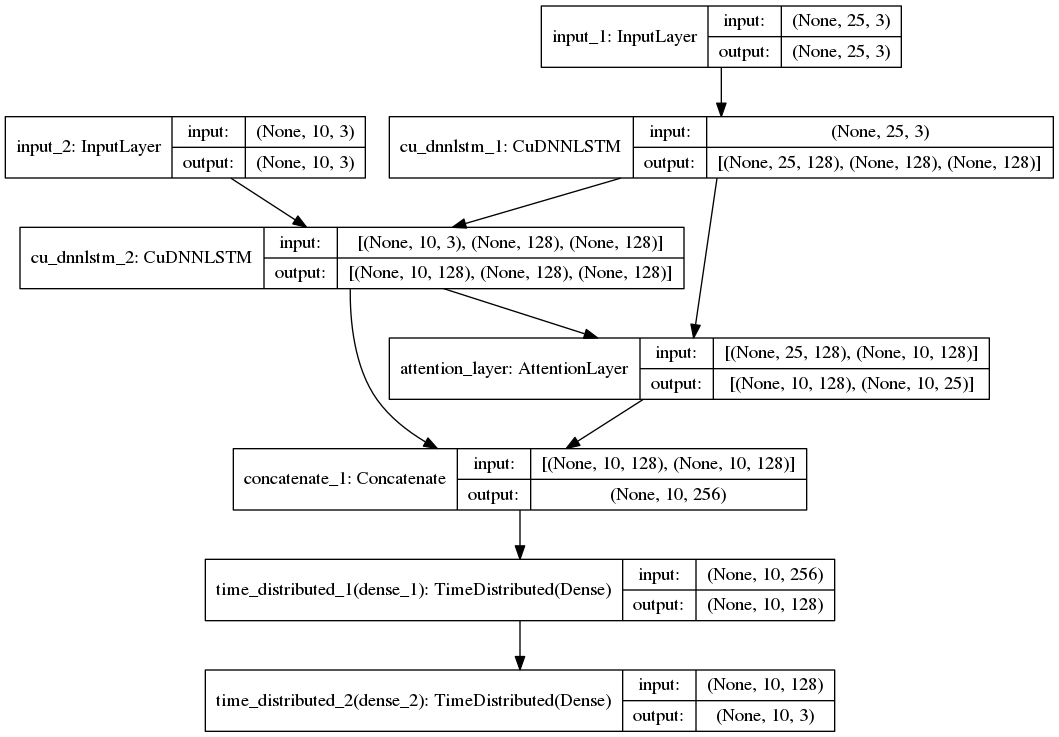

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
path_to_sensor_data_test = os.path.join(dir_path, "preprocessed_test")
file_names_test = os.listdir(path_to_sensor_data_test)
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

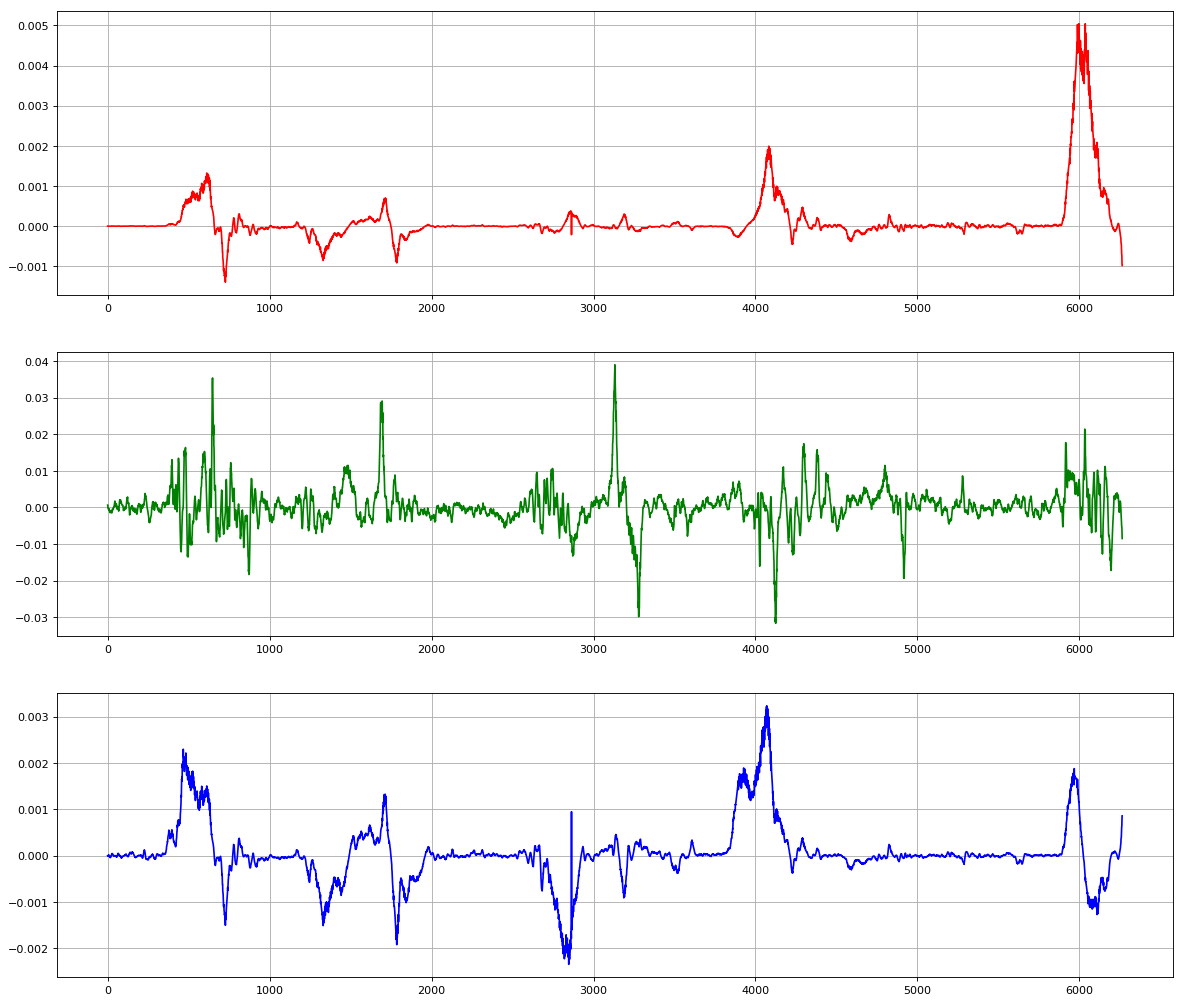

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 12:20 - loss: 0.0639 - rmse: 0.1871 - smape: 91.1229 - mfe: 4.6221e-04

  2/542 [..............................] - ETA: 7:01 - loss: 0.0711 - rmse: 0.2015 - smape: 87.1611 - mfe: 1.4954e-04 

  3/542 [..............................] - ETA: 5:16 - loss: 0.0740 - rmse: 0.2118 - smape: 83.8582 - mfe: 0.0046    

  4/542 [..............................] - ETA: 4:23 - loss: 0.0739 - rmse: 0.2078 - smape: 83.3305 - mfe: 0.0050

  5/542 [..............................] - ETA: 3:51 - loss: 0.0821 - rmse: 0.2285 - smape: 83.6048 - mfe: 0.0038

  6/542 [..............................] - ETA: 3:29 - loss: 0.0752 - rmse: 0.2144 - smape: 83.0388 - mfe: 0.0029

  7/542 [..............................] - ETA: 3:14 - loss: 0.0671 - rmse: 0.1895 - smape: 82.2489 - mfe: 0.0021

  8/542 [..............................] - ETA: 3:02 - loss: 0.0726 - rmse: 0.1972 - smape: 82.6369 - mfe: 0.0016

  9/542 [..............................] - ETA: 2:53 - loss: 0.0672 - rmse: 0.1810 - smape: 82.1821 - mfe: 0.0015

 10/542 [..............................] - ETA: 2:46 - loss: 0.0649 - rmse: 0.1785 - smape: 82.3988 - mfe: 0.0016

 11/542 [..............................] - ETA: 2:40 - loss: 0.0652 - rmse: 0.1810 - smape: 82.4329 - mfe: 0.0017

 12/542 [..............................] - ETA: 2:34 - loss: 0.0607 - rmse: 0.1681 - smape: 82.1900 - mfe: 0.0016

 13/542 [..............................] - ETA: 2:30 - loss: 0.0627 - rmse: 0.1731 - smape: 82.3346 - mfe: 0.0015

 14/542 [..............................] - ETA: 2:26 - loss: 0.0624 - rmse: 0.1716 - smape: 82.4114 - mfe: 0.0012

 15/542 [..............................] - ETA: 2:23 - loss: 0.0665 - rmse: 0.1803 - smape: 82.4163 - mfe: 9.2561e-04

 16/542 [..............................] - ETA: 2:21 - loss: 0.0700 - rmse: 0.1879 - smape: 82.2340 - mfe: 5.6776e-04

 17/542 [..............................] - ETA: 2:18 - loss: 0.0703 - rmse: 0.1875 - smape: 82.2177 - mfe: 2.7363e-04

 18/542 [..............................] - ETA: 2:15 - loss: 0.0714 - rmse: 0.1882 - smape: 82.2183 - mfe: -7.9458e-05

 19/542 [>.............................] - ETA: 2:13 - loss: 0.0721 - rmse: 0.1910 - smape: 82.2159 - mfe: -4.3025e-04

 20/542 [>.............................] - ETA: 2:12 - loss: 0.0736 - rmse: 0.1962 - smape: 82.1509 - mfe: -5.5850e-04

 21/542 [>.............................] - ETA: 2:10 - loss: 0.0741 - rmse: 0.1979 - smape: 82.1062 - mfe: -5.6661e-04

 22/542 [>.............................] - ETA: 2:08 - loss: 0.0712 - rmse: 0.1900 - smape: 82.0474 - mfe: -4.1098e-04

 23/542 [>.............................] - ETA: 2:07 - loss: 0.0698 - rmse: 0.1884 - smape: 81.8016 - mfe: -4.4471e-04

 24/542 [>.............................] - ETA: 2:05 - loss: 0.0734 - rmse: 0.1959 - smape: 81.8177 - mfe: -4.1320e-04

 25/542 [>.............................] - ETA: 2:04 - loss: 0.0724 - rmse: 0.1930 - smape: 81.7614 - mfe: -6.1316e-04

 26/542 [>.............................] - ETA: 2:03 - loss: 0.0702 - rmse: 0.1870 - smape: 81.5902 - mfe: -8.6344e-04

 27/542 [>.............................] - ETA: 2:02 - loss: 0.0708 - rmse: 0.1884 - smape: 81.5146 - mfe: -8.6416e-04

 28/542 [>.............................] - ETA: 2:01 - loss: 0.0705 - rmse: 0.1871 - smape: 81.3593 - mfe: -7.2876e-04

 29/542 [>.............................] - ETA: 2:00 - loss: 0.0688 - rmse: 0.1822 - smape: 81.2229 - mfe: -3.9302e-04

 30/542 [>.............................] - ETA: 1:59 - loss: 0.0690 - rmse: 0.1849 - smape: 81.1255 - mfe: -2.1500e-04

 31/542 [>.............................] - ETA: 1:58 - loss: 0.0690 - rmse: 0.1849 - smape: 81.1313 - mfe: -1.4764e-04

 32/542 [>.............................] - ETA: 1:57 - loss: 0.0681 - rmse: 0.1816 - smape: 81.1611 - mfe: -2.1880e-04

 33/542 [>.............................] - ETA: 1:56 - loss: 0.0685 - rmse: 0.1821 - smape: 81.1978 - mfe: -3.9497e-04

 34/542 [>.............................] - ETA: 1:55 - loss: 0.0668 - rmse: 0.1777 - smape: 81.1973 - mfe: -6.0642e-04

 35/542 [>.............................] - ETA: 1:55 - loss: 0.0661 - rmse: 0.1754 - smape: 81.1094 - mfe: -7.2296e-04

 36/542 [>.............................] - ETA: 1:54 - loss: 0.0661 - rmse: 0.1758 - smape: 81.0988 - mfe: -7.4728e-04

 37/542 [=>............................] - ETA: 1:53 - loss: 0.0654 - rmse: 0.1742 - smape: 81.0869 - mfe: -7.2086e-04

 38/542 [=>............................] - ETA: 1:53 - loss: 0.0663 - rmse: 0.1760 - smape: 81.1606 - mfe: -7.2166e-04

 39/542 [=>............................] - ETA: 1:52 - loss: 0.0662 - rmse: 0.1767 - smape: 81.1995 - mfe: -7.1570e-04

 40/542 [=>............................] - ETA: 1:52 - loss: 0.0659 - rmse: 0.1752 - smape: 81.2289 - mfe: -6.6123e-04

 41/542 [=>............................] - ETA: 1:51 - loss: 0.0646 - rmse: 0.1718 - smape: 81.1547 - mfe: -5.8404e-04

 42/542 [=>............................] - ETA: 1:50 - loss: 0.0643 - rmse: 0.1722 - smape: 81.1669 - mfe: -5.6521e-04

 43/542 [=>............................] - ETA: 1:50 - loss: 0.0647 - rmse: 0.1729 - smape: 81.1724 - mfe: -5.8352e-04

 44/542 [=>............................] - ETA: 1:49 - loss: 0.0641 - rmse: 0.1711 - smape: 81.1848 - mfe: -5.9607e-04

 45/542 [=>............................] - ETA: 1:49 - loss: 0.0651 - rmse: 0.1735 - smape: 81.2105 - mfe: -5.7080e-04

 46/542 [=>............................] - ETA: 1:48 - loss: 0.0647 - rmse: 0.1724 - smape: 81.2400 - mfe: -5.4745e-04

 47/542 [=>............................] - ETA: 1:48 - loss: 0.0642 - rmse: 0.1709 - smape: 81.2222 - mfe: -4.7943e-04

 48/542 [=>............................] - ETA: 1:47 - loss: 0.0634 - rmse: 0.1685 - smape: 81.2325 - mfe: -4.3550e-04

 49/542 [=>............................] - ETA: 1:47 - loss: 0.0635 - rmse: 0.1692 - smape: 81.1605 - mfe: -3.9352e-04

 50/542 [=>............................] - ETA: 1:47 - loss: 0.0637 - rmse: 0.1695 - smape: 81.1136 - mfe: -3.7572e-04

 51/542 [=>............................] - ETA: 1:46 - loss: 0.0651 - rmse: 0.1736 - smape: 81.1198 - mfe: -2.9939e-04

 52/542 [=>............................] - ETA: 1:46 - loss: 0.0648 - rmse: 0.1724 - smape: 81.1681 - mfe: -3.2581e-04

 53/542 [=>............................] - ETA: 1:45 - loss: 0.0642 - rmse: 0.1708 - smape: 81.1267 - mfe: -3.9176e-04

 54/542 [=>............................] - ETA: 1:45 - loss: 0.0635 - rmse: 0.1689 - smape: 81.0872 - mfe: -4.3613e-04

 55/542 [==>...........................] - ETA: 1:44 - loss: 0.0628 - rmse: 0.1673 - smape: 81.0813 - mfe: -4.4341e-04

 56/542 [==>...........................] - ETA: 1:44 - loss: 0.0618 - rmse: 0.1647 - smape: 81.1017 - mfe: -3.9486e-04

 57/542 [==>...........................] - ETA: 1:44 - loss: 0.0623 - rmse: 0.1660 - smape: 81.1449 - mfe: -3.6607e-04

 58/542 [==>...........................] - ETA: 1:44 - loss: 0.0621 - rmse: 0.1658 - smape: 81.1962 - mfe: -3.3486e-04

 59/542 [==>...........................] - ETA: 1:43 - loss: 0.0614 - rmse: 0.1640 - smape: 81.2940 - mfe: -3.1863e-04

 60/542 [==>...........................] - ETA: 1:43 - loss: 0.0613 - rmse: 0.1638 - smape: 81.3275 - mfe: -3.1450e-04

 61/542 [==>...........................] - ETA: 1:42 - loss: 0.0611 - rmse: 0.1632 - smape: 81.2927 - mfe: -3.6115e-04

 62/542 [==>...........................] - ETA: 1:42 - loss: 0.0607 - rmse: 0.1623 - smape: 81.3356 - mfe: -3.9676e-04

 63/542 [==>...........................] - ETA: 1:42 - loss: 0.0611 - rmse: 0.1635 - smape: 81.3694 - mfe: -4.2139e-04

 64/542 [==>...........................] - ETA: 1:42 - loss: 0.0608 - rmse: 0.1625 - smape: 81.3845 - mfe: -3.7176e-04

 65/542 [==>...........................] - ETA: 1:42 - loss: 0.0600 - rmse: 0.1603 - smape: 81.4267 - mfe: -3.2166e-04

 66/542 [==>...........................] - ETA: 1:41 - loss: 0.0610 - rmse: 0.1634 - smape: 81.3945 - mfe: -2.2076e-04

 67/542 [==>...........................] - ETA: 1:41 - loss: 0.0605 - rmse: 0.1618 - smape: 81.3762 - mfe: -2.3005e-04

 68/542 [==>...........................] - ETA: 1:41 - loss: 0.0604 - rmse: 0.1612 - smape: 81.3514 - mfe: -2.6294e-04

 69/542 [==>...........................] - ETA: 1:40 - loss: 0.0615 - rmse: 0.1645 - smape: 81.3415 - mfe: -3.3491e-04

 70/542 [==>...........................] - ETA: 1:40 - loss: 0.0616 - rmse: 0.1650 - smape: 81.3120 - mfe: -3.9731e-04

 71/542 [==>...........................] - ETA: 1:40 - loss: 0.0616 - rmse: 0.1650 - smape: 81.3053 - mfe: -4.2996e-04

 72/542 [==>...........................] - ETA: 1:39 - loss: 0.0628 - rmse: 0.1679 - smape: 81.2616 - mfe: -4.5380e-04

 73/542 [===>..........................] - ETA: 1:39 - loss: 0.0630 - rmse: 0.1685 - smape: 81.2315 - mfe: -4.5536e-04

 74/542 [===>..........................] - ETA: 1:39 - loss: 0.0630 - rmse: 0.1689 - smape: 81.2274 - mfe: -4.4490e-04

 75/542 [===>..........................] - ETA: 1:38 - loss: 0.0629 - rmse: 0.1686 - smape: 81.2285 - mfe: -4.4419e-04

 76/542 [===>..........................] - ETA: 1:38 - loss: 0.0628 - rmse: 0.1685 - smape: 81.2457 - mfe: -4.5058e-04

 77/542 [===>..........................] - ETA: 1:38 - loss: 0.0630 - rmse: 0.1693 - smape: 81.2516 - mfe: -4.2340e-04

 78/542 [===>..........................] - ETA: 1:37 - loss: 0.0625 - rmse: 0.1679 - smape: 81.2513 - mfe: -4.1269e-04

 79/542 [===>..........................] - ETA: 1:37 - loss: 0.0624 - rmse: 0.1675 - smape: 81.2938 - mfe: -4.0726e-04

 80/542 [===>..........................] - ETA: 1:37 - loss: 0.0621 - rmse: 0.1667 - smape: 81.3257 - mfe: -3.9775e-04

 81/542 [===>..........................] - ETA: 1:36 - loss: 0.0622 - rmse: 0.1668 - smape: 81.3474 - mfe: -3.9105e-04

 82/542 [===>..........................] - ETA: 1:36 - loss: 0.0625 - rmse: 0.1675 - smape: 81.3404 - mfe: -4.1489e-04

 83/542 [===>..........................] - ETA: 1:35 - loss: 0.0623 - rmse: 0.1671 - smape: 81.3388 - mfe: -4.4990e-04

 84/542 [===>..........................] - ETA: 1:35 - loss: 0.0626 - rmse: 0.1689 - smape: 81.2518 - mfe: -4.7523e-04

 85/542 [===>..........................] - ETA: 1:35 - loss: 0.0630 - rmse: 0.1696 - smape: 81.2291 - mfe: -5.1619e-04

 86/542 [===>..........................] - ETA: 1:35 - loss: 0.0628 - rmse: 0.1699 - smape: 81.2446 - mfe: -5.2185e-04

 87/542 [===>..........................] - ETA: 1:34 - loss: 0.0630 - rmse: 0.1709 - smape: 81.1955 - mfe: -5.2799e-04

 88/542 [===>..........................] - ETA: 1:34 - loss: 0.0631 - rmse: 0.1712 - smape: 81.1946 - mfe: -5.2480e-04

 89/542 [===>..........................] - ETA: 1:34 - loss: 0.0629 - rmse: 0.1707 - smape: 81.2069 - mfe: -5.4378e-04

 90/542 [===>..........................] - ETA: 1:33 - loss: 0.0628 - rmse: 0.1703 - smape: 81.1914 - mfe: -5.2715e-04

 91/542 [====>.........................] - ETA: 1:33 - loss: 0.0626 - rmse: 0.1700 - smape: 81.1647 - mfe: -4.8843e-04

 92/542 [====>.........................] - ETA: 1:33 - loss: 0.0627 - rmse: 0.1701 - smape: 81.1442 - mfe: -4.5410e-04

 93/542 [====>.........................] - ETA: 1:32 - loss: 0.0625 - rmse: 0.1699 - smape: 81.1379 - mfe: -4.0584e-04

 94/542 [====>.........................] - ETA: 1:32 - loss: 0.0623 - rmse: 0.1695 - smape: 81.1242 - mfe: -3.9432e-04

 95/542 [====>.........................] - ETA: 1:32 - loss: 0.0622 - rmse: 0.1692 - smape: 81.1147 - mfe: -3.7448e-04

 96/542 [====>.........................] - ETA: 1:31 - loss: 0.0624 - rmse: 0.1693 - smape: 81.1150 - mfe: -3.7126e-04

 97/542 [====>.........................] - ETA: 1:31 - loss: 0.0624 - rmse: 0.1693 - smape: 81.1268 - mfe: -3.7889e-04

 98/542 [====>.........................] - ETA: 1:31 - loss: 0.0625 - rmse: 0.1695 - smape: 81.0951 - mfe: -4.0076e-04

 99/542 [====>.........................] - ETA: 1:30 - loss: 0.0625 - rmse: 0.1694 - smape: 81.0913 - mfe: -4.5106e-04

100/542 [====>.........................] - ETA: 1:30 - loss: 0.0622 - rmse: 0.1683 - smape: 81.0689 - mfe: -5.0843e-04

101/542 [====>.........................] - ETA: 1:30 - loss: 0.0621 - rmse: 0.1690 - smape: 81.0364 - mfe: -5.4152e-04

102/542 [====>.........................] - ETA: 1:30 - loss: 0.0620 - rmse: 0.1689 - smape: 81.0390 - mfe: -5.4315e-04

103/542 [====>.........................] - ETA: 1:29 - loss: 0.0617 - rmse: 0.1681 - smape: 81.0481 - mfe: -5.2353e-04

104/542 [====>.........................] - ETA: 1:29 - loss: 0.0615 - rmse: 0.1676 - smape: 81.0490 - mfe: -5.1074e-04

105/542 [====>.........................] - ETA: 1:29 - loss: 0.0612 - rmse: 0.1666 - smape: 81.0729 - mfe: -4.9666e-04

106/542 [====>.........................] - ETA: 1:29 - loss: 0.0612 - rmse: 0.1663 - smape: 81.1059 - mfe: -4.8028e-04

107/542 [====>.........................] - ETA: 1:28 - loss: 0.0610 - rmse: 0.1659 - smape: 81.1074 - mfe: -4.5987e-04

108/542 [====>.........................] - ETA: 1:28 - loss: 0.0610 - rmse: 0.1661 - smape: 81.1432 - mfe: -4.6919e-04

109/542 [=====>........................] - ETA: 1:28 - loss: 0.0609 - rmse: 0.1661 - smape: 81.1215 - mfe: -4.7223e-04

110/542 [=====>........................] - ETA: 1:28 - loss: 0.0609 - rmse: 0.1659 - smape: 81.1346 - mfe: -4.8266e-04

111/542 [=====>........................] - ETA: 1:27 - loss: 0.0611 - rmse: 0.1665 - smape: 81.1460 - mfe: -4.7515e-04

112/542 [=====>........................] - ETA: 1:27 - loss: 0.0609 - rmse: 0.1658 - smape: 81.1190 - mfe: -4.9473e-04

113/542 [=====>........................] - ETA: 1:27 - loss: 0.0610 - rmse: 0.1662 - smape: 81.1032 - mfe: -4.9859e-04

114/542 [=====>........................] - ETA: 1:27 - loss: 0.0608 - rmse: 0.1657 - smape: 81.0928 - mfe: -5.3819e-04

115/542 [=====>........................] - ETA: 1:27 - loss: 0.0607 - rmse: 0.1650 - smape: 81.1384 - mfe: -5.2110e-04

116/542 [=====>........................] - ETA: 1:26 - loss: 0.0606 - rmse: 0.1648 - smape: 81.1602 - mfe: -4.7974e-04

117/542 [=====>........................] - ETA: 1:26 - loss: 0.0608 - rmse: 0.1651 - smape: 81.1882 - mfe: -4.4664e-04

118/542 [=====>........................] - ETA: 1:26 - loss: 0.0609 - rmse: 0.1651 - smape: 81.2156 - mfe: -4.3278e-04

119/542 [=====>........................] - ETA: 1:26 - loss: 0.0610 - rmse: 0.1655 - smape: 81.2165 - mfe: -4.5651e-04

120/542 [=====>........................] - ETA: 1:25 - loss: 0.0610 - rmse: 0.1656 - smape: 81.2288 - mfe: -4.7482e-04

121/542 [=====>........................] - ETA: 1:25 - loss: 0.0610 - rmse: 0.1659 - smape: 81.2359 - mfe: -4.5155e-04

122/542 [=====>........................] - ETA: 1:25 - loss: 0.0610 - rmse: 0.1661 - smape: 81.2302 - mfe: -4.3141e-04

123/542 [=====>........................] - ETA: 1:25 - loss: 0.0608 - rmse: 0.1654 - smape: 81.2429 - mfe: -3.9450e-04

124/542 [=====>........................] - ETA: 1:24 - loss: 0.0606 - rmse: 0.1649 - smape: 81.2357 - mfe: -3.7167e-04

125/542 [=====>........................] - ETA: 1:24 - loss: 0.0607 - rmse: 0.1651 - smape: 81.2405 - mfe: -3.3744e-04

126/542 [=====>........................] - ETA: 1:24 - loss: 0.0608 - rmse: 0.1652 - smape: 81.2307 - mfe: -3.1608e-04

127/542 [======>.......................] - ETA: 1:24 - loss: 0.0609 - rmse: 0.1653 - smape: 81.2373 - mfe: -3.1078e-04

128/542 [======>.......................] - ETA: 1:23 - loss: 0.0609 - rmse: 0.1655 - smape: 81.2387 - mfe: -2.9880e-04

129/542 [======>.......................] - ETA: 1:23 - loss: 0.0611 - rmse: 0.1661 - smape: 81.2287 - mfe: -2.9594e-04

130/542 [======>.......................] - ETA: 1:23 - loss: 0.0607 - rmse: 0.1653 - smape: 81.2186 - mfe: -2.7254e-04

131/542 [======>.......................] - ETA: 1:23 - loss: 0.0607 - rmse: 0.1652 - smape: 81.2212 - mfe: -2.6089e-04

132/542 [======>.......................] - ETA: 1:22 - loss: 0.0607 - rmse: 0.1652 - smape: 81.2253 - mfe: -2.6161e-04

133/542 [======>.......................] - ETA: 1:22 - loss: 0.0608 - rmse: 0.1653 - smape: 81.2485 - mfe: -2.6932e-04

134/542 [======>.......................] - ETA: 1:22 - loss: 0.0609 - rmse: 0.1656 - smape: 81.2577 - mfe: -2.8214e-04

135/542 [======>.......................] - ETA: 1:22 - loss: 0.0610 - rmse: 0.1663 - smape: 81.2399 - mfe: -2.9094e-04

136/542 [======>.......................] - ETA: 1:21 - loss: 0.0607 - rmse: 0.1655 - smape: 81.2141 - mfe: -3.0314e-04

137/542 [======>.......................] - ETA: 1:21 - loss: 0.0607 - rmse: 0.1657 - smape: 81.2318 - mfe: -2.9571e-04

138/542 [======>.......................] - ETA: 1:21 - loss: 0.0606 - rmse: 0.1652 - smape: 81.2643 - mfe: -2.7214e-04

139/542 [======>.......................] - ETA: 1:21 - loss: 0.0606 - rmse: 0.1655 - smape: 81.2670 - mfe: -2.3406e-04

140/542 [======>.......................] - ETA: 1:20 - loss: 0.0610 - rmse: 0.1662 - smape: 81.2820 - mfe: -1.8978e-04

141/542 [======>.......................] - ETA: 1:20 - loss: 0.0610 - rmse: 0.1663 - smape: 81.2879 - mfe: -1.4373e-04

142/542 [======>.......................] - ETA: 1:20 - loss: 0.0611 - rmse: 0.1665 - smape: 81.2576 - mfe: -8.5582e-05

143/542 [======>.......................] - ETA: 1:20 - loss: 0.0611 - rmse: 0.1664 - smape: 81.2678 - mfe: -6.6148e-05

144/542 [======>.......................] - ETA: 1:19 - loss: 0.0610 - rmse: 0.1667 - smape: 81.2482 - mfe: -6.9629e-05

145/542 [=======>......................] - ETA: 1:19 - loss: 0.0610 - rmse: 0.1669 - smape: 81.2738 - mfe: -9.5295e-05

146/542 [=======>......................] - ETA: 1:19 - loss: 0.0609 - rmse: 0.1664 - smape: 81.2390 - mfe: -1.1342e-04

147/542 [=======>......................] - ETA: 1:19 - loss: 0.0608 - rmse: 0.1663 - smape: 81.2364 - mfe: -1.2204e-04

148/542 [=======>......................] - ETA: 1:18 - loss: 0.0609 - rmse: 0.1666 - smape: 81.2342 - mfe: -1.2394e-04

149/542 [=======>......................] - ETA: 1:18 - loss: 0.0614 - rmse: 0.1682 - smape: 81.2023 - mfe: -9.9709e-05

150/542 [=======>......................] - ETA: 1:18 - loss: 0.0614 - rmse: 0.1681 - smape: 81.1922 - mfe: -1.1733e-04

151/542 [=======>......................] - ETA: 1:18 - loss: 0.0612 - rmse: 0.1677 - smape: 81.2006 - mfe: -1.2459e-04

152/542 [=======>......................] - ETA: 1:18 - loss: 0.0612 - rmse: 0.1677 - smape: 81.1893 - mfe: -1.2200e-04

153/542 [=======>......................] - ETA: 1:17 - loss: 0.0617 - rmse: 0.1685 - smape: 81.1963 - mfe: -7.9821e-05

154/542 [=======>......................] - ETA: 1:17 - loss: 0.0620 - rmse: 0.1693 - smape: 81.2028 - mfe: -3.0029e-05

155/542 [=======>......................] - ETA: 1:17 - loss: 0.0619 - rmse: 0.1690 - smape: 81.1870 - mfe: 1.0948e-05 

156/542 [=======>......................] - ETA: 1:17 - loss: 0.0622 - rmse: 0.1696 - smape: 81.1551 - mfe: 4.3732e-05

157/542 [=======>......................] - ETA: 1:17 - loss: 0.0621 - rmse: 0.1693 - smape: 81.1276 - mfe: 3.5970e-05

158/542 [=======>......................] - ETA: 1:16 - loss: 0.0621 - rmse: 0.1693 - smape: 81.0996 - mfe: 5.5232e-05

159/542 [=======>......................] - ETA: 1:16 - loss: 0.0622 - rmse: 0.1697 - smape: 81.0755 - mfe: 1.1934e-04

160/542 [=======>......................] - ETA: 1:16 - loss: 0.0625 - rmse: 0.1704 - smape: 81.0524 - mfe: 1.4930e-04

161/542 [=======>......................] - ETA: 1:16 - loss: 0.0624 - rmse: 0.1704 - smape: 81.0341 - mfe: 7.9554e-05

162/542 [=======>......................] - ETA: 1:15 - loss: 0.0623 - rmse: 0.1701 - smape: 81.0135 - mfe: 9.1126e-05

163/542 [========>.....................] - ETA: 1:15 - loss: 0.0623 - rmse: 0.1700 - smape: 81.0045 - mfe: 1.1462e-04

164/542 [========>.....................] - ETA: 1:15 - loss: 0.0623 - rmse: 0.1700 - smape: 81.0064 - mfe: 1.5361e-04

165/542 [========>.....................] - ETA: 1:15 - loss: 0.0624 - rmse: 0.1702 - smape: 81.0040 - mfe: 1.8834e-04

166/542 [========>.....................] - ETA: 1:15 - loss: 0.0625 - rmse: 0.1707 - smape: 80.9932 - mfe: 2.1826e-04

167/542 [========>.....................] - ETA: 1:14 - loss: 0.0625 - rmse: 0.1705 - smape: 81.0137 - mfe: 2.1969e-04

168/542 [========>.....................] - ETA: 1:14 - loss: 0.0626 - rmse: 0.1706 - smape: 81.0226 - mfe: 2.0138e-04

169/542 [========>.....................] - ETA: 1:14 - loss: 0.0629 - rmse: 0.1714 - smape: 81.0341 - mfe: 1.8043e-04

170/542 [========>.....................] - ETA: 1:14 - loss: 0.0627 - rmse: 0.1708 - smape: 81.0603 - mfe: 1.6849e-04

171/542 [========>.....................] - ETA: 1:13 - loss: 0.0625 - rmse: 0.1706 - smape: 81.0451 - mfe: 1.5997e-04

172/542 [========>.....................] - ETA: 1:13 - loss: 0.0625 - rmse: 0.1705 - smape: 81.0747 - mfe: 1.5428e-04

173/542 [========>.....................] - ETA: 1:13 - loss: 0.0623 - rmse: 0.1700 - smape: 81.0406 - mfe: 1.6194e-04

174/542 [========>.....................] - ETA: 1:13 - loss: 0.0623 - rmse: 0.1701 - smape: 81.0524 - mfe: 1.5977e-04

175/542 [========>.....................] - ETA: 1:13 - loss: 0.0622 - rmse: 0.1696 - smape: 81.0689 - mfe: 1.7476e-04

176/542 [========>.....................] - ETA: 1:12 - loss: 0.0621 - rmse: 0.1695 - smape: 81.0775 - mfe: 1.7073e-04

177/542 [========>.....................] - ETA: 1:12 - loss: 0.0621 - rmse: 0.1694 - smape: 81.0906 - mfe: 1.8007e-04

178/542 [========>.....................] - ETA: 1:12 - loss: 0.0623 - rmse: 0.1701 - smape: 81.0863 - mfe: 1.9461e-04

179/542 [========>.....................] - ETA: 1:12 - loss: 0.0622 - rmse: 0.1698 - smape: 81.0800 - mfe: 1.8291e-04

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0625 - rmse: 0.1707 - smape: 81.0857 - mfe: 1.5157e-04

181/542 [=========>....................] - ETA: 1:11 - loss: 0.0627 - rmse: 0.1710 - smape: 81.0963 - mfe: 1.4285e-04

182/542 [=========>....................] - ETA: 1:11 - loss: 0.0626 - rmse: 0.1711 - smape: 81.0833 - mfe: 1.5626e-04

183/542 [=========>....................] - ETA: 1:11 - loss: 0.0627 - rmse: 0.1716 - smape: 81.0732 - mfe: 1.4936e-04

184/542 [=========>....................] - ETA: 1:11 - loss: 0.0627 - rmse: 0.1715 - smape: 81.0566 - mfe: 1.3470e-04

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0626 - rmse: 0.1714 - smape: 81.0491 - mfe: 1.2206e-04

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0628 - rmse: 0.1717 - smape: 81.0431 - mfe: 1.2004e-04

187/542 [=========>....................] - ETA: 1:10 - loss: 0.0628 - rmse: 0.1716 - smape: 81.0266 - mfe: 1.3978e-04

188/542 [=========>....................] - ETA: 1:10 - loss: 0.0629 - rmse: 0.1718 - smape: 81.0186 - mfe: 1.4369e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0630 - rmse: 0.1722 - smape: 80.9909 - mfe: 1.3286e-04

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0630 - rmse: 0.1722 - smape: 80.9755 - mfe: 1.2392e-04

191/542 [=========>....................] - ETA: 1:09 - loss: 0.0631 - rmse: 0.1725 - smape: 80.9525 - mfe: 1.3768e-04

192/542 [=========>....................] - ETA: 1:09 - loss: 0.0630 - rmse: 0.1724 - smape: 80.9408 - mfe: 1.4650e-04

193/542 [=========>....................] - ETA: 1:09 - loss: 0.0629 - rmse: 0.1718 - smape: 80.9298 - mfe: 1.3646e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0627 - rmse: 0.1712 - smape: 80.8922 - mfe: 1.1489e-04

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0627 - rmse: 0.1712 - smape: 80.8872 - mfe: 1.0936e-04

196/542 [=========>....................] - ETA: 1:08 - loss: 0.0625 - rmse: 0.1708 - smape: 80.8902 - mfe: 1.0974e-04

197/542 [=========>....................] - ETA: 1:08 - loss: 0.0624 - rmse: 0.1706 - smape: 80.8808 - mfe: 1.1936e-04

198/542 [=========>....................] - ETA: 1:08 - loss: 0.0625 - rmse: 0.1707 - smape: 80.8681 - mfe: 1.4559e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0624 - rmse: 0.1704 - smape: 80.8624 - mfe: 1.6684e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1703 - smape: 80.8401 - mfe: 1.7173e-04

201/542 [==========>...................] - ETA: 1:07 - loss: 0.0622 - rmse: 0.1699 - smape: 80.8393 - mfe: 1.6514e-04

202/542 [==========>...................] - ETA: 1:07 - loss: 0.0621 - rmse: 0.1698 - smape: 80.8395 - mfe: 1.5966e-04

203/542 [==========>...................] - ETA: 1:07 - loss: 0.0621 - rmse: 0.1695 - smape: 80.8467 - mfe: 1.5277e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1698 - smape: 80.8525 - mfe: 1.4881e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0623 - rmse: 0.1701 - smape: 80.8511 - mfe: 1.4534e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0623 - rmse: 0.1701 - smape: 80.8477 - mfe: 1.4909e-04

207/542 [==========>...................] - ETA: 1:06 - loss: 0.0623 - rmse: 0.1702 - smape: 80.8382 - mfe: 1.5055e-04

208/542 [==========>...................] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1695 - smape: 80.8284 - mfe: 1.4835e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0621 - rmse: 0.1694 - smape: 80.8358 - mfe: 1.4422e-04

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0619 - rmse: 0.1689 - smape: 80.8407 - mfe: 1.4544e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0619 - rmse: 0.1688 - smape: 80.8322 - mfe: 1.5078e-04

212/542 [==========>...................] - ETA: 1:05 - loss: 0.0618 - rmse: 0.1685 - smape: 80.8211 - mfe: 1.5311e-04

213/542 [==========>...................] - ETA: 1:05 - loss: 0.0619 - rmse: 0.1688 - smape: 80.8119 - mfe: 1.6778e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1687 - smape: 80.8067 - mfe: 1.8326e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0622 - rmse: 0.1697 - smape: 80.7868 - mfe: 2.0087e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0622 - rmse: 0.1695 - smape: 80.7630 - mfe: 2.1024e-04

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0621 - rmse: 0.1694 - smape: 80.7442 - mfe: 2.0656e-04

218/542 [===========>..................] - ETA: 1:04 - loss: 0.0622 - rmse: 0.1696 - smape: 80.7320 - mfe: 1.8859e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1698 - smape: 80.7115 - mfe: 1.8262e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1699 - smape: 80.6929 - mfe: 1.5815e-04

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0623 - rmse: 0.1700 - smape: 80.6692 - mfe: 1.4154e-04

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0622 - rmse: 0.1699 - smape: 80.6542 - mfe: 1.5426e-04

223/542 [===========>..................]

 - ETA: 1:02 - loss: 0.0624 - rmse: 0.1704 - smape: 80.6353 - mfe: 1.4356e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0624 - rmse: 0.1702 - smape: 80.6301 - mfe: 1.3693e-04

225/542 [===========>..................]

 - ETA: 1:02 - loss: 0.0624 - rmse: 0.1702 - smape: 80.6334 - mfe: 1.3236e-04

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0625 - rmse: 0.1703 - smape: 80.6240 - mfe: 1.2985e-04

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0625 - rmse: 0.1702 - smape: 80.5948 - mfe: 1.3457e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0622 - rmse: 0.1696 - smape: 80.5799 - mfe: 1.4986e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0622 - rmse: 0.1694 - smape: 80.5872 - mfe: 1.4744e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0625 - rmse: 0.1700 - smape: 80.5818 - mfe: 1.2243e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0625 - rmse: 0.1700 - smape: 80.5674 - mfe: 1.0311e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0623 - rmse: 0.1694 - smape: 80.5544 - mfe: 8.1536e-05

233/542 [===========>..................] - ETA: 1:01 - loss: 0.0622 - rmse: 0.1695 - smape: 80.5478 - mfe: 8.0990e-05

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0621 - rmse: 0.1693 - smape: 80.5461 - mfe: 9.3637e-05

235/542 [============>.................] - ETA: 1:00 - loss: 0.0620 - rmse: 0.1690 - smape: 80.5415 - mfe: 1.1844e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0620 - rmse: 0.1691 - smape: 80.5410 - mfe: 1.2980e-04

237/542 [============>.................] - ETA: 1:00 - loss: 0.0620 - rmse: 0.1690 - smape: 80.5299 - mfe: 1.2564e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0620 - rmse: 0.1687 - smape: 80.5251 - mfe: 1.0237e-04 

239/542 [============>.................] - ETA: 59s - loss: 0.0619 - rmse: 0.1686 - smape: 80.5219 - mfe: 8.8892e-05

240/542 [============>.................] - ETA: 59s - loss: 0.0619 - rmse: 0.1687 - smape: 80.5076 - mfe: 9.6968e-05

241/542 [============>.................] - ETA: 59s - loss: 0.0619 - rmse: 0.1684 - smape: 80.5034 - mfe: 1.0968e-04

242/542 [============>.................] - ETA: 59s - loss: 0.0617 - rmse: 0.1681 - smape: 80.4993 - mfe: 1.2653e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0619 - rmse: 0.1684 - smape: 80.4874 - mfe: 1.4852e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0620 - rmse: 0.1684 - smape: 80.4617 - mfe: 1.5435e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0620 - rmse: 0.1685 - smape: 80.4325 - mfe: 1.4467e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0620 - rmse: 0.1688 - smape: 80.4130 - mfe: 1.3186e-04

247/542 [============>.................] - ETA: 58s - loss: 0.0620 - rmse: 0.1689 - smape: 80.3959 - mfe: 1.2445e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0618 - rmse: 0.1687 - smape: 80.3890 - mfe: 1.2307e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0617 - rmse: 0.1683 - smape: 80.3698 - mfe: 1.1750e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0616 - rmse: 0.1681 - smape: 80.3582 - mfe: 1.1580e-04

251/542 [============>.................] - ETA: 57s - loss: 0.0616 - rmse: 0.1683 - smape: 80.3366 - mfe: 1.1069e-04

252/542 [============>.................] - ETA: 57s - loss: 0.0618 - rmse: 0.1686 - smape: 80.3255 - mfe: 1.0796e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0617 - rmse: 0.1684 - smape: 80.3136 - mfe: 9.8568e-05

254/542 [=============>................] - ETA: 56s - loss: 0.0617 - rmse: 0.1686 - smape: 80.3001 - mfe: 1.0365e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0617 - rmse: 0.1685 - smape: 80.2845 - mfe: 1.1345e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0617 - rmse: 0.1686 - smape: 80.2670 - mfe: 1.2470e-04

257/542 [=============>................] - ETA: 56s - loss: 0.0616 - rmse: 0.1683 - smape: 80.2635 - mfe: 1.3836e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0614 - rmse: 0.1678 - smape: 80.2632 - mfe: 1.4284e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0615 - rmse: 0.1682 - smape: 80.2485 - mfe: 1.3464e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0615 - rmse: 0.1681 - smape: 80.2361 - mfe: 1.1560e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0616 - rmse: 0.1682 - smape: 80.2253 - mfe: 9.0405e-05

262/542 [=============>................] - ETA: 55s - loss: 0.0617 - rmse: 0.1684 - smape: 80.2198 - mfe: 7.7363e-05

263/542 [=============>................] - ETA: 54s - loss: 0.0616 - rmse: 0.1683 - smape: 80.2119 - mfe: 7.0967e-05

264/542 [=============>................] - ETA: 54s - loss: 0.0619 - rmse: 0.1690 - smape: 80.2030 - mfe: 7.8974e-05

265/542 [=============>................] - ETA: 54s - loss: 0.0620 - rmse: 0.1694 - smape: 80.1989 - mfe: 7.7596e-05

266/542 [=============>................] - ETA: 54s - loss: 0.0619 - rmse: 0.1692 - smape: 80.1912 - mfe: 7.3686e-05

267/542 [=============>................] - ETA: 54s - loss: 0.0619 - rmse: 0.1693 - smape: 80.1937 - mfe: 7.4642e-05

268/542 [=============>................] - ETA: 53s - loss: 0.0618 - rmse: 0.1691 - smape: 80.1844 - mfe: 7.8874e-05

269/542 [=============>................] - ETA: 53s - loss: 0.0618 - rmse: 0.1688 - smape: 80.1895 - mfe: 7.4762e-05

270/542 [=============>................] - ETA: 53s - loss: 0.0617 - rmse: 0.1686 - smape: 80.1924 - mfe: 6.9225e-05

271/542 [==============>...............] - ETA: 53s - loss: 0.0619 - rmse: 0.1691 - smape: 80.1937 - mfe: 7.3061e-05

272/542 [==============>...............] - ETA: 53s - loss: 0.0621 - rmse: 0.1696 - smape: 80.1972 - mfe: 8.2804e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0620 - rmse: 0.1692 - smape: 80.1902 - mfe: 8.8054e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0621 - rmse: 0.1694 - smape: 80.1695 - mfe: 1.0278e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0621 - rmse: 0.1695 - smape: 80.1611 - mfe: 1.0704e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0620 - rmse: 0.1692 - smape: 80.1642 - mfe: 1.0040e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0619 - rmse: 0.1691 - smape: 80.1574 - mfe: 9.6789e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0618 - rmse: 0.1690 - smape: 80.1494 - mfe: 1.0116e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0619 - rmse: 0.1691 - smape: 80.1334 - mfe: 1.1210e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0618 - rmse: 0.1691 - smape: 80.1244 - mfe: 1.3138e-04

281/542 [==============>...............] - ETA: 51s - loss: 0.0618 - rmse: 0.1690 - smape: 80.1189 - mfe: 1.3697e-04

282/542 [==============>...............] - ETA: 51s - loss: 0.0620 - rmse: 0.1694 - smape: 80.1101 - mfe: 1.1760e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0618 - rmse: 0.1690 - smape: 80.0919 - mfe: 9.0820e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0617 - rmse: 0.1687 - smape: 80.0728 - mfe: 9.0151e-05

285/542 [==============>...............] - ETA: 50s - loss: 0.0617 - rmse: 0.1686 - smape: 80.0676 - mfe: 8.8369e-05

286/542 [==============>...............] - ETA: 50s - loss: 0.0618 - rmse: 0.1690 - smape: 80.0538 - mfe: 1.0596e-04

287/542 [==============>...............] - ETA: 50s - loss: 0.0617 - rmse: 0.1689 - smape: 80.0471 - mfe: 1.2444e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0617 - rmse: 0.1687 - smape: 80.0486 - mfe: 1.3436e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0616 - rmse: 0.1685 - smape: 80.0460 - mfe: 1.3920e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0617 - rmse: 0.1685 - smape: 80.0469 - mfe: 1.4954e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0615 - rmse: 0.1682 - smape: 80.0434 - mfe: 1.4757e-04

292/542 [===============>..............] - ETA: 49s - loss: 0.0615 - rmse: 0.1681 - smape: 80.0425 - mfe: 1.5346e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0615 - rmse: 0.1680 - smape: 80.0435 - mfe: 1.5911e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0615 - rmse: 0.1680 - smape: 80.0391 - mfe: 1.7460e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0617 - rmse: 0.1684 - smape: 80.0325 - mfe: 2.0044e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0619 - rmse: 0.1691 - smape: 80.0176 - mfe: 2.4801e-04

297/542 [===============>..............] - ETA: 48s - loss: 0.0619 - rmse: 0.1690 - smape: 80.0020 - mfe: 2.7166e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0620 - rmse: 0.1691 - smape: 79.9847 - mfe: 2.9517e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0619 - rmse: 0.1691 - smape: 79.9660 - mfe: 3.1041e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0619 - rmse: 0.1691 - smape: 79.9590 - mfe: 2.9739e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0619 - rmse: 0.1690 - smape: 79.9506 - mfe: 2.8844e-04

302/542 [===============>..............] - ETA: 47s - loss: 0.0619 - rmse: 0.1691 - smape: 79.9326 - mfe: 2.9368e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0619 - rmse: 0.1691 - smape: 79.9217 - mfe: 2.9938e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0620 - rmse: 0.1693 - smape: 79.9141 - mfe: 3.1078e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0620 - rmse: 0.1695 - smape: 79.9027 - mfe: 3.1681e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0620 - rmse: 0.1693 - smape: 79.8931 - mfe: 3.0274e-04

307/542 [===============>..............] - ETA: 46s - loss: 0.0620 - rmse: 0.1693 - smape: 79.8788 - mfe: 2.8929e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8700 - mfe: 2.8241e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0619 - rmse: 0.1692 - smape: 79.8648 - mfe: 2.8804e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0620 - rmse: 0.1693 - smape: 79.8603 - mfe: 2.9963e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0618 - rmse: 0.1691 - smape: 79.8611 - mfe: 3.0784e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0618 - rmse: 0.1690 - smape: 79.8587 - mfe: 3.0593e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1691 - smape: 79.8474 - mfe: 2.9680e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1690 - smape: 79.8323 - mfe: 2.7907e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0618 - rmse: 0.1688 - smape: 79.8235 - mfe: 2.6252e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8109 - mfe: 2.3702e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0619 - rmse: 0.1690 - smape: 79.8060 - mfe: 2.2984e-04

318/542 [================>.............] - ETA: 44s - loss: 0.0619 - rmse: 0.1690 - smape: 79.7959 - mfe: 2.2692e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1691 - smape: 79.7895 - mfe: 2.3371e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1690 - smape: 79.7862 - mfe: 2.4211e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0619 - rmse: 0.1689 - smape: 79.7744 - mfe: 2.4405e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0618 - rmse: 0.1687 - smape: 79.7634 - mfe: 2.3259e-04

323/542 [================>.............] - ETA: 43s - loss: 0.0617 - rmse: 0.1685 - smape: 79.7585 - mfe: 2.1094e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0616 - rmse: 0.1682 - smape: 79.7530 - mfe: 1.9768e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0619 - rmse: 0.1688 - smape: 79.7429 - mfe: 1.9452e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0620 - rmse: 0.1688 - smape: 79.7286 - mfe: 2.0504e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0620 - rmse: 0.1693 - smape: 79.7201 - mfe: 2.2300e-04

328/542 [=================>............] - ETA: 42s - loss: 0.0619 - rmse: 0.1689 - smape: 79.7112 - mfe: 2.3399e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0618 - rmse: 0.1687 - smape: 79.7025 - mfe: 2.1934e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0618 - rmse: 0.1687 - smape: 79.6959 - mfe: 2.0253e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0619 - rmse: 0.1688 - smape: 79.6835 - mfe: 1.9144e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0619 - rmse: 0.1691 - smape: 79.6761 - mfe: 2.0067e-04

333/542 [=================>............] - ETA: 41s - loss: 0.0620 - rmse: 0.1693 - smape: 79.6618 - mfe: 2.1109e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0619 - rmse: 0.1693 - smape: 79.6613 - mfe: 2.2956e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0620 - rmse: 0.1694 - smape: 79.6542 - mfe: 2.4244e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0621 - rmse: 0.1695 - smape: 79.6537 - mfe: 2.4590e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0621 - rmse: 0.1696 - smape: 79.6541 - mfe: 2.5102e-04

338/542 [=================>............] - ETA: 40s - loss: 0.0620 - rmse: 0.1695 - smape: 79.6441 - mfe: 2.5144e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0619 - rmse: 0.1694 - smape: 79.6259 - mfe: 2.3691e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0620 - rmse: 0.1694 - smape: 79.6196 - mfe: 2.2376e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0621 - rmse: 0.1697 - smape: 79.6109 - mfe: 2.2062e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0621 - rmse: 0.1697 - smape: 79.6067 - mfe: 2.2397e-04

343/542 [=================>............] - ETA: 39s - loss: 0.0622 - rmse: 0.1698 - smape: 79.6059 - mfe: 2.3214e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0620 - rmse: 0.1694 - smape: 79.6062 - mfe: 2.3420e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0619 - rmse: 0.1692 - smape: 79.6096 - mfe: 2.3588e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0619 - rmse: 0.1690 - smape: 79.6003 - mfe: 2.4179e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0619 - rmse: 0.1691 - smape: 79.5888 - mfe: 2.3943e-04

348/542 [==================>...........] - ETA: 38s - loss: 0.0620 - rmse: 0.1693 - smape: 79.5763 - mfe: 2.3200e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0621 - rmse: 0.1696 - smape: 79.5624 - mfe: 2.1835e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0620 - rmse: 0.1697 - smape: 79.5517 - mfe: 2.1773e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0622 - rmse: 0.1700 - smape: 79.5490 - mfe: 2.3374e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0621 - rmse: 0.1699 - smape: 79.5415 - mfe: 2.5123e-04

353/542 [==================>...........] - ETA: 37s - loss: 0.0620 - rmse: 0.1695 - smape: 79.5635 - mfe: 2.6266e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0619 - rmse: 0.1694 - smape: 79.5484 - mfe: 2.4587e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0619 - rmse: 0.1692 - smape: 79.5325 - mfe: 2.1269e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0621 - rmse: 0.1699 - smape: 79.5293 - mfe: 1.7930e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0620 - rmse: 0.1697 - smape: 79.5109 - mfe: 1.5365e-04

358/542 [==================>...........] - ETA: 36s - loss: 0.0621 - rmse: 0.1698 - smape: 79.5090 - mfe: 1.4055e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0621 - rmse: 0.1698 - smape: 79.5091 - mfe: 1.4100e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0620 - rmse: 0.1695 - smape: 79.5182 - mfe: 1.4548e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0619 - rmse: 0.1694 - smape: 79.5182 - mfe: 1.5716e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0619 - rmse: 0.1694 - smape: 79.5108 - mfe: 1.6544e-04

363/542 [===================>..........] - ETA: 35s - loss: 0.0618 - rmse: 0.1693 - smape: 79.5090 - mfe: 1.7231e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0617 - rmse: 0.1692 - smape: 79.5033 - mfe: 1.7358e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0617 - rmse: 0.1691 - smape: 79.4949 - mfe: 1.6842e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0616 - rmse: 0.1688 - smape: 79.4921 - mfe: 1.5659e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0615 - rmse: 0.1687 - smape: 79.4801 - mfe: 1.4395e-04

368/542 [===================>..........] - ETA: 34s - loss: 0.0616 - rmse: 0.1690 - smape: 79.4733 - mfe: 1.3301e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4705 - mfe: 1.2726e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0617 - rmse: 0.1692 - smape: 79.4774 - mfe: 1.3164e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0616 - rmse: 0.1689 - smape: 79.4807 - mfe: 1.3780e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0615 - rmse: 0.1686 - smape: 79.4759 - mfe: 1.4652e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0616 - rmse: 0.1689 - smape: 79.4735 - mfe: 1.5463e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0616 - rmse: 0.1689 - smape: 79.4693 - mfe: 1.5332e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0616 - rmse: 0.1689 - smape: 79.4686 - mfe: 1.5252e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0617 - rmse: 0.1692 - smape: 79.4628 - mfe: 1.4598e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4581 - mfe: 1.4223e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4507 - mfe: 1.3694e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0619 - rmse: 0.1696 - smape: 79.4425 - mfe: 1.3720e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0619 - rmse: 0.1696 - smape: 79.4378 - mfe: 1.3175e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0618 - rmse: 0.1694 - smape: 79.4332 - mfe: 1.3798e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4239 - mfe: 1.4571e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0617 - rmse: 0.1691 - smape: 79.4207 - mfe: 1.4816e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1693 - smape: 79.4088 - mfe: 1.4490e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1694 - smape: 79.3903 - mfe: 1.3498e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0617 - rmse: 0.1692 - smape: 79.3816 - mfe: 1.2992e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0618 - rmse: 0.1694 - smape: 79.3715 - mfe: 1.3315e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0617 - rmse: 0.1693 - smape: 79.3751 - mfe: 1.4167e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0617 - rmse: 0.1692 - smape: 79.3659 - mfe: 1.4383e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0617 - rmse: 0.1691 - smape: 79.3532 - mfe: 1.3485e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0616 - rmse: 0.1689 - smape: 79.3600 - mfe: 1.3498e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0615 - rmse: 0.1687 - smape: 79.3648 - mfe: 1.3790e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0613 - rmse: 0.1683 - smape: 79.3682 - mfe: 1.3970e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0613 - rmse: 0.1683 - smape: 79.3597 - mfe: 1.5077e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0612 - rmse: 0.1681 - smape: 79.3613 - mfe: 1.7061e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0613 - rmse: 0.1683 - smape: 79.3527 - mfe: 1.8598e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0613 - rmse: 0.1683 - smape: 79.3506 - mfe: 1.8889e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0613 - rmse: 0.1684 - smape: 79.3478 - mfe: 1.8560e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0614 - rmse: 0.1687 - smape: 79.3437 - mfe: 1.7156e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0614 - rmse: 0.1686 - smape: 79.3413 - mfe: 1.5202e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3449 - mfe: 1.3394e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3396 - mfe: 1.2451e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0613 - rmse: 0.1686 - smape: 79.3379 - mfe: 1.2706e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0612 - rmse: 0.1683 - smape: 79.3256 - mfe: 1.3960e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0612 - rmse: 0.1682 - smape: 79.3144 - mfe: 1.6283e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0611 - rmse: 0.1679 - smape: 79.3180 - mfe: 1.7380e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0610 - rmse: 0.1677 - smape: 79.3161 - mfe: 1.8156e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0609 - rmse: 0.1677 - smape: 79.3063 - mfe: 1.7428e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2995 - mfe: 1.5830e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1679 - smape: 79.2962 - mfe: 1.3881e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1678 - smape: 79.2921 - mfe: 1.2104e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1676 - smape: 79.2840 - mfe: 1.0881e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2758 - mfe: 9.7738e-05

414/542 [=====================>........] - ETA: 25s - loss: 0.0609 - rmse: 0.1675 - smape: 79.2822 - mfe: 1.0054e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0609 - rmse: 0.1674 - smape: 79.2813 - mfe: 1.0741e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2757 - mfe: 1.2270e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0609 - rmse: 0.1675 - smape: 79.2781 - mfe: 1.3763e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0609 - rmse: 0.1674 - smape: 79.2792 - mfe: 1.4822e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0609 - rmse: 0.1675 - smape: 79.2762 - mfe: 1.5099e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0610 - rmse: 0.1678 - smape: 79.2763 - mfe: 1.4605e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0610 - rmse: 0.1676 - smape: 79.2735 - mfe: 1.3466e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0609 - rmse: 0.1673 - smape: 79.2623 - mfe: 1.2573e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0608 - rmse: 0.1672 - smape: 79.2536 - mfe: 1.1715e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0607 - rmse: 0.1670 - smape: 79.2504 - mfe: 1.1161e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0607 - rmse: 0.1669 - smape: 79.2510 - mfe: 1.1180e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0607 - rmse: 0.1669 - smape: 79.2491 - mfe: 1.1774e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0606 - rmse: 0.1669 - smape: 79.2453 - mfe: 1.2299e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0606 - rmse: 0.1668 - smape: 79.2457 - mfe: 1.2630e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0605 - rmse: 0.1667 - smape: 79.2455 - mfe: 1.2780e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0605 - rmse: 0.1666 - smape: 79.2337 - mfe: 1.2028e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0605 - rmse: 0.1665 - smape: 79.2326 - mfe: 1.1115e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0605 - rmse: 0.1665 - smape: 79.2216 - mfe: 1.0211e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0604 - rmse: 0.1663 - smape: 79.2090 - mfe: 9.1546e-05

434/542 [=======================>......] - ETA: 21s - loss: 0.0602 - rmse: 0.1659 - smape: 79.2065 - mfe: 8.3549e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1659 - smape: 79.2065 - mfe: 8.2581e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1657 - smape: 79.2003 - mfe: 9.1415e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1657 - smape: 79.1922 - mfe: 1.0691e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1658 - smape: 79.1883 - mfe: 1.2223e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0602 - rmse: 0.1658 - smape: 79.1778 - mfe: 1.3092e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1657 - smape: 79.1797 - mfe: 1.4134e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1658 - smape: 79.1697 - mfe: 1.5156e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0601 - rmse: 0.1655 - smape: 79.1707 - mfe: 1.5267e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1656 - smape: 79.1606 - mfe: 1.5501e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0602 - rmse: 0.1658 - smape: 79.1610 - mfe: 1.6072e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1660 - smape: 79.1506 - mfe: 1.5637e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1662 - smape: 79.1415 - mfe: 1.5276e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1660 - smape: 79.1368 - mfe: 1.4088e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0603 - rmse: 0.1661 - smape: 79.1320 - mfe: 1.3559e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0604 - rmse: 0.1662 - smape: 79.1243 - mfe: 1.3717e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0604 - rmse: 0.1663 - smape: 79.1248 - mfe: 1.4736e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0604 - rmse: 0.1663 - smape: 79.1148 - mfe: 1.5141e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0605 - rmse: 0.1664 - smape: 79.1116 - mfe: 1.5982e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0606 - rmse: 0.1665 - smape: 79.1060 - mfe: 1.6621e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0605 - rmse: 0.1664 - smape: 79.1068 - mfe: 1.6588e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0606 - rmse: 0.1666 - smape: 79.0980 - mfe: 1.6734e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0606 - rmse: 0.1665 - smape: 79.0952 - mfe: 1.6459e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0605 - rmse: 0.1663 - smape: 79.0973 - mfe: 1.6261e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0605 - rmse: 0.1665 - smape: 79.0958 - mfe: 1.6432e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0604 - rmse: 0.1663 - smape: 79.0882 - mfe: 1.7077e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0604 - rmse: 0.1665 - smape: 79.0835 - mfe: 1.7972e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0604 - rmse: 0.1665 - smape: 79.0750 - mfe: 1.8499e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0605 - rmse: 0.1667 - smape: 79.0686 - mfe: 1.8903e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0627 - mfe: 1.8752e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0535 - mfe: 1.8237e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0454 - mfe: 1.7665e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0393 - mfe: 1.7174e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1667 - smape: 79.0314 - mfe: 1.7145e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1666 - smape: 79.0250 - mfe: 1.6643e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0604 - rmse: 0.1666 - smape: 79.0202 - mfe: 1.6318e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0603 - rmse: 0.1665 - smape: 79.0112 - mfe: 1.5993e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1664 - smape: 79.0068 - mfe: 1.6003e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1663 - smape: 79.0056 - mfe: 1.6140e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1663 - smape: 78.9991 - mfe: 1.6599e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1662 - smape: 78.9862 - mfe: 1.6707e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0603 - rmse: 0.1662 - smape: 78.9764 - mfe: 1.7420e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1662 - smape: 78.9700 - mfe: 1.7907e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1662 - smape: 78.9613 - mfe: 1.8163e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0601 - rmse: 0.1660 - smape: 78.9570 - mfe: 1.8106e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1663 - smape: 78.9462 - mfe: 1.8155e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0602 - rmse: 0.1662 - smape: 78.9393 - mfe: 1.7889e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1662 - smape: 78.9370 - mfe: 1.7831e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0601 - rmse: 0.1659 - smape: 78.9326 - mfe: 1.7855e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1660 - smape: 78.9242 - mfe: 1.8330e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0602 - rmse: 0.1660 - smape: 78.9147 - mfe: 1.8642e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0601 - rmse: 0.1659 - smape: 78.9065 - mfe: 1.8902e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8945 - mfe: 1.8870e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0602 - rmse: 0.1659 - smape: 78.8829 - mfe: 1.8261e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8767 - mfe: 1.8161e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8621 - mfe: 1.8927e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8478 - mfe: 1.9920e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1660 - smape: 78.8380 - mfe: 2.0634e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8255 - mfe: 2.0021e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1661 - smape: 78.8058 - mfe: 1.7112e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0601 - rmse: 0.1660 - smape: 78.7895 - mfe: 1.6498e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0602 - rmse: 0.1660 - smape: 78.7778 - mfe: 1.8238e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7689 - mfe: 2.0585e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7578 - mfe: 1.9645e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1656 - smape: 78.7701 - mfe: 1.6599e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1657 - smape: 78.7585 - mfe: 1.5837e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0601 - rmse: 0.1655 - smape: 78.7609 - mfe: 1.6096e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7539 - mfe: 1.7419e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7402 - mfe: 1.9410e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7367 - mfe: 2.1639e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7343 - mfe: 2.2983e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0601 - rmse: 0.1657 - smape: 78.7382 - mfe: 2.3495e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0602 - rmse: 0.1660 - smape: 78.7400 - mfe: 2.3946e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1659 - smape: 78.7303 - mfe: 2.3925e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1657 - smape: 78.7225 - mfe: 2.3189e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1658 - smape: 78.7209 - mfe: 2.2386e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0602 - rmse: 0.1659 - smape: 78.7145 - mfe: 2.2027e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0601 - rmse: 0.1659 - smape: 78.7064 - mfe: 2.1673e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0601 - rmse: 0.1660 - smape: 78.7034 - mfe: 2.2089e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0603 - rmse: 0.1663 - smape: 78.6958 - mfe: 2.2854e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6946 - mfe: 2.2999e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6933 - mfe: 2.3404e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0602 - rmse: 0.1660 - smape: 78.6889 - mfe: 2.3682e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6832 - mfe: 2.4085e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6771 - mfe: 2.4529e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0601 - rmse: 0.1661 - smape: 78.6791 - mfe: 2.4880e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6749 - mfe: 2.5292e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6625 - mfe: 2.5933e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0601 - rmse: 0.1662 - smape: 78.6581 - mfe: 2.5821e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0603 - rmse: 0.1664 - smape: 78.6533 - mfe: 2.6216e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0602 - rmse: 0.1663 - smape: 78.6462 - mfe: 2.5692e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0602 - rmse: 0.1663 - smape: 78.6367 - mfe: 2.5215e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0603 - rmse: 0.1665 - smape: 78.6293 - mfe: 2.4819e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0603 - rmse: 0.1664 - smape: 78.6234 - mfe: 2.4607e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0602 - rmse: 0.1663 - smape: 78.6134 - mfe: 2.5094e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0602 - rmse: 0.1661 - smape: 78.6171 - mfe: 2.5259e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0601 - rmse: 0.1660 - smape: 78.6137 - mfe: 2.5584e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0600 - rmse: 0.1658 - smape: 78.6040 - mfe: 2.5950e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1658 - smape: 78.5988 - mfe: 2.6263e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1656 - smape: 78.5939 - mfe: 2.6253e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1658 - smape: 78.5924 - mfe: 2.6142e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1657 - smape: 78.5906 - mfe: 2.6448e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0599 - rmse: 0.1656 - smape: 78.5861 - mfe: 2.6889e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1655 - smape: 78.5853 - mfe: 2.7527e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1655 - smape: 78.5804 - mfe: 2.8076e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0598 - rmse: 0.1652 - smape: 78.5781 - mfe: 2.7868e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1654 - smape: 78.5705 - mfe: 2.7755e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0599 - rmse: 0.1655 - smape: 78.5671 - mfe: 2.6814e-04

542/542 [==============================] - 114s 210ms/step - loss: 0.0599 - rmse: 0.1654 - smape: 78.5621 - mfe: 2.6686e-04 - val_loss: 0.0624 - val_rmse: 0.1815 - val_smape: 76.5539 - val_mfe: 0.0011


Epoch 2/150


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


  1/542 [..............................] - ETA: 1:46 - loss: 0.0352 - rmse: 0.0966 - smape: 79.0404 - mfe: 8.0487e-04

  2/542 [..............................] - ETA: 1:31 - loss: 0.0521 - rmse: 0.1245 - smape: 78.3159 - mfe: 0.0021    

  3/542 [..............................] - ETA: 1:36 - loss: 0.0380 - rmse: 0.0905 - smape: 76.7456 - mfe: 0.0023

  4/542 [..............................] - ETA: 1:38 - loss: 0.0319 - rmse: 0.0756 - smape: 76.7026 - mfe: 0.0023

  5/542 [..............................] - ETA: 1:39 - loss: 0.0312 - rmse: 0.0813 - smape: 76.5939 - mfe: 0.0019

  6/542 [..............................] - ETA: 1:40 - loss: 0.0315 - rmse: 0.0793 - smape: 76.3295 - mfe: 0.0014

  7/542 [..............................] - ETA: 1:40 - loss: 0.0378 - rmse: 0.0949 - smape: 76.1528 - mfe: 0.0011

  8/542 [..............................] - ETA: 1:41 - loss: 0.0367 - rmse: 0.0943 - smape: 76.5819 - mfe: 6.6432e-04

  9/542 [..............................] - ETA: 1:41 - loss: 0.0380 - rmse: 0.0992 - smape: 76.4320 - mfe: 5.0904e-04

 10/542 [..............................] - ETA: 1:41 - loss: 0.0394 - rmse: 0.1063 - smape: 76.5642 - mfe: 3.5362e-04

 11/542 [..............................] - ETA: 1:41 - loss: 0.0382 - rmse: 0.1032 - smape: 76.7658 - mfe: 4.9185e-04

 12/542 [..............................] - ETA: 1:41 - loss: 0.0399 - rmse: 0.1062 - smape: 76.7434 - mfe: 4.3831e-04

 13/542 [..............................] - ETA: 1:40 - loss: 0.0401 - rmse: 0.1111 - smape: 76.7535 - mfe: 4.2901e-04

 14/542 [..............................] - ETA: 1:40 - loss: 0.0415 - rmse: 0.1165 - smape: 76.8454 - mfe: 3.3784e-04

 15/542 [..............................] - ETA: 1:40 - loss: 0.0403 - rmse: 0.1126 - smape: 76.9795 - mfe: 2.0213e-04

 16/542 [..............................] - ETA: 1:40 - loss: 0.0455 - rmse: 0.1309 - smape: 76.8593 - mfe: -4.2350e-05

 17/542 [..............................] - ETA: 1:40 - loss: 0.0451 - rmse: 0.1308 - smape: 77.0045 - mfe: 7.7203e-05 

 18/542 [..............................] - ETA: 1:40 - loss: 0.0463 - rmse: 0.1345 - smape: 77.0463 - mfe: 2.1003e-04

 19/542 [>.............................]

 - ETA: 1:40 - loss: 0.0463 - rmse: 0.1350 - smape: 77.0661 - mfe: 2.6632e-04

 20/542 [>.............................] - ETA: 1:40 - loss: 0.0466 - rmse: 0.1375 - smape: 77.2015 - mfe: 2.1336e-04

 21/542 [>.............................] - ETA: 1:39 - loss: 0.0476 - rmse: 0.1390 - smape: 77.2225 - mfe: 1.5768e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0471 - rmse: 0.1386 - smape: 77.2922 - mfe: 4.4928e-05

 23/542 [>.............................] - ETA: 1:39 - loss: 0.0482 - rmse: 0.1410 - smape: 77.3499 - mfe: 1.6092e-05

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0481 - rmse: 0.1400 - smape: 77.3962 - mfe: 5.6532e-05

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0473 - rmse: 0.1396 - smape: 77.4090 - mfe: 9.9038e-05

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0471 - rmse: 0.1390 - smape: 77.4405 - mfe: 1.8954e-04

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0479 - rmse: 0.1401 - smape: 77.4665 - mfe: 2.3720e-04

 28/542 [>.............................] - ETA: 1:37 - loss: 0.0481 - rmse: 0.1408 - smape: 77.4422 - mfe: 2.5210e-04

 29/542 [>.............................] - ETA: 1:37 - loss: 0.0467 - rmse: 0.1366 - smape: 77.5207 - mfe: 2.4998e-04

 30/542 [>.............................] - ETA: 1:37 - loss: 0.0476 - rmse: 0.1388 - smape: 77.5007 - mfe: 3.0252e-04

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0478 - rmse: 0.1400 - smape: 77.4343 - mfe: 3.3347e-04

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0474 - rmse: 0.1388 - smape: 77.4351 - mfe: 3.2602e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0473 - rmse: 0.1384 - smape: 77.4309 - mfe: 3.4360e-04

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0485 - rmse: 0.1408 - smape: 77.3698 - mfe: 3.9350e-04

 35/542 [>.............................] - ETA: 1:36 - loss: 0.0501 - rmse: 0.1442 - smape: 77.3254 - mfe: 4.5169e-04

 36/542 [>.............................] - ETA: 1:35 - loss: 0.0503 - rmse: 0.1440 - smape: 77.2705 - mfe: 4.5678e-04

 37/542 [=>............................] - ETA: 1:35 - loss: 0.0508 - rmse: 0.1450 - smape: 77.2010 - mfe: 4.4608e-04

 38/542 [=>............................] - ETA: 1:35 - loss: 0.0497 - rmse: 0.1419 - smape: 77.1939 - mfe: 4.0897e-04

 39/542 [=>............................] - ETA: 1:35 - loss: 0.0500 - rmse: 0.1427 - smape: 77.1418 - mfe: 4.6206e-04

 40/542 [=>............................] - ETA: 1:35 - loss: 0.0502 - rmse: 0.1439 - smape: 77.1222 - mfe: 4.8394e-04

 41/542 [=>............................] - ETA: 1:34 - loss: 0.0500 - rmse: 0.1429 - smape: 77.0695 - mfe: 4.4426e-04

 42/542 [=>............................] - ETA: 1:34 - loss: 0.0507 - rmse: 0.1455 - smape: 77.0062 - mfe: 3.9838e-04

 43/542 [=>............................] - ETA: 1:34 - loss: 0.0508 - rmse: 0.1450 - smape: 76.9954 - mfe: 3.1668e-04

 44/542 [=>............................] - ETA: 1:34 - loss: 0.0510 - rmse: 0.1451 - smape: 76.9193 - mfe: 3.2839e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0510 - rmse: 0.1453 - smape: 76.8769 - mfe: 3.8688e-04

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0512 - rmse: 0.1456 - smape: 76.8141 - mfe: 4.4653e-04

 47/542 [=>............................] - ETA: 1:33 - loss: 0.0520 - rmse: 0.1474 - smape: 76.7786 - mfe: 4.8475e-04

 48/542 [=>............................] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1471 - smape: 76.8065 - mfe: 5.0602e-04

 49/542 [=>............................] - ETA: 1:33 - loss: 0.0523 - rmse: 0.1484 - smape: 76.7625 - mfe: 5.4902e-04

 50/542 [=>............................] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1471 - smape: 76.7671 - mfe: 5.4793e-04

 51/542 [=>............................] - ETA: 1:33 - loss: 0.0516 - rmse: 0.1464 - smape: 76.7637 - mfe: 5.1867e-04

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0514 - rmse: 0.1466 - smape: 76.7388 - mfe: 5.0481e-04

 53/542 [=>............................] - ETA: 1:33 - loss: 0.0508 - rmse: 0.1446 - smape: 76.6879 - mfe: 4.6229e-04

 54/542 [=>............................] - ETA: 1:32 - loss: 0.0506 - rmse: 0.1441 - smape: 76.6730 - mfe: 4.6901e-04

 55/542 [==>...........................] - ETA: 1:32 - loss: 0.0505 - rmse: 0.1437 - smape: 76.6263 - mfe: 4.4253e-04

 56/542 [==>...........................] - ETA: 1:32 - loss: 0.0505 - rmse: 0.1437 - smape: 76.5795 - mfe: 4.1651e-04

 57/542 [==>...........................] - ETA: 1:32 - loss: 0.0506 - rmse: 0.1443 - smape: 76.5080 - mfe: 3.7252e-04

 58/542 [==>...........................] - ETA: 1:32 - loss: 0.0504 - rmse: 0.1441 - smape: 76.4202 - mfe: 3.4534e-04

 59/542 [==>...........................] - ETA: 1:31 - loss: 0.0502 - rmse: 0.1435 - smape: 76.2856 - mfe: 2.8650e-04

 60/542 [==>...........................] - ETA: 1:31 - loss: 0.0505 - rmse: 0.1444 - smape: 76.1990 - mfe: 2.1936e-04

 61/542 [==>...........................]

 - ETA: 1:31 - loss: 0.0504 - rmse: 0.1441 - smape: 76.1576 - mfe: 1.4348e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0504 - rmse: 0.1445 - smape: 76.1798 - mfe: 1.3605e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0512 - rmse: 0.1467 - smape: 76.1782 - mfe: 1.6206e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0507 - rmse: 0.1450 - smape: 76.2484 - mfe: 2.1585e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0511 - rmse: 0.1460 - smape: 76.2134 - mfe: 2.4625e-04

 66/542 [==>...........................] - ETA: 1:30 - loss: 0.0512 - rmse: 0.1466 - smape: 76.1967 - mfe: 2.1882e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0517 - rmse: 0.1489 - smape: 76.2193 - mfe: 1.5591e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0519 - rmse: 0.1495 - smape: 76.2487 - mfe: 1.0235e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0522 - rmse: 0.1505 - smape: 76.2421 - mfe: 6.0593e-05

 70/542 [==>...........................] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1499 - smape: 76.2126 - mfe: 7.0748e-05

 71/542 [==>...........................] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1511 - smape: 76.2047 - mfe: 1.2829e-04

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0524 - rmse: 0.1516 - smape: 76.1848 - mfe: 1.7767e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0523 - rmse: 0.1513 - smape: 76.1730 - mfe: 2.1832e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1510 - smape: 76.1676 - mfe: 2.8553e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1503 - smape: 76.1660 - mfe: 2.7888e-04

 76/542 [===>..........................] - ETA: 1:28 - loss: 0.0517 - rmse: 0.1494 - smape: 76.1501 - mfe: 2.4186e-04

 77/542 [===>..........................] - ETA: 1:28 - loss: 0.0521 - rmse: 0.1504 - smape: 76.1283 - mfe: 1.8412e-04

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0521 - rmse: 0.1505 - smape: 76.1300 - mfe: 1.4930e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1506 - smape: 76.1213 - mfe: 1.3885e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0517 - rmse: 0.1493 - smape: 76.1542 - mfe: 1.6231e-04

 81/542 [===>..........................] - ETA: 1:27 - loss: 0.0517 - rmse: 0.1491 - smape: 76.1266 - mfe: 1.9795e-04

 82/542 [===>..........................] - ETA: 1:27 - loss: 0.0518 - rmse: 0.1498 - smape: 76.1246 - mfe: 2.2206e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0516 - rmse: 0.1504 - smape: 76.1299 - mfe: 2.2344e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1511 - smape: 76.0939 - mfe: 2.3596e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0515 - rmse: 0.1501 - smape: 76.1517 - mfe: 2.2052e-04

 86/542 [===>..........................] - ETA: 1:26 - loss: 0.0519 - rmse: 0.1512 - smape: 76.1643 - mfe: 2.2163e-04

 87/542 [===>..........................] - ETA: 1:26 - loss: 0.0515 - rmse: 0.1501 - smape: 76.1524 - mfe: 1.9448e-04

 88/542 [===>..........................] - ETA: 1:26 - loss: 0.0515 - rmse: 0.1500 - smape: 76.1249 - mfe: 1.8194e-04

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0516 - rmse: 0.1502 - smape: 76.1254 - mfe: 1.7976e-04

 90/542 [===>..........................]

 - ETA: 1:26 - loss: 0.0513 - rmse: 0.1496 - smape: 76.1280 - mfe: 2.0254e-04

 91/542 [====>.........................] - ETA: 1:25 - loss: 0.0512 - rmse: 0.1495 - smape: 76.1092 - mfe: 2.0653e-04

 92/542 [====>.........................] - ETA: 1:25 - loss: 0.0512 - rmse: 0.1496 - smape: 76.1038 - mfe: 2.0587e-04

 93/542 [====>.........................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1502 - smape: 76.0880 - mfe: 1.8509e-04

 94/542 [====>.........................] - ETA: 1:25 - loss: 0.0516 - rmse: 0.1505 - smape: 76.0824 - mfe: 1.4774e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1499 - smape: 76.0745 - mfe: 1.1825e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1498 - smape: 76.0663 - mfe: 9.7439e-05

 97/542 [====>.........................] - ETA: 1:24 - loss: 0.0515 - rmse: 0.1494 - smape: 76.0566 - mfe: 9.8996e-05

 98/542 [====>.........................] - ETA: 1:24 - loss: 0.0515 - rmse: 0.1496 - smape: 76.0647 - mfe: 1.2911e-04

 99/542 [====>.........................] - ETA: 1:24 - loss: 0.0515 - rmse: 0.1493 - smape: 76.0385 - mfe: 1.5642e-04

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0513 - rmse: 0.1487 - smape: 76.0594 - mfe: 1.8333e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0513 - rmse: 0.1485 - smape: 76.0643 - mfe: 1.8664e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0513 - rmse: 0.1491 - smape: 76.0581 - mfe: 1.8824e-04

103/542 [====>.........................] - ETA: 1:23 - loss: 0.0515 - rmse: 0.1492 - smape: 76.0368 - mfe: 1.5633e-04

104/542 [====>.........................] - ETA: 1:23 - loss: 0.0514 - rmse: 0.1489 - smape: 76.0128 - mfe: 1.3675e-04

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0514 - rmse: 0.1489 - smape: 75.9758 - mfe: 1.3234e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0516 - rmse: 0.1495 - smape: 75.9598 - mfe: 1.3018e-04

107/542 [====>.........................] - ETA: 1:22 - loss: 0.0512 - rmse: 0.1484 - smape: 76.0269 - mfe: 1.3540e-04

108/542 [====>.........................] - ETA: 1:22 - loss: 0.0512 - rmse: 0.1484 - smape: 76.0236 - mfe: 1.5036e-04

109/542 [=====>........................] - ETA: 1:22 - loss: 0.0515 - rmse: 0.1491 - smape: 75.9919 - mfe: 1.6994e-04

110/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1490 - smape: 75.9534 - mfe: 1.6163e-04

111/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1486 - smape: 75.9486 - mfe: 1.2517e-04

112/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1490 - smape: 75.9594 - mfe: 9.2836e-05

113/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1488 - smape: 75.9368 - mfe: 8.7395e-05

114/542 [=====>........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1485 - smape: 75.9085 - mfe: 1.2747e-04

115/542 [=====>........................] - ETA: 1:20 - loss: 0.0516 - rmse: 0.1487 - smape: 75.8709 - mfe: 1.7133e-04

116/542 [=====>........................] - ETA: 1:20 - loss: 0.0518 - rmse: 0.1491 - smape: 75.8219 - mfe: 2.3093e-04

117/542 [=====>........................] - ETA: 1:20 - loss: 0.0520 - rmse: 0.1495 - smape: 75.7992 - mfe: 2.6664e-04

118/542 [=====>........................] - ETA: 1:20 - loss: 0.0523 - rmse: 0.1501 - smape: 75.7582 - mfe: 2.7823e-04

119/542 [=====>........................] - ETA: 1:20 - loss: 0.0525 - rmse: 0.1510 - smape: 75.7446 - mfe: 2.8977e-04

120/542 [=====>........................] - ETA: 1:20 - loss: 0.0526 - rmse: 0.1509 - smape: 75.7180 - mfe: 2.9476e-04

121/542 [=====>........................] - ETA: 1:19 - loss: 0.0526 - rmse: 0.1509 - smape: 75.6714 - mfe: 3.0497e-04

122/542 [=====>........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1517 - smape: 75.6394 - mfe: 3.4388e-04

123/542 [=====>........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1519 - smape: 75.6077 - mfe: 3.9112e-04

124/542 [=====>........................] - ETA: 1:19 - loss: 0.0529 - rmse: 0.1517 - smape: 75.5999 - mfe: 4.3627e-04

125/542 [=====>........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1519 - smape: 75.6057 - mfe: 4.3402e-04

126/542 [=====>........................] - ETA: 1:19 - loss: 0.0531 - rmse: 0.1525 - smape: 75.6026 - mfe: 4.0634e-04

127/542 [======>.......................] - ETA: 1:18 - loss: 0.0529 - rmse: 0.1521 - smape: 75.5738 - mfe: 3.6862e-04

128/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1524 - smape: 75.5493 - mfe: 3.5753e-04

129/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1525 - smape: 75.5351 - mfe: 3.6159e-04

130/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1525 - smape: 75.5453 - mfe: 3.7552e-04

131/542 [======>.......................] - ETA: 1:17 - loss: 0.0532 - rmse: 0.1523 - smape: 75.5234 - mfe: 3.8951e-04

132/542 [======>.......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1526 - smape: 75.5050 - mfe: 4.0324e-04

133/542 [======>.......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1527 - smape: 75.4949 - mfe: 3.9742e-04

134/542 [======>.......................] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1533 - smape: 75.4789 - mfe: 3.8864e-04

135/542 [======>.......................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1532 - smape: 75.4848 - mfe: 3.7316e-04

136/542 [======>.......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1536 - smape: 75.4816 - mfe: 3.7385e-04

137/542 [======>.......................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1531 - smape: 75.4925 - mfe: 3.8054e-04

138/542 [======>.......................] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1523 - smape: 75.4966 - mfe: 3.9709e-04

139/542 [======>.......................] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1528 - smape: 75.4939 - mfe: 4.3026e-04

140/542 [======>.......................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1532 - smape: 75.4903 - mfe: 4.4451e-04

141/542 [======>.......................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1531 - smape: 75.4582 - mfe: 4.2518e-04

142/542 [======>.......................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1533 - smape: 75.4514 - mfe: 3.9433e-04

143/542 [======>.......................] - ETA: 1:15 - loss: 0.0532 - rmse: 0.1531 - smape: 75.4446 - mfe: 3.7081e-04

144/542 [======>.......................] - ETA: 1:15 - loss: 0.0530 - rmse: 0.1523 - smape: 75.4148 - mfe: 3.6613e-04

145/542 [=======>......................] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1516 - smape: 75.4430 - mfe: 3.7143e-04

146/542 [=======>......................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1518 - smape: 75.4343 - mfe: 3.7733e-04

147/542 [=======>......................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1516 - smape: 75.4175 - mfe: 3.7914e-04

148/542 [=======>......................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1516 - smape: 75.4049 - mfe: 3.7223e-04

149/542 [=======>......................] - ETA: 1:14 - loss: 0.0527 - rmse: 0.1515 - smape: 75.4004 - mfe: 3.5632e-04

150/542 [=======>......................] - ETA: 1:14 - loss: 0.0531 - rmse: 0.1523 - smape: 75.3951 - mfe: 3.4732e-04

151/542 [=======>......................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1519 - smape: 75.3967 - mfe: 3.4990e-04

152/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1513 - smape: 75.3707 - mfe: 3.6725e-04

153/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1514 - smape: 75.3496 - mfe: 3.7207e-04

154/542 [=======>......................] - ETA: 1:13 - loss: 0.0527 - rmse: 0.1509 - smape: 75.3401 - mfe: 3.8117e-04

155/542 [=======>......................] - ETA: 1:13 - loss: 0.0527 - rmse: 0.1509 - smape: 75.3256 - mfe: 3.7236e-04

156/542 [=======>......................] - ETA: 1:13 - loss: 0.0527 - rmse: 0.1511 - smape: 75.3196 - mfe: 3.6250e-04

157/542 [=======>......................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1512 - smape: 75.3153 - mfe: 3.5233e-04

158/542 [=======>......................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1508 - smape: 75.2999 - mfe: 3.3991e-04

159/542 [=======>......................] - ETA: 1:12 - loss: 0.0524 - rmse: 0.1502 - smape: 75.3150 - mfe: 3.2989e-04

160/542 [=======>......................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1508 - smape: 75.3042 - mfe: 3.1507e-04

161/542 [=======>......................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1507 - smape: 75.3216 - mfe: 3.1264e-04

162/542 [=======>......................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1507 - smape: 75.2729 - mfe: 3.2933e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0529 - rmse: 0.1515 - smape: 75.2781 - mfe: 3.6607e-04

164/542 [========>.....................] - ETA: 1:11 - loss: 0.0528 - rmse: 0.1513 - smape: 75.2463 - mfe: 3.6928e-04

165/542 [========>.....................] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1515 - smape: 75.2232 - mfe: 3.6432e-04

166/542 [========>.....................] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1513 - smape: 75.2170 - mfe: 3.5203e-04

167/542 [========>.....................] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1508 - smape: 75.2484 - mfe: 3.6741e-04

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0525 - rmse: 0.1504 - smape: 75.2088 - mfe: 3.9059e-04

169/542 [========>.....................] - ETA: 1:10 - loss: 0.0526 - rmse: 0.1507 - smape: 75.2010 - mfe: 4.1428e-04

170/542 [========>.....................] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1510 - smape: 75.1817 - mfe: 4.2301e-04

171/542 [========>.....................] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1505 - smape: 75.1652 - mfe: 4.0968e-04

172/542 [========>.....................] - ETA: 1:10 - loss: 0.0524 - rmse: 0.1503 - smape: 75.1443 - mfe: 3.9077e-04

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1503 - smape: 75.1432 - mfe: 3.7496e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1502 - smape: 75.1281 - mfe: 3.7606e-04

175/542 [========>.....................] - ETA: 1:09 - loss: 0.0524 - rmse: 0.1500 - smape: 75.1263 - mfe: 3.8330e-04

176/542 [========>.....................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1493 - smape: 75.1176 - mfe: 3.9769e-04

177/542 [========>.....................] - ETA: 1:09 - loss: 0.0523 - rmse: 0.1494 - smape: 75.1085 - mfe: 4.0152e-04

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1493 - smape: 75.1400 - mfe: 4.0163e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0520 - rmse: 0.1491 - smape: 75.1494 - mfe: 3.9083e-04

180/542 [========>.....................] - ETA: 1:08 - loss: 0.0519 - rmse: 0.1485 - smape: 75.1447 - mfe: 3.7881e-04

181/542 [=========>....................] - ETA: 1:08 - loss: 0.0518 - rmse: 0.1483 - smape: 75.1330 - mfe: 3.6501e-04

182/542 [=========>....................] - ETA: 1:08 - loss: 0.0522 - rmse: 0.1495 - smape: 75.1329 - mfe: 3.5472e-04

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0520 - rmse: 0.1490 - smape: 75.1324 - mfe: 3.4153e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0521 - rmse: 0.1490 - smape: 75.1274 - mfe: 3.2129e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0519 - rmse: 0.1484 - smape: 75.1400 - mfe: 3.2267e-04

186/542 [=========>....................] - ETA: 1:07 - loss: 0.0520 - rmse: 0.1485 - smape: 75.1295 - mfe: 3.2575e-04

187/542 [=========>....................] - ETA: 1:07 - loss: 0.0517 - rmse: 0.1479 - smape: 75.1630 - mfe: 3.2955e-04

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1480 - smape: 75.1527 - mfe: 3.3092e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1480 - smape: 75.1290 - mfe: 3.1950e-04

190/542 [=========>....................] - ETA: 1:06 - loss: 0.0522 - rmse: 0.1487 - smape: 75.1211 - mfe: 3.1797e-04

191/542 [=========>....................] - ETA: 1:06 - loss: 0.0520 - rmse: 0.1483 - smape: 75.1365 - mfe: 3.2226e-04

192/542 [=========>....................] - ETA: 1:06 - loss: 0.0520 - rmse: 0.1481 - smape: 75.1347 - mfe: 3.1820e-04

193/542 [=========>....................] - ETA: 1:06 - loss: 0.0519 - rmse: 0.1477 - smape: 75.1269 - mfe: 3.1715e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0519 - rmse: 0.1478 - smape: 75.1058 - mfe: 3.2606e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0522 - rmse: 0.1485 - smape: 75.0851 - mfe: 3.3423e-04

196/542 [=========>....................] - ETA: 1:05 - loss: 0.0522 - rmse: 0.1484 - smape: 75.0593 - mfe: 3.3696e-04

197/542 [=========>....................] - ETA: 1:05 - loss: 0.0523 - rmse: 0.1488 - smape: 75.0354 - mfe: 3.3129e-04

198/542 [=========>....................] - ETA: 1:05 - loss: 0.0524 - rmse: 0.1488 - smape: 75.0225 - mfe: 3.1759e-04

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0523 - rmse: 0.1487 - smape: 75.0229 - mfe: 2.9865e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0525 - rmse: 0.1495 - smape: 75.0127 - mfe: 2.9995e-04

201/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1499 - smape: 74.9931 - mfe: 3.0699e-04

202/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1500 - smape: 74.9794 - mfe: 3.1606e-04

203/542 [==========>...................] - ETA: 1:04 - loss: 0.0526 - rmse: 0.1497 - smape: 74.9698 - mfe: 3.2177e-04

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0526 - rmse: 0.1497 - smape: 74.9699 - mfe: 3.2608e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1499 - smape: 74.9796 - mfe: 3.2733e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0528 - rmse: 0.1502 - smape: 74.9700 - mfe: 3.2874e-04

207/542 [==========>...................] - ETA: 1:03 - loss: 0.0528 - rmse: 0.1501 - smape: 74.9574 - mfe: 3.1468e-04

208/542 [==========>...................]

 - ETA: 1:03 - loss: 0.0527 - rmse: 0.1500 - smape: 74.9537 - mfe: 2.9622e-04

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1500 - smape: 74.9522 - mfe: 2.9077e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0525 - rmse: 0.1498 - smape: 74.9747 - mfe: 2.9951e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0523 - rmse: 0.1494 - smape: 75.0098 - mfe: 3.0643e-04

212/542 [==========>...................] - ETA: 1:02 - loss: 0.0522 - rmse: 0.1489 - smape: 75.0062 - mfe: 2.9926e-04

213/542 [==========>...................] - ETA: 1:02 - loss: 0.0523 - rmse: 0.1494 - smape: 75.0010 - mfe: 2.8455e-04

214/542 [==========>...................] - ETA: 1:02 - loss: 0.0526 - rmse: 0.1502 - smape: 74.9904 - mfe: 2.5343e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1505 - smape: 74.9672 - mfe: 2.3499e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1506 - smape: 74.9631 - mfe: 2.1189e-04

217/542 [===========>..................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1511 - smape: 74.9511 - mfe: 2.1072e-04

218/542 [===========>..................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1510 - smape: 74.9429 - mfe: 2.1756e-04

219/542 [===========>..................] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1506 - smape: 74.9575 - mfe: 2.2315e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1505 - smape: 74.9526 - mfe: 2.2696e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1508 - smape: 74.9378 - mfe: 2.2342e-04

222/542 [===========>..................] - ETA: 1:00 - loss: 0.0529 - rmse: 0.1508 - smape: 74.9276 - mfe: 2.1875e-04

223/542 [===========>..................] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1506 - smape: 74.9370 - mfe: 2.0979e-04

224/542 [===========>..................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1501 - smape: 74.9592 - mfe: 2.0397e-04

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1502 - smape: 74.9387 - mfe: 2.1859e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1502 - smape: 74.9218 - mfe: 2.4420e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1499 - smape: 74.9098 - mfe: 2.6395e-04

228/542 [===========>..................] - ETA: 59s - loss: 0.0525 - rmse: 0.1498 - smape: 74.9175 - mfe: 2.7239e-04 

229/542 [===========>..................] - ETA: 59s - loss: 0.0529 - rmse: 0.1506 - smape: 74.9030 - mfe: 2.6885e-04

230/542 [===========>..................] - ETA: 59s - loss: 0.0530 - rmse: 0.1508 - smape: 74.8870 - mfe: 2.5685e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0530 - rmse: 0.1507 - smape: 74.8797 - mfe: 2.3897e-04

232/542 [===========>..................] - ETA: 59s - loss: 0.0530 - rmse: 0.1505 - smape: 74.8662 - mfe: 2.1946e-04

233/542 [===========>..................] - ETA: 58s - loss: 0.0530 - rmse: 0.1504 - smape: 74.8503 - mfe: 2.0326e-04

234/542 [===========>..................] - ETA: 58s - loss: 0.0530 - rmse: 0.1506 - smape: 74.8543 - mfe: 2.0533e-04

235/542 [============>.................] - ETA: 58s - loss: 0.0530 - rmse: 0.1506 - smape: 74.8678 - mfe: 2.1483e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0532 - rmse: 0.1509 - smape: 74.8499 - mfe: 2.2789e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0530 - rmse: 0.1504 - smape: 74.8524 - mfe: 2.3743e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0531 - rmse: 0.1505 - smape: 74.8399 - mfe: 2.5063e-04

239/542 [============>.................] - ETA: 57s - loss: 0.0532 - rmse: 0.1510 - smape: 74.8405 - mfe: 2.5686e-04

240/542 [============>.................] - ETA: 57s - loss: 0.0532 - rmse: 0.1509 - smape: 74.8459 - mfe: 2.5759e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0533 - rmse: 0.1514 - smape: 74.8367 - mfe: 2.5471e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0534 - rmse: 0.1517 - smape: 74.8342 - mfe: 2.4020e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0536 - rmse: 0.1523 - smape: 74.8295 - mfe: 2.2391e-04

244/542 [============>.................] - ETA: 56s - loss: 0.0535 - rmse: 0.1519 - smape: 74.8272 - mfe: 2.1342e-04

245/542 [============>.................] - ETA: 56s - loss: 0.0535 - rmse: 0.1521 - smape: 74.8186 - mfe: 2.1623e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0536 - rmse: 0.1524 - smape: 74.8190 - mfe: 2.3529e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0538 - rmse: 0.1530 - smape: 74.8131 - mfe: 2.6618e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0538 - rmse: 0.1528 - smape: 74.8128 - mfe: 2.8634e-04

249/542 [============>.................] - ETA: 55s - loss: 0.0537 - rmse: 0.1528 - smape: 74.8142 - mfe: 3.0289e-04

250/542 [============>.................] - ETA: 55s - loss: 0.0539 - rmse: 0.1531 - smape: 74.8069 - mfe: 2.9658e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0539 - rmse: 0.1531 - smape: 74.7930 - mfe: 2.9239e-04



252/542 [============>.................] - ETA: 55s - loss: 0.0540 - rmse: 0.1533 - smape: 74.7737 - mfe: 2.6548e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0540 - rmse: 0.1534 - smape: 74.7711 - mfe: 2.3518e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0540 - rmse: 0.1537 - smape: 74.7652 - mfe: 2.2340e-04

255/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1536 - smape: 74.7676 - mfe: 2.3063e-04

256/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1534 - smape: 74.7595 - mfe: 2.4406e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1536 - smape: 74.7537 - mfe: 2.6290e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0541 - rmse: 0.1537 - smape: 74.7500 - mfe: 2.6953e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1532 - smape: 74.7654 - mfe: 2.7394e-04

260/542 [=============>................] - ETA: 53s - loss: 0.0539 - rmse: 0.1532 - smape: 74.7678 - mfe: 2.5960e-04

261/542 [=============>................] - ETA: 53s - loss: 0.0540 - rmse: 0.1534 - smape: 74.7548 - mfe: 2.4550e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1539 - smape: 74.7565 - mfe: 2.3292e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1537 - smape: 74.7588 - mfe: 2.2261e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0542 - rmse: 0.1540 - smape: 74.7438 - mfe: 2.2084e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1539 - smape: 74.7413 - mfe: 2.3184e-04

266/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1538 - smape: 74.7306 - mfe: 2.4491e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1537 - smape: 74.7245 - mfe: 2.5761e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0540 - rmse: 0.1536 - smape: 74.7168 - mfe: 2.7127e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0540 - rmse: 0.1535 - smape: 74.7160 - mfe: 2.7399e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1536 - smape: 74.7145 - mfe: 2.7096e-04

271/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1533 - smape: 74.7139 - mfe: 2.6235e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1537 - smape: 74.7008 - mfe: 2.4444e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1539 - smape: 74.6994 - mfe: 2.2199e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0543 - rmse: 0.1541 - smape: 74.7004 - mfe: 2.1331e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1542 - smape: 74.6943 - mfe: 2.1059e-04

276/542 [==============>...............] - ETA: 50s - loss: 0.0542 - rmse: 0.1543 - smape: 74.6914 - mfe: 2.1344e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0546 - rmse: 0.1551 - smape: 74.6920 - mfe: 2.2937e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1555 - smape: 74.6859 - mfe: 2.4647e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0549 - rmse: 0.1560 - smape: 74.6768 - mfe: 2.7000e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0550 - rmse: 0.1561 - smape: 74.6625 - mfe: 2.8924e-04

281/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1562 - smape: 74.6344 - mfe: 3.0422e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1562 - smape: 74.6237 - mfe: 3.0616e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1562 - smape: 74.6259 - mfe: 2.9518e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1562 - smape: 74.6281 - mfe: 2.9364e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0551 - rmse: 0.1564 - smape: 74.6292 - mfe: 2.9970e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0552 - rmse: 0.1565 - smape: 74.6066 - mfe: 3.2033e-04

287/542 [==============>...............] - ETA: 48s - loss: 0.0552 - rmse: 0.1565 - smape: 74.6034 - mfe: 3.3745e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0552 - rmse: 0.1564 - smape: 74.6074 - mfe: 3.4564e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0551 - rmse: 0.1561 - smape: 74.5956 - mfe: 3.4035e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1561 - smape: 74.5916 - mfe: 3.2790e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1560 - smape: 74.5909 - mfe: 3.2078e-04

292/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1557 - smape: 74.5864 - mfe: 3.1983e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1555 - smape: 74.5991 - mfe: 3.2293e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1556 - smape: 74.6000 - mfe: 3.3575e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0550 - rmse: 0.1563 - smape: 74.6030 - mfe: 3.3685e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1560 - smape: 74.6204 - mfe: 3.3801e-04

297/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1560 - smape: 74.6137 - mfe: 3.3671e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0550 - rmse: 0.1563 - smape: 74.6204 - mfe: 3.3828e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0552 - rmse: 0.1567 - smape: 74.6126 - mfe: 3.3062e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0551 - rmse: 0.1566 - smape: 74.6153 - mfe: 3.2385e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0552 - rmse: 0.1568 - smape: 74.6082 - mfe: 3.0352e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0551 - rmse: 0.1567 - smape: 74.5950 - mfe: 2.9279e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0550 - rmse: 0.1564 - smape: 74.6071 - mfe: 2.9039e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0549 - rmse: 0.1564 - smape: 74.6120 - mfe: 2.9360e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1560 - smape: 74.6350 - mfe: 3.0223e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1560 - smape: 74.6329 - mfe: 2.9944e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1561 - smape: 74.6322 - mfe: 2.9175e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1559 - smape: 74.6346 - mfe: 2.8422e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1557 - smape: 74.6357 - mfe: 2.8230e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1553 - smape: 74.6351 - mfe: 2.8272e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1550 - smape: 74.6507 - mfe: 2.8880e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1549 - smape: 74.6576 - mfe: 2.9554e-04

313/542 [================>.............] - ETA: 43s - loss: 0.0544 - rmse: 0.1549 - smape: 74.6602 - mfe: 3.0360e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0544 - rmse: 0.1551 - smape: 74.6610 - mfe: 3.0197e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1554 - smape: 74.6556 - mfe: 2.9352e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1556 - smape: 74.6546 - mfe: 2.7787e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1555 - smape: 74.6513 - mfe: 2.6027e-04

318/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1559 - smape: 74.6579 - mfe: 2.5734e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1559 - smape: 74.6585 - mfe: 2.5714e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1560 - smape: 74.6567 - mfe: 2.6965e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1558 - smape: 74.6601 - mfe: 2.8729e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0548 - rmse: 0.1558 - smape: 74.6650 - mfe: 2.9971e-04

323/542 [================>.............] - ETA: 41s - loss: 0.0546 - rmse: 0.1555 - smape: 74.6682 - mfe: 3.0412e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0548 - rmse: 0.1558 - smape: 74.6605 - mfe: 3.1173e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0549 - rmse: 0.1560 - smape: 74.6556 - mfe: 3.0846e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0549 - rmse: 0.1559 - smape: 74.6421 - mfe: 3.0045e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0548 - rmse: 0.1555 - smape: 74.6335 - mfe: 2.8532e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0548 - rmse: 0.1555 - smape: 74.6235 - mfe: 2.7835e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1553 - smape: 74.6049 - mfe: 2.7434e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1557 - smape: 74.6074 - mfe: 2.8769e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1557 - smape: 74.6000 - mfe: 2.9445e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1557 - smape: 74.5779 - mfe: 2.9312e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1556 - smape: 74.5699 - mfe: 2.8323e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1558 - smape: 74.5609 - mfe: 2.7599e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1561 - smape: 74.5517 - mfe: 2.6887e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1562 - smape: 74.5393 - mfe: 2.5906e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1559 - smape: 74.5290 - mfe: 2.5433e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1558 - smape: 74.5132 - mfe: 2.6090e-04

339/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1558 - smape: 74.5069 - mfe: 2.6947e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1558 - smape: 74.4943 - mfe: 2.8028e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0548 - rmse: 0.1558 - smape: 74.4949 - mfe: 2.8747e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1560 - smape: 74.4894 - mfe: 2.8872e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1560 - smape: 74.4820 - mfe: 2.8514e-04

344/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1560 - smape: 74.4751 - mfe: 2.7222e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1561 - smape: 74.4746 - mfe: 2.5599e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1562 - smape: 74.4683 - mfe: 2.4442e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1559 - smape: 74.4546 - mfe: 2.4388e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1559 - smape: 74.4511 - mfe: 2.5060e-04

349/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1558 - smape: 74.4521 - mfe: 2.6094e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1556 - smape: 74.4508 - mfe: 2.6150e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1557 - smape: 74.4420 - mfe: 2.5948e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1554 - smape: 74.4219 - mfe: 2.5177e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1557 - smape: 74.3959 - mfe: 2.4196e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0550 - rmse: 0.1558 - smape: 74.3877 - mfe: 2.2596e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1563 - smape: 74.3664 - mfe: 2.3401e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1567 - smape: 74.3455 - mfe: 2.5005e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1568 - smape: 74.3353 - mfe: 2.7085e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1572 - smape: 74.3068 - mfe: 2.8611e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1570 - smape: 74.2832 - mfe: 2.7530e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0556 - rmse: 0.1570 - smape: 74.2542 - mfe: 2.6063e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0556 - rmse: 0.1569 - smape: 74.2346 - mfe: 2.5377e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1565 - smape: 74.2162 - mfe: 2.4993e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1564 - smape: 74.1990 - mfe: 2.4873e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1562 - smape: 74.2098 - mfe: 2.5567e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1560 - smape: 74.2127 - mfe: 2.6196e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1562 - smape: 74.2036 - mfe: 2.6485e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1564 - smape: 74.1993 - mfe: 2.5227e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1563 - smape: 74.1880 - mfe: 2.4104e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1568 - smape: 74.1856 - mfe: 2.4081e-04

370/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1568 - smape: 74.1758 - mfe: 2.3659e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1567 - smape: 74.1643 - mfe: 2.3818e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1567 - smape: 74.1709 - mfe: 2.3885e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1566 - smape: 74.1581 - mfe: 2.3491e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0554 - rmse: 0.1566 - smape: 74.1683 - mfe: 2.3589e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1566 - smape: 74.1641 - mfe: 2.3484e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1567 - smape: 74.1580 - mfe: 2.3157e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1568 - smape: 74.1535 - mfe: 2.2509e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1571 - smape: 74.1481 - mfe: 2.1575e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1572 - smape: 74.1330 - mfe: 2.0471e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0557 - rmse: 0.1572 - smape: 74.1234 - mfe: 2.0247e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1568 - smape: 74.1565 - mfe: 2.0858e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1567 - smape: 74.1548 - mfe: 2.0828e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1568 - smape: 74.1538 - mfe: 2.0293e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1571 - smape: 74.1560 - mfe: 2.0214e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1571 - smape: 74.1460 - mfe: 1.9930e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1569 - smape: 74.1393 - mfe: 2.0269e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1566 - smape: 74.1445 - mfe: 2.0368e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0554 - rmse: 0.1563 - smape: 74.1402 - mfe: 2.0428e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0554 - rmse: 0.1565 - smape: 74.1381 - mfe: 2.0417e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0553 - rmse: 0.1564 - smape: 74.1449 - mfe: 2.0444e-04

391/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1564 - smape: 74.1410 - mfe: 2.0310e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1565 - smape: 74.1352 - mfe: 1.9653e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1562 - smape: 74.1242 - mfe: 1.8921e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1564 - smape: 74.1181 - mfe: 1.7985e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1565 - smape: 74.1122 - mfe: 1.7409e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1566 - smape: 74.1065 - mfe: 1.7906e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0555 - rmse: 0.1569 - smape: 74.1032 - mfe: 1.7978e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1570 - smape: 74.0948 - mfe: 1.8371e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1572 - smape: 74.0839 - mfe: 1.9051e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1573 - smape: 74.0658 - mfe: 1.9613e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1574 - smape: 74.0602 - mfe: 2.0779e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1572 - smape: 74.0569 - mfe: 2.1178e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1572 - smape: 74.0374 - mfe: 2.1220e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1573 - smape: 74.0297 - mfe: 2.0340e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1574 - smape: 74.0223 - mfe: 1.9263e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1572 - smape: 74.0203 - mfe: 1.8360e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1573 - smape: 74.0079 - mfe: 1.8738e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1574 - smape: 73.9987 - mfe: 1.9815e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1572 - smape: 74.0045 - mfe: 2.0657e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1573 - smape: 73.9989 - mfe: 2.0811e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1574 - smape: 73.9980 - mfe: 2.0860e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1572 - smape: 73.9933 - mfe: 2.0846e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1572 - smape: 73.9905 - mfe: 2.0597e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1575 - smape: 73.9918 - mfe: 2.0402e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1574 - smape: 73.9986 - mfe: 1.9568e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1574 - smape: 73.9981 - mfe: 1.8940e-04

417/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1572 - smape: 73.9997 - mfe: 1.8276e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1570 - smape: 74.0006 - mfe: 1.8318e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1571 - smape: 74.0019 - mfe: 1.8617e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1574 - smape: 74.0022 - mfe: 1.8907e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1572 - smape: 74.0021 - mfe: 1.9577e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1574 - smape: 74.0061 - mfe: 2.0009e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1576 - smape: 74.0138 - mfe: 2.0450e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1576 - smape: 74.0123 - mfe: 2.0115e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1578 - smape: 74.0063 - mfe: 1.9594e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1575 - smape: 74.0051 - mfe: 1.8493e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1578 - smape: 74.0033 - mfe: 1.8123e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1580 - smape: 73.9978 - mfe: 1.8087e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1579 - smape: 73.9969 - mfe: 1.9257e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1580 - smape: 73.9965 - mfe: 2.0557e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0561 - rmse: 0.1581 - smape: 73.9958 - mfe: 2.1624e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0562 - rmse: 0.1585 - smape: 73.9914 - mfe: 2.3390e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1587 - smape: 73.9967 - mfe: 2.3396e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0562 - rmse: 0.1586 - smape: 73.9912 - mfe: 2.2147e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0563 - rmse: 0.1587 - smape: 73.9868 - mfe: 2.1013e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0564 - rmse: 0.1588 - smape: 73.9840 - mfe: 2.0939e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0563 - rmse: 0.1589 - smape: 73.9848 - mfe: 2.1326e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0564 - rmse: 0.1589 - smape: 73.9801 - mfe: 2.2013e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1593 - smape: 73.9730 - mfe: 2.3281e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1592 - smape: 73.9644 - mfe: 2.3796e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0565 - rmse: 0.1593 - smape: 73.9630 - mfe: 2.4037e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0564 - rmse: 0.1592 - smape: 73.9659 - mfe: 2.4143e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0564 - rmse: 0.1592 - smape: 73.9685 - mfe: 2.3198e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1594 - smape: 73.9691 - mfe: 2.1740e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1595 - smape: 73.9623 - mfe: 2.0506e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1595 - smape: 73.9578 - mfe: 1.9688e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1594 - smape: 73.9513 - mfe: 1.8771e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1596 - smape: 73.9492 - mfe: 1.9010e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 73.9485 - mfe: 1.9190e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0565 - rmse: 0.1595 - smape: 73.9469 - mfe: 1.9160e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 73.9435 - mfe: 1.9494e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0564 - rmse: 0.1595 - smape: 73.9472 - mfe: 1.9010e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 73.9410 - mfe: 1.8631e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 73.9385 - mfe: 1.8098e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 73.9279 - mfe: 1.7347e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 73.9149 - mfe: 1.7364e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0564 - rmse: 0.1593 - smape: 73.9072 - mfe: 1.8075e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0565 - rmse: 0.1594 - smape: 73.8953 - mfe: 1.9590e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1593 - smape: 73.8789 - mfe: 2.1133e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1592 - smape: 73.8773 - mfe: 2.1953e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1592 - smape: 73.8765 - mfe: 2.1501e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0564 - rmse: 0.1592 - smape: 73.8768 - mfe: 2.0233e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0565 - rmse: 0.1594 - smape: 73.8664 - mfe: 1.9399e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1594 - smape: 73.8654 - mfe: 1.9010e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1595 - smape: 73.8620 - mfe: 1.9025e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1595 - smape: 73.8563 - mfe: 1.9141e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1598 - smape: 73.8537 - mfe: 2.0384e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1598 - smape: 73.8464 - mfe: 2.1534e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1598 - smape: 73.8461 - mfe: 2.2879e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1599 - smape: 73.8436 - mfe: 2.3019e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0567 - rmse: 0.1600 - smape: 73.8400 - mfe: 2.2269e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1597 - smape: 73.8384 - mfe: 2.1250e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1597 - smape: 73.8256 - mfe: 2.0500e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0566 - rmse: 0.1596 - smape: 73.8286 - mfe: 2.0788e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0565 - rmse: 0.1595 - smape: 73.8273 - mfe: 2.1120e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0566 - rmse: 0.1596 - smape: 73.8190 - mfe: 2.1576e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0565 - rmse: 0.1595 - smape: 73.8360 - mfe: 2.2681e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0566 - rmse: 0.1599 - smape: 73.8324 - mfe: 2.3089e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0566 - rmse: 0.1597 - smape: 73.8315 - mfe: 2.2573e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0567 - rmse: 0.1599 - smape: 73.8305 - mfe: 2.1583e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0567 - rmse: 0.1600 - smape: 73.8244 - mfe: 2.0888e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1601 - smape: 73.8226 - mfe: 1.9801e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1602 - smape: 73.8229 - mfe: 1.9084e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1603 - smape: 73.8234 - mfe: 1.9427e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0569 - rmse: 0.1604 - smape: 73.8209 - mfe: 2.0018e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0569 - rmse: 0.1604 - smape: 73.8205 - mfe: 2.0477e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0569 - rmse: 0.1604 - smape: 73.8147 - mfe: 2.0894e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0569 - rmse: 0.1605 - smape: 73.8163 - mfe: 2.0760e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0569 - rmse: 0.1605 - smape: 73.8113 - mfe: 2.0333e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0570 - rmse: 0.1608 - smape: 73.8096 - mfe: 1.9570e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8043 - mfe: 1.9274e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8014 - mfe: 2.0262e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7906 - mfe: 2.1409e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1610 - smape: 73.7916 - mfe: 2.2054e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7947 - mfe: 2.1543e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0571 - rmse: 0.1610 - smape: 73.8031 - mfe: 2.1197e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8045 - mfe: 2.0468e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8002 - mfe: 1.9659e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8061 - mfe: 1.9328e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0572 - rmse: 0.1610 - smape: 73.8084 - mfe: 1.9051e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8073 - mfe: 1.9070e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1613 - smape: 73.8052 - mfe: 2.0611e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1614 - smape: 73.8060 - mfe: 2.0716e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 73.8101 - mfe: 2.1385e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0573 - rmse: 0.1615 - smape: 73.8099 - mfe: 2.1565e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0573 - rmse: 0.1614 - smape: 73.8061 - mfe: 2.1947e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1613 - smape: 73.8105 - mfe: 2.2454e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1613 - smape: 73.8131 - mfe: 2.2912e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8146 - mfe: 2.3112e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8170 - mfe: 2.2561e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8176 - mfe: 2.1941e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1613 - smape: 73.8189 - mfe: 2.1392e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1614 - smape: 73.8224 - mfe: 2.1390e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1614 - smape: 73.8243 - mfe: 2.1176e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8292 - mfe: 2.0669e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0571 - rmse: 0.1611 - smape: 73.8294 - mfe: 2.1098e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8259 - mfe: 2.1391e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0571 - rmse: 0.1611 - smape: 73.8307 - mfe: 2.2223e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0573 - rmse: 0.1613 - smape: 73.8249 - mfe: 2.3254e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1612 - smape: 73.8225 - mfe: 2.3300e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8196 - mfe: 2.2993e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0572 - rmse: 0.1610 - smape: 73.8167 - mfe: 2.2379e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0572 - rmse: 0.1611 - smape: 73.8059 - mfe: 2.1871e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1609 - smape: 73.8000 - mfe: 2.1375e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1609 - smape: 73.7953 - mfe: 2.0949e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1607 - smape: 73.7943 - mfe: 2.1139e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1608 - smape: 73.7871 - mfe: 2.1212e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7873 - mfe: 2.1859e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1613 - smape: 73.7707 - mfe: 2.2046e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1613 - smape: 73.7840 - mfe: 2.1612e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7816 - mfe: 2.1244e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7758 - mfe: 2.0987e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1613 - smape: 73.7756 - mfe: 2.0788e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1614 - smape: 73.7692 - mfe: 2.0853e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7635 - mfe: 2.1014e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1613 - smape: 73.7677 - mfe: 2.1080e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1611 - smape: 73.7665 - mfe: 2.0873e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1610 - smape: 73.7665 - mfe: 2.0532e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1612 - smape: 73.7596 - mfe: 2.0043e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1614 - smape: 73.7535 - mfe: 1.9661e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1615 - smape: 73.7499 - mfe: 1.9397e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0574 - rmse: 0.1616 - smape: 73.7468 - mfe: 1.9024e-04 - val_loss: 0.0606 - val_rmse: 0.1797 - val_smape: 71.2156 - val_mfe: -0.0019


Epoch 3/150


  1/542 [..............................] - ETA: 1:54 - loss: 0.0511 - rmse: 0.1306 - smape: 70.7066 - mfe: -0.0020

  2/542 [..............................] - ETA: 1:50 - loss: 0.0685 - rmse: 0.1642 - smape: 68.8932 - mfe: -0.0014

  3/542 [..............................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1301 - smape: 70.6677 - mfe: 7.1026e-06

  4/542 [..............................] - ETA: 1:45 - loss: 0.0503 - rmse: 0.1280 - smape: 71.4783 - mfe: 5.4710e-04

  5/542 [..............................] - ETA: 1:45 - loss: 0.0509 - rmse: 0.1290 - smape: 71.1152 - mfe: 4.1669e-04

  6/542 [..............................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1520 - smape: 71.7769 - mfe: 1.7836e-05

  7/542 [..............................] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1530 - smape: 71.4912 - mfe: -4.3416e-04

  8/542 [..............................] - ETA: 1:46 - loss: 0.0595 - rmse: 0.1606 - smape: 71.2897 - mfe: -4.7868e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0597 - rmse: 0.1612 - smape: 71.1431 - mfe: -2.1226e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0609 - rmse: 0.1693 - smape: 71.8161 - mfe: 4.5732e-04 

 11/542 [..............................] - ETA: 1:44 - loss: 0.0581 - rmse: 0.1603 - smape: 71.6567 - mfe: 7.6031e-04

 12/542 [..............................] - ETA: 1:41 - loss: 0.0598 - rmse: 0.1615 - smape: 71.2249 - mfe: 6.6597e-04

 13/542 [..............................] - ETA: 1:42 - loss: 0.0615 - rmse: 0.1683 - smape: 71.2482 - mfe: 4.7427e-04

 14/542 [..............................] - ETA: 1:42 - loss: 0.0627 - rmse: 0.1718 - smape: 71.1521 - mfe: 3.2049e-04

 15/542 [..............................] - ETA: 1:42 - loss: 0.0656 - rmse: 0.1773 - smape: 70.6755 - mfe: 3.0041e-04

 16/542 [..............................] - ETA: 1:42 - loss: 0.0631 - rmse: 0.1713 - smape: 70.8220 - mfe: 2.3776e-04

 17/542 [..............................] - ETA: 1:40 - loss: 0.0626 - rmse: 0.1716 - smape: 70.8242 - mfe: 4.5629e-04

 18/542 [..............................] - ETA: 1:41 - loss: 0.0625 - rmse: 0.1715 - smape: 70.7471 - mfe: 5.9309e-04

 19/542 [>.............................] - ETA: 1:40 - loss: 0.0620 - rmse: 0.1727 - smape: 70.8403 - mfe: 3.3276e-04

 20/542 [>.............................] - ETA: 1:40 - loss: 0.0613 - rmse: 0.1725 - smape: 70.8859 - mfe: 1.4573e-04

 21/542 [>.............................] - ETA: 1:40 - loss: 0.0609 - rmse: 0.1712 - smape: 71.0168 - mfe: 1.7037e-04

 22/542 [>.............................] - ETA: 1:40 - loss: 0.0603 - rmse: 0.1697 - smape: 70.9786 - mfe: 2.5041e-04

 23/542 [>.............................] - ETA: 1:40 - loss: 0.0601 - rmse: 0.1680 - smape: 71.0975 - mfe: 3.2784e-04

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0599 - rmse: 0.1692 - smape: 71.2819 - mfe: 3.6401e-04

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0601 - rmse: 0.1708 - smape: 71.3053 - mfe: 4.6220e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0608 - rmse: 0.1719 - smape: 71.3569 - mfe: 4.8593e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0590 - rmse: 0.1665 - smape: 71.6846 - mfe: 5.1920e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0590 - rmse: 0.1661 - smape: 71.7635 - mfe: 5.1005e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0596 - rmse: 0.1681 - smape: 71.8526 - mfe: 4.6570e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0600 - rmse: 0.1689 - smape: 71.9971 - mfe: 4.0522e-04

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0585 - rmse: 0.1644 - smape: 72.1582 - mfe: 3.3605e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0591 - rmse: 0.1653 - smape: 72.2299 - mfe: 3.4995e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1647 - smape: 72.2765 - mfe: 4.3621e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0594 - rmse: 0.1673 - smape: 72.3296 - mfe: 6.2714e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0595 - rmse: 0.1674 - smape: 72.3221 - mfe: 7.4264e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0592 - rmse: 0.1668 - smape: 72.4060 - mfe: 8.0982e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0598 - rmse: 0.1674 - smape: 72.4006 - mfe: 8.6046e-04

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0608 - rmse: 0.1691 - smape: 72.3550 - mfe: 8.4998e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0603 - rmse: 0.1684 - smape: 72.3274 - mfe: 7.6959e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1659 - smape: 72.2808 - mfe: 6.7802e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1665 - smape: 72.2336 - mfe: 6.1452e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0600 - rmse: 0.1674 - smape: 72.2621 - mfe: 6.1095e-04

 43/542 [=>............................]

 - ETA: 1:38 - loss: 0.0599 - rmse: 0.1670 - smape: 72.2263 - mfe: 6.1777e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0593 - rmse: 0.1656 - smape: 72.2866 - mfe: 6.3825e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0582 - rmse: 0.1627 - smape: 72.3844 - mfe: 6.4074e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1651 - smape: 72.4197 - mfe: 6.6264e-04

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1651 - smape: 72.4068 - mfe: 5.9278e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0594 - rmse: 0.1680 - smape: 72.4840 - mfe: 5.2590e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0590 - rmse: 0.1671 - smape: 72.4633 - mfe: 4.9803e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0593 - rmse: 0.1678 - smape: 72.5450 - mfe: 5.0616e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1661 - smape: 72.6052 - mfe: 5.2261e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1638 - smape: 72.6091 - mfe: 5.3500e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0583 - rmse: 0.1642 - smape: 72.5880 - mfe: 5.9515e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0591 - rmse: 0.1663 - smape: 72.6122 - mfe: 6.4719e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1656 - smape: 72.6739 - mfe: 6.5355e-04

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1658 - smape: 72.6986 - mfe: 6.6250e-04

 57/542 [==>...........................] - ETA: 1:35 - loss: 0.0587 - rmse: 0.1654 - smape: 72.6880 - mfe: 6.1575e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0588 - rmse: 0.1654 - smape: 72.6746 - mfe: 5.8189e-04

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0590 - rmse: 0.1659 - smape: 72.6362 - mfe: 5.4466e-04

 60/542 [==>...........................] - ETA: 1:34 - loss: 0.0584 - rmse: 0.1639 - smape: 72.6864 - mfe: 5.3422e-04

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0582 - rmse: 0.1633 - smape: 72.6824 - mfe: 5.2696e-04

 62/542 [==>...........................] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1650 - smape: 72.7185 - mfe: 5.7714e-04

 63/542 [==>...........................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1649 - smape: 72.7459 - mfe: 6.1062e-04

 64/542 [==>...........................] - ETA: 1:33 - loss: 0.0583 - rmse: 0.1636 - smape: 72.7673 - mfe: 6.4340e-04

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0589 - rmse: 0.1649 - smape: 72.7092 - mfe: 6.4062e-04

 66/542 [==>...........................] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1642 - smape: 72.6913 - mfe: 6.1568e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1645 - smape: 72.6950 - mfe: 5.6995e-04

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0585 - rmse: 0.1641 - smape: 72.7109 - mfe: 5.5031e-04

 69/542 [==>...........................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1645 - smape: 72.6725 - mfe: 5.7989e-04

 70/542 [==>...........................] - ETA: 1:32 - loss: 0.0596 - rmse: 0.1671 - smape: 72.6226 - mfe: 6.2315e-04

 71/542 [==>...........................] - ETA: 1:32 - loss: 0.0597 - rmse: 0.1673 - smape: 72.6215 - mfe: 6.5646e-04

 72/542 [==>...........................] - ETA: 1:32 - loss: 0.0595 - rmse: 0.1666 - smape: 72.5789 - mfe: 6.5980e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1676 - smape: 72.5246 - mfe: 6.2279e-04

 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0599 - rmse: 0.1683 - smape: 72.5002 - mfe: 5.7076e-04

 75/542 [===>..........................] - ETA: 1:31 - loss: 0.0596 - rmse: 0.1678 - smape: 72.4284 - mfe: 4.9936e-04

 76/542 [===>..........................] - ETA: 1:31 - loss: 0.0605 - rmse: 0.1704 - smape: 72.4041 - mfe: 4.2109e-04

 77/542 [===>..........................] - ETA: 1:31 - loss: 0.0604 - rmse: 0.1698 - smape: 72.3435 - mfe: 3.4765e-04

 78/542 [===>..........................] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1680 - smape: 72.3977 - mfe: 3.3809e-04

 79/542 [===>..........................] - ETA: 1:30 - loss: 0.0598 - rmse: 0.1679 - smape: 72.3668 - mfe: 3.6830e-04

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0596 - rmse: 0.1678 - smape: 72.3674 - mfe: 4.0333e-04

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0591 - rmse: 0.1672 - smape: 72.3749 - mfe: 4.3282e-04

 82/542 [===>..........................] - ETA: 1:30 - loss: 0.0589 - rmse: 0.1667 - smape: 72.3825 - mfe: 3.9577e-04

 83/542 [===>..........................] - ETA: 1:30 - loss: 0.0586 - rmse: 0.1659 - smape: 72.3709 - mfe: 3.5062e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1657 - smape: 72.3194 - mfe: 3.2148e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1656 - smape: 72.2706 - mfe: 3.3985e-04

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0582 - rmse: 0.1643 - smape: 72.2806 - mfe: 3.7849e-04

 87/542 [===>..........................] - ETA: 1:29 - loss: 0.0581 - rmse: 0.1639 - smape: 72.2583 - mfe: 3.9386e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0583 - rmse: 0.1640 - smape: 72.2037 - mfe: 4.1341e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0588 - rmse: 0.1654 - smape: 72.2020 - mfe: 4.0223e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0590 - rmse: 0.1656 - smape: 72.1648 - mfe: 4.0807e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1648 - smape: 72.2143 - mfe: 4.1591e-04

 92/542 [====>.........................] - ETA: 1:28 - loss: 0.0586 - rmse: 0.1645 - smape: 72.1895 - mfe: 4.1877e-04

 93/542 [====>.........................] - ETA: 1:28 - loss: 0.0594 - rmse: 0.1664 - smape: 72.1474 - mfe: 4.6381e-04

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0591 - rmse: 0.1656 - smape: 72.1948 - mfe: 4.5317e-04

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0594 - rmse: 0.1666 - smape: 72.1870 - mfe: 4.2585e-04

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0592 - rmse: 0.1663 - smape: 72.1744 - mfe: 4.2078e-04

 97/542 [====>.........................] - ETA: 1:27 - loss: 0.0595 - rmse: 0.1671 - smape: 72.1435 - mfe: 3.8960e-04

 98/542 [====>.........................] - ETA: 1:27 - loss: 0.0597 - rmse: 0.1674 - smape: 72.1201 - mfe: 3.7475e-04

 99/542 [====>.........................] - ETA: 1:27 - loss: 0.0594 - rmse: 0.1674 - smape: 72.1213 - mfe: 3.8005e-04

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0593 - rmse: 0.1676 - smape: 72.1017 - mfe: 3.6828e-04

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0593 - rmse: 0.1674 - smape: 72.0662 - mfe: 3.5970e-04

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0600 - rmse: 0.1692 - smape: 72.0283 - mfe: 3.3610e-04

103/542 [====>.........................] - ETA: 1:26 - loss: 0.0598 - rmse: 0.1688 - smape: 72.0465 - mfe: 3.2698e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0600 - rmse: 0.1696 - smape: 72.0013 - mfe: 3.5081e-04

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0600 - rmse: 0.1693 - smape: 71.9552 - mfe: 3.9171e-04

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0598 - rmse: 0.1688 - smape: 71.9594 - mfe: 4.0775e-04

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0598 - rmse: 0.1690 - smape: 71.9494 - mfe: 4.0306e-04

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0597 - rmse: 0.1694 - smape: 71.9798 - mfe: 3.8823e-04

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0597 - rmse: 0.1693 - smape: 71.9574 - mfe: 3.7340e-04

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0599 - rmse: 0.1695 - smape: 71.8986 - mfe: 3.9211e-04

111/542 [=====>........................]

 - ETA: 1:24 - loss: 0.0597 - rmse: 0.1688 - smape: 71.8890 - mfe: 4.1340e-04

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0596 - rmse: 0.1685 - smape: 71.9124 - mfe: 4.4747e-04

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0593 - rmse: 0.1680 - smape: 71.9158 - mfe: 4.3088e-04

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0596 - rmse: 0.1691 - smape: 71.8933 - mfe: 3.5171e-04

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0596 - rmse: 0.1690 - smape: 71.8899 - mfe: 2.8296e-04

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0600 - rmse: 0.1701 - smape: 71.8771 - mfe: 2.8464e-04

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0605 - rmse: 0.1713 - smape: 71.8918 - mfe: 2.9748e-04

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0602 - rmse: 0.1706 - smape: 71.9077 - mfe: 3.1099e-04

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0604 - rmse: 0.1707 - smape: 71.8792 - mfe: 3.2698e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0605 - rmse: 0.1708 - smape: 71.8796 - mfe: 3.5057e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0607 - rmse: 0.1717 - smape: 71.8970 - mfe: 3.8007e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0608 - rmse: 0.1720 - smape: 71.8742 - mfe: 4.1645e-04

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0606 - rmse: 0.1715 - smape: 71.8751 - mfe: 4.2275e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0604 - rmse: 0.1709 - smape: 71.9057 - mfe: 4.2535e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0608 - rmse: 0.1718 - smape: 71.8919 - mfe: 4.4110e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0606 - rmse: 0.1714 - smape: 71.8765 - mfe: 4.1030e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0603 - rmse: 0.1704 - smape: 71.8790 - mfe: 3.9653e-04

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0604 - rmse: 0.1702 - smape: 71.8361 - mfe: 4.2771e-04

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0602 - rmse: 0.1698 - smape: 71.8269 - mfe: 4.6550e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0603 - rmse: 0.1702 - smape: 71.8495 - mfe: 4.6631e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0604 - rmse: 0.1705 - smape: 71.8497 - mfe: 4.4242e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0601 - rmse: 0.1694 - smape: 71.8569 - mfe: 4.0879e-04

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0602 - rmse: 0.1697 - smape: 71.8290 - mfe: 3.8909e-04

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0598 - rmse: 0.1686 - smape: 71.8835 - mfe: 3.9262e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0599 - rmse: 0.1688 - smape: 71.8906 - mfe: 4.1298e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0603 - rmse: 0.1696 - smape: 71.8826 - mfe: 4.2949e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0601 - rmse: 0.1692 - smape: 71.9066 - mfe: 4.3885e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0599 - rmse: 0.1686 - smape: 71.9297 - mfe: 4.4151e-04

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0600 - rmse: 0.1690 - smape: 71.9475 - mfe: 4.3022e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1683 - smape: 71.9738 - mfe: 4.1632e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0601 - rmse: 0.1691 - smape: 71.9855 - mfe: 3.8572e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0601 - rmse: 0.1695 - smape: 72.0006 - mfe: 3.6112e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0601 - rmse: 0.1698 - smape: 72.0159 - mfe: 3.4967e-04

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0602 - rmse: 0.1700 - smape: 72.0174 - mfe: 3.4090e-04

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0601 - rmse: 0.1700 - smape: 72.0237 - mfe: 3.6863e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0601 - rmse: 0.1701 - smape: 72.0434 - mfe: 3.7667e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0599 - rmse: 0.1697 - smape: 72.0425 - mfe: 3.7951e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0600 - rmse: 0.1698 - smape: 72.0328 - mfe: 3.7355e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0598 - rmse: 0.1693 - smape: 72.0089 - mfe: 3.6803e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0598 - rmse: 0.1694 - smape: 72.0280 - mfe: 3.4712e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0597 - rmse: 0.1691 - smape: 72.0031 - mfe: 3.2894e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0598 - rmse: 0.1693 - smape: 71.9904 - mfe: 3.0219e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0598 - rmse: 0.1700 - smape: 71.9840 - mfe: 2.9854e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0598 - rmse: 0.1698 - smape: 71.9632 - mfe: 2.8240e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0598 - rmse: 0.1700 - smape: 71.9498 - mfe: 2.8304e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0599 - rmse: 0.1699 - smape: 71.9149 - mfe: 2.6651e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0601 - rmse: 0.1702 - smape: 71.8958 - mfe: 2.6832e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0601 - rmse: 0.1703 - smape: 71.8631 - mfe: 2.8711e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0601 - rmse: 0.1702 - smape: 71.8233 - mfe: 2.9941e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0602 - rmse: 0.1704 - smape: 71.8008 - mfe: 3.1828e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0603 - rmse: 0.1707 - smape: 71.7854 - mfe: 3.3766e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0600 - rmse: 0.1701 - smape: 71.7977 - mfe: 3.2790e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0599 - rmse: 0.1698 - smape: 71.7677 - mfe: 3.1500e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0596 - rmse: 0.1689 - smape: 71.7749 - mfe: 3.0729e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0595 - rmse: 0.1687 - smape: 71.7943 - mfe: 3.1005e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0594 - rmse: 0.1683 - smape: 71.7610 - mfe: 3.0496e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0595 - rmse: 0.1691 - smape: 71.7690 - mfe: 2.9300e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0595 - rmse: 0.1691 - smape: 71.7717 - mfe: 2.6657e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0595 - rmse: 0.1693 - smape: 71.7553 - mfe: 2.5153e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0593 - rmse: 0.1687 - smape: 71.7699 - mfe: 2.3752e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0592 - rmse: 0.1686 - smape: 71.7907 - mfe: 2.4074e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0592 - rmse: 0.1686 - smape: 71.8039 - mfe: 2.3843e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0591 - rmse: 0.1683 - smape: 71.7978 - mfe: 2.4149e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0592 - rmse: 0.1687 - smape: 71.8011 - mfe: 2.3805e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0590 - rmse: 0.1679 - smape: 71.8049 - mfe: 2.3916e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0592 - rmse: 0.1686 - smape: 71.8107 - mfe: 2.4052e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0592 - rmse: 0.1686 - smape: 71.8102 - mfe: 2.4570e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0590 - rmse: 0.1680 - smape: 71.8720 - mfe: 2.5811e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0590 - rmse: 0.1680 - smape: 71.8840 - mfe: 2.5827e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0589 - rmse: 0.1677 - smape: 71.8868 - mfe: 2.5438e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1674 - smape: 71.8934 - mfe: 2.4728e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1672 - smape: 71.8899 - mfe: 2.3817e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1672 - smape: 71.8797 - mfe: 2.2347e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0587 - rmse: 0.1670 - smape: 71.9201 - mfe: 2.2312e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0585 - rmse: 0.1665 - smape: 71.9077 - mfe: 2.1363e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1668 - smape: 71.8972 - mfe: 1.9686e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0584 - rmse: 0.1663 - smape: 71.9621 - mfe: 2.0150e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1664 - smape: 71.9658 - mfe: 2.1993e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1664 - smape: 71.9517 - mfe: 2.6072e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1665 - smape: 71.9349 - mfe: 2.9455e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1660 - smape: 71.9221 - mfe: 3.0842e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1656 - smape: 71.9187 - mfe: 2.9187e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0584 - rmse: 0.1658 - smape: 71.9287 - mfe: 2.6689e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1657 - smape: 71.9258 - mfe: 2.3752e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1651 - smape: 71.9302 - mfe: 2.2388e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1650 - smape: 71.9591 - mfe: 2.2121e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1655 - smape: 71.9760 - mfe: 2.2180e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0584 - rmse: 0.1656 - smape: 71.9820 - mfe: 2.3299e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0583 - rmse: 0.1654 - smape: 72.0206 - mfe: 2.4905e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1650 - smape: 72.0482 - mfe: 2.5330e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1649 - smape: 72.0546 - mfe: 2.4936e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1654 - smape: 72.0579 - mfe: 2.3324e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1654 - smape: 72.0744 - mfe: 2.1997e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1656 - smape: 72.0865 - mfe: 2.1282e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1655 - smape: 72.0895 - mfe: 2.0944e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1653 - smape: 72.0892 - mfe: 2.0331e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1652 - smape: 72.0964 - mfe: 1.9944e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1647 - smape: 72.1034 - mfe: 1.9041e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1645 - smape: 72.0899 - mfe: 1.8403e-04

210/542 [==========>...................]

 - ETA: 1:04 - loss: 0.0581 - rmse: 0.1647 - smape: 72.0955 - mfe: 1.8577e-04

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1650 - smape: 72.0860 - mfe: 1.9233e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1648 - smape: 72.0811 - mfe: 1.9777e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0582 - rmse: 0.1650 - smape: 72.0704 - mfe: 2.0673e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1644 - smape: 72.0772 - mfe: 2.0397e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1643 - smape: 72.0795 - mfe: 1.9732e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1641 - smape: 72.0618 - mfe: 1.9963e-04

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1640 - smape: 72.0496 - mfe: 1.9674e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1634 - smape: 72.0587 - mfe: 1.9697e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1632 - smape: 72.0815 - mfe: 1.9941e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1638 - smape: 72.0647 - mfe: 2.0831e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1640 - smape: 72.0528 - mfe: 2.1914e-04

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1643 - smape: 72.0509 - mfe: 2.3348e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1639 - smape: 72.0528 - mfe: 2.3650e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1639 - smape: 72.0505 - mfe: 2.3056e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1636 - smape: 72.0341 - mfe: 2.3272e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1639 - smape: 72.0426 - mfe: 2.3236e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1640 - smape: 72.0485 - mfe: 2.3575e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1635 - smape: 72.0652 - mfe: 2.3450e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1632 - smape: 72.0510 - mfe: 2.3174e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1633 - smape: 72.0494 - mfe: 2.2991e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1629 - smape: 72.0656 - mfe: 2.3302e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1628 - smape: 72.0824 - mfe: 2.2660e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0574 - rmse: 0.1627 - smape: 72.0900 - mfe: 2.2992e-04 

234/542 [===========>..................] - ETA: 59s - loss: 0.0573 - rmse: 0.1626 - smape: 72.0692 - mfe: 2.3084e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0574 - rmse: 0.1628 - smape: 72.0667 - mfe: 2.3110e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0574 - rmse: 0.1626 - smape: 72.0553 - mfe: 2.3362e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0573 - rmse: 0.1624 - smape: 72.0429 - mfe: 2.3143e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1620 - smape: 72.0660 - mfe: 2.3109e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0573 - rmse: 0.1622 - smape: 72.0495 - mfe: 2.3526e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0573 - rmse: 0.1623 - smape: 72.0422 - mfe: 2.4900e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1621 - smape: 72.0351 - mfe: 2.5097e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1620 - smape: 72.0514 - mfe: 2.5327e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1620 - smape: 72.0447 - mfe: 2.5260e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1620 - smape: 72.0521 - mfe: 2.5765e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0570 - rmse: 0.1616 - smape: 72.0632 - mfe: 2.6112e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1616 - smape: 72.0666 - mfe: 2.6128e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0570 - rmse: 0.1615 - smape: 72.0548 - mfe: 2.6028e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0570 - rmse: 0.1615 - smape: 72.0575 - mfe: 2.6144e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0568 - rmse: 0.1610 - smape: 72.0608 - mfe: 2.5882e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0567 - rmse: 0.1607 - smape: 72.0668 - mfe: 2.5619e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0566 - rmse: 0.1605 - smape: 72.0819 - mfe: 2.6040e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0566 - rmse: 0.1606 - smape: 72.0883 - mfe: 2.5970e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0565 - rmse: 0.1601 - smape: 72.1103 - mfe: 2.6321e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0564 - rmse: 0.1599 - smape: 72.1086 - mfe: 2.6218e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1603 - smape: 72.0997 - mfe: 2.5420e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1604 - smape: 72.1067 - mfe: 2.4847e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1607 - smape: 72.1106 - mfe: 2.3846e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1606 - smape: 72.1168 - mfe: 2.3440e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0567 - rmse: 0.1608 - smape: 72.1058 - mfe: 2.3204e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0567 - rmse: 0.1608 - smape: 72.1072 - mfe: 2.3136e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1611 - smape: 72.1191 - mfe: 2.4120e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1612 - smape: 72.1136 - mfe: 2.4132e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1612 - smape: 72.1005 - mfe: 2.3257e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0567 - rmse: 0.1607 - smape: 72.0843 - mfe: 2.2454e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0567 - rmse: 0.1607 - smape: 72.0868 - mfe: 2.1416e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0565 - rmse: 0.1603 - smape: 72.0729 - mfe: 2.0563e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0564 - rmse: 0.1599 - smape: 72.0783 - mfe: 1.9899e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1596 - smape: 72.0780 - mfe: 2.0022e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0563 - rmse: 0.1595 - smape: 72.0793 - mfe: 2.0328e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0562 - rmse: 0.1594 - smape: 72.0768 - mfe: 2.0936e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1594 - smape: 72.0752 - mfe: 2.2216e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1592 - smape: 72.0580 - mfe: 2.3200e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1592 - smape: 72.0502 - mfe: 2.3799e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0562 - rmse: 0.1593 - smape: 72.0397 - mfe: 2.4823e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1598 - smape: 72.0224 - mfe: 2.5397e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1594 - smape: 72.0169 - mfe: 2.6066e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1593 - smape: 71.9988 - mfe: 2.6140e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0561 - rmse: 0.1589 - smape: 72.0085 - mfe: 2.5474e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1587 - smape: 72.0100 - mfe: 2.5221e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1587 - smape: 72.0068 - mfe: 2.6444e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1586 - smape: 71.9973 - mfe: 2.9112e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1588 - smape: 71.9823 - mfe: 3.0944e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1588 - smape: 71.9599 - mfe: 3.1209e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1591 - smape: 71.9639 - mfe: 3.0240e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1592 - smape: 71.9614 - mfe: 2.8585e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1594 - smape: 71.9473 - mfe: 2.7292e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0562 - rmse: 0.1593 - smape: 71.9473 - mfe: 2.6503e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9537 - mfe: 2.6395e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1600 - smape: 71.9440 - mfe: 2.5859e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1604 - smape: 71.9435 - mfe: 2.5601e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1604 - smape: 71.9412 - mfe: 2.5591e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1603 - smape: 71.9499 - mfe: 2.4937e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0566 - rmse: 0.1607 - smape: 71.9479 - mfe: 2.3180e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1603 - smape: 71.9563 - mfe: 2.2213e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1602 - smape: 71.9524 - mfe: 2.1348e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1597 - smape: 71.9986 - mfe: 2.1813e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1598 - smape: 71.9965 - mfe: 2.1874e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0565 - rmse: 0.1606 - smape: 72.0032 - mfe: 2.1618e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1602 - smape: 72.0100 - mfe: 2.1346e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1602 - smape: 72.0034 - mfe: 2.0844e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1600 - smape: 72.0172 - mfe: 2.0778e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1597 - smape: 72.0243 - mfe: 2.1004e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1596 - smape: 72.0290 - mfe: 2.1284e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1597 - smape: 72.0305 - mfe: 2.0982e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1594 - smape: 72.0555 - mfe: 2.1450e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1594 - smape: 72.0565 - mfe: 2.1543e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0562 - rmse: 0.1597 - smape: 72.0564 - mfe: 2.1050e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0561 - rmse: 0.1594 - smape: 72.0588 - mfe: 2.0447e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0559 - rmse: 0.1590 - smape: 72.0584 - mfe: 1.9508e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1594 - smape: 72.0634 - mfe: 1.9319e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0562 - rmse: 0.1597 - smape: 72.0617 - mfe: 1.9297e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1593 - smape: 72.0601 - mfe: 1.9071e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1594 - smape: 72.0547 - mfe: 1.8902e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1598 - smape: 72.0414 - mfe: 2.0237e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1597 - smape: 72.0380 - mfe: 2.0647e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1596 - smape: 72.0338 - mfe: 2.0769e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1598 - smape: 72.0373 - mfe: 2.0907e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1597 - smape: 72.0325 - mfe: 2.0618e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1598 - smape: 72.0143 - mfe: 2.0218e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1595 - smape: 72.0080 - mfe: 1.9698e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1596 - smape: 72.0006 - mfe: 1.9612e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1597 - smape: 71.9988 - mfe: 1.9477e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1596 - smape: 71.9887 - mfe: 2.0200e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1593 - smape: 72.0033 - mfe: 2.0574e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0562 - rmse: 0.1591 - smape: 71.9978 - mfe: 2.0570e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1589 - smape: 71.9938 - mfe: 1.9649e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0560 - rmse: 0.1585 - smape: 72.0032 - mfe: 1.8997e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1583 - smape: 72.0065 - mfe: 1.8444e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0558 - rmse: 0.1580 - smape: 72.0168 - mfe: 1.8023e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1583 - smape: 72.0141 - mfe: 1.7649e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1581 - smape: 72.0256 - mfe: 1.8434e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1578 - smape: 72.0334 - mfe: 1.8319e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1577 - smape: 72.0481 - mfe: 1.8560e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1580 - smape: 72.0582 - mfe: 1.8243e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0560 - rmse: 0.1584 - smape: 72.0480 - mfe: 1.7623e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0561 - rmse: 0.1587 - smape: 72.0341 - mfe: 1.6208e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0561 - rmse: 0.1587 - smape: 72.0336 - mfe: 1.4907e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1588 - smape: 72.0173 - mfe: 1.3615e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1588 - smape: 72.0096 - mfe: 1.2775e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0561 - rmse: 0.1586 - smape: 72.0060 - mfe: 1.3255e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0561 - rmse: 0.1584 - smape: 72.0101 - mfe: 1.4549e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0561 - rmse: 0.1585 - smape: 72.0105 - mfe: 1.4272e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0561 - rmse: 0.1585 - smape: 72.0037 - mfe: 1.2877e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0561 - rmse: 0.1586 - smape: 71.9948 - mfe: 1.1494e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9847 - mfe: 1.0112e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0564 - rmse: 0.1591 - smape: 71.9676 - mfe: 9.8386e-05

347/542 [==================>...........] - ETA: 37s - loss: 0.0565 - rmse: 0.1592 - smape: 71.9631 - mfe: 1.0685e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0566 - rmse: 0.1598 - smape: 71.9609 - mfe: 1.3203e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0566 - rmse: 0.1596 - smape: 71.9673 - mfe: 1.4879e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1601 - smape: 71.9549 - mfe: 1.6706e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1601 - smape: 71.9626 - mfe: 1.6109e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1603 - smape: 71.9542 - mfe: 1.5005e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1603 - smape: 71.9481 - mfe: 1.4029e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0568 - rmse: 0.1601 - smape: 71.9421 - mfe: 1.3324e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1599 - smape: 71.9430 - mfe: 1.3112e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1598 - smape: 71.9283 - mfe: 1.3497e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1599 - smape: 71.9166 - mfe: 1.4248e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1600 - smape: 71.9112 - mfe: 1.4964e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1600 - smape: 71.9055 - mfe: 1.4950e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1599 - smape: 71.8935 - mfe: 1.4660e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0567 - rmse: 0.1599 - smape: 71.8852 - mfe: 1.3825e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0566 - rmse: 0.1596 - smape: 71.8925 - mfe: 1.3594e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0566 - rmse: 0.1594 - smape: 71.8832 - mfe: 1.3514e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0565 - rmse: 0.1592 - smape: 71.8988 - mfe: 1.3381e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0564 - rmse: 0.1589 - smape: 71.9127 - mfe: 1.3120e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1587 - smape: 71.9230 - mfe: 1.2904e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1587 - smape: 71.9214 - mfe: 1.3510e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9232 - mfe: 1.5282e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1590 - smape: 71.9157 - mfe: 1.6393e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9045 - mfe: 1.7209e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9166 - mfe: 1.8205e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1590 - smape: 71.9162 - mfe: 1.8679e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1590 - smape: 71.9195 - mfe: 1.8286e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1590 - smape: 71.9244 - mfe: 1.7462e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0564 - rmse: 0.1591 - smape: 71.9239 - mfe: 1.6939e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1590 - smape: 71.9324 - mfe: 1.6798e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9388 - mfe: 1.6641e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9426 - mfe: 1.6545e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0562 - rmse: 0.1586 - smape: 71.9391 - mfe: 1.6622e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0563 - rmse: 0.1587 - smape: 71.9368 - mfe: 1.6632e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9420 - mfe: 1.6914e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9443 - mfe: 1.6412e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9358 - mfe: 1.5848e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9271 - mfe: 1.4641e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9225 - mfe: 1.3742e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1587 - smape: 71.9183 - mfe: 1.2838e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9128 - mfe: 1.2263e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9080 - mfe: 1.2352e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9063 - mfe: 1.2963e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1589 - smape: 71.9070 - mfe: 1.3217e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1590 - smape: 71.8980 - mfe: 1.3815e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0564 - rmse: 0.1593 - smape: 71.8977 - mfe: 1.4207e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0564 - rmse: 0.1592 - smape: 71.8912 - mfe: 1.4173e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0564 - rmse: 0.1591 - smape: 71.8830 - mfe: 1.4547e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1589 - smape: 71.8821 - mfe: 1.5396e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8920 - mfe: 1.5375e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8855 - mfe: 1.5555e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8874 - mfe: 1.5443e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8876 - mfe: 1.5583e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8807 - mfe: 1.5475e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8766 - mfe: 1.5337e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8710 - mfe: 1.5070e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1589 - smape: 71.8593 - mfe: 1.5151e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8628 - mfe: 1.5016e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8550 - mfe: 1.5092e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8571 - mfe: 1.5099e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8533 - mfe: 1.5007e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8476 - mfe: 1.5107e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8430 - mfe: 1.6054e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0563 - rmse: 0.1590 - smape: 71.8376 - mfe: 1.6765e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8278 - mfe: 1.7119e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0563 - rmse: 0.1587 - smape: 71.8193 - mfe: 1.7031e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1586 - smape: 71.8221 - mfe: 1.6783e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1588 - smape: 71.8311 - mfe: 1.6854e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1586 - smape: 71.8241 - mfe: 1.6623e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8156 - mfe: 1.6671e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0562 - rmse: 0.1587 - smape: 71.8140 - mfe: 1.6730e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0561 - rmse: 0.1585 - smape: 71.8100 - mfe: 1.5992e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0562 - rmse: 0.1587 - smape: 71.7996 - mfe: 1.4777e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0563 - rmse: 0.1592 - smape: 71.7958 - mfe: 1.4258e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0563 - rmse: 0.1591 - smape: 71.8033 - mfe: 1.3950e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0563 - rmse: 0.1592 - smape: 71.7961 - mfe: 1.4488e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0564 - rmse: 0.1594 - smape: 71.7920 - mfe: 1.5255e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0564 - rmse: 0.1592 - smape: 71.7914 - mfe: 1.6227e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0564 - rmse: 0.1595 - smape: 71.7946 - mfe: 1.7011e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0564 - rmse: 0.1595 - smape: 71.7915 - mfe: 1.7082e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0565 - rmse: 0.1598 - smape: 71.7962 - mfe: 1.7486e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0566 - rmse: 0.1598 - smape: 71.7888 - mfe: 1.7540e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1596 - smape: 71.8039 - mfe: 1.7347e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1598 - smape: 71.7954 - mfe: 1.7299e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1598 - smape: 71.7984 - mfe: 1.8050e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1597 - smape: 71.7951 - mfe: 1.7934e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1599 - smape: 71.7950 - mfe: 1.7985e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0565 - rmse: 0.1597 - smape: 71.7889 - mfe: 1.7963e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1600 - smape: 71.7833 - mfe: 1.7804e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1600 - smape: 71.7737 - mfe: 1.7873e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1600 - smape: 71.7718 - mfe: 1.7778e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0566 - rmse: 0.1599 - smape: 71.7793 - mfe: 1.7782e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0566 - rmse: 0.1600 - smape: 71.7613 - mfe: 1.7615e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0567 - rmse: 0.1602 - smape: 71.7492 - mfe: 1.8303e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0567 - rmse: 0.1602 - smape: 71.7446 - mfe: 1.9642e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0567 - rmse: 0.1604 - smape: 71.7377 - mfe: 2.0961e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0567 - rmse: 0.1604 - smape: 71.7452 - mfe: 2.0611e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 71.7268 - mfe: 2.0491e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1605 - smape: 71.7277 - mfe: 2.0253e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 71.7190 - mfe: 2.0858e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 71.7206 - mfe: 2.2100e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 71.7248 - mfe: 2.2676e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0569 - rmse: 0.1608 - smape: 71.7193 - mfe: 2.1776e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1608 - smape: 71.7323 - mfe: 1.9888e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1609 - smape: 71.7315 - mfe: 1.8431e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0568 - rmse: 0.1608 - smape: 71.7273 - mfe: 1.7975e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0568 - rmse: 0.1609 - smape: 71.7307 - mfe: 1.8041e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0569 - rmse: 0.1613 - smape: 71.7329 - mfe: 1.8933e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0570 - rmse: 0.1614 - smape: 71.7353 - mfe: 1.9159e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0570 - rmse: 0.1614 - smape: 71.7320 - mfe: 1.9376e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0571 - rmse: 0.1617 - smape: 71.7242 - mfe: 1.9290e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0571 - rmse: 0.1617 - smape: 71.7226 - mfe: 1.9056e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0571 - rmse: 0.1616 - smape: 71.7221 - mfe: 1.8525e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1615 - smape: 71.7246 - mfe: 1.7962e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1616 - smape: 71.7053 - mfe: 1.7221e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1616 - smape: 71.6833 - mfe: 1.6846e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0571 - rmse: 0.1616 - smape: 71.6682 - mfe: 1.6661e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0572 - rmse: 0.1618 - smape: 71.6601 - mfe: 1.7563e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1616 - smape: 71.6482 - mfe: 1.8063e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1617 - smape: 71.6467 - mfe: 1.8376e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1616 - smape: 71.6398 - mfe: 1.8284e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1618 - smape: 71.6378 - mfe: 1.8132e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1616 - smape: 71.6286 - mfe: 1.7874e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0572 - rmse: 0.1617 - smape: 71.6211 - mfe: 1.7672e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0572 - rmse: 0.1617 - smape: 71.6268 - mfe: 1.7407e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0572 - rmse: 0.1615 - smape: 71.6184 - mfe: 1.7411e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1614 - smape: 71.6279 - mfe: 1.7722e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1613 - smape: 71.6246 - mfe: 1.7988e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1614 - smape: 71.6215 - mfe: 1.7955e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0571 - rmse: 0.1614 - smape: 71.6210 - mfe: 1.8334e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0573 - rmse: 0.1619 - smape: 71.6219 - mfe: 1.9276e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0573 - rmse: 0.1620 - smape: 71.6169 - mfe: 1.9494e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0573 - rmse: 0.1619 - smape: 71.6230 - mfe: 1.8955e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0572 - rmse: 0.1618 - smape: 71.6260 - mfe: 1.8824e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1617 - smape: 71.6175 - mfe: 1.8887e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1618 - smape: 71.6043 - mfe: 1.8188e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1617 - smape: 71.5905 - mfe: 1.6690e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1616 - smape: 71.5897 - mfe: 1.5874e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1616 - smape: 71.5853 - mfe: 1.5672e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0571 - rmse: 0.1615 - smape: 71.5757 - mfe: 1.5821e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0571 - rmse: 0.1615 - smape: 71.5705 - mfe: 1.6226e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0571 - rmse: 0.1616 - smape: 71.5685 - mfe: 1.6600e-04

489/542 [==========================>...]

 - ETA: 10s - loss: 0.0571 - rmse: 0.1615 - smape: 71.5622 - mfe: 1.7071e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0570 - rmse: 0.1613 - smape: 71.5623 - mfe: 1.6893e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0570 - rmse: 0.1613 - smape: 71.5567 - mfe: 1.6277e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0570 - rmse: 0.1613 - smape: 71.5568 - mfe: 1.5472e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0569 - rmse: 0.1610 - smape: 71.5637 - mfe: 1.5192e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0568 - rmse: 0.1609 - smape: 71.5725 - mfe: 1.6065e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0568 - rmse: 0.1608 - smape: 71.5669 - mfe: 1.7332e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0568 - rmse: 0.1607 - smape: 71.5671 - mfe: 1.7400e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0568 - rmse: 0.1607 - smape: 71.5695 - mfe: 1.7355e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0567 - rmse: 0.1605 - smape: 71.5687 - mfe: 1.7045e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0567 - rmse: 0.1606 - smape: 71.5681 - mfe: 1.7261e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1605 - smape: 71.5697 - mfe: 1.7007e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0566 - rmse: 0.1604 - smape: 71.5646 - mfe: 1.7007e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1607 - smape: 71.5692 - mfe: 1.7759e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0568 - rmse: 0.1612 - smape: 71.5693 - mfe: 1.9486e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0569 - rmse: 0.1613 - smape: 71.5626 - mfe: 1.9888e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0569 - rmse: 0.1614 - smape: 71.5597 - mfe: 2.0144e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1615 - smape: 71.5676 - mfe: 2.0448e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1614 - smape: 71.5650 - mfe: 2.0335e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1613 - smape: 71.5599 - mfe: 1.9923e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0569 - rmse: 0.1614 - smape: 71.5489 - mfe: 2.0073e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0569 - rmse: 0.1616 - smape: 71.5364 - mfe: 2.0060e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0569 - rmse: 0.1615 - smape: 71.5394 - mfe: 2.0026e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1612 - smape: 71.5507 - mfe: 1.9829e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1613 - smape: 71.5416 - mfe: 2.0332e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1612 - smape: 71.5329 - mfe: 2.0795e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1613 - smape: 71.5269 - mfe: 2.1295e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1612 - smape: 71.5332 - mfe: 2.1327e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0568 - rmse: 0.1613 - smape: 71.5315 - mfe: 2.1315e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 71.5257 - mfe: 2.1182e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0568 - rmse: 0.1611 - smape: 71.5214 - mfe: 2.0995e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1609 - smape: 71.5116 - mfe: 2.1008e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1608 - smape: 71.5234 - mfe: 2.1127e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1609 - smape: 71.5197 - mfe: 2.1222e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 71.5391 - mfe: 2.1203e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 71.5367 - mfe: 2.0904e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1609 - smape: 71.5375 - mfe: 2.0673e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1609 - smape: 71.5431 - mfe: 1.9979e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1608 - smape: 71.5418 - mfe: 1.9999e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 71.5375 - mfe: 1.9730e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 71.5380 - mfe: 1.9702e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1608 - smape: 71.5396 - mfe: 2.0180e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 71.5439 - mfe: 2.0570e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5407 - mfe: 2.0796e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5433 - mfe: 2.0976e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1606 - smape: 71.5440 - mfe: 2.0931e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1605 - smape: 71.5503 - mfe: 2.0868e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1604 - smape: 71.5523 - mfe: 2.1052e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603 - smape: 71.5586 - mfe: 2.0883e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1603 - smape: 71.5551 - mfe: 2.0775e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603 - smape: 71.5568 - mfe: 2.0976e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603 - smape: 71.5469 - mfe: 2.1238e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1604 - smape: 71.5402 - mfe: 2.1525e-04

542/542 [==============================] - 113s 209ms/step - loss: 0.0565 - rmse: 0.1605 - smape: 71.5358 - mfe: 2.1655e-04 - val_loss: 0.0599 - val_rmse: 0.1784 - val_smape: 68.5019 - val_mfe: -0.0014


Epoch 4/150


  1/542 [..............................] - ETA: 1:21 - loss: 0.0402 - rmse: 0.1034 - smape: 65.3892 - mfe: -0.0018

  2/542 [..............................] - ETA: 1:34 - loss: 0.0408 - rmse: 0.0971 - smape: 67.1354 - mfe: -0.0027

  3/542 [..............................] - ETA: 1:29 - loss: 0.0336 - rmse: 0.0844 - smape: 69.4315 - mfe: -0.0025

  4/542 [..............................] - ETA: 1:35 - loss: 0.0385 - rmse: 0.1011 - smape: 69.6840 - mfe: -0.0017

  5/542 [..............................] - ETA: 1:36 - loss: 0.0418 - rmse: 0.1068 - smape: 69.8264 - mfe: -8.4830e-04

  6/542 [..............................] - ETA: 1:39 - loss: 0.0479 - rmse: 0.1315 - smape: 69.7351 - mfe: 8.0807e-06 

  7/542 [..............................] - ETA: 1:40 - loss: 0.0512 - rmse: 0.1389 - smape: 69.3913 - mfe: 5.4817e-04

  8/542 [..............................] - ETA: 1:41 - loss: 0.0490 - rmse: 0.1385 - smape: 70.0233 - mfe: 5.4844e-04

  9/542 [..............................] - ETA: 1:42 - loss: 0.0509 - rmse: 0.1449 - smape: 69.9454 - mfe: 8.4520e-04

 10/542 [..............................] - ETA: 1:42 - loss: 0.0530 - rmse: 0.1483 - smape: 70.2397 - mfe: 9.1508e-04

 11/542 [..............................] - ETA: 1:42 - loss: 0.0493 - rmse: 0.1397 - smape: 70.8736 - mfe: 9.0134e-04

 12/542 [..............................] - ETA: 1:43 - loss: 0.0487 - rmse: 0.1405 - smape: 70.9875 - mfe: 7.6178e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0514 - rmse: 0.1463 - smape: 70.9523 - mfe: 7.5153e-04

 14/542 [..............................] - ETA: 1:43 - loss: 0.0509 - rmse: 0.1469 - smape: 70.9494 - mfe: 7.9181e-04

 15/542 [..............................] - ETA: 1:42 - loss: 0.0514 - rmse: 0.1460 - smape: 70.6444 - mfe: 8.0153e-04

 16/542 [..............................] - ETA: 1:43 - loss: 0.0522 - rmse: 0.1469 - smape: 70.6405 - mfe: 6.7781e-04

 17/542 [..............................] - ETA: 1:42 - loss: 0.0517 - rmse: 0.1458 - smape: 70.6051 - mfe: 5.8225e-04

 18/542 [..............................] - ETA: 1:40 - loss: 0.0524 - rmse: 0.1469 - smape: 70.3983 - mfe: 5.6234e-04

 19/542 [>.............................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1534 - smape: 70.2835 - mfe: 4.8647e-04

 20/542 [>.............................] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1500 - smape: 70.2222 - mfe: 5.2733e-04

 21/542 [>.............................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1553 - smape: 70.2754 - mfe: 5.9052e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1552 - smape: 69.9903 - mfe: 5.3645e-04

 23/542 [>.............................] - ETA: 1:39 - loss: 0.0578 - rmse: 0.1603 - smape: 69.8177 - mfe: 5.4012e-04

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1552 - smape: 70.1580 - mfe: 5.7543e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1548 - smape: 70.0875 - mfe: 4.9247e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1542 - smape: 70.1581 - mfe: 4.1500e-04

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1552 - smape: 70.1199 - mfe: 4.1074e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1589 - smape: 70.1313 - mfe: 5.4236e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0584 - rmse: 0.1613 - smape: 70.0666 - mfe: 6.0631e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0575 - rmse: 0.1586 - smape: 69.9834 - mfe: 6.6620e-04

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1581 - smape: 69.8890 - mfe: 6.3667e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0599 - rmse: 0.1652 - smape: 69.9387 - mfe: 5.6103e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0605 - rmse: 0.1665 - smape: 70.0162 - mfe: 5.2322e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0599 - rmse: 0.1652 - smape: 70.1153 - mfe: 4.9171e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0597 - rmse: 0.1641 - smape: 70.2518 - mfe: 4.7182e-04

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1615 - smape: 70.3993 - mfe: 4.9677e-04

 37/542 [=>............................] - ETA: 1:38 - loss: 0.0589 - rmse: 0.1612 - smape: 70.4035 - mfe: 4.6189e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0589 - rmse: 0.1614 - smape: 70.4696 - mfe: 4.1069e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0593 - rmse: 0.1632 - smape: 70.4878 - mfe: 3.7673e-04

 40/542 [=>............................] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1625 - smape: 70.5952 - mfe: 3.1613e-04

 41/542 [=>............................] - ETA: 1:37 - loss: 0.0578 - rmse: 0.1599 - smape: 70.6431 - mfe: 2.6308e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0574 - rmse: 0.1589 - smape: 70.7544 - mfe: 2.1935e-04

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0574 - rmse: 0.1597 - smape: 70.8608 - mfe: 2.4922e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0575 - rmse: 0.1600 - smape: 70.9388 - mfe: 2.2202e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1585 - smape: 70.9292 - mfe: 2.5484e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0581 - rmse: 0.1608 - smape: 70.9316 - mfe: 2.3051e-04

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1621 - smape: 70.8327 - mfe: 2.3710e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0583 - rmse: 0.1613 - smape: 70.7621 - mfe: 2.5340e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0587 - rmse: 0.1630 - smape: 70.8286 - mfe: 2.3560e-04

 50/542 [=>............................] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1628 - smape: 70.8634 - mfe: 2.0560e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1602 - smape: 70.9873 - mfe: 1.6633e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1597 - smape: 71.0527 - mfe: 1.4755e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0575 - rmse: 0.1609 - smape: 71.1178 - mfe: 1.4891e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0573 - rmse: 0.1618 - smape: 71.2000 - mfe: 1.7858e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1604 - smape: 71.1408 - mfe: 2.0301e-04

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1590 - smape: 71.1382 - mfe: 1.4633e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1611 - smape: 71.0126 - mfe: 2.4000e-05

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0579 - rmse: 0.1630 - smape: 70.9754 - mfe: -1.2666e-04

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1610 - smape: 71.0351 - mfe: -2.1235e-04

 60/542 [==>...........................] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1611 - smape: 70.9931 - mfe: -2.2848e-04

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1613 - smape: 70.9454 - mfe: -1.4500e-04

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0583 - rmse: 0.1636 - smape: 70.8792 - mfe: 2.0509e-05 

 63/542 [==>...........................] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1616 - smape: 70.8970 - mfe: 1.3494e-04

 64/542 [==>...........................] - ETA: 1:33 - loss: 0.0575 - rmse: 0.1609 - smape: 70.8405 - mfe: 1.4713e-04

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0575 - rmse: 0.1610 - smape: 70.8105 - mfe: 3.7106e-05

 66/542 [==>...........................] - ETA: 1:33 - loss: 0.0581 - rmse: 0.1626 - smape: 70.8084 - mfe: -1.7815e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0584 - rmse: 0.1635 - smape: 70.8046 - mfe: -3.7418e-04

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0583 - rmse: 0.1634 - smape: 70.7514 - mfe: -4.4622e-04

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1639 - smape: 70.7554 - mfe: -5.2370e-04

 70/542 [==>...........................] - ETA: 1:33 - loss: 0.0580 - rmse: 0.1623 - smape: 70.8343 - mfe: -5.3414e-04

 71/542 [==>...........................] - ETA: 1:32 - loss: 0.0583 - rmse: 0.1630 - smape: 70.8751 - mfe: -4.6068e-04

 72/542 [==>...........................] - ETA: 1:32 - loss: 0.0590 - rmse: 0.1647 - smape: 70.9146 - mfe: -3.5684e-04

 73/542 [===>..........................] - ETA: 1:32 - loss: 0.0591 - rmse: 0.1648 - smape: 70.9129 - mfe: -2.3386e-04

 74/542 [===>..........................] - ETA: 1:32 - loss: 0.0591 - rmse: 0.1652 - smape: 70.8989 - mfe: -1.2879e-04

 75/542 [===>..........................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1639 - smape: 70.9105 - mfe: -3.4891e-05

 76/542 [===>..........................] - ETA: 1:32 - loss: 0.0590 - rmse: 0.1643 - smape: 70.8716 - mfe: 8.8768e-05 

 77/542 [===>..........................] - ETA: 1:32 - loss: 0.0595 - rmse: 0.1656 - smape: 70.8781 - mfe: 1.9463e-04

 78/542 [===>..........................] - ETA: 1:32 - loss: 0.0596 - rmse: 0.1658 - smape: 70.8725 - mfe: 2.5669e-04

 79/542 [===>..........................] - ETA: 1:31 - loss: 0.0592 - rmse: 0.1657 - smape: 70.9453 - mfe: 2.6039e-04

 80/542 [===>..........................] - ETA: 1:31 - loss: 0.0592 - rmse: 0.1655 - smape: 70.9552 - mfe: 2.6425e-04

 81/542 [===>..........................] - ETA: 1:31 - loss: 0.0592 - rmse: 0.1653 - smape: 70.9416 - mfe: 2.4661e-04

 82/542 [===>..........................] - ETA: 1:31 - loss: 0.0591 - rmse: 0.1652 - smape: 70.9523 - mfe: 2.2232e-04

 83/542 [===>..........................] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1641 - smape: 70.9557 - mfe: 1.8270e-04

 84/542 [===>..........................] - ETA: 1:31 - loss: 0.0591 - rmse: 0.1648 - smape: 70.9168 - mfe: 1.7027e-04

 85/542 [===>..........................] - ETA: 1:30 - loss: 0.0593 - rmse: 0.1656 - smape: 70.8436 - mfe: 1.8679e-04

 86/542 [===>..........................] - ETA: 1:30 - loss: 0.0595 - rmse: 0.1660 - smape: 70.8602 - mfe: 1.9033e-04

 87/542 [===>..........................] - ETA: 1:30 - loss: 0.0593 - rmse: 0.1655 - smape: 70.8282 - mfe: 1.7766e-04

 88/542 [===>..........................] - ETA: 1:30 - loss: 0.0592 - rmse: 0.1650 - smape: 70.8088 - mfe: 1.9590e-04

 89/542 [===>..........................] - ETA: 1:30 - loss: 0.0591 - rmse: 0.1649 - smape: 70.8448 - mfe: 2.3336e-04

 90/542 [===>..........................] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1639 - smape: 70.8942 - mfe: 2.6623e-04

 91/542 [====>.........................] - ETA: 1:29 - loss: 0.0584 - rmse: 0.1630 - smape: 70.8500 - mfe: 2.5144e-04

 92/542 [====>.........................] - ETA: 1:29 - loss: 0.0588 - rmse: 0.1636 - smape: 70.7972 - mfe: 2.2731e-04

 93/542 [====>.........................] - ETA: 1:29 - loss: 0.0590 - rmse: 0.1639 - smape: 70.7588 - mfe: 1.9648e-04

 94/542 [====>.........................] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1629 - smape: 70.7156 - mfe: 1.7105e-04

 95/542 [====>.........................] - ETA: 1:29 - loss: 0.0583 - rmse: 0.1622 - smape: 70.6891 - mfe: 1.4911e-04

 96/542 [====>.........................] - ETA: 1:28 - loss: 0.0581 - rmse: 0.1616 - smape: 70.6810 - mfe: 1.3411e-04

 97/542 [====>.........................] - ETA: 1:28 - loss: 0.0583 - rmse: 0.1626 - smape: 70.7042 - mfe: 1.2267e-04

 98/542 [====>.........................] - ETA: 1:28 - loss: 0.0586 - rmse: 0.1635 - smape: 70.6984 - mfe: 1.1152e-04

 99/542 [====>.........................] - ETA: 1:27 - loss: 0.0586 - rmse: 0.1636 - smape: 70.7354 - mfe: 1.1044e-04

100/542 [====>.........................] - ETA: 1:27 - loss: 0.0589 - rmse: 0.1643 - smape: 70.6996 - mfe: 1.0337e-04

101/542 [====>.........................] - ETA: 1:27 - loss: 0.0591 - rmse: 0.1653 - smape: 70.7137 - mfe: 1.1997e-04

102/542 [====>.........................] - ETA: 1:27 - loss: 0.0590 - rmse: 0.1650 - smape: 70.7316 - mfe: 1.2928e-04

103/542 [====>.........................] - ETA: 1:27 - loss: 0.0597 - rmse: 0.1668 - smape: 70.7156 - mfe: 1.3324e-04

104/542 [====>.........................] - ETA: 1:26 - loss: 0.0597 - rmse: 0.1667 - smape: 70.7213 - mfe: 1.4287e-04

105/542 [====>.........................] - ETA: 1:26 - loss: 0.0601 - rmse: 0.1679 - smape: 70.7080 - mfe: 1.6963e-04

106/542 [====>.........................] - ETA: 1:26 - loss: 0.0601 - rmse: 0.1681 - smape: 70.6706 - mfe: 2.2444e-04

107/542 [====>.........................] - ETA: 1:26 - loss: 0.0597 - rmse: 0.1671 - smape: 70.6764 - mfe: 2.6259e-04

108/542 [====>.........................] - ETA: 1:26 - loss: 0.0602 - rmse: 0.1683 - smape: 70.6615 - mfe: 2.9844e-04

109/542 [=====>........................] - ETA: 1:25 - loss: 0.0602 - rmse: 0.1683 - smape: 70.6233 - mfe: 2.7166e-04

110/542 [=====>........................] - ETA: 1:25 - loss: 0.0599 - rmse: 0.1675 - smape: 70.6182 - mfe: 2.5148e-04

111/542 [=====>........................] - ETA: 1:25 - loss: 0.0599 - rmse: 0.1675 - smape: 70.5895 - mfe: 2.6723e-04

112/542 [=====>........................] - ETA: 1:25 - loss: 0.0599 - rmse: 0.1674 - smape: 70.5772 - mfe: 3.0440e-04

113/542 [=====>........................] - ETA: 1:25 - loss: 0.0598 - rmse: 0.1670 - smape: 70.5931 - mfe: 3.2656e-04

114/542 [=====>........................] - ETA: 1:24 - loss: 0.0597 - rmse: 0.1672 - smape: 70.5650 - mfe: 3.2578e-04

115/542 [=====>........................] - ETA: 1:24 - loss: 0.0595 - rmse: 0.1668 - smape: 70.5421 - mfe: 3.2515e-04

116/542 [=====>........................] - ETA: 1:24 - loss: 0.0596 - rmse: 0.1672 - smape: 70.5438 - mfe: 3.0747e-04

117/542 [=====>........................] - ETA: 1:24 - loss: 0.0596 - rmse: 0.1674 - smape: 70.5570 - mfe: 3.0657e-04

118/542 [=====>........................] - ETA: 1:24 - loss: 0.0596 - rmse: 0.1672 - smape: 70.5575 - mfe: 2.7505e-04

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0594 - rmse: 0.1669 - smape: 70.5331 - mfe: 2.6451e-04

120/542 [=====>........................] - ETA: 1:23 - loss: 0.0594 - rmse: 0.1670 - smape: 70.5182 - mfe: 2.5808e-04

121/542 [=====>........................] - ETA: 1:23 - loss: 0.0592 - rmse: 0.1666 - smape: 70.5474 - mfe: 2.3471e-04

122/542 [=====>........................] - ETA: 1:23 - loss: 0.0593 - rmse: 0.1668 - smape: 70.5648 - mfe: 2.3131e-04

123/542 [=====>........................] - ETA: 1:23 - loss: 0.0591 - rmse: 0.1665 - smape: 70.5837 - mfe: 2.2696e-04

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0593 - rmse: 0.1668 - smape: 70.5887 - mfe: 2.2427e-04

125/542 [=====>........................] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1656 - smape: 70.6241 - mfe: 2.4127e-04

126/542 [=====>........................] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1658 - smape: 70.6261 - mfe: 2.4319e-04

127/542 [======>.......................] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1658 - smape: 70.6171 - mfe: 2.4065e-04

128/542 [======>.......................] - ETA: 1:22 - loss: 0.0590 - rmse: 0.1661 - smape: 70.6195 - mfe: 2.2712e-04

129/542 [======>.......................] - ETA: 1:22 - loss: 0.0588 - rmse: 0.1655 - smape: 70.6239 - mfe: 2.0482e-04

130/542 [======>.......................] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1649 - smape: 70.6325 - mfe: 1.7535e-04

131/542 [======>.......................] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1653 - smape: 70.6168 - mfe: 1.3938e-04

132/542 [======>.......................] - ETA: 1:21 - loss: 0.0588 - rmse: 0.1659 - smape: 70.6322 - mfe: 1.4970e-04

133/542 [======>.......................] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1668 - smape: 70.6475 - mfe: 1.6899e-04

134/542 [======>.......................] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1670 - smape: 70.6575 - mfe: 2.0657e-04

135/542 [======>.......................] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1659 - smape: 70.7030 - mfe: 2.2554e-04

136/542 [======>.......................] - ETA: 1:20 - loss: 0.0589 - rmse: 0.1664 - smape: 70.6570 - mfe: 2.3039e-04

137/542 [======>.......................] - ETA: 1:20 - loss: 0.0587 - rmse: 0.1662 - smape: 70.7009 - mfe: 2.1066e-04

138/542 [======>.......................] - ETA: 1:20 - loss: 0.0587 - rmse: 0.1662 - smape: 70.7090 - mfe: 1.7964e-04

139/542 [======>.......................] - ETA: 1:20 - loss: 0.0583 - rmse: 0.1653 - smape: 70.7526 - mfe: 1.6671e-04

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1659 - smape: 70.7495 - mfe: 1.7680e-04

141/542 [======>.......................] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1665 - smape: 70.7166 - mfe: 2.0318e-04

142/542 [======>.......................] - ETA: 1:19 - loss: 0.0589 - rmse: 0.1666 - smape: 70.7088 - mfe: 2.3805e-04

143/542 [======>.......................] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1664 - smape: 70.6774 - mfe: 2.7945e-04

144/542 [======>.......................] - ETA: 1:19 - loss: 0.0594 - rmse: 0.1676 - smape: 70.6401 - mfe: 3.6644e-04

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0591 - rmse: 0.1671 - smape: 70.6587 - mfe: 3.8363e-04

146/542 [=======>......................] - ETA: 1:18 - loss: 0.0591 - rmse: 0.1675 - smape: 70.6768 - mfe: 3.8120e-04

147/542 [=======>......................] - ETA: 1:18 - loss: 0.0592 - rmse: 0.1676 - smape: 70.6421 - mfe: 3.5044e-04

148/542 [=======>......................] - ETA: 1:18 - loss: 0.0593 - rmse: 0.1683 - smape: 70.6574 - mfe: 3.3146e-04

149/542 [=======>......................] - ETA: 1:18 - loss: 0.0592 - rmse: 0.1678 - smape: 70.6282 - mfe: 2.9548e-04

150/542 [=======>......................] - ETA: 1:18 - loss: 0.0592 - rmse: 0.1678 - smape: 70.6214 - mfe: 2.7925e-04

151/542 [=======>......................] - ETA: 1:17 - loss: 0.0591 - rmse: 0.1674 - smape: 70.6148 - mfe: 2.7693e-04

152/542 [=======>......................] - ETA: 1:17 - loss: 0.0588 - rmse: 0.1667 - smape: 70.6485 - mfe: 2.8062e-04

153/542 [=======>......................] - ETA: 1:17 - loss: 0.0589 - rmse: 0.1669 - smape: 70.6402 - mfe: 2.9985e-04

154/542 [=======>......................] - ETA: 1:17 - loss: 0.0589 - rmse: 0.1669 - smape: 70.6429 - mfe: 3.2027e-04

155/542 [=======>......................] - ETA: 1:17 - loss: 0.0587 - rmse: 0.1664 - smape: 70.6884 - mfe: 3.2586e-04

156/542 [=======>......................] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1670 - smape: 70.6754 - mfe: 3.3142e-04

157/542 [=======>......................] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1672 - smape: 70.6727 - mfe: 3.1337e-04

158/542 [=======>......................] - ETA: 1:16 - loss: 0.0588 - rmse: 0.1664 - smape: 70.6414 - mfe: 2.9495e-04

159/542 [=======>......................] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1662 - smape: 70.6113 - mfe: 2.5577e-04

160/542 [=======>......................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1662 - smape: 70.6034 - mfe: 2.1511e-04

161/542 [=======>......................] - ETA: 1:15 - loss: 0.0588 - rmse: 0.1666 - smape: 70.6122 - mfe: 1.7899e-04

162/542 [=======>......................] - ETA: 1:15 - loss: 0.0588 - rmse: 0.1666 - smape: 70.6046 - mfe: 1.5274e-04

163/542 [========>.....................] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1668 - smape: 70.6076 - mfe: 1.5096e-04

164/542 [========>.....................] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1667 - smape: 70.6165 - mfe: 1.6337e-04

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0587 - rmse: 0.1661 - smape: 70.6116 - mfe: 1.8369e-04

166/542 [========>.....................] - ETA: 1:14 - loss: 0.0587 - rmse: 0.1662 - smape: 70.6139 - mfe: 2.1816e-04

167/542 [========>.....................] - ETA: 1:14 - loss: 0.0586 - rmse: 0.1658 - smape: 70.5911 - mfe: 2.2714e-04

168/542 [========>.....................] - ETA: 1:14 - loss: 0.0585 - rmse: 0.1655 - smape: 70.5991 - mfe: 2.4225e-04

169/542 [========>.....................] - ETA: 1:14 - loss: 0.0585 - rmse: 0.1654 - smape: 70.5808 - mfe: 2.4218e-04

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1656 - smape: 70.5813 - mfe: 2.4017e-04

171/542 [========>.....................] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1655 - smape: 70.5534 - mfe: 2.1754e-04

172/542 [========>.....................] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1655 - smape: 70.5598 - mfe: 1.9782e-04

173/542 [========>.....................] - ETA: 1:13 - loss: 0.0588 - rmse: 0.1662 - smape: 70.5603 - mfe: 1.8051e-04

174/542 [========>.....................] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1663 - smape: 70.5785 - mfe: 1.6757e-04

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1666 - smape: 70.5985 - mfe: 1.6747e-04

176/542 [========>.....................] - ETA: 1:12 - loss: 0.0587 - rmse: 0.1663 - smape: 70.5825 - mfe: 1.8149e-04

177/542 [========>.....................] - ETA: 1:12 - loss: 0.0587 - rmse: 0.1661 - smape: 70.5612 - mfe: 1.9744e-04

178/542 [========>.....................] - ETA: 1:12 - loss: 0.0587 - rmse: 0.1660 - smape: 70.5491 - mfe: 2.1902e-04

179/542 [========>.....................] - ETA: 1:12 - loss: 0.0585 - rmse: 0.1656 - smape: 70.5684 - mfe: 2.2632e-04

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0587 - rmse: 0.1658 - smape: 70.5574 - mfe: 2.2678e-04

181/542 [=========>....................] - ETA: 1:11 - loss: 0.0585 - rmse: 0.1657 - smape: 70.5788 - mfe: 2.1642e-04

182/542 [=========>....................] - ETA: 1:11 - loss: 0.0585 - rmse: 0.1656 - smape: 70.5876 - mfe: 1.9427e-04

183/542 [=========>....................] - ETA: 1:11 - loss: 0.0589 - rmse: 0.1669 - smape: 70.6020 - mfe: 2.0529e-04

184/542 [=========>....................] - ETA: 1:11 - loss: 0.0589 - rmse: 0.1669 - smape: 70.5956 - mfe: 2.1069e-04

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1665 - smape: 70.5823 - mfe: 2.2052e-04

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0586 - rmse: 0.1661 - smape: 70.6072 - mfe: 2.4383e-04

187/542 [=========>....................] - ETA: 1:10 - loss: 0.0585 - rmse: 0.1660 - smape: 70.5935 - mfe: 2.5212e-04

188/542 [=========>....................] - ETA: 1:10 - loss: 0.0586 - rmse: 0.1661 - smape: 70.5716 - mfe: 2.4574e-04

189/542 [=========>....................] - ETA: 1:10 - loss: 0.0586 - rmse: 0.1659 - smape: 70.5663 - mfe: 2.3568e-04

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1662 - smape: 70.5740 - mfe: 2.2888e-04

191/542 [=========>....................] - ETA: 1:09 - loss: 0.0587 - rmse: 0.1662 - smape: 70.5424 - mfe: 2.1715e-04

192/542 [=========>....................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1660 - smape: 70.5415 - mfe: 2.1869e-04

193/542 [=========>....................] - ETA: 1:09 - loss: 0.0585 - rmse: 0.1657 - smape: 70.5194 - mfe: 2.1006e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1651 - smape: 70.5500 - mfe: 2.0947e-04

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1647 - smape: 70.5304 - mfe: 2.0923e-04

196/542 [=========>....................] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1647 - smape: 70.5286 - mfe: 1.9966e-04

197/542 [=========>....................] - ETA: 1:08 - loss: 0.0581 - rmse: 0.1646 - smape: 70.5274 - mfe: 1.9231e-04

198/542 [=========>....................] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1646 - smape: 70.5000 - mfe: 1.7928e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1650 - smape: 70.4732 - mfe: 1.6182e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1650 - smape: 70.4587 - mfe: 1.4564e-04

201/542 [==========>...................] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1643 - smape: 70.4576 - mfe: 1.3375e-04

202/542 [==========>...................] - ETA: 1:07 - loss: 0.0582 - rmse: 0.1646 - smape: 70.4476 - mfe: 1.3493e-04

203/542 [==========>...................] - ETA: 1:07 - loss: 0.0582 - rmse: 0.1646 - smape: 70.4449 - mfe: 1.2841e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1647 - smape: 70.4585 - mfe: 1.4113e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0584 - rmse: 0.1658 - smape: 70.4602 - mfe: 1.8568e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0583 - rmse: 0.1654 - smape: 70.4855 - mfe: 2.0045e-04

207/542 [==========>...................] - ETA: 1:06 - loss: 0.0583 - rmse: 0.1656 - smape: 70.4780 - mfe: 1.9882e-04

208/542 [==========>...................] - ETA: 1:06 - loss: 0.0584 - rmse: 0.1657 - smape: 70.4691 - mfe: 1.9267e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1657 - smape: 70.4571 - mfe: 1.8080e-04

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1658 - smape: 70.4648 - mfe: 1.7697e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0584 - rmse: 0.1658 - smape: 70.4771 - mfe: 1.8100e-04

212/542 [==========>...................] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1654 - smape: 70.5252 - mfe: 2.0776e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1651 - smape: 70.5602 - mfe: 2.1573e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1649 - smape: 70.5554 - mfe: 2.1412e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1646 - smape: 70.5633 - mfe: 1.9809e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1645 - smape: 70.5513 - mfe: 1.8609e-04

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1647 - smape: 70.5484 - mfe: 1.8729e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1647 - smape: 70.5525 - mfe: 1.9378e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0582 - rmse: 0.1652 - smape: 70.5426 - mfe: 2.1540e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1653 - smape: 70.5597 - mfe: 2.2076e-04

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1651 - smape: 70.5467 - mfe: 2.3172e-04

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1646 - smape: 70.5356 - mfe: 2.3904e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1647 - smape: 70.5311 - mfe: 2.4385e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1640 - smape: 70.5627 - mfe: 2.3496e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1638 - smape: 70.5696 - mfe: 2.3145e-04

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1636 - smape: 70.5679 - mfe: 2.3800e-04

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1631 - smape: 70.5799 - mfe: 2.4634e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1629 - smape: 70.5902 - mfe: 2.4862e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1635 - smape: 70.5924 - mfe: 2.5779e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1640 - smape: 70.6008 - mfe: 2.7118e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1641 - smape: 70.6179 - mfe: 2.6921e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1638 - smape: 70.6294 - mfe: 2.6219e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0577 - rmse: 0.1639 - smape: 70.6194 - mfe: 2.5741e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0578 - rmse: 0.1644 - smape: 70.6267 - mfe: 2.5505e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1648 - smape: 70.6227 - mfe: 2.4439e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1649 - smape: 70.6113 - mfe: 2.3507e-04

237/542 [============>.................] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1651 - smape: 70.6052 - mfe: 2.2643e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0581 - rmse: 0.1650 - smape: 70.6104 - mfe: 2.1853e-04 

239/542 [============>.................] - ETA: 59s - loss: 0.0580 - rmse: 0.1647 - smape: 70.6077 - mfe: 2.0969e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0581 - rmse: 0.1650 - smape: 70.6014 - mfe: 2.0909e-04

241/542 [============>.................] - ETA: 59s - loss: 0.0580 - rmse: 0.1650 - smape: 70.6093 - mfe: 2.0392e-04

242/542 [============>.................] - ETA: 59s - loss: 0.0580 - rmse: 0.1649 - smape: 70.5984 - mfe: 1.9226e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0579 - rmse: 0.1645 - smape: 70.6181 - mfe: 1.8668e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1643 - smape: 70.6128 - mfe: 1.8734e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1642 - smape: 70.6284 - mfe: 1.8739e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1641 - smape: 70.6489 - mfe: 1.8867e-04

247/542 [============>.................] - ETA: 58s - loss: 0.0576 - rmse: 0.1637 - smape: 70.6513 - mfe: 1.8861e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1641 - smape: 70.6632 - mfe: 2.0405e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1639 - smape: 70.6611 - mfe: 2.0309e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0578 - rmse: 0.1639 - smape: 70.6715 - mfe: 2.0722e-04

251/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1634 - smape: 70.6909 - mfe: 2.0558e-04

252/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1636 - smape: 70.7021 - mfe: 2.1218e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1635 - smape: 70.7132 - mfe: 2.1439e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1636 - smape: 70.7137 - mfe: 2.2152e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1634 - smape: 70.7117 - mfe: 2.2641e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1634 - smape: 70.7064 - mfe: 2.3216e-04

257/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1635 - smape: 70.6865 - mfe: 2.3183e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1633 - smape: 70.6666 - mfe: 2.2042e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1632 - smape: 70.6594 - mfe: 2.0590e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1631 - smape: 70.6737 - mfe: 2.0306e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1632 - smape: 70.6765 - mfe: 2.0740e-04

262/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1633 - smape: 70.6724 - mfe: 2.2345e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0574 - rmse: 0.1631 - smape: 70.6679 - mfe: 2.3093e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0576 - rmse: 0.1635 - smape: 70.6609 - mfe: 2.3213e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1634 - smape: 70.6474 - mfe: 2.3032e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0576 - rmse: 0.1636 - smape: 70.6419 - mfe: 2.1560e-04

267/542 [=============>................] - ETA: 54s - loss: 0.0578 - rmse: 0.1641 - smape: 70.6332 - mfe: 2.0137e-04

268/542 [=============>................] - ETA: 54s - loss: 0.0578 - rmse: 0.1642 - smape: 70.6339 - mfe: 1.9745e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0578 - rmse: 0.1644 - smape: 70.6327 - mfe: 1.9637e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0578 - rmse: 0.1645 - smape: 70.6402 - mfe: 1.9036e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0577 - rmse: 0.1642 - smape: 70.6354 - mfe: 1.8359e-04

272/542 [==============>...............] - ETA: 53s - loss: 0.0578 - rmse: 0.1647 - smape: 70.6489 - mfe: 1.7939e-04

273/542 [==============>...............] - ETA: 53s - loss: 0.0580 - rmse: 0.1650 - smape: 70.6459 - mfe: 1.7322e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0580 - rmse: 0.1650 - smape: 70.6360 - mfe: 1.6915e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0579 - rmse: 0.1649 - smape: 70.6307 - mfe: 1.6073e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0578 - rmse: 0.1644 - smape: 70.6357 - mfe: 1.5778e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0577 - rmse: 0.1644 - smape: 70.6479 - mfe: 1.5753e-04

278/542 [==============>...............] - ETA: 52s - loss: 0.0576 - rmse: 0.1642 - smape: 70.6465 - mfe: 1.6155e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0577 - rmse: 0.1643 - smape: 70.6371 - mfe: 1.7618e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0577 - rmse: 0.1643 - smape: 70.6370 - mfe: 1.8360e-04

281/542 [==============>...............] - ETA: 51s - loss: 0.0579 - rmse: 0.1647 - smape: 70.6437 - mfe: 1.8916e-04

282/542 [==============>...............] - ETA: 51s - loss: 0.0578 - rmse: 0.1645 - smape: 70.6470 - mfe: 1.8354e-04

283/542 [==============>...............] - ETA: 51s - loss: 0.0578 - rmse: 0.1645 - smape: 70.6472 - mfe: 1.7496e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0576 - rmse: 0.1641 - smape: 70.6542 - mfe: 1.6760e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0577 - rmse: 0.1642 - smape: 70.6616 - mfe: 1.6140e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0578 - rmse: 0.1646 - smape: 70.6587 - mfe: 1.6282e-04

287/542 [==============>...............] - ETA: 50s - loss: 0.0581 - rmse: 0.1653 - smape: 70.6533 - mfe: 1.6989e-04

288/542 [==============>...............] - ETA: 50s - loss: 0.0580 - rmse: 0.1652 - smape: 70.6489 - mfe: 1.7460e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0579 - rmse: 0.1651 - smape: 70.6634 - mfe: 1.7958e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0578 - rmse: 0.1648 - smape: 70.6542 - mfe: 1.8199e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0579 - rmse: 0.1650 - smape: 70.6395 - mfe: 1.7971e-04

292/542 [===============>..............] - ETA: 49s - loss: 0.0581 - rmse: 0.1652 - smape: 70.6151 - mfe: 1.7995e-04

293/542 [===============>..............] - ETA: 49s - loss: 0.0581 - rmse: 0.1652 - smape: 70.6089 - mfe: 1.8184e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0580 - rmse: 0.1650 - smape: 70.5931 - mfe: 1.8264e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0581 - rmse: 0.1650 - smape: 70.5593 - mfe: 1.7732e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0581 - rmse: 0.1653 - smape: 70.5486 - mfe: 1.7076e-04

297/542 [===============>..............] - ETA: 48s - loss: 0.0581 - rmse: 0.1654 - smape: 70.5416 - mfe: 1.6218e-04

298/542 [===============>..............] - ETA: 48s - loss: 0.0581 - rmse: 0.1653 - smape: 70.5378 - mfe: 1.5814e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0581 - rmse: 0.1652 - smape: 70.5194 - mfe: 1.5369e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0581 - rmse: 0.1653 - smape: 70.5010 - mfe: 1.5280e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0580 - rmse: 0.1650 - smape: 70.4760 - mfe: 1.5697e-04

302/542 [===============>..............] - ETA: 47s - loss: 0.0579 - rmse: 0.1648 - smape: 70.4839 - mfe: 1.5744e-04

303/542 [===============>..............] - ETA: 47s - loss: 0.0579 - rmse: 0.1648 - smape: 70.4791 - mfe: 1.5918e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0579 - rmse: 0.1647 - smape: 70.4721 - mfe: 1.5729e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0578 - rmse: 0.1645 - smape: 70.4693 - mfe: 1.5545e-04

306/542 [===============>..............]

 - ETA: 46s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4535 - mfe: 1.5466e-04

307/542 [===============>..............] - ETA: 46s - loss: 0.0578 - rmse: 0.1643 - smape: 70.4632 - mfe: 1.4719e-04

308/542 [================>.............] - ETA: 46s - loss: 0.0578 - rmse: 0.1642 - smape: 70.4621 - mfe: 1.4749e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0579 - rmse: 0.1645 - smape: 70.4563 - mfe: 1.6150e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0579 - rmse: 0.1646 - smape: 70.4373 - mfe: 1.8431e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0579 - rmse: 0.1647 - smape: 70.4311 - mfe: 2.1127e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0578 - rmse: 0.1644 - smape: 70.4430 - mfe: 2.1712e-04

313/542 [================>.............] - ETA: 45s - loss: 0.0580 - rmse: 0.1647 - smape: 70.4163 - mfe: 2.3300e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0579 - rmse: 0.1644 - smape: 70.4190 - mfe: 2.2649e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0578 - rmse: 0.1643 - smape: 70.4190 - mfe: 2.1882e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0577 - rmse: 0.1640 - smape: 70.4108 - mfe: 2.0911e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0576 - rmse: 0.1639 - smape: 70.4153 - mfe: 2.0983e-04

318/542 [================>.............] - ETA: 44s - loss: 0.0576 - rmse: 0.1637 - smape: 70.4103 - mfe: 2.2351e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0576 - rmse: 0.1638 - smape: 70.4031 - mfe: 2.3071e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0575 - rmse: 0.1635 - smape: 70.3943 - mfe: 2.2719e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0575 - rmse: 0.1636 - smape: 70.3888 - mfe: 2.2573e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0575 - rmse: 0.1639 - smape: 70.3954 - mfe: 2.3114e-04

323/542 [================>.............] - ETA: 43s - loss: 0.0577 - rmse: 0.1644 - smape: 70.3933 - mfe: 2.4186e-04

324/542 [================>.............] - ETA: 43s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4009 - mfe: 2.3698e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0575 - rmse: 0.1640 - smape: 70.4159 - mfe: 2.2966e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0576 - rmse: 0.1641 - smape: 70.4178 - mfe: 2.2507e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0576 - rmse: 0.1643 - smape: 70.4303 - mfe: 2.2641e-04

328/542 [=================>............] - ETA: 42s - loss: 0.0576 - rmse: 0.1642 - smape: 70.4324 - mfe: 2.2724e-04

329/542 [=================>............] - ETA: 42s - loss: 0.0576 - rmse: 0.1643 - smape: 70.4367 - mfe: 2.2538e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0576 - rmse: 0.1644 - smape: 70.4431 - mfe: 2.2652e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0576 - rmse: 0.1644 - smape: 70.4627 - mfe: 2.2931e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0576 - rmse: 0.1644 - smape: 70.4550 - mfe: 2.2551e-04

333/542 [=================>............] - ETA: 41s - loss: 0.0578 - rmse: 0.1649 - smape: 70.4625 - mfe: 2.2871e-04

334/542 [=================>............] - ETA: 41s - loss: 0.0577 - rmse: 0.1649 - smape: 70.4660 - mfe: 2.2470e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0578 - rmse: 0.1652 - smape: 70.4604 - mfe: 2.1762e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0579 - rmse: 0.1652 - smape: 70.4635 - mfe: 2.1218e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0578 - rmse: 0.1651 - smape: 70.4645 - mfe: 2.1207e-04

338/542 [=================>............] - ETA: 40s - loss: 0.0577 - rmse: 0.1648 - smape: 70.4599 - mfe: 2.1609e-04

339/542 [=================>............] - ETA: 40s - loss: 0.0577 - rmse: 0.1646 - smape: 70.4652 - mfe: 2.1699e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0576 - rmse: 0.1643 - smape: 70.4681 - mfe: 2.1637e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0576 - rmse: 0.1643 - smape: 70.4557 - mfe: 2.1172e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0577 - rmse: 0.1646 - smape: 70.4588 - mfe: 2.1027e-04

343/542 [=================>............] - ETA: 39s - loss: 0.0577 - rmse: 0.1648 - smape: 70.4540 - mfe: 2.0426e-04

344/542 [==================>...........] - ETA: 39s - loss: 0.0577 - rmse: 0.1647 - smape: 70.4645 - mfe: 2.0130e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0575 - rmse: 0.1644 - smape: 70.4815 - mfe: 2.0264e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0575 - rmse: 0.1643 - smape: 70.4953 - mfe: 2.0373e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0575 - rmse: 0.1642 - smape: 70.5213 - mfe: 2.0811e-04

348/542 [==================>...........] - ETA: 38s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5266 - mfe: 2.0315e-04

349/542 [==================>...........] - ETA: 38s - loss: 0.0575 - rmse: 0.1643 - smape: 70.5201 - mfe: 1.9688e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0575 - rmse: 0.1644 - smape: 70.5150 - mfe: 1.9431e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0575 - rmse: 0.1644 - smape: 70.5173 - mfe: 1.9081e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0574 - rmse: 0.1642 - smape: 70.5120 - mfe: 1.8481e-04

353/542 [==================>...........] - ETA: 37s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5079 - mfe: 1.8179e-04

354/542 [==================>...........] - ETA: 37s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5076 - mfe: 1.8292e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1642 - smape: 70.5101 - mfe: 1.8384e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1641 - smape: 70.5144 - mfe: 1.8562e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1642 - smape: 70.5235 - mfe: 1.8952e-04

358/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1640 - smape: 70.5195 - mfe: 1.9755e-04

359/542 [==================>...........] - ETA: 36s - loss: 0.0574 - rmse: 0.1639 - smape: 70.5182 - mfe: 1.9699e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0573 - rmse: 0.1637 - smape: 70.5202 - mfe: 1.9581e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0574 - rmse: 0.1638 - smape: 70.5188 - mfe: 1.9434e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0574 - rmse: 0.1639 - smape: 70.5199 - mfe: 1.8911e-04

363/542 [===================>..........] - ETA: 35s - loss: 0.0573 - rmse: 0.1636 - smape: 70.5168 - mfe: 1.8724e-04

364/542 [===================>..........] - ETA: 35s - loss: 0.0573 - rmse: 0.1636 - smape: 70.5210 - mfe: 1.9517e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0574 - rmse: 0.1637 - smape: 70.5197 - mfe: 2.0207e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0574 - rmse: 0.1636 - smape: 70.5123 - mfe: 2.0964e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0573 - rmse: 0.1633 - smape: 70.5167 - mfe: 2.1228e-04

368/542 [===================>..........] - ETA: 34s - loss: 0.0574 - rmse: 0.1639 - smape: 70.5205 - mfe: 2.1327e-04

369/542 [===================>..........] - ETA: 34s - loss: 0.0575 - rmse: 0.1642 - smape: 70.5234 - mfe: 2.0974e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0577 - rmse: 0.1645 - smape: 70.5079 - mfe: 2.0638e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0577 - rmse: 0.1645 - smape: 70.4910 - mfe: 2.0173e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0577 - rmse: 0.1645 - smape: 70.4861 - mfe: 1.9301e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0577 - rmse: 0.1646 - smape: 70.4701 - mfe: 1.8357e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1645 - smape: 70.4652 - mfe: 1.7278e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0578 - rmse: 0.1647 - smape: 70.4488 - mfe: 1.6262e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1645 - smape: 70.4264 - mfe: 1.5608e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0577 - rmse: 0.1644 - smape: 70.4115 - mfe: 1.5185e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0579 - rmse: 0.1649 - smape: 70.4009 - mfe: 1.5062e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0579 - rmse: 0.1649 - smape: 70.3808 - mfe: 1.5274e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0579 - rmse: 0.1649 - smape: 70.3753 - mfe: 1.6066e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0579 - rmse: 0.1648 - smape: 70.3754 - mfe: 1.5840e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0579 - rmse: 0.1649 - smape: 70.3688 - mfe: 1.5111e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0578 - rmse: 0.1648 - smape: 70.3648 - mfe: 1.4403e-04

384/542 [====================>.........] - ETA: 31s - loss: 0.0577 - rmse: 0.1645 - smape: 70.3671 - mfe: 1.4051e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0578 - rmse: 0.1645 - smape: 70.3616 - mfe: 1.4230e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0577 - rmse: 0.1642 - smape: 70.3600 - mfe: 1.4797e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0577 - rmse: 0.1644 - smape: 70.3534 - mfe: 1.5743e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0578 - rmse: 0.1644 - smape: 70.3481 - mfe: 1.7309e-04

389/542 [====================>.........] - ETA: 30s - loss: 0.0578 - rmse: 0.1646 - smape: 70.3553 - mfe: 1.8465e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0578 - rmse: 0.1645 - smape: 70.3596 - mfe: 1.8499e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0579 - rmse: 0.1649 - smape: 70.3516 - mfe: 1.7928e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0579 - rmse: 0.1648 - smape: 70.3573 - mfe: 1.7372e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0580 - rmse: 0.1650 - smape: 70.3682 - mfe: 1.8159e-04

394/542 [====================>.........] - ETA: 29s - loss: 0.0580 - rmse: 0.1652 - smape: 70.3584 - mfe: 1.8786e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0580 - rmse: 0.1650 - smape: 70.3608 - mfe: 1.9037e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0580 - rmse: 0.1650 - smape: 70.3560 - mfe: 1.9596e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0580 - rmse: 0.1650 - smape: 70.3452 - mfe: 1.9550e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0579 - rmse: 0.1647 - smape: 70.3421 - mfe: 1.8957e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0578 - rmse: 0.1646 - smape: 70.3359 - mfe: 1.8086e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0578 - rmse: 0.1647 - smape: 70.3257 - mfe: 1.7104e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0579 - rmse: 0.1647 - smape: 70.3278 - mfe: 1.6294e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0578 - rmse: 0.1648 - smape: 70.3291 - mfe: 1.6055e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0579 - rmse: 0.1648 - smape: 70.3247 - mfe: 1.6649e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0578 - rmse: 0.1647 - smape: 70.3400 - mfe: 1.7064e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0577 - rmse: 0.1644 - smape: 70.3315 - mfe: 1.7071e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0577 - rmse: 0.1643 - smape: 70.3394 - mfe: 1.6806e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0577 - rmse: 0.1643 - smape: 70.3271 - mfe: 1.5932e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0577 - rmse: 0.1641 - smape: 70.3350 - mfe: 1.5094e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0576 - rmse: 0.1639 - smape: 70.3260 - mfe: 1.4431e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0577 - rmse: 0.1640 - smape: 70.3229 - mfe: 1.4227e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0576 - rmse: 0.1639 - smape: 70.3217 - mfe: 1.4644e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0576 - rmse: 0.1637 - smape: 70.3200 - mfe: 1.4279e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0576 - rmse: 0.1640 - smape: 70.3150 - mfe: 1.3615e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0577 - rmse: 0.1641 - smape: 70.3088 - mfe: 1.2932e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0577 - rmse: 0.1641 - smape: 70.3019 - mfe: 1.2882e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0577 - rmse: 0.1642 - smape: 70.3014 - mfe: 1.2827e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0577 - rmse: 0.1641 - smape: 70.2970 - mfe: 1.2361e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0577 - rmse: 0.1642 - smape: 70.2957 - mfe: 1.2117e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0578 - rmse: 0.1643 - smape: 70.2868 - mfe: 1.1607e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 70.2937 - mfe: 1.1114e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1642 - smape: 70.2833 - mfe: 1.0966e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0577 - rmse: 0.1644 - smape: 70.2885 - mfe: 1.1279e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0578 - rmse: 0.1645 - smape: 70.2867 - mfe: 1.1465e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0578 - rmse: 0.1645 - smape: 70.2835 - mfe: 1.1940e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1647 - smape: 70.2851 - mfe: 1.2452e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1645 - smape: 70.2685 - mfe: 1.2973e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0577 - rmse: 0.1644 - smape: 70.2741 - mfe: 1.3878e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1645 - smape: 70.2687 - mfe: 1.3908e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1644 - smape: 70.2626 - mfe: 1.3438e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0578 - rmse: 0.1643 - smape: 70.2591 - mfe: 1.2577e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0577 - rmse: 0.1641 - smape: 70.2476 - mfe: 1.1664e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0576 - rmse: 0.1639 - smape: 70.2570 - mfe: 1.1323e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0576 - rmse: 0.1637 - smape: 70.2521 - mfe: 1.1583e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0575 - rmse: 0.1635 - smape: 70.2495 - mfe: 1.2368e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0576 - rmse: 0.1636 - smape: 70.2429 - mfe: 1.3336e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0576 - rmse: 0.1636 - smape: 70.2309 - mfe: 1.3993e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0575 - rmse: 0.1634 - smape: 70.2367 - mfe: 1.4247e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0575 - rmse: 0.1634 - smape: 70.2369 - mfe: 1.3901e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0576 - rmse: 0.1636 - smape: 70.2350 - mfe: 1.3273e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0576 - rmse: 0.1635 - smape: 70.2255 - mfe: 1.2312e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0575 - rmse: 0.1633 - smape: 70.2228 - mfe: 1.1434e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0575 - rmse: 0.1633 - smape: 70.2081 - mfe: 1.0381e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0575 - rmse: 0.1632 - smape: 70.2029 - mfe: 9.6111e-05

444/542 [=======================>......] - ETA: 19s - loss: 0.0574 - rmse: 0.1631 - smape: 70.2188 - mfe: 9.8938e-05

445/542 [=======================>......] - ETA: 19s - loss: 0.0574 - rmse: 0.1631 - smape: 70.2191 - mfe: 1.0390e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1632 - smape: 70.2207 - mfe: 1.0493e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1630 - smape: 70.2119 - mfe: 1.0429e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1632 - smape: 70.2140 - mfe: 1.0230e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1631 - smape: 70.2166 - mfe: 9.2515e-05

450/542 [=======================>......] - ETA: 18s - loss: 0.0574 - rmse: 0.1631 - smape: 70.2140 - mfe: 8.3017e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0575 - rmse: 0.1634 - smape: 70.2168 - mfe: 8.4342e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0574 - rmse: 0.1634 - smape: 70.2177 - mfe: 8.6840e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0574 - rmse: 0.1634 - smape: 70.2273 - mfe: 9.1672e-05

454/542 [========================>.....] - ETA: 17s - loss: 0.0574 - rmse: 0.1634 - smape: 70.2212 - mfe: 9.9475e-05

455/542 [========================>.....] - ETA: 17s - loss: 0.0575 - rmse: 0.1635 - smape: 70.2146 - mfe: 1.0507e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1634 - smape: 70.2308 - mfe: 1.0663e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1635 - smape: 70.2365 - mfe: 1.0772e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1636 - smape: 70.2487 - mfe: 1.0625e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1636 - smape: 70.2548 - mfe: 1.0468e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0574 - rmse: 0.1635 - smape: 70.2503 - mfe: 1.0320e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0573 - rmse: 0.1633 - smape: 70.2562 - mfe: 1.0359e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0573 - rmse: 0.1632 - smape: 70.2735 - mfe: 1.0734e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0573 - rmse: 0.1632 - smape: 70.2765 - mfe: 1.0982e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0572 - rmse: 0.1631 - smape: 70.2802 - mfe: 1.1055e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0572 - rmse: 0.1631 - smape: 70.2807 - mfe: 1.1328e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0573 - rmse: 0.1631 - smape: 70.2828 - mfe: 1.1363e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1632 - smape: 70.2880 - mfe: 1.1783e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1631 - smape: 70.2866 - mfe: 1.1541e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0572 - rmse: 0.1630 - smape: 70.2921 - mfe: 1.1462e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0571 - rmse: 0.1628 - smape: 70.3058 - mfe: 1.1538e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1627 - smape: 70.3097 - mfe: 1.1525e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0571 - rmse: 0.1626 - smape: 70.3122 - mfe: 1.1596e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1623 - smape: 70.3129 - mfe: 1.1743e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1624 - smape: 70.3087 - mfe: 1.1977e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0570 - rmse: 0.1623 - smape: 70.3025 - mfe: 1.2046e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.3093 - mfe: 1.2075e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.3115 - mfe: 1.1979e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1622 - smape: 70.3263 - mfe: 1.1913e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0569 - rmse: 0.1623 - smape: 70.3215 - mfe: 1.1400e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0568 - rmse: 0.1620 - smape: 70.3171 - mfe: 1.1243e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0569 - rmse: 0.1621 - smape: 70.3115 - mfe: 1.1542e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1619 - smape: 70.3143 - mfe: 1.2060e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1619 - smape: 70.3172 - mfe: 1.2508e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1620 - smape: 70.3141 - mfe: 1.3078e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0568 - rmse: 0.1619 - smape: 70.3103 - mfe: 1.3025e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0567 - rmse: 0.1617 - smape: 70.3160 - mfe: 1.2785e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0567 - rmse: 0.1617 - smape: 70.3045 - mfe: 1.2272e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0567 - rmse: 0.1616 - smape: 70.2991 - mfe: 1.1380e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0567 - rmse: 0.1617 - smape: 70.2960 - mfe: 1.0578e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0567 - rmse: 0.1616 - smape: 70.2892 - mfe: 9.8102e-05

491/542 [==========================>...] - ETA: 10s - loss: 0.0567 - rmse: 0.1614 - smape: 70.2859 - mfe: 9.5832e-05

492/542 [==========================>...] - ETA: 9s - loss: 0.0567 - rmse: 0.1614 - smape: 70.2699 - mfe: 9.3738e-05 

493/542 [==========================>...] - ETA: 9s - loss: 0.0566 - rmse: 0.1611 - smape: 70.2698 - mfe: 9.4795e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0565 - rmse: 0.1609 - smape: 70.2949 - mfe: 9.7620e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0565 - rmse: 0.1609 - smape: 70.2933 - mfe: 9.7368e-05

496/542 [==========================>...] - ETA: 9s - loss: 0.0564 - rmse: 0.1607 - smape: 70.3155 - mfe: 9.7082e-05

497/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1607 - smape: 70.3119 - mfe: 9.4936e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1607 - smape: 70.3014 - mfe: 8.7505e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0563 - rmse: 0.1605 - smape: 70.3169 - mfe: 8.5753e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0564 - rmse: 0.1607 - smape: 70.3298 - mfe: 8.7856e-05

501/542 [==========================>...] - ETA: 8s - loss: 0.0563 - rmse: 0.1604 - smape: 70.3521 - mfe: 8.9227e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 70.3602 - mfe: 9.2154e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 70.3646 - mfe: 9.0877e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1604 - smape: 70.3808 - mfe: 9.6193e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0563 - rmse: 0.1605 - smape: 70.3860 - mfe: 9.5127e-05

506/542 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1604 - smape: 70.3989 - mfe: 9.0334e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1604 - smape: 70.4037 - mfe: 8.3782e-05

508/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1603 - smape: 70.4112 - mfe: 7.8271e-05

509/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4160 - mfe: 7.1789e-05

510/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4222 - mfe: 6.9288e-05

511/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4275 - mfe: 6.8535e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4357 - mfe: 6.9778e-05

513/542 [===========================>..] - ETA: 5s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4400 - mfe: 6.9140e-05

514/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 70.4540 - mfe: 6.7125e-05

515/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 70.4490 - mfe: 6.2081e-05

516/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1598 - smape: 70.4617 - mfe: 6.4687e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 70.4558 - mfe: 5.9201e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4457 - mfe: 4.5812e-05

519/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4555 - mfe: 3.7903e-05

520/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4514 - mfe: 3.2272e-05

521/542 [===========================>..] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 70.4558 - mfe: 3.5248e-05

522/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1599 - smape: 70.4558 - mfe: 3.7380e-05

523/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1599 - smape: 70.4496 - mfe: 3.8364e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1600 - smape: 70.4442 - mfe: 3.6310e-05

525/542 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4536 - mfe: 3.3390e-05

526/542 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4457 - mfe: 3.2979e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1595 - smape: 70.4487 - mfe: 3.3250e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1596 - smape: 70.4543 - mfe: 3.9969e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1595 - smape: 70.4559 - mfe: 4.6237e-05

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 70.4664 - mfe: 4.8827e-05

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 70.4688 - mfe: 4.8404e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1594 - smape: 70.4689 - mfe: 4.7070e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.4658 - mfe: 4.5149e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.4643 - mfe: 4.2514e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4630 - mfe: 4.4774e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1596 - smape: 70.4697 - mfe: 5.1858e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1597 - smape: 70.4723 - mfe: 5.8564e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 70.4748 - mfe: 6.3904e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 70.4719 - mfe: 6.2833e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 70.4686 - mfe: 5.9010e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1602 - smape: 70.4646 - mfe: 5.3728e-05

542/542 [==============================] - 114s 211ms/step - loss: 0.0563 - rmse: 0.1602 - smape: 70.4702 - mfe: 4.7727e-05 - val_loss: 0.0600 - val_rmse: 0.1783 - val_smape: 70.2029 - val_mfe: -0.0025


Epoch 5/150
  1/542 [..............................] - ETA: 1:47 - loss: 0.0521 - rmse: 0.1536 - smape: 73.3201 - mfe: -0.0024

  2/542 [..............................] - ETA: 1:48 - loss: 0.0493 - rmse: 0.1400 - smape: 71.2271 - mfe: -0.0017

  3/542 [..............................] - ETA: 1:49 - loss: 0.0524 - rmse: 0.1399 - smape: 70.5882 - mfe: -0.0011

  4/542 [..............................] - ETA: 1:49 - loss: 0.0644 - rmse: 0.1738 - smape: 70.1294 - mfe: -3.7446e-04

  5/542 [..............................] - ETA: 1:48 - loss: 0.0622 - rmse: 0.1729 - smape: 70.1171 - mfe: -2.1536e-05

  6/542 [..............................] - ETA: 1:45 - loss: 0.0584 - rmse: 0.1615 - smape: 70.2456 - mfe: 1.3576e-04 

  7/542 [..............................] - ETA: 1:44 - loss: 0.0585 - rmse: 0.1620 - smape: 70.4013 - mfe: 1.8939e-04

  8/542 [..............................] - ETA: 1:45 - loss: 0.0610 - rmse: 0.1749 - smape: 70.6505 - mfe: 2.9269e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0620 - rmse: 0.1766 - smape: 70.7653 - mfe: 1.8520e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0614 - rmse: 0.1772 - smape: 71.0558 - mfe: 2.0069e-04

 11/542 [..............................] - ETA: 1:44 - loss: 0.0609 - rmse: 0.1780 - smape: 71.1741 - mfe: 1.9041e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0594 - rmse: 0.1734 - smape: 71.3907 - mfe: 3.0893e-04

 13/542 [..............................] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1661 - smape: 71.1457 - mfe: 4.2615e-04

 14/542 [..............................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1625 - smape: 70.9965 - mfe: 4.1043e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1629 - smape: 70.9277 - mfe: 4.0675e-04

 16/542 [..............................] - ETA: 1:43 - loss: 0.0572 - rmse: 0.1626 - smape: 71.0624 - mfe: 3.7699e-04

 17/542 [..............................] - ETA: 1:42 - loss: 0.0577 - rmse: 0.1628 - smape: 70.9475 - mfe: 2.3655e-04

 18/542 [..............................] - ETA: 1:42 - loss: 0.0566 - rmse: 0.1590 - smape: 71.1229 - mfe: 1.2620e-04

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1573 - smape: 71.2587 - mfe: -1.5556e-05

 20/542 [>.............................] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1668 - smape: 71.1166 - mfe: -3.3626e-05

 21/542 [>.............................] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1681 - smape: 71.1095 - mfe: 8.9592e-05 

 22/542 [>.............................] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1676 - smape: 70.9876 - mfe: 1.5171e-04

 23/542 [>.............................] - ETA: 1:40 - loss: 0.0581 - rmse: 0.1656 - smape: 70.9670 - mfe: 2.5832e-04

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0583 - rmse: 0.1657 - smape: 70.8404 - mfe: 3.9364e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1628 - smape: 70.9879 - mfe: 4.7448e-04

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1658 - smape: 70.9608 - mfe: 4.0911e-04

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1641 - smape: 70.7636 - mfe: 3.2042e-04

 28/542 [>.............................] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1629 - smape: 70.8013 - mfe: 2.6654e-04

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1638 - smape: 70.6632 - mfe: 2.4413e-04

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0580 - rmse: 0.1658 - smape: 70.6298 - mfe: 2.4201e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1684 - smape: 70.4748 - mfe: 2.7572e-04

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1694 - smape: 70.3898 - mfe: 3.3451e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0577 - rmse: 0.1657 - smape: 70.3078 - mfe: 3.8234e-04

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0581 - rmse: 0.1667 - smape: 70.2617 - mfe: 4.3625e-04

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0585 - rmse: 0.1697 - smape: 70.2036 - mfe: 3.8659e-04

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0601 - rmse: 0.1732 - smape: 70.1210 - mfe: 3.1487e-04

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0597 - rmse: 0.1716 - smape: 70.0821 - mfe: 2.6822e-04



 38/542 [=>............................] - ETA: 1:37 - loss: 0.0603 - rmse: 0.1729 - smape: 69.9824 - mfe: 2.4024e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0600 - rmse: 0.1720 - smape: 69.9241 - mfe: 2.5664e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0590 - rmse: 0.1688 - smape: 69.7828 - mfe: 2.8574e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1674 - smape: 69.7329 - mfe: 3.6469e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1674 - smape: 69.6821 - mfe: 3.1473e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1664 - smape: 69.7233 - mfe: 1.5770e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1669 - smape: 69.7364 - mfe: 9.2439e-05

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0581 - rmse: 0.1659 - smape: 69.7433 - mfe: 7.8182e-05

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1650 - smape: 69.7828 - mfe: 8.7748e-05

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1646 - smape: 69.7138 - mfe: 1.7473e-04

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1639 - smape: 69.6470 - mfe: 2.5159e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1641 - smape: 69.5747 - mfe: 3.3071e-04

 50/542 [=>............................] - ETA: 1:35 - loss: 0.0583 - rmse: 0.1650 - smape: 69.5383 - mfe: 3.9837e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0583 - rmse: 0.1643 - smape: 69.4290 - mfe: 4.5754e-04

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1621 - smape: 69.5160 - mfe: 4.6193e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1605 - smape: 69.5229 - mfe: 4.4658e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1601 - smape: 69.4760 - mfe: 3.9747e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1588 - smape: 69.4691 - mfe: 3.5029e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1582 - smape: 69.5584 - mfe: 3.4751e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1585 - smape: 69.5486 - mfe: 3.7392e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1603 - smape: 69.5245 - mfe: 4.1275e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1609 - smape: 69.4790 - mfe: 4.3787e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1614 - smape: 69.4804 - mfe: 4.3455e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1595 - smape: 69.5446 - mfe: 4.0367e-04

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1578 - smape: 69.5165 - mfe: 3.3985e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1594 - smape: 69.4445 - mfe: 2.8222e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1598 - smape: 69.3886 - mfe: 2.5116e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1592 - smape: 69.3277 - mfe: 2.8816e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1591 - smape: 69.2432 - mfe: 2.4889e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1597 - smape: 69.2261 - mfe: 2.3087e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1577 - smape: 69.3251 - mfe: 2.3429e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1569 - smape: 69.4191 - mfe: 2.5527e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1568 - smape: 69.3133 - mfe: 2.1957e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1565 - smape: 69.3639 - mfe: 1.7206e-04

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1565 - smape: 69.3840 - mfe: 1.5538e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1556 - smape: 69.3646 - mfe: 1.8030e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1565 - smape: 69.3038 - mfe: 2.2889e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1561 - smape: 69.2619 - mfe: 2.6267e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1564 - smape: 69.2229 - mfe: 2.9504e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1563 - smape: 69.2548 - mfe: 2.9406e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1545 - smape: 69.3161 - mfe: 2.7456e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1557 - smape: 69.3816 - mfe: 2.6451e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1552 - smape: 69.4867 - mfe: 2.8549e-04

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1551 - smape: 69.4565 - mfe: 2.5284e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1556 - smape: 69.4580 - mfe: 2.3840e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1558 - smape: 69.4625 - mfe: 2.1102e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1567 - smape: 69.5015 - mfe: 1.7154e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1591 - smape: 69.4919 - mfe: 1.1627e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1598 - smape: 69.4857 - mfe: 7.1982e-05

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1604 - smape: 69.5073 - mfe: 5.2349e-05

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1611 - smape: 69.5027 - mfe: 7.9421e-05

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1603 - smape: 69.5524 - mfe: 1.0130e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1607 - smape: 69.5542 - mfe: 9.1349e-05

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1594 - smape: 69.5596 - mfe: 8.0533e-05

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1587 - smape: 69.5539 - mfe: 5.9953e-05

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1601 - smape: 69.5064 - mfe: 4.6556e-05

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1601 - smape: 69.5525 - mfe: 3.1346e-05

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1589 - smape: 69.5307 - mfe: 3.1101e-05

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1601 - smape: 69.4975 - mfe: 3.8188e-05

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1602 - smape: 69.5169 - mfe: 6.6251e-05

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1599 - smape: 69.5627 - mfe: 7.8411e-05

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1597 - smape: 69.5443 - mfe: 7.3714e-05

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1588 - smape: 69.5578 - mfe: 6.6212e-05

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1578 - smape: 69.6133 - mfe: 5.3759e-05

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1579 - smape: 69.6101 - mfe: 5.4443e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1573 - smape: 69.6316 - mfe: 6.3890e-05



104/542 [====>.........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1570 - smape: 69.6247 - mfe: 9.6882e-05

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1573 - smape: 69.6248 - mfe: 1.4735e-04

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1568 - smape: 69.6049 - mfe: 1.6471e-04

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1566 - smape: 69.6045 - mfe: 1.8798e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1569 - smape: 69.5908 - mfe: 1.9605e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1566 - smape: 69.6121 - mfe: 1.8577e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1562 - smape: 69.6466 - mfe: 1.7683e-04

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1560 - smape: 69.6397 - mfe: 1.5378e-04

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1565 - smape: 69.6558 - mfe: 1.6276e-04

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1556 - smape: 69.6390 - mfe: 1.6307e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1544 - smape: 69.6967 - mfe: 1.6329e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1553 - smape: 69.7111 - mfe: 1.9330e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1564 - smape: 69.6626 - mfe: 2.3244e-04

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1560 - smape: 69.6246 - mfe: 2.4075e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1555 - smape: 69.6722 - mfe: 2.3847e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1559 - smape: 69.6602 - mfe: 2.5881e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1558 - smape: 69.6457 - mfe: 2.5801e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1549 - smape: 69.6710 - mfe: 2.4781e-04

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1545 - smape: 69.6772 - mfe: 2.3259e-04

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1536 - smape: 69.7509 - mfe: 2.3593e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1534 - smape: 69.7605 - mfe: 2.4646e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1534 - smape: 69.7708 - mfe: 2.6922e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1538 - smape: 69.7748 - mfe: 2.9940e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1536 - smape: 69.7743 - mfe: 3.0628e-04

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1532 - smape: 69.7915 - mfe: 2.9355e-04

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1543 - smape: 69.8044 - mfe: 2.9140e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1540 - smape: 69.8265 - mfe: 2.7448e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1536 - smape: 69.8380 - mfe: 2.6955e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1531 - smape: 69.8503 - mfe: 2.5411e-04

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1534 - smape: 69.8502 - mfe: 2.2807e-04

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1536 - smape: 69.8323 - mfe: 2.1223e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1529 - smape: 69.8737 - mfe: 1.9563e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1529 - smape: 69.8759 - mfe: 1.8918e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1524 - smape: 69.8839 - mfe: 1.8871e-04

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1520 - smape: 69.8928 - mfe: 1.9299e-04

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1524 - smape: 69.9223 - mfe: 2.2334e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1521 - smape: 69.9004 - mfe: 2.2961e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1517 - smape: 69.9131 - mfe: 2.4425e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1525 - smape: 69.9427 - mfe: 2.6795e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1530 - smape: 69.9280 - mfe: 2.6603e-04

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1535 - smape: 69.9561 - mfe: 2.5713e-04

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1537 - smape: 69.9568 - mfe: 2.4716e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1537 - smape: 69.9670 - mfe: 2.3844e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1544 - smape: 69.9662 - mfe: 2.4848e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1548 - smape: 69.9437 - mfe: 2.6967e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1545 - smape: 69.9640 - mfe: 2.8801e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1538 - smape: 69.9805 - mfe: 2.9797e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1545 - smape: 69.9331 - mfe: 3.2607e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1547 - smape: 69.9545 - mfe: 3.3919e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1550 - smape: 69.8999 - mfe: 3.5812e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1549 - smape: 69.8610 - mfe: 3.8064e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1555 - smape: 69.8350 - mfe: 4.2503e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1556 - smape: 69.7688 - mfe: 4.5043e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1560 - smape: 69.7319 - mfe: 4.4793e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1556 - smape: 69.7304 - mfe: 4.2085e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1562 - smape: 69.7023 - mfe: 4.3844e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1565 - smape: 69.7118 - mfe: 4.6906e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1565 - smape: 69.7124 - mfe: 4.8615e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1575 - smape: 69.6958 - mfe: 4.8605e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1573 - smape: 69.7111 - mfe: 4.6002e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1576 - smape: 69.7123 - mfe: 4.5543e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1575 - smape: 69.7183 - mfe: 4.4160e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1578 - smape: 69.7066 - mfe: 4.5364e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1570 - smape: 69.7411 - mfe: 4.6846e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1573 - smape: 69.7596 - mfe: 4.8952e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1565 - smape: 69.7750 - mfe: 4.9193e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1559 - smape: 69.7912 - mfe: 4.8624e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1556 - smape: 69.7737 - mfe: 4.7552e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1562 - smape: 69.7694 - mfe: 4.5811e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1557 - smape: 69.7637 - mfe: 4.2579e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1552 - smape: 69.7483 - mfe: 4.0028e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1554 - smape: 69.7381 - mfe: 3.7119e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1556 - smape: 69.7369 - mfe: 3.6246e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1553 - smape: 69.7426 - mfe: 3.6365e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1551 - smape: 69.7650 - mfe: 3.7869e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1544 - smape: 69.8263 - mfe: 3.9172e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0541 - rmse: 0.1541 - smape: 69.8288 - mfe: 3.9251e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1541 - smape: 69.8100 - mfe: 3.8449e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1543 - smape: 69.8431 - mfe: 3.7358e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1537 - smape: 69.8666 - mfe: 3.6882e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1539 - smape: 69.8733 - mfe: 3.6701e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1535 - smape: 69.9179 - mfe: 3.7165e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1534 - smape: 69.9477 - mfe: 3.8592e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1536 - smape: 69.9408 - mfe: 4.0321e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1533 - smape: 69.9261 - mfe: 4.0660e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1530 - smape: 69.9385 - mfe: 4.0476e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1534 - smape: 69.9456 - mfe: 4.0493e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1530 - smape: 69.9398 - mfe: 3.9529e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1531 - smape: 69.9409 - mfe: 3.8404e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0535 - rmse: 0.1528 - smape: 69.9354 - mfe: 3.7457e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0533 - rmse: 0.1523 - smape: 69.9540 - mfe: 3.6085e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1525 - smape: 69.9658 - mfe: 3.4372e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1523 - smape: 69.9910 - mfe: 3.3579e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1523 - smape: 69.9896 - mfe: 3.3203e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1521 - smape: 69.9930 - mfe: 3.2823e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1531 - smape: 69.9877 - mfe: 3.3709e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1533 - smape: 69.9810 - mfe: 3.4870e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1533 - smape: 69.9947 - mfe: 3.5777e-04

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0536 - rmse: 0.1530 - smape: 70.0116 - mfe: 3.7951e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0535 - rmse: 0.1527 - smape: 70.0302 - mfe: 3.8184e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1527 - smape: 70.0337 - mfe: 3.7553e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1525 - smape: 70.0186 - mfe: 3.6893e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1531 - smape: 70.0306 - mfe: 3.7658e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1535 - smape: 69.9980 - mfe: 3.9011e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1539 - smape: 69.9630 - mfe: 4.0839e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1534 - smape: 69.9866 - mfe: 4.1470e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1538 - smape: 69.9860 - mfe: 4.4563e-04

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1538 - smape: 69.9646 - mfe: 4.5755e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1539 - smape: 69.9351 - mfe: 4.6701e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1540 - smape: 69.9283 - mfe: 4.6405e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1543 - smape: 69.9173 - mfe: 4.6177e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1537 - smape: 69.9169 - mfe: 4.4951e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1539 - smape: 69.8898 - mfe: 4.5361e-04

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1539 - smape: 69.8866 - mfe: 4.6446e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1538 - smape: 69.8760 - mfe: 4.7360e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1540 - smape: 69.8621 - mfe: 4.7592e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1539 - smape: 69.8979 - mfe: 4.6685e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1537 - smape: 69.8814 - mfe: 4.5433e-04

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1538 - smape: 69.8801 - mfe: 4.4229e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1540 - smape: 69.8749 - mfe: 4.2947e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1541 - smape: 69.8803 - mfe: 4.2368e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1546 - smape: 69.8774 - mfe: 4.1477e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1544 - smape: 69.8566 - mfe: 4.0579e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1544 - smape: 69.8518 - mfe: 4.0499e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1542 - smape: 69.8406 - mfe: 4.0373e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1542 - smape: 69.8152 - mfe: 4.0177e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1541 - smape: 69.7874 - mfe: 3.9615e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1537 - smape: 69.7853 - mfe: 3.9142e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1545 - smape: 69.7697 - mfe: 3.9316e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1542 - smape: 69.7930 - mfe: 3.9006e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1542 - smape: 69.7619 - mfe: 3.7848e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0542 - rmse: 0.1539 - smape: 69.7711 - mfe: 3.6557e-04 

236/542 [============>.................] - ETA: 59s - loss: 0.0542 - rmse: 0.1541 - smape: 69.7735 - mfe: 3.5601e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0540 - rmse: 0.1536 - smape: 69.8191 - mfe: 3.5493e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0539 - rmse: 0.1533 - smape: 69.8292 - mfe: 3.5926e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0541 - rmse: 0.1538 - smape: 69.8409 - mfe: 3.6489e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0542 - rmse: 0.1544 - smape: 69.8654 - mfe: 3.6477e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0543 - rmse: 0.1548 - smape: 69.8816 - mfe: 3.6442e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0542 - rmse: 0.1547 - smape: 69.8996 - mfe: 3.7016e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0541 - rmse: 0.1544 - smape: 69.9274 - mfe: 3.6051e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0541 - rmse: 0.1545 - smape: 69.9390 - mfe: 3.5628e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0540 - rmse: 0.1543 - smape: 69.9395 - mfe: 3.5627e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0542 - rmse: 0.1548 - smape: 69.9456 - mfe: 3.5769e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0541 - rmse: 0.1543 - smape: 69.9480 - mfe: 3.5613e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0541 - rmse: 0.1543 - smape: 69.9532 - mfe: 3.6006e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0540 - rmse: 0.1541 - smape: 69.9472 - mfe: 3.5719e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0539 - rmse: 0.1536 - smape: 69.9502 - mfe: 3.5798e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0539 - rmse: 0.1535 - smape: 69.9585 - mfe: 3.4988e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0539 - rmse: 0.1539 - smape: 69.9760 - mfe: 3.4911e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0539 - rmse: 0.1539 - smape: 69.9922 - mfe: 3.5006e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0540 - rmse: 0.1540 - smape: 69.9716 - mfe: 3.5022e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0539 - rmse: 0.1537 - smape: 69.9852 - mfe: 3.4782e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0540 - rmse: 0.1538 - smape: 69.9722 - mfe: 3.4065e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0540 - rmse: 0.1536 - smape: 69.9657 - mfe: 3.2849e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1535 - smape: 69.9635 - mfe: 3.2528e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1536 - smape: 69.9679 - mfe: 3.1096e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1534 - smape: 69.9652 - mfe: 2.9819e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0537 - rmse: 0.1530 - smape: 69.9895 - mfe: 3.0034e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0537 - rmse: 0.1529 - smape: 69.9986 - mfe: 3.0709e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0537 - rmse: 0.1531 - smape: 70.0047 - mfe: 3.1783e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0537 - rmse: 0.1531 - smape: 70.0059 - mfe: 3.1936e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0538 - rmse: 0.1532 - smape: 70.0176 - mfe: 3.1117e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0538 - rmse: 0.1533 - smape: 70.0063 - mfe: 2.9980e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0539 - rmse: 0.1535 - smape: 70.0210 - mfe: 2.8330e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0540 - rmse: 0.1537 - smape: 70.0173 - mfe: 2.7902e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1540 - smape: 69.9973 - mfe: 2.7710e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0544 - rmse: 0.1549 - smape: 70.0131 - mfe: 2.9123e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0545 - rmse: 0.1551 - smape: 70.0008 - mfe: 3.0988e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0545 - rmse: 0.1552 - smape: 69.9716 - mfe: 3.4004e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0547 - rmse: 0.1556 - smape: 69.9589 - mfe: 3.6589e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0548 - rmse: 0.1557 - smape: 69.9466 - mfe: 3.7610e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0547 - rmse: 0.1554 - smape: 69.9529 - mfe: 3.6586e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0548 - rmse: 0.1558 - smape: 69.9467 - mfe: 3.4360e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0547 - rmse: 0.1555 - smape: 69.9226 - mfe: 3.2299e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0547 - rmse: 0.1554 - smape: 69.9215 - mfe: 3.2232e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0548 - rmse: 0.1556 - smape: 69.9271 - mfe: 3.2079e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0547 - rmse: 0.1554 - smape: 69.9123 - mfe: 3.3039e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1554 - smape: 69.9087 - mfe: 3.4060e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1557 - smape: 69.9261 - mfe: 3.5151e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1553 - smape: 69.9540 - mfe: 3.5360e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0547 - rmse: 0.1554 - smape: 69.9547 - mfe: 3.4250e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0546 - rmse: 0.1551 - smape: 69.9649 - mfe: 3.3012e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0545 - rmse: 0.1551 - smape: 69.9809 - mfe: 3.1976e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0545 - rmse: 0.1550 - smape: 69.9905 - mfe: 2.9919e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0545 - rmse: 0.1551 - smape: 70.0008 - mfe: 2.8129e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0545 - rmse: 0.1551 - smape: 70.0072 - mfe: 2.7311e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0546 - rmse: 0.1553 - smape: 70.0027 - mfe: 2.6233e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0546 - rmse: 0.1553 - smape: 70.0116 - mfe: 2.5868e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0548 - rmse: 0.1558 - smape: 70.0231 - mfe: 2.5283e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0548 - rmse: 0.1558 - smape: 70.0254 - mfe: 2.4781e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0548 - rmse: 0.1557 - smape: 70.0218 - mfe: 2.4925e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0548 - rmse: 0.1558 - smape: 70.0294 - mfe: 2.4250e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0548 - rmse: 0.1558 - smape: 70.0269 - mfe: 2.3470e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1555 - smape: 70.0212 - mfe: 2.2874e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1554 - smape: 70.0224 - mfe: 2.1358e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1553 - smape: 70.0270 - mfe: 2.0201e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1554 - smape: 70.0103 - mfe: 1.9345e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1556 - smape: 69.9998 - mfe: 1.8518e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1558 - smape: 69.9937 - mfe: 1.9062e-04

303/542 [===============>..............]

 - ETA: 46s - loss: 0.0547 - rmse: 0.1555 - smape: 69.9798 - mfe: 1.9168e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1554 - smape: 69.9624 - mfe: 1.9262e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1551 - smape: 69.9660 - mfe: 1.8912e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1550 - smape: 69.9725 - mfe: 1.8276e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1550 - smape: 69.9622 - mfe: 1.8253e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0545 - rmse: 0.1548 - smape: 69.9666 - mfe: 1.7489e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0545 - rmse: 0.1547 - smape: 69.9499 - mfe: 1.7950e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0545 - rmse: 0.1546 - smape: 69.9486 - mfe: 1.8828e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0544 - rmse: 0.1545 - smape: 69.9520 - mfe: 1.9466e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0544 - rmse: 0.1544 - smape: 69.9415 - mfe: 1.9631e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0544 - rmse: 0.1543 - smape: 69.9260 - mfe: 1.9889e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0543 - rmse: 0.1541 - smape: 69.9266 - mfe: 1.9651e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0543 - rmse: 0.1540 - smape: 69.9317 - mfe: 1.9399e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0542 - rmse: 0.1538 - smape: 69.9272 - mfe: 1.9436e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0543 - rmse: 0.1540 - smape: 69.9249 - mfe: 1.9791e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0543 - rmse: 0.1539 - smape: 69.9408 - mfe: 2.0165e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1539 - smape: 69.9251 - mfe: 2.0359e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1539 - smape: 69.9214 - mfe: 2.0575e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1539 - smape: 69.9233 - mfe: 2.0622e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0545 - rmse: 0.1545 - smape: 69.9106 - mfe: 2.1184e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1546 - smape: 69.9205 - mfe: 2.1475e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1549 - smape: 69.9061 - mfe: 2.0185e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0546 - rmse: 0.1552 - smape: 69.8983 - mfe: 1.8723e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0547 - rmse: 0.1553 - smape: 69.8939 - mfe: 1.7192e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0547 - rmse: 0.1554 - smape: 69.8851 - mfe: 1.6642e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 69.8762 - mfe: 1.6843e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1555 - smape: 69.8812 - mfe: 1.7528e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1553 - smape: 69.8683 - mfe: 1.8136e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 69.8568 - mfe: 1.7854e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0547 - rmse: 0.1555 - smape: 69.8552 - mfe: 1.6751e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1552 - smape: 69.8441 - mfe: 1.5801e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1555 - smape: 69.8572 - mfe: 1.5298e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1556 - smape: 69.8597 - mfe: 1.5194e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1556 - smape: 69.8513 - mfe: 1.5591e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1556 - smape: 69.8595 - mfe: 1.6871e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1552 - smape: 69.8623 - mfe: 1.7082e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1553 - smape: 69.8728 - mfe: 1.7213e-04

340/542 [=================>............]

 - ETA: 39s - loss: 0.0547 - rmse: 0.1554 - smape: 69.8736 - mfe: 1.7703e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1554 - smape: 69.8723 - mfe: 1.7448e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1553 - smape: 69.8749 - mfe: 1.7591e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0546 - rmse: 0.1552 - smape: 69.8731 - mfe: 1.6726e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0546 - rmse: 0.1550 - smape: 69.8854 - mfe: 1.6248e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0546 - rmse: 0.1550 - smape: 69.8924 - mfe: 1.5846e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0546 - rmse: 0.1551 - smape: 69.8929 - mfe: 1.6039e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0547 - rmse: 0.1552 - smape: 69.8830 - mfe: 1.6984e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1550 - smape: 69.8646 - mfe: 1.7552e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0546 - rmse: 0.1551 - smape: 69.8699 - mfe: 1.8259e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1552 - smape: 69.8518 - mfe: 1.8761e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1551 - smape: 69.8438 - mfe: 1.9317e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1555 - smape: 69.8464 - mfe: 1.9313e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1555 - smape: 69.8449 - mfe: 1.9048e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1554 - smape: 69.8500 - mfe: 1.9174e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1555 - smape: 69.8491 - mfe: 1.9293e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1552 - smape: 69.8539 - mfe: 1.8845e-04

357/542 [==================>...........]

 - ETA: 36s - loss: 0.0547 - rmse: 0.1554 - smape: 69.8617 - mfe: 1.8058e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1556 - smape: 69.8556 - mfe: 1.7838e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1558 - smape: 69.8479 - mfe: 1.7349e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1554 - smape: 69.8435 - mfe: 1.7074e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1554 - smape: 69.8335 - mfe: 1.6438e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1554 - smape: 69.8302 - mfe: 1.5948e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1552 - smape: 69.8163 - mfe: 1.5362e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1550 - smape: 69.7992 - mfe: 1.4811e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0548 - rmse: 0.1554 - smape: 69.7914 - mfe: 1.3026e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1552 - smape: 69.8092 - mfe: 1.2578e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1553 - smape: 69.8037 - mfe: 1.2990e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1553 - smape: 69.7968 - mfe: 1.3918e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1551 - smape: 69.7835 - mfe: 1.4542e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1551 - smape: 69.7932 - mfe: 1.4729e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1558 - smape: 69.7940 - mfe: 1.4086e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1558 - smape: 69.7847 - mfe: 1.3112e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1558 - smape: 69.7840 - mfe: 1.1875e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1561 - smape: 69.7818 - mfe: 1.1888e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1563 - smape: 69.7581 - mfe: 1.2269e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1563 - smape: 69.7485 - mfe: 1.3177e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1563 - smape: 69.7335 - mfe: 1.4256e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1565 - smape: 69.7248 - mfe: 1.5607e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0553 - rmse: 0.1570 - smape: 69.7276 - mfe: 1.7372e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1570 - smape: 69.7266 - mfe: 1.6744e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1568 - smape: 69.7305 - mfe: 1.6202e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1570 - smape: 69.7255 - mfe: 1.5903e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1570 - smape: 69.7114 - mfe: 1.5630e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1568 - smape: 69.7309 - mfe: 1.5554e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1567 - smape: 69.7366 - mfe: 1.5431e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1568 - smape: 69.7524 - mfe: 1.5521e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1568 - smape: 69.7709 - mfe: 1.5776e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1568 - smape: 69.7766 - mfe: 1.6014e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1566 - smape: 69.7779 - mfe: 1.6080e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1567 - smape: 69.7780 - mfe: 1.5720e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0553 - rmse: 0.1570 - smape: 69.7853 - mfe: 1.6041e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1568 - smape: 69.7899 - mfe: 1.5462e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0553 - rmse: 0.1571 - smape: 69.7933 - mfe: 1.4798e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0552 - rmse: 0.1569 - smape: 69.8009 - mfe: 1.4763e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1571 - smape: 69.8004 - mfe: 1.5672e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1571 - smape: 69.7984 - mfe: 1.6270e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1574 - smape: 69.7887 - mfe: 1.7225e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0554 - rmse: 0.1573 - smape: 69.7721 - mfe: 1.7891e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1571 - smape: 69.7860 - mfe: 1.8638e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1571 - smape: 69.7768 - mfe: 1.8784e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1570 - smape: 69.7816 - mfe: 1.8953e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1573 - smape: 69.7908 - mfe: 1.9053e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1574 - smape: 69.7819 - mfe: 1.8998e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1573 - smape: 69.7818 - mfe: 1.8673e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1572 - smape: 69.7741 - mfe: 1.8564e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1573 - smape: 69.7649 - mfe: 1.8915e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1570 - smape: 69.7661 - mfe: 1.8961e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1569 - smape: 69.7762 - mfe: 1.8996e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1567 - smape: 69.7787 - mfe: 1.8876e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1568 - smape: 69.7836 - mfe: 1.8671e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1569 - smape: 69.7888 - mfe: 1.8397e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1572 - smape: 69.7924 - mfe: 1.8752e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0553 - rmse: 0.1574 - smape: 69.7942 - mfe: 1.9425e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0554 - rmse: 0.1577 - smape: 69.7962 - mfe: 2.0254e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1577 - smape: 69.8050 - mfe: 2.0926e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1578 - smape: 69.8027 - mfe: 2.1680e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 69.8027 - mfe: 2.2027e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1580 - smape: 69.8096 - mfe: 2.1454e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1577 - smape: 69.8178 - mfe: 2.0583e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1579 - smape: 69.8146 - mfe: 2.0454e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1576 - smape: 69.8215 - mfe: 2.0426e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1577 - smape: 69.8271 - mfe: 2.1441e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1575 - smape: 69.8269 - mfe: 2.2466e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1577 - smape: 69.8276 - mfe: 2.3459e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1576 - smape: 69.8391 - mfe: 2.3768e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1576 - smape: 69.8414 - mfe: 2.3396e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1578 - smape: 69.8478 - mfe: 2.3394e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1578 - smape: 69.8577 - mfe: 2.2899e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1578 - smape: 69.8569 - mfe: 2.2707e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1579 - smape: 69.8553 - mfe: 2.3248e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1580 - smape: 69.8580 - mfe: 2.4227e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1578 - smape: 69.8680 - mfe: 2.4626e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1575 - smape: 69.8848 - mfe: 2.5109e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1575 - smape: 69.8887 - mfe: 2.5361e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1573 - smape: 69.8863 - mfe: 2.5203e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1573 - smape: 69.8876 - mfe: 2.4436e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1575 - smape: 69.8875 - mfe: 2.3513e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1575 - smape: 69.8818 - mfe: 2.2468e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1575 - smape: 69.8770 - mfe: 2.1543e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1576 - smape: 69.8757 - mfe: 2.0543e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1573 - smape: 69.8770 - mfe: 2.0013e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1573 - smape: 69.8793 - mfe: 1.9593e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1574 - smape: 69.8755 - mfe: 1.9542e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1573 - smape: 69.8743 - mfe: 1.9849e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1571 - smape: 69.8772 - mfe: 2.0392e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 69.8749 - mfe: 1.9981e-04

447/542 [=======================>......]

 - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 69.8845 - mfe: 1.9590e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 69.8795 - mfe: 1.8603e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1573 - smape: 69.8700 - mfe: 1.7667e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.8747 - mfe: 1.7581e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.8697 - mfe: 1.7356e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.8725 - mfe: 1.7442e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1577 - smape: 69.8594 - mfe: 1.7482e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1576 - smape: 69.8560 - mfe: 1.7463e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1575 - smape: 69.8664 - mfe: 1.7379e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 69.8686 - mfe: 1.7158e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 69.8541 - mfe: 1.7437e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 69.8553 - mfe: 1.7541e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1574 - smape: 69.8759 - mfe: 1.7867e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1573 - smape: 69.8816 - mfe: 1.7709e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1573 - smape: 69.8784 - mfe: 1.7312e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1575 - smape: 69.8767 - mfe: 1.6908e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1574 - smape: 69.8710 - mfe: 1.6495e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1576 - smape: 69.8775 - mfe: 1.6621e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1579 - smape: 69.8732 - mfe: 1.6531e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1580 - smape: 69.8745 - mfe: 1.6650e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1583 - smape: 69.8693 - mfe: 1.6799e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1582 - smape: 69.8668 - mfe: 1.6763e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1585 - smape: 69.8679 - mfe: 1.7287e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0558 - rmse: 0.1583 - smape: 69.8727 - mfe: 1.7016e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.8670 - mfe: 1.7015e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.8628 - mfe: 1.7265e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1584 - smape: 69.8651 - mfe: 1.7296e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.8682 - mfe: 1.7273e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1582 - smape: 69.8726 - mfe: 1.7446e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1583 - smape: 69.8679 - mfe: 1.6817e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1588 - smape: 69.8707 - mfe: 1.7693e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1591 - smape: 69.8812 - mfe: 1.7511e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1590 - smape: 69.8813 - mfe: 1.7460e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1591 - smape: 69.8738 - mfe: 1.7167e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1595 - smape: 69.8752 - mfe: 1.6805e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0562 - rmse: 0.1595 - smape: 69.8708 - mfe: 1.6393e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0562 - rmse: 0.1598 - smape: 69.8733 - mfe: 1.6895e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0563 - rmse: 0.1599 - smape: 69.8767 - mfe: 1.7450e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0563 - rmse: 0.1598 - smape: 69.8762 - mfe: 1.7807e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0562 - rmse: 0.1595 - smape: 69.8945 - mfe: 1.7725e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0561 - rmse: 0.1595 - smape: 69.8968 - mfe: 1.7226e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0561 - rmse: 0.1596 - smape: 69.8919 - mfe: 1.6771e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0561 - rmse: 0.1596 - smape: 69.8914 - mfe: 1.6504e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0561 - rmse: 0.1594 - smape: 69.8938 - mfe: 1.6378e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8939 - mfe: 1.6523e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8969 - mfe: 1.7457e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0560 - rmse: 0.1592 - smape: 69.9095 - mfe: 1.7144e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1591 - smape: 69.9128 - mfe: 1.6816e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1591 - smape: 69.9039 - mfe: 1.6318e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1592 - smape: 69.9027 - mfe: 1.5892e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1592 - smape: 69.9073 - mfe: 1.5555e-04

498/542 [==========================>...]

 - ETA: 8s - loss: 0.0559 - rmse: 0.1589 - smape: 69.9118 - mfe: 1.5406e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1590 - smape: 69.9037 - mfe: 1.5213e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1589 - smape: 69.9086 - mfe: 1.5171e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1589 - smape: 69.9024 - mfe: 1.5098e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1589 - smape: 69.9169 - mfe: 1.5127e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1590 - smape: 69.9210 - mfe: 1.5181e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1592 - smape: 69.9130 - mfe: 1.5023e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1591 - smape: 69.9143 - mfe: 1.4640e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1591 - smape: 69.9121 - mfe: 1.4299e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1591 - smape: 69.9112 - mfe: 1.4880e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1592 - smape: 69.9070 - mfe: 1.5231e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1591 - smape: 69.9033 - mfe: 1.5803e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8990 - mfe: 1.6259e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1592 - smape: 69.9061 - mfe: 1.6206e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8912 - mfe: 1.5956e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1594 - smape: 69.8903 - mfe: 1.5706e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8887 - mfe: 1.5934e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8930 - mfe: 1.5881e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8883 - mfe: 1.6118e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1592 - smape: 69.9028 - mfe: 1.6419e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1593 - smape: 69.9037 - mfe: 1.6349e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1594 - smape: 69.9036 - mfe: 1.5822e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 69.9041 - mfe: 1.5297e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 69.9047 - mfe: 1.4570e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 69.9029 - mfe: 1.4526e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1596 - smape: 69.8927 - mfe: 1.4764e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.9027 - mfe: 1.4861e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.9074 - mfe: 1.4659e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.9127 - mfe: 1.4285e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1597 - smape: 69.9158 - mfe: 1.3601e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1597 - smape: 69.9171 - mfe: 1.3149e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1597 - smape: 69.9193 - mfe: 1.2653e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1598 - smape: 69.9185 - mfe: 1.2632e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1600 - smape: 69.9194 - mfe: 1.2825e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1599 - smape: 69.9156 - mfe: 1.3351e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1597 - smape: 69.9314 - mfe: 1.4161e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1596 - smape: 69.9358 - mfe: 1.4680e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1598 - smape: 69.9403 - mfe: 1.4593e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1599 - smape: 69.9422 - mfe: 1.3762e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.9489 - mfe: 1.3300e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.9482 - mfe: 1.2666e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1600 - smape: 69.9495 - mfe: 1.2804e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.9536 - mfe: 1.3031e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1599 - smape: 69.9532 - mfe: 1.3335e-04

542/542 [==============================] - 114s 210ms/step - loss: 0.0560 - rmse: 0.1598 - smape: 69.9484 - mfe: 1.3630e-04 - val_loss: 0.0599 - val_rmse: 0.1786 - val_smape: 70.2640 - val_mfe: 0.0031


Epoch 6/150


  1/542 [..............................] - ETA: 1:45 - loss: 0.0576 - rmse: 0.1834 - smape: 71.8846 - mfe: 0.0023

  2/542 [..............................] - ETA: 1:52 - loss: 0.0447 - rmse: 0.1880 - smape: 73.9729 - mfe: 0.0018

  3/542 [..............................] - ETA: 1:52 - loss: 0.0454 - rmse: 0.1709 - smape: 71.4760 - mfe: 0.0013

  4/542 [..............................] - ETA: 1:51 - loss: 0.0358 - rmse: 0.1331 - smape: 73.3469 - mfe: 6.7385e-04

  5/542 [..............................] - ETA: 1:49 - loss: 0.0369 - rmse: 0.1290 - smape: 72.8943 - mfe: 4.8837e-04

  6/542 [..............................] - ETA: 1:48 - loss: 0.0425 - rmse: 0.1413 - smape: 72.3596 - mfe: 3.4154e-04

  7/542 [..............................] - ETA: 1:48 - loss: 0.0414 - rmse: 0.1382 - smape: 72.6761 - mfe: 2.6263e-04

  8/542 [..............................] - ETA: 1:47 - loss: 0.0463 - rmse: 0.1551 - smape: 72.7614 - mfe: 7.2922e-04

  9/542 [..............................] - ETA: 1:47 - loss: 0.0506 - rmse: 0.1617 - smape: 72.1697 - mfe: 9.8972e-04

 10/542 [..............................] - ETA: 1:46 - loss: 0.0503 - rmse: 0.1589 - smape: 72.3979 - mfe: 0.0011    

 11/542 [..............................] - ETA: 1:46 - loss: 0.0475 - rmse: 0.1489 - smape: 72.3849 - mfe: 0.0011

 12/542 [..............................] - ETA: 1:46 - loss: 0.0483 - rmse: 0.1484 - smape: 72.2896 - mfe: 8.9104e-04

 13/542 [..............................] - ETA: 1:45 - loss: 0.0503 - rmse: 0.1510 - smape: 71.9295 - mfe: 7.9866e-04

 14/542 [..............................] - ETA: 1:45 - loss: 0.0507 - rmse: 0.1499 - smape: 71.8603 - mfe: 5.6981e-04

 15/542 [..............................] - ETA: 1:44 - loss: 0.0513 - rmse: 0.1512 - smape: 71.7586 - mfe: 4.5416e-04

 16/542 [..............................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1574 - smape: 71.6254 - mfe: 4.1151e-04

 17/542 [..............................] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1544 - smape: 71.4044 - mfe: 4.2424e-04

 18/542 [..............................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1565 - smape: 71.0569 - mfe: 3.3177e-04

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0593 - rmse: 0.1659 - smape: 70.8738 - mfe: 4.7760e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0599 - rmse: 0.1667 - smape: 70.3986 - mfe: 4.1570e-04

 21/542 [>.............................] - ETA: 1:42 - loss: 0.0614 - rmse: 0.1707 - smape: 70.1906 - mfe: 3.4336e-04

 22/542 [>.............................] - ETA: 1:42 - loss: 0.0612 - rmse: 0.1711 - smape: 70.0697 - mfe: 2.8235e-04

 23/542 [>.............................] - ETA: 1:42 - loss: 0.0601 - rmse: 0.1677 - smape: 69.8581 - mfe: 2.4667e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0594 - rmse: 0.1670 - smape: 69.9448 - mfe: 2.9338e-04

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0598 - rmse: 0.1671 - smape: 69.6511 - mfe: 2.8876e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0602 - rmse: 0.1677 - smape: 69.3681 - mfe: 3.2012e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0593 - rmse: 0.1653 - smape: 69.5492 - mfe: 3.3302e-04

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0582 - rmse: 0.1622 - smape: 69.5960 - mfe: 2.2870e-04

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0604 - rmse: 0.1706 - smape: 69.6704 - mfe: 2.0175e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0599 - rmse: 0.1691 - smape: 69.5561 - mfe: 5.6227e-05

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0606 - rmse: 0.1708 - smape: 69.4747 - mfe: -4.4010e-05

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0602 - rmse: 0.1701 - smape: 69.4569 - mfe: -1.2855e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0596 - rmse: 0.1686 - smape: 69.4097 - mfe: -1.8959e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0591 - rmse: 0.1663 - smape: 69.4463 - mfe: -1.7167e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1647 - smape: 69.3650 - mfe: -1.4042e-04

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0593 - rmse: 0.1650 - smape: 69.2272 - mfe: -8.4124e-05

 37/542 [=>............................] - ETA: 1:38 - loss: 0.0598 - rmse: 0.1672 - smape: 69.2242 - mfe: -2.0428e-05

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0597 - rmse: 0.1681 - smape: 69.2403 - mfe: 2.2486e-05 

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0602 - rmse: 0.1693 - smape: 69.1746 - mfe: 9.7182e-05

 40/542 [=>............................] - ETA: 1:37 - loss: 0.0594 - rmse: 0.1674 - smape: 69.3212 - mfe: 1.3044e-04

 41/542 [=>............................] - ETA: 1:37 - loss: 0.0597 - rmse: 0.1685 - smape: 69.3049 - mfe: 1.8524e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0601 - rmse: 0.1690 - smape: 69.2531 - mfe: 1.6487e-04

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0601 - rmse: 0.1691 - smape: 69.1918 - mfe: 1.7387e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0595 - rmse: 0.1671 - smape: 69.1061 - mfe: 1.2336e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0594 - rmse: 0.1669 - smape: 69.0899 - mfe: 1.3327e-04

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0591 - rmse: 0.1659 - smape: 69.1365 - mfe: 1.9377e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0584 - rmse: 0.1643 - smape: 69.2461 - mfe: 2.4029e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1647 - smape: 69.1159 - mfe: 3.0082e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0592 - rmse: 0.1660 - smape: 69.1018 - mfe: 3.1750e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1654 - smape: 69.1696 - mfe: 3.1588e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0583 - rmse: 0.1649 - smape: 69.2283 - mfe: 3.2024e-04

 52/542 [=>............................] - ETA: 1:36 - loss: 0.0580 - rmse: 0.1636 - smape: 69.2128 - mfe: 3.4247e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1619 - smape: 69.3565 - mfe: 4.1359e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1593 - smape: 69.4091 - mfe: 4.0043e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1594 - smape: 69.3038 - mfe: 4.4520e-04

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1599 - smape: 69.3905 - mfe: 5.1383e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1594 - smape: 69.3440 - mfe: 4.9490e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1587 - smape: 69.3189 - mfe: 4.4249e-04

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1593 - smape: 69.3388 - mfe: 3.8320e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1597 - smape: 69.3107 - mfe: 3.6769e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1599 - smape: 69.3538 - mfe: 3.4278e-04

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1600 - smape: 69.3475 - mfe: 3.4485e-04

 63/542 [==>...........................] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1622 - smape: 69.4341 - mfe: 3.6948e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1604 - smape: 69.4974 - mfe: 3.6997e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1607 - smape: 69.4036 - mfe: 3.0990e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1609 - smape: 69.3533 - mfe: 2.2914e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1614 - smape: 69.2920 - mfe: 1.5629e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1623 - smape: 69.3205 - mfe: 1.1893e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1614 - smape: 69.3694 - mfe: 1.2051e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1621 - smape: 69.3342 - mfe: 1.0699e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1629 - smape: 69.3728 - mfe: 1.3242e-04

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1632 - smape: 69.3159 - mfe: 1.5409e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1617 - smape: 69.4206 - mfe: 1.6260e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1614 - smape: 69.4043 - mfe: 1.4473e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1618 - smape: 69.4758 - mfe: 1.3523e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1617 - smape: 69.4368 - mfe: 1.2022e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1628 - smape: 69.4170 - mfe: 1.0639e-04

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1620 - smape: 69.4845 - mfe: 1.0773e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1639 - smape: 69.5087 - mfe: 9.8566e-05

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1625 - smape: 69.5138 - mfe: 9.7582e-05

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1620 - smape: 69.5541 - mfe: 9.6943e-05

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1618 - smape: 69.5466 - mfe: 1.0704e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1619 - smape: 69.5730 - mfe: 1.0790e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1612 - smape: 69.5949 - mfe: 9.1833e-05

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0571 - rmse: 0.1626 - smape: 69.5784 - mfe: 7.1804e-05

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1639 - smape: 69.6082 - mfe: 6.3292e-05

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1625 - smape: 69.5734 - mfe: 6.8570e-05

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1623 - smape: 69.5416 - mfe: 8.0937e-05

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1623 - smape: 69.5411 - mfe: 9.9735e-05

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1615 - smape: 69.5955 - mfe: 1.0662e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1609 - smape: 69.6694 - mfe: 1.0692e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1602 - smape: 69.6418 - mfe: 8.7297e-05

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1600 - smape: 69.6669 - mfe: 8.4380e-05

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1592 - smape: 69.6857 - mfe: 8.0209e-05

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1603 - smape: 69.6703 - mfe: 6.3875e-05

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1600 - smape: 69.6760 - mfe: 5.6858e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1604 - smape: 69.6601 - mfe: 3.6608e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1601 - smape: 69.6478 - mfe: 1.6651e-05

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1602 - smape: 69.6431 - mfe: 4.6494e-06

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1611 - smape: 69.6351 - mfe: -2.8410e-06

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1609 - smape: 69.6123 - mfe: -1.4140e-05

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1610 - smape: 69.5892 - mfe: -6.7110e-06

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1621 - smape: 69.5443 - mfe: 1.4996e-05 

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1620 - smape: 69.5404 - mfe: 4.7593e-05

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1621 - smape: 69.5062 - mfe: 7.7384e-05

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1611 - smape: 69.4817 - mfe: 9.3675e-05

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1606 - smape: 69.4440 - mfe: 8.6149e-05

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1603 - smape: 69.5149 - mfe: 8.5423e-05

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1602 - smape: 69.4874 - mfe: 5.6214e-05

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1604 - smape: 69.5237 - mfe: 5.1941e-05

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1597 - smape: 69.4943 - mfe: 6.8064e-05

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1595 - smape: 69.4966 - mfe: 9.0033e-05

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1602 - smape: 69.4640 - mfe: 9.3058e-05

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1599 - smape: 69.5050 - mfe: 7.3140e-05

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1606 - smape: 69.5478 - mfe: 8.4052e-05

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1606 - smape: 69.5359 - mfe: 7.3426e-05

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1603 - smape: 69.5473 - mfe: 8.9036e-05

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1607 - smape: 69.5570 - mfe: 6.6144e-05

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1602 - smape: 69.5093 - mfe: 2.5238e-05

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1604 - smape: 69.5206 - mfe: -2.1336e-05

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1607 - smape: 69.5150 - mfe: -5.4149e-05

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1604 - smape: 69.5483 - mfe: -6.4906e-05

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1606 - smape: 69.5008 - mfe: -4.9919e-05

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1603 - smape: 69.5301 - mfe: -2.9172e-05

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1597 - smape: 69.4991 - mfe: -9.7347e-06

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1590 - smape: 69.5082 - mfe: 8.3464e-06 

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1594 - smape: 69.5372 - mfe: 1.2756e-05

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1603 - smape: 69.5400 - mfe: -1.2721e-05

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1606 - smape: 69.4983 - mfe: -3.8620e-05

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1604 - smape: 69.5128 - mfe: -4.7395e-05

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1604 - smape: 69.4950 - mfe: -4.1323e-05

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1607 - smape: 69.4672 - mfe: -3.5075e-06

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1614 - smape: 69.4523 - mfe: 4.1535e-05 

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1611 - smape: 69.4116 - mfe: 7.6859e-05

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1608 - smape: 69.3890 - mfe: 8.2543e-05

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1606 - smape: 69.3588 - mfe: 8.5451e-05

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1607 - smape: 69.3409 - mfe: 6.9706e-05

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1603 - smape: 69.3114 - mfe: 4.9831e-05

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1610 - smape: 69.3297 - mfe: 3.2728e-05

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1610 - smape: 69.3372 - mfe: 2.8022e-05

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1607 - smape: 69.3181 - mfe: 1.2777e-05

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1610 - smape: 69.3440 - mfe: 1.3415e-05

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1610 - smape: 69.3347 - mfe: 3.1379e-05

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1614 - smape: 69.3679 - mfe: 5.1444e-05

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1615 - smape: 69.3650 - mfe: 8.0131e-05

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1618 - smape: 69.3656 - mfe: 1.2424e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1615 - smape: 69.3482 - mfe: 1.4081e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0568 - rmse: 0.1608 - smape: 69.3583 - mfe: 1.4093e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1605 - smape: 69.3916 - mfe: 1.4311e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1600 - smape: 69.4065 - mfe: 1.3343e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1603 - smape: 69.4192 - mfe: 1.2461e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1605 - smape: 69.4458 - mfe: 1.1987e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1605 - smape: 69.4632 - mfe: 1.1657e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1606 - smape: 69.4645 - mfe: 9.5556e-05

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1600 - smape: 69.4552 - mfe: 9.1589e-05

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1610 - smape: 69.4686 - mfe: 8.9212e-05

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1610 - smape: 69.4531 - mfe: 9.7471e-05

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1608 - smape: 69.4626 - mfe: 1.1097e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1607 - smape: 69.4825 - mfe: 1.1953e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1613 - smape: 69.4841 - mfe: 1.2378e-04

161/542 [=======>......................]

 - ETA: 1:14 - loss: 0.0567 - rmse: 0.1612 - smape: 69.4640 - mfe: 1.1188e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1613 - smape: 69.4559 - mfe: 1.0043e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1617 - smape: 69.4470 - mfe: 9.4061e-05

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1619 - smape: 69.4402 - mfe: 9.0904e-05

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1612 - smape: 69.4718 - mfe: 8.7176e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1613 - smape: 69.4724 - mfe: 8.6558e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1616 - smape: 69.4717 - mfe: 1.0269e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1618 - smape: 69.4606 - mfe: 1.2221e-04

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1617 - smape: 69.4409 - mfe: 1.4760e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1617 - smape: 69.4124 - mfe: 1.7264e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1620 - smape: 69.4167 - mfe: 1.9188e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1627 - smape: 69.4046 - mfe: 1.9857e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1630 - smape: 69.3875 - mfe: 1.9642e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1628 - smape: 69.4163 - mfe: 1.8313e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1632 - smape: 69.4357 - mfe: 1.9491e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1627 - smape: 69.4280 - mfe: 2.1252e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1619 - smape: 69.4438 - mfe: 2.2462e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1613 - smape: 69.4276 - mfe: 2.3393e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1614 - smape: 69.4240 - mfe: 2.2759e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1612 - smape: 69.4279 - mfe: 2.0425e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1609 - smape: 69.4266 - mfe: 1.8900e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1612 - smape: 69.4058 - mfe: 1.9415e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1611 - smape: 69.3928 - mfe: 2.0560e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1614 - smape: 69.4033 - mfe: 2.3656e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1616 - smape: 69.4206 - mfe: 2.5901e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1620 - smape: 69.3823 - mfe: 2.7443e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1615 - smape: 69.3617 - mfe: 2.7238e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1613 - smape: 69.3337 - mfe: 2.8374e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1610 - smape: 69.3038 - mfe: 2.8198e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1609 - smape: 69.3201 - mfe: 2.6025e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1608 - smape: 69.2770 - mfe: 2.4491e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1603 - smape: 69.2782 - mfe: 2.5487e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1609 - smape: 69.2742 - mfe: 2.7372e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1602 - smape: 69.3129 - mfe: 2.8561e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1602 - smape: 69.2995 - mfe: 2.9394e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1605 - smape: 69.3034 - mfe: 2.8476e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1605 - smape: 69.3101 - mfe: 2.9032e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1615 - smape: 69.3018 - mfe: 2.6890e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1621 - smape: 69.2880 - mfe: 2.4746e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1619 - smape: 69.3207 - mfe: 2.2757e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1622 - smape: 69.3074 - mfe: 2.1966e-04

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1621 - smape: 69.3181 - mfe: 2.2798e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1622 - smape: 69.3059 - mfe: 2.4634e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1622 - smape: 69.2808 - mfe: 2.7317e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1618 - smape: 69.2965 - mfe: 2.9151e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1617 - smape: 69.2948 - mfe: 3.0319e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1615 - smape: 69.3172 - mfe: 3.0227e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1612 - smape: 69.3208 - mfe: 3.0019e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1615 - smape: 69.3190 - mfe: 2.8997e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1616 - smape: 69.3421 - mfe: 2.8031e-04

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1617 - smape: 69.3453 - mfe: 2.7738e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1619 - smape: 69.3714 - mfe: 2.7689e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1619 - smape: 69.3820 - mfe: 2.8461e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1624 - smape: 69.3841 - mfe: 2.9097e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1621 - smape: 69.3885 - mfe: 2.9540e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1616 - smape: 69.4165 - mfe: 2.9780e-04

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1615 - smape: 69.4204 - mfe: 3.0262e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1620 - smape: 69.4224 - mfe: 2.9560e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1621 - smape: 69.4246 - mfe: 2.8643e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1620 - smape: 69.4145 - mfe: 2.7625e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1623 - smape: 69.4097 - mfe: 2.6079e-04

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1622 - smape: 69.3935 - mfe: 2.5157e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1624 - smape: 69.3975 - mfe: 2.4980e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1627 - smape: 69.3986 - mfe: 2.5540e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1627 - smape: 69.3936 - mfe: 2.5885e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1625 - smape: 69.3918 - mfe: 2.5578e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1628 - smape: 69.3875 - mfe: 2.5036e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1628 - smape: 69.3955 - mfe: 2.4614e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1628 - smape: 69.4040 - mfe: 2.4222e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1627 - smape: 69.4002 - mfe: 2.4660e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1628 - smape: 69.3983 - mfe: 2.4560e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1626 - smape: 69.4052 - mfe: 2.5062e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1624 - smape: 69.3967 - mfe: 2.4246e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1626 - smape: 69.3962 - mfe: 2.3862e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1627 - smape: 69.3982 - mfe: 2.3283e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0572 - rmse: 0.1628 - smape: 69.4059 - mfe: 2.3400e-04 

237/542 [============>.................] - ETA: 59s - loss: 0.0573 - rmse: 0.1629 - smape: 69.4197 - mfe: 2.2662e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0571 - rmse: 0.1626 - smape: 69.4255 - mfe: 2.2249e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0571 - rmse: 0.1625 - smape: 69.4080 - mfe: 2.1980e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0570 - rmse: 0.1626 - smape: 69.4163 - mfe: 2.0976e-04

241/542 [============>.................] - ETA: 59s - loss: 0.0569 - rmse: 0.1623 - smape: 69.3967 - mfe: 2.1229e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1627 - smape: 69.3979 - mfe: 2.0239e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0570 - rmse: 0.1624 - smape: 69.3963 - mfe: 1.9346e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1627 - smape: 69.3851 - mfe: 1.8243e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0572 - rmse: 0.1628 - smape: 69.3856 - mfe: 1.8041e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0571 - rmse: 0.1625 - smape: 69.3822 - mfe: 1.7702e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1626 - smape: 69.3718 - mfe: 1.7933e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0571 - rmse: 0.1624 - smape: 69.3648 - mfe: 1.7759e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0572 - rmse: 0.1627 - smape: 69.3600 - mfe: 1.8532e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0570 - rmse: 0.1623 - smape: 69.3678 - mfe: 1.9004e-04

251/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1620 - smape: 69.3696 - mfe: 1.9150e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0569 - rmse: 0.1619 - smape: 69.3399 - mfe: 1.9686e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0569 - rmse: 0.1619 - smape: 69.3323 - mfe: 1.9417e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0570 - rmse: 0.1619 - smape: 69.3138 - mfe: 1.8624e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0570 - rmse: 0.1620 - smape: 69.3005 - mfe: 1.7143e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0571 - rmse: 0.1622 - smape: 69.2929 - mfe: 1.5776e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0570 - rmse: 0.1619 - smape: 69.2861 - mfe: 1.4825e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0570 - rmse: 0.1620 - smape: 69.2876 - mfe: 1.5236e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0569 - rmse: 0.1618 - smape: 69.2871 - mfe: 1.5149e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0569 - rmse: 0.1617 - smape: 69.3024 - mfe: 1.6417e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0569 - rmse: 0.1618 - smape: 69.2991 - mfe: 1.7287e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1623 - smape: 69.3009 - mfe: 1.9169e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1624 - smape: 69.3038 - mfe: 1.9100e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1625 - smape: 69.3065 - mfe: 1.8931e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1626 - smape: 69.3071 - mfe: 1.8769e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1625 - smape: 69.3099 - mfe: 1.7560e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0570 - rmse: 0.1623 - smape: 69.3141 - mfe: 1.6213e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0570 - rmse: 0.1623 - smape: 69.3097 - mfe: 1.4814e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1624 - smape: 69.3007 - mfe: 1.4210e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0570 - rmse: 0.1622 - smape: 69.2945 - mfe: 1.3636e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0572 - rmse: 0.1626 - smape: 69.3018 - mfe: 1.3605e-04

272/542 [==============>...............] - ETA: 53s - loss: 0.0572 - rmse: 0.1626 - smape: 69.2969 - mfe: 1.3381e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0574 - rmse: 0.1630 - smape: 69.2959 - mfe: 1.3041e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0575 - rmse: 0.1632 - smape: 69.2844 - mfe: 1.2628e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0575 - rmse: 0.1634 - smape: 69.2727 - mfe: 1.1922e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0575 - rmse: 0.1634 - smape: 69.2641 - mfe: 1.1074e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0574 - rmse: 0.1629 - smape: 69.2579 - mfe: 1.0323e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0574 - rmse: 0.1631 - smape: 69.2457 - mfe: 9.3632e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0573 - rmse: 0.1627 - smape: 69.2599 - mfe: 9.0340e-05

280/542 [==============>...............] - ETA: 51s - loss: 0.0574 - rmse: 0.1630 - smape: 69.2780 - mfe: 8.7568e-05

281/542 [==============>...............] - ETA: 51s - loss: 0.0573 - rmse: 0.1628 - smape: 69.2728 - mfe: 8.9963e-05

282/542 [==============>...............] - ETA: 51s - loss: 0.0572 - rmse: 0.1625 - smape: 69.2640 - mfe: 9.3689e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0573 - rmse: 0.1628 - smape: 69.2696 - mfe: 9.0722e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1625 - smape: 69.2652 - mfe: 7.7931e-05

285/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1625 - smape: 69.2742 - mfe: 6.5237e-05

286/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1625 - smape: 69.2677 - mfe: 5.6581e-05

287/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1626 - smape: 69.2763 - mfe: 5.8860e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0572 - rmse: 0.1626 - smape: 69.2788 - mfe: 6.2491e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0571 - rmse: 0.1622 - smape: 69.2804 - mfe: 6.3443e-05

290/542 [===============>..............] - ETA: 49s - loss: 0.0569 - rmse: 0.1617 - smape: 69.2994 - mfe: 6.5218e-05

291/542 [===============>..............] - ETA: 49s - loss: 0.0568 - rmse: 0.1616 - smape: 69.2899 - mfe: 6.3780e-05

292/542 [===============>..............] - ETA: 49s - loss: 0.0570 - rmse: 0.1620 - smape: 69.2890 - mfe: 5.2886e-05

293/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1617 - smape: 69.3025 - mfe: 4.9899e-05

294/542 [===============>..............] - ETA: 48s - loss: 0.0568 - rmse: 0.1616 - smape: 69.3142 - mfe: 4.3785e-05

295/542 [===============>..............]

 - ETA: 48s - loss: 0.0566 - rmse: 0.1613 - smape: 69.3200 - mfe: 3.8330e-05

296/542 [===============>..............] - ETA: 48s - loss: 0.0568 - rmse: 0.1616 - smape: 69.3102 - mfe: 3.8909e-05

297/542 [===============>..............]

 - ETA: 48s - loss: 0.0566 - rmse: 0.1611 - smape: 69.3140 - mfe: 4.5648e-05

298/542 [===============>..............] - ETA: 47s - loss: 0.0565 - rmse: 0.1609 - smape: 69.3211 - mfe: 5.6149e-05

299/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1607 - smape: 69.3340 - mfe: 6.5640e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1605 - smape: 69.3299 - mfe: 5.9640e-05

301/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1603 - smape: 69.3247 - mfe: 5.4376e-05

302/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1603 - smape: 69.3192 - mfe: 4.1037e-05

303/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1603 - smape: 69.3151 - mfe: 2.2179e-05

304/542 [===============>..............] - ETA: 46s - loss: 0.0566 - rmse: 0.1609 - smape: 69.3148 - mfe: 3.5112e-06

305/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1608 - smape: 69.3285 - mfe: -3.6697e-07

306/542 [===============>..............] - ETA: 46s - loss: 0.0566 - rmse: 0.1610 - smape: 69.3235 - mfe: 5.5354e-06 

307/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1608 - smape: 69.3396 - mfe: 9.6058e-06

308/542 [================>.............] - ETA: 45s - loss: 0.0564 - rmse: 0.1606 - smape: 69.3280 - mfe: 1.8890e-05

309/542 [================>.............] - ETA: 45s - loss: 0.0564 - rmse: 0.1604 - smape: 69.3203 - mfe: 2.3175e-05

310/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1607 - smape: 69.3126 - mfe: 2.3838e-05

311/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1605 - smape: 69.3037 - mfe: 1.9456e-05

312/542 [================>.............] - ETA: 45s - loss: 0.0567 - rmse: 0.1612 - smape: 69.3031 - mfe: 1.5256e-05

313/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1611 - smape: 69.3038 - mfe: 1.4213e-05

314/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1613 - smape: 69.2980 - mfe: 1.1688e-05

315/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1613 - smape: 69.2956 - mfe: 9.4701e-06

316/542 [================>.............] - ETA: 44s - loss: 0.0569 - rmse: 0.1617 - smape: 69.2769 - mfe: 1.1533e-05

317/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1613 - smape: 69.3060 - mfe: 1.4853e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0568 - rmse: 0.1614 - smape: 69.3081 - mfe: 1.3985e-05

319/542 [================>.............] - ETA: 43s - loss: 0.0570 - rmse: 0.1621 - smape: 69.3082 - mfe: 2.6379e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0568 - rmse: 0.1616 - smape: 69.3172 - mfe: 2.2028e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0567 - rmse: 0.1615 - smape: 69.3150 - mfe: 2.0042e-05

322/542 [================>.............] - ETA: 43s - loss: 0.0567 - rmse: 0.1615 - smape: 69.3160 - mfe: 1.9622e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0567 - rmse: 0.1612 - smape: 69.3037 - mfe: 2.0200e-05

324/542 [================>.............] - ETA: 42s - loss: 0.0567 - rmse: 0.1613 - smape: 69.2927 - mfe: 1.4486e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0566 - rmse: 0.1610 - smape: 69.2823 - mfe: 7.2373e-06

326/542 [=================>............] - ETA: 42s - loss: 0.0567 - rmse: 0.1612 - smape: 69.2724 - mfe: -3.6189e-06

327/542 [=================>............] - ETA: 42s - loss: 0.0566 - rmse: 0.1611 - smape: 69.2799 - mfe: -9.9290e-06

328/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1611 - smape: 69.2918 - mfe: -1.3733e-05

329/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1610 - smape: 69.2721 - mfe: -1.4451e-05

330/542 [=================>............] - ETA: 41s - loss: 0.0567 - rmse: 0.1611 - smape: 69.2677 - mfe: -8.0010e-06

331/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1609 - smape: 69.2870 - mfe: -6.5110e-06

332/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1609 - smape: 69.2650 - mfe: -7.6586e-06

333/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1610 - smape: 69.2534 - mfe: -4.4658e-06

334/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1609 - smape: 69.2461 - mfe: 3.4193e-06 

335/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1608 - smape: 69.2399 - mfe: 8.8051e-06

336/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1610 - smape: 69.2381 - mfe: 2.5606e-05

337/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1609 - smape: 69.2488 - mfe: 3.3532e-05

338/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1607 - smape: 69.2376 - mfe: 3.7932e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1607 - smape: 69.2149 - mfe: 4.2454e-05

340/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1606 - smape: 69.1973 - mfe: 4.3534e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0565 - rmse: 0.1605 - smape: 69.2139 - mfe: 4.6651e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1603 - smape: 69.2100 - mfe: 5.0388e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0564 - rmse: 0.1603 - smape: 69.2077 - mfe: 4.6025e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0564 - rmse: 0.1601 - smape: 69.2078 - mfe: 3.3006e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0564 - rmse: 0.1602 - smape: 69.1895 - mfe: 2.9844e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0564 - rmse: 0.1601 - smape: 69.1929 - mfe: 3.3204e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1600 - smape: 69.1925 - mfe: 3.2717e-05

348/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1600 - smape: 69.1839 - mfe: 3.6119e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1597 - smape: 69.1842 - mfe: 3.6411e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1598 - smape: 69.1912 - mfe: 3.0342e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1597 - smape: 69.1938 - mfe: 2.3027e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0561 - rmse: 0.1594 - smape: 69.2047 - mfe: 1.9464e-05

353/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1600 - smape: 69.2096 - mfe: 2.8894e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1600 - smape: 69.2317 - mfe: 3.3982e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1599 - smape: 69.2315 - mfe: 3.6954e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1596 - smape: 69.2602 - mfe: 4.3704e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0560 - rmse: 0.1596 - smape: 69.2794 - mfe: 4.8696e-05

358/542 [==================>...........] - ETA: 36s - loss: 0.0560 - rmse: 0.1594 - smape: 69.2988 - mfe: 5.1293e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1591 - smape: 69.3011 - mfe: 5.3852e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1591 - smape: 69.3016 - mfe: 5.1656e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1593 - smape: 69.3087 - mfe: 4.8942e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3160 - mfe: 4.1058e-05

363/542 [===================>..........] - ETA: 35s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3117 - mfe: 3.6090e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1593 - smape: 69.3049 - mfe: 3.2794e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1592 - smape: 69.3092 - mfe: 2.6115e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1594 - smape: 69.3092 - mfe: 1.9900e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1597 - smape: 69.3139 - mfe: 2.1083e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1598 - smape: 69.3086 - mfe: 1.9115e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2940 - mfe: 2.4152e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2959 - mfe: 3.3358e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1603 - smape: 69.3071 - mfe: 4.0162e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2992 - mfe: 4.0209e-05

373/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2994 - mfe: 3.3908e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1602 - smape: 69.2988 - mfe: 2.7581e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2913 - mfe: 1.4035e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2776 - mfe: 8.8020e-06

377/542 [===================>..........] - ETA: 32s - loss: 0.0562 - rmse: 0.1603 - smape: 69.2771 - mfe: 6.9985e-06

378/542 [===================>..........] - ETA: 32s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2808 - mfe: 1.1109e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2837 - mfe: 1.5213e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 69.2779 - mfe: 3.4956e-06

381/542 [====================>.........] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2839 - mfe: -1.0093e-06

382/542 [====================>.........] - ETA: 31s - loss: 0.0560 - rmse: 0.1597 - smape: 69.2948 - mfe: -3.9838e-06

383/542 [====================>.........] - ETA: 31s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3055 - mfe: -3.1858e-06

384/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3028 - mfe: 3.5407e-06 

385/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 69.3026 - mfe: 1.6734e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3097 - mfe: 3.1950e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3149 - mfe: 3.5736e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 69.3065 - mfe: 3.9376e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3191 - mfe: 3.8448e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1595 - smape: 69.3100 - mfe: 3.8699e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3173 - mfe: 3.9251e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1595 - smape: 69.3271 - mfe: 4.3677e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0558 - rmse: 0.1595 - smape: 69.3276 - mfe: 4.4846e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1592 - smape: 69.3410 - mfe: 4.3017e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3433 - mfe: 4.0823e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3253 - mfe: 3.8360e-05

397/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3090 - mfe: 3.3887e-05

398/542 [=====================>........] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 69.2946 - mfe: 3.2067e-05

399/542 [=====================>........]

 - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 69.2969 - mfe: 3.3594e-05

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 69.2858 - mfe: 3.8746e-05

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1589 - smape: 69.2965 - mfe: 4.0252e-05

402/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1588 - smape: 69.3003 - mfe: 3.7178e-05

403/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3090 - mfe: 3.9485e-05

404/542 [=====================>........] - ETA: 26s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3095 - mfe: 4.2593e-05

405/542 [=====================>........] - ETA: 26s - loss: 0.0555 - rmse: 0.1583 - smape: 69.3027 - mfe: 4.4853e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0555 - rmse: 0.1583 - smape: 69.2988 - mfe: 5.4928e-05

407/542 [=====================>........] - ETA: 26s - loss: 0.0554 - rmse: 0.1581 - smape: 69.2916 - mfe: 5.2314e-05

408/542 [=====================>........] - ETA: 26s - loss: 0.0555 - rmse: 0.1582 - smape: 69.2845 - mfe: 5.0540e-05

409/542 [=====================>........] - ETA: 26s - loss: 0.0556 - rmse: 0.1585 - smape: 69.2868 - mfe: 4.7798e-05

410/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1585 - smape: 69.2845 - mfe: 4.5815e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1585 - smape: 69.2728 - mfe: 4.5503e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 69.2794 - mfe: 4.4327e-05

413/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1586 - smape: 69.2858 - mfe: 4.2537e-05

414/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1587 - smape: 69.2928 - mfe: 4.2207e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1587 - smape: 69.2974 - mfe: 4.1425e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3052 - mfe: 4.1025e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3103 - mfe: 3.4883e-05

418/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1587 - smape: 69.3149 - mfe: 2.9052e-05

419/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3176 - mfe: 2.7352e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1585 - smape: 69.3188 - mfe: 2.8617e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1585 - smape: 69.3178 - mfe: 3.2342e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1584 - smape: 69.3171 - mfe: 3.3440e-05

423/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1584 - smape: 69.3221 - mfe: 3.6701e-05

424/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3238 - mfe: 3.9188e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3284 - mfe: 4.3541e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1585 - smape: 69.3339 - mfe: 4.3880e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1584 - smape: 69.3383 - mfe: 4.1156e-05

428/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1582 - smape: 69.3444 - mfe: 3.7898e-05

429/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1580 - smape: 69.3304 - mfe: 3.7317e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1579 - smape: 69.3181 - mfe: 3.6630e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1579 - smape: 69.3179 - mfe: 3.6212e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1576 - smape: 69.3140 - mfe: 3.4243e-05

433/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1576 - smape: 69.3185 - mfe: 3.3754e-05

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1576 - smape: 69.3164 - mfe: 3.1656e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1576 - smape: 69.2991 - mfe: 2.9720e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1575 - smape: 69.2930 - mfe: 2.8242e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1574 - smape: 69.3057 - mfe: 3.5528e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1577 - smape: 69.3065 - mfe: 3.5749e-05

439/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1576 - smape: 69.3197 - mfe: 3.3972e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1580 - smape: 69.3236 - mfe: 3.9687e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1582 - smape: 69.3148 - mfe: 4.0969e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0555 - rmse: 0.1582 - smape: 69.3061 - mfe: 3.9318e-05

443/542 [=======================>......] - ETA: 19s - loss: 0.0555 - rmse: 0.1582 - smape: 69.3025 - mfe: 3.6420e-05

444/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1582 - smape: 69.3199 - mfe: 3.6886e-05

445/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1583 - smape: 69.3154 - mfe: 3.4018e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1586 - smape: 69.3260 - mfe: 4.0364e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1584 - smape: 69.3316 - mfe: 4.2098e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3245 - mfe: 4.2611e-05

449/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1585 - smape: 69.3287 - mfe: 3.8421e-05

450/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 69.3299 - mfe: 3.9097e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 69.3203 - mfe: 4.2538e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 69.3214 - mfe: 4.6515e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0554 - rmse: 0.1583 - smape: 69.3261 - mfe: 4.6978e-05

454/542 [========================>.....] - ETA: 17s - loss: 0.0554 - rmse: 0.1582 - smape: 69.3228 - mfe: 4.9452e-05

455/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1582 - smape: 69.3153 - mfe: 5.4102e-05

456/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1582 - smape: 69.3126 - mfe: 5.6953e-05

457/542 [========================>.....] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 69.3163 - mfe: 5.5559e-05

458/542 [========================>.....] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 69.3107 - mfe: 5.7542e-05

459/542 [========================>.....] - ETA: 16s - loss: 0.0553 - rmse: 0.1579 - smape: 69.3181 - mfe: 5.7087e-05

460/542 [========================>.....] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 69.3121 - mfe: 6.2493e-05

461/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1584 - smape: 69.3087 - mfe: 6.5617e-05

462/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1584 - smape: 69.3058 - mfe: 6.3740e-05

463/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1585 - smape: 69.3127 - mfe: 6.6322e-05

464/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1586 - smape: 69.3006 - mfe: 6.7948e-05

465/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 69.2931 - mfe: 6.8470e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1588 - smape: 69.2842 - mfe: 6.7226e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1590 - smape: 69.2881 - mfe: 6.3422e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1589 - smape: 69.2785 - mfe: 5.5482e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1587 - smape: 69.2793 - mfe: 4.8785e-05

470/542 [=========================>....] - ETA: 14s - loss: 0.0556 - rmse: 0.1587 - smape: 69.2743 - mfe: 4.4500e-05

471/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1586 - smape: 69.2811 - mfe: 4.4745e-05

472/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1587 - smape: 69.2801 - mfe: 4.6315e-05

473/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 69.2780 - mfe: 5.4446e-05

474/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 69.2770 - mfe: 5.6587e-05

475/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 69.2743 - mfe: 5.6220e-05

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1588 - smape: 69.2714 - mfe: 5.3222e-05

477/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1590 - smape: 69.2512 - mfe: 5.0175e-05

478/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 69.2503 - mfe: 4.1204e-05

479/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 69.2541 - mfe: 3.6991e-05

480/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1587 - smape: 69.2557 - mfe: 3.9599e-05

481/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1584 - smape: 69.2647 - mfe: 4.7592e-05

482/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1583 - smape: 69.2692 - mfe: 4.9721e-05

483/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1582 - smape: 69.2635 - mfe: 4.5433e-05

484/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1583 - smape: 69.2513 - mfe: 4.1436e-05

485/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1584 - smape: 69.2299 - mfe: 3.7631e-05

486/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1586 - smape: 69.2205 - mfe: 3.8762e-05

487/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1587 - smape: 69.2173 - mfe: 4.2739e-05

488/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1588 - smape: 69.2168 - mfe: 4.7390e-05

489/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1588 - smape: 69.2149 - mfe: 5.1201e-05

490/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1588 - smape: 69.2044 - mfe: 5.4793e-05

491/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1589 - smape: 69.2060 - mfe: 6.1801e-05 

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1588 - smape: 69.2181 - mfe: 6.4784e-05

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1588 - smape: 69.2155 - mfe: 6.3294e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1590 - smape: 69.2254 - mfe: 6.6437e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1590 - smape: 69.2213 - mfe: 6.5034e-05

496/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1592 - smape: 69.2211 - mfe: 6.2231e-05

497/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1590 - smape: 69.2347 - mfe: 6.0238e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2450 - mfe: 5.7766e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2494 - mfe: 5.4415e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1587 - smape: 69.2455 - mfe: 5.1864e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1588 - smape: 69.2381 - mfe: 4.8853e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2456 - mfe: 4.8455e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1590 - smape: 69.2428 - mfe: 5.0379e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 69.2484 - mfe: 5.8967e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 69.2478 - mfe: 5.9131e-05

506/542 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1590 - smape: 69.2635 - mfe: 6.0108e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2577 - mfe: 5.4294e-05

508/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1588 - smape: 69.2626 - mfe: 4.9309e-05

509/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1586 - smape: 69.2657 - mfe: 4.7518e-05

510/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1587 - smape: 69.2742 - mfe: 4.9767e-05

511/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2826 - mfe: 6.0505e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2786 - mfe: 6.2353e-05

513/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1590 - smape: 69.2783 - mfe: 6.8594e-05

514/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2922 - mfe: 7.0188e-05

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 69.2894 - mfe: 7.3078e-05

516/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 69.2915 - mfe: 7.8135e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 69.2880 - mfe: 8.9114e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 69.2930 - mfe: 9.7630e-05

519/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1597 - smape: 69.2960 - mfe: 9.9476e-05

520/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 69.2933 - mfe: 1.0780e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1597 - smape: 69.2950 - mfe: 1.0989e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 69.2931 - mfe: 1.0733e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1596 - smape: 69.3021 - mfe: 1.0078e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.2945 - mfe: 9.8294e-05

525/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.3008 - mfe: 9.2675e-05

526/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 69.3136 - mfe: 9.0772e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3104 - mfe: 9.3029e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 69.3004 - mfe: 9.8442e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 69.2969 - mfe: 1.0415e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 69.3123 - mfe: 1.1104e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 69.3084 - mfe: 1.0607e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3187 - mfe: 1.0181e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 69.3164 - mfe: 9.9812e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.3220 - mfe: 9.6981e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.3285 - mfe: 9.7960e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3251 - mfe: 9.9086e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3295 - mfe: 9.8013e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3373 - mfe: 9.5944e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 69.3386 - mfe: 9.5563e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 69.3449 - mfe: 9.6442e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 69.3495 - mfe: 9.6534e-05

542/542 [==============================] - 114s 210ms/step - loss: 0.0559 - rmse: 0.1600 - smape: 69.3562 - mfe: 9.6987e-05 - val_loss: 0.0599 - val_rmse: 0.1783 - val_smape: 71.6697 - val_mfe: 0.0010


Epoch 7/150


  1/542 [..............................] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1841 - smape: 72.4044 - mfe: 3.5414e-04

  2/542 [..............................] - ETA: 1:48 - loss: 0.0732 - rmse: 0.2326 - smape: 73.2005 - mfe: 0.0021    

  3/542 [..............................] - ETA: 1:49 - loss: 0.0681 - rmse: 0.2085 - smape: 73.0935 - mfe: 0.0018

  4/542 [..............................] - ETA: 1:48 - loss: 0.0641 - rmse: 0.1935 - smape: 72.6426 - mfe: 0.0020

  5/542 [..............................] - ETA: 1:47 - loss: 0.0677 - rmse: 0.1960 - smape: 71.9173 - mfe: 0.0022

  6/542 [..............................] - ETA: 1:47 - loss: 0.0644 - rmse: 0.1898 - smape: 71.6471 - mfe: 0.0018

  7/542 [..............................] - ETA: 1:47 - loss: 0.0614 - rmse: 0.1762 - smape: 71.1604 - mfe: 0.0013

  8/542 [..............................] - ETA: 1:47 - loss: 0.0591 - rmse: 0.1662 - smape: 70.8516 - mfe: 0.0012

  9/542 [..............................] - ETA: 1:45 - loss: 0.0588 - rmse: 0.1626 - smape: 70.3675 - mfe: 9.5840e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0638 - rmse: 0.1754 - smape: 70.4422 - mfe: 9.0653e-04

 11/542 [..............................] - ETA: 1:44 - loss: 0.0621 - rmse: 0.1726 - smape: 70.2144 - mfe: 7.2318e-04

 12/542 [..............................] - ETA: 1:44 - loss: 0.0618 - rmse: 0.1718 - smape: 70.1221 - mfe: 6.2527e-04

 13/542 [..............................] - ETA: 1:44 - loss: 0.0603 - rmse: 0.1673 - smape: 69.7869 - mfe: 5.4752e-04

 14/542 [..............................] - ETA: 1:44 - loss: 0.0614 - rmse: 0.1685 - smape: 69.3031 - mfe: 5.0562e-04

 15/542 [..............................] - ETA: 1:43 - loss: 0.0592 - rmse: 0.1658 - smape: 69.5516 - mfe: 3.9237e-04

 16/542 [..............................] - ETA: 1:43 - loss: 0.0597 - rmse: 0.1657 - smape: 69.4499 - mfe: 3.8324e-04

 17/542 [..............................] - ETA: 1:42 - loss: 0.0599 - rmse: 0.1666 - smape: 69.0520 - mfe: 4.1140e-04

 18/542 [..............................] - ETA: 1:42 - loss: 0.0602 - rmse: 0.1689 - smape: 69.1552 - mfe: 4.3497e-04

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0606 - rmse: 0.1731 - smape: 69.3567 - mfe: 4.0558e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0617 - rmse: 0.1740 - smape: 68.8510 - mfe: 3.3270e-04

 21/542 [>.............................] - ETA: 1:42 - loss: 0.0632 - rmse: 0.1766 - smape: 68.6920 - mfe: 3.8297e-04

 22/542 [>.............................] - ETA: 1:42 - loss: 0.0619 - rmse: 0.1723 - smape: 68.7280 - mfe: 5.2071e-04

 23/542 [>.............................] - ETA: 1:40 - loss: 0.0612 - rmse: 0.1709 - smape: 68.7893 - mfe: 5.9476e-04

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0615 - rmse: 0.1732 - smape: 68.7900 - mfe: 6.4219e-04

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0606 - rmse: 0.1729 - smape: 68.8608 - mfe: 6.5219e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0603 - rmse: 0.1721 - smape: 68.8612 - mfe: 5.7945e-04

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0595 - rmse: 0.1696 - smape: 68.6749 - mfe: 5.2639e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0595 - rmse: 0.1707 - smape: 68.6801 - mfe: 5.0345e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0620 - rmse: 0.1768 - smape: 68.6121 - mfe: 6.3485e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0633 - rmse: 0.1801 - smape: 68.5620 - mfe: 7.1869e-04

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0627 - rmse: 0.1782 - smape: 68.6366 - mfe: 7.9657e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0633 - rmse: 0.1798 - smape: 68.6982 - mfe: 8.5799e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0629 - rmse: 0.1796 - smape: 68.7621 - mfe: 8.1293e-04

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0629 - rmse: 0.1788 - smape: 68.6382 - mfe: 7.1866e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0629 - rmse: 0.1785 - smape: 68.6059 - mfe: 5.8127e-04

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0623 - rmse: 0.1780 - smape: 68.6603 - mfe: 4.4517e-04

 37/542 [=>............................] - ETA: 1:38 - loss: 0.0614 - rmse: 0.1757 - smape: 68.7109 - mfe: 3.9658e-04

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0636 - rmse: 0.1802 - smape: 68.6484 - mfe: 3.7982e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0629 - rmse: 0.1790 - smape: 68.8832 - mfe: 4.0226e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0627 - rmse: 0.1779 - smape: 68.8932 - mfe: 4.1300e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0637 - rmse: 0.1802 - smape: 68.9777 - mfe: 4.6532e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0640 - rmse: 0.1809 - smape: 68.9929 - mfe: 5.2696e-04

 43/542 [=>............................] - ETA: 1:38 - loss: 0.0640 - rmse: 0.1801 - smape: 68.8528 - mfe: 6.4134e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0639 - rmse: 0.1796 - smape: 68.8435 - mfe: 6.9585e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0636 - rmse: 0.1792 - smape: 68.8254 - mfe: 6.8849e-04

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0625 - rmse: 0.1759 - smape: 68.9324 - mfe: 6.4573e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0623 - rmse: 0.1758 - smape: 68.9675 - mfe: 6.1226e-04

 48/542 [=>............................] - ETA: 1:37 - loss: 0.0625 - rmse: 0.1764 - smape: 68.9592 - mfe: 5.7901e-04

 49/542 [=>............................] - ETA: 1:37 - loss: 0.0617 - rmse: 0.1750 - smape: 69.0794 - mfe: 5.7501e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0628 - rmse: 0.1771 - smape: 69.0232 - mfe: 5.9598e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0621 - rmse: 0.1757 - smape: 69.1702 - mfe: 5.8679e-04

 52/542 [=>............................] - ETA: 1:36 - loss: 0.0623 - rmse: 0.1759 - smape: 69.1210 - mfe: 6.4027e-04

 53/542 [=>............................] - ETA: 1:36 - loss: 0.0616 - rmse: 0.1743 - smape: 69.2138 - mfe: 6.5565e-04

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0618 - rmse: 0.1743 - smape: 69.1458 - mfe: 6.9841e-04

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0611 - rmse: 0.1719 - smape: 69.1248 - mfe: 7.0680e-04

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0606 - rmse: 0.1713 - smape: 69.2255 - mfe: 6.9798e-04

 57/542 [==>...........................] - ETA: 1:35 - loss: 0.0605 - rmse: 0.1705 - smape: 69.1909 - mfe: 6.5823e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0603 - rmse: 0.1698 - smape: 69.1897 - mfe: 6.1400e-04

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0604 - rmse: 0.1700 - smape: 69.1851 - mfe: 6.1632e-04

 60/542 [==>...........................] - ETA: 1:34 - loss: 0.0605 - rmse: 0.1701 - smape: 69.1264 - mfe: 6.1790e-04

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0607 - rmse: 0.1702 - smape: 69.1536 - mfe: 6.3167e-04

 62/542 [==>...........................] - ETA: 1:34 - loss: 0.0606 - rmse: 0.1702 - smape: 69.1111 - mfe: 6.7687e-04

 63/542 [==>...........................] - ETA: 1:33 - loss: 0.0611 - rmse: 0.1709 - smape: 69.1017 - mfe: 7.0088e-04

 64/542 [==>...........................] - ETA: 1:33 - loss: 0.0610 - rmse: 0.1701 - smape: 69.0855 - mfe: 6.9730e-04

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0617 - rmse: 0.1717 - smape: 68.9751 - mfe: 7.3988e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0618 - rmse: 0.1719 - smape: 68.9110 - mfe: 7.1627e-04

 67/542 [==>...........................] - ETA: 1:32 - loss: 0.0617 - rmse: 0.1718 - smape: 68.8509 - mfe: 6.8460e-04

 68/542 [==>...........................] - ETA: 1:32 - loss: 0.0614 - rmse: 0.1714 - smape: 68.8325 - mfe: 6.4286e-04

 69/542 [==>...........................] - ETA: 1:32 - loss: 0.0611 - rmse: 0.1708 - smape: 68.8409 - mfe: 6.3087e-04

 70/542 [==>...........................] - ETA: 1:32 - loss: 0.0607 - rmse: 0.1701 - smape: 68.8739 - mfe: 5.9231e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0607 - rmse: 0.1699 - smape: 68.8285 - mfe: 5.6033e-04

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0614 - rmse: 0.1719 - smape: 68.7768 - mfe: 5.3691e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0611 - rmse: 0.1711 - smape: 68.7684 - mfe: 5.3849e-04



 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0609 - rmse: 0.1702 - smape: 68.7026 - mfe: 5.3079e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0604 - rmse: 0.1690 - smape: 68.7178 - mfe: 5.4764e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0605 - rmse: 0.1694 - smape: 68.7359 - mfe: 5.7506e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0609 - rmse: 0.1706 - smape: 68.7472 - mfe: 5.5032e-04

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0607 - rmse: 0.1698 - smape: 68.7355 - mfe: 5.2242e-04

 79/542 [===>..........................] - ETA: 1:30 - loss: 0.0606 - rmse: 0.1694 - smape: 68.7774 - mfe: 4.9321e-04

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0604 - rmse: 0.1691 - smape: 68.7662 - mfe: 4.5879e-04

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0601 - rmse: 0.1682 - smape: 68.8031 - mfe: 4.4305e-04

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0600 - rmse: 0.1684 - smape: 68.8274 - mfe: 4.3888e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0603 - rmse: 0.1690 - smape: 68.8158 - mfe: 4.5690e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0601 - rmse: 0.1688 - smape: 68.8929 - mfe: 5.0061e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0603 - rmse: 0.1690 - smape: 68.8767 - mfe: 5.3411e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0603 - rmse: 0.1690 - smape: 68.8560 - mfe: 5.4193e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0601 - rmse: 0.1683 - smape: 68.8490 - mfe: 5.3406e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0602 - rmse: 0.1692 - smape: 68.8510 - mfe: 5.4346e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0601 - rmse: 0.1693 - smape: 68.8675 - mfe: 5.2929e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0600 - rmse: 0.1689 - smape: 68.8418 - mfe: 5.2394e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0598 - rmse: 0.1680 - smape: 68.7676 - mfe: 4.9541e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0593 - rmse: 0.1666 - smape: 68.7163 - mfe: 4.8238e-04

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0591 - rmse: 0.1664 - smape: 68.7153 - mfe: 4.5808e-04

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0587 - rmse: 0.1654 - smape: 68.7151 - mfe: 4.7149e-04

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0595 - rmse: 0.1672 - smape: 68.6822 - mfe: 5.0080e-04

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0593 - rmse: 0.1663 - smape: 68.6296 - mfe: 4.9883e-04

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0590 - rmse: 0.1653 - smape: 68.5709 - mfe: 4.6538e-04

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1639 - smape: 68.6121 - mfe: 4.3448e-04

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0588 - rmse: 0.1651 - smape: 68.6366 - mfe: 4.0096e-04

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0587 - rmse: 0.1650 - smape: 68.6267 - mfe: 3.9083e-04

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0584 - rmse: 0.1643 - smape: 68.6975 - mfe: 3.9049e-04

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1635 - smape: 68.6963 - mfe: 3.8426e-04

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0581 - rmse: 0.1635 - smape: 68.7505 - mfe: 3.9151e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1627 - smape: 68.7473 - mfe: 3.6063e-04

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0575 - rmse: 0.1619 - smape: 68.8005 - mfe: 3.4362e-04

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1616 - smape: 68.8542 - mfe: 3.1185e-04

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0573 - rmse: 0.1616 - smape: 68.8295 - mfe: 2.7379e-04

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0577 - rmse: 0.1624 - smape: 68.8244 - mfe: 2.5806e-04

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1622 - smape: 68.8654 - mfe: 2.5964e-04

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0581 - rmse: 0.1631 - smape: 68.8071 - mfe: 2.7835e-04

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0580 - rmse: 0.1627 - smape: 68.8305 - mfe: 2.9855e-04

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0578 - rmse: 0.1622 - smape: 68.8048 - mfe: 3.2444e-04

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0580 - rmse: 0.1627 - smape: 68.8091 - mfe: 3.4428e-04

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0580 - rmse: 0.1630 - smape: 68.7974 - mfe: 3.7031e-04

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0582 - rmse: 0.1635 - smape: 68.7856 - mfe: 3.6999e-04

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0580 - rmse: 0.1629 - smape: 68.8251 - mfe: 3.6376e-04

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1621 - smape: 68.7966 - mfe: 3.6124e-04

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1617 - smape: 68.7862 - mfe: 3.4775e-04

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1615 - smape: 68.7721 - mfe: 3.2879e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1621 - smape: 68.7709 - mfe: 3.2437e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1618 - smape: 68.7873 - mfe: 3.0521e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1620 - smape: 68.7888 - mfe: 2.9008e-04

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1619 - smape: 68.7784 - mfe: 2.7794e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0574 - rmse: 0.1617 - smape: 68.7343 - mfe: 2.6464e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1608 - smape: 68.7671 - mfe: 2.5874e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1608 - smape: 68.7582 - mfe: 2.4666e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1614 - smape: 68.7865 - mfe: 2.3096e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1614 - smape: 68.7770 - mfe: 2.1841e-04

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1624 - smape: 68.7913 - mfe: 2.2558e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0577 - rmse: 0.1626 - smape: 68.7741 - mfe: 2.1597e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0578 - rmse: 0.1630 - smape: 68.7761 - mfe: 2.2080e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1633 - smape: 68.7759 - mfe: 2.3265e-04

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1630 - smape: 68.7788 - mfe: 2.5746e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0578 - rmse: 0.1628 - smape: 68.7557 - mfe: 2.7186e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0576 - rmse: 0.1620 - smape: 68.7550 - mfe: 2.7302e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1618 - smape: 68.7963 - mfe: 2.6326e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1612 - smape: 68.8139 - mfe: 2.4770e-04

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1606 - smape: 68.7915 - mfe: 2.3258e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1606 - smape: 68.8004 - mfe: 2.2195e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1609 - smape: 68.7889 - mfe: 2.1850e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1606 - smape: 68.7919 - mfe: 2.2419e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1606 - smape: 68.7509 - mfe: 2.1719e-04

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1612 - smape: 68.7415 - mfe: 2.1835e-04

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0575 - rmse: 0.1619 - smape: 68.7543 - mfe: 2.2720e-04

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1616 - smape: 68.7629 - mfe: 2.2425e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1613 - smape: 68.7938 - mfe: 2.3956e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1615 - smape: 68.8075 - mfe: 2.1908e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1614 - smape: 68.8143 - mfe: 1.8945e-04

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1621 - smape: 68.8432 - mfe: 1.7312e-04

150/542 [=======>......................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1621 - smape: 68.8283 - mfe: 1.7038e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1619 - smape: 68.8845 - mfe: 1.7228e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1620 - smape: 68.8473 - mfe: 1.7301e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1621 - smape: 68.8415 - mfe: 1.7647e-04

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1625 - smape: 68.8472 - mfe: 1.8103e-04

155/542 [=======>......................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1626 - smape: 68.8576 - mfe: 1.6686e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1630 - smape: 68.8875 - mfe: 1.6480e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1632 - smape: 68.8803 - mfe: 1.8038e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1630 - smape: 68.8601 - mfe: 1.8552e-04

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1629 - smape: 68.8475 - mfe: 1.8830e-04

160/542 [=======>......................] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1630 - smape: 68.8450 - mfe: 1.8702e-04

161/542 [=======>......................] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1624 - smape: 68.8206 - mfe: 1.7595e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1616 - smape: 68.8234 - mfe: 1.6512e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1617 - smape: 68.7795 - mfe: 1.5706e-04

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1623 - smape: 68.7711 - mfe: 1.5044e-04

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1627 - smape: 68.7292 - mfe: 1.3955e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1630 - smape: 68.7082 - mfe: 1.2528e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1628 - smape: 68.6581 - mfe: 1.2030e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1626 - smape: 68.6392 - mfe: 1.1198e-04

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1627 - smape: 68.5970 - mfe: 1.0338e-04

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1629 - smape: 68.6201 - mfe: 1.0485e-04

171/542 [========>.....................] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1631 - smape: 68.5752 - mfe: 1.0606e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1626 - smape: 68.5524 - mfe: 1.0830e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1621 - smape: 68.5278 - mfe: 1.0566e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1625 - smape: 68.4998 - mfe: 8.2796e-05

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1626 - smape: 68.5073 - mfe: 6.4707e-05

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1624 - smape: 68.5286 - mfe: 5.6303e-05

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1628 - smape: 68.5487 - mfe: 4.3335e-05

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1622 - smape: 68.5770 - mfe: 4.0089e-05

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1620 - smape: 68.6108 - mfe: 4.0258e-05

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1615 - smape: 68.6462 - mfe: 5.0664e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1611 - smape: 68.6603 - mfe: 4.8501e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1610 - smape: 68.6537 - mfe: 3.2421e-05

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1617 - smape: 68.6684 - mfe: 1.9383e-05

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1618 - smape: 68.6744 - mfe: 1.3310e-05

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1615 - smape: 68.6758 - mfe: 1.4283e-06

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1621 - smape: 68.6936 - mfe: 8.0379e-06

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1631 - smape: 68.7107 - mfe: 2.1375e-05

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1630 - smape: 68.7068 - mfe: 1.6685e-05

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1627 - smape: 68.7193 - mfe: 1.9179e-05

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1623 - smape: 68.7305 - mfe: 7.4856e-06

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1624 - smape: 68.7176 - mfe: -5.5561e-06

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1624 - smape: 68.6941 - mfe: -1.6184e-05

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1622 - smape: 68.6958 - mfe: -3.2815e-05

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1627 - smape: 68.6850 - mfe: -3.7554e-05

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1624 - smape: 68.6654 - mfe: -3.4589e-05

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1624 - smape: 68.6549 - mfe: -2.7070e-05

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1628 - smape: 68.6563 - mfe: -1.1805e-05

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1629 - smape: 68.6813 - mfe: -8.2499e-06

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0576 - rmse: 0.1633 - smape: 68.6528 - mfe: 6.2799e-07 

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0575 - rmse: 0.1632 - smape: 68.6278 - mfe: 1.3798e-06

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1631 - smape: 68.6427 - mfe: -2.9151e-06

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0576 - rmse: 0.1634 - smape: 68.6007 - mfe: 5.6005e-06 

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0576 - rmse: 0.1633 - smape: 68.5754 - mfe: 2.6981e-05

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1628 - smape: 68.5985 - mfe: 4.8066e-05

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1628 - smape: 68.6081 - mfe: 5.5415e-05

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1628 - smape: 68.6426 - mfe: 5.1854e-05

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1626 - smape: 68.6394 - mfe: 5.3182e-05

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1627 - smape: 68.6298 - mfe: 5.2854e-05

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1630 - smape: 68.6297 - mfe: 6.1959e-05

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1631 - smape: 68.6199 - mfe: 5.6212e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1629 - smape: 68.6079 - mfe: 5.6536e-05

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1623 - smape: 68.6076 - mfe: 3.9435e-05

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1624 - smape: 68.6073 - mfe: 3.5681e-05

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1624 - smape: 68.6156 - mfe: 3.5854e-05

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1626 - smape: 68.6224 - mfe: 3.8934e-05

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1627 - smape: 68.6475 - mfe: 4.6388e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1630 - smape: 68.6550 - mfe: 5.5947e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1632 - smape: 68.6817 - mfe: 6.8236e-05

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1634 - smape: 68.6949 - mfe: 8.7297e-05

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0576 - rmse: 0.1643 - smape: 68.7064 - mfe: 8.3625e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1644 - smape: 68.7035 - mfe: 7.8561e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1642 - smape: 68.7226 - mfe: 7.0349e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1638 - smape: 68.7551 - mfe: 6.6378e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1648 - smape: 68.7620 - mfe: 6.8963e-05

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1647 - smape: 68.7527 - mfe: 7.5997e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1648 - smape: 68.7599 - mfe: 9.3052e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1649 - smape: 68.7700 - mfe: 1.0641e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1653 - smape: 68.7766 - mfe: 1.1045e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0582 - rmse: 0.1655 - smape: 68.7771 - mfe: 1.1265e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1649 - smape: 68.8021 - mfe: 1.0700e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1651 - smape: 68.7958 - mfe: 1.0255e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1652 - smape: 68.8043 - mfe: 1.0189e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1655 - smape: 68.8045 - mfe: 1.0165e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0582 - rmse: 0.1655 - smape: 68.8015 - mfe: 1.0519e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1660 - smape: 68.7982 - mfe: 1.0934e-04

236/542 [============>.................] - ETA: 59s - loss: 0.0583 - rmse: 0.1658 - smape: 68.8060 - mfe: 1.1908e-04 

237/542 [============>.................] - ETA: 59s - loss: 0.0582 - rmse: 0.1657 - smape: 68.8155 - mfe: 1.2555e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0581 - rmse: 0.1655 - smape: 68.8157 - mfe: 1.3066e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0580 - rmse: 0.1655 - smape: 68.8320 - mfe: 1.3171e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0578 - rmse: 0.1649 - smape: 68.8437 - mfe: 1.3131e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0577 - rmse: 0.1647 - smape: 68.8429 - mfe: 1.3130e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0577 - rmse: 0.1645 - smape: 68.8577 - mfe: 1.2202e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0577 - rmse: 0.1643 - smape: 68.8696 - mfe: 1.3174e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0576 - rmse: 0.1644 - smape: 68.8715 - mfe: 1.2506e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0577 - rmse: 0.1644 - smape: 68.8626 - mfe: 1.1923e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1647 - smape: 68.8627 - mfe: 1.1639e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1647 - smape: 68.8706 - mfe: 1.0529e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1647 - smape: 68.8719 - mfe: 9.9290e-05

249/542 [============>.................] - ETA: 57s - loss: 0.0577 - rmse: 0.1647 - smape: 68.8702 - mfe: 9.5521e-05

250/542 [============>.................] - ETA: 57s - loss: 0.0575 - rmse: 0.1642 - smape: 68.8875 - mfe: 9.8595e-05

251/542 [============>.................] - ETA: 57s - loss: 0.0575 - rmse: 0.1643 - smape: 68.8931 - mfe: 1.1717e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0576 - rmse: 0.1645 - smape: 68.8958 - mfe: 1.2603e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0574 - rmse: 0.1641 - smape: 68.9015 - mfe: 1.3188e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1642 - smape: 68.8994 - mfe: 1.4554e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0574 - rmse: 0.1640 - smape: 68.9171 - mfe: 1.4706e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0575 - rmse: 0.1642 - smape: 68.9162 - mfe: 1.4217e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0577 - rmse: 0.1646 - smape: 68.9219 - mfe: 1.3552e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0577 - rmse: 0.1647 - smape: 68.9375 - mfe: 1.2335e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0576 - rmse: 0.1645 - smape: 68.9550 - mfe: 1.1371e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1643 - smape: 68.9632 - mfe: 1.1868e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1641 - smape: 68.9703 - mfe: 1.2589e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1644 - smape: 68.9835 - mfe: 1.5047e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1642 - smape: 68.9812 - mfe: 1.6378e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0576 - rmse: 0.1643 - smape: 68.9669 - mfe: 1.7764e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0576 - rmse: 0.1646 - smape: 68.9787 - mfe: 1.9436e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0577 - rmse: 0.1647 - smape: 68.9937 - mfe: 2.0139e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0575 - rmse: 0.1643 - smape: 69.0247 - mfe: 2.0637e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1641 - smape: 69.0483 - mfe: 2.0474e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1637 - smape: 69.0731 - mfe: 2.0261e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1637 - smape: 69.0716 - mfe: 1.9843e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0573 - rmse: 0.1638 - smape: 69.0799 - mfe: 1.9381e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0573 - rmse: 0.1636 - smape: 69.0831 - mfe: 1.9709e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1632 - smape: 69.0850 - mfe: 1.9961e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0571 - rmse: 0.1630 - smape: 69.0739 - mfe: 2.0040e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0570 - rmse: 0.1626 - smape: 69.0704 - mfe: 2.0382e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0569 - rmse: 0.1625 - smape: 69.0800 - mfe: 2.0811e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0568 - rmse: 0.1624 - smape: 69.0854 - mfe: 2.1320e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1624 - smape: 69.0828 - mfe: 2.1273e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0568 - rmse: 0.1621 - smape: 69.0829 - mfe: 2.1303e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0567 - rmse: 0.1621 - smape: 69.0798 - mfe: 2.1199e-04

281/542 [==============>...............] - ETA: 51s - loss: 0.0567 - rmse: 0.1620 - smape: 69.0788 - mfe: 2.1126e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1619 - smape: 69.0814 - mfe: 2.1469e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1619 - smape: 69.0728 - mfe: 2.2034e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1623 - smape: 69.0584 - mfe: 2.2958e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1622 - smape: 69.0455 - mfe: 2.2721e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0569 - rmse: 0.1624 - smape: 69.0287 - mfe: 2.3021e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0570 - rmse: 0.1626 - smape: 69.0179 - mfe: 2.3201e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0569 - rmse: 0.1623 - smape: 69.0152 - mfe: 2.2792e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0569 - rmse: 0.1623 - smape: 69.0151 - mfe: 2.2309e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0569 - rmse: 0.1622 - smape: 69.0257 - mfe: 2.2263e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0569 - rmse: 0.1622 - smape: 69.0231 - mfe: 2.2801e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0571 - rmse: 0.1628 - smape: 69.0285 - mfe: 2.3955e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0571 - rmse: 0.1629 - smape: 69.0412 - mfe: 2.3243e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0570 - rmse: 0.1629 - smape: 69.0424 - mfe: 2.3215e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0569 - rmse: 0.1628 - smape: 69.0430 - mfe: 2.3044e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0570 - rmse: 0.1628 - smape: 69.0358 - mfe: 2.2129e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0570 - rmse: 0.1628 - smape: 69.0175 - mfe: 2.1097e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0569 - rmse: 0.1625 - smape: 69.0012 - mfe: 2.0395e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0568 - rmse: 0.1624 - smape: 69.0127 - mfe: 1.9670e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0568 - rmse: 0.1625 - smape: 69.0158 - mfe: 1.9261e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0570 - rmse: 0.1628 - smape: 69.0174 - mfe: 1.9885e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0570 - rmse: 0.1627 - smape: 69.0043 - mfe: 2.0208e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0568 - rmse: 0.1623 - smape: 69.0006 - mfe: 2.1135e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0568 - rmse: 0.1623 - smape: 68.9962 - mfe: 2.1423e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0568 - rmse: 0.1626 - smape: 69.0031 - mfe: 2.1198e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0567 - rmse: 0.1622 - smape: 68.9996 - mfe: 2.0370e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0567 - rmse: 0.1622 - smape: 68.9852 - mfe: 1.9696e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0568 - rmse: 0.1624 - smape: 68.9891 - mfe: 1.9520e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0568 - rmse: 0.1623 - smape: 68.9763 - mfe: 1.9317e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0567 - rmse: 0.1622 - smape: 68.9821 - mfe: 1.9324e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0567 - rmse: 0.1624 - smape: 68.9962 - mfe: 2.0355e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1623 - smape: 68.9988 - mfe: 2.0866e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0568 - rmse: 0.1626 - smape: 68.9896 - mfe: 2.1017e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1622 - smape: 69.0173 - mfe: 2.0771e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1618 - smape: 69.0367 - mfe: 2.0329e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1613 - smape: 69.0595 - mfe: 1.9981e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1613 - smape: 69.0616 - mfe: 2.0665e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1612 - smape: 69.0897 - mfe: 2.1841e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1609 - smape: 69.1042 - mfe: 2.2695e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1605 - smape: 69.1296 - mfe: 2.2809e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1602 - smape: 69.1261 - mfe: 2.2233e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1602 - smape: 69.1202 - mfe: 2.1338e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1600 - smape: 69.1183 - mfe: 2.0718e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1604 - smape: 69.1078 - mfe: 2.0028e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1607 - smape: 69.1055 - mfe: 1.9717e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0562 - rmse: 0.1607 - smape: 69.0979 - mfe: 1.9793e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0562 - rmse: 0.1608 - smape: 69.0763 - mfe: 1.9533e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1603 - smape: 69.1052 - mfe: 1.9397e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1605 - smape: 69.1023 - mfe: 1.9206e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0560 - rmse: 0.1602 - smape: 69.1405 - mfe: 2.0269e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1599 - smape: 69.1667 - mfe: 2.0352e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0558 - rmse: 0.1597 - smape: 69.1871 - mfe: 2.0712e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1598 - smape: 69.1988 - mfe: 2.1631e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1594 - smape: 69.2214 - mfe: 2.1834e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1593 - smape: 69.2267 - mfe: 2.1581e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1595 - smape: 69.2378 - mfe: 2.0301e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1594 - smape: 69.2372 - mfe: 1.9683e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0557 - rmse: 0.1591 - smape: 69.2713 - mfe: 1.9515e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0556 - rmse: 0.1591 - smape: 69.2801 - mfe: 2.0275e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1595 - smape: 69.2887 - mfe: 2.1007e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1596 - smape: 69.2954 - mfe: 2.0631e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1594 - smape: 69.3109 - mfe: 2.0360e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0558 - rmse: 0.1595 - smape: 69.3162 - mfe: 2.0221e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0558 - rmse: 0.1595 - smape: 69.3222 - mfe: 1.9950e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3169 - mfe: 2.0333e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3171 - mfe: 2.0254e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3259 - mfe: 2.0122e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1600 - smape: 69.3349 - mfe: 2.0311e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1599 - smape: 69.3479 - mfe: 2.0514e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3574 - mfe: 2.0709e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1594 - smape: 69.3648 - mfe: 2.0512e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0559 - rmse: 0.1597 - smape: 69.3682 - mfe: 2.0249e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1594 - smape: 69.3904 - mfe: 1.9873e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4039 - mfe: 2.0647e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0560 - rmse: 0.1596 - smape: 69.3973 - mfe: 2.1745e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1593 - smape: 69.3996 - mfe: 2.2399e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0559 - rmse: 0.1592 - smape: 69.3976 - mfe: 2.3314e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1590 - smape: 69.4112 - mfe: 2.3924e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1590 - smape: 69.4143 - mfe: 2.4131e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1591 - smape: 69.4135 - mfe: 2.3790e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1592 - smape: 69.4093 - mfe: 2.3932e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0558 - rmse: 0.1589 - smape: 69.4162 - mfe: 2.3856e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1590 - smape: 69.4173 - mfe: 2.4372e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1591 - smape: 69.4285 - mfe: 2.5036e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4333 - mfe: 2.5304e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1591 - smape: 69.4229 - mfe: 2.4784e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1594 - smape: 69.4244 - mfe: 2.4981e-04

368/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1592 - smape: 69.4203 - mfe: 2.5209e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1589 - smape: 69.4120 - mfe: 2.5083e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1588 - smape: 69.4098 - mfe: 2.4790e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0557 - rmse: 0.1589 - smape: 69.4061 - mfe: 2.4789e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0557 - rmse: 0.1588 - smape: 69.3996 - mfe: 2.4181e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1586 - smape: 69.4143 - mfe: 2.3939e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1586 - smape: 69.4094 - mfe: 2.4160e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1587 - smape: 69.4133 - mfe: 2.4647e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4465 - mfe: 2.5376e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1582 - smape: 69.4466 - mfe: 2.6588e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1585 - smape: 69.4448 - mfe: 2.6680e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1584 - smape: 69.4424 - mfe: 2.5812e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4365 - mfe: 2.5175e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1580 - smape: 69.4458 - mfe: 2.4827e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1579 - smape: 69.4470 - mfe: 2.4589e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1581 - smape: 69.4487 - mfe: 2.4273e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1584 - smape: 69.4446 - mfe: 2.5099e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1582 - smape: 69.4429 - mfe: 2.5647e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1581 - smape: 69.4462 - mfe: 2.6070e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4364 - mfe: 2.7138e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1583 - smape: 69.4368 - mfe: 2.7525e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1582 - smape: 69.4287 - mfe: 2.7691e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1584 - smape: 69.4230 - mfe: 2.8173e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1585 - smape: 69.4177 - mfe: 2.7855e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1588 - smape: 69.4147 - mfe: 2.7228e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0558 - rmse: 0.1589 - smape: 69.4104 - mfe: 2.6547e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1587 - smape: 69.3948 - mfe: 2.6217e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3991 - mfe: 2.5980e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0556 - rmse: 0.1585 - smape: 69.4050 - mfe: 2.5804e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1588 - smape: 69.3962 - mfe: 2.5816e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0556 - rmse: 0.1585 - smape: 69.3963 - mfe: 2.5360e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3990 - mfe: 2.5218e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3945 - mfe: 2.5644e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3814 - mfe: 2.5680e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3770 - mfe: 2.5565e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3777 - mfe: 2.4712e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3837 - mfe: 2.4634e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3717 - mfe: 2.3949e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3765 - mfe: 2.3459e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3789 - mfe: 2.3238e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1594 - smape: 69.3723 - mfe: 2.3320e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1594 - smape: 69.3840 - mfe: 2.3309e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1594 - smape: 69.3808 - mfe: 2.3389e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1594 - smape: 69.3772 - mfe: 2.3811e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3867 - mfe: 2.3858e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3851 - mfe: 2.3529e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3794 - mfe: 2.2833e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3730 - mfe: 2.2690e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3709 - mfe: 2.2386e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3779 - mfe: 2.2338e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1588 - smape: 69.3749 - mfe: 2.2338e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 69.3872 - mfe: 2.1940e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 69.3850 - mfe: 2.1879e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1584 - smape: 69.3899 - mfe: 2.1978e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1586 - smape: 69.3973 - mfe: 2.2330e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 69.3861 - mfe: 2.2259e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1586 - smape: 69.3876 - mfe: 2.1996e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1586 - smape: 69.3927 - mfe: 2.2019e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1589 - smape: 69.3965 - mfe: 2.2908e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 69.3938 - mfe: 2.3463e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3928 - mfe: 2.4070e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3872 - mfe: 2.4745e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3809 - mfe: 2.5121e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3746 - mfe: 2.5293e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1591 - smape: 69.3698 - mfe: 2.5342e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3657 - mfe: 2.5308e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3548 - mfe: 2.5430e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3542 - mfe: 2.5223e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3623 - mfe: 2.4904e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3611 - mfe: 2.4529e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3559 - mfe: 2.3931e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3510 - mfe: 2.3567e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3351 - mfe: 2.3146e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3355 - mfe: 2.2785e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3243 - mfe: 2.2529e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3136 - mfe: 2.2407e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1593 - smape: 69.3026 - mfe: 2.2024e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1591 - smape: 69.2974 - mfe: 2.1682e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1593 - smape: 69.2931 - mfe: 2.1467e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1595 - smape: 69.2840 - mfe: 2.1455e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1595 - smape: 69.2748 - mfe: 2.1916e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0561 - rmse: 0.1597 - smape: 69.2630 - mfe: 2.2285e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1594 - smape: 69.2642 - mfe: 2.2559e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1594 - smape: 69.2609 - mfe: 2.3083e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1595 - smape: 69.2550 - mfe: 2.3038e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1595 - smape: 69.2584 - mfe: 2.2839e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1593 - smape: 69.2641 - mfe: 2.2735e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1594 - smape: 69.2724 - mfe: 2.2719e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1595 - smape: 69.2744 - mfe: 2.2955e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1593 - smape: 69.2911 - mfe: 2.2900e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1593 - smape: 69.2906 - mfe: 2.2306e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1592 - smape: 69.2836 - mfe: 2.2106e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0559 - rmse: 0.1591 - smape: 69.2747 - mfe: 2.1812e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0559 - rmse: 0.1590 - smape: 69.2686 - mfe: 2.1048e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1589 - smape: 69.2598 - mfe: 2.0527e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1588 - smape: 69.2602 - mfe: 1.9927e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1587 - smape: 69.2695 - mfe: 1.9669e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1587 - smape: 69.2858 - mfe: 1.9695e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1587 - smape: 69.2738 - mfe: 1.9563e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1589 - smape: 69.2596 - mfe: 2.0036e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1589 - smape: 69.2573 - mfe: 2.0377e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1591 - smape: 69.2695 - mfe: 2.1592e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0559 - rmse: 0.1593 - smape: 69.2596 - mfe: 2.1388e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1594 - smape: 69.2766 - mfe: 2.1444e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1594 - smape: 69.2702 - mfe: 2.0358e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1594 - smape: 69.2831 - mfe: 1.9618e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1597 - smape: 69.2767 - mfe: 1.9572e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2889 - mfe: 2.0167e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2826 - mfe: 2.1013e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1598 - smape: 69.2871 - mfe: 2.1361e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 69.2902 - mfe: 2.1183e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 69.2895 - mfe: 2.0588e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1601 - smape: 69.2949 - mfe: 2.0775e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1602 - smape: 69.2929 - mfe: 2.0441e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0561 - rmse: 0.1604 - smape: 69.2997 - mfe: 2.0681e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0562 - rmse: 0.1605 - smape: 69.2974 - mfe: 2.0884e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0563 - rmse: 0.1607 - smape: 69.2925 - mfe: 2.2070e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0563 - rmse: 0.1609 - smape: 69.2835 - mfe: 2.3183e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0563 - rmse: 0.1608 - smape: 69.2792 - mfe: 2.4181e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0563 - rmse: 0.1609 - smape: 69.2734 - mfe: 2.3636e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0563 - rmse: 0.1610 - smape: 69.2697 - mfe: 2.2984e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0563 - rmse: 0.1608 - smape: 69.2549 - mfe: 2.2312e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0563 - rmse: 0.1608 - smape: 69.2471 - mfe: 2.1218e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0562 - rmse: 0.1607 - smape: 69.2529 - mfe: 2.0930e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0562 - rmse: 0.1606 - smape: 69.2611 - mfe: 2.0744e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1606 - smape: 69.2637 - mfe: 2.0626e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1605 - smape: 69.2644 - mfe: 2.0434e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 69.2682 - mfe: 2.0233e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0561 - rmse: 0.1604 - smape: 69.2728 - mfe: 1.9619e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1603 - smape: 69.2790 - mfe: 1.9493e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 69.2754 - mfe: 1.9353e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1603 - smape: 69.2764 - mfe: 1.9507e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 69.2856 - mfe: 1.9886e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 69.2929 - mfe: 2.0362e-04



502/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 69.2968 - mfe: 2.0891e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 69.2986 - mfe: 2.1469e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 69.2961 - mfe: 2.1616e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1604 - smape: 69.3111 - mfe: 2.2086e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1604 - smape: 69.3207 - mfe: 2.1697e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1602 - smape: 69.3152 - mfe: 2.1695e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1602 - smape: 69.3156 - mfe: 2.1195e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1601 - smape: 69.3132 - mfe: 2.1349e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1601 - smape: 69.3150 - mfe: 2.0822e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1602 - smape: 69.3120 - mfe: 2.0488e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1601 - smape: 69.3151 - mfe: 2.0653e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.3184 - mfe: 2.0243e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1602 - smape: 69.3135 - mfe: 2.0047e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1602 - smape: 69.3063 - mfe: 1.9623e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.3040 - mfe: 1.9349e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2998 - mfe: 1.8996e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1600 - smape: 69.3059 - mfe: 1.8816e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1598 - smape: 69.3059 - mfe: 1.8615e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1598 - smape: 69.3102 - mfe: 1.8340e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1598 - smape: 69.3065 - mfe: 1.8338e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1599 - smape: 69.2935 - mfe: 1.8200e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1597 - smape: 69.2924 - mfe: 1.8302e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 69.2882 - mfe: 1.8832e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1598 - smape: 69.2848 - mfe: 1.9200e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1601 - smape: 69.2883 - mfe: 1.9318e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2912 - mfe: 1.9565e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2847 - mfe: 1.9765e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2944 - mfe: 1.9901e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1600 - smape: 69.2921 - mfe: 2.0486e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 69.2888 - mfe: 2.0580e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 69.2753 - mfe: 2.0463e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1599 - smape: 69.2697 - mfe: 2.0023e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.2760 - mfe: 1.9573e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 69.2763 - mfe: 1.9083e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1600 - smape: 69.2781 - mfe: 1.9057e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1604 - smape: 69.2787 - mfe: 2.0463e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2893 - mfe: 2.0538e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1602 - smape: 69.2886 - mfe: 2.0209e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1599 - smape: 69.3104 - mfe: 2.0121e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3139 - mfe: 1.9988e-04

542/542 [==============================] - 114s 211ms/step - loss: 0.0558 - rmse: 0.1598 - smape: 69.3135 - mfe: 2.0092e-04 - val_loss: 0.0599 - val_rmse: 0.1778 - val_smape: 71.5968 - val_mfe: 0.0019


Epoch 8/150


  1/542 [..............................] - ETA: 1:51 - loss: 0.0779 - rmse: 0.2128 - smape: 69.0790 - mfe: 0.0020

  2/542 [..............................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1559 - smape: 70.2360 - mfe: 0.0013

  3/542 [..............................] - ETA: 1:48 - loss: 0.0626 - rmse: 0.1762 - smape: 69.7601 - mfe: 0.0022

  4/542 [..............................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1546 - smape: 69.8095 - mfe: 0.0020

  5/542 [..............................] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1684 - smape: 68.5217 - mfe: 0.0021

  6/542 [..............................] - ETA: 1:48 - loss: 0.0596 - rmse: 0.1774 - smape: 69.1209 - mfe: 0.0022

  7/542 [..............................] - ETA: 1:48 - loss: 0.0591 - rmse: 0.1782 - smape: 69.2720 - mfe: 0.0022

  8/542 [..............................] - ETA: 1:48 - loss: 0.0586 - rmse: 0.1787 - smape: 69.1363 - mfe: 0.0020

  9/542 [..............................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1732 - smape: 70.0145 - mfe: 0.0017

 10/542 [..............................] - ETA: 1:47 - loss: 0.0600 - rmse: 0.1813 - smape: 70.0288 - mfe: 0.0017

 11/542 [..............................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1716 - smape: 70.6033 - mfe: 0.0019

 12/542 [..............................] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1679 - smape: 70.3334 - mfe: 0.0017

 13/542 [..............................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1656 - smape: 69.9664 - mfe: 0.0017

 14/542 [..............................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1712 - smape: 69.6448 - mfe: 0.0018

 15/542 [..............................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1673 - smape: 69.6956 - mfe: 0.0019

 16/542 [..............................] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1654 - smape: 69.9708 - mfe: 0.0018

 17/542 [..............................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1690 - smape: 69.6981 - mfe: 0.0016

 18/542 [..............................] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1641 - smape: 69.6589 - mfe: 0.0015

 19/542 [>.............................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1672 - smape: 69.5977 - mfe: 0.0013

 20/542 [>.............................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1668 - smape: 69.4464 - mfe: 0.0011

 21/542 [>.............................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1665 - smape: 69.3385 - mfe: 0.0010

 22/542 [>.............................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1698 - smape: 69.3631 - mfe: 9.7460e-04

 23/542 [>.............................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1719 - smape: 69.1979 - mfe: 8.8766e-04

 24/542 [>.............................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1727 - smape: 69.3135 - mfe: 8.6364e-04

 25/542 [>.............................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1730 - smape: 69.2427 - mfe: 7.4881e-04

 26/542 [>.............................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1744 - smape: 69.2617 - mfe: 7.8601e-04

 27/542 [>.............................] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1761 - smape: 69.1699 - mfe: 7.6567e-04

 28/542 [>.............................] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1764 - smape: 69.1156 - mfe: 6.8904e-04

 29/542 [>.............................] - ETA: 1:41 - loss: 0.0587 - rmse: 0.1782 - smape: 68.9786 - mfe: 6.4265e-04

 30/542 [>.............................] - ETA: 1:41 - loss: 0.0581 - rmse: 0.1761 - smape: 68.9691 - mfe: 6.4379e-04

 31/542 [>.............................] - ETA: 1:41 - loss: 0.0593 - rmse: 0.1788 - smape: 68.9839 - mfe: 6.4065e-04

 32/542 [>.............................] - ETA: 1:41 - loss: 0.0600 - rmse: 0.1800 - smape: 68.9991 - mfe: 6.7828e-04

 33/542 [>.............................] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1769 - smape: 69.0751 - mfe: 6.6356e-04

 34/542 [>.............................] - ETA: 1:40 - loss: 0.0591 - rmse: 0.1765 - smape: 68.8891 - mfe: 6.5078e-04

 35/542 [>.............................] - ETA: 1:40 - loss: 0.0596 - rmse: 0.1771 - smape: 68.8271 - mfe: 6.6410e-04

 36/542 [>.............................] - ETA: 1:40 - loss: 0.0590 - rmse: 0.1751 - smape: 68.8135 - mfe: 6.4666e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0590 - rmse: 0.1747 - smape: 68.7574 - mfe: 6.2937e-04

 38/542 [=>............................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1743 - smape: 68.7185 - mfe: 5.9735e-04

 39/542 [=>............................] - ETA: 1:39 - loss: 0.0586 - rmse: 0.1738 - smape: 68.6309 - mfe: 5.3931e-04

 40/542 [=>............................] - ETA: 1:39 - loss: 0.0589 - rmse: 0.1762 - smape: 68.5940 - mfe: 4.4999e-04

 41/542 [=>............................] - ETA: 1:39 - loss: 0.0595 - rmse: 0.1774 - smape: 68.6018 - mfe: 3.6713e-04

 42/542 [=>............................] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1752 - smape: 68.5072 - mfe: 3.5162e-04

 43/542 [=>............................] - ETA: 1:39 - loss: 0.0585 - rmse: 0.1739 - smape: 68.5022 - mfe: 3.4883e-04

 44/542 [=>............................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1754 - smape: 68.4918 - mfe: 2.9685e-04

 45/542 [=>............................] - ETA: 1:38 - loss: 0.0592 - rmse: 0.1762 - smape: 68.5081 - mfe: 2.9343e-04

 46/542 [=>............................] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1775 - smape: 68.5207 - mfe: 3.1546e-04

 47/542 [=>............................] - ETA: 1:38 - loss: 0.0603 - rmse: 0.1789 - smape: 68.4414 - mfe: 3.5649e-04

 48/542 [=>............................] - ETA: 1:38 - loss: 0.0601 - rmse: 0.1794 - smape: 68.4673 - mfe: 4.5136e-04

 49/542 [=>............................] - ETA: 1:38 - loss: 0.0599 - rmse: 0.1793 - smape: 68.4484 - mfe: 4.5834e-04

 50/542 [=>............................] - ETA: 1:37 - loss: 0.0600 - rmse: 0.1796 - smape: 68.4223 - mfe: 4.5816e-04

 51/542 [=>............................] - ETA: 1:37 - loss: 0.0603 - rmse: 0.1802 - smape: 68.4120 - mfe: 4.7964e-04

 52/542 [=>............................] - ETA: 1:37 - loss: 0.0599 - rmse: 0.1793 - smape: 68.4788 - mfe: 4.9127e-04

 53/542 [=>............................] - ETA: 1:36 - loss: 0.0593 - rmse: 0.1773 - smape: 68.4967 - mfe: 4.8141e-04

 54/542 [=>............................] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1751 - smape: 68.5118 - mfe: 4.7228e-04

 55/542 [==>...........................] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1727 - smape: 68.5460 - mfe: 4.7122e-04

 56/542 [==>...........................] - ETA: 1:36 - loss: 0.0575 - rmse: 0.1726 - smape: 68.5760 - mfe: 4.9813e-04

 57/542 [==>...........................] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1731 - smape: 68.6520 - mfe: 5.1964e-04

 58/542 [==>...........................] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1706 - smape: 68.7567 - mfe: 5.2870e-04

 59/542 [==>...........................] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1720 - smape: 68.7438 - mfe: 5.4803e-04

 60/542 [==>...........................] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1736 - smape: 68.7523 - mfe: 5.6523e-04

 61/542 [==>...........................] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1735 - smape: 68.7835 - mfe: 5.2002e-04

 62/542 [==>...........................] - ETA: 1:35 - loss: 0.0582 - rmse: 0.1732 - smape: 68.8689 - mfe: 4.8082e-04

 63/542 [==>...........................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1725 - smape: 68.8983 - mfe: 4.8242e-04

 64/542 [==>...........................] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1727 - smape: 68.9148 - mfe: 4.7389e-04

 65/542 [==>...........................] - ETA: 1:34 - loss: 0.0580 - rmse: 0.1726 - smape: 68.9424 - mfe: 4.6124e-04

 66/542 [==>...........................] - ETA: 1:34 - loss: 0.0576 - rmse: 0.1712 - smape: 68.9477 - mfe: 4.5787e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0581 - rmse: 0.1726 - smape: 68.9719 - mfe: 4.4627e-04

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0578 - rmse: 0.1714 - smape: 69.0256 - mfe: 4.3557e-04

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0581 - rmse: 0.1719 - smape: 68.9718 - mfe: 4.2730e-04

 70/542 [==>...........................] - ETA: 1:33 - loss: 0.0587 - rmse: 0.1736 - smape: 68.9661 - mfe: 4.3337e-04

 71/542 [==>...........................] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1718 - smape: 68.9301 - mfe: 4.2517e-04

 72/542 [==>...........................] - ETA: 1:32 - loss: 0.0581 - rmse: 0.1712 - smape: 68.9021 - mfe: 4.0992e-04

 73/542 [===>..........................] - ETA: 1:32 - loss: 0.0579 - rmse: 0.1713 - smape: 68.9041 - mfe: 4.2993e-04

 74/542 [===>..........................] - ETA: 1:32 - loss: 0.0580 - rmse: 0.1714 - smape: 68.9507 - mfe: 4.7823e-04

 75/542 [===>..........................] - ETA: 1:32 - loss: 0.0579 - rmse: 0.1707 - smape: 68.8895 - mfe: 4.8892e-04

 76/542 [===>..........................] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1687 - smape: 68.9291 - mfe: 4.7704e-04

 77/542 [===>..........................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1672 - smape: 68.9883 - mfe: 4.7543e-04

 78/542 [===>..........................] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1655 - smape: 68.9467 - mfe: 4.8972e-04

 79/542 [===>..........................] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1655 - smape: 68.8577 - mfe: 5.1342e-04

 80/542 [===>..........................] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1658 - smape: 68.9051 - mfe: 5.3208e-04

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1651 - smape: 68.9158 - mfe: 5.1753e-04

 82/542 [===>..........................] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1640 - smape: 68.8183 - mfe: 5.0648e-04

 83/542 [===>..........................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1630 - smape: 68.8755 - mfe: 5.2254e-04

 84/542 [===>..........................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1643 - smape: 68.9024 - mfe: 5.4874e-04

 85/542 [===>..........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1635 - smape: 68.9200 - mfe: 5.2896e-04

 86/542 [===>..........................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1635 - smape: 68.8783 - mfe: 5.1983e-04

 87/542 [===>..........................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1645 - smape: 68.7767 - mfe: 5.1197e-04

 88/542 [===>..........................] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1647 - smape: 68.6917 - mfe: 4.9723e-04

 89/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1639 - smape: 68.7064 - mfe: 4.8912e-04

 90/542 [===>..........................] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1635 - smape: 68.6459 - mfe: 5.0676e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1638 - smape: 68.6961 - mfe: 5.1560e-04

 92/542 [====>.........................] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1641 - smape: 68.7259 - mfe: 5.3772e-04

 93/542 [====>.........................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1640 - smape: 68.7222 - mfe: 5.2873e-04

 94/542 [====>.........................] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1630 - smape: 68.7792 - mfe: 5.1256e-04

 95/542 [====>.........................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1636 - smape: 68.7442 - mfe: 5.0847e-04

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1639 - smape: 68.7712 - mfe: 4.8995e-04

 97/542 [====>.........................] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1628 - smape: 68.7232 - mfe: 4.9432e-04

 98/542 [====>.........................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1629 - smape: 68.7197 - mfe: 5.1856e-04

 99/542 [====>.........................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1628 - smape: 68.7241 - mfe: 5.2989e-04

100/542 [====>.........................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1625 - smape: 68.7200 - mfe: 5.5356e-04

101/542 [====>.........................] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1620 - smape: 68.6754 - mfe: 5.5262e-04

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1614 - smape: 68.6905 - mfe: 5.4570e-04

103/542 [====>.........................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1605 - smape: 68.6555 - mfe: 5.5421e-04

104/542 [====>.........................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1604 - smape: 68.6534 - mfe: 5.5235e-04

105/542 [====>.........................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1605 - smape: 68.6479 - mfe: 5.5672e-04

106/542 [====>.........................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1604 - smape: 68.6282 - mfe: 5.6935e-04

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1596 - smape: 68.6338 - mfe: 5.7127e-04

108/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1595 - smape: 68.6459 - mfe: 5.7382e-04

109/542 [=====>........................] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1599 - smape: 68.6096 - mfe: 5.7380e-04

110/542 [=====>........................] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1599 - smape: 68.5941 - mfe: 5.8567e-04

111/542 [=====>........................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1610 - smape: 68.6161 - mfe: 6.3377e-04

112/542 [=====>........................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1612 - smape: 68.5940 - mfe: 6.3352e-04

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1623 - smape: 68.6098 - mfe: 6.3705e-04

114/542 [=====>........................] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1626 - smape: 68.6372 - mfe: 6.5544e-04

115/542 [=====>........................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1616 - smape: 68.6456 - mfe: 6.5165e-04

116/542 [=====>........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1607 - smape: 68.6901 - mfe: 6.4954e-04

117/542 [=====>........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1609 - smape: 68.6720 - mfe: 6.6579e-04

118/542 [=====>........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1608 - smape: 68.6315 - mfe: 6.7432e-04

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1621 - smape: 68.6343 - mfe: 6.9109e-04

120/542 [=====>........................] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1613 - smape: 68.6762 - mfe: 6.9224e-04

121/542 [=====>........................] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1618 - smape: 68.6543 - mfe: 6.8292e-04

122/542 [=====>........................] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1615 - smape: 68.7013 - mfe: 6.6870e-04

123/542 [=====>........................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1606 - smape: 68.7446 - mfe: 6.5635e-04

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1608 - smape: 68.7440 - mfe: 6.4186e-04

125/542 [=====>........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1600 - smape: 68.7808 - mfe: 6.2579e-04

126/542 [=====>........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1589 - smape: 68.8051 - mfe: 6.2019e-04

127/542 [======>.......................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1591 - smape: 68.7540 - mfe: 5.9957e-04

128/542 [======>.......................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1588 - smape: 68.8079 - mfe: 6.1348e-04

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1595 - smape: 68.8097 - mfe: 5.9368e-04

130/542 [======>.......................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1591 - smape: 68.8611 - mfe: 5.8117e-04

131/542 [======>.......................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1592 - smape: 68.8550 - mfe: 5.7695e-04

132/542 [======>.......................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1593 - smape: 68.8372 - mfe: 5.9882e-04

133/542 [======>.......................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1594 - smape: 68.8650 - mfe: 6.0976e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1601 - smape: 68.8623 - mfe: 6.2505e-04

135/542 [======>.......................] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1602 - smape: 68.8236 - mfe: 6.1607e-04

136/542 [======>.......................] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1601 - smape: 68.8181 - mfe: 6.1703e-04

137/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1596 - smape: 68.8264 - mfe: 6.0680e-04

138/542 [======>.......................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1588 - smape: 68.8536 - mfe: 6.0473e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1585 - smape: 68.8746 - mfe: 5.8854e-04

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1578 - smape: 68.8545 - mfe: 5.6541e-04

141/542 [======>.......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1580 - smape: 68.8244 - mfe: 5.4111e-04

142/542 [======>.......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1580 - smape: 68.8331 - mfe: 5.4972e-04

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1581 - smape: 68.7857 - mfe: 5.2354e-04

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1584 - smape: 68.7803 - mfe: 5.0098e-04

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1583 - smape: 68.7766 - mfe: 4.8768e-04

146/542 [=======>......................] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1578 - smape: 68.7685 - mfe: 4.7749e-04

147/542 [=======>......................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1594 - smape: 68.7749 - mfe: 5.0435e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1595 - smape: 68.7801 - mfe: 4.8639e-04

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1597 - smape: 68.7702 - mfe: 4.8314e-04

150/542 [=======>......................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1593 - smape: 68.7717 - mfe: 4.7745e-04

151/542 [=======>......................] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1600 - smape: 68.7781 - mfe: 4.8388e-04

152/542 [=======>......................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1606 - smape: 68.8031 - mfe: 4.7713e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1619 - smape: 68.7951 - mfe: 4.6156e-04

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1622 - smape: 68.7861 - mfe: 4.4590e-04

155/542 [=======>......................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1618 - smape: 68.7881 - mfe: 4.4355e-04

156/542 [=======>......................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1617 - smape: 68.7824 - mfe: 4.2941e-04

157/542 [=======>......................] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1612 - smape: 68.7917 - mfe: 4.1574e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1610 - smape: 68.8082 - mfe: 4.0773e-04

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1607 - smape: 68.8034 - mfe: 4.1979e-04

160/542 [=======>......................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1606 - smape: 68.7879 - mfe: 4.1738e-04

161/542 [=======>......................] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1605 - smape: 68.7724 - mfe: 4.1329e-04

162/542 [=======>......................] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1606 - smape: 68.7539 - mfe: 4.0732e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1609 - smape: 68.7617 - mfe: 3.9995e-04

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1612 - smape: 68.7272 - mfe: 3.8970e-04

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1614 - smape: 68.7132 - mfe: 3.7397e-04

166/542 [========>.....................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1617 - smape: 68.6893 - mfe: 3.4166e-04

167/542 [========>.....................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1618 - smape: 68.6464 - mfe: 3.3057e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1619 - smape: 68.6332 - mfe: 3.2116e-04

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1615 - smape: 68.6368 - mfe: 3.1834e-04

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1612 - smape: 68.6072 - mfe: 3.2209e-04

171/542 [========>.....................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1611 - smape: 68.5846 - mfe: 3.2757e-04

172/542 [========>.....................] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1604 - smape: 68.5635 - mfe: 3.3865e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1606 - smape: 68.5404 - mfe: 3.5998e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1605 - smape: 68.5515 - mfe: 3.5807e-04

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1608 - smape: 68.5424 - mfe: 3.5454e-04

176/542 [========>.....................] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1609 - smape: 68.5327 - mfe: 3.4738e-04

177/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1616 - smape: 68.5298 - mfe: 3.5589e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1612 - smape: 68.5270 - mfe: 3.6387e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1625 - smape: 68.5300 - mfe: 3.7853e-04

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1628 - smape: 68.5276 - mfe: 3.8966e-04

181/542 [=========>....................] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1633 - smape: 68.5360 - mfe: 4.1147e-04

182/542 [=========>....................] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1632 - smape: 68.5563 - mfe: 4.2671e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1637 - smape: 68.5535 - mfe: 4.2742e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1638 - smape: 68.5279 - mfe: 4.1876e-04

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1639 - smape: 68.5056 - mfe: 4.0813e-04

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1636 - smape: 68.4896 - mfe: 3.9434e-04

187/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1633 - smape: 68.4959 - mfe: 3.8989e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1639 - smape: 68.4826 - mfe: 4.1001e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1637 - smape: 68.4711 - mfe: 4.3248e-04

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1639 - smape: 68.4608 - mfe: 4.5820e-04

191/542 [=========>....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1634 - smape: 68.4548 - mfe: 4.5642e-04

192/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1628 - smape: 68.4529 - mfe: 4.4162e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1628 - smape: 68.4749 - mfe: 4.2208e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1624 - smape: 68.4881 - mfe: 4.1543e-04

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1623 - smape: 68.4773 - mfe: 4.1967e-04

196/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1622 - smape: 68.4882 - mfe: 4.2861e-04

197/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1623 - smape: 68.4934 - mfe: 4.3793e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1621 - smape: 68.4933 - mfe: 4.3948e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1623 - smape: 68.5059 - mfe: 4.4661e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1623 - smape: 68.5129 - mfe: 4.4425e-04

201/542 [==========>...................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1621 - smape: 68.5302 - mfe: 4.3282e-04

202/542 [==========>...................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1624 - smape: 68.5531 - mfe: 4.1246e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1627 - smape: 68.5614 - mfe: 4.0052e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1622 - smape: 68.5821 - mfe: 3.9218e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1618 - smape: 68.5931 - mfe: 3.8292e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1619 - smape: 68.6049 - mfe: 3.8180e-04

207/542 [==========>...................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1614 - smape: 68.6062 - mfe: 3.8635e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1615 - smape: 68.6193 - mfe: 3.9048e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1608 - smape: 68.6430 - mfe: 3.9071e-04

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1608 - smape: 68.6483 - mfe: 3.8938e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1608 - smape: 68.6593 - mfe: 3.8247e-04

212/542 [==========>...................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1607 - smape: 68.6622 - mfe: 3.6902e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1607 - smape: 68.6525 - mfe: 3.5798e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1604 - smape: 68.6734 - mfe: 3.5093e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1603 - smape: 68.6968 - mfe: 3.5695e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1598 - smape: 68.7318 - mfe: 3.6084e-04

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1598 - smape: 68.7517 - mfe: 3.6644e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1596 - smape: 68.7638 - mfe: 3.6832e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1594 - smape: 68.7804 - mfe: 3.6785e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1591 - smape: 68.7736 - mfe: 3.6661e-04

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1591 - smape: 68.7644 - mfe: 3.7039e-04

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7408 - mfe: 3.8297e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1597 - smape: 68.7359 - mfe: 3.8222e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1598 - smape: 68.7260 - mfe: 3.8796e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7007 - mfe: 3.8385e-04

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1596 - smape: 68.7194 - mfe: 3.8709e-04

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1595 - smape: 68.7382 - mfe: 3.8980e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1597 - smape: 68.7358 - mfe: 3.9180e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1595 - smape: 68.7497 - mfe: 3.9538e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1592 - smape: 68.7739 - mfe: 3.9881e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1598 - smape: 68.7762 - mfe: 4.0776e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1593 - smape: 68.7973 - mfe: 4.0737e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1593 - smape: 68.7957 - mfe: 4.1841e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1592 - smape: 68.7896 - mfe: 4.1127e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1592 - smape: 68.7855 - mfe: 4.1028e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1588 - smape: 68.8100 - mfe: 4.0979e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0551 - rmse: 0.1589 - smape: 68.8029 - mfe: 4.0963e-04 

238/542 [============>.................] - ETA: 59s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7886 - mfe: 4.1030e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0553 - rmse: 0.1597 - smape: 68.7756 - mfe: 4.1377e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0553 - rmse: 0.1596 - smape: 68.7480 - mfe: 4.1127e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0554 - rmse: 0.1596 - smape: 68.7164 - mfe: 4.0234e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0555 - rmse: 0.1601 - smape: 68.7210 - mfe: 3.9521e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0555 - rmse: 0.1600 - smape: 68.7052 - mfe: 3.7883e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6796 - mfe: 3.7384e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6647 - mfe: 3.8092e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6474 - mfe: 3.8730e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6456 - mfe: 3.9544e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6243 - mfe: 3.9000e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6081 - mfe: 3.7428e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5990 - mfe: 3.5694e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0549 - rmse: 0.1582 - smape: 68.6064 - mfe: 3.4503e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0549 - rmse: 0.1581 - smape: 68.5861 - mfe: 3.4381e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5921 - mfe: 3.4885e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5912 - mfe: 3.5586e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6009 - mfe: 3.6645e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5916 - mfe: 3.6915e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5818 - mfe: 3.7024e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5788 - mfe: 3.7035e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5626 - mfe: 3.6673e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5671 - mfe: 3.6088e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1597 - smape: 68.5473 - mfe: 3.5854e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5416 - mfe: 3.4936e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0558 - rmse: 0.1599 - smape: 68.5190 - mfe: 3.3881e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1599 - smape: 68.5222 - mfe: 3.4120e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1597 - smape: 68.5267 - mfe: 3.5686e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1596 - smape: 68.5145 - mfe: 3.7731e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5248 - mfe: 3.8907e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1597 - smape: 68.5094 - mfe: 3.9208e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4991 - mfe: 3.8143e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0556 - rmse: 0.1594 - smape: 68.4993 - mfe: 3.7205e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4910 - mfe: 3.6388e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5005 - mfe: 3.6516e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5033 - mfe: 3.6544e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5185 - mfe: 3.5959e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5091 - mfe: 3.6712e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5238 - mfe: 3.7319e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5339 - mfe: 3.7279e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5353 - mfe: 3.6698e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5329 - mfe: 3.5609e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5390 - mfe: 3.4824e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5393 - mfe: 3.3905e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0556 - rmse: 0.1593 - smape: 68.5369 - mfe: 3.4075e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5257 - mfe: 3.2849e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5264 - mfe: 3.2333e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5272 - mfe: 3.1738e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5157 - mfe: 3.2389e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4989 - mfe: 3.3212e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0557 - rmse: 0.1592 - smape: 68.4848 - mfe: 3.3117e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0556 - rmse: 0.1589 - smape: 68.4840 - mfe: 3.2678e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0555 - rmse: 0.1587 - smape: 68.4651 - mfe: 3.1882e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0556 - rmse: 0.1588 - smape: 68.4438 - mfe: 3.1283e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0557 - rmse: 0.1589 - smape: 68.4373 - mfe: 3.1652e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0557 - rmse: 0.1591 - smape: 68.4278 - mfe: 3.2479e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0556 - rmse: 0.1590 - smape: 68.4431 - mfe: 3.2590e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0557 - rmse: 0.1591 - smape: 68.4420 - mfe: 3.3226e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0557 - rmse: 0.1590 - smape: 68.4322 - mfe: 3.3143e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4474 - mfe: 3.3342e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0556 - rmse: 0.1589 - smape: 68.4743 - mfe: 3.2957e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1588 - smape: 68.4622 - mfe: 3.3985e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0556 - rmse: 0.1590 - smape: 68.4719 - mfe: 3.4470e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0556 - rmse: 0.1590 - smape: 68.4648 - mfe: 3.4393e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0558 - rmse: 0.1594 - smape: 68.4504 - mfe: 3.3917e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0558 - rmse: 0.1595 - smape: 68.4480 - mfe: 3.3206e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1597 - smape: 68.4387 - mfe: 3.1923e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1602 - smape: 68.4372 - mfe: 3.1706e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1603 - smape: 68.4353 - mfe: 3.0801e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1603 - smape: 68.4241 - mfe: 3.0040e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1600 - smape: 68.4046 - mfe: 3.0018e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 68.4124 - mfe: 2.9867e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1600 - smape: 68.4069 - mfe: 3.0407e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0560 - rmse: 0.1600 - smape: 68.4109 - mfe: 3.0486e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1600 - smape: 68.4044 - mfe: 3.0852e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1603 - smape: 68.4092 - mfe: 3.0152e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 68.4246 - mfe: 2.9625e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0559 - rmse: 0.1598 - smape: 68.4573 - mfe: 2.9439e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 68.4582 - mfe: 2.8794e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1601 - smape: 68.4478 - mfe: 2.8798e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1601 - smape: 68.4495 - mfe: 2.9344e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1597 - smape: 68.4560 - mfe: 2.9811e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1598 - smape: 68.4589 - mfe: 2.9848e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1600 - smape: 68.4632 - mfe: 2.9611e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 68.4762 - mfe: 3.0343e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1597 - smape: 68.4930 - mfe: 3.0147e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 68.4919 - mfe: 2.9259e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1597 - smape: 68.4975 - mfe: 2.8054e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5121 - mfe: 2.6727e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5090 - mfe: 2.6040e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5232 - mfe: 2.6440e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5466 - mfe: 2.6664e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5435 - mfe: 2.7378e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5537 - mfe: 2.7668e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5845 - mfe: 2.8105e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1598 - smape: 68.5845 - mfe: 2.7700e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1597 - smape: 68.5833 - mfe: 2.6537e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1595 - smape: 68.6085 - mfe: 2.5848e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1595 - smape: 68.6231 - mfe: 2.6180e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1596 - smape: 68.6137 - mfe: 2.6375e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6444 - mfe: 2.6884e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1592 - smape: 68.6424 - mfe: 2.7310e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6358 - mfe: 2.7745e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6292 - mfe: 2.7796e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6359 - mfe: 2.8115e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6394 - mfe: 2.8541e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6446 - mfe: 2.9003e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1586 - smape: 68.6372 - mfe: 2.8641e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1587 - smape: 68.6326 - mfe: 2.8402e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0556 - rmse: 0.1587 - smape: 68.6385 - mfe: 2.7664e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6368 - mfe: 2.7690e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6339 - mfe: 2.8172e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6362 - mfe: 2.8749e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6291 - mfe: 2.8586e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6282 - mfe: 2.8822e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6178 - mfe: 2.8810e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6250 - mfe: 2.9079e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6336 - mfe: 2.9211e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6366 - mfe: 2.8802e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6313 - mfe: 2.9005e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0557 - rmse: 0.1591 - smape: 68.6220 - mfe: 2.9481e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6206 - mfe: 2.9646e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6223 - mfe: 2.9461e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0558 - rmse: 0.1593 - smape: 68.6162 - mfe: 2.9165e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6319 - mfe: 2.9639e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1599 - smape: 68.6258 - mfe: 2.9090e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6088 - mfe: 2.8611e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1599 - smape: 68.6081 - mfe: 2.8368e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0558 - rmse: 0.1596 - smape: 68.5978 - mfe: 2.7582e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5913 - mfe: 2.6259e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5922 - mfe: 2.5668e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5974 - mfe: 2.5574e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5922 - mfe: 2.5605e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5935 - mfe: 2.5589e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0561 - rmse: 0.1600 - smape: 68.5857 - mfe: 2.5967e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0560 - rmse: 0.1598 - smape: 68.5877 - mfe: 2.5580e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5825 - mfe: 2.5240e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5788 - mfe: 2.4991e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5719 - mfe: 2.4310e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5730 - mfe: 2.3676e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1597 - smape: 68.5780 - mfe: 2.3102e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0561 - rmse: 0.1599 - smape: 68.5704 - mfe: 2.3069e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0560 - rmse: 0.1598 - smape: 68.5695 - mfe: 2.3159e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0561 - rmse: 0.1601 - smape: 68.5678 - mfe: 2.3892e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0561 - rmse: 0.1603 - smape: 68.5792 - mfe: 2.5496e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 68.5760 - mfe: 2.6106e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 68.5859 - mfe: 2.6453e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1607 - smape: 68.5886 - mfe: 2.6239e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1608 - smape: 68.5800 - mfe: 2.5283e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1606 - smape: 68.5769 - mfe: 2.4600e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 68.5846 - mfe: 2.4358e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1604 - smape: 68.5863 - mfe: 2.4392e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0562 - rmse: 0.1603 - smape: 68.5846 - mfe: 2.5006e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0561 - rmse: 0.1602 - smape: 68.5794 - mfe: 2.5511e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0561 - rmse: 0.1601 - smape: 68.5868 - mfe: 2.5459e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0560 - rmse: 0.1600 - smape: 68.5972 - mfe: 2.4985e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.5982 - mfe: 2.4132e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1603 - smape: 68.6047 - mfe: 2.3304e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.6022 - mfe: 2.2714e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.5909 - mfe: 2.2477e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0561 - rmse: 0.1601 - smape: 68.5991 - mfe: 2.2542e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0560 - rmse: 0.1599 - smape: 68.5961 - mfe: 2.3017e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 68.6108 - mfe: 2.3160e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6032 - mfe: 2.2928e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5953 - mfe: 2.2513e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5812 - mfe: 2.1865e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5681 - mfe: 2.1142e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5728 - mfe: 2.0581e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5597 - mfe: 2.0154e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5388 - mfe: 1.9653e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1603 - smape: 68.5412 - mfe: 2.0090e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1602 - smape: 68.5357 - mfe: 2.0135e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1599 - smape: 68.5560 - mfe: 2.0566e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1598 - smape: 68.5607 - mfe: 2.0190e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1597 - smape: 68.5553 - mfe: 1.9998e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5608 - mfe: 1.9528e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5564 - mfe: 1.9323e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5569 - mfe: 1.8982e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5570 - mfe: 1.9177e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5553 - mfe: 1.9213e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5499 - mfe: 1.9693e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1597 - smape: 68.5444 - mfe: 2.0198e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5371 - mfe: 2.0167e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5418 - mfe: 2.0186e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5516 - mfe: 1.9584e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5417 - mfe: 1.8818e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5275 - mfe: 1.8397e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5415 - mfe: 1.8489e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5264 - mfe: 1.8327e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5232 - mfe: 1.7715e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5358 - mfe: 1.7421e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5252 - mfe: 1.7452e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5183 - mfe: 1.6966e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1596 - smape: 68.5106 - mfe: 1.6464e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5074 - mfe: 1.5776e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4970 - mfe: 1.4732e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0558 - rmse: 0.1595 - smape: 68.4823 - mfe: 1.4290e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1591 - smape: 68.5024 - mfe: 1.3959e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5073 - mfe: 1.4593e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 68.5040 - mfe: 1.4836e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 68.4966 - mfe: 1.5594e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5098 - mfe: 1.5922e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5131 - mfe: 1.6126e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1596 - smape: 68.5044 - mfe: 1.6017e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5181 - mfe: 1.5547e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5290 - mfe: 1.5195e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5360 - mfe: 1.5222e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5319 - mfe: 1.5346e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1591 - smape: 68.5217 - mfe: 1.5951e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5230 - mfe: 1.6453e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5306 - mfe: 1.6667e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1589 - smape: 68.5340 - mfe: 1.5982e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0557 - rmse: 0.1589 - smape: 68.5312 - mfe: 1.5046e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0556 - rmse: 0.1587 - smape: 68.5386 - mfe: 1.4121e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1586 - smape: 68.5301 - mfe: 1.2904e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1583 - smape: 68.5313 - mfe: 1.2285e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1586 - smape: 68.5338 - mfe: 1.1509e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1586 - smape: 68.5391 - mfe: 1.1613e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1586 - smape: 68.5541 - mfe: 1.2252e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 68.5718 - mfe: 1.2481e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 68.5746 - mfe: 1.2839e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5674 - mfe: 1.2887e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1589 - smape: 68.5630 - mfe: 1.2651e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5655 - mfe: 1.2748e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1589 - smape: 68.5656 - mfe: 1.2193e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5751 - mfe: 1.1812e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5579 - mfe: 1.1464e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1594 - smape: 68.5527 - mfe: 1.1787e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1598 - smape: 68.5536 - mfe: 1.1871e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1597 - smape: 68.5551 - mfe: 1.2417e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1597 - smape: 68.5579 - mfe: 1.3044e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1597 - smape: 68.5612 - mfe: 1.3870e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5678 - mfe: 1.4614e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5688 - mfe: 1.4473e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5672 - mfe: 1.3830e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5633 - mfe: 1.3085e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1596 - smape: 68.5638 - mfe: 1.2582e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0560 - rmse: 0.1598 - smape: 68.5589 - mfe: 1.2633e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5652 - mfe: 1.2487e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.5485 - mfe: 1.3039e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5443 - mfe: 1.3602e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0560 - rmse: 0.1595 - smape: 68.5350 - mfe: 1.4466e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.5339 - mfe: 1.4775e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0559 - rmse: 0.1594 - smape: 68.5382 - mfe: 1.5174e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1592 - smape: 68.5618 - mfe: 1.5520e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1592 - smape: 68.5630 - mfe: 1.5333e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1592 - smape: 68.5844 - mfe: 1.5157e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1590 - smape: 68.5951 - mfe: 1.4617e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1593 - smape: 68.6064 - mfe: 1.4947e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6246 - mfe: 1.5107e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6403 - mfe: 1.5204e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6366 - mfe: 1.5675e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6400 - mfe: 1.5840e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6377 - mfe: 1.5582e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6337 - mfe: 1.5390e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1596 - smape: 68.6427 - mfe: 1.5174e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6439 - mfe: 1.5219e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6473 - mfe: 1.4976e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6483 - mfe: 1.5766e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6485 - mfe: 1.5738e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6452 - mfe: 1.5909e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6404 - mfe: 1.5650e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 68.6370 - mfe: 1.5329e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.6468 - mfe: 1.5220e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1605 - smape: 68.6544 - mfe: 1.5551e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.6663 - mfe: 1.5561e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.6611 - mfe: 1.5960e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.6684 - mfe: 1.6082e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1608 - smape: 68.6772 - mfe: 1.6311e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1609 - smape: 68.6837 - mfe: 1.6558e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1608 - smape: 68.6944 - mfe: 1.6863e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1610 - smape: 68.6926 - mfe: 1.7217e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0562 - rmse: 0.1610 - smape: 68.6996 - mfe: 1.7221e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7048 - mfe: 1.7259e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7079 - mfe: 1.7188e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7155 - mfe: 1.6720e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7261 - mfe: 1.6500e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7361 - mfe: 1.6198e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7348 - mfe: 1.6194e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7406 - mfe: 1.6292e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 68.7426 - mfe: 1.6390e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 68.7460 - mfe: 1.6312e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7571 - mfe: 1.6211e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7634 - mfe: 1.6018e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7632 - mfe: 1.5953e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7656 - mfe: 1.5839e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7685 - mfe: 1.5783e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1604 - smape: 68.7574 - mfe: 1.5750e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7662 - mfe: 1.5626e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7604 - mfe: 1.5399e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7576 - mfe: 1.5225e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1603 - smape: 68.7471 - mfe: 1.5222e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7376 - mfe: 1.5373e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7308 - mfe: 1.5339e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1603 - smape: 68.7327 - mfe: 1.5113e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7329 - mfe: 1.4687e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7367 - mfe: 1.4654e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7349 - mfe: 1.4473e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7325 - mfe: 1.4545e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7370 - mfe: 1.4345e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7329 - mfe: 1.4147e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7407 - mfe: 1.4191e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7459 - mfe: 1.3929e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.7452 - mfe: 1.4113e-04

542/542 [==============================] - 113s 209ms/step - loss: 0.0557 - rmse: 0.1597 - smape: 68.7490 - mfe: 1.4180e-04 - val_loss: 0.0595 - val_rmse: 0.1783 - val_smape: 69.3168 - val_mfe: 0.0014


Epoch 9/150


  1/542 [..............................] - ETA: 1:29 - loss: 0.0876 - rmse: 0.2269 - smape: 66.0992 - mfe: 0.0016

  2/542 [..............................] - ETA: 1:38 - loss: 0.0657 - rmse: 0.1656 - smape: 65.9735 - mfe: 0.0020

  3/542 [..............................] - ETA: 1:41 - loss: 0.0681 - rmse: 0.1772 - smape: 66.3422 - mfe: 0.0023

  4/542 [..............................] - ETA: 1:43 - loss: 0.0602 - rmse: 0.1615 - smape: 67.7241 - mfe: 0.0023

  5/542 [..............................] - ETA: 1:44 - loss: 0.0593 - rmse: 0.1656 - smape: 67.8554 - mfe: 0.0019

  6/542 [..............................] - ETA: 1:44 - loss: 0.0628 - rmse: 0.1873 - smape: 68.6985 - mfe: 0.0016

  7/542 [..............................] - ETA: 1:40 - loss: 0.0672 - rmse: 0.1914 - smape: 68.6462 - mfe: 9.2425e-04

  8/542 [..............................] - ETA: 1:40 - loss: 0.0684 - rmse: 0.1941 - smape: 68.2689 - mfe: 2.4601e-04

  9/542 [..............................] - ETA: 1:41 - loss: 0.0680 - rmse: 0.1904 - smape: 67.4156 - mfe: -4.5205e-04

 10/542 [..............................] - ETA: 1:41 - loss: 0.0662 - rmse: 0.1853 - smape: 67.2929 - mfe: -6.0594e-04

 11/542 [..............................] - ETA: 1:41 - loss: 0.0664 - rmse: 0.1856 - smape: 67.0918 - mfe: -5.2522e-04

 12/542 [..............................] - ETA: 1:41 - loss: 0.0639 - rmse: 0.1790 - smape: 67.4908 - mfe: -2.0204e-04

 13/542 [..............................] - ETA: 1:41 - loss: 0.0623 - rmse: 0.1726 - smape: 67.4262 - mfe: -4.8986e-05

 14/542 [..............................] - ETA: 1:41 - loss: 0.0637 - rmse: 0.1791 - smape: 67.8573 - mfe: -1.4576e-04

 15/542 [..............................] - ETA: 1:39 - loss: 0.0621 - rmse: 0.1740 - smape: 67.5599 - mfe: -3.8467e-04

 16/542 [..............................] - ETA: 1:39 - loss: 0.0601 - rmse: 0.1682 - smape: 67.7216 - mfe: -5.7775e-04

 17/542 [..............................] - ETA: 1:39 - loss: 0.0585 - rmse: 0.1630 - smape: 67.7587 - mfe: -7.5215e-04

 18/542 [..............................] - ETA: 1:39 - loss: 0.0575 - rmse: 0.1609 - smape: 67.6703 - mfe: -5.8798e-04

 19/542 [>.............................] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1613 - smape: 67.8487 - mfe: -5.9550e-04

 20/542 [>.............................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1573 - smape: 67.8078 - mfe: -6.1627e-04

 21/542 [>.............................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1572 - smape: 67.9304 - mfe: -5.6008e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1584 - smape: 68.1230 - mfe: -4.8214e-04

 23/542 [>.............................] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1593 - smape: 68.2148 - mfe: -3.8051e-04

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1600 - smape: 68.4019 - mfe: -3.1128e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1632 - smape: 68.3276 - mfe: -3.3720e-04

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1610 - smape: 68.4672 - mfe: -4.1888e-04

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1622 - smape: 68.6760 - mfe: -4.1513e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1595 - smape: 68.8422 - mfe: -3.9162e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1605 - smape: 69.0461 - mfe: -3.5667e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0528 - rmse: 0.1566 - smape: 69.2148 - mfe: -2.9010e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0525 - rmse: 0.1547 - smape: 69.1790 - mfe: -2.5066e-04

 32/542 [>.............................]

 - ETA: 1:38 - loss: 0.0512 - rmse: 0.1510 - smape: 69.4615 - mfe: -2.0456e-04

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0512 - rmse: 0.1506 - smape: 69.4362 - mfe: -2.3391e-04

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0503 - rmse: 0.1482 - smape: 69.5131 - mfe: -2.2671e-04

 35/542 [>.............................] - ETA: 1:38 - loss: 0.0509 - rmse: 0.1493 - smape: 69.4198 - mfe: -3.1935e-04

 36/542 [>.............................] - ETA: 1:38 - loss: 0.0507 - rmse: 0.1486 - smape: 69.4136 - mfe: -4.1268e-04

 37/542 [=>............................] - ETA: 1:38 - loss: 0.0498 - rmse: 0.1456 - smape: 69.3486 - mfe: -4.2569e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0499 - rmse: 0.1453 - smape: 69.3551 - mfe: -4.5444e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0502 - rmse: 0.1457 - smape: 69.3577 - mfe: -4.4379e-04

 40/542 [=>............................] - ETA: 1:37 - loss: 0.0498 - rmse: 0.1443 - smape: 69.2898 - mfe: -3.9156e-04

 41/542 [=>............................] - ETA: 1:37 - loss: 0.0498 - rmse: 0.1442 - smape: 69.2430 - mfe: -3.1633e-04

 42/542 [=>............................] - ETA: 1:37 - loss: 0.0495 - rmse: 0.1433 - smape: 69.2555 - mfe: -2.7375e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0498 - rmse: 0.1434 - smape: 69.0953 - mfe: -2.7700e-04

 44/542 [=>............................] - ETA: 1:36 - loss: 0.0498 - rmse: 0.1437 - smape: 69.1535 - mfe: -2.7937e-04

 45/542 [=>............................] - ETA: 1:36 - loss: 0.0501 - rmse: 0.1437 - smape: 69.0962 - mfe: -2.9232e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0511 - rmse: 0.1469 - smape: 69.0376 - mfe: -3.3962e-04

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0505 - rmse: 0.1461 - smape: 69.1481 - mfe: -3.3721e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0514 - rmse: 0.1485 - smape: 69.1351 - mfe: -3.5206e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0514 - rmse: 0.1491 - smape: 69.2259 - mfe: -3.4298e-04

 50/542 [=>............................] - ETA: 1:35 - loss: 0.0511 - rmse: 0.1483 - smape: 69.3422 - mfe: -3.2358e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1503 - smape: 69.2609 - mfe: -3.0352e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0518 - rmse: 0.1499 - smape: 69.2428 - mfe: -3.0719e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0524 - rmse: 0.1510 - smape: 69.2077 - mfe: -3.1230e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0524 - rmse: 0.1510 - smape: 69.2105 - mfe: -3.1487e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0522 - rmse: 0.1508 - smape: 69.1693 - mfe: -3.1141e-04

 56/542 [==>...........................] - ETA: 1:34 - loss: 0.0515 - rmse: 0.1486 - smape: 69.2692 - mfe: -3.1848e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0510 - rmse: 0.1471 - smape: 69.3056 - mfe: -3.0449e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0514 - rmse: 0.1475 - smape: 69.3267 - mfe: -2.7888e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1472 - smape: 69.3497 - mfe: -2.3711e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1473 - smape: 69.3783 - mfe: -2.4514e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0516 - rmse: 0.1478 - smape: 69.3567 - mfe: -2.9889e-04

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1494 - smape: 69.4109 - mfe: -3.0871e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0516 - rmse: 0.1487 - smape: 69.4377 - mfe: -3.2404e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0510 - rmse: 0.1467 - smape: 69.4939 - mfe: -3.3334e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0509 - rmse: 0.1469 - smape: 69.4830 - mfe: -3.0003e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0513 - rmse: 0.1484 - smape: 69.4543 - mfe: -2.5300e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0517 - rmse: 0.1489 - smape: 69.3724 - mfe: -2.1380e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1505 - smape: 69.2987 - mfe: -1.6908e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1518 - smape: 69.1876 - mfe: -1.4525e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0534 - rmse: 0.1522 - smape: 69.1869 - mfe: -1.4569e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1511 - smape: 69.1003 - mfe: -1.2957e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0529 - rmse: 0.1508 - smape: 69.1525 - mfe: -1.1941e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0527 - rmse: 0.1502 - smape: 69.1240 - mfe: -1.3839e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0522 - rmse: 0.1489 - smape: 69.0371 - mfe: -1.4264e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1506 - smape: 69.0414 - mfe: -1.7344e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0523 - rmse: 0.1490 - smape: 69.0494 - mfe: -1.5538e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1477 - smape: 69.0611 - mfe: -1.5177e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1475 - smape: 68.9655 - mfe: -1.7577e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1473 - smape: 68.9235 - mfe: -2.0765e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0517 - rmse: 0.1470 - smape: 68.9524 - mfe: -2.3864e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0518 - rmse: 0.1468 - smape: 68.8932 - mfe: -2.4826e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0518 - rmse: 0.1466 - smape: 68.8401 - mfe: -2.6183e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0515 - rmse: 0.1459 - smape: 68.8789 - mfe: -2.6195e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0523 - rmse: 0.1476 - smape: 68.7949 - mfe: -2.6766e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0526 - rmse: 0.1488 - smape: 68.7859 - mfe: -2.5346e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0522 - rmse: 0.1476 - smape: 68.7300 - mfe: -2.4193e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0521 - rmse: 0.1474 - smape: 68.6942 - mfe: -2.3403e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0530 - rmse: 0.1495 - smape: 68.6648 - mfe: -1.9135e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0532 - rmse: 0.1500 - smape: 68.6659 - mfe: -2.0000e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1517 - smape: 68.6910 - mfe: -2.2434e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0532 - rmse: 0.1505 - smape: 68.7381 - mfe: -2.1792e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1510 - smape: 68.7765 - mfe: -1.9304e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0528 - rmse: 0.1500 - smape: 68.7870 - mfe: -1.8073e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0528 - rmse: 0.1500 - smape: 68.7658 - mfe: -1.6145e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0533 - rmse: 0.1513 - smape: 68.7643 - mfe: -1.6325e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1506 - smape: 68.7630 - mfe: -1.5620e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0529 - rmse: 0.1499 - smape: 68.7096 - mfe: -1.5620e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1506 - smape: 68.7105 - mfe: -1.7186e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1508 - smape: 68.7285 - mfe: -1.9503e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1507 - smape: 68.6896 - mfe: -2.3765e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1509 - smape: 68.6512 - mfe: -2.6608e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1504 - smape: 68.6447 - mfe: -2.9228e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1506 - smape: 68.6226 - mfe: -2.9212e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1502 - smape: 68.5830 - mfe: -2.7369e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1509 - smape: 68.5458 - mfe: -2.6777e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1516 - smape: 68.5515 - mfe: -2.4354e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1515 - smape: 68.5642 - mfe: -2.4758e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0533 - rmse: 0.1508 - smape: 68.5660 - mfe: -2.5914e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1512 - smape: 68.5730 - mfe: -2.8999e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1509 - smape: 68.5481 - mfe: -3.1855e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1508 - smape: 68.5137 - mfe: -3.3687e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1507 - smape: 68.4753 - mfe: -3.2664e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1503 - smape: 68.4844 - mfe: -3.0809e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0532 - rmse: 0.1501 - smape: 68.4598 - mfe: -2.6927e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0531 - rmse: 0.1495 - smape: 68.4598 - mfe: -2.1613e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0529 - rmse: 0.1493 - smape: 68.4922 - mfe: -1.7687e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0531 - rmse: 0.1500 - smape: 68.5065 - mfe: -1.4054e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0532 - rmse: 0.1504 - smape: 68.5107 - mfe: -1.4157e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0529 - rmse: 0.1495 - smape: 68.4833 - mfe: -1.6347e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0530 - rmse: 0.1496 - smape: 68.4284 - mfe: -1.8484e-04

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0529 - rmse: 0.1492 - smape: 68.4452 - mfe: -2.1263e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1504 - smape: 68.4225 - mfe: -2.2134e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1512 - smape: 68.4022 - mfe: -1.9918e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1523 - smape: 68.4088 - mfe: -1.6210e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1529 - smape: 68.4343 - mfe: -1.4710e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1527 - smape: 68.4621 - mfe: -1.4801e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1533 - smape: 68.4437 - mfe: -1.5496e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1530 - smape: 68.4257 - mfe: -1.8349e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1535 - smape: 68.4200 - mfe: -2.2632e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1542 - smape: 68.3850 - mfe: -2.6750e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1544 - smape: 68.3683 - mfe: -2.9257e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1543 - smape: 68.3755 - mfe: -2.9956e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1537 - smape: 68.3820 - mfe: -3.0417e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1539 - smape: 68.4011 - mfe: -2.9070e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1539 - smape: 68.4222 - mfe: -2.7969e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1538 - smape: 68.4180 - mfe: -2.7638e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1530 - smape: 68.4277 - mfe: -2.8539e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1533 - smape: 68.4438 - mfe: -3.0012e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1527 - smape: 68.4375 - mfe: -3.1224e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1532 - smape: 68.4645 - mfe: -3.1522e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1527 - smape: 68.5018 - mfe: -3.1718e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1537 - smape: 68.5050 - mfe: -2.8847e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1540 - smape: 68.4885 - mfe: -2.7665e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1548 - smape: 68.4778 - mfe: -2.7617e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1548 - smape: 68.4802 - mfe: -2.6611e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1542 - smape: 68.4516 - mfe: -2.5458e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1539 - smape: 68.4573 - mfe: -2.4017e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1537 - smape: 68.4851 - mfe: -2.3380e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1541 - smape: 68.4440 - mfe: -2.3018e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1540 - smape: 68.4406 - mfe: -2.3954e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1540 - smape: 68.3785 - mfe: -2.4791e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1538 - smape: 68.3333 - mfe: -2.5728e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1536 - smape: 68.3375 - mfe: -2.6606e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1534 - smape: 68.3684 - mfe: -2.7004e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1531 - smape: 68.3497 - mfe: -2.5447e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1531 - smape: 68.3077 - mfe: -2.3443e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1531 - smape: 68.2800 - mfe: -2.2360e-04

158/542 [=======>......................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1533 - smape: 68.2779 - mfe: -2.2719e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1537 - smape: 68.2139 - mfe: -2.4684e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1537 - smape: 68.2158 - mfe: -2.6301e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1535 - smape: 68.1997 - mfe: -2.6870e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1531 - smape: 68.2227 - mfe: -2.7095e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1530 - smape: 68.2319 - mfe: -2.7376e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1532 - smape: 68.2399 - mfe: -2.6959e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1533 - smape: 68.2196 - mfe: -2.6167e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1527 - smape: 68.1932 - mfe: -2.5829e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1536 - smape: 68.1732 - mfe: -2.6513e-04

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1551 - smape: 68.1849 - mfe: -2.2372e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1549 - smape: 68.1819 - mfe: -2.1889e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1552 - smape: 68.1780 - mfe: -2.1690e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1544 - smape: 68.2287 - mfe: -2.1864e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1547 - smape: 68.2194 - mfe: -2.2271e-04

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1540 - smape: 68.2909 - mfe: -2.1357e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1542 - smape: 68.3127 - mfe: -2.2403e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1546 - smape: 68.3231 - mfe: -2.1935e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1546 - smape: 68.3048 - mfe: -2.1431e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1550 - smape: 68.3256 - mfe: -2.1220e-04

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1556 - smape: 68.3241 - mfe: -2.0507e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1559 - smape: 68.3384 - mfe: -2.0428e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1559 - smape: 68.3283 - mfe: -2.1367e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1556 - smape: 68.3472 - mfe: -2.1699e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1560 - smape: 68.3464 - mfe: -2.3303e-04

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1564 - smape: 68.3531 - mfe: -2.4221e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1567 - smape: 68.3715 - mfe: -2.4194e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1572 - smape: 68.3875 - mfe: -2.2495e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1570 - smape: 68.3899 - mfe: -2.1509e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1568 - smape: 68.4074 - mfe: -2.0463e-04

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1574 - smape: 68.4016 - mfe: -1.8848e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1568 - smape: 68.4031 - mfe: -1.8421e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1569 - smape: 68.4052 - mfe: -1.7260e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1571 - smape: 68.4181 - mfe: -1.6345e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1570 - smape: 68.4089 - mfe: -1.6336e-04

193/542 [=========>....................] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1572 - smape: 68.4141 - mfe: -1.7033e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1577 - smape: 68.3722 - mfe: -1.5649e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1576 - smape: 68.3870 - mfe: -1.4200e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1573 - smape: 68.4183 - mfe: -1.2904e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1575 - smape: 68.4218 - mfe: -1.0972e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1571 - smape: 68.4642 - mfe: -9.8368e-05

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1569 - smape: 68.4744 - mfe: -1.0195e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1571 - smape: 68.4740 - mfe: -1.1287e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1576 - smape: 68.4894 - mfe: -1.0996e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1574 - smape: 68.4983 - mfe: -1.1767e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1579 - smape: 68.4881 - mfe: -1.1734e-04

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1585 - smape: 68.4916 - mfe: -1.0992e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1587 - smape: 68.4860 - mfe: -1.0389e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1592 - smape: 68.4947 - mfe: -8.7441e-05

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1587 - smape: 68.5109 - mfe: -7.9035e-05

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1591 - smape: 68.5131 - mfe: -6.0820e-05

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1592 - smape: 68.5091 - mfe: -5.0383e-05

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1592 - smape: 68.4993 - mfe: -4.1015e-05

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1590 - smape: 68.4832 - mfe: -4.2216e-05

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1588 - smape: 68.4815 - mfe: -4.5339e-05

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1593 - smape: 68.4908 - mfe: -2.8243e-05

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1593 - smape: 68.5166 - mfe: -2.1071e-05

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1596 - smape: 68.5099 - mfe: -9.1915e-06

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1592 - smape: 68.4892 - mfe: -9.8446e-06

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1591 - smape: 68.4677 - mfe: -1.2627e-05

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1593 - smape: 68.4734 - mfe: -6.3956e-06

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1592 - smape: 68.4673 - mfe: -1.0847e-05

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1593 - smape: 68.4464 - mfe: -7.6189e-06

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1593 - smape: 68.4600 - mfe: -1.0863e-05

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1594 - smape: 68.4556 - mfe: -1.4256e-05

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1594 - smape: 68.4598 - mfe: -1.6128e-05

224/542 [===========>..................]

 - ETA: 1:01 - loss: 0.0552 - rmse: 0.1593 - smape: 68.4683 - mfe: -2.1217e-05

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1589 - smape: 68.4783 - mfe: -2.5420e-05

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1588 - smape: 68.4636 - mfe: -3.5313e-05

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1591 - smape: 68.4710 - mfe: -4.1178e-05

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1594 - smape: 68.4634 - mfe: -5.7037e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1592 - smape: 68.4722 - mfe: -6.0769e-05

230/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1595 - smape: 68.4666 - mfe: -7.7327e-05 

231/542 [===========>..................] - ETA: 59s - loss: 0.0553 - rmse: 0.1596 - smape: 68.4535 - mfe: -8.6035e-05

232/542 [===========>..................] - ETA: 59s - loss: 0.0553 - rmse: 0.1594 - smape: 68.4468 - mfe: -9.8546e-05

233/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4565 - mfe: -1.0024e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1594 - smape: 68.4506 - mfe: -8.9950e-05

235/542 [============>.................] - ETA: 58s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4521 - mfe: -8.3230e-05

236/542 [============>.................] - ETA: 58s - loss: 0.0552 - rmse: 0.1593 - smape: 68.4486 - mfe: -7.3822e-05

237/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1591 - smape: 68.4537 - mfe: -5.8476e-05

238/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1588 - smape: 68.4662 - mfe: -5.5820e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0551 - rmse: 0.1589 - smape: 68.4342 - mfe: -5.6645e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0550 - rmse: 0.1585 - smape: 68.4240 - mfe: -5.9468e-05

241/542 [============>.................] - ETA: 57s - loss: 0.0550 - rmse: 0.1585 - smape: 68.4142 - mfe: -6.7505e-05

242/542 [============>.................] - ETA: 57s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4343 - mfe: -6.6033e-05

243/542 [============>.................] - ETA: 57s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4341 - mfe: -5.5716e-05

244/542 [============>.................] - ETA: 57s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4233 - mfe: -4.0820e-05

245/542 [============>.................] - ETA: 56s - loss: 0.0550 - rmse: 0.1586 - smape: 68.4413 - mfe: -3.1874e-05

246/542 [============>.................] - ETA: 56s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4443 - mfe: -3.0193e-05

247/542 [============>.................] - ETA: 56s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4506 - mfe: -3.5511e-05

248/542 [============>.................] - ETA: 56s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4437 - mfe: -3.5838e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4377 - mfe: -5.4129e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0547 - rmse: 0.1576 - smape: 68.4302 - mfe: -6.5079e-05

251/542 [============>.................] - ETA: 55s - loss: 0.0548 - rmse: 0.1578 - smape: 68.4225 - mfe: -7.4207e-05

252/542 [============>.................] - ETA: 55s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4092 - mfe: -7.8101e-05

253/542 [=============>................] - ETA: 55s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3972 - mfe: -7.4681e-05

254/542 [=============>................] - ETA: 55s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3871 - mfe: -6.5984e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3898 - mfe: -4.7854e-05

256/542 [=============>................] - ETA: 54s - loss: 0.0550 - rmse: 0.1587 - smape: 68.4097 - mfe: -4.2465e-05

257/542 [=============>................] - ETA: 54s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3971 - mfe: -3.5380e-05

258/542 [=============>................] - ETA: 54s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3887 - mfe: -3.6167e-05

259/542 [=============>................] - ETA: 54s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3852 - mfe: -4.6414e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0549 - rmse: 0.1585 - smape: 68.3754 - mfe: -5.4419e-05

261/542 [=============>................] - ETA: 53s - loss: 0.0548 - rmse: 0.1584 - smape: 68.3921 - mfe: -6.2353e-05

262/542 [=============>................] - ETA: 53s - loss: 0.0548 - rmse: 0.1585 - smape: 68.3917 - mfe: -6.9016e-05

263/542 [=============>................] - ETA: 53s - loss: 0.0550 - rmse: 0.1589 - smape: 68.3707 - mfe: -6.3224e-05

264/542 [=============>................] - ETA: 53s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3654 - mfe: -5.4905e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0550 - rmse: 0.1589 - smape: 68.3597 - mfe: -4.6550e-05

266/542 [=============>................] - ETA: 52s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3495 - mfe: -3.5369e-05

267/542 [=============>................] - ETA: 52s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3476 - mfe: -2.5562e-05

268/542 [=============>................] - ETA: 52s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3375 - mfe: -1.6718e-05

269/542 [=============>................] - ETA: 52s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3294 - mfe: -1.3624e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3318 - mfe: -1.3343e-05

271/542 [==============>...............] - ETA: 51s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3585 - mfe: -1.9542e-05

272/542 [==============>...............] - ETA: 51s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3672 - mfe: -3.2782e-05

273/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3497 - mfe: -4.2831e-05

274/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3534 - mfe: -2.6158e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3588 - mfe: -3.0354e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3536 - mfe: -2.6413e-05

277/542 [==============>...............] - ETA: 50s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3404 - mfe: -2.0830e-05

278/542 [==============>...............] - ETA: 50s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3457 - mfe: -1.7621e-05

279/542 [==============>...............] - ETA: 50s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3334 - mfe: -2.2788e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1582 - smape: 68.3416 - mfe: -2.0775e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0548 - rmse: 0.1580 - smape: 68.3495 - mfe: -2.7145e-05

282/542 [==============>...............] - ETA: 49s - loss: 0.0547 - rmse: 0.1578 - smape: 68.3308 - mfe: -3.3466e-05

283/542 [==============>...............] - ETA: 49s - loss: 0.0548 - rmse: 0.1580 - smape: 68.3319 - mfe: -3.7146e-05

284/542 [==============>...............] - ETA: 49s - loss: 0.0548 - rmse: 0.1578 - smape: 68.3186 - mfe: -4.5654e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0547 - rmse: 0.1577 - smape: 68.3386 - mfe: -4.0818e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0548 - rmse: 0.1580 - smape: 68.3286 - mfe: -3.7527e-05

287/542 [==============>...............] - ETA: 48s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3223 - mfe: -4.3208e-05

288/542 [==============>...............] - ETA: 48s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3074 - mfe: -4.5199e-05

289/542 [==============>...............] - ETA: 48s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3063 - mfe: -4.6155e-05

290/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2844 - mfe: -5.4904e-05

291/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2833 - mfe: -6.4490e-05

292/542 [===============>..............] - ETA: 47s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2888 - mfe: -6.7999e-05

293/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3007 - mfe: -7.5169e-05

294/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2962 - mfe: -7.3353e-05

295/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2971 - mfe: -7.5067e-05

296/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2851 - mfe: -7.1516e-05

297/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3058 - mfe: -7.2160e-05

298/542 [===============>..............] - ETA: 46s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2890 - mfe: -7.7559e-05

299/542 [===============>..............] - ETA: 46s - loss: 0.0553 - rmse: 0.1595 - smape: 68.2924 - mfe: -7.8478e-05

300/542 [===============>..............] - ETA: 46s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2725 - mfe: -8.9587e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2839 - mfe: -9.7895e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2829 - mfe: -1.0109e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2823 - mfe: -1.0845e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2949 - mfe: -1.0399e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3068 - mfe: -1.0173e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0553 - rmse: 0.1592 - smape: 68.3240 - mfe: -8.8060e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0553 - rmse: 0.1593 - smape: 68.3285 - mfe: -7.7388e-05

308/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3282 - mfe: -8.1283e-05

309/542 [================>.............] - ETA: 44s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3331 - mfe: -7.9059e-05

310/542 [================>.............] - ETA: 44s - loss: 0.0554 - rmse: 0.1596 - smape: 68.3409 - mfe: -7.8653e-05

311/542 [================>.............] - ETA: 44s - loss: 0.0556 - rmse: 0.1599 - smape: 68.3453 - mfe: -7.9426e-05

312/542 [================>.............] - ETA: 44s - loss: 0.0556 - rmse: 0.1599 - smape: 68.3368 - mfe: -7.2539e-05

313/542 [================>.............] - ETA: 43s - loss: 0.0556 - rmse: 0.1600 - smape: 68.3259 - mfe: -5.7037e-05

314/542 [================>.............] - ETA: 43s - loss: 0.0556 - rmse: 0.1598 - smape: 68.3259 - mfe: -4.5440e-05

315/542 [================>.............] - ETA: 43s - loss: 0.0554 - rmse: 0.1595 - smape: 68.3498 - mfe: -3.9110e-05

316/542 [================>.............] - ETA: 43s - loss: 0.0555 - rmse: 0.1599 - smape: 68.3584 - mfe: -3.0792e-05

317/542 [================>.............] - ETA: 43s - loss: 0.0556 - rmse: 0.1600 - smape: 68.3714 - mfe: -2.6255e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0556 - rmse: 0.1600 - smape: 68.3818 - mfe: -2.8778e-05

319/542 [================>.............] - ETA: 42s - loss: 0.0554 - rmse: 0.1596 - smape: 68.3846 - mfe: -3.5009e-05

320/542 [================>.............] - ETA: 42s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3917 - mfe: -4.0226e-05

321/542 [================>.............] - ETA: 42s - loss: 0.0553 - rmse: 0.1593 - smape: 68.4043 - mfe: -4.2787e-05

322/542 [================>.............] - ETA: 42s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4074 - mfe: -4.0765e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0553 - rmse: 0.1595 - smape: 68.4113 - mfe: -4.5883e-05

324/542 [================>.............] - ETA: 41s - loss: 0.0552 - rmse: 0.1592 - smape: 68.4321 - mfe: -5.0335e-05

325/542 [================>.............] - ETA: 41s - loss: 0.0551 - rmse: 0.1588 - smape: 68.4542 - mfe: -5.3552e-05

326/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1588 - smape: 68.4586 - mfe: -5.6128e-05

327/542 [=================>............] - ETA: 41s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4585 - mfe: -5.0095e-05

328/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1588 - smape: 68.4810 - mfe: -4.9546e-05

329/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4872 - mfe: -4.3783e-05

330/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1590 - smape: 68.4874 - mfe: -4.6365e-05

331/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4924 - mfe: -4.4824e-05

332/542 [=================>............] - ETA: 40s - loss: 0.0553 - rmse: 0.1592 - smape: 68.5067 - mfe: -4.3589e-05

333/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1590 - smape: 68.4900 - mfe: -4.8469e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4982 - mfe: -4.7731e-05

335/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4908 - mfe: -4.6015e-05

336/542 [=================>............] - ETA: 39s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4983 - mfe: -4.5989e-05

337/542 [=================>............] - ETA: 39s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4941 - mfe: -4.6260e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4910 - mfe: -4.4532e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4843 - mfe: -4.7693e-05

340/542 [=================>............] - ETA: 38s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4802 - mfe: -4.1451e-05

341/542 [=================>............] - ETA: 38s - loss: 0.0552 - rmse: 0.1587 - smape: 68.4682 - mfe: -4.3973e-05

342/542 [=================>............] - ETA: 38s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4606 - mfe: -4.5567e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0552 - rmse: 0.1585 - smape: 68.4595 - mfe: -4.9813e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4580 - mfe: -4.0085e-05

345/542 [==================>...........]

 - ETA: 37s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4742 - mfe: -3.8172e-05

346/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1580 - smape: 68.4722 - mfe: -3.2733e-05

347/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1578 - smape: 68.4865 - mfe: -2.7038e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4793 - mfe: -2.2420e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1576 - smape: 68.4952 - mfe: -2.6329e-05

350/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4792 - mfe: -2.6445e-05

351/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4756 - mfe: -2.7168e-05

352/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4655 - mfe: -2.4109e-05

353/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4619 - mfe: -1.8957e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1572 - smape: 68.4638 - mfe: -1.1529e-05

355/542 [==================>...........] - ETA: 35s - loss: 0.0546 - rmse: 0.1572 - smape: 68.4715 - mfe: -1.3091e-05

356/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4731 - mfe: -9.6709e-06

357/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4510 - mfe: -2.2512e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4474 - mfe: -3.5236e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4447 - mfe: -4.5465e-05

360/542 [==================>...........] - ETA: 34s - loss: 0.0549 - rmse: 0.1579 - smape: 68.4439 - mfe: -5.6007e-05

361/542 [==================>...........] - ETA: 34s - loss: 0.0549 - rmse: 0.1579 - smape: 68.4510 - mfe: -6.0675e-05

362/542 [===================>..........] - ETA: 34s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4619 - mfe: -5.8297e-05

363/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1581 - smape: 68.4739 - mfe: -4.5601e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1582 - smape: 68.4683 - mfe: -4.0604e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1583 - smape: 68.4638 - mfe: -3.9668e-05

366/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1584 - smape: 68.4502 - mfe: -4.4622e-05

367/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4515 - mfe: -4.2229e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4450 - mfe: -4.1971e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4363 - mfe: -4.5029e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4265 - mfe: -5.0212e-05

371/542 [===================>..........] - ETA: 32s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4310 - mfe: -5.1724e-05

372/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4220 - mfe: -4.7434e-05

373/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4258 - mfe: -3.9906e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4186 - mfe: -2.2668e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4261 - mfe: -1.5147e-05

376/542 [===================>..........] - ETA: 31s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4326 - mfe: -1.4266e-05

377/542 [===================>..........] - ETA: 31s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4518 - mfe: -1.6597e-05

378/542 [===================>..........] - ETA: 31s - loss: 0.0549 - rmse: 0.1578 - smape: 68.4464 - mfe: -1.7735e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4486 - mfe: -2.0892e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4561 - mfe: -1.1368e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4629 - mfe: -1.8193e-06

382/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4690 - mfe: 8.8502e-06 

383/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4496 - mfe: 1.8551e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4470 - mfe: 2.4171e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4663 - mfe: 2.3155e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4593 - mfe: 2.4509e-05

387/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4622 - mfe: 2.1093e-05

388/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4672 - mfe: 1.7326e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4683 - mfe: 1.8593e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4748 - mfe: 1.5745e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4612 - mfe: 1.8327e-05

392/542 [====================>.........] - ETA: 28s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4557 - mfe: 1.8809e-05

393/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4746 - mfe: 2.8490e-05

394/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1580 - smape: 68.4825 - mfe: 2.8418e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1580 - smape: 68.4883 - mfe: 2.8696e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4956 - mfe: 2.9834e-05

397/542 [====================>.........] - ETA: 27s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4874 - mfe: 2.7546e-05

398/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5005 - mfe: 2.6881e-05

399/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5069 - mfe: 2.8520e-05

400/542 [=====================>........] - ETA: 27s - loss: 0.0547 - rmse: 0.1574 - smape: 68.5166 - mfe: 3.0413e-05

401/542 [=====================>........] - ETA: 27s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5300 - mfe: 3.0178e-05

402/542 [=====================>........] - ETA: 26s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5462 - mfe: 3.0947e-05

403/542 [=====================>........] - ETA: 26s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5525 - mfe: 3.0051e-05

404/542 [=====================>........] - ETA: 26s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5465 - mfe: 2.9670e-05

405/542 [=====================>........] - ETA: 26s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5629 - mfe: 3.0993e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0545 - rmse: 0.1568 - smape: 68.5729 - mfe: 3.1587e-05

407/542 [=====================>........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 68.5765 - mfe: 3.0573e-05

408/542 [=====================>........] - ETA: 25s - loss: 0.0545 - rmse: 0.1569 - smape: 68.5746 - mfe: 2.4452e-05

409/542 [=====================>........] - ETA: 25s - loss: 0.0545 - rmse: 0.1569 - smape: 68.5729 - mfe: 2.1544e-05

410/542 [=====================>........] - ETA: 25s - loss: 0.0545 - rmse: 0.1569 - smape: 68.5595 - mfe: 1.9127e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5521 - mfe: 1.5310e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5397 - mfe: 1.4069e-05

413/542 [=====================>........] - ETA: 24s - loss: 0.0546 - rmse: 0.1572 - smape: 68.5276 - mfe: 1.3378e-05

414/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5271 - mfe: 1.5814e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5157 - mfe: 2.6041e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5116 - mfe: 2.3181e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4981 - mfe: 1.9788e-05

418/542 [======================>.......] - ETA: 23s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4856 - mfe: 1.4862e-05

419/542 [======================>.......] - ETA: 23s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4886 - mfe: 2.7934e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4770 - mfe: 3.1109e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4643 - mfe: 4.0680e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4521 - mfe: 5.2186e-05

423/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1585 - smape: 68.4636 - mfe: 6.2101e-05

424/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4680 - mfe: 6.3831e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4747 - mfe: 6.2677e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4527 - mfe: 5.0516e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4519 - mfe: 3.2866e-05

428/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4366 - mfe: 1.9774e-05

429/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4534 - mfe: 2.0050e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4488 - mfe: 2.7400e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 68.4529 - mfe: 3.9439e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4494 - mfe: 4.7625e-05

433/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4499 - mfe: 5.2278e-05

434/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1585 - smape: 68.4601 - mfe: 5.9079e-05

435/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4513 - mfe: 6.2592e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4520 - mfe: 6.3492e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4474 - mfe: 6.5703e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4594 - mfe: 5.9784e-05

439/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4505 - mfe: 5.4975e-05

440/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4472 - mfe: 5.0545e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4376 - mfe: 4.8590e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4369 - mfe: 5.3240e-05

443/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4278 - mfe: 5.5002e-05

444/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4550 - mfe: 6.5318e-05

445/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4584 - mfe: 7.0641e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4499 - mfe: 7.3676e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4426 - mfe: 7.2126e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4388 - mfe: 6.0596e-05

449/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4401 - mfe: 5.8886e-05

450/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4563 - mfe: 6.0848e-05

451/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4612 - mfe: 7.0154e-05

452/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4573 - mfe: 7.2578e-05

453/542 [========================>.....] - ETA: 17s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4622 - mfe: 7.9907e-05

454/542 [========================>.....] - ETA: 16s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4664 - mfe: 8.2463e-05

455/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1591 - smape: 68.4686 - mfe: 8.3339e-05

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4617 - mfe: 8.0271e-05

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1591 - smape: 68.4547 - mfe: 7.3751e-05

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1591 - smape: 68.4555 - mfe: 6.9500e-05

459/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4642 - mfe: 6.7770e-05

460/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4503 - mfe: 6.7638e-05

461/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4760 - mfe: 6.9609e-05

462/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4694 - mfe: 7.5275e-05

463/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4807 - mfe: 7.9784e-05

464/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4940 - mfe: 8.9053e-05

465/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4951 - mfe: 9.0412e-05

466/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4999 - mfe: 9.0906e-05

467/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5067 - mfe: 8.7842e-05

468/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 68.4929 - mfe: 8.7065e-05

469/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4940 - mfe: 8.6558e-05

470/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4989 - mfe: 8.5920e-05

471/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4994 - mfe: 9.3870e-05

472/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4946 - mfe: 9.9830e-05

473/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4979 - mfe: 1.0545e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5031 - mfe: 1.1806e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4909 - mfe: 1.2780e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4865 - mfe: 1.2646e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4717 - mfe: 1.1847e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1588 - smape: 68.4760 - mfe: 1.0994e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4689 - mfe: 1.0684e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1587 - smape: 68.4781 - mfe: 1.0213e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1588 - smape: 68.4657 - mfe: 1.0771e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1587 - smape: 68.4605 - mfe: 1.1144e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1587 - smape: 68.4557 - mfe: 1.1545e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1587 - smape: 68.4576 - mfe: 1.1599e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1585 - smape: 68.4651 - mfe: 1.1244e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1585 - smape: 68.4660 - mfe: 1.1130e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1586 - smape: 68.4655 - mfe: 1.0578e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1586 - smape: 68.4789 - mfe: 1.0396e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4858 - mfe: 9.8811e-05

490/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1588 - smape: 68.4858 - mfe: 9.3366e-05

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1586 - smape: 68.4903 - mfe: 9.1932e-05 

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1586 - smape: 68.4924 - mfe: 8.6738e-05

493/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5035 - mfe: 8.8275e-05

494/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5204 - mfe: 8.8784e-05

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5232 - mfe: 8.6848e-05

496/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5310 - mfe: 8.0114e-05

497/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5405 - mfe: 8.1396e-05

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5400 - mfe: 7.5374e-05

499/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5433 - mfe: 7.0492e-05

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5522 - mfe: 7.1489e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5559 - mfe: 7.3309e-05

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5592 - mfe: 7.5386e-05

503/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5589 - mfe: 7.9071e-05

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5550 - mfe: 8.7406e-05

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5548 - mfe: 8.8827e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5487 - mfe: 9.3712e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5371 - mfe: 1.0046e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5323 - mfe: 1.0385e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5209 - mfe: 1.0954e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1593 - smape: 68.5182 - mfe: 1.1610e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5224 - mfe: 1.1955e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5268 - mfe: 1.2813e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5182 - mfe: 1.3059e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5087 - mfe: 1.2905e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5145 - mfe: 1.2561e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 68.4983 - mfe: 1.2338e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4889 - mfe: 1.2387e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4811 - mfe: 1.2180e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.4874 - mfe: 1.1978e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4931 - mfe: 1.1819e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1591 - smape: 68.4956 - mfe: 1.1495e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4969 - mfe: 1.1325e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5063 - mfe: 1.0941e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5019 - mfe: 1.0449e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5051 - mfe: 1.0252e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5126 - mfe: 1.0126e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1593 - smape: 68.5125 - mfe: 1.0720e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5198 - mfe: 1.0311e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5321 - mfe: 9.9677e-05

530/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5425 - mfe: 9.6218e-05

531/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5552 - mfe: 9.6990e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5571 - mfe: 9.6157e-05

533/542 [============================>.]

 - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5630 - mfe: 9.8241e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5648 - mfe: 9.9865e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5687 - mfe: 9.9111e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5760 - mfe: 1.0004e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5784 - mfe: 1.0003e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5758 - mfe: 9.9049e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5763 - mfe: 9.6592e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5836 - mfe: 1.0266e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5833 - mfe: 1.0495e-04

542/542 [==============================] - 113s 208ms/step - loss: 0.0555 - rmse: 0.1593 - smape: 68.5905 - mfe: 1.0683e-04 - val_loss: 0.0593 - val_rmse: 0.1775 - val_smape: 69.1704 - val_mfe: 0.0021


Epoch 10/150


  1/542 [..............................] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1464 - smape: 66.0768 - mfe: 0.0013

  2/542 [..............................] - ETA: 1:46 - loss: 0.0667 - rmse: 0.1815 - smape: 67.2556 - mfe: 0.0022

  3/542 [..............................] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1510 - smape: 69.6592 - mfe: 0.0013

  4/542 [..............................] - ETA: 1:45 - loss: 0.0484 - rmse: 0.1380 - smape: 70.0301 - mfe: 8.6768e-04

  5/542 [..............................] - ETA: 1:44 - loss: 0.0496 - rmse: 0.1363 - smape: 70.0222 - mfe: 8.5735e-04

  6/542 [..............................] - ETA: 1:45 - loss: 0.0525 - rmse: 0.1463 - smape: 69.8714 - mfe: 6.7962e-04

  7/542 [..............................] - ETA: 1:42 - loss: 0.0574 - rmse: 0.1575 - smape: 69.2384 - mfe: 7.3659e-04

  8/542 [..............................] - ETA: 1:42 - loss: 0.0515 - rmse: 0.1413 - smape: 69.9366 - mfe: 5.4419e-04

  9/542 [..............................] - ETA: 1:42 - loss: 0.0516 - rmse: 0.1426 - smape: 69.9945 - mfe: 4.6059e-04

 10/542 [..............................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1537 - smape: 69.5900 - mfe: 4.8577e-04

 11/542 [..............................] - ETA: 1:42 - loss: 0.0531 - rmse: 0.1507 - smape: 70.1763 - mfe: 4.8960e-04

 12/542 [..............................] - ETA: 1:42 - loss: 0.0518 - rmse: 0.1482 - smape: 70.2243 - mfe: 5.0858e-04

 13/542 [..............................] - ETA: 1:42 - loss: 0.0518 - rmse: 0.1487 - smape: 70.1704 - mfe: 4.2625e-04

 14/542 [..............................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1556 - smape: 69.9036 - mfe: 2.3256e-04

 15/542 [..............................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1580 - smape: 69.6941 - mfe: 9.8342e-05

 16/542 [..............................] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1564 - smape: 69.8833 - mfe: 5.0745e-05

 17/542 [..............................] - ETA: 1:40 - loss: 0.0523 - rmse: 0.1526 - smape: 69.9858 - mfe: -2.0172e-05

 18/542 [..............................] - ETA: 1:40 - loss: 0.0522 - rmse: 0.1536 - smape: 69.9616 - mfe: -2.3239e-05

 19/542 [>.............................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1575 - smape: 69.8933 - mfe: -7.9555e-05

 20/542 [>.............................] - ETA: 1:40 - loss: 0.0534 - rmse: 0.1578 - smape: 69.9309 - mfe: -9.1962e-05

 21/542 [>.............................] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1634 - smape: 69.7194 - mfe: -3.8717e-05

 22/542 [>.............................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1646 - smape: 69.7072 - mfe: 4.1196e-05 

 23/542 [>.............................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1628 - smape: 69.5718 - mfe: 2.2147e-04

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1609 - smape: 69.7583 - mfe: 1.8324e-04

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1625 - smape: 69.7018 - mfe: 1.3153e-04

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1632 - smape: 69.3633 - mfe: 8.5699e-05

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1633 - smape: 69.2710 - mfe: 1.8675e-05

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1649 - smape: 69.2241 - mfe: 2.2936e-05

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1638 - smape: 68.9527 - mfe: 2.8832e-05

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1620 - smape: 68.7936 - mfe: 1.1364e-04

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6860 - mfe: 1.3570e-04

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1609 - smape: 68.4432 - mfe: 1.4169e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1623 - smape: 68.4610 - mfe: 9.3373e-05

 34/542 [>.............................] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1626 - smape: 68.2157 - mfe: 3.3540e-05

 35/542 [>.............................] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1612 - smape: 68.1740 - mfe: -9.8370e-06

 36/542 [>.............................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1597 - smape: 68.2932 - mfe: -1.5851e-05

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1582 - smape: 68.3125 - mfe: 2.5187e-05 

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1578 - smape: 68.4106 - mfe: 1.4008e-04

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0534 - rmse: 0.1544 - smape: 68.5617 - mfe: 2.0927e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0531 - rmse: 0.1534 - smape: 68.5631 - mfe: 2.3035e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1565 - smape: 68.6270 - mfe: 2.3497e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0531 - rmse: 0.1541 - smape: 68.5628 - mfe: 2.3995e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0529 - rmse: 0.1527 - smape: 68.5352 - mfe: 2.0100e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0534 - rmse: 0.1540 - smape: 68.4678 - mfe: 1.7020e-04

 45/542 [=>............................] - ETA: 1:35 - loss: 0.0527 - rmse: 0.1524 - smape: 68.5475 - mfe: 1.5894e-04

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0520 - rmse: 0.1503 - smape: 68.5934 - mfe: 1.3920e-04

 47/542 [=>............................] - ETA: 1:35 - loss: 0.0527 - rmse: 0.1518 - smape: 68.6420 - mfe: 1.5264e-04

 48/542 [=>............................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1525 - smape: 68.5328 - mfe: 1.8376e-04

 49/542 [=>............................] - ETA: 1:35 - loss: 0.0529 - rmse: 0.1516 - smape: 68.5159 - mfe: 2.1950e-04

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0522 - rmse: 0.1496 - smape: 68.6316 - mfe: 2.1571e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0525 - rmse: 0.1502 - smape: 68.5605 - mfe: 2.1720e-04

 52/542 [=>............................] - ETA: 1:34 - loss: 0.0528 - rmse: 0.1509 - smape: 68.5136 - mfe: 2.0041e-04

 53/542 [=>............................] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1533 - smape: 68.5266 - mfe: 1.7959e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1542 - smape: 68.6067 - mfe: 1.4031e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1565 - smape: 68.6756 - mfe: 1.8316e-04

 56/542 [==>...........................] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1558 - smape: 68.6914 - mfe: 1.6657e-04

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1548 - smape: 68.6635 - mfe: 1.4858e-04

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1541 - smape: 68.6442 - mfe: 1.7764e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0533 - rmse: 0.1526 - smape: 68.8284 - mfe: 2.0975e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1532 - smape: 68.8044 - mfe: 2.7706e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1513 - smape: 68.8300 - mfe: 2.8496e-04

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0532 - rmse: 0.1517 - smape: 68.7864 - mfe: 2.9517e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0530 - rmse: 0.1507 - smape: 68.7695 - mfe: 2.9581e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0524 - rmse: 0.1488 - smape: 68.9220 - mfe: 2.7679e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1473 - smape: 69.0255 - mfe: 2.6723e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1476 - smape: 69.0672 - mfe: 2.8363e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1475 - smape: 69.0714 - mfe: 3.0902e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0521 - rmse: 0.1476 - smape: 69.0337 - mfe: 3.2511e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0517 - rmse: 0.1461 - smape: 69.0653 - mfe: 3.5540e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1474 - smape: 69.1574 - mfe: 4.0485e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0520 - rmse: 0.1472 - smape: 69.1847 - mfe: 3.8784e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0521 - rmse: 0.1476 - smape: 69.2053 - mfe: 3.6417e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0528 - rmse: 0.1493 - smape: 69.2353 - mfe: 3.1747e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1483 - smape: 69.2490 - mfe: 2.6957e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0525 - rmse: 0.1486 - smape: 69.2409 - mfe: 2.3416e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1493 - smape: 69.2875 - mfe: 2.4105e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1478 - smape: 69.4304 - mfe: 2.6331e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0517 - rmse: 0.1466 - smape: 69.4605 - mfe: 2.8238e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0518 - rmse: 0.1465 - smape: 69.4919 - mfe: 3.0069e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0518 - rmse: 0.1465 - smape: 69.5054 - mfe: 3.1636e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0518 - rmse: 0.1470 - smape: 69.5476 - mfe: 3.1861e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0518 - rmse: 0.1480 - smape: 69.5818 - mfe: 3.1517e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0517 - rmse: 0.1474 - smape: 69.6356 - mfe: 3.0958e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0514 - rmse: 0.1465 - smape: 69.7149 - mfe: 3.1116e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0512 - rmse: 0.1461 - smape: 69.7473 - mfe: 3.0915e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0515 - rmse: 0.1468 - smape: 69.7913 - mfe: 3.1187e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0513 - rmse: 0.1463 - smape: 69.8308 - mfe: 2.9228e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0514 - rmse: 0.1464 - smape: 69.8506 - mfe: 2.7545e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0514 - rmse: 0.1463 - smape: 69.8738 - mfe: 2.5322e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0514 - rmse: 0.1463 - smape: 69.8807 - mfe: 2.4777e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0512 - rmse: 0.1456 - smape: 69.8527 - mfe: 2.1929e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0512 - rmse: 0.1458 - smape: 69.8596 - mfe: 1.8278e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0515 - rmse: 0.1463 - smape: 69.8488 - mfe: 1.4260e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0514 - rmse: 0.1466 - smape: 69.8831 - mfe: 1.1148e-04

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0512 - rmse: 0.1460 - smape: 69.9092 - mfe: 8.9994e-05

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0514 - rmse: 0.1464 - smape: 69.8949 - mfe: 7.0936e-05

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0516 - rmse: 0.1473 - smape: 69.9008 - mfe: 8.1374e-05

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0516 - rmse: 0.1468 - smape: 69.8495 - mfe: 8.1098e-05

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0516 - rmse: 0.1473 - smape: 69.8851 - mfe: 1.2071e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0516 - rmse: 0.1474 - smape: 69.8782 - mfe: 1.0951e-04

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0517 - rmse: 0.1476 - smape: 69.8301 - mfe: 8.0307e-05

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0521 - rmse: 0.1486 - smape: 69.8035 - mfe: 3.9197e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0521 - rmse: 0.1484 - smape: 69.7466 - mfe: 1.2107e-05

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0522 - rmse: 0.1489 - smape: 69.7469 - mfe: 6.4542e-06

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0524 - rmse: 0.1493 - smape: 69.7425 - mfe: -9.3053e-06

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0530 - rmse: 0.1505 - smape: 69.7102 - mfe: 7.7279e-06 

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1504 - smape: 69.7245 - mfe: 1.2865e-05

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1508 - smape: 69.7124 - mfe: 2.1867e-05

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0525 - rmse: 0.1496 - smape: 69.7975 - mfe: 1.8409e-05

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0522 - rmse: 0.1486 - smape: 69.8209 - mfe: 1.0893e-05

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0520 - rmse: 0.1478 - smape: 69.8225 - mfe: 2.2848e-05

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0521 - rmse: 0.1479 - smape: 69.7936 - mfe: 2.8509e-05

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0520 - rmse: 0.1476 - smape: 69.7949 - mfe: 3.9246e-05

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0523 - rmse: 0.1482 - smape: 69.7683 - mfe: 5.1199e-05

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0523 - rmse: 0.1480 - smape: 69.7631 - mfe: 6.0261e-05

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0521 - rmse: 0.1476 - smape: 69.7544 - mfe: 5.8829e-05

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0521 - rmse: 0.1472 - smape: 69.7535 - mfe: 5.9436e-05

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0519 - rmse: 0.1476 - smape: 69.8004 - mfe: 7.5479e-05

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0519 - rmse: 0.1478 - smape: 69.7923 - mfe: 8.4946e-05

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0520 - rmse: 0.1480 - smape: 69.7735 - mfe: 1.1354e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0521 - rmse: 0.1481 - smape: 69.7264 - mfe: 1.1847e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0524 - rmse: 0.1492 - smape: 69.7314 - mfe: 1.5586e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0524 - rmse: 0.1490 - smape: 69.7424 - mfe: 1.5788e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1502 - smape: 69.7212 - mfe: 2.0155e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1513 - smape: 69.6995 - mfe: 2.0963e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0535 - rmse: 0.1522 - smape: 69.6849 - mfe: 2.3764e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1523 - smape: 69.6650 - mfe: 2.6723e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0535 - rmse: 0.1525 - smape: 69.6578 - mfe: 2.5332e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1523 - smape: 69.6302 - mfe: 2.5009e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0535 - rmse: 0.1525 - smape: 69.6147 - mfe: 2.3473e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0533 - rmse: 0.1517 - smape: 69.5909 - mfe: 2.1921e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0533 - rmse: 0.1517 - smape: 69.5709 - mfe: 2.0947e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0535 - rmse: 0.1524 - smape: 69.5686 - mfe: 2.1345e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1532 - smape: 69.5465 - mfe: 2.0287e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1524 - smape: 69.5804 - mfe: 2.0086e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0535 - rmse: 0.1521 - smape: 69.5940 - mfe: 1.9039e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1514 - smape: 69.6248 - mfe: 1.8166e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1519 - smape: 69.6289 - mfe: 1.5853e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1519 - smape: 69.6057 - mfe: 1.3533e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1520 - smape: 69.5780 - mfe: 1.2389e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1520 - smape: 69.6002 - mfe: 1.1538e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1517 - smape: 69.6432 - mfe: 1.1411e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1519 - smape: 69.6048 - mfe: 1.1759e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1521 - smape: 69.5892 - mfe: 1.2492e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1520 - smape: 69.5641 - mfe: 1.3270e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1519 - smape: 69.5608 - mfe: 1.3440e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1521 - smape: 69.5762 - mfe: 1.4523e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1519 - smape: 69.5454 - mfe: 1.3586e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1517 - smape: 69.5269 - mfe: 1.3628e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1520 - smape: 69.5045 - mfe: 1.3987e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1524 - smape: 69.4889 - mfe: 1.3905e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0534 - rmse: 0.1520 - smape: 69.4971 - mfe: 1.3965e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1524 - smape: 69.4688 - mfe: 1.3550e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1521 - smape: 69.4730 - mfe: 1.4198e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1524 - smape: 69.4683 - mfe: 1.3457e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1523 - smape: 69.4297 - mfe: 1.2784e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1520 - smape: 69.3762 - mfe: 1.1528e-04

158/542 [=======>......................] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1522 - smape: 69.3692 - mfe: 1.0870e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1528 - smape: 69.3424 - mfe: 9.5132e-05

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1521 - smape: 69.3053 - mfe: 9.0685e-05

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1529 - smape: 69.2531 - mfe: 8.1290e-05

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1527 - smape: 69.2547 - mfe: 6.0963e-05

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1524 - smape: 69.2147 - mfe: 3.9788e-05

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1521 - smape: 69.2109 - mfe: 1.4152e-05

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1518 - smape: 69.1780 - mfe: -2.4441e-06

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0536 - rmse: 0.1516 - smape: 69.1679 - mfe: 1.1834e-07 

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1520 - smape: 69.1592 - mfe: 2.4959e-05

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1526 - smape: 69.1777 - mfe: 4.1967e-05

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1527 - smape: 69.1412 - mfe: 5.3351e-05

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1527 - smape: 69.1266 - mfe: 5.4100e-05

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1526 - smape: 69.0853 - mfe: 4.5760e-05

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1527 - smape: 69.0797 - mfe: 3.5734e-05

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1524 - smape: 69.0372 - mfe: 2.5981e-05

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1522 - smape: 69.0178 - mfe: 1.7927e-05

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1517 - smape: 69.0237 - mfe: 2.1175e-05

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1511 - smape: 69.0173 - mfe: 2.6954e-05

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1510 - smape: 69.0030 - mfe: 3.3366e-05

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1510 - smape: 68.9455 - mfe: 3.5228e-05

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1517 - smape: 68.9358 - mfe: 3.4091e-05

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1519 - smape: 68.9509 - mfe: 3.4242e-05

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1525 - smape: 68.9299 - mfe: 3.1132e-05

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1523 - smape: 68.9148 - mfe: 2.4595e-05

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1524 - smape: 68.9205 - mfe: 1.9568e-05

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1524 - smape: 68.9344 - mfe: 2.2190e-05

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1523 - smape: 68.9240 - mfe: 3.2280e-05

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1517 - smape: 68.9205 - mfe: 3.2698e-05

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1521 - smape: 68.9144 - mfe: 3.6334e-05

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1526 - smape: 68.9097 - mfe: 2.9528e-05

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1532 - smape: 68.9373 - mfe: 2.0409e-05

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1537 - smape: 68.9397 - mfe: 1.2867e-05

191/542 [=========>....................]

 - ETA: 1:07 - loss: 0.0543 - rmse: 0.1533 - smape: 68.9431 - mfe: 1.2344e-05

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1531 - smape: 68.9268 - mfe: 9.3831e-06

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1525 - smape: 68.9410 - mfe: 1.3371e-05

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0541 - rmse: 0.1527 - smape: 68.9478 - mfe: 2.0657e-05

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0541 - rmse: 0.1526 - smape: 68.9345 - mfe: 2.3252e-05

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1532 - smape: 68.9472 - mfe: 2.7341e-05

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1534 - smape: 68.9507 - mfe: 3.1245e-05

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1540 - smape: 68.9679 - mfe: 4.2497e-05

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1547 - smape: 68.9682 - mfe: 4.8737e-05

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1551 - smape: 68.9844 - mfe: 5.1585e-05

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1554 - smape: 68.9679 - mfe: 5.0674e-05

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1553 - smape: 69.0021 - mfe: 5.5360e-05

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1554 - smape: 68.9938 - mfe: 6.1470e-05

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1547 - smape: 69.0251 - mfe: 6.1947e-05

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1546 - smape: 69.0383 - mfe: 6.4639e-05

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1547 - smape: 69.0497 - mfe: 6.6159e-05

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1550 - smape: 69.0305 - mfe: 6.4418e-05

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1547 - smape: 69.0317 - mfe: 6.5662e-05

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1551 - smape: 69.0376 - mfe: 6.9132e-05

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1555 - smape: 69.0128 - mfe: 6.8045e-05

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1551 - smape: 69.0143 - mfe: 6.1394e-05

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1550 - smape: 69.0001 - mfe: 5.2630e-05

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1548 - smape: 68.9922 - mfe: 4.9133e-05

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1547 - smape: 68.9920 - mfe: 3.8450e-05

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1544 - smape: 68.9556 - mfe: 3.3547e-05

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1541 - smape: 68.9261 - mfe: 2.9131e-05

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1539 - smape: 68.9431 - mfe: 1.9347e-05

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1535 - smape: 68.9434 - mfe: 1.1246e-05

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1535 - smape: 68.9369 - mfe: 1.1515e-05

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1535 - smape: 68.9116 - mfe: 1.7968e-05

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1530 - smape: 68.8855 - mfe: 2.1605e-05

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1528 - smape: 68.9191 - mfe: 3.0660e-05

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1529 - smape: 68.9047 - mfe: 3.4954e-05

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1529 - smape: 68.8944 - mfe: 3.9395e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1528 - smape: 68.9094 - mfe: 3.3781e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1527 - smape: 68.9287 - mfe: 2.6428e-05

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1530 - smape: 68.9047 - mfe: 1.3531e-05

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1524 - smape: 68.9515 - mfe: 1.2723e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1522 - smape: 68.9270 - mfe: 1.4019e-05

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1522 - smape: 68.9014 - mfe: 2.8702e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1518 - smape: 68.8824 - mfe: 3.6318e-05

232/542 [===========>..................] - ETA: 59s - loss: 0.0536 - rmse: 0.1518 - smape: 68.8799 - mfe: 3.7332e-05 

233/542 [===========>..................] - ETA: 59s - loss: 0.0538 - rmse: 0.1526 - smape: 68.8794 - mfe: 6.1875e-05

234/542 [===========>..................] - ETA: 59s - loss: 0.0537 - rmse: 0.1522 - smape: 68.9059 - mfe: 7.2956e-05

235/542 [============>.................] - ETA: 59s - loss: 0.0536 - rmse: 0.1522 - smape: 68.9054 - mfe: 5.9212e-05

236/542 [============>.................] - ETA: 59s - loss: 0.0536 - rmse: 0.1521 - smape: 68.9073 - mfe: 4.8785e-05

237/542 [============>.................] - ETA: 59s - loss: 0.0535 - rmse: 0.1518 - smape: 68.9396 - mfe: 4.3324e-05

238/542 [============>.................] - ETA: 58s - loss: 0.0535 - rmse: 0.1521 - smape: 68.9415 - mfe: 4.9129e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0534 - rmse: 0.1518 - smape: 68.9550 - mfe: 5.4277e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0535 - rmse: 0.1520 - smape: 68.9499 - mfe: 6.7420e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0534 - rmse: 0.1517 - smape: 68.9529 - mfe: 7.7007e-05

242/542 [============>.................] - ETA: 58s - loss: 0.0535 - rmse: 0.1520 - smape: 68.9436 - mfe: 6.8788e-05

243/542 [============>.................] - ETA: 57s - loss: 0.0537 - rmse: 0.1525 - smape: 68.9328 - mfe: 5.1899e-05

244/542 [============>.................] - ETA: 57s - loss: 0.0537 - rmse: 0.1523 - smape: 68.9195 - mfe: 4.0803e-05

245/542 [============>.................] - ETA: 57s - loss: 0.0537 - rmse: 0.1525 - smape: 68.9213 - mfe: 4.0044e-05

246/542 [============>.................] - ETA: 57s - loss: 0.0536 - rmse: 0.1524 - smape: 68.9418 - mfe: 3.7903e-05

247/542 [============>.................] - ETA: 57s - loss: 0.0536 - rmse: 0.1523 - smape: 68.9374 - mfe: 3.1850e-05

248/542 [============>.................] - ETA: 57s - loss: 0.0536 - rmse: 0.1524 - smape: 68.9440 - mfe: 3.8650e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0536 - rmse: 0.1524 - smape: 68.9358 - mfe: 4.3855e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0535 - rmse: 0.1521 - smape: 68.9385 - mfe: 5.5713e-05

251/542 [============>.................] - ETA: 56s - loss: 0.0538 - rmse: 0.1530 - smape: 68.9401 - mfe: 5.6415e-05

252/542 [============>.................] - ETA: 56s - loss: 0.0538 - rmse: 0.1530 - smape: 68.9475 - mfe: 5.3584e-05

253/542 [=============>................] - ETA: 56s - loss: 0.0539 - rmse: 0.1531 - smape: 68.9084 - mfe: 4.0039e-05

254/542 [=============>................] - ETA: 55s - loss: 0.0538 - rmse: 0.1528 - smape: 68.8946 - mfe: 2.1376e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0538 - rmse: 0.1527 - smape: 68.9018 - mfe: 2.4665e-06

256/542 [=============>................] - ETA: 55s - loss: 0.0538 - rmse: 0.1527 - smape: 68.8977 - mfe: -4.2502e-07

257/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1528 - smape: 68.8770 - mfe: 1.4503e-06 

258/542 [=============>................] - ETA: 55s - loss: 0.0539 - rmse: 0.1529 - smape: 68.8664 - mfe: 6.0889e-06

259/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1527 - smape: 68.8622 - mfe: 1.7595e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1529 - smape: 68.8662 - mfe: 2.2367e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0538 - rmse: 0.1527 - smape: 68.8828 - mfe: 2.0251e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1528 - smape: 68.8756 - mfe: 1.8387e-05

263/542 [=============>................] - ETA: 54s - loss: 0.0540 - rmse: 0.1531 - smape: 68.8518 - mfe: 1.2566e-05

264/542 [=============>................] - ETA: 54s - loss: 0.0539 - rmse: 0.1527 - smape: 68.8681 - mfe: 8.8705e-06

265/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1537 - smape: 68.8720 - mfe: 3.2761e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0540 - rmse: 0.1534 - smape: 68.8730 - mfe: 3.8262e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1535 - smape: 68.8745 - mfe: 4.6782e-05

268/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1536 - smape: 68.8622 - mfe: 5.5710e-05

269/542 [=============>................] - ETA: 53s - loss: 0.0541 - rmse: 0.1534 - smape: 68.8750 - mfe: 6.5690e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0541 - rmse: 0.1535 - smape: 68.8567 - mfe: 7.0059e-05

271/542 [==============>...............] - ETA: 52s - loss: 0.0540 - rmse: 0.1535 - smape: 68.8650 - mfe: 6.5527e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0541 - rmse: 0.1538 - smape: 68.8753 - mfe: 7.1057e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0541 - rmse: 0.1536 - smape: 68.8570 - mfe: 7.1560e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0541 - rmse: 0.1537 - smape: 68.8368 - mfe: 7.2585e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0541 - rmse: 0.1537 - smape: 68.8407 - mfe: 7.6725e-05

276/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1534 - smape: 68.8288 - mfe: 8.1318e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1533 - smape: 68.8377 - mfe: 8.7359e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1532 - smape: 68.8262 - mfe: 8.2401e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0539 - rmse: 0.1528 - smape: 68.8041 - mfe: 7.5833e-05

280/542 [==============>...............] - ETA: 51s - loss: 0.0538 - rmse: 0.1526 - smape: 68.7861 - mfe: 7.0435e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0538 - rmse: 0.1526 - smape: 68.7782 - mfe: 6.7852e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0538 - rmse: 0.1524 - smape: 68.7959 - mfe: 6.6378e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0537 - rmse: 0.1525 - smape: 68.8020 - mfe: 6.7900e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0538 - rmse: 0.1527 - smape: 68.8019 - mfe: 7.3062e-05

285/542 [==============>...............] - ETA: 50s - loss: 0.0538 - rmse: 0.1528 - smape: 68.8300 - mfe: 8.5269e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0537 - rmse: 0.1527 - smape: 68.8398 - mfe: 9.4433e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0538 - rmse: 0.1529 - smape: 68.8241 - mfe: 9.5968e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0541 - rmse: 0.1534 - smape: 68.8084 - mfe: 9.0470e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0541 - rmse: 0.1535 - smape: 68.8298 - mfe: 7.3016e-05

290/542 [===============>..............] - ETA: 49s - loss: 0.0539 - rmse: 0.1531 - smape: 68.8486 - mfe: 7.2334e-05

291/542 [===============>..............] - ETA: 48s - loss: 0.0541 - rmse: 0.1535 - smape: 68.8425 - mfe: 7.3430e-05

292/542 [===============>..............] - ETA: 48s - loss: 0.0540 - rmse: 0.1534 - smape: 68.8467 - mfe: 8.1729e-05

293/542 [===============>..............] - ETA: 48s - loss: 0.0539 - rmse: 0.1530 - smape: 68.8594 - mfe: 9.0806e-05

294/542 [===============>..............] - ETA: 48s - loss: 0.0539 - rmse: 0.1532 - smape: 68.8814 - mfe: 9.7280e-05

295/542 [===============>..............] - ETA: 48s - loss: 0.0538 - rmse: 0.1532 - smape: 68.8990 - mfe: 1.0114e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0539 - rmse: 0.1534 - smape: 68.9074 - mfe: 9.8988e-05

297/542 [===============>..............] - ETA: 47s - loss: 0.0538 - rmse: 0.1531 - smape: 68.9392 - mfe: 8.8719e-05

298/542 [===============>..............] - ETA: 47s - loss: 0.0538 - rmse: 0.1532 - smape: 68.9299 - mfe: 7.7243e-05

299/542 [===============>..............] - ETA: 47s - loss: 0.0539 - rmse: 0.1533 - smape: 68.9311 - mfe: 6.4908e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0539 - rmse: 0.1533 - smape: 68.9427 - mfe: 6.9556e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0539 - rmse: 0.1532 - smape: 68.9444 - mfe: 7.1466e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0538 - rmse: 0.1531 - smape: 68.9538 - mfe: 7.1126e-05

303/542 [===============>..............] - ETA: 46s - loss: 0.0537 - rmse: 0.1527 - smape: 68.9760 - mfe: 7.0357e-05

304/542 [===============>..............] - ETA: 46s - loss: 0.0536 - rmse: 0.1526 - smape: 68.9960 - mfe: 6.6373e-05

305/542 [===============>..............] - ETA: 46s - loss: 0.0537 - rmse: 0.1528 - smape: 68.9995 - mfe: 6.9145e-05

306/542 [===============>..............] - ETA: 46s - loss: 0.0537 - rmse: 0.1529 - smape: 69.0152 - mfe: 6.5343e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0538 - rmse: 0.1532 - smape: 69.0227 - mfe: 5.4837e-05

308/542 [================>.............] - ETA: 45s - loss: 0.0538 - rmse: 0.1533 - smape: 69.0265 - mfe: 5.3822e-05

309/542 [================>.............] - ETA: 45s - loss: 0.0539 - rmse: 0.1535 - smape: 69.0260 - mfe: 4.7720e-05

310/542 [================>.............] - ETA: 45s - loss: 0.0539 - rmse: 0.1537 - smape: 69.0267 - mfe: 3.5749e-05

311/542 [================>.............] - ETA: 45s - loss: 0.0539 - rmse: 0.1536 - smape: 69.0368 - mfe: 3.5057e-05

312/542 [================>.............] - ETA: 44s - loss: 0.0540 - rmse: 0.1539 - smape: 69.0372 - mfe: 3.7486e-05

313/542 [================>.............] - ETA: 44s - loss: 0.0539 - rmse: 0.1539 - smape: 69.0488 - mfe: 4.1337e-05

314/542 [================>.............] - ETA: 44s - loss: 0.0540 - rmse: 0.1540 - smape: 69.0492 - mfe: 5.0396e-05

315/542 [================>.............] - ETA: 44s - loss: 0.0540 - rmse: 0.1540 - smape: 69.0549 - mfe: 5.2829e-05

316/542 [================>.............] - ETA: 44s - loss: 0.0540 - rmse: 0.1540 - smape: 69.0503 - mfe: 5.6623e-05

317/542 [================>.............] - ETA: 43s - loss: 0.0540 - rmse: 0.1539 - smape: 69.0521 - mfe: 5.7123e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0541 - rmse: 0.1542 - smape: 69.0532 - mfe: 5.6066e-05

319/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1544 - smape: 69.0491 - mfe: 5.4489e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1543 - smape: 69.0542 - mfe: 5.5226e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0542 - rmse: 0.1543 - smape: 69.0497 - mfe: 6.7635e-05

322/542 [================>.............] - ETA: 42s - loss: 0.0542 - rmse: 0.1543 - smape: 69.0411 - mfe: 6.6973e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0541 - rmse: 0.1542 - smape: 69.0431 - mfe: 6.7560e-05

324/542 [================>.............] - ETA: 42s - loss: 0.0541 - rmse: 0.1542 - smape: 69.0405 - mfe: 7.1285e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0541 - rmse: 0.1543 - smape: 69.0472 - mfe: 6.9837e-05

326/542 [=================>............] - ETA: 42s - loss: 0.0541 - rmse: 0.1543 - smape: 69.0414 - mfe: 7.1686e-05

327/542 [=================>............] - ETA: 42s - loss: 0.0542 - rmse: 0.1545 - smape: 69.0465 - mfe: 7.7584e-05

328/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1552 - smape: 69.0453 - mfe: 9.1355e-05

329/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1551 - smape: 69.0557 - mfe: 1.0114e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1552 - smape: 69.0496 - mfe: 1.0493e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1552 - smape: 69.0469 - mfe: 1.0307e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0543 - rmse: 0.1551 - smape: 69.0554 - mfe: 1.0037e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1552 - smape: 69.0451 - mfe: 1.0253e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1553 - smape: 69.0484 - mfe: 1.0506e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1553 - smape: 69.0522 - mfe: 1.1033e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0545 - rmse: 0.1559 - smape: 69.0543 - mfe: 1.3153e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1560 - smape: 69.0489 - mfe: 1.4146e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1560 - smape: 69.0374 - mfe: 1.3949e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1559 - smape: 69.0399 - mfe: 1.3424e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0546 - rmse: 0.1561 - smape: 69.0371 - mfe: 1.2937e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1565 - smape: 69.0400 - mfe: 1.1659e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1562 - smape: 69.0269 - mfe: 1.0433e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0548 - rmse: 0.1566 - smape: 69.0210 - mfe: 9.1552e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1566 - smape: 69.0111 - mfe: 8.6100e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1567 - smape: 68.9878 - mfe: 8.2933e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1567 - smape: 68.9783 - mfe: 8.5336e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1565 - smape: 68.9674 - mfe: 8.5980e-05

348/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1565 - smape: 68.9695 - mfe: 8.3868e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1568 - smape: 68.9701 - mfe: 6.9559e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1567 - smape: 68.9755 - mfe: 5.9626e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1566 - smape: 68.9550 - mfe: 5.3634e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1565 - smape: 68.9454 - mfe: 5.3542e-05

353/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1563 - smape: 68.9525 - mfe: 5.8083e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1562 - smape: 68.9720 - mfe: 6.2354e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1565 - smape: 68.9774 - mfe: 6.0458e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1565 - smape: 68.9921 - mfe: 5.5284e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1565 - smape: 69.0031 - mfe: 5.2363e-05

358/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1566 - smape: 69.0009 - mfe: 5.3587e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1571 - smape: 69.0001 - mfe: 5.0568e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1570 - smape: 69.0114 - mfe: 5.3363e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0550 - rmse: 0.1571 - smape: 69.0081 - mfe: 6.1321e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0550 - rmse: 0.1571 - smape: 69.0112 - mfe: 7.0217e-05

363/542 [===================>..........] - ETA: 35s - loss: 0.0549 - rmse: 0.1570 - smape: 69.0367 - mfe: 8.3936e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1568 - smape: 69.0532 - mfe: 8.8872e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1569 - smape: 69.0523 - mfe: 8.8541e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1569 - smape: 69.0535 - mfe: 9.3705e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1570 - smape: 69.0599 - mfe: 9.5369e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1570 - smape: 69.0534 - mfe: 9.0913e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1571 - smape: 69.0639 - mfe: 8.7103e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1569 - smape: 69.0689 - mfe: 8.2773e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1568 - smape: 69.0684 - mfe: 7.8536e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1572 - smape: 69.0706 - mfe: 8.3696e-05

373/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1575 - smape: 69.0682 - mfe: 9.1141e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1576 - smape: 69.0503 - mfe: 1.0176e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1576 - smape: 69.0460 - mfe: 1.1128e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1575 - smape: 69.0419 - mfe: 1.1321e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1577 - smape: 69.0336 - mfe: 1.0771e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1581 - smape: 69.0309 - mfe: 9.8210e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0337 - mfe: 8.4415e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1578 - smape: 69.0653 - mfe: 8.4432e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1580 - smape: 69.0607 - mfe: 8.0702e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1578 - smape: 69.0765 - mfe: 8.5935e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1583 - smape: 69.0675 - mfe: 9.7250e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0664 - mfe: 1.0679e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1581 - smape: 69.0774 - mfe: 1.1448e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0555 - mfe: 1.2379e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0756 - mfe: 1.2149e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0693 - mfe: 1.2351e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0597 - mfe: 1.2352e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0570 - mfe: 1.2162e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 69.0554 - mfe: 1.1507e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1587 - smape: 69.0567 - mfe: 1.1081e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0490 - mfe: 1.2240e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0442 - mfe: 1.3065e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0524 - mfe: 1.4554e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0482 - mfe: 1.5704e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0479 - mfe: 1.6239e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0544 - mfe: 1.5673e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0552 - mfe: 1.4947e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1588 - smape: 69.0693 - mfe: 1.4216e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0477 - mfe: 1.3003e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0360 - mfe: 1.1303e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0429 - mfe: 1.1155e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0332 - mfe: 1.0240e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0288 - mfe: 9.8859e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0268 - mfe: 1.0266e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0321 - mfe: 1.0664e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0232 - mfe: 1.0611e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0214 - mfe: 1.0648e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0316 - mfe: 1.0699e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0151 - mfe: 1.0317e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0014 - mfe: 1.0495e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0252 - mfe: 1.0297e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0268 - mfe: 9.9230e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0193 - mfe: 9.9843e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0271 - mfe: 1.0336e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0221 - mfe: 1.0843e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0254 - mfe: 1.1612e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0251 - mfe: 1.2731e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0125 - mfe: 1.3791e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0201 - mfe: 1.4286e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0167 - mfe: 1.5191e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0118 - mfe: 1.5240e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0168 - mfe: 1.5221e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0214 - mfe: 1.5214e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0272 - mfe: 1.5303e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0266 - mfe: 1.5974e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0230 - mfe: 1.6560e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1599 - smape: 69.0260 - mfe: 1.7109e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1600 - smape: 69.0251 - mfe: 1.7441e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1600 - smape: 69.0138 - mfe: 1.7735e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 69.0055 - mfe: 1.7682e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1601 - smape: 69.0040 - mfe: 1.7635e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0088 - mfe: 1.7424e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0034 - mfe: 1.7035e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1600 - smape: 69.0151 - mfe: 1.6608e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1600 - smape: 69.0061 - mfe: 1.5845e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0100 - mfe: 1.5545e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9986 - mfe: 1.4967e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1597 - smape: 68.9843 - mfe: 1.4848e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9847 - mfe: 1.5498e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9873 - mfe: 1.5828e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9864 - mfe: 1.6611e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9959 - mfe: 1.7204e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9901 - mfe: 1.6078e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9934 - mfe: 1.5671e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9940 - mfe: 1.4858e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9833 - mfe: 1.4253e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9893 - mfe: 1.3817e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9827 - mfe: 1.3954e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9878 - mfe: 1.4428e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9955 - mfe: 1.5430e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9960 - mfe: 1.5327e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9921 - mfe: 1.5307e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9829 - mfe: 1.5294e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9791 - mfe: 1.4807e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9853 - mfe: 1.4389e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9819 - mfe: 1.4553e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9819 - mfe: 1.5466e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9700 - mfe: 1.6222e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9771 - mfe: 1.6676e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1605 - smape: 68.9668 - mfe: 1.7138e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1604 - smape: 68.9574 - mfe: 1.7269e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9576 - mfe: 1.6980e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9561 - mfe: 1.6595e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1601 - smape: 68.9543 - mfe: 1.6034e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1601 - smape: 68.9435 - mfe: 1.5575e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1600 - smape: 68.9349 - mfe: 1.4950e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1599 - smape: 68.9339 - mfe: 1.4843e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0559 - rmse: 0.1598 - smape: 68.9407 - mfe: 1.5056e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9543 - mfe: 1.5331e-04



472/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9709 - mfe: 1.5309e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9767 - mfe: 1.5245e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9846 - mfe: 1.5148e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9795 - mfe: 1.4931e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9794 - mfe: 1.4380e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9811 - mfe: 1.4046e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9801 - mfe: 1.3817e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9831 - mfe: 1.3681e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9875 - mfe: 1.3552e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9884 - mfe: 1.3468e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9973 - mfe: 1.3375e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0037 - mfe: 1.2996e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9995 - mfe: 1.3120e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0059 - mfe: 1.3133e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0111 - mfe: 1.3556e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0114 - mfe: 1.3464e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0079 - mfe: 1.3461e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0029 - mfe: 1.3190e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0037 - mfe: 1.3240e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0030 - mfe: 1.3783e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0086 - mfe: 1.4543e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1595 - smape: 69.0073 - mfe: 1.5257e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0015 - mfe: 1.5748e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1592 - smape: 69.0137 - mfe: 1.5802e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1595 - smape: 69.0129 - mfe: 1.5954e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0170 - mfe: 1.5640e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1595 - smape: 69.0071 - mfe: 1.5850e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0025 - mfe: 1.5798e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9969 - mfe: 1.5862e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1590 - smape: 69.0014 - mfe: 1.5948e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1591 - smape: 69.0017 - mfe: 1.6261e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1593 - smape: 69.0067 - mfe: 1.6456e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1592 - smape: 68.9920 - mfe: 1.6611e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1593 - smape: 68.9853 - mfe: 1.6767e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9919 - mfe: 1.6666e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1595 - smape: 68.9886 - mfe: 1.6278e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9927 - mfe: 1.6525e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9792 - mfe: 1.5996e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9764 - mfe: 1.5042e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9654 - mfe: 1.4610e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9677 - mfe: 1.3826e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9735 - mfe: 1.3885e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9738 - mfe: 1.3964e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9846 - mfe: 1.4332e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9899 - mfe: 1.4618e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9877 - mfe: 1.4565e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9895 - mfe: 1.4529e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9920 - mfe: 1.4370e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9940 - mfe: 1.4542e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0037 - mfe: 1.4449e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 69.0032 - mfe: 1.4430e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0013 - mfe: 1.4373e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9950 - mfe: 1.4410e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9916 - mfe: 1.4635e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9914 - mfe: 1.4685e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9917 - mfe: 1.4822e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9838 - mfe: 1.5086e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 68.9863 - mfe: 1.5492e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 68.9899 - mfe: 1.5266e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9923 - mfe: 1.5150e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9852 - mfe: 1.5268e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9926 - mfe: 1.5248e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9853 - mfe: 1.5195e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9827 - mfe: 1.4990e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 68.9746 - mfe: 1.5123e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9667 - mfe: 1.4866e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9693 - mfe: 1.4423e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9638 - mfe: 1.4240e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9579 - mfe: 1.3763e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9401 - mfe: 1.2906e-04

542/542 [==============================] - 114s 211ms/step - loss: 0.0556 - rmse: 0.1595 - smape: 68.9384 - mfe: 1.2199e-04 - val_loss: 0.0593 - val_rmse: 0.1778 - val_smape: 66.9234 - val_mfe: -0.0020


Epoch 11/150


  1/542 [..............................] - ETA: 1:51 - loss: 0.0348 - rmse: 0.0903 - smape: 69.5274 - mfe: -0.0018

  2/542 [..............................] - ETA: 1:54 - loss: 0.0306 - rmse: 0.0904 - smape: 70.2318 - mfe: -4.0513e-04

  3/542 [..............................] - ETA: 1:51 - loss: 0.0476 - rmse: 0.1340 - smape: 69.6001 - mfe: -7.6223e-04

  4/542 [..............................] - ETA: 1:51 - loss: 0.0521 - rmse: 0.1421 - smape: 68.7111 - mfe: -6.7360e-04

  5/542 [..............................] - ETA: 1:49 - loss: 0.0602 - rmse: 0.1664 - smape: 68.6027 - mfe: -0.0011    

  6/542 [..............................] - ETA: 1:48 - loss: 0.0728 - rmse: 0.1970 - smape: 68.1209 - mfe: -8.9499e-04

  7/542 [..............................] - ETA: 1:48 - loss: 0.0669 - rmse: 0.1868 - smape: 68.1835 - mfe: -4.8339e-04

  8/542 [..............................] - ETA: 1:48 - loss: 0.0638 - rmse: 0.1776 - smape: 67.4445 - mfe: -4.8320e-04

  9/542 [..............................] - ETA: 1:47 - loss: 0.0594 - rmse: 0.1668 - smape: 67.7323 - mfe: -4.8255e-04

 10/542 [..............................] - ETA: 1:47 - loss: 0.0604 - rmse: 0.1684 - smape: 66.9939 - mfe: -4.5041e-04

 11/542 [..............................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1571 - smape: 66.6897 - mfe: -4.9351e-04

 12/542 [..............................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1561 - smape: 66.4043 - mfe: -4.6514e-04

 13/542 [..............................] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1595 - smape: 66.2347 - mfe: -5.1787e-04

 14/542 [..............................] - ETA: 1:46 - loss: 0.0593 - rmse: 0.1637 - smape: 66.1602 - mfe: -4.9960e-04

 15/542 [..............................] - ETA: 1:46 - loss: 0.0570 - rmse: 0.1601 - smape: 66.5843 - mfe: -5.2029e-04

 16/542 [..............................] - ETA: 1:45 - loss: 0.0574 - rmse: 0.1605 - smape: 66.2818 - mfe: -6.1016e-04

 17/542 [..............................] - ETA: 1:45 - loss: 0.0578 - rmse: 0.1621 - smape: 66.4306 - mfe: -6.3451e-04

 18/542 [..............................] - ETA: 1:45 - loss: 0.0602 - rmse: 0.1674 - smape: 66.3691 - mfe: -7.1044e-04

 19/542 [>.............................] - ETA: 1:45 - loss: 0.0591 - rmse: 0.1653 - smape: 66.4433 - mfe: -7.7302e-04

 20/542 [>.............................] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1595 - smape: 66.6929 - mfe: -8.2253e-04

 21/542 [>.............................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1586 - smape: 66.6217 - mfe: -8.2719e-04

 22/542 [>.............................] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1557 - smape: 66.8887 - mfe: -7.8183e-04

 23/542 [>.............................] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1564 - smape: 66.8063 - mfe: -7.2790e-04

 24/542 [>.............................] - ETA: 1:42 - loss: 0.0584 - rmse: 0.1664 - smape: 66.9496 - mfe: -4.4383e-04

 25/542 [>.............................] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1626 - smape: 66.9219 - mfe: -3.3965e-04

 26/542 [>.............................] - ETA: 1:42 - loss: 0.0575 - rmse: 0.1630 - smape: 66.9978 - mfe: -4.0315e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1642 - smape: 67.1176 - mfe: -4.6748e-04

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0585 - rmse: 0.1667 - smape: 67.1778 - mfe: -4.7774e-04

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0593 - rmse: 0.1688 - smape: 67.3218 - mfe: -4.6195e-04

 30/542 [>.............................] - ETA: 1:40 - loss: 0.0588 - rmse: 0.1666 - smape: 67.3956 - mfe: -4.4281e-04

 31/542 [>.............................] - ETA: 1:40 - loss: 0.0585 - rmse: 0.1653 - smape: 67.3903 - mfe: -3.7396e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1641 - smape: 67.6948 - mfe: -3.0280e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1634 - smape: 67.8497 - mfe: -2.6381e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1625 - smape: 68.0230 - mfe: -1.7161e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1627 - smape: 68.0010 - mfe: -1.5530e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1637 - smape: 67.9495 - mfe: -2.3622e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0577 - rmse: 0.1652 - smape: 67.9369 - mfe: -2.9815e-04

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1669 - smape: 67.9193 - mfe: -3.9678e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0584 - rmse: 0.1657 - smape: 67.7830 - mfe: -4.6206e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0591 - rmse: 0.1673 - smape: 67.7950 - mfe: -5.0231e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0584 - rmse: 0.1655 - smape: 67.8001 - mfe: -4.7456e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0579 - rmse: 0.1646 - smape: 67.9232 - mfe: -4.5109e-04

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0578 - rmse: 0.1639 - smape: 67.8458 - mfe: -3.7839e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1615 - smape: 67.9589 - mfe: -3.6973e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1607 - smape: 67.8776 - mfe: -3.6982e-04

 46/542 [=>............................] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1594 - smape: 67.7617 - mfe: -3.9794e-04

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1590 - smape: 67.8260 - mfe: -4.2428e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1613 - smape: 67.9073 - mfe: -3.4463e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1606 - smape: 67.9061 - mfe: -2.8651e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1595 - smape: 67.8156 - mfe: -2.0654e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1605 - smape: 67.7963 - mfe: -9.6716e-05

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1622 - smape: 67.7306 - mfe: -3.4036e-05

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1615 - smape: 67.6763 - mfe: 2.6324e-06 

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1602 - smape: 67.6238 - mfe: 1.1505e-05

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1605 - smape: 67.5577 - mfe: 2.2303e-05

 56/542 [==>...........................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1586 - smape: 67.5804 - mfe: 1.9860e-05

 57/542 [==>...........................]

 - ETA: 1:34 - loss: 0.0564 - rmse: 0.1607 - smape: 67.6053 - mfe: 9.5458e-06

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1603 - smape: 67.5466 - mfe: 1.8828e-05

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1582 - smape: 67.5743 - mfe: -5.2864e-06

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1591 - smape: 67.5856 - mfe: -4.3537e-05

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1582 - smape: 67.6277 - mfe: -6.5024e-05

 62/542 [==>...........................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1587 - smape: 67.5947 - mfe: -1.1361e-04

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1606 - smape: 67.6042 - mfe: -1.5778e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1608 - smape: 67.5827 - mfe: -1.8043e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1592 - smape: 67.6832 - mfe: -1.8204e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1583 - smape: 67.7467 - mfe: -1.8659e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1576 - smape: 67.6945 - mfe: -1.7771e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1580 - smape: 67.7253 - mfe: -1.9161e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1576 - smape: 67.7930 - mfe: -2.0573e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1577 - smape: 67.8920 - mfe: -1.8290e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1581 - smape: 67.8315 - mfe: -1.8027e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1580 - smape: 67.8327 - mfe: -1.7540e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1569 - smape: 67.8279 - mfe: -1.6414e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1581 - smape: 67.8799 - mfe: -1.7452e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1584 - smape: 67.8666 - mfe: -1.7793e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1593 - smape: 67.8187 - mfe: -1.8548e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1584 - smape: 67.8528 - mfe: -1.9799e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1582 - smape: 67.8373 - mfe: -1.8263e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1595 - smape: 67.8995 - mfe: -1.5000e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1586 - smape: 67.9461 - mfe: -1.4051e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1602 - smape: 67.8703 - mfe: -1.3451e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1586 - smape: 67.9826 - mfe: -1.3932e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1581 - smape: 67.9352 - mfe: -1.4663e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1571 - smape: 67.9239 - mfe: -1.7291e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1558 - smape: 67.9922 - mfe: -1.8101e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1544 - smape: 68.0320 - mfe: -1.9649e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1544 - smape: 68.0253 - mfe: -2.1223e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1531 - smape: 67.9944 - mfe: -2.1568e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1546 - smape: 67.9908 - mfe: -2.0218e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1546 - smape: 68.0112 - mfe: -1.9674e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1563 - smape: 67.9794 - mfe: -2.2862e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1574 - smape: 67.9815 - mfe: -2.0599e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1579 - smape: 68.0067 - mfe: -1.9705e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1587 - smape: 68.0622 - mfe: -1.5320e-04

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1587 - smape: 68.0634 - mfe: -1.0706e-04

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1583 - smape: 68.0718 - mfe: -1.0403e-04

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1587 - smape: 68.0896 - mfe: -1.2472e-04

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1583 - smape: 68.1220 - mfe: -1.4453e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1588 - smape: 68.0941 - mfe: -1.5628e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1587 - smape: 68.0936 - mfe: -1.5268e-04

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1581 - smape: 68.1413 - mfe: -1.4911e-04

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1586 - smape: 68.1641 - mfe: -1.3034e-04

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1590 - smape: 68.1520 - mfe: -1.1606e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1591 - smape: 68.1604 - mfe: -9.6285e-05

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1590 - smape: 68.1761 - mfe: -6.9608e-05

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1593 - smape: 68.1656 - mfe: -4.2312e-05

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1604 - smape: 68.1276 - mfe: -1.1129e-05

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1610 - smape: 68.1244 - mfe: 1.3206e-05 

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1607 - smape: 68.1479 - mfe: 3.6421e-06

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1613 - smape: 68.1728 - mfe: -2.6324e-06

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1613 - smape: 68.1210 - mfe: -3.9138e-06

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1623 - smape: 68.0873 - mfe: -3.7214e-06

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1624 - smape: 68.0400 - mfe: 1.0274e-05 

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1625 - smape: 68.0113 - mfe: 1.9074e-06

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1624 - smape: 68.0064 - mfe: -6.8170e-06

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1616 - smape: 68.0571 - mfe: -2.7391e-05

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0568 - rmse: 0.1621 - smape: 68.0243 - mfe: -4.1964e-05

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1631 - smape: 68.0225 - mfe: -3.9714e-05

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1651 - smape: 68.0701 - mfe: -1.2199e-05

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0579 - rmse: 0.1659 - smape: 68.1153 - mfe: 3.1804e-06 

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0578 - rmse: 0.1654 - smape: 68.0984 - mfe: 2.2611e-05

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0579 - rmse: 0.1658 - smape: 68.1029 - mfe: 1.9681e-05

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0578 - rmse: 0.1655 - smape: 68.1430 - mfe: 3.9449e-05

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1651 - smape: 68.1912 - mfe: 3.4986e-05

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1647 - smape: 68.2157 - mfe: 2.1133e-05

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0574 - rmse: 0.1646 - smape: 68.2238 - mfe: 7.6266e-06

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1636 - smape: 68.2552 - mfe: -7.9364e-06

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1633 - smape: 68.3044 - mfe: -1.8119e-05

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1628 - smape: 68.3545 - mfe: -2.3305e-05

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1631 - smape: 68.3689 - mfe: -3.5120e-05

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1639 - smape: 68.4421 - mfe: -1.9005e-05

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1634 - smape: 68.4890 - mfe: -1.5809e-05

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1635 - smape: 68.4731 - mfe: -9.7686e-06

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1635 - smape: 68.4819 - mfe: -8.7630e-06

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1636 - smape: 68.5172 - mfe: -1.4191e-05

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1639 - smape: 68.5474 - mfe: -7.5435e-06

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0571 - rmse: 0.1642 - smape: 68.5757 - mfe: -2.1788e-05

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1641 - smape: 68.6148 - mfe: -1.5953e-05

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1640 - smape: 68.6316 - mfe: -2.0127e-05

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1630 - smape: 68.6462 - mfe: -2.6933e-05

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1643 - smape: 68.6384 - mfe: -2.6052e-05

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1645 - smape: 68.6433 - mfe: -1.2335e-05

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1642 - smape: 68.6762 - mfe: -1.0966e-05

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1646 - smape: 68.6769 - mfe: 1.2180e-06 

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1644 - smape: 68.6805 - mfe: 1.0798e-05

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1644 - smape: 68.7091 - mfe: 3.4193e-05

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1657 - smape: 68.6980 - mfe: 5.2258e-05

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1665 - smape: 68.7430 - mfe: 5.3140e-05

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0579 - rmse: 0.1666 - smape: 68.7065 - mfe: 4.0122e-05

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1659 - smape: 68.6949 - mfe: 2.2574e-05

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1662 - smape: 68.6654 - mfe: 1.5335e-05

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0580 - rmse: 0.1665 - smape: 68.6389 - mfe: 1.9490e-05

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0579 - rmse: 0.1665 - smape: 68.6548 - mfe: 2.7740e-05

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1662 - smape: 68.6465 - mfe: 3.7842e-05

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1662 - smape: 68.6353 - mfe: 4.3326e-05

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1662 - smape: 68.6258 - mfe: 3.6776e-05

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0577 - rmse: 0.1657 - smape: 68.5958 - mfe: 2.7497e-05

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1655 - smape: 68.6041 - mfe: 8.0356e-06

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1655 - smape: 68.6044 - mfe: -1.3540e-05

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1658 - smape: 68.5977 - mfe: -1.7200e-05

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1656 - smape: 68.6143 - mfe: -3.1360e-05

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1661 - smape: 68.5876 - mfe: -3.4306e-05

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1655 - smape: 68.5916 - mfe: -3.9602e-05

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1658 - smape: 68.6070 - mfe: -3.5751e-05

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1657 - smape: 68.6280 - mfe: -3.3976e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1659 - smape: 68.6073 - mfe: -3.2015e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1660 - smape: 68.6197 - mfe: -4.7468e-05

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1659 - smape: 68.5791 - mfe: -6.2538e-05

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1657 - smape: 68.5681 - mfe: -8.4674e-05

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1649 - smape: 68.5958 - mfe: -9.3033e-05

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1654 - smape: 68.5668 - mfe: -9.2002e-05

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1660 - smape: 68.5546 - mfe: -8.7729e-05

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1655 - smape: 68.5293 - mfe: -7.8734e-05

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1654 - smape: 68.5210 - mfe: -6.5613e-05

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1655 - smape: 68.4891 - mfe: -5.4132e-05

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1654 - smape: 68.5001 - mfe: -4.5197e-05

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1653 - smape: 68.4893 - mfe: -4.3698e-05

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1656 - smape: 68.5012 - mfe: -4.6294e-05

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1654 - smape: 68.5223 - mfe: -5.1083e-05

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1651 - smape: 68.5257 - mfe: -5.5534e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1648 - smape: 68.5477 - mfe: -3.3606e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1642 - smape: 68.5288 - mfe: -2.0914e-05

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1641 - smape: 68.5344 - mfe: -1.2078e-05

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1635 - smape: 68.5243 - mfe: -8.6099e-06

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1635 - smape: 68.5147 - mfe: -5.6311e-06

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1640 - smape: 68.5017 - mfe: 5.0279e-06 

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1643 - smape: 68.4614 - mfe: 4.8537e-06

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1649 - smape: 68.4599 - mfe: 1.6920e-05

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1650 - smape: 68.4642 - mfe: 2.7558e-05

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1642 - smape: 68.5036 - mfe: 2.7192e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1644 - smape: 68.5024 - mfe: 3.5943e-05

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1641 - smape: 68.4895 - mfe: 4.5043e-05

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1646 - smape: 68.4701 - mfe: 5.6833e-05

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1655 - smape: 68.4752 - mfe: 8.4973e-05

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1654 - smape: 68.4599 - mfe: 8.3095e-05

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1655 - smape: 68.4295 - mfe: 7.1213e-05

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1655 - smape: 68.4258 - mfe: 6.4254e-05

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1651 - smape: 68.4259 - mfe: 6.0331e-05

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1647 - smape: 68.4523 - mfe: 5.5101e-05

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1647 - smape: 68.4686 - mfe: 6.2519e-05

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1643 - smape: 68.4772 - mfe: 7.2730e-05

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1641 - smape: 68.5046 - mfe: 8.7163e-05

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1643 - smape: 68.5038 - mfe: 8.9105e-05

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1639 - smape: 68.4929 - mfe: 9.5868e-05

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1646 - smape: 68.5111 - mfe: 9.3731e-05

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1643 - smape: 68.4980 - mfe: 8.8484e-05

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1646 - smape: 68.5116 - mfe: 9.7762e-05

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1642 - smape: 68.5162 - mfe: 9.0643e-05

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1638 - smape: 68.5165 - mfe: 8.4138e-05

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1635 - smape: 68.5423 - mfe: 7.5412e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1633 - smape: 68.5682 - mfe: 7.1664e-05

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1627 - smape: 68.5869 - mfe: 6.8847e-05

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1627 - smape: 68.5676 - mfe: 6.8321e-05

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1624 - smape: 68.5518 - mfe: 6.5304e-05

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1620 - smape: 68.5586 - mfe: 6.5669e-05

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1618 - smape: 68.5743 - mfe: 6.5539e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1617 - smape: 68.5965 - mfe: 6.9549e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1614 - smape: 68.6001 - mfe: 6.7161e-05

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1614 - smape: 68.5736 - mfe: 6.5202e-05

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1613 - smape: 68.5844 - mfe: 6.8008e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1614 - smape: 68.5860 - mfe: 7.4033e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1616 - smape: 68.5897 - mfe: 7.8749e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1611 - smape: 68.5987 - mfe: 7.6177e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1612 - smape: 68.5866 - mfe: 9.2770e-05

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1613 - smape: 68.5697 - mfe: 1.0821e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1614 - smape: 68.5635 - mfe: 1.2162e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1613 - smape: 68.5547 - mfe: 1.2528e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1612 - smape: 68.5697 - mfe: 1.3507e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1608 - smape: 68.5879 - mfe: 1.3749e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1610 - smape: 68.6032 - mfe: 1.3892e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1608 - smape: 68.6245 - mfe: 1.4389e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1610 - smape: 68.6438 - mfe: 1.6001e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1610 - smape: 68.6383 - mfe: 1.5917e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1612 - smape: 68.6471 - mfe: 1.6278e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1609 - smape: 68.6268 - mfe: 1.5944e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1610 - smape: 68.6319 - mfe: 1.7675e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1609 - smape: 68.6321 - mfe: 1.8383e-04 

238/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1606 - smape: 68.6311 - mfe: 1.9046e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0554 - rmse: 0.1604 - smape: 68.6314 - mfe: 1.8927e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0555 - rmse: 0.1605 - smape: 68.6189 - mfe: 1.8586e-04

241/542 [============>.................] - ETA: 59s - loss: 0.0557 - rmse: 0.1611 - smape: 68.6165 - mfe: 1.9484e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1610 - smape: 68.6063 - mfe: 1.9024e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0555 - rmse: 0.1607 - smape: 68.6222 - mfe: 1.9955e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0555 - rmse: 0.1604 - smape: 68.6133 - mfe: 2.0247e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1613 - smape: 68.6092 - mfe: 2.2171e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1613 - smape: 68.6143 - mfe: 2.3793e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0556 - rmse: 0.1610 - smape: 68.6146 - mfe: 2.4510e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0556 - rmse: 0.1609 - smape: 68.6114 - mfe: 2.4557e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1611 - smape: 68.6070 - mfe: 2.3805e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1612 - smape: 68.6024 - mfe: 2.2865e-04

251/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1615 - smape: 68.5848 - mfe: 2.0274e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0558 - rmse: 0.1615 - smape: 68.5812 - mfe: 1.7929e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1616 - smape: 68.5891 - mfe: 1.6140e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1617 - smape: 68.5936 - mfe: 1.5767e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0559 - rmse: 0.1619 - smape: 68.5735 - mfe: 1.6367e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1618 - smape: 68.5855 - mfe: 1.7478e-04

257/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1616 - smape: 68.5746 - mfe: 1.9306e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1617 - smape: 68.5451 - mfe: 2.0408e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1619 - smape: 68.5574 - mfe: 2.2489e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1619 - smape: 68.5442 - mfe: 2.3507e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1621 - smape: 68.5116 - mfe: 2.3624e-04

262/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1621 - smape: 68.5016 - mfe: 2.3041e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1622 - smape: 68.4937 - mfe: 2.1719e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1620 - smape: 68.4906 - mfe: 2.0333e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1620 - smape: 68.4538 - mfe: 1.9673e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0560 - rmse: 0.1617 - smape: 68.4584 - mfe: 1.9833e-04

267/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1619 - smape: 68.4412 - mfe: 1.9895e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1617 - smape: 68.4292 - mfe: 2.1104e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0560 - rmse: 0.1616 - smape: 68.4117 - mfe: 2.2035e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1617 - smape: 68.3995 - mfe: 2.2928e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0561 - rmse: 0.1618 - smape: 68.3990 - mfe: 2.3399e-04

272/542 [==============>...............] - ETA: 53s - loss: 0.0562 - rmse: 0.1620 - smape: 68.3992 - mfe: 2.3922e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1620 - smape: 68.4037 - mfe: 2.4020e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1624 - smape: 68.3957 - mfe: 2.3344e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1624 - smape: 68.3857 - mfe: 2.2903e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0564 - rmse: 0.1625 - smape: 68.3793 - mfe: 2.2340e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0562 - rmse: 0.1620 - smape: 68.3943 - mfe: 2.1752e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1624 - smape: 68.3812 - mfe: 2.1777e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1627 - smape: 68.3764 - mfe: 2.2766e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1622 - smape: 68.4115 - mfe: 2.3714e-04

281/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1627 - smape: 68.4210 - mfe: 2.4349e-04

282/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1625 - smape: 68.4405 - mfe: 2.4762e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1625 - smape: 68.4307 - mfe: 2.5421e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1625 - smape: 68.4445 - mfe: 2.5160e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1623 - smape: 68.4706 - mfe: 2.4936e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0562 - rmse: 0.1622 - smape: 68.4972 - mfe: 2.4323e-04

287/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1621 - smape: 68.5033 - mfe: 2.3588e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0560 - rmse: 0.1616 - smape: 68.5309 - mfe: 2.2944e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0560 - rmse: 0.1616 - smape: 68.5419 - mfe: 2.3043e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1619 - smape: 68.5615 - mfe: 2.3727e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1617 - smape: 68.5749 - mfe: 2.4653e-04

292/542 [===============>..............] - ETA: 49s - loss: 0.0559 - rmse: 0.1614 - smape: 68.5881 - mfe: 2.5837e-04

293/542 [===============>..............] - ETA: 49s - loss: 0.0558 - rmse: 0.1611 - smape: 68.5962 - mfe: 2.6742e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0556 - rmse: 0.1606 - smape: 68.6364 - mfe: 2.7231e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0556 - rmse: 0.1606 - smape: 68.6464 - mfe: 2.6302e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0555 - rmse: 0.1605 - smape: 68.6716 - mfe: 2.5819e-04

297/542 [===============>..............] - ETA: 48s - loss: 0.0555 - rmse: 0.1604 - smape: 68.6817 - mfe: 2.4405e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1605 - smape: 68.6742 - mfe: 2.3162e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0554 - rmse: 0.1601 - smape: 68.6805 - mfe: 2.2113e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6861 - mfe: 2.1905e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1605 - smape: 68.6826 - mfe: 2.2612e-04

302/542 [===============>..............] - ETA: 47s - loss: 0.0555 - rmse: 0.1604 - smape: 68.6866 - mfe: 2.3548e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6958 - mfe: 2.4061e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6946 - mfe: 2.4644e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1602 - smape: 68.7000 - mfe: 2.5446e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6933 - mfe: 2.5334e-04

307/542 [===============>..............] - ETA: 46s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6923 - mfe: 2.4466e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1604 - smape: 68.7012 - mfe: 2.3992e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1603 - smape: 68.6910 - mfe: 2.3437e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1602 - smape: 68.6925 - mfe: 2.3094e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1603 - smape: 68.6844 - mfe: 2.4022e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0554 - rmse: 0.1601 - smape: 68.6799 - mfe: 2.5299e-04

313/542 [================>.............] - ETA: 45s - loss: 0.0552 - rmse: 0.1597 - smape: 68.7004 - mfe: 2.5777e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0552 - rmse: 0.1598 - smape: 68.6882 - mfe: 2.5876e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0552 - rmse: 0.1596 - smape: 68.6812 - mfe: 2.5362e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6717 - mfe: 2.4792e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1598 - smape: 68.6731 - mfe: 2.4357e-04

318/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1597 - smape: 68.6699 - mfe: 2.3865e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6734 - mfe: 2.3810e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6783 - mfe: 2.3605e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6721 - mfe: 2.3495e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6693 - mfe: 2.3250e-04

323/542 [================>.............] - ETA: 43s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6694 - mfe: 2.3644e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0553 - rmse: 0.1596 - smape: 68.6754 - mfe: 2.3847e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0553 - rmse: 0.1595 - smape: 68.6740 - mfe: 2.3755e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0553 - rmse: 0.1595 - smape: 68.6825 - mfe: 2.4010e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0553 - rmse: 0.1597 - smape: 68.6778 - mfe: 2.3957e-04

328/542 [=================>............] - ETA: 42s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6784 - mfe: 2.4967e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6752 - mfe: 2.4622e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6764 - mfe: 2.3818e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0557 - rmse: 0.1606 - smape: 68.6783 - mfe: 2.3265e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0556 - rmse: 0.1605 - smape: 68.6751 - mfe: 2.2969e-04

333/542 [=================>............] - ETA: 41s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6884 - mfe: 2.3798e-04

334/542 [=================>............]

 - ETA: 40s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6950 - mfe: 2.3655e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6888 - mfe: 2.3765e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0554 - rmse: 0.1603 - smape: 68.7055 - mfe: 2.4035e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0553 - rmse: 0.1600 - smape: 68.7108 - mfe: 2.3888e-04

338/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1598 - smape: 68.7185 - mfe: 2.3529e-04

339/542 [=================>............] - ETA: 40s - loss: 0.0552 - rmse: 0.1599 - smape: 68.7177 - mfe: 2.2891e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1599 - smape: 68.7158 - mfe: 2.2607e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1600 - smape: 68.7106 - mfe: 2.2380e-04

342/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6945 - mfe: 2.2350e-04

343/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1601 - smape: 68.7035 - mfe: 2.2581e-04

344/542 [==================>...........] - ETA: 39s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6980 - mfe: 2.2479e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6961 - mfe: 2.3680e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1602 - smape: 68.7038 - mfe: 2.3458e-04

347/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1600 - smape: 68.7065 - mfe: 2.3320e-04

348/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6961 - mfe: 2.3187e-04

349/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1601 - smape: 68.6972 - mfe: 2.2841e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0552 - rmse: 0.1601 - smape: 68.7049 - mfe: 2.2748e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0552 - rmse: 0.1600 - smape: 68.6920 - mfe: 2.2547e-04

352/542 [==================>...........] - ETA: 37s - loss: 0.0553 - rmse: 0.1603 - smape: 68.6953 - mfe: 2.2287e-04

353/542 [==================>...........] - ETA: 37s - loss: 0.0554 - rmse: 0.1605 - smape: 68.6917 - mfe: 2.2599e-04

354/542 [==================>...........] - ETA: 37s - loss: 0.0554 - rmse: 0.1605 - smape: 68.6913 - mfe: 2.2700e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0554 - rmse: 0.1605 - smape: 68.7068 - mfe: 2.2508e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0553 - rmse: 0.1602 - smape: 68.7218 - mfe: 2.2563e-04

357/542 [==================>...........] - ETA: 36s - loss: 0.0553 - rmse: 0.1602 - smape: 68.7064 - mfe: 2.2089e-04

358/542 [==================>...........] - ETA: 36s - loss: 0.0553 - rmse: 0.1603 - smape: 68.7009 - mfe: 2.1496e-04

359/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1601 - smape: 68.7233 - mfe: 2.1205e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1600 - smape: 68.7316 - mfe: 1.9989e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0551 - rmse: 0.1596 - smape: 68.7547 - mfe: 2.0239e-04

362/542 [===================>..........] - ETA: 35s - loss: 0.0551 - rmse: 0.1597 - smape: 68.7636 - mfe: 1.9893e-04

363/542 [===================>..........] - ETA: 35s - loss: 0.0551 - rmse: 0.1598 - smape: 68.7738 - mfe: 1.9222e-04

364/542 [===================>..........] - ETA: 35s - loss: 0.0550 - rmse: 0.1595 - smape: 68.7675 - mfe: 1.9300e-04

365/542 [===================>..........] - ETA: 35s - loss: 0.0550 - rmse: 0.1596 - smape: 68.7799 - mfe: 1.9228e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1600 - smape: 68.7848 - mfe: 1.9259e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1600 - smape: 68.7834 - mfe: 1.9526e-04

368/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1598 - smape: 68.7871 - mfe: 1.9617e-04

369/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1599 - smape: 68.7955 - mfe: 1.9672e-04

370/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1597 - smape: 68.8022 - mfe: 1.9184e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1598 - smape: 68.8036 - mfe: 1.8536e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1598 - smape: 68.8156 - mfe: 1.8309e-04

373/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1600 - smape: 68.8050 - mfe: 1.8011e-04

374/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1597 - smape: 68.7991 - mfe: 1.8083e-04

375/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1597 - smape: 68.7965 - mfe: 1.8102e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1597 - smape: 68.7940 - mfe: 1.8100e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1598 - smape: 68.7949 - mfe: 1.7894e-04

378/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1601 - smape: 68.7988 - mfe: 1.8058e-04

379/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1600 - smape: 68.8127 - mfe: 1.7884e-04

380/542 [====================>.........] - ETA: 32s - loss: 0.0552 - rmse: 0.1598 - smape: 68.8086 - mfe: 1.8590e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1598 - smape: 68.7916 - mfe: 1.8597e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1596 - smape: 68.7863 - mfe: 1.8179e-04

383/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1595 - smape: 68.7851 - mfe: 1.7542e-04

384/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1594 - smape: 68.7879 - mfe: 1.7417e-04

385/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1595 - smape: 68.7960 - mfe: 1.7757e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1594 - smape: 68.8080 - mfe: 1.7600e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1593 - smape: 68.8158 - mfe: 1.7975e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1591 - smape: 68.8192 - mfe: 1.8436e-04

389/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1591 - smape: 68.8230 - mfe: 1.8834e-04

390/542 [====================>.........] - ETA: 30s - loss: 0.0548 - rmse: 0.1589 - smape: 68.8316 - mfe: 1.9022e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1591 - smape: 68.8405 - mfe: 1.9303e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1591 - smape: 68.8443 - mfe: 1.9306e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1594 - smape: 68.8370 - mfe: 1.9547e-04

394/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1596 - smape: 68.8396 - mfe: 1.9850e-04

395/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1597 - smape: 68.8299 - mfe: 2.0204e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1596 - smape: 68.8256 - mfe: 2.0171e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1593 - smape: 68.8199 - mfe: 2.0685e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1594 - smape: 68.8073 - mfe: 2.1444e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0551 - rmse: 0.1594 - smape: 68.8109 - mfe: 2.2011e-04

400/542 [=====================>........] - ETA: 28s - loss: 0.0551 - rmse: 0.1594 - smape: 68.7960 - mfe: 2.2481e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1593 - smape: 68.8086 - mfe: 2.2466e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1592 - smape: 68.8018 - mfe: 2.2371e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1590 - smape: 68.8027 - mfe: 2.2160e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1588 - smape: 68.8080 - mfe: 2.1754e-04

405/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1590 - smape: 68.8010 - mfe: 2.1389e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1588 - smape: 68.7867 - mfe: 2.0935e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1589 - smape: 68.7927 - mfe: 2.1425e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1588 - smape: 68.7772 - mfe: 2.1497e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1588 - smape: 68.7741 - mfe: 2.1520e-04

410/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1588 - smape: 68.7711 - mfe: 2.0891e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1591 - smape: 68.7746 - mfe: 2.0604e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1592 - smape: 68.7772 - mfe: 1.9814e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1592 - smape: 68.7812 - mfe: 1.8704e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0550 - rmse: 0.1593 - smape: 68.7843 - mfe: 1.8246e-04

415/542 [=====================>........] - ETA: 25s - loss: 0.0550 - rmse: 0.1594 - smape: 68.7796 - mfe: 1.7357e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0550 - rmse: 0.1594 - smape: 68.7705 - mfe: 1.7009e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1593 - smape: 68.7726 - mfe: 1.7023e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0550 - rmse: 0.1593 - smape: 68.7715 - mfe: 1.7071e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0549 - rmse: 0.1593 - smape: 68.7709 - mfe: 1.6682e-04

420/542 [======================>.......] - ETA: 24s - loss: 0.0551 - rmse: 0.1596 - smape: 68.7646 - mfe: 1.6012e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1597 - smape: 68.7558 - mfe: 1.5787e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0551 - rmse: 0.1598 - smape: 68.7517 - mfe: 1.6527e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1598 - smape: 68.7340 - mfe: 1.7031e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1597 - smape: 68.7257 - mfe: 1.7077e-04

425/542 [======================>.......] - ETA: 23s - loss: 0.0552 - rmse: 0.1598 - smape: 68.7131 - mfe: 1.7873e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0551 - rmse: 0.1596 - smape: 68.7039 - mfe: 1.8123e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0552 - rmse: 0.1598 - smape: 68.6985 - mfe: 1.9028e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1598 - smape: 68.6804 - mfe: 1.9149e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6795 - mfe: 1.9899e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1603 - smape: 68.6809 - mfe: 2.1107e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1603 - smape: 68.6800 - mfe: 2.1567e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1600 - smape: 68.6894 - mfe: 2.1624e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6747 - mfe: 2.1343e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6622 - mfe: 2.0965e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0554 - rmse: 0.1601 - smape: 68.6359 - mfe: 2.1198e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1602 - smape: 68.6172 - mfe: 2.0460e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1600 - smape: 68.6014 - mfe: 1.9662e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1602 - smape: 68.6077 - mfe: 1.9674e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1601 - smape: 68.5946 - mfe: 1.9547e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1600 - smape: 68.5867 - mfe: 1.9837e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1603 - smape: 68.5642 - mfe: 1.9758e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1602 - smape: 68.5489 - mfe: 1.8754e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1600 - smape: 68.5244 - mfe: 1.7790e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1600 - smape: 68.5105 - mfe: 1.7099e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1599 - smape: 68.5085 - mfe: 1.7119e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.5031 - mfe: 1.6979e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1598 - smape: 68.4809 - mfe: 1.7023e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1598 - smape: 68.4680 - mfe: 1.7048e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1600 - smape: 68.4643 - mfe: 1.7333e-04

450/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1602 - smape: 68.4535 - mfe: 1.8271e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4576 - mfe: 1.9020e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4704 - mfe: 1.9616e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1603 - smape: 68.4691 - mfe: 1.9880e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4532 - mfe: 1.9804e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1606 - smape: 68.4489 - mfe: 1.9741e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4604 - mfe: 1.9016e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4542 - mfe: 1.8368e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4467 - mfe: 1.8204e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4387 - mfe: 1.8228e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4533 - mfe: 1.8398e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4502 - mfe: 1.8365e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1603 - smape: 68.4557 - mfe: 1.8443e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4628 - mfe: 1.8098e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1602 - smape: 68.4571 - mfe: 1.7869e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4639 - mfe: 1.7462e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4643 - mfe: 1.7185e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4731 - mfe: 1.7251e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1602 - smape: 68.4656 - mfe: 1.7159e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4521 - mfe: 1.7734e-04

470/542 [=========================>....]

 - ETA: 14s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4549 - mfe: 1.8348e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4659 - mfe: 1.9083e-04

472/542 [=========================>....]

 - ETA: 13s - loss: 0.0556 - rmse: 0.1605 - smape: 68.4621 - mfe: 1.9206e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1602 - smape: 68.4756 - mfe: 1.9162e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4795 - mfe: 1.8531e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1607 - smape: 68.4702 - mfe: 1.8003e-04

476/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4738 - mfe: 1.7478e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4829 - mfe: 1.7359e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4727 - mfe: 1.7375e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4779 - mfe: 1.7639e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1601 - smape: 68.4778 - mfe: 1.7364e-04

481/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1604 - smape: 68.4749 - mfe: 1.6676e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1603 - smape: 68.4845 - mfe: 1.6204e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1604 - smape: 68.4837 - mfe: 1.5652e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4884 - mfe: 1.5718e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1607 - smape: 68.4916 - mfe: 1.6077e-04

486/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1606 - smape: 68.4991 - mfe: 1.6564e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5016 - mfe: 1.6961e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1604 - smape: 68.5115 - mfe: 1.7160e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5234 - mfe: 1.7475e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5265 - mfe: 1.7552e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1602 - smape: 68.5333 - mfe: 1.7567e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5307 - mfe: 1.7256e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5361 - mfe: 1.7233e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1605 - smape: 68.5369 - mfe: 1.6917e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1605 - smape: 68.5447 - mfe: 1.6860e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5542 - mfe: 1.7131e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5571 - mfe: 1.8094e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5618 - mfe: 1.8869e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1602 - smape: 68.5615 - mfe: 1.9539e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1602 - smape: 68.5638 - mfe: 1.9815e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5619 - mfe: 1.9742e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1605 - smape: 68.5571 - mfe: 1.9684e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1605 - smape: 68.5436 - mfe: 1.8977e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1606 - smape: 68.5401 - mfe: 1.8630e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1606 - smape: 68.5380 - mfe: 1.8298e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1607 - smape: 68.5314 - mfe: 1.8121e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1606 - smape: 68.5188 - mfe: 1.7975e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5222 - mfe: 1.8008e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1602 - smape: 68.5127 - mfe: 1.7967e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5063 - mfe: 1.7783e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4883 - mfe: 1.7756e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4734 - mfe: 1.7554e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4769 - mfe: 1.7493e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4864 - mfe: 1.7328e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4839 - mfe: 1.7003e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4881 - mfe: 1.6567e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4825 - mfe: 1.6624e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4807 - mfe: 1.7000e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4923 - mfe: 1.7209e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4949 - mfe: 1.7114e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4932 - mfe: 1.7530e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1597 - smape: 68.5068 - mfe: 1.7542e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1597 - smape: 68.5080 - mfe: 1.7260e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5048 - mfe: 1.6793e-04

525/542 [============================>.]

 - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5077 - mfe: 1.6406e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5122 - mfe: 1.6169e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5064 - mfe: 1.5836e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5047 - mfe: 1.6089e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.5081 - mfe: 1.6760e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5141 - mfe: 1.6982e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5066 - mfe: 1.7760e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5134 - mfe: 1.8281e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5174 - mfe: 1.8061e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5073 - mfe: 1.7978e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5054 - mfe: 1.7658e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4984 - mfe: 1.7516e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4984 - mfe: 1.7916e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5024 - mfe: 1.8470e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4990 - mfe: 1.9015e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4976 - mfe: 1.9615e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 68.4971 - mfe: 1.9754e-04

542/542 [==============================] - 115s 212ms/step - loss: 0.0556 - rmse: 0.1596 - smape: 68.4937 - mfe: 1.9648e-04 - val_loss: 0.0592 - val_rmse: 0.1775 - val_smape: 67.4920 - val_mfe: -3.4713e-04


Epoch 12/150


  1/542 [..............................] - ETA: 1:50 - loss: 0.0648 - rmse: 0.2090 - smape: 68.8652 - mfe: 9.1599e-04

  2/542 [..............................] - ETA: 1:48 - loss: 0.0665 - rmse: 0.1981 - smape: 66.6260 - mfe: 4.3592e-04

  3/542 [..............................] - ETA: 1:48 - loss: 0.0598 - rmse: 0.1727 - smape: 65.3848 - mfe: -3.3679e-04

  4/542 [..............................] - ETA: 1:47 - loss: 0.0522 - rmse: 0.1512 - smape: 66.8733 - mfe: -6.8784e-04

  5/542 [..............................] - ETA: 1:48 - loss: 0.0503 - rmse: 0.1437 - smape: 65.9662 - mfe: -6.4539e-04

  6/542 [..............................] - ETA: 1:46 - loss: 0.0522 - rmse: 0.1454 - smape: 65.6180 - mfe: -7.8075e-04

  7/542 [..............................] - ETA: 1:46 - loss: 0.0521 - rmse: 0.1525 - smape: 66.3267 - mfe: -0.0011    

  8/542 [..............................] - ETA: 1:46 - loss: 0.0501 - rmse: 0.1461 - smape: 66.7028 - mfe: -0.0010

  9/542 [..............................] - ETA: 1:47 - loss: 0.0493 - rmse: 0.1434 - smape: 66.7253 - mfe: -0.0011

 10/542 [..............................] - ETA: 1:47 - loss: 0.0476 - rmse: 0.1417 - smape: 66.9970 - mfe: -7.4998e-04

 11/542 [..............................] - ETA: 1:47 - loss: 0.0445 - rmse: 0.1355 - smape: 67.5680 - mfe: -3.9104e-04

 12/542 [..............................] - ETA: 1:47 - loss: 0.0451 - rmse: 0.1359 - smape: 67.8878 - mfe: -3.7425e-04

 13/542 [..............................] - ETA: 1:47 - loss: 0.0521 - rmse: 0.1525 - smape: 67.7584 - mfe: -6.4630e-05

 14/542 [..............................] - ETA: 1:47 - loss: 0.0514 - rmse: 0.1504 - smape: 67.5683 - mfe: 3.7315e-05 

 15/542 [..............................] - ETA: 1:47 - loss: 0.0487 - rmse: 0.1427 - smape: 67.8415 - mfe: 1.7551e-04

 16/542 [..............................] - ETA: 1:47 - loss: 0.0491 - rmse: 0.1437 - smape: 67.9209 - mfe: 3.3828e-04

 17/542 [..............................] - ETA: 1:47 - loss: 0.0507 - rmse: 0.1477 - smape: 67.8599 - mfe: 3.4757e-04

 18/542 [..............................] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1545 - smape: 67.7264 - mfe: 1.9589e-04

 19/542 [>.............................] - ETA: 1:47 - loss: 0.0531 - rmse: 0.1522 - smape: 67.6299 - mfe: 9.9905e-05

 20/542 [>.............................] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1531 - smape: 67.7063 - mfe: -4.2477e-05

 21/542 [>.............................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1545 - smape: 67.5981 - mfe: -4.3138e-05

 22/542 [>.............................] - ETA: 1:46 - loss: 0.0515 - rmse: 0.1483 - smape: 67.8348 - mfe: 1.0732e-06 

 23/542 [>.............................] - ETA: 1:46 - loss: 0.0518 - rmse: 0.1500 - smape: 67.7028 - mfe: 8.4989e-05

 24/542 [>.............................] - ETA: 1:46 - loss: 0.0511 - rmse: 0.1472 - smape: 67.7885 - mfe: 1.4272e-04

 25/542 [>.............................] - ETA: 1:46 - loss: 0.0527 - rmse: 0.1504 - smape: 67.4254 - mfe: 1.6591e-04

 26/542 [>.............................] - ETA: 1:46 - loss: 0.0529 - rmse: 0.1501 - smape: 67.4783 - mfe: 1.3318e-04

 27/542 [>.............................] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1520 - smape: 67.4737 - mfe: 1.5417e-04

 28/542 [>.............................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1520 - smape: 67.3663 - mfe: 1.1038e-04

 29/542 [>.............................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1528 - smape: 67.2245 - mfe: 3.1900e-05

 30/542 [>.............................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1526 - smape: 67.3189 - mfe: -2.8270e-05

 31/542 [>.............................] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1541 - smape: 67.2154 - mfe: -5.9521e-05

 32/542 [>.............................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1576 - smape: 67.3415 - mfe: 5.0767e-05 

 33/542 [>.............................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1568 - smape: 67.2221 - mfe: 9.4244e-05

 34/542 [>.............................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1582 - smape: 67.1765 - mfe: 1.7394e-04

 35/542 [>.............................] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1579 - smape: 67.2163 - mfe: 1.9641e-04

 36/542 [>.............................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1571 - smape: 67.3205 - mfe: 1.8277e-04

 37/542 [=>............................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1577 - smape: 67.0983 - mfe: 2.2082e-04

 38/542 [=>............................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1572 - smape: 67.1751 - mfe: 2.3526e-04

 39/542 [=>............................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1561 - smape: 67.1750 - mfe: 2.6544e-04

 40/542 [=>............................] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1566 - smape: 66.9956 - mfe: 3.3997e-04

 41/542 [=>............................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1566 - smape: 66.8608 - mfe: 4.1948e-04

 42/542 [=>............................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1557 - smape: 66.9075 - mfe: 4.8138e-04

 43/542 [=>............................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1557 - smape: 66.8511 - mfe: 5.3639e-04

 44/542 [=>............................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1570 - smape: 66.7714 - mfe: 5.6827e-04

 45/542 [=>............................] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1591 - smape: 66.7404 - mfe: 5.5878e-04

 46/542 [=>............................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1614 - smape: 66.7146 - mfe: 5.3828e-04

 47/542 [=>............................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1616 - smape: 66.7833 - mfe: 5.0773e-04

 48/542 [=>............................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1611 - smape: 66.7384 - mfe: 4.8265e-04

 49/542 [=>............................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1623 - smape: 66.6534 - mfe: 4.8462e-04

 50/542 [=>............................] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1635 - smape: 66.6376 - mfe: 4.9786e-04

 51/542 [=>............................] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1654 - smape: 66.6630 - mfe: 4.7008e-04

 52/542 [=>............................] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1645 - smape: 66.6199 - mfe: 4.9613e-04

 53/542 [=>............................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1630 - smape: 66.5612 - mfe: 5.1503e-04

 54/542 [=>............................] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1618 - smape: 66.6417 - mfe: 4.7639e-04

 55/542 [==>...........................] - ETA: 1:38 - loss: 0.0580 - rmse: 0.1661 - smape: 66.6680 - mfe: 5.1669e-04

 56/542 [==>...........................] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1637 - smape: 66.6812 - mfe: 4.6668e-04

 57/542 [==>...........................] - ETA: 1:38 - loss: 0.0576 - rmse: 0.1641 - smape: 66.6110 - mfe: 4.0025e-04

 58/542 [==>...........................] - ETA: 1:38 - loss: 0.0576 - rmse: 0.1642 - smape: 66.6289 - mfe: 3.9641e-04

 59/542 [==>...........................] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1634 - smape: 66.5679 - mfe: 3.7372e-04

 60/542 [==>...........................] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1630 - smape: 66.6087 - mfe: 3.6958e-04

 61/542 [==>...........................] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1634 - smape: 66.6518 - mfe: 4.2566e-04

 62/542 [==>...........................] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1612 - smape: 66.7833 - mfe: 4.2348e-04

 63/542 [==>...........................] - ETA: 1:36 - loss: 0.0577 - rmse: 0.1648 - smape: 66.8233 - mfe: 4.5846e-04

 64/542 [==>...........................] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1638 - smape: 66.7694 - mfe: 4.5673e-04

 65/542 [==>...........................] - ETA: 1:35 - loss: 0.0573 - rmse: 0.1639 - smape: 66.7744 - mfe: 4.5122e-04

 66/542 [==>...........................] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1641 - smape: 66.8723 - mfe: 4.5344e-04

 67/542 [==>...........................] - ETA: 1:35 - loss: 0.0573 - rmse: 0.1641 - smape: 66.8592 - mfe: 4.8503e-04

 68/542 [==>...........................] - ETA: 1:35 - loss: 0.0575 - rmse: 0.1647 - smape: 66.9653 - mfe: 4.8874e-04

 69/542 [==>...........................] - ETA: 1:34 - loss: 0.0575 - rmse: 0.1645 - smape: 67.0210 - mfe: 5.1042e-04

 70/542 [==>...........................] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1646 - smape: 67.0587 - mfe: 5.1074e-04

 71/542 [==>...........................] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1634 - smape: 67.1095 - mfe: 4.9262e-04

 72/542 [==>...........................] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1633 - smape: 67.2153 - mfe: 4.8526e-04

 73/542 [===>..........................] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1649 - smape: 67.2490 - mfe: 4.9523e-04

 74/542 [===>..........................] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1646 - smape: 67.2620 - mfe: 4.9552e-04

 75/542 [===>..........................] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1629 - smape: 67.3044 - mfe: 4.9683e-04

 76/542 [===>..........................] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1628 - smape: 67.3551 - mfe: 5.0583e-04

 77/542 [===>..........................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1618 - smape: 67.4103 - mfe: 5.0725e-04

 78/542 [===>..........................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1630 - smape: 67.4348 - mfe: 5.0669e-04

 79/542 [===>..........................] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1637 - smape: 67.4727 - mfe: 4.8475e-04

 80/542 [===>..........................] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1645 - smape: 67.5104 - mfe: 4.9224e-04

 81/542 [===>..........................] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1636 - smape: 67.6164 - mfe: 4.8138e-04

 82/542 [===>..........................] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1636 - smape: 67.6566 - mfe: 4.5202e-04

 83/542 [===>..........................] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1647 - smape: 67.6849 - mfe: 4.4797e-04

 84/542 [===>..........................] - ETA: 1:31 - loss: 0.0576 - rmse: 0.1655 - smape: 67.7069 - mfe: 4.3600e-04

 85/542 [===>..........................] - ETA: 1:31 - loss: 0.0579 - rmse: 0.1671 - smape: 67.7610 - mfe: 4.1039e-04

 86/542 [===>..........................] - ETA: 1:31 - loss: 0.0576 - rmse: 0.1660 - smape: 67.7483 - mfe: 3.9889e-04

 87/542 [===>..........................] - ETA: 1:31 - loss: 0.0570 - rmse: 0.1643 - smape: 67.7991 - mfe: 3.9200e-04

 88/542 [===>..........................] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1642 - smape: 67.8684 - mfe: 4.1680e-04

 89/542 [===>..........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1628 - smape: 67.8532 - mfe: 4.2195e-04

 90/542 [===>..........................] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1633 - smape: 67.9110 - mfe: 4.2528e-04

 91/542 [====>.........................] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1628 - smape: 67.9040 - mfe: 4.0990e-04

 92/542 [====>.........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1631 - smape: 67.8774 - mfe: 3.9580e-04

 93/542 [====>.........................] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1629 - smape: 67.8098 - mfe: 3.9895e-04

 94/542 [====>.........................] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1622 - smape: 67.7909 - mfe: 4.0009e-04

 95/542 [====>.........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1618 - smape: 67.8483 - mfe: 3.9972e-04

 96/542 [====>.........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1606 - smape: 67.9021 - mfe: 4.0727e-04

 97/542 [====>.........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1609 - smape: 67.9139 - mfe: 4.1119e-04

 98/542 [====>.........................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1609 - smape: 67.9271 - mfe: 3.9918e-04

 99/542 [====>.........................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1615 - smape: 67.9129 - mfe: 3.6234e-04

100/542 [====>.........................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1614 - smape: 67.9068 - mfe: 3.3776e-04

101/542 [====>.........................] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1600 - smape: 67.9807 - mfe: 3.3451e-04

102/542 [====>.........................] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1588 - smape: 68.0749 - mfe: 3.5012e-04

103/542 [====>.........................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1584 - smape: 68.1226 - mfe: 3.5146e-04

104/542 [====>.........................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1586 - smape: 68.1186 - mfe: 3.4404e-04

105/542 [====>.........................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1587 - smape: 68.0750 - mfe: 3.3539e-04

106/542 [====>.........................] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1580 - smape: 68.0939 - mfe: 3.1827e-04

107/542 [====>.........................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1580 - smape: 68.0870 - mfe: 3.4859e-04

108/542 [====>.........................] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1576 - smape: 68.1571 - mfe: 3.5245e-04

109/542 [=====>........................] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1565 - smape: 68.1420 - mfe: 3.4056e-04

110/542 [=====>........................] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1565 - smape: 68.1648 - mfe: 3.2659e-04

111/542 [=====>........................] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1556 - smape: 68.2225 - mfe: 3.0654e-04

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0533 - rmse: 0.1552 - smape: 68.2789 - mfe: 2.9726e-04

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1548 - smape: 68.2702 - mfe: 3.0390e-04

114/542 [=====>........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1547 - smape: 68.2690 - mfe: 3.3219e-04

115/542 [=====>........................] - ETA: 1:24 - loss: 0.0530 - rmse: 0.1543 - smape: 68.2876 - mfe: 3.5306e-04

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1539 - smape: 68.2483 - mfe: 3.8313e-04

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1551 - smape: 68.2078 - mfe: 3.9868e-04

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1561 - smape: 68.1872 - mfe: 4.0424e-04

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1552 - smape: 68.1462 - mfe: 4.2021e-04

120/542 [=====>........................] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1556 - smape: 68.1098 - mfe: 4.2627e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1561 - smape: 68.0796 - mfe: 4.2073e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1564 - smape: 68.1360 - mfe: 4.3081e-04

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1565 - smape: 68.0692 - mfe: 4.0437e-04

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1564 - smape: 68.0948 - mfe: 3.8683e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1561 - smape: 68.1216 - mfe: 4.1936e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1564 - smape: 68.1547 - mfe: 4.5957e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1563 - smape: 68.1500 - mfe: 4.7538e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1565 - smape: 68.1403 - mfe: 4.6441e-04

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1563 - smape: 68.1536 - mfe: 4.3573e-04

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1565 - smape: 68.1842 - mfe: 3.8891e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1567 - smape: 68.1797 - mfe: 3.7087e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1567 - smape: 68.1782 - mfe: 3.5802e-04

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1560 - smape: 68.2353 - mfe: 3.5746e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1555 - smape: 68.2677 - mfe: 3.6001e-04

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1552 - smape: 68.3090 - mfe: 3.6362e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1556 - smape: 68.3178 - mfe: 3.6618e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1551 - smape: 68.3474 - mfe: 3.6990e-04

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1548 - smape: 68.3606 - mfe: 3.7737e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1547 - smape: 68.3651 - mfe: 3.6810e-04

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1550 - smape: 68.3901 - mfe: 3.5651e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1549 - smape: 68.3793 - mfe: 3.4169e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1551 - smape: 68.4089 - mfe: 3.3232e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1552 - smape: 68.3930 - mfe: 3.2479e-04

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1551 - smape: 68.3780 - mfe: 3.1582e-04

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1553 - smape: 68.3575 - mfe: 3.1529e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1554 - smape: 68.3755 - mfe: 3.0843e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1557 - smape: 68.3733 - mfe: 3.1646e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1559 - smape: 68.3552 - mfe: 3.1879e-04

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1553 - smape: 68.3020 - mfe: 3.1760e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1550 - smape: 68.3018 - mfe: 3.0759e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1551 - smape: 68.2885 - mfe: 3.0821e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1564 - smape: 68.2582 - mfe: 3.0214e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1571 - smape: 68.2722 - mfe: 2.9506e-04

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1564 - smape: 68.2751 - mfe: 2.8341e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1560 - smape: 68.2859 - mfe: 2.7331e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1561 - smape: 68.2863 - mfe: 2.7127e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1559 - smape: 68.3057 - mfe: 2.8668e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1555 - smape: 68.3096 - mfe: 2.9096e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1560 - smape: 68.3120 - mfe: 2.7523e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1566 - smape: 68.3309 - mfe: 2.8243e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1569 - smape: 68.3493 - mfe: 2.8611e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1562 - smape: 68.3816 - mfe: 2.7963e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1562 - smape: 68.4006 - mfe: 2.7482e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1563 - smape: 68.4204 - mfe: 2.7104e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1561 - smape: 68.4269 - mfe: 2.6721e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0543 - rmse: 0.1565 - smape: 68.4640 - mfe: 2.8308e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1567 - smape: 68.4419 - mfe: 2.8390e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1566 - smape: 68.4490 - mfe: 2.8093e-04

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0543 - rmse: 0.1562 - smape: 68.4317 - mfe: 2.7040e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1564 - smape: 68.4148 - mfe: 2.6195e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1567 - smape: 68.3936 - mfe: 2.5997e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1563 - smape: 68.4259 - mfe: 2.5428e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1558 - smape: 68.4317 - mfe: 2.5637e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1558 - smape: 68.3773 - mfe: 2.4511e-04

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1560 - smape: 68.3649 - mfe: 2.3249e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1569 - smape: 68.3970 - mfe: 2.3081e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1569 - smape: 68.3865 - mfe: 2.2146e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1567 - smape: 68.4085 - mfe: 2.1446e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1574 - smape: 68.3937 - mfe: 2.0185e-04

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1575 - smape: 68.4034 - mfe: 1.8687e-04

181/542 [=========>....................]

 - ETA: 1:10 - loss: 0.0547 - rmse: 0.1575 - smape: 68.3869 - mfe: 1.8488e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1576 - smape: 68.3796 - mfe: 2.0803e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1577 - smape: 68.3962 - mfe: 2.0926e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1571 - smape: 68.3833 - mfe: 2.0962e-04

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1572 - smape: 68.3720 - mfe: 2.1641e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1571 - smape: 68.3512 - mfe: 2.2208e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1570 - smape: 68.3647 - mfe: 2.2041e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1568 - smape: 68.3723 - mfe: 2.1909e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1568 - smape: 68.3832 - mfe: 2.2094e-04

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1566 - smape: 68.3820 - mfe: 2.1735e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1562 - smape: 68.3771 - mfe: 2.2205e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1560 - smape: 68.3840 - mfe: 2.2343e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1563 - smape: 68.3944 - mfe: 2.2066e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1557 - smape: 68.4291 - mfe: 2.2627e-04

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1559 - smape: 68.4310 - mfe: 2.1623e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1558 - smape: 68.4520 - mfe: 2.1229e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1568 - smape: 68.4596 - mfe: 2.1292e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1564 - smape: 68.4730 - mfe: 2.1455e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1563 - smape: 68.4567 - mfe: 2.1004e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1560 - smape: 68.4353 - mfe: 2.0583e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1565 - smape: 68.4329 - mfe: 2.0349e-04

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1562 - smape: 68.4162 - mfe: 1.9492e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1560 - smape: 68.4087 - mfe: 1.8096e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1558 - smape: 68.3969 - mfe: 1.8057e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1561 - smape: 68.3560 - mfe: 1.7862e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1563 - smape: 68.3417 - mfe: 1.8447e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1561 - smape: 68.3360 - mfe: 1.9259e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1563 - smape: 68.3180 - mfe: 1.8675e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1559 - smape: 68.3287 - mfe: 1.8172e-04

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1556 - smape: 68.3388 - mfe: 1.7400e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1561 - smape: 68.3263 - mfe: 1.4994e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1557 - smape: 68.3520 - mfe: 1.5442e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1556 - smape: 68.3749 - mfe: 1.5517e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1555 - smape: 68.3651 - mfe: 1.4945e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1558 - smape: 68.3721 - mfe: 1.4621e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1558 - smape: 68.3566 - mfe: 1.4326e-04

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1559 - smape: 68.3419 - mfe: 1.3782e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0542 - rmse: 0.1555 - smape: 68.3633 - mfe: 1.2934e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1554 - smape: 68.3646 - mfe: 1.3733e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1553 - smape: 68.3883 - mfe: 1.2515e-04

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1547 - smape: 68.4115 - mfe: 1.2516e-04

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1543 - smape: 68.4277 - mfe: 1.2052e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1541 - smape: 68.4128 - mfe: 1.1401e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1543 - smape: 68.3954 - mfe: 1.2281e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1546 - smape: 68.3967 - mfe: 1.2708e-04

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1549 - smape: 68.3963 - mfe: 1.4066e-04

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1550 - smape: 68.4160 - mfe: 1.6218e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1555 - smape: 68.4174 - mfe: 1.6725e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1551 - smape: 68.4115 - mfe: 1.6447e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1555 - smape: 68.4031 - mfe: 1.6233e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1552 - smape: 68.4174 - mfe: 1.5525e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1554 - smape: 68.4024 - mfe: 1.5957e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1557 - smape: 68.4117 - mfe: 1.5090e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1558 - smape: 68.4181 - mfe: 1.5573e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1553 - smape: 68.4213 - mfe: 1.5294e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1558 - smape: 68.4199 - mfe: 1.5653e-04

237/542 [============>.................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1553 - smape: 68.4480 - mfe: 1.5557e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0541 - rmse: 0.1553 - smape: 68.4612 - mfe: 1.5492e-04 

239/542 [============>.................] - ETA: 59s - loss: 0.0542 - rmse: 0.1556 - smape: 68.4360 - mfe: 1.4726e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0542 - rmse: 0.1561 - smape: 68.4463 - mfe: 1.4844e-04

241/542 [============>.................] - ETA: 59s - loss: 0.0545 - rmse: 0.1566 - smape: 68.4215 - mfe: 1.3770e-04

242/542 [============>.................] - ETA: 59s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4414 - mfe: 1.2721e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0545 - rmse: 0.1568 - smape: 68.4294 - mfe: 1.1277e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0545 - rmse: 0.1565 - smape: 68.4106 - mfe: 1.0617e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4038 - mfe: 1.0014e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0548 - rmse: 0.1576 - smape: 68.4100 - mfe: 1.0052e-04

247/542 [============>.................] - ETA: 58s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4205 - mfe: 9.6703e-05

248/542 [============>.................] - ETA: 58s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4187 - mfe: 1.0078e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4149 - mfe: 9.6987e-05

250/542 [============>.................] - ETA: 57s - loss: 0.0547 - rmse: 0.1573 - smape: 68.3812 - mfe: 8.1066e-05

251/542 [============>.................] - ETA: 57s - loss: 0.0546 - rmse: 0.1571 - smape: 68.3860 - mfe: 7.8166e-05

252/542 [============>.................] - ETA: 57s - loss: 0.0546 - rmse: 0.1570 - smape: 68.3999 - mfe: 6.9950e-05

253/542 [=============>................] - ETA: 57s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4045 - mfe: 7.1692e-05

254/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4007 - mfe: 6.4781e-05

255/542 [=============>................] - ETA: 56s - loss: 0.0545 - rmse: 0.1569 - smape: 68.3904 - mfe: 6.2763e-05

256/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1569 - smape: 68.3793 - mfe: 6.7311e-05

257/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1570 - smape: 68.3720 - mfe: 7.9945e-05

258/542 [=============>................] - ETA: 56s - loss: 0.0546 - rmse: 0.1569 - smape: 68.3688 - mfe: 9.1871e-05

259/542 [=============>................] - ETA: 55s - loss: 0.0546 - rmse: 0.1569 - smape: 68.3695 - mfe: 1.0346e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3619 - mfe: 1.1196e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0547 - rmse: 0.1571 - smape: 68.3691 - mfe: 1.1230e-04

262/542 [=============>................] - ETA: 55s - loss: 0.0547 - rmse: 0.1571 - smape: 68.3638 - mfe: 1.0871e-04

263/542 [=============>................] - ETA: 55s - loss: 0.0547 - rmse: 0.1572 - smape: 68.3787 - mfe: 1.0485e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0548 - rmse: 0.1573 - smape: 68.3687 - mfe: 1.0973e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0549 - rmse: 0.1576 - smape: 68.3716 - mfe: 1.1953e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0549 - rmse: 0.1577 - smape: 68.3849 - mfe: 1.2786e-04

267/542 [=============>................] - ETA: 54s - loss: 0.0547 - rmse: 0.1573 - smape: 68.3940 - mfe: 1.3500e-04

268/542 [=============>................] - ETA: 54s - loss: 0.0548 - rmse: 0.1576 - smape: 68.3951 - mfe: 1.4166e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0547 - rmse: 0.1573 - smape: 68.3911 - mfe: 1.3932e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0546 - rmse: 0.1570 - smape: 68.4149 - mfe: 1.3196e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4151 - mfe: 1.2825e-04

272/542 [==============>...............] - ETA: 53s - loss: 0.0546 - rmse: 0.1570 - smape: 68.4171 - mfe: 1.2471e-04

273/542 [==============>...............] - ETA: 53s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4356 - mfe: 1.2336e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0544 - rmse: 0.1566 - smape: 68.4382 - mfe: 1.1861e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0543 - rmse: 0.1562 - smape: 68.4476 - mfe: 1.1355e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0542 - rmse: 0.1560 - smape: 68.4650 - mfe: 1.0780e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0542 - rmse: 0.1561 - smape: 68.4549 - mfe: 9.8045e-05

278/542 [==============>...............] - ETA: 52s - loss: 0.0542 - rmse: 0.1559 - smape: 68.4570 - mfe: 9.2408e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0543 - rmse: 0.1560 - smape: 68.4488 - mfe: 8.9510e-05

280/542 [==============>...............] - ETA: 51s - loss: 0.0542 - rmse: 0.1558 - smape: 68.4499 - mfe: 8.8965e-05

281/542 [==============>...............] - ETA: 51s - loss: 0.0540 - rmse: 0.1553 - smape: 68.4692 - mfe: 8.7471e-05

282/542 [==============>...............] - ETA: 51s - loss: 0.0541 - rmse: 0.1556 - smape: 68.4712 - mfe: 8.5628e-05

283/542 [==============>...............] - ETA: 51s - loss: 0.0541 - rmse: 0.1555 - smape: 68.4929 - mfe: 8.9995e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0541 - rmse: 0.1557 - smape: 68.4927 - mfe: 9.7582e-05

285/542 [==============>...............] - ETA: 50s - loss: 0.0543 - rmse: 0.1560 - smape: 68.4650 - mfe: 1.0604e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0545 - rmse: 0.1565 - smape: 68.4655 - mfe: 1.0618e-04

287/542 [==============>...............] - ETA: 50s - loss: 0.0543 - rmse: 0.1561 - smape: 68.4740 - mfe: 9.7016e-05

288/542 [==============>...............] - ETA: 50s - loss: 0.0543 - rmse: 0.1560 - smape: 68.4829 - mfe: 9.7335e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0544 - rmse: 0.1562 - smape: 68.4818 - mfe: 1.1041e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4961 - mfe: 1.1943e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4965 - mfe: 1.2033e-04

292/542 [===============>..............] - ETA: 49s - loss: 0.0543 - rmse: 0.1563 - smape: 68.4921 - mfe: 1.1413e-04

293/542 [===============>..............] - ETA: 49s - loss: 0.0543 - rmse: 0.1562 - smape: 68.4939 - mfe: 1.0574e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0542 - rmse: 0.1558 - smape: 68.4847 - mfe: 9.8475e-05

295/542 [===============>..............] - ETA: 48s - loss: 0.0542 - rmse: 0.1561 - smape: 68.4911 - mfe: 1.0101e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4832 - mfe: 1.0290e-04

297/542 [===============>..............] - ETA: 48s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4814 - mfe: 1.0603e-04

298/542 [===============>..............] - ETA: 48s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4624 - mfe: 1.0908e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4703 - mfe: 1.1258e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4604 - mfe: 1.2000e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4603 - mfe: 1.2610e-04

302/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4630 - mfe: 1.2731e-04

303/542 [===============>..............] - ETA: 47s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4601 - mfe: 1.3251e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4555 - mfe: 1.2892e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4699 - mfe: 1.2091e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4687 - mfe: 1.2285e-04

307/542 [===============>..............] - ETA: 46s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4587 - mfe: 1.2275e-04

308/542 [================>.............] - ETA: 46s - loss: 0.0547 - rmse: 0.1576 - smape: 68.4558 - mfe: 1.2126e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4636 - mfe: 1.1567e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4685 - mfe: 1.0509e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0548 - rmse: 0.1578 - smape: 68.4559 - mfe: 1.0183e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4480 - mfe: 1.0383e-04

313/542 [================>.............] - ETA: 45s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4831 - mfe: 1.0548e-04

314/542 [================>.............] - ETA: 45s - loss: 0.0547 - rmse: 0.1577 - smape: 68.4914 - mfe: 1.0568e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4742 - mfe: 1.0202e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4695 - mfe: 9.5094e-05

317/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1578 - smape: 68.4645 - mfe: 8.6108e-05

318/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1576 - smape: 68.4694 - mfe: 8.1877e-05

319/542 [================>.............] - ETA: 44s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4699 - mfe: 8.1283e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1572 - smape: 68.4664 - mfe: 8.1690e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0545 - rmse: 0.1570 - smape: 68.4929 - mfe: 8.6645e-05

322/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1572 - smape: 68.4855 - mfe: 8.6352e-05

323/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4768 - mfe: 8.6648e-05

324/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4755 - mfe: 8.8778e-05

325/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1569 - smape: 68.4895 - mfe: 8.4756e-05

326/542 [=================>............] - ETA: 42s - loss: 0.0545 - rmse: 0.1569 - smape: 68.4897 - mfe: 8.4465e-05

327/542 [=================>............] - ETA: 42s - loss: 0.0546 - rmse: 0.1570 - smape: 68.4735 - mfe: 8.6800e-05

328/542 [=================>............] - ETA: 42s - loss: 0.0545 - rmse: 0.1568 - smape: 68.4566 - mfe: 8.6517e-05

329/542 [=================>............] - ETA: 42s - loss: 0.0545 - rmse: 0.1567 - smape: 68.4442 - mfe: 8.7686e-05

330/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4599 - mfe: 8.6508e-05

331/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1565 - smape: 68.4552 - mfe: 8.8436e-05

332/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1567 - smape: 68.4573 - mfe: 8.7312e-05

333/542 [=================>............] - ETA: 41s - loss: 0.0546 - rmse: 0.1568 - smape: 68.4503 - mfe: 8.6589e-05

334/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1567 - smape: 68.4709 - mfe: 8.6197e-05

335/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4798 - mfe: 8.7774e-05

336/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1564 - smape: 68.4766 - mfe: 8.4984e-05

337/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4729 - mfe: 7.9601e-05

338/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1565 - smape: 68.4614 - mfe: 7.4174e-05

339/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4573 - mfe: 6.5993e-05

340/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4561 - mfe: 6.7540e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4361 - mfe: 6.6004e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4209 - mfe: 6.4840e-05

343/542 [=================>............] - ETA: 39s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4308 - mfe: 5.3864e-05

344/542 [==================>...........] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4254 - mfe: 4.6379e-05

345/542 [==================>...........] - ETA: 39s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4238 - mfe: 4.1547e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1578 - smape: 68.4216 - mfe: 3.7808e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0549 - rmse: 0.1578 - smape: 68.4105 - mfe: 4.2748e-05

348/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4243 - mfe: 4.9272e-05

349/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4222 - mfe: 5.8336e-05

350/542 [==================>...........] - ETA: 38s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4395 - mfe: 6.0313e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4489 - mfe: 5.6124e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4497 - mfe: 4.5655e-05

353/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4601 - mfe: 3.8185e-05

354/542 [==================>...........] - ETA: 37s - loss: 0.0549 - rmse: 0.1575 - smape: 68.4566 - mfe: 3.1660e-05

355/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1572 - smape: 68.4629 - mfe: 3.3157e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4691 - mfe: 4.9464e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4810 - mfe: 5.1827e-05

358/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4832 - mfe: 5.7607e-05

359/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1576 - smape: 68.4978 - mfe: 5.9893e-05

360/542 [==================>...........] - ETA: 36s - loss: 0.0548 - rmse: 0.1575 - smape: 68.5068 - mfe: 5.8683e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5216 - mfe: 5.7881e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5221 - mfe: 5.5973e-05

363/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1572 - smape: 68.5168 - mfe: 5.3267e-05

364/542 [===================>..........] - ETA: 35s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4982 - mfe: 5.0592e-05

365/542 [===================>..........] - ETA: 35s - loss: 0.0547 - rmse: 0.1570 - smape: 68.5147 - mfe: 4.5454e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0547 - rmse: 0.1570 - smape: 68.5134 - mfe: 4.3614e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5255 - mfe: 4.2893e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5230 - mfe: 4.5239e-05

369/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5180 - mfe: 4.5623e-05

370/542 [===================>..........] - ETA: 34s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5228 - mfe: 4.7418e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1566 - smape: 68.5198 - mfe: 5.1852e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1566 - smape: 68.5152 - mfe: 5.2305e-05

373/542 [===================>..........] - ETA: 33s - loss: 0.0547 - rmse: 0.1569 - smape: 68.5139 - mfe: 5.0960e-05

374/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1567 - smape: 68.5132 - mfe: 4.8167e-05

375/542 [===================>..........] - ETA: 33s - loss: 0.0546 - rmse: 0.1567 - smape: 68.5055 - mfe: 4.3267e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5125 - mfe: 4.5767e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5131 - mfe: 4.5681e-05

378/542 [===================>..........] - ETA: 32s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5057 - mfe: 5.0241e-05

379/542 [===================>..........] - ETA: 32s - loss: 0.0548 - rmse: 0.1572 - smape: 68.4861 - mfe: 6.3810e-05

380/542 [====================>.........] - ETA: 32s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4978 - mfe: 7.1975e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4896 - mfe: 7.9965e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4697 - mfe: 8.1685e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4482 - mfe: 6.8314e-05

384/542 [====================>.........] - ETA: 31s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4362 - mfe: 5.7717e-05

385/542 [====================>.........] - ETA: 31s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4227 - mfe: 5.1416e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4247 - mfe: 5.3050e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4039 - mfe: 6.1966e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0550 - rmse: 0.1577 - smape: 68.3959 - mfe: 8.2634e-05

389/542 [====================>.........] - ETA: 30s - loss: 0.0549 - rmse: 0.1575 - smape: 68.4008 - mfe: 9.9199e-05

390/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1580 - smape: 68.3905 - mfe: 1.1603e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1580 - smape: 68.3787 - mfe: 1.0973e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1579 - smape: 68.3855 - mfe: 9.2486e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1576 - smape: 68.3941 - mfe: 8.2248e-05

394/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3951 - mfe: 8.1026e-05

395/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1575 - smape: 68.4067 - mfe: 8.4463e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1577 - smape: 68.3999 - mfe: 9.6318e-05

397/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4148 - mfe: 1.1059e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4207 - mfe: 1.1999e-04

399/542 [=====================>........] - ETA: 28s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4288 - mfe: 1.3216e-04

400/542 [=====================>........] - ETA: 28s - loss: 0.0549 - rmse: 0.1575 - smape: 68.4501 - mfe: 1.3611e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4557 - mfe: 1.3306e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4523 - mfe: 1.2873e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4543 - mfe: 1.2380e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1574 - smape: 68.4560 - mfe: 1.1801e-04

405/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4656 - mfe: 1.1290e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1571 - smape: 68.4680 - mfe: 1.1325e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1572 - smape: 68.4587 - mfe: 1.1730e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0547 - rmse: 0.1571 - smape: 68.4667 - mfe: 1.1894e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4722 - mfe: 1.2400e-04

410/542 [=====================>........] - ETA: 26s - loss: 0.0547 - rmse: 0.1571 - smape: 68.4691 - mfe: 1.2089e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1571 - smape: 68.4719 - mfe: 1.2000e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4682 - mfe: 1.2462e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0546 - rmse: 0.1569 - smape: 68.4655 - mfe: 1.2030e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4674 - mfe: 1.2335e-04

415/542 [=====================>........] - ETA: 25s - loss: 0.0547 - rmse: 0.1569 - smape: 68.4636 - mfe: 1.2040e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4663 - mfe: 1.1631e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1573 - smape: 68.4589 - mfe: 1.1745e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1572 - smape: 68.4477 - mfe: 1.1558e-04

419/542 [======================>.......] - ETA: 24s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4362 - mfe: 1.1661e-04

420/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1572 - smape: 68.4261 - mfe: 1.2464e-04

421/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1571 - smape: 68.4191 - mfe: 1.2919e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0548 - rmse: 0.1571 - smape: 68.4174 - mfe: 1.3730e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3976 - mfe: 1.5071e-04

424/542 [======================>.......] - ETA: 23s - loss: 0.0549 - rmse: 0.1572 - smape: 68.3853 - mfe: 1.5241e-04

425/542 [======================>.......] - ETA: 23s - loss: 0.0548 - rmse: 0.1571 - smape: 68.3870 - mfe: 1.4925e-04

426/542 [======================>.......] - ETA: 23s - loss: 0.0549 - rmse: 0.1573 - smape: 68.3934 - mfe: 1.5073e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1574 - smape: 68.4010 - mfe: 1.4776e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1572 - smape: 68.3939 - mfe: 1.4379e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1573 - smape: 68.3856 - mfe: 1.4351e-04

430/542 [======================>.......] - ETA: 22s - loss: 0.0549 - rmse: 0.1571 - smape: 68.3793 - mfe: 1.4124e-04

431/542 [======================>.......] - ETA: 22s - loss: 0.0548 - rmse: 0.1573 - smape: 68.3878 - mfe: 1.5179e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3830 - mfe: 1.5254e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3822 - mfe: 1.5759e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3866 - mfe: 1.6528e-04

435/542 [=======================>......] - ETA: 21s - loss: 0.0550 - rmse: 0.1578 - smape: 68.3913 - mfe: 1.7717e-04

436/542 [=======================>......] - ETA: 21s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4051 - mfe: 1.7530e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4075 - mfe: 1.7053e-04

438/542 [=======================>......]

 - ETA: 20s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4069 - mfe: 1.6660e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4101 - mfe: 1.6637e-04

440/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4146 - mfe: 1.6309e-04

441/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4087 - mfe: 1.6370e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.3991 - mfe: 1.6607e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4001 - mfe: 1.7215e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4070 - mfe: 1.7322e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4211 - mfe: 1.8002e-04

446/542 [=======================>......] - ETA: 19s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4293 - mfe: 1.7909e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4143 - mfe: 1.8097e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4266 - mfe: 1.8099e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1576 - smape: 68.4157 - mfe: 1.8009e-04

450/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1578 - smape: 68.4043 - mfe: 1.8422e-04

451/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1576 - smape: 68.3928 - mfe: 1.8124e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3875 - mfe: 1.8291e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3811 - mfe: 1.7978e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0548 - rmse: 0.1573 - smape: 68.3877 - mfe: 1.8089e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0549 - rmse: 0.1573 - smape: 68.3684 - mfe: 1.8025e-04

456/542 [========================>.....] - ETA: 17s - loss: 0.0548 - rmse: 0.1572 - smape: 68.3606 - mfe: 1.7961e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1573 - smape: 68.3553 - mfe: 1.8256e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3501 - mfe: 1.8185e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3500 - mfe: 1.7980e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3638 - mfe: 1.7694e-04

461/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1574 - smape: 68.3645 - mfe: 1.7568e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 68.3790 - mfe: 1.7523e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.3864 - mfe: 1.7734e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3865 - mfe: 1.8202e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0548 - rmse: 0.1575 - smape: 68.3748 - mfe: 1.8199e-04

466/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1575 - smape: 68.3749 - mfe: 1.7998e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 68.3815 - mfe: 1.7748e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 68.3885 - mfe: 1.7846e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3912 - mfe: 1.8472e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3842 - mfe: 1.8552e-04

471/542 [=========================>....] - ETA: 14s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3886 - mfe: 1.8277e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3869 - mfe: 1.8193e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3859 - mfe: 1.8145e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3872 - mfe: 1.7771e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3840 - mfe: 1.7391e-04

476/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3811 - mfe: 1.6910e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3785 - mfe: 1.6664e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3648 - mfe: 1.6282e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3565 - mfe: 1.5937e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3603 - mfe: 1.5941e-04

481/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3587 - mfe: 1.5712e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3565 - mfe: 1.5768e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3589 - mfe: 1.6334e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3644 - mfe: 1.6520e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 68.3754 - mfe: 1.6720e-04

486/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1579 - smape: 68.3702 - mfe: 1.6624e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 68.3665 - mfe: 1.6331e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 68.3608 - mfe: 1.6101e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.3696 - mfe: 1.5852e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.3710 - mfe: 1.6106e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3711 - mfe: 1.7224e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3780 - mfe: 1.8078e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3805 - mfe: 1.8379e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3786 - mfe: 1.8533e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3849 - mfe: 1.8579e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3797 - mfe: 1.8433e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3725 - mfe: 1.8297e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3800 - mfe: 1.8592e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 68.3877 - mfe: 1.8296e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3772 - mfe: 1.8511e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3900 - mfe: 1.8995e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3815 - mfe: 1.8918e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3710 - mfe: 1.8968e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3663 - mfe: 1.8658e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3661 - mfe: 1.8924e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3654 - mfe: 1.8936e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3628 - mfe: 1.9119e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3547 - mfe: 1.9263e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3546 - mfe: 1.9371e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3575 - mfe: 1.9482e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3577 - mfe: 1.9766e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3594 - mfe: 1.9635e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3584 - mfe: 1.9275e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3595 - mfe: 1.9080e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3551 - mfe: 1.8680e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3504 - mfe: 1.8493e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3451 - mfe: 1.9031e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3466 - mfe: 1.8769e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3436 - mfe: 1.8652e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3408 - mfe: 1.8318e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1595 - smape: 68.3310 - mfe: 1.8085e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.3350 - mfe: 1.7706e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3238 - mfe: 1.7768e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3300 - mfe: 1.7952e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3418 - mfe: 1.8512e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3288 - mfe: 1.8673e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3365 - mfe: 1.8844e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3383 - mfe: 1.8700e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3439 - mfe: 1.8502e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3400 - mfe: 1.8639e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3374 - mfe: 1.8659e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3392 - mfe: 1.8896e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3457 - mfe: 1.8880e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3506 - mfe: 1.9031e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3511 - mfe: 1.9098e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3479 - mfe: 1.9083e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3498 - mfe: 1.9094e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3494 - mfe: 1.9350e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3513 - mfe: 1.9898e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3466 - mfe: 1.9663e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3488 - mfe: 1.9836e-04

542/542 [==============================] - 115s 213ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 68.3490 - mfe: 1.9984e-04 - val_loss: 0.0594 - val_rmse: 0.1782 - val_smape: 67.4188 - val_mfe: 3.6199e-04


Epoch 13/150
  1/542 [..............................] - ETA: 1:18 - loss: 0.0993 - rmse: 0.2582 - smape: 63.4963 - mfe: 0.0011

  2/542 [..............................] - ETA: 1:33 - loss: 0.0760 - rmse: 0.2075 - smape: 66.9518 - mfe: -5.9095e-05

  3/542 [..............................] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1542 - smape: 69.4138 - mfe: -9.3812e-05

  4/542 [..............................] - ETA: 1:38 - loss: 0.0477 - rmse: 0.1268 - smape: 68.1269 - mfe: -1.7157e-05

  5/542 [..............................] - ETA: 1:40 - loss: 0.0482 - rmse: 0.1356 - smape: 68.3540 - mfe: -2.4326e-04

  6/542 [..............................] - ETA: 1:40 - loss: 0.0456 - rmse: 0.1319 - smape: 68.0047 - mfe: -1.4030e-04

  7/542 [..............................] - ETA: 1:41 - loss: 0.0499 - rmse: 0.1446 - smape: 68.2188 - mfe: -1.6446e-04

  8/542 [..............................] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1605 - smape: 68.6377 - mfe: 1.4814e-04 

  9/542 [..............................] - ETA: 1:39 - loss: 0.0583 - rmse: 0.1714 - smape: 68.6442 - mfe: 1.8875e-04

 10/542 [..............................] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1718 - smape: 68.8523 - mfe: 1.1290e-04

 11/542 [..............................] - ETA: 1:40 - loss: 0.0584 - rmse: 0.1746 - smape: 68.7477 - mfe: 2.4597e-04

 12/542 [..............................] - ETA: 1:41 - loss: 0.0597 - rmse: 0.1773 - smape: 68.5826 - mfe: 2.7767e-04

 13/542 [..............................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1664 - smape: 69.0579 - mfe: 1.5815e-04

 14/542 [..............................] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1654 - smape: 68.8904 - mfe: 9.3876e-05

 15/542 [..............................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1704 - smape: 68.9902 - mfe: 1.3913e-04

 16/542 [..............................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1721 - smape: 69.0655 - mfe: 2.3403e-04

 17/542 [..............................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1658 - smape: 69.3925 - mfe: 1.7664e-04

 18/542 [..............................] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1730 - smape: 69.3894 - mfe: 3.9710e-04

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1735 - smape: 69.5428 - mfe: 4.3826e-04

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1729 - smape: 69.6024 - mfe: 4.8871e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1723 - smape: 69.4823 - mfe: 5.0687e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1758 - smape: 69.4465 - mfe: 6.0278e-04

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0585 - rmse: 0.1794 - smape: 69.5416 - mfe: 7.2469e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0586 - rmse: 0.1792 - smape: 69.4927 - mfe: 7.4588e-04

 25/542 [>.............................] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1777 - smape: 69.5316 - mfe: 7.1347e-04

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0597 - rmse: 0.1810 - smape: 69.4955 - mfe: 6.0819e-04

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0596 - rmse: 0.1796 - smape: 69.4369 - mfe: 6.1511e-04

 28/542 [>.............................] - ETA: 1:41 - loss: 0.0594 - rmse: 0.1783 - smape: 69.5333 - mfe: 6.0448e-04

 29/542 [>.............................] - ETA: 1:41 - loss: 0.0596 - rmse: 0.1786 - smape: 69.4303 - mfe: 6.3473e-04

 30/542 [>.............................] - ETA: 1:40 - loss: 0.0595 - rmse: 0.1793 - smape: 69.3486 - mfe: 6.5311e-04

 31/542 [>.............................] - ETA: 1:40 - loss: 0.0579 - rmse: 0.1747 - smape: 69.6427 - mfe: 6.7935e-04

 32/542 [>.............................] - ETA: 1:40 - loss: 0.0573 - rmse: 0.1719 - smape: 69.5710 - mfe: 6.4535e-04

 33/542 [>.............................] - ETA: 1:40 - loss: 0.0576 - rmse: 0.1726 - smape: 69.5073 - mfe: 5.0371e-04

 34/542 [>.............................] - ETA: 1:40 - loss: 0.0579 - rmse: 0.1729 - smape: 69.4847 - mfe: 4.3081e-04

 35/542 [>.............................] - ETA: 1:40 - loss: 0.0577 - rmse: 0.1725 - smape: 69.5185 - mfe: 3.2085e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1711 - smape: 69.6568 - mfe: 2.6525e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1716 - smape: 69.5790 - mfe: 2.4023e-04

 38/542 [=>............................] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1712 - smape: 69.4895 - mfe: 2.3037e-04

 39/542 [=>............................] - ETA: 1:39 - loss: 0.0583 - rmse: 0.1757 - smape: 69.3896 - mfe: 2.0524e-04

 40/542 [=>............................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1770 - smape: 69.4133 - mfe: 2.1887e-04

 41/542 [=>............................] - ETA: 1:39 - loss: 0.0583 - rmse: 0.1760 - smape: 69.3777 - mfe: 2.0836e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1771 - smape: 69.3483 - mfe: 1.4042e-04

 43/542 [=>............................] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1771 - smape: 69.2863 - mfe: 3.7548e-05

 44/542 [=>............................] - ETA: 1:38 - loss: 0.0596 - rmse: 0.1790 - smape: 69.2667 - mfe: -1.0543e-04

 45/542 [=>............................] - ETA: 1:38 - loss: 0.0598 - rmse: 0.1791 - smape: 69.1836 - mfe: -1.7912e-04

 46/542 [=>............................] - ETA: 1:38 - loss: 0.0590 - rmse: 0.1772 - smape: 69.1697 - mfe: -2.4755e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1762 - smape: 69.0929 - mfe: -2.6917e-04

 48/542 [=>............................] - ETA: 1:37 - loss: 0.0582 - rmse: 0.1754 - smape: 69.1432 - mfe: -2.4764e-04

 49/542 [=>............................] - ETA: 1:37 - loss: 0.0582 - rmse: 0.1754 - smape: 69.2099 - mfe: -2.1721e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1755 - smape: 69.0962 - mfe: -1.5522e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0594 - rmse: 0.1770 - smape: 68.9377 - mfe: -5.5367e-05

 52/542 [=>............................] - ETA: 1:36 - loss: 0.0584 - rmse: 0.1741 - smape: 69.0921 - mfe: -4.4421e-05

 53/542 [=>............................] - ETA: 1:36 - loss: 0.0581 - rmse: 0.1736 - smape: 69.0832 - mfe: -7.9847e-05

 54/542 [=>............................] - ETA: 1:36 - loss: 0.0582 - rmse: 0.1734 - smape: 69.0146 - mfe: -9.1984e-05

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1728 - smape: 68.9033 - mfe: -8.2352e-05

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1724 - smape: 68.8905 - mfe: -4.5310e-05

 57/542 [==>...........................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1730 - smape: 68.8178 - mfe: 4.5796e-05 

 58/542 [==>...........................] - ETA: 1:35 - loss: 0.0581 - rmse: 0.1730 - smape: 68.7610 - mfe: 1.2848e-04

 59/542 [==>...........................] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1734 - smape: 68.7003 - mfe: 1.7656e-04

 60/542 [==>...........................] - ETA: 1:35 - loss: 0.0583 - rmse: 0.1727 - smape: 68.6004 - mfe: 2.2236e-04

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0582 - rmse: 0.1720 - smape: 68.6028 - mfe: 2.2568e-04

 62/542 [==>...........................] - ETA: 1:34 - loss: 0.0595 - rmse: 0.1747 - smape: 68.5305 - mfe: 2.0733e-04

 63/542 [==>...........................] - ETA: 1:34 - loss: 0.0596 - rmse: 0.1746 - smape: 68.4649 - mfe: 1.8315e-04

 64/542 [==>...........................] - ETA: 1:34 - loss: 0.0598 - rmse: 0.1749 - smape: 68.5242 - mfe: 1.4735e-04

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0592 - rmse: 0.1730 - smape: 68.4563 - mfe: 1.3211e-04

 66/542 [==>...........................] - ETA: 1:33 - loss: 0.0591 - rmse: 0.1726 - smape: 68.4967 - mfe: 1.3676e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0593 - rmse: 0.1733 - smape: 68.4839 - mfe: 8.7481e-05

 68/542 [==>...........................] - ETA: 1:32 - loss: 0.0595 - rmse: 0.1735 - smape: 68.4313 - mfe: 7.1945e-05

 69/542 [==>...........................] - ETA: 1:32 - loss: 0.0599 - rmse: 0.1743 - smape: 68.3687 - mfe: 8.8124e-05

 70/542 [==>...........................] - ETA: 1:32 - loss: 0.0601 - rmse: 0.1752 - smape: 68.3340 - mfe: 9.7025e-05

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0595 - rmse: 0.1735 - smape: 68.3959 - mfe: 1.1286e-04

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0595 - rmse: 0.1738 - smape: 68.4087 - mfe: 1.1735e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0589 - rmse: 0.1721 - smape: 68.4600 - mfe: 9.5079e-05

 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1720 - smape: 68.4291 - mfe: 5.5703e-05

 75/542 [===>..........................] - ETA: 1:31 - loss: 0.0584 - rmse: 0.1718 - smape: 68.4142 - mfe: 3.8068e-05

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0590 - rmse: 0.1732 - smape: 68.4365 - mfe: 2.8628e-05

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0589 - rmse: 0.1733 - smape: 68.4445 - mfe: 1.4593e-05

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1713 - smape: 68.5448 - mfe: 1.4285e-05

 79/542 [===>..........................] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1698 - smape: 68.5050 - mfe: 1.1319e-05

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0576 - rmse: 0.1695 - smape: 68.5460 - mfe: 1.8986e-05

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1696 - smape: 68.4845 - mfe: 2.8483e-05

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1694 - smape: 68.3800 - mfe: 3.3455e-05

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1687 - smape: 68.2993 - mfe: 4.7014e-05

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1690 - smape: 68.2229 - mfe: 2.8628e-05

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0579 - rmse: 0.1685 - smape: 68.1643 - mfe: 3.2948e-05

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0581 - rmse: 0.1690 - smape: 68.1449 - mfe: 4.9402e-05

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0581 - rmse: 0.1692 - smape: 68.1401 - mfe: 3.5421e-05

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0580 - rmse: 0.1688 - smape: 68.0676 - mfe: 1.8959e-05

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0585 - rmse: 0.1702 - smape: 68.0503 - mfe: 1.4940e-05

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0585 - rmse: 0.1697 - smape: 68.0360 - mfe: 2.1632e-05

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1693 - smape: 68.1111 - mfe: 2.3245e-05

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0583 - rmse: 0.1698 - smape: 68.0900 - mfe: 1.4912e-05

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0585 - rmse: 0.1701 - smape: 68.1242 - mfe: 5.4238e-05

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1692 - smape: 68.1436 - mfe: 6.3197e-05

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0580 - rmse: 0.1686 - smape: 68.1741 - mfe: 5.4921e-05

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0578 - rmse: 0.1682 - smape: 68.1944 - mfe: 4.7794e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1680 - smape: 68.1750 - mfe: 2.8100e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0580 - rmse: 0.1680 - smape: 68.2010 - mfe: 4.9219e-06

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0578 - rmse: 0.1675 - smape: 68.2638 - mfe: 7.1167e-07

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0574 - rmse: 0.1669 - smape: 68.3057 - mfe: -1.1195e-05

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1677 - smape: 68.3504 - mfe: -1.6811e-05

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1675 - smape: 68.3984 - mfe: -2.2168e-05

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0574 - rmse: 0.1669 - smape: 68.4019 - mfe: -2.6399e-05

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1687 - smape: 68.4032 - mfe: -1.3262e-05

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0584 - rmse: 0.1695 - smape: 68.4408 - mfe: 1.9760e-05 

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0583 - rmse: 0.1694 - smape: 68.4672 - mfe: 5.9641e-05

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0580 - rmse: 0.1684 - smape: 68.4669 - mfe: 9.6760e-05

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0578 - rmse: 0.1678 - smape: 68.4580 - mfe: 1.0518e-04

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0578 - rmse: 0.1678 - smape: 68.4574 - mfe: 1.1115e-04

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1677 - smape: 68.5028 - mfe: 9.9629e-05

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1675 - smape: 68.4949 - mfe: 7.5484e-05

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1668 - smape: 68.5411 - mfe: 6.2978e-05

113/542 [=====>........................] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1664 - smape: 68.5214 - mfe: 6.1130e-05

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1666 - smape: 68.5792 - mfe: 7.4927e-05

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1670 - smape: 68.6090 - mfe: 9.2436e-05

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1677 - smape: 68.6410 - mfe: 1.2357e-04

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1684 - smape: 68.6217 - mfe: 1.4132e-04

118/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1684 - smape: 68.5874 - mfe: 1.5335e-04

119/542 [=====>........................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1684 - smape: 68.5292 - mfe: 1.6752e-04

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1679 - smape: 68.4946 - mfe: 1.6201e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1679 - smape: 68.4859 - mfe: 1.5394e-04

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0578 - rmse: 0.1683 - smape: 68.4793 - mfe: 1.6164e-04

123/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1681 - smape: 68.5024 - mfe: 1.3916e-04

124/542 [=====>........................] - ETA: 1:21 - loss: 0.0576 - rmse: 0.1678 - smape: 68.4961 - mfe: 1.2047e-04

125/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1680 - smape: 68.4993 - mfe: 1.0043e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0578 - rmse: 0.1684 - smape: 68.4723 - mfe: 9.3826e-05

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0579 - rmse: 0.1685 - smape: 68.4389 - mfe: 9.2926e-05

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1685 - smape: 68.3960 - mfe: 9.2271e-05

129/542 [======>.......................] - ETA: 1:20 - loss: 0.0577 - rmse: 0.1678 - smape: 68.3956 - mfe: 8.6924e-05

130/542 [======>.......................] - ETA: 1:20 - loss: 0.0578 - rmse: 0.1679 - smape: 68.3816 - mfe: 1.0019e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0577 - rmse: 0.1676 - smape: 68.3582 - mfe: 9.6615e-05

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0574 - rmse: 0.1666 - smape: 68.3432 - mfe: 9.2118e-05

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1666 - smape: 68.3445 - mfe: 9.1662e-05

134/542 [======>.......................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1658 - smape: 68.3968 - mfe: 8.8708e-05

135/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1660 - smape: 68.3787 - mfe: 8.0325e-05

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1668 - smape: 68.3783 - mfe: 7.9911e-05

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1658 - smape: 68.4505 - mfe: 9.3870e-05

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1654 - smape: 68.4844 - mfe: 1.0018e-04

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1659 - smape: 68.5156 - mfe: 8.6615e-05

140/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1659 - smape: 68.5058 - mfe: 5.9232e-05

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1657 - smape: 68.5212 - mfe: 4.5084e-05

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1650 - smape: 68.5341 - mfe: 3.4439e-05

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1653 - smape: 68.5420 - mfe: 2.1426e-05

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1652 - smape: 68.5574 - mfe: 2.5604e-05

145/542 [=======>......................] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1647 - smape: 68.5820 - mfe: 3.2162e-05

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1637 - smape: 68.6254 - mfe: 3.7603e-05

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1632 - smape: 68.6358 - mfe: 4.0237e-05

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1639 - smape: 68.6376 - mfe: 2.9732e-05

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1639 - smape: 68.6492 - mfe: 1.6901e-05

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1635 - smape: 68.6229 - mfe: 1.5750e-06

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1626 - smape: 68.6276 - mfe: -1.1695e-05

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1617 - smape: 68.6585 - mfe: -1.8478e-05

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1618 - smape: 68.6654 - mfe: -1.0548e-05

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1616 - smape: 68.7053 - mfe: -1.7982e-06

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1613 - smape: 68.6797 - mfe: 1.6313e-06 

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1628 - smape: 68.6922 - mfe: 1.4527e-05

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1629 - smape: 68.6680 - mfe: 2.2381e-05

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1630 - smape: 68.6636 - mfe: 1.4527e-05

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1628 - smape: 68.6742 - mfe: 1.4669e-05

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1630 - smape: 68.6855 - mfe: 1.8028e-05

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1625 - smape: 68.6718 - mfe: 2.1622e-05

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1622 - smape: 68.6744 - mfe: 2.5061e-05

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1621 - smape: 68.6770 - mfe: 2.6704e-05

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1624 - smape: 68.6526 - mfe: 2.2101e-05

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1621 - smape: 68.6714 - mfe: 1.7685e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1615 - smape: 68.6890 - mfe: 2.3361e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1615 - smape: 68.6718 - mfe: 2.9266e-05

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1612 - smape: 68.6570 - mfe: 3.6274e-05

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1625 - smape: 68.6598 - mfe: 4.5036e-05

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1626 - smape: 68.6626 - mfe: 7.1504e-05

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1626 - smape: 68.6658 - mfe: 8.9116e-05

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1629 - smape: 68.6799 - mfe: 1.1900e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1628 - smape: 68.6857 - mfe: 1.3077e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1630 - smape: 68.6851 - mfe: 1.3658e-04

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1627 - smape: 68.6943 - mfe: 1.3319e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1623 - smape: 68.6683 - mfe: 1.2529e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1626 - smape: 68.6489 - mfe: 1.2219e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1627 - smape: 68.6784 - mfe: 1.3255e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1622 - smape: 68.6487 - mfe: 1.3443e-04

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1616 - smape: 68.6637 - mfe: 1.3102e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1614 - smape: 68.7025 - mfe: 1.3942e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1607 - smape: 68.6772 - mfe: 1.3835e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1607 - smape: 68.6490 - mfe: 1.3435e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1609 - smape: 68.6325 - mfe: 1.2825e-04

185/542 [=========>....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1614 - smape: 68.6195 - mfe: 1.2063e-04

186/542 [=========>....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1615 - smape: 68.6257 - mfe: 1.0949e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1621 - smape: 68.6207 - mfe: 1.0554e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1624 - smape: 68.5977 - mfe: 9.9060e-05

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1623 - smape: 68.5713 - mfe: 9.5537e-05

190/542 [=========>....................] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1623 - smape: 68.5636 - mfe: 9.7987e-05

191/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1629 - smape: 68.5401 - mfe: 1.0285e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1627 - smape: 68.5712 - mfe: 1.0234e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1628 - smape: 68.5492 - mfe: 1.1276e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1624 - smape: 68.5670 - mfe: 1.1545e-04

195/542 [=========>....................] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1621 - smape: 68.5567 - mfe: 1.2414e-04

196/542 [=========>....................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1617 - smape: 68.5311 - mfe: 1.2137e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1614 - smape: 68.5480 - mfe: 1.2704e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1618 - smape: 68.5040 - mfe: 1.2130e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1616 - smape: 68.5079 - mfe: 1.1247e-04

200/542 [==========>...................] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1613 - smape: 68.4941 - mfe: 1.0598e-04

201/542 [==========>...................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1619 - smape: 68.4870 - mfe: 1.1581e-04

202/542 [==========>...................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1622 - smape: 68.5059 - mfe: 1.1676e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1616 - smape: 68.5394 - mfe: 1.2799e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1615 - smape: 68.5366 - mfe: 1.3802e-04

205/542 [==========>...................] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1616 - smape: 68.5245 - mfe: 1.4408e-04

206/542 [==========>...................] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1612 - smape: 68.5275 - mfe: 1.3890e-04

207/542 [==========>...................] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1606 - smape: 68.5568 - mfe: 1.2941e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1608 - smape: 68.5549 - mfe: 1.2745e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1608 - smape: 68.5577 - mfe: 1.3222e-04

210/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1610 - smape: 68.5788 - mfe: 1.2357e-04

211/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1609 - smape: 68.5690 - mfe: 1.2129e-04

212/542 [==========>...................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1610 - smape: 68.5664 - mfe: 1.3645e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1609 - smape: 68.5759 - mfe: 1.4345e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1614 - smape: 68.5828 - mfe: 1.4899e-04

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1610 - smape: 68.6060 - mfe: 1.4677e-04

216/542 [==========>...................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1615 - smape: 68.5991 - mfe: 1.3495e-04

217/542 [===========>..................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6009 - mfe: 1.2436e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1611 - smape: 68.6032 - mfe: 1.1543e-04

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6005 - mfe: 1.1059e-04

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1615 - smape: 68.5830 - mfe: 1.0772e-04

221/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1609 - smape: 68.5926 - mfe: 1.0783e-04

222/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1613 - smape: 68.5889 - mfe: 1.1456e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1613 - smape: 68.5672 - mfe: 1.2717e-04

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1610 - smape: 68.5538 - mfe: 1.3739e-04

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1610 - smape: 68.5517 - mfe: 1.4159e-04

226/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1615 - smape: 68.5610 - mfe: 1.4715e-04

227/542 [===========>..................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1616 - smape: 68.5803 - mfe: 1.5068e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1614 - smape: 68.5794 - mfe: 1.4266e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1611 - smape: 68.5844 - mfe: 1.4533e-04

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1613 - smape: 68.6030 - mfe: 1.7401e-04

231/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1614 - smape: 68.5907 - mfe: 1.8670e-04

232/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1615 - smape: 68.5826 - mfe: 1.9395e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1611 - smape: 68.5888 - mfe: 1.9922e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1613 - smape: 68.5717 - mfe: 1.9853e-04

235/542 [============>.................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1613 - smape: 68.5499 - mfe: 1.9517e-04

236/542 [============>.................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1614 - smape: 68.5548 - mfe: 1.8959e-04

237/542 [============>.................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1615 - smape: 68.5505 - mfe: 1.8325e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0560 - rmse: 0.1617 - smape: 68.5505 - mfe: 1.8236e-04 

239/542 [============>.................] - ETA: 59s - loss: 0.0558 - rmse: 0.1614 - smape: 68.5563 - mfe: 1.8133e-04

240/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1616 - smape: 68.5472 - mfe: 1.9507e-04

241/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1616 - smape: 68.5472 - mfe: 2.0110e-04

242/542 [============>.................] - ETA: 59s - loss: 0.0558 - rmse: 0.1613 - smape: 68.5488 - mfe: 2.0405e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1620 - smape: 68.5384 - mfe: 2.2510e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1618 - smape: 68.5371 - mfe: 2.1376e-04

245/542 [============>.................] - ETA: 58s - loss: 0.0562 - rmse: 0.1621 - smape: 68.5329 - mfe: 2.0571e-04

246/542 [============>.................] - ETA: 58s - loss: 0.0562 - rmse: 0.1622 - smape: 68.5019 - mfe: 1.8788e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0562 - rmse: 0.1619 - smape: 68.4794 - mfe: 1.7365e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0562 - rmse: 0.1618 - smape: 68.4945 - mfe: 1.5986e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1616 - smape: 68.4796 - mfe: 1.6041e-04

250/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1612 - smape: 68.4827 - mfe: 1.7240e-04

251/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1610 - smape: 68.4833 - mfe: 1.8838e-04

252/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1607 - smape: 68.4785 - mfe: 1.9123e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4649 - mfe: 1.8702e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0561 - rmse: 0.1612 - smape: 68.4451 - mfe: 1.8377e-04

255/542 [=============>................] - ETA: 56s - loss: 0.0562 - rmse: 0.1613 - smape: 68.4267 - mfe: 1.7855e-04

256/542 [=============>................] - ETA: 56s - loss: 0.0561 - rmse: 0.1612 - smape: 68.4481 - mfe: 1.7413e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0562 - rmse: 0.1613 - smape: 68.4475 - mfe: 1.7602e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1612 - smape: 68.4406 - mfe: 1.8347e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0560 - rmse: 0.1611 - smape: 68.4592 - mfe: 1.9037e-04

260/542 [=============>................] - ETA: 55s - loss: 0.0563 - rmse: 0.1618 - smape: 68.4656 - mfe: 2.1607e-04

261/542 [=============>................] - ETA: 55s - loss: 0.0563 - rmse: 0.1618 - smape: 68.4659 - mfe: 2.2399e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4417 - mfe: 2.4035e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1619 - smape: 68.4623 - mfe: 2.4359e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1619 - smape: 68.4285 - mfe: 2.4199e-04

265/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1617 - smape: 68.4182 - mfe: 2.3473e-04

266/542 [=============>................] - ETA: 54s - loss: 0.0563 - rmse: 0.1617 - smape: 68.4227 - mfe: 2.2459e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0562 - rmse: 0.1616 - smape: 68.4121 - mfe: 2.1886e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1615 - smape: 68.4043 - mfe: 2.1449e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0561 - rmse: 0.1615 - smape: 68.4031 - mfe: 2.0438e-04

270/542 [=============>................] - ETA: 53s - loss: 0.0562 - rmse: 0.1620 - smape: 68.4113 - mfe: 1.9858e-04

271/542 [==============>...............] - ETA: 53s - loss: 0.0563 - rmse: 0.1623 - smape: 68.3944 - mfe: 1.9009e-04

272/542 [==============>...............] - ETA: 53s - loss: 0.0563 - rmse: 0.1621 - smape: 68.3896 - mfe: 1.8901e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1620 - smape: 68.3631 - mfe: 1.9113e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1621 - smape: 68.3557 - mfe: 1.8770e-04

275/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1620 - smape: 68.3247 - mfe: 1.7801e-04

276/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1620 - smape: 68.3311 - mfe: 1.7713e-04

277/542 [==============>...............] - ETA: 52s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3164 - mfe: 1.7109e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1618 - smape: 68.2988 - mfe: 1.6410e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3178 - mfe: 1.6132e-04

280/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1622 - smape: 68.3377 - mfe: 1.6080e-04

281/542 [==============>...............] - ETA: 51s - loss: 0.0564 - rmse: 0.1622 - smape: 68.3118 - mfe: 1.5553e-04

282/542 [==============>...............] - ETA: 51s - loss: 0.0563 - rmse: 0.1621 - smape: 68.3321 - mfe: 1.5793e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.3381 - mfe: 1.6388e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1620 - smape: 68.3352 - mfe: 1.6364e-04

285/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1621 - smape: 68.3416 - mfe: 1.5784e-04

286/542 [==============>...............] - ETA: 50s - loss: 0.0562 - rmse: 0.1618 - smape: 68.3320 - mfe: 1.5411e-04

287/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3320 - mfe: 1.4410e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1616 - smape: 68.3473 - mfe: 1.4315e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0560 - rmse: 0.1613 - smape: 68.3633 - mfe: 1.4791e-04

290/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1611 - smape: 68.3517 - mfe: 1.5055e-04

291/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3531 - mfe: 1.4849e-04

292/542 [===============>..............] - ETA: 49s - loss: 0.0560 - rmse: 0.1610 - smape: 68.3602 - mfe: 1.4258e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3708 - mfe: 1.4492e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0559 - rmse: 0.1605 - smape: 68.3624 - mfe: 1.4414e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1607 - smape: 68.3402 - mfe: 1.4328e-04

296/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1603 - smape: 68.3233 - mfe: 1.4318e-04

297/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3227 - mfe: 1.5233e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0558 - rmse: 0.1604 - smape: 68.3420 - mfe: 1.6375e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0558 - rmse: 0.1602 - smape: 68.3205 - mfe: 1.6376e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3210 - mfe: 1.6407e-04

301/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3047 - mfe: 1.6230e-04

302/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2988 - mfe: 1.5961e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3028 - mfe: 1.5880e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2957 - mfe: 1.5450e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2924 - mfe: 1.5390e-04

306/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2690 - mfe: 1.5322e-04

307/542 [===============>..............] - ETA: 46s - loss: 0.0556 - rmse: 0.1592 - smape: 68.2515 - mfe: 1.5472e-04

308/542 [================>.............] - ETA: 46s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2504 - mfe: 1.5130e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0559 - rmse: 0.1602 - smape: 68.2425 - mfe: 1.5153e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2418 - mfe: 1.5200e-04

311/542 [================>.............] - ETA: 45s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2400 - mfe: 1.4295e-04

312/542 [================>.............] - ETA: 45s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2366 - mfe: 1.3042e-04

313/542 [================>.............] - ETA: 45s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2469 - mfe: 1.2718e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2349 - mfe: 1.2377e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2236 - mfe: 1.1757e-04

316/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2287 - mfe: 1.2437e-04

317/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2270 - mfe: 1.2831e-04

318/542 [================>.............] - ETA: 44s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2279 - mfe: 1.3335e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1603 - smape: 68.2188 - mfe: 1.3261e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1603 - smape: 68.2122 - mfe: 1.2500e-04

321/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2054 - mfe: 1.1996e-04

322/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2044 - mfe: 1.1238e-04

323/542 [================>.............] - ETA: 43s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1925 - mfe: 1.0913e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1606 - smape: 68.1802 - mfe: 1.0823e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1845 - mfe: 1.1182e-04

326/542 [=================>............] - ETA: 42s - loss: 0.0558 - rmse: 0.1602 - smape: 68.1846 - mfe: 1.1436e-04

327/542 [=================>............] - ETA: 42s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1731 - mfe: 1.1558e-04

328/542 [=================>............] - ETA: 42s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1729 - mfe: 1.2122e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1895 - mfe: 1.2228e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0558 - rmse: 0.1602 - smape: 68.1988 - mfe: 1.1808e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2117 - mfe: 1.1210e-04

332/542 [=================>............] - ETA: 41s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1966 - mfe: 1.0763e-04

333/542 [=================>............] - ETA: 41s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1905 - mfe: 9.9004e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1915 - mfe: 9.8270e-05

335/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1976 - mfe: 1.0149e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1982 - mfe: 1.1430e-04

337/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2047 - mfe: 1.1150e-04

338/542 [=================>............] - ETA: 40s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1959 - mfe: 1.0649e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1866 - mfe: 9.9674e-05

340/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1978 - mfe: 9.7324e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2002 - mfe: 9.5964e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1927 - mfe: 9.5302e-05

343/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1795 - mfe: 9.0692e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1634 - mfe: 7.9274e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1586 - smape: 68.1662 - mfe: 7.6047e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1519 - mfe: 7.1090e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1507 - mfe: 6.4692e-05

348/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1390 - mfe: 6.4137e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1313 - mfe: 6.3071e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1287 - mfe: 5.7304e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1240 - mfe: 5.4004e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1028 - mfe: 4.9661e-05

353/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1580 - smape: 68.0924 - mfe: 4.5456e-05

354/542 [==================>...........] - ETA: 37s - loss: 0.0552 - rmse: 0.1584 - smape: 68.0697 - mfe: 4.2864e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0768 - mfe: 4.2907e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0742 - mfe: 4.1567e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0773 - mfe: 3.5393e-05

358/542 [==================>...........] - ETA: 36s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0804 - mfe: 3.5446e-05

359/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0780 - mfe: 3.1392e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0833 - mfe: 2.3363e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0786 - mfe: 1.7649e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0579 - mfe: 1.3090e-05

363/542 [===================>..........] - ETA: 35s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0493 - mfe: 9.1978e-06

364/542 [===================>..........] - ETA: 35s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0468 - mfe: 1.7837e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0291 - mfe: 1.6947e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0186 - mfe: 2.0825e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0006 - mfe: 1.9515e-05

368/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1592 - smape: 68.0056 - mfe: 1.3769e-05

369/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0025 - mfe: 7.0424e-06

370/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9976 - mfe: 1.9071e-06

371/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1593 - smape: 67.9916 - mfe: 5.8906e-06

372/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1592 - smape: 68.0111 - mfe: 9.7545e-06

373/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0012 - mfe: 1.9184e-05

374/542 [===================>..........] - ETA: 33s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0149 - mfe: 2.1872e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0203 - mfe: 2.1577e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0051 - mfe: 3.2129e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0219 - mfe: 3.4287e-05

378/542 [===================>..........] - ETA: 32s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0184 - mfe: 4.2157e-05

379/542 [===================>..........] - ETA: 32s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0182 - mfe: 4.4977e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0268 - mfe: 4.3922e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0102 - mfe: 4.4581e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0023 - mfe: 4.4496e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0016 - mfe: 4.7046e-05

384/542 [====================>.........] - ETA: 31s - loss: 0.0554 - rmse: 0.1587 - smape: 68.0068 - mfe: 4.5811e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9863 - mfe: 4.6516e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1585 - smape: 67.9755 - mfe: 4.5347e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9920 - mfe: 4.3669e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1583 - smape: 67.9945 - mfe: 4.5196e-05

389/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1583 - smape: 67.9807 - mfe: 3.9317e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9823 - mfe: 3.1639e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9805 - mfe: 3.1600e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9961 - mfe: 3.0050e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1581 - smape: 68.0062 - mfe: 3.1425e-05

394/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1583 - smape: 68.0034 - mfe: 3.3660e-05

395/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1586 - smape: 67.9983 - mfe: 3.7092e-05

396/542 [====================>.........] - ETA: 28s - loss: 0.0554 - rmse: 0.1587 - smape: 68.0029 - mfe: 3.9039e-05

397/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0068 - mfe: 4.2464e-05

398/542 [=====================>........] - ETA: 28s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0066 - mfe: 4.3308e-05

399/542 [=====================>........] - ETA: 28s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0034 - mfe: 4.1011e-05

400/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0150 - mfe: 3.7793e-05

401/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0178 - mfe: 3.7055e-05

402/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1590 - smape: 68.0172 - mfe: 4.0092e-05

403/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0193 - mfe: 4.0629e-05

404/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0304 - mfe: 4.4891e-05

405/542 [=====================>........] - ETA: 26s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0461 - mfe: 4.5820e-05

406/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 68.0595 - mfe: 4.7459e-05

407/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 68.0596 - mfe: 5.0388e-05

408/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1586 - smape: 68.0726 - mfe: 5.0531e-05

409/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1585 - smape: 68.0702 - mfe: 5.0242e-05

410/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 68.0850 - mfe: 4.6947e-05

411/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1583 - smape: 68.0937 - mfe: 4.2448e-05

412/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1008 - mfe: 4.0480e-05

413/542 [=====================>........] - ETA: 25s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1123 - mfe: 4.1396e-05

414/542 [=====================>........] - ETA: 25s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0978 - mfe: 4.2676e-05

415/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1105 - mfe: 5.8007e-05

416/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1102 - mfe: 6.8013e-05

417/542 [======================>.......]

 - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1024 - mfe: 7.9140e-05

418/542 [======================>.......] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1121 - mfe: 8.3864e-05

419/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1225 - mfe: 8.9508e-05

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1289 - mfe: 9.5227e-05

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1162 - mfe: 9.2967e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1394 - mfe: 9.2520e-05

423/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1444 - mfe: 9.1463e-05

424/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1337 - mfe: 9.2268e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1317 - mfe: 9.5517e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1257 - mfe: 1.0356e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1238 - mfe: 1.0476e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1201 - mfe: 1.0555e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1099 - mfe: 1.0770e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1270 - mfe: 1.0542e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1340 - mfe: 1.0473e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1288 - mfe: 1.0443e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0552 - rmse: 0.1586 - smape: 68.1293 - mfe: 1.0199e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1394 - mfe: 9.9954e-05

435/542 [=======================>......] - ETA: 21s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1479 - mfe: 9.3659e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1532 - mfe: 9.0295e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1562 - mfe: 8.3499e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1496 - mfe: 7.7652e-05

439/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1572 - mfe: 8.0491e-05

440/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1637 - mfe: 8.0038e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1790 - mfe: 8.2541e-05

442/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1904 - mfe: 8.4331e-05

443/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1899 - mfe: 8.8105e-05

444/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1858 - mfe: 8.8821e-05

445/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1881 - mfe: 8.6951e-05

446/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 68.1892 - mfe: 8.4647e-05

447/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1904 - mfe: 8.9947e-05

448/542 [=======================>......] - ETA: 18s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1937 - mfe: 9.1114e-05

449/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1865 - mfe: 9.8560e-05

450/542 [=======================>......] - ETA: 18s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1906 - mfe: 1.0209e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1827 - mfe: 1.1014e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1763 - mfe: 1.1898e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1785 - mfe: 1.2511e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1623 - mfe: 1.2439e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1591 - mfe: 1.2238e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1505 - mfe: 1.1947e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1642 - mfe: 1.2314e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1653 - mfe: 1.2789e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1598 - mfe: 1.2615e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1627 - mfe: 1.2729e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1657 - mfe: 1.3039e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1686 - mfe: 1.3001e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1783 - mfe: 1.2943e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0550 - rmse: 0.1587 - smape: 68.1755 - mfe: 1.3404e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1629 - mfe: 1.3308e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1745 - mfe: 1.2776e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1754 - mfe: 1.2476e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1792 - mfe: 1.1899e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1823 - mfe: 1.2023e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1919 - mfe: 1.2196e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2005 - mfe: 1.3312e-04

472/542 [=========================>....]

 - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2020 - mfe: 1.3901e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1938 - mfe: 1.4474e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2096 - mfe: 1.4996e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2136 - mfe: 1.5001e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1595 - smape: 68.2217 - mfe: 1.6550e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2183 - mfe: 1.6595e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2269 - mfe: 1.6113e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2208 - mfe: 1.6395e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1598 - smape: 68.2220 - mfe: 1.7109e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2272 - mfe: 1.8437e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2244 - mfe: 1.9433e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2285 - mfe: 1.9950e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2304 - mfe: 1.9868e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2207 - mfe: 2.0246e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2224 - mfe: 1.9846e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 68.2193 - mfe: 1.9588e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2058 - mfe: 1.9621e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2069 - mfe: 2.0239e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2072 - mfe: 2.0536e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1986 - mfe: 2.1025e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.1977 - mfe: 2.0908e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.1944 - mfe: 2.1592e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1987 - mfe: 2.1550e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1595 - smape: 68.2004 - mfe: 2.1361e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2073 - mfe: 2.0817e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2137 - mfe: 2.0651e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2172 - mfe: 2.0811e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2041 - mfe: 2.1016e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2065 - mfe: 2.1259e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2000 - mfe: 2.1722e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2012 - mfe: 2.1947e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1908 - mfe: 2.1975e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2004 - mfe: 2.2092e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1927 - mfe: 2.1855e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1885 - mfe: 2.1942e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1996 - mfe: 2.1802e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2115 - mfe: 2.1516e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2082 - mfe: 2.1067e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2067 - mfe: 2.0789e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2068 - mfe: 2.0667e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2021 - mfe: 2.0638e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1975 - mfe: 2.0877e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2015 - mfe: 2.0690e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1894 - mfe: 2.0542e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1914 - mfe: 2.0441e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2080 - mfe: 2.0991e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1945 - mfe: 2.0303e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2048 - mfe: 2.0091e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2185 - mfe: 2.0656e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2215 - mfe: 2.0215e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2106 - mfe: 1.9922e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2116 - mfe: 1.8903e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2111 - mfe: 1.8424e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2085 - mfe: 1.7350e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1945 - mfe: 1.6779e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2101 - mfe: 1.6508e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2177 - mfe: 1.6465e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2166 - mfe: 1.6760e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2252 - mfe: 1.7193e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.2264 - mfe: 1.6984e-04

532/542 [============================>.]

 - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2299 - mfe: 1.6689e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2254 - mfe: 1.6631e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2196 - mfe: 1.6587e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2133 - mfe: 1.6942e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2180 - mfe: 1.7599e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2245 - mfe: 1.8395e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2233 - mfe: 1.8804e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2297 - mfe: 1.8969e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2370 - mfe: 1.8905e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2418 - mfe: 1.8505e-04

542/542 [==============================] - 114s 211ms/step - loss: 0.0554 - rmse: 0.1592 - smape: 68.2572 - mfe: 1.8308e-04 - val_loss: 0.0595 - val_rmse: 0.1779 - val_smape: 69.9764 - val_mfe: 6.3230e-05


Epoch 14/150
  1/542 [..............................] - ETA: 1:43 - loss: 0.0404 - rmse: 0.1677 - smape: 73.6998 - mfe: -2.4049e-04

  2/542 [..............................] - ETA: 1:47 - loss: 0.0437 - rmse: 0.1423 - smape: 71.4110 - mfe: -2.0536e-04

  3/542 [..............................] - ETA: 1:42 - loss: 0.0496 - rmse: 0.1505 - smape: 70.7129 - mfe: 3.6543e-04 

  4/542 [..............................] - ETA: 1:45 - loss: 0.0733 - rmse: 0.1995 - smape: 70.0999 - mfe: 7.3183e-04

  5/542 [..............................] - ETA: 1:45 - loss: 0.0607 - rmse: 0.1652 - smape: 71.9286 - mfe: 0.0010    

  6/542 [..............................] - ETA: 1:46 - loss: 0.0589 - rmse: 0.1608 - smape: 71.1893 - mfe: 9.7995e-04

  7/542 [..............................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1541 - smape: 70.9013 - mfe: 0.0010    

  8/542 [..............................] - ETA: 1:46 - loss: 0.0524 - rmse: 0.1471 - smape: 70.9812 - mfe: 6.3977e-04

  9/542 [..............................] - ETA: 1:45 - loss: 0.0514 - rmse: 0.1434 - smape: 70.1634 - mfe: 3.0548e-04

 10/542 [..............................] - ETA: 1:46 - loss: 0.0503 - rmse: 0.1431 - smape: 70.0243 - mfe: -4.7149e-05

 11/542 [..............................] - ETA: 1:46 - loss: 0.0504 - rmse: 0.1439 - smape: 69.9470 - mfe: -2.0162e-04

 12/542 [..............................] - ETA: 1:46 - loss: 0.0484 - rmse: 0.1394 - smape: 70.0810 - mfe: -2.3472e-04

 13/542 [..............................] - ETA: 1:46 - loss: 0.0499 - rmse: 0.1426 - smape: 70.0261 - mfe: -1.4069e-04

 14/542 [..............................] - ETA: 1:46 - loss: 0.0506 - rmse: 0.1446 - smape: 69.7180 - mfe: -7.8009e-05

 15/542 [..............................] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1574 - smape: 69.8270 - mfe: 2.5274e-04 

 16/542 [..............................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1570 - smape: 69.4143 - mfe: 2.1832e-04

 17/542 [..............................] - ETA: 1:44 - loss: 0.0547 - rmse: 0.1572 - smape: 69.1604 - mfe: 1.7608e-04

 18/542 [..............................] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1546 - smape: 68.9151 - mfe: 5.0359e-05

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1571 - smape: 68.8158 - mfe: -1.3481e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1551 - smape: 68.7176 - mfe: -1.7080e-04

 21/542 [>.............................] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1583 - smape: 68.6702 - mfe: -2.8212e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1532 - smape: 69.0433 - mfe: -2.6376e-04

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1573 - smape: 69.0156 - mfe: -2.8192e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1577 - smape: 68.9062 - mfe: -2.9990e-04

 25/542 [>.............................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1570 - smape: 68.8993 - mfe: -2.2769e-04

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1592 - smape: 69.0042 - mfe: -1.3234e-04

 27/542 [>.............................] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1602 - smape: 69.0390 - mfe: -6.6279e-06

 28/542 [>.............................] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1562 - smape: 68.9966 - mfe: 3.8760e-05 

 29/542 [>.............................] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1559 - smape: 68.9731 - mfe: 6.5283e-05

 30/542 [>.............................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1581 - smape: 68.9587 - mfe: 5.9825e-05

 31/542 [>.............................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1597 - smape: 68.9193 - mfe: 6.5414e-06

 32/542 [>.............................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1576 - smape: 69.0725 - mfe: -8.3808e-05

 33/542 [>.............................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1574 - smape: 68.9531 - mfe: -1.6900e-04

 34/542 [>.............................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1563 - smape: 68.8018 - mfe: -2.2265e-04

 35/542 [>.............................] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1548 - smape: 68.8273 - mfe: -2.1673e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1546 - smape: 68.8224 - mfe: -1.6855e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1534 - smape: 68.7924 - mfe: -1.7647e-04

 38/542 [=>............................] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1537 - smape: 68.7750 - mfe: -1.8997e-04

 39/542 [=>............................] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1535 - smape: 68.6319 - mfe: -1.4425e-04

 40/542 [=>............................] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1536 - smape: 68.5814 - mfe: -1.3333e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1543 - smape: 68.5263 - mfe: -1.9005e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1551 - smape: 68.5612 - mfe: -2.1562e-04

 43/542 [=>............................] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1526 - smape: 68.4728 - mfe: -2.3556e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1525 - smape: 68.4850 - mfe: -2.5516e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1541 - smape: 68.4746 - mfe: -2.1618e-04

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1539 - smape: 68.4057 - mfe: -2.2776e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1546 - smape: 68.4465 - mfe: -2.2949e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1568 - smape: 68.4714 - mfe: -1.8521e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1554 - smape: 68.4694 - mfe: -1.7161e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1548 - smape: 68.5208 - mfe: -1.4045e-04

 51/542 [=>............................] - ETA: 1:36 - loss: 0.0535 - rmse: 0.1526 - smape: 68.6364 - mfe: -9.9231e-05

 52/542 [=>............................] - ETA: 1:36 - loss: 0.0530 - rmse: 0.1509 - smape: 68.5789 - mfe: -8.0173e-05

 53/542 [=>............................] - ETA: 1:36 - loss: 0.0527 - rmse: 0.1504 - smape: 68.6691 - mfe: -7.9673e-05

 54/542 [=>............................] - ETA: 1:36 - loss: 0.0527 - rmse: 0.1505 - smape: 68.6289 - mfe: -3.3016e-05

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1484 - smape: 68.7204 - mfe: -4.3718e-05

 56/542 [==>...........................]

 - ETA: 1:35 - loss: 0.0517 - rmse: 0.1480 - smape: 68.7278 - mfe: -7.0778e-05

 57/542 [==>...........................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1480 - smape: 68.7619 - mfe: -5.8928e-05

 58/542 [==>...........................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1479 - smape: 68.8336 - mfe: -3.5881e-05

 59/542 [==>...........................] - ETA: 1:35 - loss: 0.0523 - rmse: 0.1490 - smape: 68.8426 - mfe: 8.8482e-06 

 60/542 [==>...........................] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1501 - smape: 68.8526 - mfe: 2.2918e-05

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1502 - smape: 68.9012 - mfe: 1.5649e-05

 62/542 [==>...........................] - ETA: 1:34 - loss: 0.0527 - rmse: 0.1505 - smape: 68.9632 - mfe: 3.6570e-05

 63/542 [==>...........................] - ETA: 1:34 - loss: 0.0525 - rmse: 0.1502 - smape: 68.9626 - mfe: 1.7912e-05

 64/542 [==>...........................] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1514 - smape: 68.9881 - mfe: -5.9273e-05

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0527 - rmse: 0.1507 - smape: 69.0598 - mfe: -9.2002e-05

 66/542 [==>...........................] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1514 - smape: 69.0471 - mfe: -1.4333e-04

 67/542 [==>...........................] - ETA: 1:33 - loss: 0.0527 - rmse: 0.1503 - smape: 69.0474 - mfe: -1.8276e-04

 68/542 [==>...........................] - ETA: 1:33 - loss: 0.0531 - rmse: 0.1513 - smape: 69.0244 - mfe: -2.1638e-04

 69/542 [==>...........................] - ETA: 1:33 - loss: 0.0528 - rmse: 0.1509 - smape: 69.1234 - mfe: -2.2160e-04

 70/542 [==>...........................] - ETA: 1:32 - loss: 0.0524 - rmse: 0.1500 - smape: 69.1548 - mfe: -2.0437e-04

 71/542 [==>...........................] - ETA: 1:32 - loss: 0.0526 - rmse: 0.1500 - smape: 69.0593 - mfe: -2.6438e-04

 72/542 [==>...........................] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1526 - smape: 69.0210 - mfe: -2.4004e-04

 73/542 [===>..........................] - ETA: 1:32 - loss: 0.0533 - rmse: 0.1517 - smape: 69.0383 - mfe: -2.5448e-04

 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0533 - rmse: 0.1516 - smape: 69.0486 - mfe: -2.7334e-04

 75/542 [===>..........................] - ETA: 1:31 - loss: 0.0536 - rmse: 0.1519 - smape: 68.9411 - mfe: -3.0537e-04

 76/542 [===>..........................] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1530 - smape: 68.9799 - mfe: -2.7723e-04

 77/542 [===>..........................] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1534 - smape: 68.8524 - mfe: -2.9129e-04

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1533 - smape: 68.7567 - mfe: -3.1094e-04

 79/542 [===>..........................] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1531 - smape: 68.7429 - mfe: -3.0880e-04

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1539 - smape: 68.7218 - mfe: -3.1816e-04

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1532 - smape: 68.7635 - mfe: -2.8474e-04

 82/542 [===>..........................] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1534 - smape: 68.7679 - mfe: -2.5938e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1518 - smape: 68.7793 - mfe: -2.6479e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0530 - rmse: 0.1507 - smape: 68.8088 - mfe: -2.5826e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1509 - smape: 68.7968 - mfe: -1.9502e-04

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1520 - smape: 68.7742 - mfe: -1.7031e-04

 87/542 [===>..........................] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1531 - smape: 68.7604 - mfe: -1.6538e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1540 - smape: 68.7163 - mfe: -1.6962e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1537 - smape: 68.6359 - mfe: -1.7712e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1541 - smape: 68.6196 - mfe: -1.5051e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1546 - smape: 68.6427 - mfe: -1.4496e-04

 92/542 [====>.........................] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1543 - smape: 68.6702 - mfe: -1.5411e-04

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1549 - smape: 68.6128 - mfe: -1.6983e-04

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1563 - smape: 68.6247 - mfe: -1.7237e-04

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1577 - smape: 68.5934 - mfe: -2.0352e-04

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1579 - smape: 68.5867 - mfe: -2.0419e-04

 97/542 [====>.........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1586 - smape: 68.6149 - mfe: -2.2558e-04

 98/542 [====>.........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1578 - smape: 68.6585 - mfe: -1.8996e-04

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1580 - smape: 68.6316 - mfe: -1.9066e-04

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1572 - smape: 68.6081 - mfe: -2.0611e-04

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1569 - smape: 68.6431 - mfe: -2.2757e-04

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1567 - smape: 68.5850 - mfe: -2.3934e-04

103/542 [====>.........................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1558 - smape: 68.6149 - mfe: -2.4551e-04

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1558 - smape: 68.6209 - mfe: -2.4448e-04

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1549 - smape: 68.6224 - mfe: -2.4051e-04

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1554 - smape: 68.5862 - mfe: -2.2918e-04

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1556 - smape: 68.6282 - mfe: -2.2029e-04

108/542 [====>.........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1558 - smape: 68.6236 - mfe: -2.1352e-04

109/542 [=====>........................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1558 - smape: 68.6503 - mfe: -2.0649e-04

110/542 [=====>........................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1564 - smape: 68.5787 - mfe: -1.9805e-04

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1571 - smape: 68.5989 - mfe: -1.8278e-04

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1559 - smape: 68.6970 - mfe: -1.7613e-04

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1559 - smape: 68.6810 - mfe: -1.7797e-04

114/542 [=====>........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1562 - smape: 68.6939 - mfe: -1.7519e-04

115/542 [=====>........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1561 - smape: 68.6535 - mfe: -1.8060e-04

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1553 - smape: 68.6873 - mfe: -1.8289e-04

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1545 - smape: 68.6577 - mfe: -1.6112e-04

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1553 - smape: 68.6856 - mfe: -1.4378e-04

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1563 - smape: 68.6572 - mfe: -1.5096e-04

120/542 [=====>........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1560 - smape: 68.6844 - mfe: -1.7217e-04

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1562 - smape: 68.6771 - mfe: -1.7537e-04

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1563 - smape: 68.6565 - mfe: -1.7137e-04

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1570 - smape: 68.6457 - mfe: -1.6609e-04

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1563 - smape: 68.6529 - mfe: -1.6300e-04

125/542 [=====>........................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1560 - smape: 68.6320 - mfe: -1.7029e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1551 - smape: 68.6359 - mfe: -1.6566e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1542 - smape: 68.6056 - mfe: -1.6862e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1544 - smape: 68.6053 - mfe: -1.6501e-04

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1544 - smape: 68.6066 - mfe: -1.5441e-04

130/542 [======>.......................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1548 - smape: 68.5911 - mfe: -1.4757e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1549 - smape: 68.6031 - mfe: -1.5118e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1552 - smape: 68.6118 - mfe: -1.4311e-04

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1553 - smape: 68.5570 - mfe: -1.5556e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1553 - smape: 68.4927 - mfe: -1.7431e-04

135/542 [======>.......................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1551 - smape: 68.4703 - mfe: -1.8773e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1547 - smape: 68.4413 - mfe: -2.0903e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1551 - smape: 68.4217 - mfe: -2.1596e-04

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1553 - smape: 68.3877 - mfe: -2.2099e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1556 - smape: 68.4082 - mfe: -2.2712e-04

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1560 - smape: 68.3984 - mfe: -2.2712e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1569 - smape: 68.3712 - mfe: -2.1520e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1576 - smape: 68.3517 - mfe: -2.0840e-04

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1583 - smape: 68.3409 - mfe: -2.1750e-04

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1579 - smape: 68.3740 - mfe: -2.2049e-04

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1571 - smape: 68.4056 - mfe: -2.1916e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1564 - smape: 68.4152 - mfe: -2.2366e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1562 - smape: 68.4494 - mfe: -2.3451e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1562 - smape: 68.4353 - mfe: -2.4156e-04

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1560 - smape: 68.4427 - mfe: -2.3255e-04

150/542 [=======>......................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1555 - smape: 68.4206 - mfe: -2.2685e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1552 - smape: 68.3890 - mfe: -2.1489e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1558 - smape: 68.4073 - mfe: -2.0811e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1571 - smape: 68.3950 - mfe: -1.8415e-04

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1569 - smape: 68.3997 - mfe: -1.6854e-04

155/542 [=======>......................] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1570 - smape: 68.3911 - mfe: -1.5671e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1568 - smape: 68.3723 - mfe: -1.5279e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1571 - smape: 68.3841 - mfe: -1.2503e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1579 - smape: 68.4000 - mfe: -1.1898e-04

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1583 - smape: 68.4080 - mfe: -1.1488e-04

160/542 [=======>......................] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1575 - smape: 68.4569 - mfe: -1.1133e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1582 - smape: 68.4602 - mfe: -9.6355e-05

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1581 - smape: 68.4630 - mfe: -9.3426e-05

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1574 - smape: 68.4529 - mfe: -1.0298e-04

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1579 - smape: 68.4683 - mfe: -1.0499e-04

165/542 [========>.....................] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1576 - smape: 68.4633 - mfe: -9.0768e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1580 - smape: 68.4607 - mfe: -7.0247e-05

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1582 - smape: 68.4479 - mfe: -5.2651e-05

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1586 - smape: 68.4298 - mfe: -5.6763e-05

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1584 - smape: 68.4030 - mfe: -6.5378e-05

170/542 [========>.....................] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1582 - smape: 68.4058 - mfe: -8.1802e-05

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1579 - smape: 68.3930 - mfe: -1.0270e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1578 - smape: 68.3942 - mfe: -1.2129e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1576 - smape: 68.3760 - mfe: -1.2001e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1581 - smape: 68.3297 - mfe: -1.1876e-04

175/542 [========>.....................] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1587 - smape: 68.3364 - mfe: -1.0441e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1586 - smape: 68.3722 - mfe: -9.6669e-05

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1587 - smape: 68.3512 - mfe: -8.3549e-05

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1590 - smape: 68.3120 - mfe: -7.5321e-05

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1592 - smape: 68.3153 - mfe: -7.1596e-05

180/542 [========>.....................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1593 - smape: 68.3056 - mfe: -7.8926e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1596 - smape: 68.2492 - mfe: -8.8578e-05

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1598 - smape: 68.2259 - mfe: -8.9953e-05

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1598 - smape: 68.2445 - mfe: -8.5804e-05

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1599 - smape: 68.2169 - mfe: -7.6532e-05

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1599 - smape: 68.1694 - mfe: -5.6591e-05

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1602 - smape: 68.1439 - mfe: -3.9349e-05

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1601 - smape: 68.1144 - mfe: -2.5728e-05

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1603 - smape: 68.1138 - mfe: -2.9979e-05

189/542 [=========>....................]

 - ETA: 1:09 - loss: 0.0565 - rmse: 0.1609 - smape: 68.1051 - mfe: -2.7166e-05

190/542 [=========>....................]

 - ETA: 1:08 - loss: 0.0564 - rmse: 0.1606 - smape: 68.1127 - mfe: -3.8620e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1603 - smape: 68.1385 - mfe: -4.3125e-05

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1600 - smape: 68.1679 - mfe: -3.7815e-05

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1598 - smape: 68.1795 - mfe: -2.8129e-05

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1597 - smape: 68.2046 - mfe: -1.3034e-05

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1597 - smape: 68.1948 - mfe: 1.5538e-06 

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1599 - smape: 68.1890 - mfe: 1.3509e-05

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1598 - smape: 68.1957 - mfe: 2.0560e-05

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1601 - smape: 68.1844 - mfe: 9.8293e-06

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1600 - smape: 68.1882 - mfe: -7.9267e-06

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1593 - smape: 68.2174 - mfe: -1.6593e-05

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1595 - smape: 68.2373 - mfe: -3.0787e-05

202/542 [==========>...................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1603 - smape: 68.2255 - mfe: -4.6358e-05

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1601 - smape: 68.2039 - mfe: -3.8325e-05

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1602 - smape: 68.1963 - mfe: -2.5668e-05

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1606 - smape: 68.1895 - mfe: -4.4532e-06

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1604 - smape: 68.1645 - mfe: 1.2635e-05 

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1602 - smape: 68.1804 - mfe: 2.4734e-05

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1607 - smape: 68.1704 - mfe: 2.9437e-05

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1606 - smape: 68.1593 - mfe: 2.9325e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1602 - smape: 68.1223 - mfe: 1.9845e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1601 - smape: 68.1270 - mfe: 6.0994e-06

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1602 - smape: 68.1163 - mfe: -5.0621e-06

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1602 - smape: 68.1119 - mfe: -1.2110e-07

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1600 - smape: 68.0999 - mfe: 4.2871e-06 

215/542 [==========>...................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1597 - smape: 68.1036 - mfe: 9.0133e-06

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1593 - smape: 68.0887 - mfe: 1.4498e-05

217/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1594 - smape: 68.1047 - mfe: 3.3374e-05

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1596 - smape: 68.1171 - mfe: 4.2211e-05

219/542 [===========>..................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1593 - smape: 68.0969 - mfe: 4.3352e-05

220/542 [===========>..................] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1590 - smape: 68.0948 - mfe: 4.1980e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1586 - smape: 68.0804 - mfe: 4.0630e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1581 - smape: 68.0912 - mfe: 3.7123e-05

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1579 - smape: 68.0990 - mfe: 4.1297e-05

224/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1580 - smape: 68.1232 - mfe: 3.8108e-05

225/542 [===========>..................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1581 - smape: 68.1122 - mfe: 3.3103e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1583 - smape: 68.1344 - mfe: 3.4050e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1585 - smape: 68.1299 - mfe: 3.5810e-05

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1581 - smape: 68.1395 - mfe: 3.9434e-05

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1575 - smape: 68.1869 - mfe: 3.9975e-05

230/542 [===========>..................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1579 - smape: 68.1784 - mfe: 3.6144e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1580 - smape: 68.2060 - mfe: 3.6679e-05

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1575 - smape: 68.2023 - mfe: 3.1827e-05

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1579 - smape: 68.1759 - mfe: 3.0422e-05

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1580 - smape: 68.1545 - mfe: 3.0368e-05

235/542 [============>.................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1579 - smape: 68.1386 - mfe: 2.8865e-05

236/542 [============>.................] - ETA: 59s - loss: 0.0556 - rmse: 0.1585 - smape: 68.1307 - mfe: 1.8429e-05 

237/542 [============>.................] - ETA: 59s - loss: 0.0556 - rmse: 0.1585 - smape: 68.1329 - mfe: 1.9471e-05

238/542 [============>.................] - ETA: 59s - loss: 0.0558 - rmse: 0.1589 - smape: 68.1311 - mfe: 1.4911e-05

239/542 [============>.................] - ETA: 59s - loss: 0.0560 - rmse: 0.1597 - smape: 68.1142 - mfe: 1.3524e-05

240/542 [============>.................] - ETA: 59s - loss: 0.0561 - rmse: 0.1597 - smape: 68.0898 - mfe: 1.1222e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1597 - smape: 68.0808 - mfe: 8.4956e-06

242/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1600 - smape: 68.0775 - mfe: -4.9250e-06

243/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1604 - smape: 68.0927 - mfe: -5.2581e-06

244/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1604 - smape: 68.0845 - mfe: 1.4777e-06 

245/542 [============>.................] - ETA: 58s - loss: 0.0562 - rmse: 0.1606 - smape: 68.0774 - mfe: 2.2907e-06

246/542 [============>.................] - ETA: 58s - loss: 0.0561 - rmse: 0.1604 - smape: 68.1077 - mfe: 7.9182e-06

247/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1378 - mfe: 6.2783e-06

248/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1598 - smape: 68.1297 - mfe: 4.3132e-06

249/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1595 - smape: 68.1331 - mfe: -2.6210e-07

250/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1596 - smape: 68.1403 - mfe: 8.9042e-06 

251/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1596 - smape: 68.1389 - mfe: 4.5641e-06

252/542 [============>.................] - ETA: 56s - loss: 0.0557 - rmse: 0.1592 - smape: 68.1297 - mfe: -6.3983e-08

253/542 [=============>................] - ETA: 56s - loss: 0.0558 - rmse: 0.1595 - smape: 68.1256 - mfe: -7.7526e-06

254/542 [=============>................] - ETA: 56s - loss: 0.0557 - rmse: 0.1592 - smape: 68.1526 - mfe: -1.7494e-05

255/542 [=============>................] - ETA: 56s - loss: 0.0557 - rmse: 0.1593 - smape: 68.1378 - mfe: -2.1818e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1297 - mfe: -1.5541e-05

257/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1357 - mfe: -1.1494e-05

258/542 [=============>................] - ETA: 55s - loss: 0.0556 - rmse: 0.1591 - smape: 68.1500 - mfe: -1.1869e-06

259/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1616 - mfe: -9.8233e-06

260/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1590 - smape: 68.1568 - mfe: -1.7939e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1589 - smape: 68.1569 - mfe: -1.6796e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1534 - mfe: -2.0821e-05

263/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1588 - smape: 68.1889 - mfe: -4.4964e-06

264/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1590 - smape: 68.1936 - mfe: -1.9021e-05

265/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1955 - mfe: -3.4332e-05

266/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1589 - smape: 68.2113 - mfe: -3.8425e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2180 - mfe: -4.9400e-05

268/542 [=============>................] - ETA: 53s - loss: 0.0555 - rmse: 0.1586 - smape: 68.2080 - mfe: -5.8182e-05

269/542 [=============>................] - ETA: 53s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2276 - mfe: -6.4737e-05

270/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1594 - smape: 68.2413 - mfe: -5.9664e-05

271/542 [==============>...............] - ETA: 53s - loss: 0.0556 - rmse: 0.1593 - smape: 68.2581 - mfe: -6.0888e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0555 - rmse: 0.1590 - smape: 68.2679 - mfe: -5.6209e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0553 - rmse: 0.1585 - smape: 68.2972 - mfe: -5.5185e-05

274/542 [==============>...............] - ETA: 52s - loss: 0.0552 - rmse: 0.1581 - smape: 68.2986 - mfe: -5.9069e-05

275/542 [==============>...............] - ETA: 52s - loss: 0.0551 - rmse: 0.1579 - smape: 68.3126 - mfe: -6.3566e-05

276/542 [==============>...............] - ETA: 52s - loss: 0.0551 - rmse: 0.1580 - smape: 68.3277 - mfe: -6.8491e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0552 - rmse: 0.1581 - smape: 68.3502 - mfe: -6.9309e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0552 - rmse: 0.1582 - smape: 68.3548 - mfe: -6.7415e-05

279/542 [==============>...............] - ETA: 51s - loss: 0.0552 - rmse: 0.1581 - smape: 68.3446 - mfe: -6.8621e-05

280/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1579 - smape: 68.3512 - mfe: -6.9807e-05

281/542 [==============>...............] - ETA: 51s - loss: 0.0551 - rmse: 0.1578 - smape: 68.3499 - mfe: -7.1601e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1583 - smape: 68.3714 - mfe: -6.2923e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1583 - smape: 68.3818 - mfe: -6.3603e-05

284/542 [==============>...............] - ETA: 50s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3705 - mfe: -6.1513e-05

285/542 [==============>...............] - ETA: 50s - loss: 0.0551 - rmse: 0.1582 - smape: 68.3884 - mfe: -6.2701e-05

286/542 [==============>...............] - ETA: 50s - loss: 0.0550 - rmse: 0.1580 - smape: 68.4018 - mfe: -6.6381e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3900 - mfe: -6.8244e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3908 - mfe: -6.8222e-05

289/542 [==============>...............] - ETA: 49s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3907 - mfe: -6.8827e-05

290/542 [===============>..............] - ETA: 49s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3681 - mfe: -6.0344e-05

291/542 [===============>..............] - ETA: 49s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3683 - mfe: -5.2368e-05

292/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3772 - mfe: -4.9851e-05

293/542 [===============>..............] - ETA: 48s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3950 - mfe: -4.6393e-05

294/542 [===============>..............] - ETA: 48s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3820 - mfe: -5.6363e-05

295/542 [===============>..............] - ETA: 48s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3667 - mfe: -5.3763e-05

296/542 [===============>..............]

 - ETA: 48s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3498 - mfe: -5.2834e-05

297/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3490 - mfe: -4.8360e-05

298/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3607 - mfe: -3.5226e-05

299/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3677 - mfe: -2.3194e-05

300/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1590 - smape: 68.3733 - mfe: -1.8931e-05

301/542 [===============>..............] - ETA: 47s - loss: 0.0550 - rmse: 0.1587 - smape: 68.3813 - mfe: -1.3372e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3860 - mfe: -6.2186e-06

303/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3931 - mfe: -9.9150e-06

304/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4003 - mfe: -1.0425e-05

305/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3842 - mfe: -1.1238e-05

306/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.3886 - mfe: -6.5138e-06

307/542 [===============>..............] - ETA: 45s - loss: 0.0548 - rmse: 0.1579 - smape: 68.3865 - mfe: -2.6576e-06

308/542 [================>.............] - ETA: 45s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3669 - mfe: 3.6822e-06 

309/542 [================>.............] - ETA: 45s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3745 - mfe: 6.1532e-06

310/542 [================>.............] - ETA: 45s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3770 - mfe: 3.6191e-08

311/542 [================>.............] - ETA: 45s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3629 - mfe: -1.5997e-06

312/542 [================>.............] - ETA: 45s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3565 - mfe: -7.8618e-06

313/542 [================>.............] - ETA: 44s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3470 - mfe: -9.7025e-06

314/542 [================>.............] - ETA: 44s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3446 - mfe: -3.6826e-06

315/542 [================>.............] - ETA: 44s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3487 - mfe: -1.9464e-06

316/542 [================>.............] - ETA: 44s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3380 - mfe: -6.5124e-06

317/542 [================>.............] - ETA: 44s - loss: 0.0553 - rmse: 0.1595 - smape: 68.3207 - mfe: -1.0898e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3245 - mfe: -1.8681e-05

319/542 [================>.............] - ETA: 43s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3255 - mfe: -2.2404e-05

320/542 [================>.............] - ETA: 43s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3317 - mfe: -2.1679e-05

321/542 [================>.............] - ETA: 43s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3376 - mfe: -2.2167e-05

322/542 [================>.............] - ETA: 43s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3455 - mfe: -1.0512e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1590 - smape: 68.3419 - mfe: -9.3154e-06

324/542 [================>.............] - ETA: 42s - loss: 0.0551 - rmse: 0.1589 - smape: 68.3332 - mfe: 1.7713e-06 

325/542 [================>.............] - ETA: 42s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3513 - mfe: 7.8563e-07

326/542 [=================>............] - ETA: 42s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3551 - mfe: 2.0528e-06

327/542 [=================>............] - ETA: 42s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3403 - mfe: 1.9900e-06

328/542 [=================>............] - ETA: 41s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3445 - mfe: 3.0814e-07

329/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3492 - mfe: -5.2657e-07

330/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3580 - mfe: 3.7635e-06 

331/542 [=================>............] - ETA: 41s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3541 - mfe: 1.0495e-05

332/542 [=================>............] - ETA: 41s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3574 - mfe: 1.5235e-05

333/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3773 - mfe: 2.1367e-05

334/542 [=================>............] - ETA: 40s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3658 - mfe: 2.6381e-05

335/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3608 - mfe: 2.5377e-05

336/542 [=================>............] - ETA: 40s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3608 - mfe: 2.2825e-05

337/542 [=================>............] - ETA: 40s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3665 - mfe: 1.6597e-05

338/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3555 - mfe: 1.7397e-05

339/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1586 - smape: 68.3579 - mfe: 2.2389e-05

340/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3436 - mfe: 2.4064e-05

341/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3334 - mfe: 2.6918e-05

342/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3068 - mfe: 3.3657e-05

343/542 [=================>............] - ETA: 38s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3000 - mfe: 4.1601e-05

344/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2986 - mfe: 5.1179e-05

345/542 [==================>...........] - ETA: 38s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3091 - mfe: 5.5670e-05

346/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3033 - mfe: 5.9372e-05

347/542 [==================>...........] - ETA: 38s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2939 - mfe: 5.8664e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2812 - mfe: 5.1590e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2781 - mfe: 4.8723e-05

350/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2753 - mfe: 5.1808e-05

351/542 [==================>...........] - ETA: 37s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2799 - mfe: 6.4804e-05

352/542 [==================>...........] - ETA: 37s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2977 - mfe: 6.5677e-05

353/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2787 - mfe: 6.6559e-05

354/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2768 - mfe: 6.6065e-05

355/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2877 - mfe: 6.4601e-05

356/542 [==================>...........] - ETA: 36s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2736 - mfe: 6.7016e-05

357/542 [==================>...........] - ETA: 36s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2611 - mfe: 7.1942e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2605 - mfe: 7.7902e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2605 - mfe: 7.9880e-05

360/542 [==================>...........] - ETA: 35s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2695 - mfe: 8.2970e-05

361/542 [==================>...........] - ETA: 35s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2732 - mfe: 8.3745e-05

362/542 [===================>..........] - ETA: 35s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2697 - mfe: 8.0713e-05

363/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2806 - mfe: 7.7195e-05

364/542 [===================>..........] - ETA: 34s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2968 - mfe: 7.7316e-05

365/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3038 - mfe: 8.0019e-05

366/542 [===================>..........] - ETA: 34s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3011 - mfe: 8.7621e-05

367/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3204 - mfe: 9.1102e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1585 - smape: 68.3293 - mfe: 9.5438e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3352 - mfe: 9.0323e-05

370/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3354 - mfe: 9.0417e-05

371/542 [===================>..........] - ETA: 33s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3372 - mfe: 8.6881e-05

372/542 [===================>..........] - ETA: 33s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3422 - mfe: 8.4172e-05

373/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3464 - mfe: 7.8797e-05

374/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3360 - mfe: 7.9293e-05

375/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3477 - mfe: 8.9147e-05

376/542 [===================>..........] - ETA: 32s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3576 - mfe: 9.0577e-05

377/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3508 - mfe: 9.0317e-05

378/542 [===================>..........] - ETA: 32s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3483 - mfe: 9.0391e-05

379/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3409 - mfe: 8.7769e-05

380/542 [====================>.........] - ETA: 31s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3441 - mfe: 8.2057e-05

381/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1594 - smape: 68.3471 - mfe: 8.0534e-05

382/542 [====================>.........] - ETA: 31s - loss: 0.0553 - rmse: 0.1593 - smape: 68.3493 - mfe: 7.8541e-05

383/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1591 - smape: 68.3677 - mfe: 7.9263e-05

384/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1590 - smape: 68.3664 - mfe: 8.1477e-05

385/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1592 - smape: 68.3653 - mfe: 8.5537e-05

386/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1591 - smape: 68.3683 - mfe: 8.7410e-05

387/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3616 - mfe: 9.2813e-05

388/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3606 - mfe: 9.5778e-05

389/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3569 - mfe: 9.7834e-05

390/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3685 - mfe: 9.7270e-05

391/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3761 - mfe: 9.5019e-05

392/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3722 - mfe: 9.7213e-05

393/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3652 - mfe: 1.0347e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3587 - mfe: 1.1149e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3690 - mfe: 1.1698e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3639 - mfe: 1.2330e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3679 - mfe: 1.2698e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0552 - rmse: 0.1589 - smape: 68.3522 - mfe: 1.3190e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3388 - mfe: 1.3501e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3301 - mfe: 1.2619e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3251 - mfe: 1.1689e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3293 - mfe: 1.0946e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3403 - mfe: 1.1116e-04

404/542 [=====================>........] - ETA: 27s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3478 - mfe: 1.1141e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3395 - mfe: 1.1598e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3400 - mfe: 1.2080e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3493 - mfe: 1.2811e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3419 - mfe: 1.2788e-04

409/542 [=====================>........] - ETA: 26s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3451 - mfe: 1.2627e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3504 - mfe: 1.2819e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3363 - mfe: 1.2480e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3276 - mfe: 1.2033e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3209 - mfe: 1.1560e-04

414/542 [=====================>........] - ETA: 25s - loss: 0.0555 - rmse: 0.1595 - smape: 68.3192 - mfe: 1.0745e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3120 - mfe: 1.0143e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3104 - mfe: 9.7938e-05

417/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3043 - mfe: 9.6931e-05

418/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2949 - mfe: 9.9473e-05

419/542 [======================>.......] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3015 - mfe: 1.0189e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3082 - mfe: 1.0178e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2980 - mfe: 9.9851e-05

422/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3038 - mfe: 1.0047e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2994 - mfe: 9.6404e-05

424/542 [======================>.......] - ETA: 23s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3036 - mfe: 9.0917e-05

425/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2881 - mfe: 8.3887e-05

426/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2864 - mfe: 8.2045e-05

427/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2834 - mfe: 8.0116e-05

428/542 [======================>.......] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2880 - mfe: 7.8596e-05

429/542 [======================>.......] - ETA: 22s - loss: 0.0554 - rmse: 0.1589 - smape: 68.2781 - mfe: 8.1402e-05

430/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2726 - mfe: 8.4504e-05

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2671 - mfe: 8.1421e-05

432/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2664 - mfe: 7.8428e-05

433/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2546 - mfe: 7.4548e-05

434/542 [=======================>......] - ETA: 21s - loss: 0.0554 - rmse: 0.1588 - smape: 68.2487 - mfe: 7.2918e-05

435/542 [=======================>......] - ETA: 21s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2406 - mfe: 6.6885e-05

436/542 [=======================>......] - ETA: 20s - loss: 0.0555 - rmse: 0.1591 - smape: 68.2268 - mfe: 6.8570e-05

437/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2283 - mfe: 8.3702e-05

438/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2294 - mfe: 9.2225e-05

439/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2203 - mfe: 9.7750e-05

440/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2273 - mfe: 9.8723e-05

441/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2154 - mfe: 1.0631e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2179 - mfe: 1.0962e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2257 - mfe: 1.1511e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2270 - mfe: 1.1525e-04

445/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2351 - mfe: 1.1212e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1602 - smape: 68.2344 - mfe: 1.2249e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2315 - mfe: 1.2362e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2304 - mfe: 1.2365e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2237 - mfe: 1.2567e-04

450/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2251 - mfe: 1.2570e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2346 - mfe: 1.2459e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2414 - mfe: 1.2260e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2370 - mfe: 1.2535e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2526 - mfe: 1.2648e-04

455/542 [========================>.....] - ETA: 17s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2485 - mfe: 1.3187e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2546 - mfe: 1.3035e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2426 - mfe: 1.3089e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2506 - mfe: 1.3281e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2527 - mfe: 1.3266e-04

460/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2446 - mfe: 1.3359e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2493 - mfe: 1.3652e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2583 - mfe: 1.3551e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2520 - mfe: 1.3828e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2385 - mfe: 1.4231e-04

465/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2233 - mfe: 1.4628e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2108 - mfe: 1.4676e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2052 - mfe: 1.4677e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1920 - mfe: 1.4827e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1796 - mfe: 1.4986e-04

470/542 [=========================>....] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1687 - mfe: 1.5113e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1779 - mfe: 1.5048e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1904 - mfe: 1.4804e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1939 - mfe: 1.4766e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1925 - mfe: 1.5701e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1882 - mfe: 1.5445e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1974 - mfe: 1.5641e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1985 - mfe: 1.5530e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1916 - mfe: 1.5504e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1918 - mfe: 1.5391e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1938 - mfe: 1.5249e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1960 - mfe: 1.4948e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1936 - mfe: 1.5050e-04

483/542 [=========================>....]

 - ETA: 11s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1926 - mfe: 1.5336e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1981 - mfe: 1.4705e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2046 - mfe: 1.5074e-04

486/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1603 - smape: 68.2056 - mfe: 1.5454e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2058 - mfe: 1.4967e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2095 - mfe: 1.4661e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2178 - mfe: 1.4317e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2195 - mfe: 1.4686e-04

491/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2323 - mfe: 1.5415e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2421 - mfe: 1.5542e-04 

493/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2441 - mfe: 1.5598e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2415 - mfe: 1.5484e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1597 - smape: 68.2433 - mfe: 1.5097e-04

496/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2383 - mfe: 1.4345e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2397 - mfe: 1.3997e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2373 - mfe: 1.3444e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2320 - mfe: 1.2932e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2350 - mfe: 1.2852e-04

501/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2361 - mfe: 1.2886e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2426 - mfe: 1.3239e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2262 - mfe: 1.3040e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2375 - mfe: 1.3011e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2404 - mfe: 1.2830e-04

506/542 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2327 - mfe: 1.2407e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2296 - mfe: 1.1488e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2384 - mfe: 1.1592e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2311 - mfe: 1.1345e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2286 - mfe: 1.1612e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2117 - mfe: 1.2168e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2167 - mfe: 1.3148e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1597 - smape: 68.2081 - mfe: 1.4091e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1993 - mfe: 1.4956e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1873 - mfe: 1.5073e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1840 - mfe: 1.5624e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1904 - mfe: 1.5932e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1862 - mfe: 1.5815e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1849 - mfe: 1.5538e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1738 - mfe: 1.5755e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1682 - mfe: 1.6402e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1673 - mfe: 1.6510e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1654 - mfe: 1.6806e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1539 - mfe: 1.7092e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1526 - mfe: 1.7265e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1518 - mfe: 1.7056e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1386 - mfe: 1.6263e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1294 - mfe: 1.5266e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1241 - mfe: 1.4786e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1245 - mfe: 1.4157e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1143 - mfe: 1.4051e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1202 - mfe: 1.4061e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1237 - mfe: 1.4519e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1158 - mfe: 1.4656e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1284 - mfe: 1.4873e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1291 - mfe: 1.5062e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1413 - mfe: 1.5224e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1446 - mfe: 1.5238e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1468 - mfe: 1.4853e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1365 - mfe: 1.4199e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1346 - mfe: 1.3779e-04

542/542 [==============================] - 115s 212ms/step - loss: 0.0553 - rmse: 0.1590 - smape: 68.1509 - mfe: 1.3560e-04 - val_loss: 0.0591 - val_rmse: 0.1773 - val_smape: 68.5682 - val_mfe: 2.6288e-04


Epoch 15/150


  1/542 [..............................] - ETA: 1:48 - loss: 0.1391 - rmse: 0.3882 - smape: 69.6685 - mfe: 2.5229e-04

  2/542 [..............................] - ETA: 1:50 - loss: 0.1067 - rmse: 0.3080 - smape: 69.6521 - mfe: 0.0019    

  3/542 [..............................] - ETA: 1:48 - loss: 0.0893 - rmse: 0.2567 - smape: 69.4549 - mfe: 0.0022

  4/542 [..............................] - ETA: 1:46 - loss: 0.0801 - rmse: 0.2297 - smape: 69.6379 - mfe: 0.0025

  5/542 [..............................] - ETA: 1:46 - loss: 0.0684 - rmse: 0.1946 - smape: 68.6851 - mfe: 0.0023

  6/542 [..............................] - ETA: 1:45 - loss: 0.0637 - rmse: 0.1827 - smape: 68.1912 - mfe: 0.0022

  7/542 [..............................] - ETA: 1:45 - loss: 0.0655 - rmse: 0.1933 - smape: 68.7425 - mfe: 0.0017

  8/542 [..............................] - ETA: 1:45 - loss: 0.0599 - rmse: 0.1752 - smape: 68.6400 - mfe: 0.0010

  9/542 [..............................] - ETA: 1:44 - loss: 0.0610 - rmse: 0.1784 - smape: 68.5837 - mfe: 5.1897e-04

 10/542 [..............................] - ETA: 1:45 - loss: 0.0620 - rmse: 0.1809 - smape: 68.4239 - mfe: 1.9976e-04

 11/542 [..............................] - ETA: 1:45 - loss: 0.0625 - rmse: 0.1804 - smape: 67.8002 - mfe: 6.7337e-05

 12/542 [..............................] - ETA: 1:46 - loss: 0.0610 - rmse: 0.1740 - smape: 67.5493 - mfe: 4.0972e-05

 13/542 [..............................] - ETA: 1:46 - loss: 0.0600 - rmse: 0.1722 - smape: 67.5556 - mfe: 3.2561e-05

 14/542 [..............................] - ETA: 1:46 - loss: 0.0628 - rmse: 0.1798 - smape: 67.5721 - mfe: 8.3747e-05

 15/542 [..............................] - ETA: 1:45 - loss: 0.0640 - rmse: 0.1825 - smape: 67.3856 - mfe: 1.9786e-04

 16/542 [..............................] - ETA: 1:45 - loss: 0.0641 - rmse: 0.1828 - smape: 67.1420 - mfe: 3.5507e-04

 17/542 [..............................] - ETA: 1:44 - loss: 0.0627 - rmse: 0.1819 - smape: 67.3749 - mfe: 3.7945e-04

 18/542 [..............................] - ETA: 1:44 - loss: 0.0626 - rmse: 0.1809 - smape: 67.1071 - mfe: 4.0596e-04

 19/542 [>.............................] - ETA: 1:43 - loss: 0.0623 - rmse: 0.1783 - smape: 66.7250 - mfe: 3.1079e-04

 20/542 [>.............................] - ETA: 1:43 - loss: 0.0610 - rmse: 0.1745 - smape: 66.5692 - mfe: 2.1807e-04

 21/542 [>.............................] - ETA: 1:43 - loss: 0.0591 - rmse: 0.1687 - smape: 66.8075 - mfe: 5.7672e-05

 22/542 [>.............................] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1708 - smape: 66.9913 - mfe: -8.1724e-05

 23/542 [>.............................] - ETA: 1:43 - loss: 0.0592 - rmse: 0.1710 - smape: 66.9369 - mfe: -1.2885e-04

 24/542 [>.............................] - ETA: 1:43 - loss: 0.0581 - rmse: 0.1686 - smape: 67.0161 - mfe: -5.7201e-05

 25/542 [>.............................] - ETA: 1:41 - loss: 0.0578 - rmse: 0.1667 - smape: 66.8159 - mfe: -1.2484e-05

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0593 - rmse: 0.1701 - smape: 66.6375 - mfe: 1.6324e-04 

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0592 - rmse: 0.1692 - smape: 66.6889 - mfe: 2.2606e-04

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0601 - rmse: 0.1705 - smape: 66.7288 - mfe: 3.7734e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0615 - rmse: 0.1740 - smape: 66.8459 - mfe: 4.2450e-04

 30/542 [>.............................] - ETA: 1:39 - loss: 0.0598 - rmse: 0.1694 - smape: 67.1726 - mfe: 4.2746e-04

 31/542 [>.............................] - ETA: 1:39 - loss: 0.0594 - rmse: 0.1675 - smape: 67.1291 - mfe: 4.1678e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0590 - rmse: 0.1662 - smape: 67.1603 - mfe: 3.4600e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0608 - rmse: 0.1716 - smape: 67.1218 - mfe: 2.8267e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0610 - rmse: 0.1731 - smape: 67.2113 - mfe: 2.4902e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0603 - rmse: 0.1710 - smape: 67.3323 - mfe: 2.1915e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0599 - rmse: 0.1695 - smape: 67.2686 - mfe: 1.8747e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0594 - rmse: 0.1690 - smape: 67.3527 - mfe: 1.8656e-04

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1670 - smape: 67.4360 - mfe: 2.0567e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0581 - rmse: 0.1660 - smape: 67.5470 - mfe: 1.9065e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0581 - rmse: 0.1652 - smape: 67.6388 - mfe: 1.3435e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1643 - smape: 67.7790 - mfe: 1.1444e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0578 - rmse: 0.1657 - smape: 67.6340 - mfe: 6.7621e-05

 43/542 [=>............................] - ETA: 1:37 - loss: 0.0568 - rmse: 0.1627 - smape: 67.6132 - mfe: 6.4907e-05

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1625 - smape: 67.6974 - mfe: 3.5417e-05

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1617 - smape: 67.6472 - mfe: -1.3845e-05

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1621 - smape: 67.6521 - mfe: -1.1608e-05

 47/542 [=>............................] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1626 - smape: 67.6892 - mfe: -1.2620e-06

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1611 - smape: 67.5921 - mfe: 3.0845e-05 

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1601 - smape: 67.6255 - mfe: 4.8691e-05

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1597 - smape: 67.5983 - mfe: 1.6932e-05

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1591 - smape: 67.5720 - mfe: 1.0030e-05

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1575 - smape: 67.5671 - mfe: -5.0446e-05

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1568 - smape: 67.5990 - mfe: -6.7923e-05

 54/542 [=>............................] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1586 - smape: 67.5751 - mfe: -5.7696e-05

 55/542 [==>...........................] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1597 - smape: 67.5174 - mfe: -6.4080e-05

 56/542 [==>...........................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1617 - smape: 67.4836 - mfe: -1.0317e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1610 - smape: 67.5667 - mfe: -1.3186e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1616 - smape: 67.5951 - mfe: -9.5912e-05

 59/542 [==>...........................] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1623 - smape: 67.6336 - mfe: -2.8720e-05

 60/542 [==>...........................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1608 - smape: 67.7149 - mfe: 4.2421e-06 

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1589 - smape: 67.8002 - mfe: 2.0767e-05

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1595 - smape: 67.7929 - mfe: 6.0140e-05

 63/542 [==>...........................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1599 - smape: 67.8094 - mfe: 5.8249e-05

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0549 - rmse: 0.1583 - smape: 67.8850 - mfe: 3.6712e-05

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1578 - smape: 67.8605 - mfe: 1.4795e-05

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1588 - smape: 67.8029 - mfe: 1.7015e-05

 67/542 [==>...........................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1596 - smape: 67.7684 - mfe: -2.1071e-05

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1610 - smape: 67.7401 - mfe: -7.5899e-06

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1608 - smape: 67.7588 - mfe: -2.8722e-05

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1619 - smape: 67.7024 - mfe: -4.2321e-06

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1617 - smape: 67.5939 - mfe: 2.8708e-05 

 72/542 [==>...........................]

 - ETA: 1:31 - loss: 0.0561 - rmse: 0.1606 - smape: 67.6203 - mfe: 6.1247e-05

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1593 - smape: 67.6864 - mfe: 8.2182e-05

 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1595 - smape: 67.6466 - mfe: 4.2610e-05

 75/542 [===>..........................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1595 - smape: 67.6420 - mfe: 1.3016e-05

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1592 - smape: 67.6706 - mfe: -1.1470e-05

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1592 - smape: 67.6613 - mfe: 3.2391e-06 

 78/542 [===>..........................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1593 - smape: 67.6707 - mfe: 3.6152e-06

 79/542 [===>..........................] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1597 - smape: 67.7149 - mfe: 2.0153e-05

 80/542 [===>..........................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1600 - smape: 67.7041 - mfe: 4.5120e-05

 81/542 [===>..........................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1587 - smape: 67.7760 - mfe: 5.8870e-05

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1591 - smape: 67.7982 - mfe: 8.8346e-05

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1583 - smape: 67.8722 - mfe: 1.0535e-04

 84/542 [===>..........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1589 - smape: 67.8928 - mfe: 1.1077e-04

 85/542 [===>..........................] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1576 - smape: 67.9291 - mfe: 1.0569e-04

 86/542 [===>..........................] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1574 - smape: 67.9914 - mfe: 1.1584e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1575 - smape: 67.9949 - mfe: 1.3515e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1577 - smape: 68.0055 - mfe: 1.4025e-04

 89/542 [===>..........................] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1585 - smape: 68.0469 - mfe: 1.4045e-04

 90/542 [===>..........................] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1586 - smape: 68.0828 - mfe: 1.4974e-04

 91/542 [====>.........................] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1576 - smape: 68.0819 - mfe: 1.4305e-04

 92/542 [====>.........................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1568 - smape: 68.0797 - mfe: 1.1886e-04

 93/542 [====>.........................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1569 - smape: 68.0911 - mfe: 1.5195e-04

 94/542 [====>.........................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1568 - smape: 68.1472 - mfe: 1.4249e-04

 95/542 [====>.........................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1565 - smape: 68.1129 - mfe: 1.2336e-04

 96/542 [====>.........................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1573 - smape: 68.1175 - mfe: 9.4870e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1565 - smape: 68.0873 - mfe: 9.1576e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1561 - smape: 68.0805 - mfe: 8.9166e-05

 99/542 [====>.........................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1563 - smape: 68.0575 - mfe: 9.1582e-05

100/542 [====>.........................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1563 - smape: 67.9844 - mfe: 5.9836e-05

101/542 [====>.........................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1564 - smape: 67.9868 - mfe: 4.8967e-05

102/542 [====>.........................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1577 - smape: 67.9865 - mfe: 4.9827e-05

103/542 [====>.........................] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1572 - smape: 68.0213 - mfe: 4.3248e-05

104/542 [====>.........................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1578 - smape: 68.0042 - mfe: 5.0890e-05

105/542 [====>.........................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1580 - smape: 67.9489 - mfe: 7.4738e-05

106/542 [====>.........................] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1572 - smape: 67.8621 - mfe: 8.8528e-05

107/542 [====>.........................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1579 - smape: 67.7956 - mfe: 1.0185e-04

108/542 [====>.........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1569 - smape: 67.8070 - mfe: 9.2007e-05

109/542 [=====>........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1571 - smape: 67.7092 - mfe: 7.8244e-05

110/542 [=====>........................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1566 - smape: 67.7286 - mfe: 7.2630e-05

111/542 [=====>........................] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1562 - smape: 67.7453 - mfe: 4.5858e-05

112/542 [=====>........................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1567 - smape: 67.7171 - mfe: 5.3306e-05

113/542 [=====>........................] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1561 - smape: 67.7661 - mfe: 8.4421e-05

114/542 [=====>........................] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1558 - smape: 67.7586 - mfe: 8.7969e-05

115/542 [=====>........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1560 - smape: 67.7546 - mfe: 7.2437e-05

116/542 [=====>........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1569 - smape: 67.7556 - mfe: 4.2690e-05

117/542 [=====>........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1576 - smape: 67.7597 - mfe: 3.2929e-05

118/542 [=====>........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1571 - smape: 67.7671 - mfe: 1.2638e-05

119/542 [=====>........................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1580 - smape: 67.7459 - mfe: 8.1778e-06

120/542 [=====>........................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1576 - smape: 67.7272 - mfe: 2.1291e-05

121/542 [=====>........................] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1584 - smape: 67.7479 - mfe: 5.3949e-05

122/542 [=====>........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1580 - smape: 67.7024 - mfe: 6.9504e-05

123/542 [=====>........................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1583 - smape: 67.6368 - mfe: 9.9792e-05

124/542 [=====>........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1581 - smape: 67.6447 - mfe: 1.2569e-04

125/542 [=====>........................] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1583 - smape: 67.6212 - mfe: 1.7864e-04

126/542 [=====>........................] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1575 - smape: 67.6644 - mfe: 1.9328e-04

127/542 [======>.......................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1571 - smape: 67.6657 - mfe: 1.9878e-04

128/542 [======>.......................] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1578 - smape: 67.6494 - mfe: 1.9135e-04

129/542 [======>.......................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1573 - smape: 67.6663 - mfe: 1.6223e-04

130/542 [======>.......................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1582 - smape: 67.6788 - mfe: 1.5306e-04

131/542 [======>.......................] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1589 - smape: 67.6176 - mfe: 1.7107e-04

132/542 [======>.......................] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1592 - smape: 67.6154 - mfe: 1.8674e-04

133/542 [======>.......................] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1591 - smape: 67.6367 - mfe: 2.0498e-04

134/542 [======>.......................] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1589 - smape: 67.6176 - mfe: 2.3287e-04

135/542 [======>.......................] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1589 - smape: 67.5720 - mfe: 2.5290e-04

136/542 [======>.......................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1586 - smape: 67.5607 - mfe: 2.4279e-04

137/542 [======>.......................] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1577 - smape: 67.6641 - mfe: 2.4689e-04

138/542 [======>.......................] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1572 - smape: 67.6782 - mfe: 2.3518e-04

139/542 [======>.......................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1572 - smape: 67.6660 - mfe: 2.1608e-04

140/542 [======>.......................] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1563 - smape: 67.7543 - mfe: 2.0133e-04

141/542 [======>.......................] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1580 - smape: 67.7671 - mfe: 2.2594e-04

142/542 [======>.......................] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1573 - smape: 67.7889 - mfe: 2.1599e-04

143/542 [======>.......................] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1569 - smape: 67.7822 - mfe: 2.1847e-04

144/542 [======>.......................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1560 - smape: 67.8515 - mfe: 2.2542e-04

145/542 [=======>......................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1554 - smape: 67.8491 - mfe: 2.3687e-04

146/542 [=======>......................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1559 - smape: 67.8401 - mfe: 2.3723e-04

147/542 [=======>......................] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1556 - smape: 67.8655 - mfe: 2.3414e-04

148/542 [=======>......................] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1557 - smape: 67.8530 - mfe: 2.2870e-04

149/542 [=======>......................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1559 - smape: 67.8683 - mfe: 2.1141e-04

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1563 - smape: 67.8721 - mfe: 1.8902e-04

151/542 [=======>......................] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1566 - smape: 67.8517 - mfe: 1.7876e-04

152/542 [=======>......................] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1567 - smape: 67.8675 - mfe: 1.8253e-04

153/542 [=======>......................] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1564 - smape: 67.8338 - mfe: 1.9269e-04

154/542 [=======>......................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1577 - smape: 67.8308 - mfe: 2.0123e-04

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1576 - smape: 67.8232 - mfe: 2.1592e-04

156/542 [=======>......................] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1577 - smape: 67.8486 - mfe: 2.2022e-04

157/542 [=======>......................] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1589 - smape: 67.8330 - mfe: 2.4141e-04

158/542 [=======>......................] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1600 - smape: 67.8153 - mfe: 2.5186e-04

159/542 [=======>......................] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1602 - smape: 67.8324 - mfe: 2.4839e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1608 - smape: 67.8409 - mfe: 2.4437e-04

161/542 [=======>......................] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1619 - smape: 67.8499 - mfe: 2.4823e-04

162/542 [=======>......................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1620 - smape: 67.8139 - mfe: 2.2814e-04

163/542 [========>.....................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1619 - smape: 67.8005 - mfe: 2.1479e-04

164/542 [========>.....................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1621 - smape: 67.7863 - mfe: 2.0849e-04

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1619 - smape: 67.7753 - mfe: 1.9802e-04

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1621 - smape: 67.7593 - mfe: 1.9096e-04

167/542 [========>.....................] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1626 - smape: 67.7442 - mfe: 1.9010e-04

168/542 [========>.....................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1622 - smape: 67.7560 - mfe: 1.8718e-04

169/542 [========>.....................] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1625 - smape: 67.7560 - mfe: 1.7653e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1619 - smape: 67.8008 - mfe: 1.7744e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1619 - smape: 67.8028 - mfe: 1.8109e-04

172/542 [========>.....................] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1617 - smape: 67.8248 - mfe: 1.9846e-04

173/542 [========>.....................] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1620 - smape: 67.8265 - mfe: 2.0061e-04

174/542 [========>.....................] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1622 - smape: 67.8450 - mfe: 2.1411e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1623 - smape: 67.8336 - mfe: 2.2859e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1622 - smape: 67.8277 - mfe: 2.3201e-04

177/542 [========>.....................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1624 - smape: 67.8156 - mfe: 2.4102e-04

178/542 [========>.....................] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1630 - smape: 67.8281 - mfe: 2.4914e-04

179/542 [========>.....................] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1629 - smape: 67.8185 - mfe: 2.5927e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1630 - smape: 67.7884 - mfe: 2.7745e-04

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0568 - rmse: 0.1627 - smape: 67.7911 - mfe: 3.0014e-04

182/542 [=========>....................] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1623 - smape: 67.8072 - mfe: 3.0718e-04

183/542 [=========>....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1621 - smape: 67.8421 - mfe: 3.1191e-04

184/542 [=========>....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1620 - smape: 67.8700 - mfe: 3.1009e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1617 - smape: 67.8809 - mfe: 3.0481e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1615 - smape: 67.8793 - mfe: 3.0271e-04

187/542 [=========>....................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1616 - smape: 67.8412 - mfe: 3.1355e-04

188/542 [=========>....................] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1612 - smape: 67.8229 - mfe: 3.1950e-04

189/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1617 - smape: 67.8039 - mfe: 3.3605e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1616 - smape: 67.8095 - mfe: 3.3707e-04

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1614 - smape: 67.8447 - mfe: 3.3315e-04

192/542 [=========>....................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1615 - smape: 67.8498 - mfe: 3.2723e-04

193/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1619 - smape: 67.8127 - mfe: 3.3116e-04

194/542 [=========>....................] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1621 - smape: 67.8074 - mfe: 3.3133e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1621 - smape: 67.7954 - mfe: 3.2858e-04

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1617 - smape: 67.8309 - mfe: 3.2412e-04

197/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1615 - smape: 67.7948 - mfe: 3.3402e-04

198/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1615 - smape: 67.7927 - mfe: 3.4981e-04

199/542 [==========>...................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1615 - smape: 67.8368 - mfe: 3.7258e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1616 - smape: 67.8358 - mfe: 3.8512e-04

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1617 - smape: 67.8510 - mfe: 3.8115e-04

202/542 [==========>...................]

 - ETA: 1:06 - loss: 0.0566 - rmse: 0.1622 - smape: 67.8370 - mfe: 3.8115e-04

203/542 [==========>...................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1622 - smape: 67.8063 - mfe: 3.7416e-04

204/542 [==========>...................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1623 - smape: 67.7952 - mfe: 3.7123e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1622 - smape: 67.8071 - mfe: 3.7173e-04

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1628 - smape: 67.8136 - mfe: 3.6852e-04

207/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1625 - smape: 67.8066 - mfe: 3.5727e-04

208/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1625 - smape: 67.8254 - mfe: 3.4973e-04

209/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1624 - smape: 67.8358 - mfe: 3.4639e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1626 - smape: 67.8150 - mfe: 3.4392e-04

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1627 - smape: 67.8154 - mfe: 3.4643e-04

212/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1630 - smape: 67.8220 - mfe: 3.6173e-04

213/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1630 - smape: 67.8271 - mfe: 3.6019e-04

214/542 [==========>...................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1626 - smape: 67.8203 - mfe: 3.6070e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1627 - smape: 67.8405 - mfe: 3.5822e-04

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1629 - smape: 67.8247 - mfe: 3.4734e-04

217/542 [===========>..................]

 - ETA: 1:03 - loss: 0.0569 - rmse: 0.1631 - smape: 67.8132 - mfe: 3.4502e-04

218/542 [===========>..................] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1630 - smape: 67.7947 - mfe: 3.3532e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1631 - smape: 67.7932 - mfe: 3.2655e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1629 - smape: 67.8074 - mfe: 3.2869e-04

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1633 - smape: 67.8355 - mfe: 3.4047e-04

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1631 - smape: 67.8456 - mfe: 3.4752e-04

223/542 [===========>..................] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1637 - smape: 67.8472 - mfe: 3.6704e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1642 - smape: 67.8542 - mfe: 3.6319e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1644 - smape: 67.8606 - mfe: 3.6446e-04

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1646 - smape: 67.8738 - mfe: 3.4933e-04

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1645 - smape: 67.8760 - mfe: 3.3431e-04

228/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1645 - smape: 67.8810 - mfe: 3.2505e-04

229/542 [===========>..................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1642 - smape: 67.8741 - mfe: 3.1316e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1647 - smape: 67.8817 - mfe: 3.1134e-04

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1642 - smape: 67.8842 - mfe: 3.1257e-04

232/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1642 - smape: 67.9046 - mfe: 3.1006e-04

233/542 [===========>..................] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1643 - smape: 67.9047 - mfe: 3.1837e-04

234/542 [===========>..................] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1642 - smape: 67.9210 - mfe: 3.2509e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0573 - rmse: 0.1644 - smape: 67.9087 - mfe: 3.2973e-04 

236/542 [============>.................] - ETA: 59s - loss: 0.0575 - rmse: 0.1649 - smape: 67.8911 - mfe: 3.3936e-04

237/542 [============>.................] - ETA: 59s - loss: 0.0575 - rmse: 0.1649 - smape: 67.8805 - mfe: 3.3741e-04

238/542 [============>.................] - ETA: 59s - loss: 0.0574 - rmse: 0.1647 - smape: 67.8811 - mfe: 3.3403e-04

239/542 [============>.................] - ETA: 59s - loss: 0.0575 - rmse: 0.1650 - smape: 67.8897 - mfe: 3.4163e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0575 - rmse: 0.1651 - smape: 67.8990 - mfe: 3.4325e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0574 - rmse: 0.1650 - smape: 67.9070 - mfe: 3.5300e-04

242/542 [============>.................] - ETA: 58s - loss: 0.0576 - rmse: 0.1653 - smape: 67.9065 - mfe: 3.6142e-04

243/542 [============>.................] - ETA: 58s - loss: 0.0575 - rmse: 0.1652 - smape: 67.8925 - mfe: 3.6886e-04

244/542 [============>.................] - ETA: 58s - loss: 0.0576 - rmse: 0.1655 - smape: 67.8723 - mfe: 3.7013e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1655 - smape: 67.8697 - mfe: 3.6563e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0576 - rmse: 0.1657 - smape: 67.8877 - mfe: 3.6300e-04

247/542 [============>.................] - ETA: 57s - loss: 0.0575 - rmse: 0.1655 - smape: 67.8857 - mfe: 3.5686e-04

248/542 [============>.................] - ETA: 57s - loss: 0.0575 - rmse: 0.1654 - smape: 67.8961 - mfe: 3.5622e-04

249/542 [============>.................] - ETA: 57s - loss: 0.0575 - rmse: 0.1653 - smape: 67.8788 - mfe: 3.5199e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0573 - rmse: 0.1648 - smape: 67.8936 - mfe: 3.5003e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0574 - rmse: 0.1650 - smape: 67.8995 - mfe: 3.5500e-04

252/542 [============>.................] - ETA: 56s - loss: 0.0574 - rmse: 0.1651 - smape: 67.9030 - mfe: 3.5710e-04

253/542 [=============>................] - ETA: 56s - loss: 0.0573 - rmse: 0.1650 - smape: 67.8785 - mfe: 3.5590e-04

254/542 [=============>................] - ETA: 56s - loss: 0.0574 - rmse: 0.1650 - smape: 67.8636 - mfe: 3.5051e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1650 - smape: 67.8327 - mfe: 3.4113e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1651 - smape: 67.8378 - mfe: 3.2682e-04

257/542 [=============>................] - ETA: 55s - loss: 0.0574 - rmse: 0.1652 - smape: 67.8469 - mfe: 3.2409e-04

258/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1653 - smape: 67.8505 - mfe: 3.1901e-04

259/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1651 - smape: 67.8521 - mfe: 3.1790e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1652 - smape: 67.8499 - mfe: 3.2170e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1651 - smape: 67.8576 - mfe: 3.2152e-04

262/542 [=============>................] - ETA: 54s - loss: 0.0575 - rmse: 0.1651 - smape: 67.8518 - mfe: 3.2435e-04

263/542 [=============>................] - ETA: 54s - loss: 0.0574 - rmse: 0.1648 - smape: 67.8412 - mfe: 3.2225e-04

264/542 [=============>................] - ETA: 54s - loss: 0.0574 - rmse: 0.1647 - smape: 67.8280 - mfe: 3.1767e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1645 - smape: 67.8073 - mfe: 3.1556e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1644 - smape: 67.8042 - mfe: 3.1241e-04

267/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1645 - smape: 67.7847 - mfe: 3.0721e-04

268/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1646 - smape: 67.7919 - mfe: 3.0147e-04

269/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1644 - smape: 67.7823 - mfe: 2.9602e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0572 - rmse: 0.1640 - smape: 67.7790 - mfe: 2.9570e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1641 - smape: 67.7956 - mfe: 2.9805e-04

272/542 [==============>...............] - ETA: 52s - loss: 0.0573 - rmse: 0.1645 - smape: 67.8045 - mfe: 3.0631e-04

273/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1644 - smape: 67.7987 - mfe: 3.0609e-04

274/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1642 - smape: 67.7996 - mfe: 3.0553e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1640 - smape: 67.8246 - mfe: 3.0597e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1640 - smape: 67.8182 - mfe: 3.1621e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1643 - smape: 67.8170 - mfe: 3.2794e-04

278/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1641 - smape: 67.8359 - mfe: 3.3201e-04

279/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1640 - smape: 67.8587 - mfe: 3.3335e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0571 - rmse: 0.1644 - smape: 67.8586 - mfe: 3.3016e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0571 - rmse: 0.1644 - smape: 67.8659 - mfe: 3.2717e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1645 - smape: 67.8477 - mfe: 3.2974e-04

283/542 [==============>...............] - ETA: 50s - loss: 0.0571 - rmse: 0.1642 - smape: 67.8558 - mfe: 3.2673e-04

284/542 [==============>...............] - ETA: 50s - loss: 0.0572 - rmse: 0.1644 - smape: 67.8572 - mfe: 3.2975e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0571 - rmse: 0.1642 - smape: 67.8706 - mfe: 3.3095e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0569 - rmse: 0.1637 - smape: 67.8708 - mfe: 3.3026e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0568 - rmse: 0.1632 - smape: 67.8769 - mfe: 3.2617e-04

288/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1628 - smape: 67.9038 - mfe: 3.2766e-04

289/542 [==============>...............] - ETA: 49s - loss: 0.0565 - rmse: 0.1626 - smape: 67.9236 - mfe: 3.2879e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1623 - smape: 67.9465 - mfe: 3.2909e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1624 - smape: 67.9550 - mfe: 3.3110e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1626 - smape: 67.9488 - mfe: 3.3648e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1625 - smape: 67.9573 - mfe: 3.3847e-04

294/542 [===============>..............] - ETA: 48s - loss: 0.0565 - rmse: 0.1624 - smape: 67.9651 - mfe: 3.4291e-04

295/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1621 - smape: 67.9584 - mfe: 3.4022e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1621 - smape: 67.9632 - mfe: 3.4042e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1620 - smape: 67.9850 - mfe: 3.4011e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1620 - smape: 67.9721 - mfe: 3.4080e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1620 - smape: 67.9675 - mfe: 3.4009e-04

300/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1619 - smape: 67.9687 - mfe: 3.4114e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1624 - smape: 67.9763 - mfe: 3.5188e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0566 - rmse: 0.1625 - smape: 67.9688 - mfe: 3.5587e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0566 - rmse: 0.1625 - smape: 67.9711 - mfe: 3.7233e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1626 - smape: 67.9790 - mfe: 3.8229e-04

305/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1622 - smape: 67.9850 - mfe: 3.8510e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0564 - rmse: 0.1622 - smape: 67.9776 - mfe: 3.8190e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0564 - rmse: 0.1622 - smape: 67.9617 - mfe: 3.7366e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1624 - smape: 67.9447 - mfe: 3.5988e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1623 - smape: 67.9525 - mfe: 3.4761e-04

310/542 [================>.............] - ETA: 45s - loss: 0.0563 - rmse: 0.1620 - smape: 67.9514 - mfe: 3.3629e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1623 - smape: 67.9356 - mfe: 3.3942e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1623 - smape: 67.9059 - mfe: 3.4127e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1623 - smape: 67.8866 - mfe: 3.5479e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1624 - smape: 67.8769 - mfe: 3.7508e-04

315/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1620 - smape: 67.8784 - mfe: 3.8020e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1617 - smape: 67.8938 - mfe: 3.9123e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1615 - smape: 67.9118 - mfe: 3.8489e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1614 - smape: 67.9000 - mfe: 3.7225e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1613 - smape: 67.8859 - mfe: 3.5979e-04

320/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1613 - smape: 67.8790 - mfe: 3.4812e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 67.8673 - mfe: 3.4584e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1614 - smape: 67.8683 - mfe: 3.4891e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 67.8658 - mfe: 3.5453e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 67.8635 - mfe: 3.6233e-04

325/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 67.8526 - mfe: 3.7005e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1615 - smape: 67.8461 - mfe: 3.7410e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1618 - smape: 67.8462 - mfe: 3.7592e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0564 - rmse: 0.1619 - smape: 67.8531 - mfe: 3.8554e-04

329/542 [=================>............]

 - ETA: 41s - loss: 0.0565 - rmse: 0.1621 - smape: 67.8450 - mfe: 3.9128e-04

330/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1624 - smape: 67.8582 - mfe: 3.9624e-04

331/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1627 - smape: 67.8548 - mfe: 3.9282e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0567 - rmse: 0.1630 - smape: 67.8611 - mfe: 3.9505e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1626 - smape: 67.8676 - mfe: 3.8797e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0566 - rmse: 0.1628 - smape: 67.8739 - mfe: 3.8518e-04

335/542 [=================>............] - ETA: 40s - loss: 0.0567 - rmse: 0.1630 - smape: 67.8824 - mfe: 3.8564e-04

336/542 [=================>............] - ETA: 40s - loss: 0.0567 - rmse: 0.1630 - smape: 67.8960 - mfe: 3.8787e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1628 - smape: 67.9014 - mfe: 3.8924e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1627 - smape: 67.9252 - mfe: 3.8899e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1630 - smape: 67.9328 - mfe: 3.9126e-04

340/542 [=================>............] - ETA: 39s - loss: 0.0567 - rmse: 0.1628 - smape: 67.9302 - mfe: 3.8625e-04

341/542 [=================>............] - ETA: 39s - loss: 0.0566 - rmse: 0.1629 - smape: 67.9349 - mfe: 3.8405e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0566 - rmse: 0.1629 - smape: 67.9547 - mfe: 3.8234e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0566 - rmse: 0.1628 - smape: 67.9585 - mfe: 3.7698e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0566 - rmse: 0.1628 - smape: 67.9581 - mfe: 3.7629e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0567 - rmse: 0.1630 - smape: 67.9567 - mfe: 3.7635e-04

346/542 [==================>...........] - ETA: 38s - loss: 0.0568 - rmse: 0.1631 - smape: 67.9626 - mfe: 3.7682e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1631 - smape: 67.9716 - mfe: 3.8111e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1629 - smape: 67.9770 - mfe: 3.8276e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0567 - rmse: 0.1625 - smape: 67.9740 - mfe: 3.8440e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0568 - rmse: 0.1630 - smape: 67.9671 - mfe: 3.8115e-04

351/542 [==================>...........] - ETA: 37s - loss: 0.0569 - rmse: 0.1630 - smape: 67.9650 - mfe: 3.8532e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1627 - smape: 67.9892 - mfe: 3.8428e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1627 - smape: 67.9974 - mfe: 3.8281e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1625 - smape: 67.9889 - mfe: 3.7860e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0566 - rmse: 0.1622 - smape: 68.0048 - mfe: 3.7827e-04

356/542 [==================>...........] - ETA: 36s - loss: 0.0567 - rmse: 0.1626 - smape: 68.0208 - mfe: 3.8473e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1625 - smape: 68.0286 - mfe: 3.8637e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1625 - smape: 68.0335 - mfe: 3.8940e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0566 - rmse: 0.1624 - smape: 68.0431 - mfe: 3.8423e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0567 - rmse: 0.1627 - smape: 68.0431 - mfe: 3.8626e-04

361/542 [==================>...........] - ETA: 35s - loss: 0.0568 - rmse: 0.1629 - smape: 68.0423 - mfe: 3.8382e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0569 - rmse: 0.1632 - smape: 68.0514 - mfe: 3.8471e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0569 - rmse: 0.1632 - smape: 68.0616 - mfe: 3.8919e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0567 - rmse: 0.1629 - smape: 68.0775 - mfe: 3.8852e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0568 - rmse: 0.1630 - smape: 68.0722 - mfe: 3.8287e-04

366/542 [===================>..........] - ETA: 34s - loss: 0.0567 - rmse: 0.1628 - smape: 68.0830 - mfe: 3.8493e-04

367/542 [===================>..........] - ETA: 34s - loss: 0.0567 - rmse: 0.1626 - smape: 68.0792 - mfe: 3.8567e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0566 - rmse: 0.1626 - smape: 68.0856 - mfe: 3.8372e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0566 - rmse: 0.1626 - smape: 68.0694 - mfe: 3.8450e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0565 - rmse: 0.1622 - smape: 68.0882 - mfe: 3.8448e-04

371/542 [===================>..........] - ETA: 33s - loss: 0.0565 - rmse: 0.1623 - smape: 68.0878 - mfe: 3.7751e-04

372/542 [===================>..........] - ETA: 33s - loss: 0.0565 - rmse: 0.1621 - smape: 68.0885 - mfe: 3.7540e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1623 - smape: 68.0860 - mfe: 3.7390e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1622 - smape: 68.0759 - mfe: 3.7083e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1622 - smape: 68.0665 - mfe: 3.6538e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1622 - smape: 68.0749 - mfe: 3.6340e-04

377/542 [===================>..........] - ETA: 32s - loss: 0.0566 - rmse: 0.1625 - smape: 68.0834 - mfe: 3.7318e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0566 - rmse: 0.1626 - smape: 68.0555 - mfe: 3.7718e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0566 - rmse: 0.1625 - smape: 68.0391 - mfe: 3.8158e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0567 - rmse: 0.1626 - smape: 68.0286 - mfe: 3.8535e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0566 - rmse: 0.1624 - smape: 68.0372 - mfe: 3.8782e-04

382/542 [====================>.........] - ETA: 31s - loss: 0.0565 - rmse: 0.1620 - smape: 68.0484 - mfe: 3.8914e-04



383/542 [====================>.........] - ETA: 31s - loss: 0.0564 - rmse: 0.1620 - smape: 68.0431 - mfe: 3.8467e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0565 - rmse: 0.1621 - smape: 68.0431 - mfe: 3.7871e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0566 - rmse: 0.1623 - smape: 68.0374 - mfe: 3.7077e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0566 - rmse: 0.1623 - smape: 68.0341 - mfe: 3.6040e-04

387/542 [====================>.........] - ETA: 30s - loss: 0.0565 - rmse: 0.1622 - smape: 68.0344 - mfe: 3.5967e-04

388/542 [====================>.........] - ETA: 30s - loss: 0.0566 - rmse: 0.1622 - smape: 68.0312 - mfe: 3.7000e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1621 - smape: 68.0267 - mfe: 3.7285e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1619 - smape: 68.0340 - mfe: 3.8186e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1618 - smape: 68.0364 - mfe: 3.8948e-04

392/542 [====================>.........] - ETA: 29s - loss: 0.0564 - rmse: 0.1618 - smape: 68.0465 - mfe: 3.9182e-04

393/542 [====================>.........] - ETA: 29s - loss: 0.0563 - rmse: 0.1615 - smape: 68.0459 - mfe: 3.8666e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.0456 - mfe: 3.8030e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0563 - rmse: 0.1614 - smape: 68.0536 - mfe: 3.8742e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0562 - rmse: 0.1613 - smape: 68.0599 - mfe: 3.8630e-04

397/542 [====================>.........] - ETA: 28s - loss: 0.0561 - rmse: 0.1611 - smape: 68.0748 - mfe: 3.8689e-04

398/542 [=====================>........] - ETA: 28s - loss: 0.0561 - rmse: 0.1610 - smape: 68.0696 - mfe: 3.9033e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1610 - smape: 68.0794 - mfe: 3.9188e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1609 - smape: 68.0894 - mfe: 3.9392e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1610 - smape: 68.0761 - mfe: 3.9745e-04

402/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1608 - smape: 68.0660 - mfe: 3.9641e-04

403/542 [=====================>........] - ETA: 27s - loss: 0.0561 - rmse: 0.1608 - smape: 68.0735 - mfe: 3.9567e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1608 - smape: 68.0710 - mfe: 3.9367e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1607 - smape: 68.0815 - mfe: 3.9323e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1606 - smape: 68.0701 - mfe: 3.9226e-04

407/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0652 - mfe: 3.9032e-04

408/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0588 - mfe: 3.8771e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0554 - mfe: 3.8659e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0561 - rmse: 0.1606 - smape: 68.0528 - mfe: 3.8433e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0411 - mfe: 3.8573e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 68.0461 - mfe: 3.8114e-04

413/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1602 - smape: 68.0431 - mfe: 3.7796e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0323 - mfe: 3.8011e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1598 - smape: 68.0395 - mfe: 3.7489e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1598 - smape: 68.0405 - mfe: 3.7472e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0299 - mfe: 3.7162e-04

418/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1598 - smape: 68.0315 - mfe: 3.7011e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0314 - mfe: 3.7144e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0559 - rmse: 0.1600 - smape: 68.0190 - mfe: 3.7048e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0242 - mfe: 3.6760e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0322 - mfe: 3.6832e-04

423/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1598 - smape: 68.0373 - mfe: 3.6977e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1598 - smape: 68.0299 - mfe: 3.7544e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0424 - mfe: 3.7751e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0447 - mfe: 3.8187e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0622 - mfe: 3.8258e-04

428/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1592 - smape: 68.0526 - mfe: 3.8027e-04

429/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0641 - mfe: 3.7903e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1589 - smape: 68.0607 - mfe: 3.7565e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0712 - mfe: 3.7327e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1586 - smape: 68.0729 - mfe: 3.7457e-04

433/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1586 - smape: 68.0701 - mfe: 3.7820e-04

434/542 [=======================>......] - ETA: 21s - loss: 0.0553 - rmse: 0.1586 - smape: 68.0762 - mfe: 3.7297e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1584 - smape: 68.0930 - mfe: 3.6830e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1045 - mfe: 3.5912e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1583 - smape: 68.0988 - mfe: 3.5483e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1585 - smape: 68.0993 - mfe: 3.4617e-04

439/542 [=======================>......] - ETA: 20s - loss: 0.0552 - rmse: 0.1583 - smape: 68.1042 - mfe: 3.4312e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.0867 - mfe: 3.3656e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1585 - smape: 68.0783 - mfe: 3.3476e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.0787 - mfe: 3.2978e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 68.0814 - mfe: 3.3208e-04

444/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1584 - smape: 68.0851 - mfe: 3.3069e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1585 - smape: 68.0830 - mfe: 3.3055e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1585 - smape: 68.0903 - mfe: 3.3092e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1010 - mfe: 3.3392e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0934 - mfe: 3.2462e-04

449/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0981 - mfe: 3.1465e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 68.0967 - mfe: 3.0894e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1131 - mfe: 3.0697e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1176 - mfe: 3.0935e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1099 - mfe: 3.0601e-04

454/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1061 - mfe: 3.0641e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1021 - mfe: 3.0810e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0992 - mfe: 3.0920e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1007 - mfe: 3.1057e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 68.0914 - mfe: 3.1000e-04

459/542 [========================>.....] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 68.0887 - mfe: 3.0317e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 68.0817 - mfe: 2.9152e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0831 - mfe: 2.8356e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0921 - mfe: 2.8144e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0952 - mfe: 2.8323e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 68.0958 - mfe: 2.8780e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 68.0929 - mfe: 2.8935e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1062 - mfe: 2.9036e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0973 - mfe: 2.8397e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1108 - mfe: 2.8575e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 68.1251 - mfe: 2.8098e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1228 - mfe: 2.7350e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1223 - mfe: 2.6970e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1227 - mfe: 2.6783e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1392 - mfe: 2.7188e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1397 - mfe: 2.7309e-04

475/542 [=========================>....] - ETA: 13s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1509 - mfe: 2.7643e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1486 - mfe: 2.8014e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1586 - mfe: 2.8070e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1648 - mfe: 2.7883e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1687 - mfe: 2.8014e-04

480/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1656 - mfe: 2.7906e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1634 - mfe: 2.7647e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1531 - mfe: 2.7614e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1583 - smape: 68.1600 - mfe: 2.7374e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1609 - mfe: 2.7629e-04

485/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1587 - smape: 68.1488 - mfe: 2.8256e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1396 - mfe: 2.8486e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1383 - mfe: 2.8692e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1448 - mfe: 2.8709e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1452 - mfe: 2.8947e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1548 - mfe: 2.8999e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1562 - mfe: 3.0498e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1532 - mfe: 3.0632e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1468 - mfe: 3.0385e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1466 - mfe: 2.9923e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1415 - mfe: 2.9291e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1404 - mfe: 2.8440e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1423 - mfe: 2.7805e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1588 - smape: 68.1373 - mfe: 2.7388e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1528 - mfe: 2.7300e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1499 - mfe: 2.7116e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1452 - mfe: 2.7126e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1584 - smape: 68.1470 - mfe: 2.6957e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1599 - mfe: 2.7418e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1650 - mfe: 2.7413e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1587 - smape: 68.1514 - mfe: 2.6595e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1500 - mfe: 2.5870e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1588 - mfe: 2.5178e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1488 - mfe: 2.4265e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1561 - mfe: 2.3707e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1586 - smape: 68.1494 - mfe: 2.3120e-04

511/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1585 - smape: 68.1449 - mfe: 2.2824e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1587 - smape: 68.1396 - mfe: 2.2840e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1534 - mfe: 2.3279e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1585 - mfe: 2.3629e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1513 - mfe: 2.3139e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1476 - mfe: 2.2619e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1361 - mfe: 2.2221e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1332 - mfe: 2.1909e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1285 - mfe: 2.2009e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1267 - mfe: 2.2263e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1362 - mfe: 2.2309e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1294 - mfe: 2.2395e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1282 - mfe: 2.2524e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1303 - mfe: 2.2051e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1432 - mfe: 2.1741e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1496 - mfe: 2.1588e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1416 - mfe: 2.1426e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1317 - mfe: 2.1208e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1354 - mfe: 2.1009e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1284 - mfe: 2.0835e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1254 - mfe: 2.0724e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1283 - mfe: 2.0723e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1256 - mfe: 2.1266e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1338 - mfe: 2.1035e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1388 - mfe: 2.0665e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1305 - mfe: 2.0084e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1184 - mfe: 1.9561e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1242 - mfe: 1.9295e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1267 - mfe: 1.9169e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1357 - mfe: 1.9388e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1304 - mfe: 1.9238e-04

542/542 [==============================] - 113s 209ms/step - loss: 0.0554 - rmse: 0.1593 - smape: 68.1278 - mfe: 1.9161e-04 - val_loss: 0.0591 - val_rmse: 0.1775 - val_smape: 68.0465 - val_mfe: 4.2619e-04


Epoch 16/150
  1/542 [..............................] - ETA: 1:44 - loss: 0.0693 - rmse: 0.2692 - smape: 67.1499 - mfe: -4.4504e-04

  2/542 [..............................] - ETA: 1:30 - loss: 0.0676 - rmse: 0.2325 - smape: 68.3458 - mfe: -5.9900e-04

  3/542 [..............................] - ETA: 1:34 - loss: 0.0491 - rmse: 0.1662 - smape: 69.0023 - mfe: -3.3331e-04

  4/542 [..............................] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1792 - smape: 67.9788 - mfe: -2.0428e-04

  5/542 [..............................] - ETA: 1:39 - loss: 0.0509 - rmse: 0.1615 - smape: 68.5451 - mfe: -5.2013e-06

  6/542 [..............................] - ETA: 1:40 - loss: 0.0601 - rmse: 0.1780 - smape: 67.9031 - mfe: -1.3744e-04

  7/542 [..............................] - ETA: 1:41 - loss: 0.0610 - rmse: 0.1804 - smape: 67.7112 - mfe: -2.6521e-04

  8/542 [..............................] - ETA: 1:41 - loss: 0.0581 - rmse: 0.1746 - smape: 68.4384 - mfe: -2.6269e-04

  9/542 [..............................] - ETA: 1:41 - loss: 0.0622 - rmse: 0.1832 - smape: 68.1463 - mfe: -1.8260e-04

 10/542 [..............................] - ETA: 1:41 - loss: 0.0642 - rmse: 0.1842 - smape: 67.2627 - mfe: -1.7174e-04

 11/542 [..............................] - ETA: 1:41 - loss: 0.0593 - rmse: 0.1736 - smape: 68.0435 - mfe: 1.2477e-05 

 12/542 [..............................] - ETA: 1:42 - loss: 0.0585 - rmse: 0.1713 - smape: 67.8446 - mfe: 1.1602e-04

 13/542 [..............................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1637 - smape: 68.2600 - mfe: 2.3602e-04

 14/542 [..............................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1621 - smape: 68.1599 - mfe: 2.4234e-04

 15/542 [..............................] - ETA: 1:41 - loss: 0.0589 - rmse: 0.1695 - smape: 68.2588 - mfe: 3.2191e-04

 16/542 [..............................] - ETA: 1:41 - loss: 0.0589 - rmse: 0.1690 - smape: 68.2164 - mfe: 2.3836e-04

 17/542 [..............................] - ETA: 1:40 - loss: 0.0604 - rmse: 0.1722 - smape: 67.9327 - mfe: 1.6279e-04

 18/542 [..............................] - ETA: 1:40 - loss: 0.0605 - rmse: 0.1732 - smape: 67.9913 - mfe: 1.0016e-04

 19/542 [>.............................] - ETA: 1:40 - loss: 0.0604 - rmse: 0.1731 - smape: 67.9029 - mfe: -1.2557e-06

 20/542 [>.............................] - ETA: 1:40 - loss: 0.0601 - rmse: 0.1709 - smape: 67.9103 - mfe: -1.1071e-04

 21/542 [>.............................] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1679 - smape: 68.2183 - mfe: -2.4557e-04

 22/542 [>.............................] - ETA: 1:39 - loss: 0.0596 - rmse: 0.1695 - smape: 68.3840 - mfe: -9.9314e-05



 23/542 [>.............................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1678 - smape: 68.5580 - mfe: -1.3037e-04

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0585 - rmse: 0.1674 - smape: 68.6571 - mfe: -3.5478e-05

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1643 - smape: 68.7880 - mfe: -6.8366e-05

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1644 - smape: 68.7694 - mfe: -1.1683e-04

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0579 - rmse: 0.1662 - smape: 68.6788 - mfe: -1.1379e-04

 28/542 [>.............................] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1633 - smape: 68.8978 - mfe: -7.1527e-05

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1606 - smape: 68.8666 - mfe: -3.8003e-05

 30/542 [>.............................] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1592 - smape: 69.1180 - mfe: -1.1381e-05

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1600 - smape: 69.1834 - mfe: -5.7385e-05

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1565 - smape: 69.1977 - mfe: -1.0076e-04

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1553 - smape: 69.1908 - mfe: -1.2309e-04

 34/542 [>.............................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1556 - smape: 69.0760 - mfe: -1.4307e-04

 35/542 [>.............................] - ETA: 1:36 - loss: 0.0530 - rmse: 0.1520 - smape: 69.1016 - mfe: -1.6142e-04

 36/542 [>.............................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1491 - smape: 69.2046 - mfe: -1.5275e-04

 37/542 [=>............................] - ETA: 1:35 - loss: 0.0519 - rmse: 0.1498 - smape: 69.2569 - mfe: -1.6822e-04

 38/542 [=>............................] - ETA: 1:35 - loss: 0.0520 - rmse: 0.1507 - smape: 69.1884 - mfe: -1.5760e-04

 39/542 [=>............................] - ETA: 1:34 - loss: 0.0525 - rmse: 0.1519 - smape: 69.1646 - mfe: -1.4629e-04

 40/542 [=>............................] - ETA: 1:35 - loss: 0.0515 - rmse: 0.1489 - smape: 69.2273 - mfe: -1.8080e-04

 41/542 [=>............................] - ETA: 1:34 - loss: 0.0531 - rmse: 0.1521 - smape: 69.1267 - mfe: -1.8713e-04

 42/542 [=>............................] - ETA: 1:34 - loss: 0.0526 - rmse: 0.1518 - smape: 69.2010 - mfe: -1.9699e-04

 43/542 [=>............................] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1536 - smape: 69.1033 - mfe: -1.7399e-04

 44/542 [=>............................] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1530 - smape: 69.0927 - mfe: -1.3558e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1549 - smape: 68.8825 - mfe: -4.2138e-05

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1543 - smape: 68.9648 - mfe: -2.1349e-05

 47/542 [=>............................] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1559 - smape: 68.9803 - mfe: -4.1413e-06

 48/542 [=>............................] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1547 - smape: 68.8672 - mfe: 1.3572e-06 

 49/542 [=>............................] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1541 - smape: 68.9267 - mfe: -7.2089e-06

 50/542 [=>............................] - ETA: 1:33 - loss: 0.0531 - rmse: 0.1537 - smape: 69.0179 - mfe: -2.0546e-05

 51/542 [=>............................] - ETA: 1:33 - loss: 0.0529 - rmse: 0.1530 - smape: 68.8567 - mfe: -4.0739e-05

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0529 - rmse: 0.1524 - smape: 68.7773 - mfe: -3.4287e-05

 53/542 [=>............................] - ETA: 1:32 - loss: 0.0530 - rmse: 0.1520 - smape: 68.6195 - mfe: -3.0913e-05

 54/542 [=>............................] - ETA: 1:32 - loss: 0.0522 - rmse: 0.1496 - smape: 68.6606 - mfe: -2.9500e-05

 55/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1489 - smape: 68.5163 - mfe: -1.3705e-05

 56/542 [==>...........................] - ETA: 1:32 - loss: 0.0522 - rmse: 0.1496 - smape: 68.4545 - mfe: 8.0642e-06 

 57/542 [==>...........................] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1497 - smape: 68.5320 - mfe: -2.9437e-06

 58/542 [==>...........................] - ETA: 1:32 - loss: 0.0525 - rmse: 0.1513 - smape: 68.4456 - mfe: 1.8013e-05 

 59/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1494 - smape: 68.3681 - mfe: -5.3444e-06

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1495 - smape: 68.3265 - mfe: -2.1307e-05

 61/542 [==>...........................] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1496 - smape: 68.1892 - mfe: -4.0385e-05

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0522 - rmse: 0.1500 - smape: 68.0511 - mfe: -5.1251e-05

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0519 - rmse: 0.1488 - smape: 67.9425 - mfe: -4.1498e-05

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1480 - smape: 67.9566 - mfe: -6.0747e-05

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0517 - rmse: 0.1480 - smape: 67.8535 - mfe: -8.6231e-05

 66/542 [==>...........................] - ETA: 1:30 - loss: 0.0515 - rmse: 0.1475 - smape: 67.8306 - mfe: -6.0869e-05

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0516 - rmse: 0.1480 - smape: 67.8332 - mfe: -5.9495e-05

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0517 - rmse: 0.1483 - smape: 67.7429 - mfe: -4.7182e-05

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0514 - rmse: 0.1475 - smape: 67.8374 - mfe: -5.4654e-05

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0512 - rmse: 0.1471 - smape: 67.7879 - mfe: -1.4768e-05

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0509 - rmse: 0.1465 - smape: 67.7705 - mfe: -1.5368e-05



 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0509 - rmse: 0.1466 - smape: 67.7566 - mfe: -1.7254e-05

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0508 - rmse: 0.1462 - smape: 67.8411 - mfe: -2.9541e-05

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0508 - rmse: 0.1468 - smape: 67.8769 - mfe: -6.1271e-05

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0507 - rmse: 0.1464 - smape: 67.8993 - mfe: -8.5965e-05

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0507 - rmse: 0.1466 - smape: 67.8679 - mfe: -9.0768e-05

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0508 - rmse: 0.1467 - smape: 67.8960 - mfe: -1.0596e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0511 - rmse: 0.1475 - smape: 67.8239 - mfe: -1.0877e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0511 - rmse: 0.1473 - smape: 67.8002 - mfe: -9.5795e-05

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0511 - rmse: 0.1472 - smape: 67.7425 - mfe: -8.2126e-05

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0507 - rmse: 0.1461 - smape: 67.7088 - mfe: -7.4884e-05

 82/542 [===>..........................] - ETA: 1:27 - loss: 0.0506 - rmse: 0.1457 - smape: 67.6661 - mfe: -8.2807e-05

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0510 - rmse: 0.1466 - smape: 67.6230 - mfe: -1.0383e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0509 - rmse: 0.1460 - smape: 67.6011 - mfe: -1.1145e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0505 - rmse: 0.1451 - smape: 67.6662 - mfe: -1.1259e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0504 - rmse: 0.1449 - smape: 67.6877 - mfe: -1.1556e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0511 - rmse: 0.1471 - smape: 67.6984 - mfe: -6.1566e-05

 88/542 [===>..........................] - ETA: 1:26 - loss: 0.0515 - rmse: 0.1479 - smape: 67.6483 - mfe: -7.3112e-05

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0521 - rmse: 0.1495 - smape: 67.6400 - mfe: -6.0712e-05

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0527 - rmse: 0.1512 - smape: 67.6364 - mfe: -6.9132e-05

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0530 - rmse: 0.1517 - smape: 67.6136 - mfe: -8.4947e-05

 92/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1520 - smape: 67.5296 - mfe: -9.0693e-05

 93/542 [====>.........................] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1519 - smape: 67.4392 - mfe: -6.3836e-05

 94/542 [====>.........................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1515 - smape: 67.4885 - mfe: -5.0609e-05

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1513 - smape: 67.4581 - mfe: -4.4774e-05

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1525 - smape: 67.4104 - mfe: -7.3872e-05

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1518 - smape: 67.4085 - mfe: -8.0149e-05

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1515 - smape: 67.3924 - mfe: -7.7627e-05

 99/542 [====>.........................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1509 - smape: 67.3660 - mfe: -6.2523e-05

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1511 - smape: 67.3125 - mfe: -3.6314e-05

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0528 - rmse: 0.1498 - smape: 67.4020 - mfe: -3.0413e-05

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1496 - smape: 67.4603 - mfe: -2.4725e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1507 - smape: 67.4558 - mfe: -1.0475e-05

104/542 [====>.........................] - ETA: 1:23 - loss: 0.0532 - rmse: 0.1509 - smape: 67.4681 - mfe: -1.0220e-05

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1516 - smape: 67.5058 - mfe: -2.7198e-05

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0533 - rmse: 0.1517 - smape: 67.5037 - mfe: 1.1561e-05 

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1523 - smape: 67.4844 - mfe: 1.6122e-05

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1533 - smape: 67.4848 - mfe: 5.2148e-06

109/542 [=====>........................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1536 - smape: 67.4985 - mfe: -3.3699e-05

110/542 [=====>........................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1548 - smape: 67.4467 - mfe: -6.9223e-05

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1544 - smape: 67.4461 - mfe: -9.5670e-05

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1546 - smape: 67.3811 - mfe: -1.0846e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1540 - smape: 67.3502 - mfe: -9.4252e-05

114/542 [=====>........................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1543 - smape: 67.3379 - mfe: -7.3830e-05

115/542 [=====>........................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1548 - smape: 67.3395 - mfe: -7.5688e-05

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1547 - smape: 67.3392 - mfe: -7.9484e-05

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1558 - smape: 67.3531 - mfe: -7.8047e-05

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1550 - smape: 67.3285 - mfe: -6.1498e-05

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1560 - smape: 67.2957 - mfe: -6.7118e-05

120/542 [=====>........................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1559 - smape: 67.2433 - mfe: -7.7552e-05

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1554 - smape: 67.2717 - mfe: -8.1436e-05

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1552 - smape: 67.2370 - mfe: -7.2111e-05

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1553 - smape: 67.2424 - mfe: -5.8162e-05

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1552 - smape: 67.2737 - mfe: -5.8116e-05

125/542 [=====>........................] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1556 - smape: 67.2761 - mfe: -6.9815e-05

126/542 [=====>........................] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1564 - smape: 67.2987 - mfe: -6.5205e-05

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1557 - smape: 67.3238 - mfe: -7.0709e-05

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1568 - smape: 67.3167 - mfe: -6.7990e-05

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1564 - smape: 67.3337 - mfe: -4.7209e-05

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1568 - smape: 67.3061 - mfe: -2.6721e-05

131/542 [======>.......................] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1569 - smape: 67.3348 - mfe: -4.8939e-06

132/542 [======>.......................] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1569 - smape: 67.3321 - mfe: 2.6581e-06 

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1567 - smape: 67.3333 - mfe: 1.7353e-06

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1571 - smape: 67.3251 - mfe: 1.9221e-06

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1576 - smape: 67.3294 - mfe: -2.9954e-05

136/542 [======>.......................] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1575 - smape: 67.3029 - mfe: -6.4073e-05

137/542 [======>.......................] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1573 - smape: 67.3087 - mfe: -9.2243e-05

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1574 - smape: 67.2995 - mfe: -1.0218e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1572 - smape: 67.3627 - mfe: -1.0326e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1567 - smape: 67.3641 - mfe: -8.9385e-05

141/542 [======>.......................] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1566 - smape: 67.4115 - mfe: -7.4141e-05

142/542 [======>.......................] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1569 - smape: 67.4064 - mfe: -6.4677e-05

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1570 - smape: 67.3675 - mfe: -6.0448e-05

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1573 - smape: 67.3645 - mfe: -6.7355e-05

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1577 - smape: 67.3426 - mfe: -8.2640e-05

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1593 - smape: 67.3482 - mfe: -1.0280e-04

147/542 [=======>......................] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1593 - smape: 67.3383 - mfe: -1.1506e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1597 - smape: 67.3381 - mfe: -1.2340e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1601 - smape: 67.2789 - mfe: -1.3555e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1596 - smape: 67.2833 - mfe: -1.3484e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1594 - smape: 67.2532 - mfe: -1.2959e-04

152/542 [=======>......................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1588 - smape: 67.2649 - mfe: -1.1830e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1591 - smape: 67.3002 - mfe: -1.1238e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1598 - smape: 67.2412 - mfe: -1.1291e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1597 - smape: 67.2313 - mfe: -1.2654e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1599 - smape: 67.2137 - mfe: -1.5201e-04

157/542 [=======>......................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1600 - smape: 67.1915 - mfe: -1.6080e-04

158/542 [=======>......................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1602 - smape: 67.1748 - mfe: -1.5938e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1604 - smape: 67.1489 - mfe: -1.3523e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1603 - smape: 67.1492 - mfe: -1.1807e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1602 - smape: 67.1185 - mfe: -9.7315e-05

162/542 [=======>......................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1593 - smape: 67.1996 - mfe: -8.9818e-05

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1590 - smape: 67.1735 - mfe: -9.0341e-05

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1588 - smape: 67.1784 - mfe: -1.0152e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1602 - smape: 67.1870 - mfe: -8.2293e-05

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1594 - smape: 67.2210 - mfe: -8.4400e-05

167/542 [========>.....................] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1596 - smape: 67.2056 - mfe: -6.8226e-05

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1602 - smape: 67.1971 - mfe: -4.2611e-05

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1600 - smape: 67.2237 - mfe: -3.1842e-05

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1598 - smape: 67.2229 - mfe: -1.5614e-05

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1591 - smape: 67.2073 - mfe: -1.0972e-05

172/542 [========>.....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1602 - smape: 67.1963 - mfe: -1.0847e-05

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1604 - smape: 67.2195 - mfe: -6.2451e-06

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1604 - smape: 67.2110 - mfe: -2.7708e-05

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1603 - smape: 67.2126 - mfe: -5.2033e-05

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1602 - smape: 67.1980 - mfe: -6.7970e-05

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1604 - smape: 67.1869 - mfe: -7.8398e-05

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1611 - smape: 67.1507 - mfe: -7.9695e-05

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1605 - smape: 67.1304 - mfe: -8.1430e-05

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1605 - smape: 67.1264 - mfe: -8.9522e-05

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1602 - smape: 67.1319 - mfe: -9.6891e-05

182/542 [=========>....................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1598 - smape: 67.0948 - mfe: -1.0460e-04

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1600 - smape: 67.1118 - mfe: -1.0496e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1601 - smape: 67.0782 - mfe: -1.0971e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1598 - smape: 67.0686 - mfe: -1.2198e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1597 - smape: 67.0816 - mfe: -1.2891e-04

187/542 [=========>....................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1598 - smape: 67.1034 - mfe: -1.2808e-04

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1605 - smape: 67.1040 - mfe: -1.2218e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1613 - smape: 67.0896 - mfe: -1.2602e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1613 - smape: 67.0909 - mfe: -1.2596e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1613 - smape: 67.0836 - mfe: -1.2241e-04

192/542 [=========>....................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1612 - smape: 67.0898 - mfe: -1.2576e-04

193/542 [=========>....................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1614 - smape: 67.1043 - mfe: -1.2055e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1611 - smape: 67.1494 - mfe: -1.1526e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1613 - smape: 67.1412 - mfe: -1.1794e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1618 - smape: 67.1651 - mfe: -1.0795e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1623 - smape: 67.1506 - mfe: -1.1341e-04

198/542 [=========>....................] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1621 - smape: 67.1453 - mfe: -1.1764e-04

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1626 - smape: 67.1585 - mfe: -1.1654e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1628 - smape: 67.1607 - mfe: -1.0748e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1635 - smape: 67.1631 - mfe: -8.7712e-05

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1635 - smape: 67.1670 - mfe: -8.0713e-05

203/542 [==========>...................] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1645 - smape: 67.1723 - mfe: -7.2850e-05

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1642 - smape: 67.1867 - mfe: -6.8439e-05

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1643 - smape: 67.1739 - mfe: -6.4673e-05

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0577 - rmse: 0.1639 - smape: 67.1896 - mfe: -7.6709e-05

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1643 - smape: 67.1529 - mfe: -7.2523e-05

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1646 - smape: 67.1513 - mfe: -8.3256e-05

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1642 - smape: 67.1569 - mfe: -8.9314e-05

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1647 - smape: 67.1614 - mfe: -7.6795e-05

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1646 - smape: 67.1749 - mfe: -6.4705e-05

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1649 - smape: 67.1745 - mfe: -5.2557e-05

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1654 - smape: 67.1801 - mfe: -4.6967e-05

214/542 [==========>...................] - ETA: 1:02 - loss: 0.0583 - rmse: 0.1656 - smape: 67.1925 - mfe: -4.6327e-05

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1654 - smape: 67.2147 - mfe: -4.1703e-05

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1655 - smape: 67.2121 - mfe: -5.1893e-05

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1653 - smape: 67.2375 - mfe: -5.3477e-05

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1654 - smape: 67.2375 - mfe: -5.7357e-05

219/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1647 - smape: 67.2858 - mfe: -6.6536e-05

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1647 - smape: 67.2677 - mfe: -6.9363e-05

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1649 - smape: 67.2628 - mfe: -6.1980e-05

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1644 - smape: 67.2965 - mfe: -5.2083e-05

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1648 - smape: 67.3023 - mfe: -4.1365e-05

224/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1648 - smape: 67.2716 - mfe: -3.3168e-05

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1650 - smape: 67.2813 - mfe: -3.4422e-05

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1649 - smape: 67.2905 - mfe: -3.7715e-05

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1647 - smape: 67.2759 - mfe: -4.9826e-05

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1646 - smape: 67.2594 - mfe: -6.2902e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1648 - smape: 67.2545 - mfe: -7.2135e-05

230/542 [===========>..................] - ETA: 59s - loss: 0.0580 - rmse: 0.1647 - smape: 67.2481 - mfe: -7.6958e-05 

231/542 [===========>..................] - ETA: 59s - loss: 0.0580 - rmse: 0.1649 - smape: 67.2542 - mfe: -8.4774e-05

232/542 [===========>..................] - ETA: 59s - loss: 0.0580 - rmse: 0.1647 - smape: 67.2340 - mfe: -9.2658e-05

233/542 [===========>..................] - ETA: 59s - loss: 0.0579 - rmse: 0.1645 - smape: 67.2511 - mfe: -9.1935e-05

234/542 [===========>..................] - ETA: 59s - loss: 0.0577 - rmse: 0.1640 - smape: 67.2680 - mfe: -9.0994e-05

235/542 [============>.................] - ETA: 58s - loss: 0.0577 - rmse: 0.1642 - smape: 67.2633 - mfe: -8.6201e-05

236/542 [============>.................] - ETA: 58s - loss: 0.0579 - rmse: 0.1646 - smape: 67.2461 - mfe: -7.9469e-05

237/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1645 - smape: 67.2530 - mfe: -7.8708e-05

238/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1644 - smape: 67.2609 - mfe: -8.2985e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0578 - rmse: 0.1646 - smape: 67.2418 - mfe: -8.4123e-05

240/542 [============>.................] - ETA: 57s - loss: 0.0580 - rmse: 0.1651 - smape: 67.2460 - mfe: -7.9821e-05

241/542 [============>.................] - ETA: 57s - loss: 0.0580 - rmse: 0.1652 - smape: 67.2391 - mfe: -7.2279e-05

242/542 [============>.................] - ETA: 57s - loss: 0.0580 - rmse: 0.1652 - smape: 67.2298 - mfe: -6.6747e-05

243/542 [============>.................] - ETA: 57s - loss: 0.0579 - rmse: 0.1647 - smape: 67.2444 - mfe: -5.8194e-05

244/542 [============>.................] - ETA: 57s - loss: 0.0580 - rmse: 0.1651 - smape: 67.2581 - mfe: -3.4693e-05

245/542 [============>.................] - ETA: 56s - loss: 0.0580 - rmse: 0.1650 - smape: 67.2402 - mfe: -2.7708e-05

246/542 [============>.................] - ETA: 56s - loss: 0.0578 - rmse: 0.1646 - smape: 67.2646 - mfe: -2.8988e-05

247/542 [============>.................] - ETA: 56s - loss: 0.0576 - rmse: 0.1641 - smape: 67.2942 - mfe: -2.8443e-05

248/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1643 - smape: 67.3047 - mfe: -2.6912e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0577 - rmse: 0.1643 - smape: 67.2868 - mfe: -2.7191e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0578 - rmse: 0.1646 - smape: 67.2994 - mfe: -2.9675e-05

251/542 [============>.................] - ETA: 55s - loss: 0.0576 - rmse: 0.1644 - smape: 67.3084 - mfe: -3.1711e-05

252/542 [============>.................] - ETA: 55s - loss: 0.0576 - rmse: 0.1644 - smape: 67.3254 - mfe: -3.4149e-05

253/542 [=============>................] - ETA: 55s - loss: 0.0575 - rmse: 0.1642 - smape: 67.3442 - mfe: -3.4770e-05

254/542 [=============>................] - ETA: 55s - loss: 0.0573 - rmse: 0.1637 - smape: 67.3673 - mfe: -3.3648e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0572 - rmse: 0.1634 - smape: 67.3536 - mfe: -3.3392e-05

256/542 [=============>................] - ETA: 54s - loss: 0.0572 - rmse: 0.1635 - smape: 67.3631 - mfe: -3.8073e-05

257/542 [=============>................] - ETA: 54s - loss: 0.0573 - rmse: 0.1638 - smape: 67.3623 - mfe: -3.6269e-05

258/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1633 - smape: 67.3847 - mfe: -3.1729e-05

259/542 [=============>................] - ETA: 54s - loss: 0.0571 - rmse: 0.1632 - smape: 67.4036 - mfe: -3.3036e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0572 - rmse: 0.1637 - smape: 67.4292 - mfe: -3.8115e-05

261/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1636 - smape: 67.4264 - mfe: -3.3751e-05

262/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1637 - smape: 67.4347 - mfe: -3.3045e-05

263/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1637 - smape: 67.4590 - mfe: -2.6654e-05

264/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1636 - smape: 67.4495 - mfe: -1.6547e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0573 - rmse: 0.1643 - smape: 67.4606 - mfe: -6.4426e-06

266/542 [=============>................] - ETA: 53s - loss: 0.0574 - rmse: 0.1645 - smape: 67.4739 - mfe: -2.8067e-06

267/542 [=============>................] - ETA: 52s - loss: 0.0574 - rmse: 0.1646 - smape: 67.4934 - mfe: 3.7091e-06 

268/542 [=============>................] - ETA: 52s - loss: 0.0573 - rmse: 0.1644 - smape: 67.5127 - mfe: 4.7660e-06

269/542 [=============>................] - ETA: 52s - loss: 0.0574 - rmse: 0.1645 - smape: 67.5021 - mfe: 2.2364e-07

270/542 [=============>................] - ETA: 52s - loss: 0.0573 - rmse: 0.1643 - smape: 67.4916 - mfe: -3.6006e-06

271/542 [==============>...............] - ETA: 52s - loss: 0.0572 - rmse: 0.1639 - smape: 67.4783 - mfe: -8.0301e-06

272/542 [==============>...............] - ETA: 51s - loss: 0.0572 - rmse: 0.1642 - smape: 67.4896 - mfe: -1.2687e-05

273/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1638 - smape: 67.5038 - mfe: -1.3053e-05

274/542 [==============>...............] - ETA: 51s - loss: 0.0571 - rmse: 0.1636 - smape: 67.5017 - mfe: -1.0787e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1633 - smape: 67.5202 - mfe: 2.7718e-06 

276/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1634 - smape: 67.5245 - mfe: 6.2951e-06

277/542 [==============>...............] - ETA: 50s - loss: 0.0570 - rmse: 0.1634 - smape: 67.5286 - mfe: -2.6389e-06

278/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1630 - smape: 67.5331 - mfe: -4.5640e-06

279/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1629 - smape: 67.5186 - mfe: -7.9530e-06

280/542 [==============>...............] - ETA: 50s - loss: 0.0569 - rmse: 0.1631 - smape: 67.5272 - mfe: -6.4635e-06

281/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1629 - smape: 67.5162 - mfe: -4.4000e-06

282/542 [==============>...............] - ETA: 49s - loss: 0.0568 - rmse: 0.1630 - smape: 67.5275 - mfe: -4.3518e-06

283/542 [==============>...............] - ETA: 49s - loss: 0.0568 - rmse: 0.1631 - smape: 67.5408 - mfe: -7.0058e-06

284/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1629 - smape: 67.5359 - mfe: -6.5316e-06

285/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1630 - smape: 67.5153 - mfe: -1.2603e-06

286/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1626 - smape: 67.5239 - mfe: 4.8363e-06 

287/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1626 - smape: 67.5141 - mfe: 1.1276e-05

288/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5401 - mfe: 1.2943e-05

289/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1621 - smape: 67.5367 - mfe: 8.3519e-06

290/542 [===============>..............] - ETA: 48s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5503 - mfe: 5.8982e-06

291/542 [===============>..............] - ETA: 48s - loss: 0.0563 - rmse: 0.1617 - smape: 67.5470 - mfe: 8.0839e-06

292/542 [===============>..............] - ETA: 48s - loss: 0.0563 - rmse: 0.1619 - smape: 67.5368 - mfe: -1.2894e-06

293/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1617 - smape: 67.5401 - mfe: -3.9585e-06

294/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1617 - smape: 67.5602 - mfe: -2.6072e-06

295/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5351 - mfe: -4.0239e-06

296/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1618 - smape: 67.5333 - mfe: -4.0875e-06

297/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1615 - smape: 67.5189 - mfe: -2.0980e-06

298/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1614 - smape: 67.5211 - mfe: 2.3042e-07 

299/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1612 - smape: 67.5306 - mfe: 1.1170e-05

300/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1612 - smape: 67.5401 - mfe: 1.0693e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0561 - rmse: 0.1612 - smape: 67.5212 - mfe: 9.5126e-06

302/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1615 - smape: 67.5078 - mfe: 9.2336e-06

303/542 [===============>..............] - ETA: 45s - loss: 0.0562 - rmse: 0.1615 - smape: 67.4906 - mfe: 8.3337e-06

304/542 [===============>..............] - ETA: 45s - loss: 0.0562 - rmse: 0.1614 - smape: 67.4862 - mfe: 7.9059e-06

305/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1613 - smape: 67.4826 - mfe: 2.2922e-05

306/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1612 - smape: 67.4850 - mfe: 3.3140e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0561 - rmse: 0.1612 - smape: 67.4916 - mfe: 3.8744e-05

308/542 [================>.............] - ETA: 45s - loss: 0.0562 - rmse: 0.1614 - smape: 67.4830 - mfe: 4.5743e-05

309/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1616 - smape: 67.4713 - mfe: 4.6202e-05

310/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1616 - smape: 67.4646 - mfe: 4.2112e-05

311/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1615 - smape: 67.4673 - mfe: 3.7805e-05

312/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1615 - smape: 67.4503 - mfe: 3.2008e-05

313/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1616 - smape: 67.4510 - mfe: 3.6823e-05

314/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1616 - smape: 67.4566 - mfe: 3.9456e-05

315/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1620 - smape: 67.4601 - mfe: 4.4718e-05

316/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1619 - smape: 67.4716 - mfe: 4.9389e-05

317/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1617 - smape: 67.4605 - mfe: 4.8928e-05

318/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1616 - smape: 67.4604 - mfe: 4.2198e-05

319/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1618 - smape: 67.4682 - mfe: 4.0093e-05

320/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1620 - smape: 67.4656 - mfe: 4.1781e-05

321/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1619 - smape: 67.4639 - mfe: 4.4671e-05

322/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1620 - smape: 67.4551 - mfe: 5.6630e-05

323/542 [================>.............] - ETA: 42s - loss: 0.0565 - rmse: 0.1621 - smape: 67.4695 - mfe: 6.4884e-05

324/542 [================>.............] - ETA: 41s - loss: 0.0567 - rmse: 0.1627 - smape: 67.4628 - mfe: 8.0326e-05

325/542 [================>.............] - ETA: 41s - loss: 0.0567 - rmse: 0.1626 - smape: 67.4730 - mfe: 8.5553e-05

326/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1623 - smape: 67.4680 - mfe: 8.6534e-05

327/542 [=================>............] - ETA: 41s - loss: 0.0566 - rmse: 0.1621 - smape: 67.4529 - mfe: 8.6841e-05

328/542 [=================>............] - ETA: 41s - loss: 0.0565 - rmse: 0.1619 - smape: 67.4355 - mfe: 8.3888e-05

329/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1616 - smape: 67.4601 - mfe: 8.4144e-05

330/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1616 - smape: 67.4544 - mfe: 9.1427e-05

331/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1615 - smape: 67.4667 - mfe: 9.6438e-05

332/542 [=================>............] - ETA: 40s - loss: 0.0564 - rmse: 0.1615 - smape: 67.4780 - mfe: 1.0211e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0565 - rmse: 0.1617 - smape: 67.4558 - mfe: 1.0802e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0565 - rmse: 0.1616 - smape: 67.4470 - mfe: 1.1098e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1615 - smape: 67.4602 - mfe: 1.1369e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1616 - smape: 67.4570 - mfe: 1.2063e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1613 - smape: 67.4383 - mfe: 1.2157e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0564 - rmse: 0.1613 - smape: 67.4184 - mfe: 1.2153e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1613 - smape: 67.4204 - mfe: 1.2238e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0563 - rmse: 0.1613 - smape: 67.4250 - mfe: 1.1583e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0564 - rmse: 0.1616 - smape: 67.4254 - mfe: 1.0847e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0563 - rmse: 0.1615 - smape: 67.4370 - mfe: 1.0812e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0564 - rmse: 0.1616 - smape: 67.4394 - mfe: 1.1030e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0565 - rmse: 0.1618 - smape: 67.4342 - mfe: 1.0690e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1614 - smape: 67.4555 - mfe: 1.0614e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1613 - smape: 67.4476 - mfe: 1.0012e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1613 - smape: 67.4550 - mfe: 9.7252e-05

348/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1611 - smape: 67.4640 - mfe: 9.6546e-05

349/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1612 - smape: 67.4600 - mfe: 1.0399e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1610 - smape: 67.4752 - mfe: 1.0203e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1612 - smape: 67.4640 - mfe: 1.0575e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1610 - smape: 67.4708 - mfe: 1.0521e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1609 - smape: 67.4676 - mfe: 1.0088e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1609 - smape: 67.4501 - mfe: 1.0096e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0561 - rmse: 0.1606 - smape: 67.4599 - mfe: 9.6517e-05

356/542 [==================>...........] - ETA: 35s - loss: 0.0561 - rmse: 0.1607 - smape: 67.4682 - mfe: 9.5761e-05

357/542 [==================>...........] - ETA: 35s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4637 - mfe: 9.8011e-05

358/542 [==================>...........] - ETA: 35s - loss: 0.0560 - rmse: 0.1602 - smape: 67.4653 - mfe: 9.9316e-05

359/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1601 - smape: 67.4748 - mfe: 1.0495e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0559 - rmse: 0.1602 - smape: 67.4709 - mfe: 1.1427e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4709 - mfe: 1.1770e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1603 - smape: 67.4643 - mfe: 1.2147e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4596 - mfe: 1.1029e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1602 - smape: 67.4631 - mfe: 1.0027e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4748 - mfe: 9.6118e-05

366/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4853 - mfe: 9.3258e-05

367/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5072 - mfe: 9.4857e-05

368/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1604 - smape: 67.4871 - mfe: 9.7354e-05

369/542 [===================>..........] - ETA: 33s - loss: 0.0559 - rmse: 0.1605 - smape: 67.4860 - mfe: 1.0748e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0560 - rmse: 0.1606 - smape: 67.4852 - mfe: 1.1149e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0560 - rmse: 0.1606 - smape: 67.4834 - mfe: 1.1905e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4858 - mfe: 1.2458e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5002 - mfe: 1.2842e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5054 - mfe: 1.2565e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5125 - mfe: 1.1806e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1600 - smape: 67.5318 - mfe: 1.1067e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5490 - mfe: 1.0715e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5569 - mfe: 1.0750e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1601 - smape: 67.5658 - mfe: 1.0957e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0557 - rmse: 0.1599 - smape: 67.5811 - mfe: 1.1922e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5907 - mfe: 1.2561e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5878 - mfe: 1.4185e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1599 - smape: 67.5921 - mfe: 1.5006e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5910 - mfe: 1.5228e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5891 - mfe: 1.5027e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5906 - mfe: 1.5140e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1595 - smape: 67.5964 - mfe: 1.5394e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0556 - rmse: 0.1595 - smape: 67.6074 - mfe: 1.4975e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6092 - mfe: 1.4514e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 67.6157 - mfe: 1.4036e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 67.6206 - mfe: 1.3555e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0555 - rmse: 0.1593 - smape: 67.6253 - mfe: 1.3632e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6349 - mfe: 1.5698e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6373 - mfe: 1.5561e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1604 - smape: 67.6549 - mfe: 1.6111e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1605 - smape: 67.6562 - mfe: 1.6261e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0558 - rmse: 0.1608 - smape: 67.6657 - mfe: 1.6830e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1609 - smape: 67.6656 - mfe: 1.6176e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1609 - smape: 67.6733 - mfe: 1.5528e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1610 - smape: 67.6780 - mfe: 1.5773e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1609 - smape: 67.6856 - mfe: 1.5112e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1609 - smape: 67.6986 - mfe: 1.5001e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1609 - smape: 67.6844 - mfe: 1.5253e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1611 - smape: 67.6787 - mfe: 1.5230e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6655 - mfe: 1.5245e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1615 - smape: 67.6722 - mfe: 1.6364e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0561 - rmse: 0.1618 - smape: 67.6815 - mfe: 1.6472e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1617 - smape: 67.6680 - mfe: 1.5169e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1614 - smape: 67.6804 - mfe: 1.4735e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1613 - smape: 67.6745 - mfe: 1.4025e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1612 - smape: 67.6868 - mfe: 1.4015e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1614 - smape: 67.6960 - mfe: 1.3902e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1611 - smape: 67.7157 - mfe: 1.4105e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1611 - smape: 67.7248 - mfe: 1.4316e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1612 - smape: 67.7371 - mfe: 1.4650e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1613 - smape: 67.7362 - mfe: 1.4633e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0558 - rmse: 0.1613 - smape: 67.7415 - mfe: 1.5240e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1611 - smape: 67.7579 - mfe: 1.5222e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1610 - smape: 67.7734 - mfe: 1.5245e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1611 - smape: 67.7809 - mfe: 1.5099e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1610 - smape: 67.7870 - mfe: 1.4549e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1611 - smape: 67.7947 - mfe: 1.4360e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1612 - smape: 67.7959 - mfe: 1.4454e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1613 - smape: 67.7981 - mfe: 1.4999e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1611 - smape: 67.7983 - mfe: 1.5633e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8138 - mfe: 1.6033e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1605 - smape: 67.8172 - mfe: 1.6292e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1604 - smape: 67.8152 - mfe: 1.6374e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1601 - smape: 67.8459 - mfe: 1.6468e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1599 - smape: 67.8560 - mfe: 1.6234e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0554 - rmse: 0.1600 - smape: 67.8530 - mfe: 1.5977e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0553 - rmse: 0.1598 - smape: 67.8583 - mfe: 1.5825e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1600 - smape: 67.8548 - mfe: 1.5836e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1599 - smape: 67.8440 - mfe: 1.5697e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1601 - smape: 67.8398 - mfe: 1.5597e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0554 - rmse: 0.1601 - smape: 67.8382 - mfe: 1.5622e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0553 - rmse: 0.1598 - smape: 67.8262 - mfe: 1.5786e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1598 - smape: 67.8174 - mfe: 1.5635e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1597 - smape: 67.8245 - mfe: 1.5521e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0553 - rmse: 0.1597 - smape: 67.8248 - mfe: 1.5427e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1598 - smape: 67.8226 - mfe: 1.4989e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1598 - smape: 67.8202 - mfe: 1.4459e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0554 - rmse: 0.1598 - smape: 67.8106 - mfe: 1.3871e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1600 - smape: 67.8087 - mfe: 1.3797e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 67.8144 - mfe: 1.3725e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1597 - smape: 67.8146 - mfe: 1.4055e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 67.8095 - mfe: 1.4722e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1599 - smape: 67.8049 - mfe: 1.5324e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1599 - smape: 67.8035 - mfe: 1.6133e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1600 - smape: 67.8094 - mfe: 1.6549e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1598 - smape: 67.7991 - mfe: 1.6832e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1596 - smape: 67.8109 - mfe: 1.6758e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0553 - rmse: 0.1598 - smape: 67.8148 - mfe: 1.6880e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1595 - smape: 67.8229 - mfe: 1.6422e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1594 - smape: 67.8093 - mfe: 1.6218e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1593 - smape: 67.8020 - mfe: 1.6423e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1593 - smape: 67.8004 - mfe: 1.6523e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7810 - mfe: 1.7062e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7641 - mfe: 1.7066e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1594 - smape: 67.7623 - mfe: 1.7091e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1595 - smape: 67.7601 - mfe: 1.7561e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7621 - mfe: 1.7703e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7626 - mfe: 1.7746e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7699 - mfe: 1.7176e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1594 - smape: 67.7754 - mfe: 1.7076e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.7731 - mfe: 1.6636e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.7714 - mfe: 1.6511e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7682 - mfe: 1.6226e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 67.7706 - mfe: 1.6142e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1592 - smape: 67.7673 - mfe: 1.5877e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 67.7678 - mfe: 1.6018e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1594 - smape: 67.7662 - mfe: 1.6865e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7594 - mfe: 1.7037e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7456 - mfe: 1.6541e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 67.7514 - mfe: 1.6258e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7580 - mfe: 1.5805e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1587 - smape: 67.7519 - mfe: 1.5710e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7535 - mfe: 1.5494e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7539 - mfe: 1.4985e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1590 - smape: 67.7646 - mfe: 1.5146e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1590 - smape: 67.7657 - mfe: 1.5666e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1589 - smape: 67.7652 - mfe: 1.5410e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7680 - mfe: 1.5593e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7650 - mfe: 1.5974e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7615 - mfe: 1.6035e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7615 - mfe: 1.5796e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7603 - mfe: 1.5328e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7666 - mfe: 1.5261e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7655 - mfe: 1.4982e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7617 - mfe: 1.4900e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1594 - smape: 67.7578 - mfe: 1.4744e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1597 - smape: 67.7604 - mfe: 1.5486e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1596 - smape: 67.7650 - mfe: 1.6058e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1598 - smape: 67.7782 - mfe: 1.6706e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1598 - smape: 67.7746 - mfe: 1.6685e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 67.7767 - mfe: 1.6700e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 67.7770 - mfe: 1.6394e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1595 - smape: 67.7764 - mfe: 1.5916e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7671 - mfe: 1.5115e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7779 - mfe: 1.4646e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1595 - smape: 67.7784 - mfe: 1.4646e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7822 - mfe: 1.4495e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7917 - mfe: 1.4541e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1592 - smape: 67.7994 - mfe: 1.4692e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1592 - smape: 67.8042 - mfe: 1.4589e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1593 - smape: 67.8159 - mfe: 1.5005e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1594 - smape: 67.8163 - mfe: 1.4958e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1595 - smape: 67.8155 - mfe: 1.4129e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8108 - mfe: 1.3771e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1595 - smape: 67.8102 - mfe: 1.3822e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8174 - mfe: 1.3841e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8136 - mfe: 1.4192e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8140 - mfe: 1.4752e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8094 - mfe: 1.5917e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8150 - mfe: 1.6570e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1595 - smape: 67.8131 - mfe: 1.6963e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1596 - smape: 67.8180 - mfe: 1.7006e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8302 - mfe: 1.7005e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8259 - mfe: 1.6555e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8275 - mfe: 1.6316e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8336 - mfe: 1.5966e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8365 - mfe: 1.6214e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.8495 - mfe: 1.6386e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8508 - mfe: 1.6852e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8492 - mfe: 1.7408e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8539 - mfe: 1.7549e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8523 - mfe: 1.7985e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8457 - mfe: 1.7725e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8455 - mfe: 1.7311e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8509 - mfe: 1.6727e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8551 - mfe: 1.6158e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8476 - mfe: 1.5504e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8545 - mfe: 1.5412e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8499 - mfe: 1.5767e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8448 - mfe: 1.6429e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8406 - mfe: 1.7828e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8354 - mfe: 1.8415e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8391 - mfe: 1.8820e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8311 - mfe: 1.8840e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8286 - mfe: 1.8405e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8317 - mfe: 1.8590e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0553 - rmse: 0.1589 - smape: 67.8238 - mfe: 1.8344e-04 - val_loss: 0.0591 - val_rmse: 0.1768 - val_smape: 67.1539 - val_mfe: 9.6955e-04


Epoch 17/150


  1/542 [..............................] - ETA: 1:46 - loss: 0.0110 - rmse: 0.0679 - smape: 76.4985 - mfe: 0.0018

  2/542 [..............................] - ETA: 1:46 - loss: 0.0302 - rmse: 0.1039 - smape: 69.9884 - mfe: 0.0020

  3/542 [..............................] - ETA: 1:47 - loss: 0.0395 - rmse: 0.1155 - smape: 68.0501 - mfe: 0.0020

  4/542 [..............................] - ETA: 1:46 - loss: 0.0407 - rmse: 0.1272 - smape: 68.4376 - mfe: 0.0019

  5/542 [..............................] - ETA: 1:46 - loss: 0.0482 - rmse: 0.1430 - smape: 68.0758 - mfe: 0.0023

  6/542 [..............................] - ETA: 1:46 - loss: 0.0585 - rmse: 0.1751 - smape: 68.4137 - mfe: 0.0031

  7/542 [..............................] - ETA: 1:45 - loss: 0.0614 - rmse: 0.1800 - smape: 67.3860 - mfe: 0.0030

  8/542 [..............................] - ETA: 1:45 - loss: 0.0632 - rmse: 0.1848 - smape: 67.4833 - mfe: 0.0030

  9/542 [..............................] - ETA: 1:45 - loss: 0.0622 - rmse: 0.1844 - smape: 67.1783 - mfe: 0.0025

 10/542 [..............................] - ETA: 1:44 - loss: 0.0636 - rmse: 0.1881 - smape: 67.3877 - mfe: 0.0021

 11/542 [..............................] - ETA: 1:43 - loss: 0.0636 - rmse: 0.1861 - smape: 67.2186 - mfe: 0.0017

 12/542 [..............................] - ETA: 1:43 - loss: 0.0608 - rmse: 0.1766 - smape: 67.3872 - mfe: 0.0014

 13/542 [..............................] - ETA: 1:43 - loss: 0.0603 - rmse: 0.1734 - smape: 67.4267 - mfe: 0.0013

 14/542 [..............................] - ETA: 1:43 - loss: 0.0597 - rmse: 0.1711 - smape: 67.4334 - mfe: 0.0013

 15/542 [..............................] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1611 - smape: 67.7636 - mfe: 0.0012

 16/542 [..............................] - ETA: 1:41 - loss: 0.0599 - rmse: 0.1685 - smape: 67.5713 - mfe: 0.0014

 17/542 [..............................] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1625 - smape: 67.5317 - mfe: 0.0016

 18/542 [..............................] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1591 - smape: 67.4843 - mfe: 0.0017

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1525 - smape: 67.9031 - mfe: 0.0016

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1512 - smape: 67.8831 - mfe: 0.0016

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1549 - smape: 67.9539 - mfe: 0.0014

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1537 - smape: 67.9535 - mfe: 0.0013

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0532 - rmse: 0.1487 - smape: 68.2982 - mfe: 0.0012

 24/542 [>.............................] - ETA: 1:39 - loss: 0.0517 - rmse: 0.1445 - smape: 68.5234 - mfe: 0.0010

 25/542 [>.............................] - ETA: 1:39 - loss: 0.0528 - rmse: 0.1486 - smape: 68.5377 - mfe: 0.0011

 26/542 [>.............................] - ETA: 1:39 - loss: 0.0528 - rmse: 0.1490 - smape: 68.5373 - mfe: 0.0012

 27/542 [>.............................] - ETA: 1:39 - loss: 0.0520 - rmse: 0.1469 - smape: 68.7186 - mfe: 0.0013

 28/542 [>.............................] - ETA: 1:38 - loss: 0.0524 - rmse: 0.1476 - smape: 68.7101 - mfe: 0.0014

 29/542 [>.............................] - ETA: 1:38 - loss: 0.0527 - rmse: 0.1481 - smape: 68.6087 - mfe: 0.0015

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1517 - smape: 68.5259 - mfe: 0.0016

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1523 - smape: 68.5943 - mfe: 0.0017

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1516 - smape: 68.6324 - mfe: 0.0016

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1524 - smape: 68.4584 - mfe: 0.0015

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1490 - smape: 68.3843 - mfe: 0.0014

 35/542 [>.............................] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1499 - smape: 68.2977 - mfe: 0.0013

 36/542 [>.............................] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1527 - smape: 68.0696 - mfe: 0.0012

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1524 - smape: 68.0166 - mfe: 0.0011

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1556 - smape: 68.1847 - mfe: 0.0012

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1580 - smape: 68.0955 - mfe: 0.0012

 40/542 [=>............................] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1556 - smape: 68.2110 - mfe: 0.0011

 41/542 [=>............................] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1575 - smape: 68.1032 - mfe: 0.0010

 42/542 [=>............................] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1601 - smape: 68.0780 - mfe: 9.3595e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1602 - smape: 68.0282 - mfe: 8.6357e-04

 44/542 [=>............................] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1607 - smape: 67.8958 - mfe: 7.8985e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1589 - smape: 67.9175 - mfe: 7.2565e-04

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1574 - smape: 67.7717 - mfe: 7.2036e-04

 47/542 [=>............................] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1599 - smape: 67.6175 - mfe: 7.6423e-04

 48/542 [=>............................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1574 - smape: 67.5228 - mfe: 7.4868e-04

 49/542 [=>............................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1574 - smape: 67.5392 - mfe: 7.5914e-04

 50/542 [=>............................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1563 - smape: 67.6299 - mfe: 7.6154e-04

 51/542 [=>............................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1564 - smape: 67.6586 - mfe: 7.3685e-04

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1576 - smape: 67.6184 - mfe: 7.0578e-04

 53/542 [=>............................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1584 - smape: 67.6048 - mfe: 6.8425e-04

 54/542 [=>............................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1590 - smape: 67.6922 - mfe: 6.6198e-04

 55/542 [==>...........................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1595 - smape: 67.6986 - mfe: 5.8859e-04

 56/542 [==>...........................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1588 - smape: 67.7654 - mfe: 5.5016e-04

 57/542 [==>...........................] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1570 - smape: 67.7781 - mfe: 5.2550e-04

 58/542 [==>...........................] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1572 - smape: 67.7616 - mfe: 4.7801e-04

 59/542 [==>...........................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1597 - smape: 67.7949 - mfe: 4.4431e-04

 60/542 [==>...........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1616 - smape: 67.8569 - mfe: 4.7854e-04

 61/542 [==>...........................] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1610 - smape: 67.9842 - mfe: 4.7557e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1592 - smape: 67.9527 - mfe: 4.8139e-04

 63/542 [==>...........................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1591 - smape: 67.9922 - mfe: 4.8145e-04

 64/542 [==>...........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1601 - smape: 67.9496 - mfe: 4.1818e-04

 65/542 [==>...........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1605 - smape: 67.9586 - mfe: 4.1125e-04

 66/542 [==>...........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1604 - smape: 67.9115 - mfe: 3.8645e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1606 - smape: 67.8699 - mfe: 3.8127e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1585 - smape: 68.0024 - mfe: 3.9799e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1580 - smape: 67.9565 - mfe: 3.9438e-04

 70/542 [==>...........................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1594 - smape: 67.9812 - mfe: 4.1604e-04

 71/542 [==>...........................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1603 - smape: 67.9890 - mfe: 4.3687e-04

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1604 - smape: 68.0005 - mfe: 4.1812e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1619 - smape: 68.0447 - mfe: 4.3686e-04

 74/542 [===>..........................] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1618 - smape: 67.9923 - mfe: 4.0065e-04

 75/542 [===>..........................] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1615 - smape: 67.9613 - mfe: 3.7488e-04

 76/542 [===>..........................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1624 - smape: 67.9717 - mfe: 3.7140e-04

 77/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1627 - smape: 67.9388 - mfe: 3.5372e-04

 78/542 [===>..........................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1621 - smape: 67.8873 - mfe: 3.2179e-04

 79/542 [===>..........................]

 - ETA: 1:28 - loss: 0.0563 - rmse: 0.1620 - smape: 67.9146 - mfe: 3.2278e-04

 80/542 [===>..........................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1624 - smape: 67.9211 - mfe: 3.6845e-04

 81/542 [===>..........................] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1615 - smape: 67.9891 - mfe: 3.7428e-04

 82/542 [===>..........................] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1618 - smape: 68.0299 - mfe: 4.0280e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1612 - smape: 67.9866 - mfe: 3.9776e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1603 - smape: 67.9445 - mfe: 3.9735e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1602 - smape: 67.9515 - mfe: 3.8541e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1625 - smape: 67.9718 - mfe: 3.5424e-04

 87/542 [===>..........................] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1627 - smape: 67.9882 - mfe: 3.3109e-04

 88/542 [===>..........................] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1629 - smape: 68.0175 - mfe: 3.1880e-04

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1622 - smape: 68.0225 - mfe: 3.1448e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1609 - smape: 68.0820 - mfe: 3.2993e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1604 - smape: 68.1841 - mfe: 3.7595e-04

 92/542 [====>.........................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1611 - smape: 68.1781 - mfe: 3.7205e-04

 93/542 [====>.........................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1618 - smape: 68.1497 - mfe: 3.7287e-04

 94/542 [====>.........................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1622 - smape: 68.1122 - mfe: 3.6658e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1623 - smape: 68.1273 - mfe: 3.4333e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1624 - smape: 68.0862 - mfe: 3.3583e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1611 - smape: 68.0308 - mfe: 3.3164e-04

 98/542 [====>.........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1597 - smape: 68.0488 - mfe: 3.2390e-04

 99/542 [====>.........................] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1602 - smape: 68.0044 - mfe: 3.3109e-04

100/542 [====>.........................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1602 - smape: 67.9954 - mfe: 3.7027e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1599 - smape: 68.0264 - mfe: 3.6573e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0093 - mfe: 3.6327e-04

103/542 [====>.........................] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1608 - smape: 67.9181 - mfe: 3.3644e-04

104/542 [====>.........................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1614 - smape: 67.9124 - mfe: 3.1519e-04

105/542 [====>.........................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1615 - smape: 67.8787 - mfe: 3.0116e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1618 - smape: 67.8636 - mfe: 2.9065e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1615 - smape: 67.9364 - mfe: 3.0492e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1613 - smape: 67.8968 - mfe: 3.0343e-04

109/542 [=====>........................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1612 - smape: 67.9232 - mfe: 2.9198e-04

110/542 [=====>........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1613 - smape: 67.9222 - mfe: 2.9426e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1634 - smape: 67.9259 - mfe: 3.3275e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1627 - smape: 67.9180 - mfe: 3.1923e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1618 - smape: 67.9604 - mfe: 2.9540e-04

114/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1622 - smape: 67.9622 - mfe: 3.0967e-04

115/542 [=====>........................] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1622 - smape: 67.9245 - mfe: 3.1828e-04

116/542 [=====>........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1615 - smape: 67.9382 - mfe: 3.2657e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1613 - smape: 67.9091 - mfe: 3.1915e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1617 - smape: 67.9259 - mfe: 3.2839e-04

119/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1625 - smape: 67.9637 - mfe: 3.3700e-04

120/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1623 - smape: 67.9622 - mfe: 3.1630e-04

121/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1623 - smape: 67.9601 - mfe: 2.9302e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1622 - smape: 67.9828 - mfe: 2.8562e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1630 - smape: 67.9981 - mfe: 2.6843e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1623 - smape: 68.0280 - mfe: 2.7938e-04

125/542 [=====>........................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1620 - smape: 68.0782 - mfe: 2.7245e-04

126/542 [=====>........................] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1624 - smape: 68.0560 - mfe: 2.6355e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1626 - smape: 68.0806 - mfe: 2.4835e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1627 - smape: 68.0979 - mfe: 2.3852e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1626 - smape: 68.0722 - mfe: 2.3664e-04

130/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1636 - smape: 68.0673 - mfe: 2.2548e-04

131/542 [======>.......................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1637 - smape: 68.0692 - mfe: 2.2668e-04

132/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1642 - smape: 68.0215 - mfe: 2.2313e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1642 - smape: 68.0146 - mfe: 2.1825e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1650 - smape: 68.0097 - mfe: 2.2120e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1641 - smape: 68.0023 - mfe: 2.1436e-04

136/542 [======>.......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1644 - smape: 67.9767 - mfe: 2.0454e-04

137/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1648 - smape: 67.9449 - mfe: 2.0981e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1650 - smape: 67.9222 - mfe: 2.2275e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1646 - smape: 67.9106 - mfe: 2.3849e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1651 - smape: 67.9005 - mfe: 2.4654e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1646 - smape: 67.8730 - mfe: 2.5169e-04

142/542 [======>.......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1643 - smape: 67.8340 - mfe: 2.5271e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1649 - smape: 67.8444 - mfe: 2.6787e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1645 - smape: 67.8484 - mfe: 2.8043e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1645 - smape: 67.8336 - mfe: 2.8532e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1639 - smape: 67.8234 - mfe: 2.8920e-04

147/542 [=======>......................] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1640 - smape: 67.7834 - mfe: 2.8187e-04

148/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1639 - smape: 67.7938 - mfe: 2.7290e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1638 - smape: 67.7918 - mfe: 2.6813e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1636 - smape: 67.8006 - mfe: 2.5969e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1634 - smape: 67.8075 - mfe: 2.6140e-04

152/542 [=======>......................] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1634 - smape: 67.7785 - mfe: 2.5501e-04

153/542 [=======>......................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1639 - smape: 67.7450 - mfe: 2.4864e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1642 - smape: 67.7444 - mfe: 2.2756e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1640 - smape: 67.7376 - mfe: 2.1513e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1638 - smape: 67.7116 - mfe: 2.0511e-04

157/542 [=======>......................] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1638 - smape: 67.7023 - mfe: 2.0517e-04

158/542 [=======>......................] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1640 - smape: 67.7061 - mfe: 2.1494e-04

159/542 [=======>......................] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1637 - smape: 67.7181 - mfe: 2.0059e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1633 - smape: 67.7144 - mfe: 1.9105e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1629 - smape: 67.7379 - mfe: 1.8321e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1624 - smape: 67.7344 - mfe: 1.7690e-04

163/542 [========>.....................] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1625 - smape: 67.7120 - mfe: 1.6639e-04

164/542 [========>.....................] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1631 - smape: 67.6993 - mfe: 1.5998e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1634 - smape: 67.6837 - mfe: 1.6464e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1635 - smape: 67.6401 - mfe: 1.7333e-04

167/542 [========>.....................] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1637 - smape: 67.6542 - mfe: 1.7548e-04

168/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1644 - smape: 67.6556 - mfe: 2.1457e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1647 - smape: 67.6813 - mfe: 2.4430e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1643 - smape: 67.6904 - mfe: 2.5113e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1648 - smape: 67.7238 - mfe: 2.6614e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1649 - smape: 67.7434 - mfe: 2.8300e-04

173/542 [========>.....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1645 - smape: 67.7721 - mfe: 2.8024e-04

174/542 [========>.....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1644 - smape: 67.7713 - mfe: 2.8176e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1644 - smape: 67.7393 - mfe: 2.8476e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1642 - smape: 67.7005 - mfe: 2.7910e-04

177/542 [========>.....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1640 - smape: 67.6689 - mfe: 2.7865e-04

178/542 [========>.....................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1642 - smape: 67.6366 - mfe: 2.8208e-04

179/542 [========>.....................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1644 - smape: 67.6247 - mfe: 2.7515e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1641 - smape: 67.6275 - mfe: 2.7013e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1640 - smape: 67.6524 - mfe: 2.6568e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1643 - smape: 67.6513 - mfe: 2.5730e-04

183/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1641 - smape: 67.6617 - mfe: 2.4752e-04

184/542 [=========>....................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1636 - smape: 67.6292 - mfe: 2.3427e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1632 - smape: 67.6154 - mfe: 2.2212e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1632 - smape: 67.5989 - mfe: 2.1583e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1630 - smape: 67.5837 - mfe: 2.0807e-04

188/542 [=========>....................] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1630 - smape: 67.5475 - mfe: 2.0996e-04

189/542 [=========>....................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1627 - smape: 67.5443 - mfe: 2.0779e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1633 - smape: 67.5283 - mfe: 2.0968e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1640 - smape: 67.5565 - mfe: 2.1690e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1635 - smape: 67.5720 - mfe: 2.1602e-04

193/542 [=========>....................] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1636 - smape: 67.5836 - mfe: 2.0360e-04

194/542 [=========>....................] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1636 - smape: 67.5823 - mfe: 2.0527e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1631 - smape: 67.5694 - mfe: 1.9839e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1625 - smape: 67.5765 - mfe: 1.9420e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1624 - smape: 67.5656 - mfe: 1.9194e-04

198/542 [=========>....................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1628 - smape: 67.5336 - mfe: 2.0157e-04

199/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1627 - smape: 67.5141 - mfe: 2.1088e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1627 - smape: 67.5074 - mfe: 2.2790e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1626 - smape: 67.4901 - mfe: 2.4070e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1623 - smape: 67.4770 - mfe: 2.4819e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1623 - smape: 67.4942 - mfe: 2.4800e-04

204/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1629 - smape: 67.4822 - mfe: 2.3695e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1638 - smape: 67.4718 - mfe: 2.1815e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1639 - smape: 67.4761 - mfe: 2.0358e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1639 - smape: 67.4469 - mfe: 1.9730e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1636 - smape: 67.4592 - mfe: 1.9432e-04

209/542 [==========>...................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1645 - smape: 67.4709 - mfe: 2.2871e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1648 - smape: 67.4914 - mfe: 2.3429e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1646 - smape: 67.5327 - mfe: 2.3439e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1644 - smape: 67.5518 - mfe: 2.3538e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1640 - smape: 67.5633 - mfe: 2.4022e-04

214/542 [==========>...................] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1636 - smape: 67.5722 - mfe: 2.3922e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1640 - smape: 67.5617 - mfe: 2.3517e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1636 - smape: 67.5472 - mfe: 2.2810e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1639 - smape: 67.5403 - mfe: 2.2713e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1640 - smape: 67.5554 - mfe: 2.4021e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1646 - smape: 67.5558 - mfe: 2.3867e-04

220/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1646 - smape: 67.5117 - mfe: 2.4513e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1647 - smape: 67.4932 - mfe: 2.5649e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1647 - smape: 67.5161 - mfe: 2.6971e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1650 - smape: 67.5346 - mfe: 2.7037e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1647 - smape: 67.5380 - mfe: 2.7454e-04

225/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1647 - smape: 67.5283 - mfe: 2.6597e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1648 - smape: 67.5158 - mfe: 2.5484e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1646 - smape: 67.5048 - mfe: 2.4310e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1647 - smape: 67.5010 - mfe: 2.3522e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1646 - smape: 67.5045 - mfe: 2.3361e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1649 - smape: 67.5253 - mfe: 2.5166e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0569 - rmse: 0.1645 - smape: 67.5048 - mfe: 2.6432e-04 

232/542 [===========>..................] - ETA: 59s - loss: 0.0569 - rmse: 0.1646 - smape: 67.5103 - mfe: 2.6610e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0570 - rmse: 0.1646 - smape: 67.4828 - mfe: 2.6910e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0569 - rmse: 0.1644 - smape: 67.4736 - mfe: 2.6375e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0570 - rmse: 0.1645 - smape: 67.4630 - mfe: 2.6085e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0568 - rmse: 0.1642 - smape: 67.4823 - mfe: 2.5739e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0569 - rmse: 0.1643 - smape: 67.4707 - mfe: 2.5844e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0569 - rmse: 0.1644 - smape: 67.4431 - mfe: 2.6043e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0568 - rmse: 0.1639 - smape: 67.4259 - mfe: 2.6479e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0567 - rmse: 0.1637 - smape: 67.4522 - mfe: 2.6767e-04

241/542 [============>.................] - ETA: 57s - loss: 0.0567 - rmse: 0.1636 - smape: 67.4235 - mfe: 2.6265e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1637 - smape: 67.4020 - mfe: 2.6520e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1637 - smape: 67.3995 - mfe: 2.7011e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0568 - rmse: 0.1639 - smape: 67.4006 - mfe: 2.6866e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0569 - rmse: 0.1640 - smape: 67.3820 - mfe: 2.7451e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0568 - rmse: 0.1638 - smape: 67.3444 - mfe: 2.7557e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0569 - rmse: 0.1639 - smape: 67.3260 - mfe: 2.9101e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0567 - rmse: 0.1635 - smape: 67.3414 - mfe: 2.9547e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0565 - rmse: 0.1629 - smape: 67.3598 - mfe: 2.9909e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0564 - rmse: 0.1624 - smape: 67.3968 - mfe: 3.0192e-04

251/542 [============>.................] - ETA: 55s - loss: 0.0563 - rmse: 0.1623 - smape: 67.4127 - mfe: 2.9754e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0565 - rmse: 0.1628 - smape: 67.4205 - mfe: 3.0403e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0566 - rmse: 0.1631 - smape: 67.3980 - mfe: 2.9770e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1627 - smape: 67.4031 - mfe: 2.8937e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0565 - rmse: 0.1627 - smape: 67.4035 - mfe: 2.9335e-04

256/542 [=============>................] - ETA: 54s - loss: 0.0566 - rmse: 0.1628 - smape: 67.3894 - mfe: 3.0336e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0565 - rmse: 0.1625 - smape: 67.3797 - mfe: 3.0746e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0567 - rmse: 0.1630 - smape: 67.3875 - mfe: 3.1049e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1633 - smape: 67.3861 - mfe: 3.1935e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0568 - rmse: 0.1631 - smape: 67.3672 - mfe: 3.0923e-04

261/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1640 - smape: 67.3703 - mfe: 3.0424e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1640 - smape: 67.3714 - mfe: 2.9848e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1642 - smape: 67.3794 - mfe: 2.9446e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0571 - rmse: 0.1642 - smape: 67.3584 - mfe: 2.9547e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1645 - smape: 67.3760 - mfe: 3.0340e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0572 - rmse: 0.1646 - smape: 67.3784 - mfe: 3.0649e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0570 - rmse: 0.1642 - smape: 67.3969 - mfe: 3.0867e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0572 - rmse: 0.1645 - smape: 67.3869 - mfe: 3.1432e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1643 - smape: 67.3797 - mfe: 3.1784e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0571 - rmse: 0.1645 - smape: 67.3927 - mfe: 3.2056e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0569 - rmse: 0.1641 - smape: 67.4142 - mfe: 3.1738e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1644 - smape: 67.4140 - mfe: 3.1476e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1645 - smape: 67.4268 - mfe: 3.1846e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1644 - smape: 67.4362 - mfe: 3.1904e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0570 - rmse: 0.1643 - smape: 67.4194 - mfe: 3.1829e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0569 - rmse: 0.1641 - smape: 67.4046 - mfe: 3.1987e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0570 - rmse: 0.1642 - smape: 67.4067 - mfe: 3.1907e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0570 - rmse: 0.1643 - smape: 67.4157 - mfe: 3.1992e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1641 - smape: 67.4478 - mfe: 3.2358e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0568 - rmse: 0.1639 - smape: 67.4578 - mfe: 3.2696e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0567 - rmse: 0.1638 - smape: 67.4858 - mfe: 3.2132e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1638 - smape: 67.4676 - mfe: 3.1646e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1639 - smape: 67.4848 - mfe: 3.0923e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0567 - rmse: 0.1638 - smape: 67.4938 - mfe: 3.0147e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1637 - smape: 67.4955 - mfe: 2.9356e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0566 - rmse: 0.1636 - smape: 67.4966 - mfe: 2.9896e-04

287/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1632 - smape: 67.5094 - mfe: 2.9815e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0564 - rmse: 0.1629 - smape: 67.5106 - mfe: 2.9786e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0563 - rmse: 0.1630 - smape: 67.5277 - mfe: 2.9561e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1634 - smape: 67.5358 - mfe: 2.9039e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0564 - rmse: 0.1631 - smape: 67.5398 - mfe: 2.8216e-04

292/542 [===============>..............] - ETA: 47s - loss: 0.0565 - rmse: 0.1635 - smape: 67.5219 - mfe: 2.7547e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1634 - smape: 67.5415 - mfe: 2.6252e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1629 - smape: 67.5408 - mfe: 2.5572e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1631 - smape: 67.5422 - mfe: 2.5655e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0564 - rmse: 0.1631 - smape: 67.5514 - mfe: 2.4759e-04

297/542 [===============>..............] - ETA: 46s - loss: 0.0564 - rmse: 0.1631 - smape: 67.5386 - mfe: 2.4573e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1628 - smape: 67.5673 - mfe: 2.5895e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1633 - smape: 67.5610 - mfe: 2.6571e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1634 - smape: 67.5556 - mfe: 2.6296e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0565 - rmse: 0.1632 - smape: 67.5370 - mfe: 2.5694e-04

302/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1633 - smape: 67.5503 - mfe: 2.4749e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1633 - smape: 67.5536 - mfe: 2.3871e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1632 - smape: 67.5308 - mfe: 2.4153e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1631 - smape: 67.5423 - mfe: 2.4006e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1634 - smape: 67.5362 - mfe: 2.4086e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.5400 - mfe: 2.3819e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1630 - smape: 67.5573 - mfe: 2.3927e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1630 - smape: 67.5787 - mfe: 2.4366e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0564 - rmse: 0.1629 - smape: 67.5753 - mfe: 2.3992e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0563 - rmse: 0.1628 - smape: 67.5704 - mfe: 2.4804e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1631 - smape: 67.5636 - mfe: 2.3120e-04

313/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1630 - smape: 67.5637 - mfe: 2.2291e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1629 - smape: 67.5670 - mfe: 2.1270e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1628 - smape: 67.5648 - mfe: 2.0922e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1627 - smape: 67.5657 - mfe: 2.0657e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0564 - rmse: 0.1628 - smape: 67.5641 - mfe: 2.1119e-04

318/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1626 - smape: 67.5815 - mfe: 2.1212e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1627 - smape: 67.5869 - mfe: 2.1362e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1627 - smape: 67.5943 - mfe: 2.0941e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1629 - smape: 67.5986 - mfe: 2.0794e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1630 - smape: 67.5955 - mfe: 1.9875e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1628 - smape: 67.5875 - mfe: 1.8759e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0564 - rmse: 0.1628 - smape: 67.5873 - mfe: 1.7856e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0564 - rmse: 0.1628 - smape: 67.5937 - mfe: 1.7475e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1627 - smape: 67.6147 - mfe: 1.7623e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1625 - smape: 67.6332 - mfe: 1.8003e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1624 - smape: 67.6509 - mfe: 1.8306e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1619 - smape: 67.6741 - mfe: 1.8524e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1616 - smape: 67.6862 - mfe: 1.8552e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0559 - rmse: 0.1615 - smape: 67.6906 - mfe: 1.8347e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0558 - rmse: 0.1613 - smape: 67.7097 - mfe: 1.8477e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0557 - rmse: 0.1609 - smape: 67.7222 - mfe: 1.8260e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0556 - rmse: 0.1608 - smape: 67.7221 - mfe: 1.7805e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1604 - smape: 67.7439 - mfe: 1.7674e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0555 - rmse: 0.1602 - smape: 67.7495 - mfe: 1.7531e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0554 - rmse: 0.1600 - smape: 67.7373 - mfe: 1.7256e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0553 - rmse: 0.1598 - smape: 67.7455 - mfe: 1.7305e-04

339/542 [=================>............] - ETA: 38s - loss: 0.0555 - rmse: 0.1601 - smape: 67.7513 - mfe: 1.6997e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1605 - smape: 67.7533 - mfe: 1.6516e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1605 - smape: 67.7309 - mfe: 1.6523e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1605 - smape: 67.7161 - mfe: 1.6602e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0555 - rmse: 0.1601 - smape: 67.7062 - mfe: 1.6757e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0555 - rmse: 0.1600 - smape: 67.7028 - mfe: 1.7042e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1602 - smape: 67.6869 - mfe: 1.7657e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0555 - rmse: 0.1601 - smape: 67.6946 - mfe: 1.8548e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1602 - smape: 67.6831 - mfe: 1.8238e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1602 - smape: 67.6525 - mfe: 1.6976e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1600 - smape: 67.6599 - mfe: 1.6343e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1600 - smape: 67.6817 - mfe: 1.6264e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1599 - smape: 67.6788 - mfe: 1.7099e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0555 - rmse: 0.1600 - smape: 67.6734 - mfe: 1.7878e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0554 - rmse: 0.1600 - smape: 67.6748 - mfe: 1.8364e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0554 - rmse: 0.1599 - smape: 67.6750 - mfe: 1.7774e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1599 - smape: 67.6764 - mfe: 1.7245e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1600 - smape: 67.6822 - mfe: 1.6189e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1597 - smape: 67.6810 - mfe: 1.5499e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0555 - rmse: 0.1598 - smape: 67.6956 - mfe: 1.4748e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0554 - rmse: 0.1597 - smape: 67.7207 - mfe: 1.4282e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0554 - rmse: 0.1597 - smape: 67.7345 - mfe: 1.4174e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0555 - rmse: 0.1601 - smape: 67.7505 - mfe: 1.3634e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0554 - rmse: 0.1598 - smape: 67.7704 - mfe: 1.3593e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0553 - rmse: 0.1597 - smape: 67.7966 - mfe: 1.4207e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1593 - smape: 67.8294 - mfe: 1.4583e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1593 - smape: 67.8416 - mfe: 1.4320e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0554 - rmse: 0.1600 - smape: 67.8512 - mfe: 1.4178e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1597 - smape: 67.8685 - mfe: 1.3672e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1596 - smape: 67.8813 - mfe: 1.3419e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1596 - smape: 67.8942 - mfe: 1.3057e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0553 - rmse: 0.1597 - smape: 67.8978 - mfe: 1.2829e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1598 - smape: 67.9077 - mfe: 1.4024e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 67.9075 - mfe: 1.4643e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 67.9155 - mfe: 1.4951e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0555 - rmse: 0.1603 - smape: 67.9346 - mfe: 1.5813e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0556 - rmse: 0.1604 - smape: 67.9285 - mfe: 1.6161e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0555 - rmse: 0.1603 - smape: 67.9303 - mfe: 1.6256e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1605 - smape: 67.9449 - mfe: 1.6273e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1606 - smape: 67.9446 - mfe: 1.6051e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9487 - mfe: 1.5285e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0556 - rmse: 0.1606 - smape: 67.9600 - mfe: 1.4712e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9514 - mfe: 1.4310e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0558 - rmse: 0.1610 - smape: 67.9480 - mfe: 1.4440e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9326 - mfe: 1.4938e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9305 - mfe: 1.5564e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9237 - mfe: 1.5603e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9178 - mfe: 1.5895e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9310 - mfe: 1.5421e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9297 - mfe: 1.4977e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0557 - rmse: 0.1609 - smape: 67.9231 - mfe: 1.4631e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9135 - mfe: 1.3016e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9112 - mfe: 1.2594e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9111 - mfe: 1.2706e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0558 - rmse: 0.1611 - smape: 67.9167 - mfe: 1.2900e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9151 - mfe: 1.3440e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9054 - mfe: 1.3870e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9132 - mfe: 1.4152e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9284 - mfe: 1.4264e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1605 - smape: 67.9304 - mfe: 1.4322e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0555 - rmse: 0.1602 - smape: 67.9480 - mfe: 1.4024e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0556 - rmse: 0.1604 - smape: 67.9452 - mfe: 1.3854e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9483 - mfe: 1.4124e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9455 - mfe: 1.3720e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1606 - smape: 67.9531 - mfe: 1.3227e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9508 - mfe: 1.3286e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9494 - mfe: 1.3638e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9441 - mfe: 1.4362e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1606 - smape: 67.9362 - mfe: 1.4832e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1606 - smape: 67.9400 - mfe: 1.5036e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9298 - mfe: 1.4638e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1604 - smape: 67.9357 - mfe: 1.4335e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9319 - mfe: 1.4243e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9311 - mfe: 1.3910e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1606 - smape: 67.9223 - mfe: 1.3490e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9288 - mfe: 1.2762e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0556 - rmse: 0.1604 - smape: 67.9414 - mfe: 1.2686e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1603 - smape: 67.9358 - mfe: 1.2431e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0556 - rmse: 0.1602 - smape: 67.9396 - mfe: 1.2502e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1600 - smape: 67.9281 - mfe: 1.2635e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1603 - smape: 67.9396 - mfe: 1.4023e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9451 - mfe: 1.4524e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1603 - smape: 67.9586 - mfe: 1.4418e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9671 - mfe: 1.4608e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9687 - mfe: 1.4622e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9610 - mfe: 1.4226e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9592 - mfe: 1.4284e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9606 - mfe: 1.4180e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9593 - mfe: 1.4582e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1610 - smape: 67.9652 - mfe: 1.4262e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9588 - mfe: 1.4919e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9494 - mfe: 1.4990e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1610 - smape: 67.9489 - mfe: 1.4594e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1607 - smape: 67.9683 - mfe: 1.4262e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9670 - mfe: 1.3994e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9699 - mfe: 1.3938e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1604 - smape: 67.9642 - mfe: 1.4054e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9726 - mfe: 1.4390e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0557 - rmse: 0.1604 - smape: 67.9758 - mfe: 1.4708e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9768 - mfe: 1.4934e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9869 - mfe: 1.4957e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1606 - smape: 67.9818 - mfe: 1.4773e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1605 - smape: 67.9913 - mfe: 1.4927e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1610 - smape: 67.9868 - mfe: 1.5855e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0558 - rmse: 0.1608 - smape: 68.0047 - mfe: 1.6077e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9963 - mfe: 1.6308e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9908 - mfe: 1.6955e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9892 - mfe: 1.6984e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9861 - mfe: 1.6773e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9795 - mfe: 1.7054e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9662 - mfe: 1.6771e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 67.9676 - mfe: 1.6489e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9631 - mfe: 1.5930e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 67.9546 - mfe: 1.5783e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9497 - mfe: 1.5794e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9506 - mfe: 1.5743e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9600 - mfe: 1.5477e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9428 - mfe: 1.5481e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1615 - smape: 67.9462 - mfe: 1.5500e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1615 - smape: 67.9345 - mfe: 1.5646e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1614 - smape: 67.9353 - mfe: 1.5757e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1615 - smape: 67.9177 - mfe: 1.5676e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1613 - smape: 67.9097 - mfe: 1.5335e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 67.9059 - mfe: 1.5233e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 67.9001 - mfe: 1.4855e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1609 - smape: 67.9078 - mfe: 1.4658e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1607 - smape: 67.9030 - mfe: 1.4604e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8954 - mfe: 1.4578e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1605 - smape: 67.8888 - mfe: 1.4934e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1603 - smape: 67.8821 - mfe: 1.5299e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1602 - smape: 67.8737 - mfe: 1.5861e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 67.8758 - mfe: 1.6091e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0557 - rmse: 0.1600 - smape: 67.8729 - mfe: 1.5956e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8717 - mfe: 1.5721e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8530 - mfe: 1.5411e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8408 - mfe: 1.5631e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8397 - mfe: 1.5870e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8352 - mfe: 1.6551e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8433 - mfe: 1.7432e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8547 - mfe: 1.8176e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 67.8412 - mfe: 1.9250e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8343 - mfe: 1.9574e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8431 - mfe: 1.9952e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8557 - mfe: 1.9549e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8619 - mfe: 1.9542e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8556 - mfe: 2.0231e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8493 - mfe: 2.0807e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8483 - mfe: 2.1407e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8596 - mfe: 2.1675e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8603 - mfe: 2.1816e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8577 - mfe: 2.1726e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8541 - mfe: 2.1290e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8456 - mfe: 2.0929e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8467 - mfe: 2.0725e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8541 - mfe: 2.0542e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8573 - mfe: 2.0183e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8530 - mfe: 2.0128e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8527 - mfe: 2.0257e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8544 - mfe: 2.0967e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8629 - mfe: 2.1834e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8714 - mfe: 2.1631e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8625 - mfe: 2.1770e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8743 - mfe: 2.1326e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8773 - mfe: 2.1109e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8803 - mfe: 2.0838e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8880 - mfe: 2.1030e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8955 - mfe: 2.1173e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8903 - mfe: 2.1018e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8871 - mfe: 2.0970e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8869 - mfe: 2.0884e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8910 - mfe: 2.0678e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8894 - mfe: 2.0518e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8962 - mfe: 1.9895e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8973 - mfe: 1.9805e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8950 - mfe: 1.9296e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8943 - mfe: 1.8644e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8953 - mfe: 1.7765e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9041 - mfe: 1.7223e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9025 - mfe: 1.6848e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8988 - mfe: 1.6909e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8918 - mfe: 1.7182e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.9049 - mfe: 1.7766e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9083 - mfe: 1.7944e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9152 - mfe: 1.8073e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9153 - mfe: 1.8089e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9142 - mfe: 1.7716e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9137 - mfe: 1.7263e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9157 - mfe: 1.6593e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9140 - mfe: 1.6495e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9191 - mfe: 1.6596e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9189 - mfe: 1.6955e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9167 - mfe: 1.7297e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9291 - mfe: 1.7431e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9308 - mfe: 1.7611e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9302 - mfe: 1.8252e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9183 - mfe: 1.8551e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9180 - mfe: 1.8528e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9113 - mfe: 1.7835e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8930 - mfe: 1.7344e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8839 - mfe: 1.7102e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8903 - mfe: 1.6418e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8857 - mfe: 1.6261e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8753 - mfe: 1.6579e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0553 - rmse: 0.1591 - smape: 67.8710 - mfe: 1.6911e-04 - val_loss: 0.0592 - val_rmse: 0.1769 - val_smape: 66.8068 - val_mfe: 0.0029


Epoch 18/150
  1/542 [..............................] - ETA: 1:31 - loss: 0.0723 - rmse: 0.1715 - smape: 59.8515 - mfe: 0.0040

  2/542 [..............................] - ETA: 1:38 - loss: 0.0617 - rmse: 0.1586 - smape: 62.0554 - mfe: 0.0035

  3/542 [..............................] - ETA: 1:42 - loss: 0.0693 - rmse: 0.1983 - smape: 64.4608 - mfe: 0.0024

  4/542 [..............................] - ETA: 1:43 - loss: 0.0651 - rmse: 0.1803 - smape: 65.0656 - mfe: 0.0021

  5/542 [..............................] - ETA: 1:44 - loss: 0.0667 - rmse: 0.1855 - smape: 64.5679 - mfe: 0.0013

  6/542 [..............................] - ETA: 1:45 - loss: 0.0608 - rmse: 0.1772 - smape: 66.1086 - mfe: 7.4949e-04

  7/542 [..............................] - ETA: 1:44 - loss: 0.0595 - rmse: 0.1798 - smape: 66.8871 - mfe: 5.9565e-06

  8/542 [..............................] - ETA: 1:44 - loss: 0.0586 - rmse: 0.1764 - smape: 67.5526 - mfe: -2.8057e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0531 - rmse: 0.1609 - smape: 68.4977 - mfe: -1.4676e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0577 - rmse: 0.1730 - smape: 68.5700 - mfe: -3.5130e-04

 11/542 [..............................] - ETA: 1:43 - loss: 0.0576 - rmse: 0.1739 - smape: 68.8411 - mfe: -3.2279e-04

 12/542 [..............................] - ETA: 1:43 - loss: 0.0607 - rmse: 0.1797 - smape: 68.6082 - mfe: -2.0354e-04

 13/542 [..............................] - ETA: 1:43 - loss: 0.0638 - rmse: 0.1861 - smape: 68.6120 - mfe: -2.4158e-05

 14/542 [..............................] - ETA: 1:43 - loss: 0.0651 - rmse: 0.1886 - smape: 68.6164 - mfe: 1.6137e-04 

 15/542 [..............................] - ETA: 1:43 - loss: 0.0637 - rmse: 0.1834 - smape: 68.4316 - mfe: 3.2990e-04

 16/542 [..............................] - ETA: 1:42 - loss: 0.0622 - rmse: 0.1785 - smape: 68.3068 - mfe: 4.9883e-04

 17/542 [..............................] - ETA: 1:42 - loss: 0.0614 - rmse: 0.1762 - smape: 68.1306 - mfe: 6.6401e-04

 18/542 [..............................] - ETA: 1:42 - loss: 0.0593 - rmse: 0.1724 - smape: 68.3805 - mfe: 7.0659e-04

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0598 - rmse: 0.1760 - smape: 68.6407 - mfe: 7.1570e-04

 20/542 [>.............................] - ETA: 1:42 - loss: 0.0587 - rmse: 0.1722 - smape: 68.4922 - mfe: 5.2669e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0584 - rmse: 0.1734 - smape: 68.6282 - mfe: 4.3546e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0577 - rmse: 0.1717 - smape: 68.4647 - mfe: 3.2151e-04

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0573 - rmse: 0.1702 - smape: 68.3390 - mfe: 3.4617e-04

 24/542 [>.............................] - ETA: 1:41 - loss: 0.0581 - rmse: 0.1728 - smape: 68.3302 - mfe: 3.9860e-04

 25/542 [>.............................] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1697 - smape: 68.5395 - mfe: 4.3232e-04

 26/542 [>.............................] - ETA: 1:41 - loss: 0.0576 - rmse: 0.1722 - smape: 68.6497 - mfe: 6.5846e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1683 - smape: 68.5585 - mfe: 7.2473e-04

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1696 - smape: 68.6415 - mfe: 7.2240e-04

 29/542 [>.............................] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1698 - smape: 68.5729 - mfe: 6.9051e-04

 30/542 [>.............................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1703 - smape: 68.4836 - mfe: 6.7861e-04

 31/542 [>.............................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1674 - smape: 68.5717 - mfe: 5.9031e-04

 32/542 [>.............................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1675 - smape: 68.4518 - mfe: 5.2800e-04

 33/542 [>.............................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1639 - smape: 68.4258 - mfe: 4.7986e-04

 34/542 [>.............................] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1636 - smape: 68.4190 - mfe: 4.7506e-04

 35/542 [>.............................] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1704 - smape: 68.4641 - mfe: 5.5520e-04

 36/542 [>.............................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1696 - smape: 68.3546 - mfe: 5.5433e-04

 37/542 [=>............................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1697 - smape: 68.4344 - mfe: 5.6748e-04

 38/542 [=>............................] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1718 - smape: 68.3820 - mfe: 5.4482e-04

 39/542 [=>............................] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1700 - smape: 68.3621 - mfe: 5.3338e-04

 40/542 [=>............................] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1666 - smape: 68.3774 - mfe: 5.2425e-04

 41/542 [=>............................] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1657 - smape: 68.3047 - mfe: 4.0222e-04

 42/542 [=>............................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1638 - smape: 68.3551 - mfe: 3.6787e-04

 43/542 [=>............................] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1648 - smape: 68.3307 - mfe: 2.7121e-04

 44/542 [=>............................] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1647 - smape: 68.2967 - mfe: 2.2514e-04

 45/542 [=>............................] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1631 - smape: 68.3406 - mfe: 2.1601e-04

 46/542 [=>............................] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1623 - smape: 68.4152 - mfe: 2.1486e-04

 47/542 [=>............................] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1613 - smape: 68.4234 - mfe: 2.3728e-04

 48/542 [=>............................] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1611 - smape: 68.5025 - mfe: 2.3183e-04

 49/542 [=>............................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1616 - smape: 68.3935 - mfe: 2.3760e-04

 50/542 [=>............................] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1617 - smape: 68.3742 - mfe: 2.3395e-04

 51/542 [=>............................] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1607 - smape: 68.2799 - mfe: 2.5126e-04

 52/542 [=>............................] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1625 - smape: 68.3695 - mfe: 2.6617e-04

 53/542 [=>............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1641 - smape: 68.4202 - mfe: 2.6257e-04

 54/542 [=>............................] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1645 - smape: 68.4435 - mfe: 2.4783e-04

 55/542 [==>...........................] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1643 - smape: 68.5037 - mfe: 2.5695e-04

 56/542 [==>...........................] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1625 - smape: 68.6834 - mfe: 2.7077e-04

 57/542 [==>...........................] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1608 - smape: 68.7564 - mfe: 2.7895e-04

 58/542 [==>...........................] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1603 - smape: 68.8193 - mfe: 3.2201e-04

 59/542 [==>...........................] - ETA: 1:33 - loss: 0.0527 - rmse: 0.1579 - smape: 68.8897 - mfe: 2.9441e-04

 60/542 [==>...........................] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1559 - smape: 68.8794 - mfe: 2.8340e-04

 61/542 [==>...........................] - ETA: 1:33 - loss: 0.0523 - rmse: 0.1565 - smape: 68.8874 - mfe: 3.0390e-04

 62/542 [==>...........................] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1556 - smape: 68.8480 - mfe: 2.7791e-04

 63/542 [==>...........................] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1551 - smape: 68.8818 - mfe: 2.2802e-04

 64/542 [==>...........................] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1540 - smape: 68.8748 - mfe: 2.4060e-04

 65/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1544 - smape: 68.8019 - mfe: 2.2142e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0520 - rmse: 0.1546 - smape: 68.7830 - mfe: 1.9850e-04

 67/542 [==>...........................] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1543 - smape: 68.8016 - mfe: 2.0916e-04

 68/542 [==>...........................] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1539 - smape: 68.6840 - mfe: 1.8942e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0518 - rmse: 0.1535 - smape: 68.6531 - mfe: 1.5966e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0519 - rmse: 0.1541 - smape: 68.6595 - mfe: 1.7501e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0516 - rmse: 0.1531 - smape: 68.5994 - mfe: 1.4738e-04

 72/542 [==>...........................] - ETA: 1:31 - loss: 0.0515 - rmse: 0.1526 - smape: 68.5583 - mfe: 1.3092e-04

 73/542 [===>..........................] - ETA: 1:31 - loss: 0.0521 - rmse: 0.1536 - smape: 68.4963 - mfe: 1.4649e-04

 74/542 [===>..........................] - ETA: 1:31 - loss: 0.0519 - rmse: 0.1530 - smape: 68.4757 - mfe: 1.7322e-04

 75/542 [===>..........................] - ETA: 1:30 - loss: 0.0517 - rmse: 0.1527 - smape: 68.4999 - mfe: 2.0308e-04

 76/542 [===>..........................] - ETA: 1:30 - loss: 0.0521 - rmse: 0.1538 - smape: 68.5037 - mfe: 1.9849e-04

 77/542 [===>..........................] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1545 - smape: 68.5285 - mfe: 2.3218e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0524 - rmse: 0.1545 - smape: 68.4140 - mfe: 2.2032e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1562 - smape: 68.3157 - mfe: 2.0841e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1565 - smape: 68.3435 - mfe: 2.1139e-04

 81/542 [===>..........................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1569 - smape: 68.3225 - mfe: 1.9894e-04

 82/542 [===>..........................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1569 - smape: 68.2911 - mfe: 2.0307e-04

 83/542 [===>..........................] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1561 - smape: 68.2504 - mfe: 2.0150e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0529 - rmse: 0.1556 - smape: 68.2558 - mfe: 2.0082e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0529 - rmse: 0.1556 - smape: 68.2676 - mfe: 1.9768e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0535 - rmse: 0.1570 - smape: 68.2901 - mfe: 2.0619e-04

 87/542 [===>..........................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1577 - smape: 68.2992 - mfe: 2.0863e-04

 88/542 [===>..........................] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1578 - smape: 68.2879 - mfe: 2.0369e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1591 - smape: 68.1945 - mfe: 2.0575e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1597 - smape: 68.1983 - mfe: 1.9499e-04

 91/542 [====>.........................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1595 - smape: 68.2121 - mfe: 1.6547e-04

 92/542 [====>.........................] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1597 - smape: 68.1452 - mfe: 1.2754e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1599 - smape: 68.0934 - mfe: 9.9499e-05

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1599 - smape: 68.0506 - mfe: 6.3630e-05

 95/542 [====>.........................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1599 - smape: 68.0547 - mfe: 4.0386e-05

 96/542 [====>.........................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1595 - smape: 68.0135 - mfe: 2.9641e-05

 97/542 [====>.........................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1589 - smape: 68.0279 - mfe: 3.5462e-05

 98/542 [====>.........................] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1584 - smape: 67.9465 - mfe: 2.5324e-05

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1590 - smape: 67.9198 - mfe: 2.3501e-05

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1586 - smape: 67.8898 - mfe: 1.8252e-05

101/542 [====>.........................] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1589 - smape: 67.8905 - mfe: 7.9747e-07

102/542 [====>.........................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1588 - smape: 67.8963 - mfe: -1.3749e-05

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1592 - smape: 67.8718 - mfe: -2.0259e-05

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1593 - smape: 67.8539 - mfe: -3.8940e-05

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1603 - smape: 67.8318 - mfe: -7.0272e-05

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1589 - smape: 67.9410 - mfe: -6.2904e-05

107/542 [====>.........................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1589 - smape: 67.9693 - mfe: -3.8348e-05

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1595 - smape: 68.0098 - mfe: -4.7461e-05

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1591 - smape: 68.0156 - mfe: -3.2876e-05

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1589 - smape: 68.0417 - mfe: -3.4893e-05

111/542 [=====>........................] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1589 - smape: 67.9871 - mfe: -3.8056e-05

112/542 [=====>........................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1579 - smape: 67.9794 - mfe: -4.4757e-05

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1587 - smape: 67.9197 - mfe: -5.4047e-05

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1595 - smape: 67.9372 - mfe: -5.7351e-05

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1601 - smape: 67.9293 - mfe: -5.5485e-05

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1601 - smape: 67.9099 - mfe: -2.9528e-05

117/542 [=====>........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1599 - smape: 67.9334 - mfe: -8.7647e-06

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1607 - smape: 67.8920 - mfe: 2.3173e-05 

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1605 - smape: 67.9426 - mfe: 3.7871e-05

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1613 - smape: 67.9120 - mfe: 6.1640e-05

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1609 - smape: 67.8700 - mfe: 5.7576e-05

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1605 - smape: 67.8307 - mfe: 4.9057e-05

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1599 - smape: 67.8065 - mfe: 3.6054e-05

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1608 - smape: 67.7977 - mfe: 4.0131e-05

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1609 - smape: 67.8076 - mfe: 4.5172e-05

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1612 - smape: 67.7659 - mfe: 4.9332e-05

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1619 - smape: 67.7542 - mfe: 5.6059e-05

128/542 [======>.......................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1619 - smape: 67.7322 - mfe: 5.6893e-05

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1620 - smape: 67.7808 - mfe: 6.7987e-05

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1621 - smape: 67.7805 - mfe: 7.7298e-05

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1623 - smape: 67.7566 - mfe: 8.3246e-05

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1623 - smape: 67.7450 - mfe: 8.7136e-05

133/542 [======>.......................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1626 - smape: 67.7814 - mfe: 1.0840e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1625 - smape: 67.7857 - mfe: 1.1012e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1625 - smape: 67.8078 - mfe: 9.8057e-05

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1633 - smape: 67.8504 - mfe: 1.0208e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1635 - smape: 67.8772 - mfe: 8.1811e-05

138/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1633 - smape: 67.8480 - mfe: 7.4372e-05

139/542 [======>.......................] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1623 - smape: 67.9186 - mfe: 7.0116e-05

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1622 - smape: 67.9251 - mfe: 7.2014e-05

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1624 - smape: 67.9533 - mfe: 6.8736e-05

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1627 - smape: 67.9759 - mfe: 6.0740e-05

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1630 - smape: 67.9776 - mfe: 6.2462e-05

144/542 [======>.......................] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1631 - smape: 67.9843 - mfe: 6.8193e-05

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1623 - smape: 68.0220 - mfe: 6.9770e-05

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1621 - smape: 68.0409 - mfe: 7.6494e-05

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1615 - smape: 68.0478 - mfe: 5.9227e-05

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1618 - smape: 68.0634 - mfe: 7.0984e-05

149/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1618 - smape: 68.0463 - mfe: 6.4418e-05

150/542 [=======>......................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1618 - smape: 68.0555 - mfe: 4.6853e-05

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1623 - smape: 68.0508 - mfe: 2.0731e-05

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1614 - smape: 68.0542 - mfe: 1.7575e-06

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1620 - smape: 68.0026 - mfe: 2.4614e-05

154/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1617 - smape: 67.9890 - mfe: 4.2558e-05

155/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1617 - smape: 67.9875 - mfe: 8.7499e-05

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1609 - smape: 67.9857 - mfe: 1.1493e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1604 - smape: 67.9424 - mfe: 1.2481e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1607 - smape: 67.9084 - mfe: 1.1987e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1608 - smape: 67.9097 - mfe: 1.0869e-04

160/542 [=======>......................] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1613 - smape: 67.8877 - mfe: 8.2517e-05

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1614 - smape: 67.8727 - mfe: 5.5763e-05

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1615 - smape: 67.8651 - mfe: 5.2479e-05

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1612 - smape: 67.8842 - mfe: 5.8912e-05

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1608 - smape: 67.8819 - mfe: 7.3745e-05

165/542 [========>.....................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1603 - smape: 67.8677 - mfe: 9.3380e-05

166/542 [========>.....................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1605 - smape: 67.8619 - mfe: 1.1293e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1611 - smape: 67.8967 - mfe: 1.3901e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1610 - smape: 67.8991 - mfe: 1.3159e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1611 - smape: 67.9087 - mfe: 1.3592e-04

170/542 [========>.....................] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1612 - smape: 67.8683 - mfe: 1.2908e-04

171/542 [========>.....................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1605 - smape: 67.8849 - mfe: 1.2118e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1607 - smape: 67.9004 - mfe: 1.1981e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1611 - smape: 67.9008 - mfe: 1.2474e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1618 - smape: 67.9095 - mfe: 1.1290e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1614 - smape: 67.9263 - mfe: 1.0495e-04

176/542 [========>.....................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1615 - smape: 67.9097 - mfe: 1.1020e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1609 - smape: 67.8999 - mfe: 1.1642e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1610 - smape: 67.8965 - mfe: 1.1030e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1607 - smape: 67.8841 - mfe: 1.1500e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1604 - smape: 67.8719 - mfe: 9.7882e-05

181/542 [=========>....................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1603 - smape: 67.8798 - mfe: 7.6481e-05

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1604 - smape: 67.8928 - mfe: 8.3307e-05

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1600 - smape: 67.8953 - mfe: 9.0872e-05

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1598 - smape: 67.8912 - mfe: 1.0536e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1595 - smape: 67.9391 - mfe: 1.2535e-04

186/542 [=========>....................] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1595 - smape: 67.9369 - mfe: 1.2917e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1601 - smape: 67.9595 - mfe: 1.3687e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1610 - smape: 67.9530 - mfe: 1.2806e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1611 - smape: 67.9423 - mfe: 1.0209e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1610 - smape: 67.9325 - mfe: 7.1420e-05

191/542 [=========>....................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1615 - smape: 67.9302 - mfe: 3.7715e-05

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1612 - smape: 67.9613 - mfe: 2.3382e-05

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1609 - smape: 67.9946 - mfe: 1.4002e-05

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1605 - smape: 68.0279 - mfe: 1.8748e-05

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1603 - smape: 68.0587 - mfe: 2.2996e-05

196/542 [=========>....................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1607 - smape: 68.0786 - mfe: 4.1188e-05

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1608 - smape: 68.0811 - mfe: 3.9311e-05

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1601 - smape: 68.1125 - mfe: 3.2113e-05

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1607 - smape: 68.1103 - mfe: 7.5058e-06

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1602 - smape: 68.1059 - mfe: -3.6783e-06

201/542 [==========>...................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1597 - smape: 68.1166 - mfe: -1.0820e-05

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1606 - smape: 68.1249 - mfe: -8.4528e-06

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1606 - smape: 68.1374 - mfe: -2.1321e-05

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1118 - mfe: -3.2698e-05

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1602 - smape: 68.1164 - mfe: -4.6265e-05

206/542 [==========>...................] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1598 - smape: 68.1306 - mfe: -5.6104e-05

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1595 - smape: 68.1133 - mfe: -6.3824e-05

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1596 - smape: 68.1182 - mfe: -6.9351e-05

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1594 - smape: 68.1356 - mfe: -6.6652e-05

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1592 - smape: 68.1781 - mfe: -5.2709e-05

211/542 [==========>...................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1595 - smape: 68.1857 - mfe: -4.2879e-05

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1594 - smape: 68.1846 - mfe: -3.5616e-05

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1592 - smape: 68.1605 - mfe: -3.8203e-05

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1586 - smape: 68.1703 - mfe: -4.1457e-05

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1584 - smape: 68.1658 - mfe: -4.8494e-05

216/542 [==========>...................] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1583 - smape: 68.1652 - mfe: -3.5077e-05

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1583 - smape: 68.1605 - mfe: -4.2769e-05

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1586 - smape: 68.1313 - mfe: -5.2961e-05

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1581 - smape: 68.1615 - mfe: -5.2236e-05

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1576 - smape: 68.1807 - mfe: -5.3177e-05

221/542 [===========>..................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1579 - smape: 68.1760 - mfe: -5.4380e-05

222/542 [===========>..................] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1580 - smape: 68.1631 - mfe: -4.1187e-05

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1581 - smape: 68.1751 - mfe: -2.8530e-05

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1583 - smape: 68.1735 - mfe: -2.4056e-05

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1585 - smape: 68.1557 - mfe: -2.6793e-05

226/542 [===========>..................] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1583 - smape: 68.1600 - mfe: -3.1235e-05

227/542 [===========>..................] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1594 - smape: 68.1689 - mfe: -1.7533e-05

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1503 - mfe: -3.1005e-05

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1489 - mfe: -3.0754e-05

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1601 - smape: 68.1399 - mfe: -3.5988e-05

231/542 [===========>..................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1146 - mfe: -4.0461e-05

232/542 [===========>..................] - ETA: 59s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0969 - mfe: -3.0749e-05 

233/542 [===========>..................] - ETA: 59s - loss: 0.0551 - rmse: 0.1594 - smape: 68.0810 - mfe: -2.4876e-05

234/542 [===========>..................] - ETA: 59s - loss: 0.0552 - rmse: 0.1596 - smape: 68.0822 - mfe: -2.1678e-05

235/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1597 - smape: 68.0975 - mfe: -1.8303e-05

236/542 [============>.................] - ETA: 59s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0880 - mfe: -1.4554e-05

237/542 [============>.................] - ETA: 59s - loss: 0.0552 - rmse: 0.1597 - smape: 68.1036 - mfe: -1.4396e-05

238/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1604 - smape: 68.0897 - mfe: -2.0592e-05

239/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1606 - smape: 68.0954 - mfe: -2.5648e-05

240/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1614 - smape: 68.0902 - mfe: -3.4292e-05

241/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1614 - smape: 68.0476 - mfe: -3.2924e-05

242/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1610 - smape: 68.0650 - mfe: -3.1401e-05

243/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0674 - mfe: -2.4579e-05

244/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1606 - smape: 68.0414 - mfe: -7.6667e-06

245/542 [============>.................] - ETA: 57s - loss: 0.0557 - rmse: 0.1606 - smape: 68.0325 - mfe: 1.1013e-05 

246/542 [============>.................] - ETA: 57s - loss: 0.0555 - rmse: 0.1602 - smape: 68.0455 - mfe: 1.8540e-05

247/542 [============>.................] - ETA: 57s - loss: 0.0555 - rmse: 0.1601 - smape: 68.0268 - mfe: 1.7070e-05

248/542 [============>.................] - ETA: 56s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0529 - mfe: 1.5087e-05

249/542 [============>.................] - ETA: 56s - loss: 0.0553 - rmse: 0.1596 - smape: 68.0332 - mfe: 1.0926e-05

250/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1604 - smape: 68.0210 - mfe: 2.1135e-05

251/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0435 - mfe: 2.5604e-05

252/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1604 - smape: 68.0485 - mfe: 3.1942e-05

253/542 [=============>................] - ETA: 55s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0535 - mfe: 3.8564e-05

254/542 [=============>................] - ETA: 55s - loss: 0.0557 - rmse: 0.1604 - smape: 68.0358 - mfe: 4.7506e-05

255/542 [=============>................] - ETA: 55s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0428 - mfe: 5.3594e-05

256/542 [=============>................] - ETA: 55s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0665 - mfe: 5.5007e-05

257/542 [=============>................] - ETA: 55s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0676 - mfe: 6.3668e-05

258/542 [=============>................] - ETA: 54s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0498 - mfe: 6.5855e-05

259/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1603 - smape: 68.0390 - mfe: 6.5142e-05

260/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1603 - smape: 68.0374 - mfe: 5.6765e-05

261/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1601 - smape: 68.0291 - mfe: 4.7903e-05

262/542 [=============>................] - ETA: 54s - loss: 0.0558 - rmse: 0.1606 - smape: 68.0279 - mfe: 5.5520e-05

263/542 [=============>................] - ETA: 53s - loss: 0.0558 - rmse: 0.1606 - smape: 68.0133 - mfe: 5.2475e-05

264/542 [=============>................] - ETA: 53s - loss: 0.0558 - rmse: 0.1605 - smape: 68.0084 - mfe: 5.5715e-05

265/542 [=============>................] - ETA: 53s - loss: 0.0558 - rmse: 0.1605 - smape: 67.9815 - mfe: 5.0089e-05

266/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1606 - smape: 67.9682 - mfe: 4.6363e-05

267/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1607 - smape: 67.9444 - mfe: 4.8140e-05

268/542 [=============>................] - ETA: 52s - loss: 0.0559 - rmse: 0.1606 - smape: 67.9416 - mfe: 5.1094e-05

269/542 [=============>................] - ETA: 52s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9499 - mfe: 6.0025e-05

270/542 [=============>................] - ETA: 52s - loss: 0.0560 - rmse: 0.1610 - smape: 67.9574 - mfe: 5.4518e-05

271/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1611 - smape: 67.9519 - mfe: 5.0337e-05

272/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9611 - mfe: 4.4350e-05

273/542 [==============>...............] - ETA: 52s - loss: 0.0560 - rmse: 0.1612 - smape: 67.9480 - mfe: 3.6030e-05

274/542 [==============>...............] - ETA: 51s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9343 - mfe: 3.7195e-05

275/542 [==============>...............] - ETA: 51s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9403 - mfe: 3.8339e-05



276/542 [==============>...............] - ETA: 51s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9433 - mfe: 4.0794e-05

277/542 [==============>...............] - ETA: 51s - loss: 0.0558 - rmse: 0.1608 - smape: 67.9276 - mfe: 4.5984e-05

278/542 [==============>...............] - ETA: 51s - loss: 0.0558 - rmse: 0.1609 - smape: 67.9329 - mfe: 5.0187e-05

279/542 [==============>...............] - ETA: 50s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9372 - mfe: 5.6431e-05

280/542 [==============>...............] - ETA: 50s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9254 - mfe: 5.8501e-05

281/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1616 - smape: 67.9106 - mfe: 7.4470e-05

282/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1617 - smape: 67.9001 - mfe: 8.1327e-05

283/542 [==============>...............] - ETA: 50s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8985 - mfe: 8.3125e-05

284/542 [==============>...............] - ETA: 49s - loss: 0.0560 - rmse: 0.1615 - smape: 67.8860 - mfe: 8.7148e-05

285/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8929 - mfe: 8.5500e-05

286/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1618 - smape: 67.8790 - mfe: 9.5471e-05

287/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8741 - mfe: 9.5588e-05

288/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1616 - smape: 67.8549 - mfe: 9.9604e-05

289/542 [==============>...............] - ETA: 48s - loss: 0.0561 - rmse: 0.1616 - smape: 67.8590 - mfe: 1.0757e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8451 - mfe: 1.1038e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8658 - mfe: 1.1695e-04

292/542 [===============>..............]

 - ETA: 48s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8310 - mfe: 1.1551e-04

293/542 [===============>..............] - ETA: 48s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8263 - mfe: 1.1220e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8339 - mfe: 1.0197e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8390 - mfe: 1.1761e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1623 - smape: 67.8258 - mfe: 1.1510e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8108 - mfe: 1.1269e-04

298/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7789 - mfe: 1.1209e-04

299/542 [===============>..............] - ETA: 47s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7664 - mfe: 1.0720e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1622 - smape: 67.7730 - mfe: 9.9058e-05

301/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7540 - mfe: 9.6740e-05

302/542 [===============>..............] - ETA: 46s - loss: 0.0562 - rmse: 0.1624 - smape: 67.7733 - mfe: 9.8262e-05

303/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7592 - mfe: 1.0029e-04

304/542 [===============>..............] - ETA: 46s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7338 - mfe: 9.8904e-05

305/542 [===============>..............] - ETA: 45s - loss: 0.0564 - rmse: 0.1629 - smape: 67.7523 - mfe: 9.6035e-05

306/542 [===============>..............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.7250 - mfe: 9.6688e-05

307/542 [===============>..............] - ETA: 45s - loss: 0.0566 - rmse: 0.1633 - smape: 67.7074 - mfe: 1.0347e-04

308/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.7142 - mfe: 1.0819e-04

309/542 [================>.............] - ETA: 45s - loss: 0.0565 - rmse: 0.1630 - smape: 67.7110 - mfe: 1.1900e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1633 - smape: 67.6843 - mfe: 1.3271e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0567 - rmse: 0.1634 - smape: 67.6818 - mfe: 1.3340e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1633 - smape: 67.7073 - mfe: 1.3207e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0565 - rmse: 0.1632 - smape: 67.7289 - mfe: 1.2730e-04

314/542 [================>.............] - ETA: 44s - loss: 0.0566 - rmse: 0.1634 - smape: 67.7165 - mfe: 1.2453e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7075 - mfe: 1.3308e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7066 - mfe: 1.5043e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7076 - mfe: 1.5735e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0565 - rmse: 0.1632 - smape: 67.7186 - mfe: 1.5902e-04

319/542 [================>.............] - ETA: 43s - loss: 0.0566 - rmse: 0.1634 - smape: 67.7258 - mfe: 1.6581e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7311 - mfe: 1.6479e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1627 - smape: 67.7501 - mfe: 1.6236e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0564 - rmse: 0.1628 - smape: 67.7518 - mfe: 1.5527e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1626 - smape: 67.7469 - mfe: 1.4897e-04

324/542 [================>.............] - ETA: 42s - loss: 0.0562 - rmse: 0.1623 - smape: 67.7561 - mfe: 1.4422e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0562 - rmse: 0.1621 - smape: 67.7597 - mfe: 1.3788e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1620 - smape: 67.7674 - mfe: 1.2851e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1620 - smape: 67.7843 - mfe: 1.2970e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1621 - smape: 67.7929 - mfe: 1.2875e-04

329/542 [=================>............] - ETA: 41s - loss: 0.0561 - rmse: 0.1619 - smape: 67.7921 - mfe: 1.2942e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1617 - smape: 67.8065 - mfe: 1.2841e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1615 - smape: 67.8004 - mfe: 1.3166e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1616 - smape: 67.7994 - mfe: 1.3570e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0560 - rmse: 0.1618 - smape: 67.8112 - mfe: 1.3781e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0561 - rmse: 0.1620 - smape: 67.8205 - mfe: 1.4031e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0560 - rmse: 0.1617 - smape: 67.8159 - mfe: 1.3971e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8068 - mfe: 1.4379e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1621 - smape: 67.7882 - mfe: 1.4415e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0562 - rmse: 0.1621 - smape: 67.7721 - mfe: 1.4245e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7687 - mfe: 1.5064e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0563 - rmse: 0.1622 - smape: 67.7637 - mfe: 1.5550e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0562 - rmse: 0.1620 - smape: 67.7708 - mfe: 1.5926e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0564 - rmse: 0.1624 - smape: 67.7669 - mfe: 1.7850e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7607 - mfe: 1.8472e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0564 - rmse: 0.1623 - smape: 67.7538 - mfe: 1.8579e-04

345/542 [==================>...........] - ETA: 38s - loss: 0.0563 - rmse: 0.1620 - smape: 67.7525 - mfe: 1.8225e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0563 - rmse: 0.1620 - smape: 67.7362 - mfe: 1.8385e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0562 - rmse: 0.1619 - smape: 67.7264 - mfe: 1.8583e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7487 - mfe: 1.9710e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 67.7535 - mfe: 1.9640e-04

350/542 [==================>...........] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 67.7501 - mfe: 2.0052e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0560 - rmse: 0.1612 - smape: 67.7303 - mfe: 2.1235e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1616 - smape: 67.7368 - mfe: 2.2592e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1618 - smape: 67.7127 - mfe: 2.2936e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0562 - rmse: 0.1618 - smape: 67.7229 - mfe: 2.2561e-04

355/542 [==================>...........] - ETA: 36s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7286 - mfe: 2.2243e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1617 - smape: 67.7208 - mfe: 2.1656e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7173 - mfe: 2.1126e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1616 - smape: 67.6887 - mfe: 2.1181e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 67.6705 - mfe: 2.1172e-04

360/542 [==================>...........] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 67.6679 - mfe: 2.1402e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0561 - rmse: 0.1614 - smape: 67.6879 - mfe: 2.1328e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0562 - rmse: 0.1615 - smape: 67.6760 - mfe: 2.1853e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0563 - rmse: 0.1618 - smape: 67.6697 - mfe: 2.2002e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0563 - rmse: 0.1619 - smape: 67.6602 - mfe: 2.2017e-04

365/542 [===================>..........] - ETA: 34s - loss: 0.0563 - rmse: 0.1619 - smape: 67.6553 - mfe: 2.1598e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6501 - mfe: 2.1533e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1622 - smape: 67.6391 - mfe: 2.1336e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6539 - mfe: 2.1673e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1619 - smape: 67.6376 - mfe: 2.1634e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0564 - rmse: 0.1618 - smape: 67.6389 - mfe: 2.1570e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1617 - smape: 67.6297 - mfe: 2.1496e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0564 - rmse: 0.1617 - smape: 67.6322 - mfe: 2.1836e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0564 - rmse: 0.1618 - smape: 67.6382 - mfe: 2.1421e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0563 - rmse: 0.1615 - smape: 67.6363 - mfe: 2.1403e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0565 - rmse: 0.1620 - smape: 67.6442 - mfe: 2.1067e-04

376/542 [===================>..........] - ETA: 32s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6512 - mfe: 2.1036e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0564 - rmse: 0.1619 - smape: 67.6461 - mfe: 2.0953e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0565 - rmse: 0.1621 - smape: 67.6504 - mfe: 2.0717e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0564 - rmse: 0.1621 - smape: 67.6691 - mfe: 2.1029e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0564 - rmse: 0.1621 - smape: 67.6616 - mfe: 2.0847e-04

381/542 [====================>.........] - ETA: 31s - loss: 0.0565 - rmse: 0.1622 - smape: 67.6619 - mfe: 2.0624e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1619 - smape: 67.6720 - mfe: 2.0149e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0563 - rmse: 0.1619 - smape: 67.6724 - mfe: 1.9678e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1621 - smape: 67.6789 - mfe: 1.9378e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6884 - mfe: 1.9401e-04

386/542 [====================>.........] - ETA: 30s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6808 - mfe: 1.9237e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6898 - mfe: 1.9268e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1623 - smape: 67.6901 - mfe: 1.9262e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1623 - smape: 67.6917 - mfe: 1.9765e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0565 - rmse: 0.1621 - smape: 67.7067 - mfe: 1.9661e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0566 - rmse: 0.1622 - smape: 67.7065 - mfe: 1.9876e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0566 - rmse: 0.1622 - smape: 67.6992 - mfe: 1.9684e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1620 - smape: 67.7004 - mfe: 1.9191e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1619 - smape: 67.7029 - mfe: 1.8779e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7090 - mfe: 1.8568e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0565 - rmse: 0.1617 - smape: 67.7114 - mfe: 1.9078e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 67.7206 - mfe: 1.9262e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0563 - rmse: 0.1613 - smape: 67.7237 - mfe: 2.0053e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0563 - rmse: 0.1612 - smape: 67.7146 - mfe: 2.0354e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 67.7034 - mfe: 2.0654e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7197 - mfe: 2.0437e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7232 - mfe: 1.9984e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1610 - smape: 67.7302 - mfe: 1.9691e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7260 - mfe: 1.9315e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7465 - mfe: 1.9154e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7567 - mfe: 1.9122e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7555 - mfe: 1.9466e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7619 - mfe: 1.9397e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7603 - mfe: 1.9316e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7726 - mfe: 1.9345e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7865 - mfe: 1.9341e-04

412/542 [=====================>........] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7896 - mfe: 1.8595e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7863 - mfe: 1.8864e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7872 - mfe: 1.8623e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1604 - smape: 67.7965 - mfe: 1.8456e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7907 - mfe: 1.8620e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7876 - mfe: 1.9084e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0561 - rmse: 0.1608 - smape: 67.7940 - mfe: 2.0355e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1608 - smape: 67.8008 - mfe: 2.0274e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1608 - smape: 67.8019 - mfe: 2.0431e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1608 - smape: 67.7858 - mfe: 2.0260e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0560 - rmse: 0.1606 - smape: 67.7834 - mfe: 2.0348e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0560 - rmse: 0.1609 - smape: 67.7885 - mfe: 2.0727e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 67.7954 - mfe: 2.0258e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1606 - smape: 67.7924 - mfe: 2.0037e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1605 - smape: 67.7908 - mfe: 2.0099e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0559 - rmse: 0.1607 - smape: 67.7949 - mfe: 2.0109e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0560 - rmse: 0.1607 - smape: 67.7855 - mfe: 2.0159e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1609 - smape: 67.7923 - mfe: 1.9998e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1608 - smape: 67.7926 - mfe: 2.0116e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1605 - smape: 67.7868 - mfe: 1.9950e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 67.7866 - mfe: 1.9387e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 67.7889 - mfe: 1.9253e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 67.7829 - mfe: 1.9105e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1609 - smape: 67.7803 - mfe: 1.9016e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1608 - smape: 67.7879 - mfe: 1.9180e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 67.7812 - mfe: 1.9275e-04

438/542 [=======================>......] - ETA: 20s - loss: 0.0558 - rmse: 0.1607 - smape: 67.7893 - mfe: 1.9442e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1609 - smape: 67.7903 - mfe: 1.8977e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0560 - rmse: 0.1610 - smape: 67.7897 - mfe: 1.8462e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0561 - rmse: 0.1613 - smape: 67.7833 - mfe: 1.8370e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0560 - rmse: 0.1611 - smape: 67.7963 - mfe: 1.8186e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0559 - rmse: 0.1608 - smape: 67.8077 - mfe: 1.7769e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1608 - smape: 67.8195 - mfe: 1.7651e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1611 - smape: 67.8217 - mfe: 1.8126e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1612 - smape: 67.8256 - mfe: 1.9082e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1611 - smape: 67.8253 - mfe: 1.9282e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8215 - mfe: 1.9594e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8349 - mfe: 1.9640e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8368 - mfe: 1.9480e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1616 - smape: 67.8357 - mfe: 1.9342e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1615 - smape: 67.8234 - mfe: 1.9018e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0560 - rmse: 0.1615 - smape: 67.8163 - mfe: 1.9035e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8081 - mfe: 1.9350e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1618 - smape: 67.8012 - mfe: 2.0185e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1617 - smape: 67.8005 - mfe: 2.0944e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0562 - rmse: 0.1617 - smape: 67.7944 - mfe: 2.1342e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7782 - mfe: 2.1431e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1614 - smape: 67.7610 - mfe: 2.1143e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7638 - mfe: 2.0446e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1613 - smape: 67.7759 - mfe: 2.0057e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1613 - smape: 67.7733 - mfe: 2.0805e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0561 - rmse: 0.1614 - smape: 67.7798 - mfe: 2.0906e-04

464/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1613 - smape: 67.7723 - mfe: 2.1241e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1612 - smape: 67.7638 - mfe: 2.1407e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1611 - smape: 67.7768 - mfe: 2.1743e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1609 - smape: 67.7714 - mfe: 2.1848e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1612 - smape: 67.7744 - mfe: 2.1702e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1611 - smape: 67.7841 - mfe: 2.1502e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1610 - smape: 67.7931 - mfe: 2.1017e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1611 - smape: 67.7997 - mfe: 2.0427e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8031 - mfe: 1.9857e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8093 - mfe: 1.9669e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8179 - mfe: 1.9206e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1610 - smape: 67.8132 - mfe: 1.9113e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8094 - mfe: 1.9322e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1608 - smape: 67.8276 - mfe: 1.9338e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1607 - smape: 67.8241 - mfe: 1.9551e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1605 - smape: 67.8385 - mfe: 1.9559e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8459 - mfe: 1.9820e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1602 - smape: 67.8515 - mfe: 1.9477e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1602 - smape: 67.8507 - mfe: 1.9063e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1601 - smape: 67.8501 - mfe: 1.8398e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1599 - smape: 67.8588 - mfe: 1.8198e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8612 - mfe: 1.8501e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1604 - smape: 67.8595 - mfe: 1.8872e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1605 - smape: 67.8620 - mfe: 1.9210e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8590 - mfe: 1.9645e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1602 - smape: 67.8480 - mfe: 1.9734e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8317 - mfe: 1.9602e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8327 - mfe: 1.9409e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8277 - mfe: 1.8810e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1602 - smape: 67.8261 - mfe: 1.7986e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8093 - mfe: 1.7468e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8182 - mfe: 1.7523e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8072 - mfe: 1.7016e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 67.7971 - mfe: 1.6364e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7915 - mfe: 1.6673e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1600 - smape: 67.7870 - mfe: 1.7033e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7923 - mfe: 1.7390e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7913 - mfe: 1.7470e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7951 - mfe: 1.7198e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7948 - mfe: 1.7022e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8036 - mfe: 1.7265e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8015 - mfe: 1.7124e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7925 - mfe: 1.6894e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7925 - mfe: 1.6693e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7809 - mfe: 1.6381e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7889 - mfe: 1.6769e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7993 - mfe: 1.6962e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8149 - mfe: 1.7037e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8087 - mfe: 1.7137e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8020 - mfe: 1.7317e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7945 - mfe: 1.7775e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7899 - mfe: 1.7359e-04

516/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7805 - mfe: 1.7001e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7850 - mfe: 1.6720e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7832 - mfe: 1.6653e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7704 - mfe: 1.6611e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7668 - mfe: 1.6616e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7586 - mfe: 1.6712e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7464 - mfe: 1.6851e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7341 - mfe: 1.6983e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7416 - mfe: 1.7015e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7595 - mfe: 1.7223e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7609 - mfe: 1.7094e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7525 - mfe: 1.6507e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7527 - mfe: 1.6469e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7454 - mfe: 1.6422e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7558 - mfe: 1.6503e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7622 - mfe: 1.6643e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7714 - mfe: 1.6561e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7785 - mfe: 1.7043e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7737 - mfe: 1.6701e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7771 - mfe: 1.6345e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7818 - mfe: 1.5695e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7805 - mfe: 1.5385e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7791 - mfe: 1.5023e-04

539/542 [============================>.]

 - ETA: 0s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7781 - mfe: 1.4785e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7715 - mfe: 1.4776e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7838 - mfe: 1.4770e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0552 - rmse: 0.1587 - smape: 67.7802 - mfe: 1.4837e-04 - val_loss: 0.0590 - val_rmse: 0.1769 - val_smape: 68.2428 - val_mfe: 1.0015e-04


Epoch 19/150


  1/542 [..............................] - ETA: 1:47 - loss: 0.0297 - rmse: 0.0780 - smape: 68.5206 - mfe: 7.7432e-04

  2/542 [..............................] - ETA: 1:46 - loss: 0.0203 - rmse: 0.0538 - smape: 70.5552 - mfe: 2.0868e-04

  3/542 [..............................] - ETA: 1:46 - loss: 0.0305 - rmse: 0.0829 - smape: 69.2656 - mfe: -5.9026e-04

  4/542 [..............................] - ETA: 1:45 - loss: 0.0312 - rmse: 0.0838 - smape: 68.0667 - mfe: -6.6117e-04

  5/542 [..............................] - ETA: 1:45 - loss: 0.0371 - rmse: 0.0971 - smape: 67.0370 - mfe: -9.8937e-04

  6/542 [..............................] - ETA: 1:44 - loss: 0.0359 - rmse: 0.0958 - smape: 68.2760 - mfe: -9.0268e-04

  7/542 [..............................] - ETA: 1:44 - loss: 0.0384 - rmse: 0.1055 - smape: 68.0049 - mfe: -8.6125e-04

  8/542 [..............................] - ETA: 1:44 - loss: 0.0366 - rmse: 0.1036 - smape: 68.3415 - mfe: -6.8264e-04

  9/542 [..............................] - ETA: 1:44 - loss: 0.0371 - rmse: 0.1042 - smape: 67.6162 - mfe: -5.6538e-04

 10/542 [..............................] - ETA: 1:44 - loss: 0.0389 - rmse: 0.1067 - smape: 67.8054 - mfe: -3.3698e-04

 11/542 [..............................] - ETA: 1:43 - loss: 0.0392 - rmse: 0.1095 - smape: 67.6201 - mfe: -2.0257e-04

 12/542 [..............................] - ETA: 1:43 - loss: 0.0411 - rmse: 0.1142 - smape: 67.2245 - mfe: -7.1832e-05

 13/542 [..............................] - ETA: 1:43 - loss: 0.0396 - rmse: 0.1117 - smape: 67.6366 - mfe: 2.7165e-06 

 14/542 [..............................] - ETA: 1:43 - loss: 0.0426 - rmse: 0.1189 - smape: 67.7637 - mfe: -4.3501e-05

 15/542 [..............................] - ETA: 1:43 - loss: 0.0459 - rmse: 0.1277 - smape: 67.5836 - mfe: -1.1522e-05

 16/542 [..............................] - ETA: 1:43 - loss: 0.0470 - rmse: 0.1302 - smape: 67.6857 - mfe: -8.6854e-05

 17/542 [..............................] - ETA: 1:43 - loss: 0.0484 - rmse: 0.1334 - smape: 67.4043 - mfe: -6.8075e-05

 18/542 [..............................] - ETA: 1:43 - loss: 0.0486 - rmse: 0.1344 - smape: 67.4894 - mfe: -1.1199e-04

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0471 - rmse: 0.1303 - smape: 67.7979 - mfe: -1.5109e-04

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0470 - rmse: 0.1307 - smape: 67.5673 - mfe: -1.5572e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0459 - rmse: 0.1285 - smape: 67.7323 - mfe: -8.5284e-05

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0465 - rmse: 0.1301 - smape: 67.6070 - mfe: -2.4812e-05

 23/542 [>.............................] - ETA: 1:41 - loss: 0.0496 - rmse: 0.1401 - smape: 67.7015 - mfe: 4.3853e-05 

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0511 - rmse: 0.1436 - smape: 67.4589 - mfe: 9.8858e-05

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0505 - rmse: 0.1424 - smape: 67.6696 - mfe: 1.3943e-04

 26/542 [>.............................]

 - ETA: 1:40 - loss: 0.0539 - rmse: 0.1518 - smape: 67.6724 - mfe: 1.2026e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1553 - smape: 67.8466 - mfe: 1.4387e-04

 28/542 [>.............................] - ETA: 1:39 - loss: 0.0531 - rmse: 0.1518 - smape: 67.9479 - mfe: 1.3339e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0530 - rmse: 0.1522 - smape: 67.8048 - mfe: 8.1733e-05

 30/542 [>.............................] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1552 - smape: 67.8851 - mfe: 1.8705e-05

 31/542 [>.............................] - ETA: 1:38 - loss: 0.0533 - rmse: 0.1538 - smape: 67.8656 - mfe: 1.0159e-04

 32/542 [>.............................] - ETA: 1:38 - loss: 0.0537 - rmse: 0.1542 - smape: 67.8456 - mfe: 6.5633e-05

 33/542 [>.............................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1549 - smape: 67.7649 - mfe: 7.4702e-06

 34/542 [>.............................] - ETA: 1:38 - loss: 0.0534 - rmse: 0.1524 - smape: 67.8097 - mfe: -1.6766e-05

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1538 - smape: 67.7479 - mfe: -3.7471e-05

 36/542 [>.............................] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1548 - smape: 67.5701 - mfe: -1.4052e-04

 37/542 [=>............................] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1538 - smape: 67.4782 - mfe: -1.3927e-04

 38/542 [=>............................] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1533 - smape: 67.3191 - mfe: -1.6824e-04

 39/542 [=>............................] - ETA: 1:37 - loss: 0.0532 - rmse: 0.1512 - smape: 67.1849 - mfe: -2.0225e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1538 - smape: 67.0519 - mfe: -1.9148e-04

 41/542 [=>............................] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1532 - smape: 67.1189 - mfe: -1.3342e-04

 42/542 [=>............................] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1550 - smape: 67.1592 - mfe: -1.4723e-04

 43/542 [=>............................] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1556 - smape: 66.9365 - mfe: -1.3933e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1575 - smape: 66.7141 - mfe: -1.1054e-04

 45/542 [=>............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1565 - smape: 66.6692 - mfe: -9.5944e-05

 46/542 [=>............................] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1561 - smape: 66.7100 - mfe: -4.6301e-05

 47/542 [=>............................] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1557 - smape: 66.8315 - mfe: 1.7080e-05 

 48/542 [=>............................] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1570 - smape: 66.7317 - mfe: 9.3816e-05

 49/542 [=>............................] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1578 - smape: 66.6656 - mfe: 1.1144e-04

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1580 - smape: 66.6774 - mfe: 1.0537e-04

 51/542 [=>............................] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1571 - smape: 66.7067 - mfe: 9.5235e-05

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1607 - smape: 66.7325 - mfe: 1.7063e-04

 53/542 [=>............................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1598 - smape: 66.7466 - mfe: 1.2214e-04

 54/542 [=>............................] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1621 - smape: 66.7567 - mfe: 1.5451e-04

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1611 - smape: 66.8548 - mfe: 1.5683e-04

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1608 - smape: 66.8073 - mfe: 1.8363e-04

 57/542 [==>...........................] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1611 - smape: 66.7779 - mfe: 2.3495e-04

 58/542 [==>...........................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1601 - smape: 66.7297 - mfe: 2.9005e-04

 59/542 [==>...........................] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1611 - smape: 66.8094 - mfe: 3.2064e-04

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1620 - smape: 66.8567 - mfe: 3.1201e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1623 - smape: 66.8091 - mfe: 2.9693e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1622 - smape: 66.8402 - mfe: 2.7287e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1607 - smape: 66.7956 - mfe: 2.5464e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1589 - smape: 66.7414 - mfe: 2.1101e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1597 - smape: 66.7380 - mfe: 1.9505e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1604 - smape: 66.7204 - mfe: 2.0068e-04

 67/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1625 - smape: 66.7751 - mfe: 2.0816e-04

 68/542 [==>...........................] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1640 - smape: 66.8127 - mfe: 3.1734e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1635 - smape: 66.7730 - mfe: 3.7837e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1623 - smape: 66.7625 - mfe: 4.4060e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1623 - smape: 66.7718 - mfe: 4.6899e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1628 - smape: 66.7387 - mfe: 4.9294e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1632 - smape: 66.8003 - mfe: 4.5516e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1614 - smape: 66.8734 - mfe: 4.2447e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1610 - smape: 66.9037 - mfe: 3.8537e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1599 - smape: 66.9507 - mfe: 3.6430e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1600 - smape: 67.0195 - mfe: 3.8488e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1609 - smape: 67.0436 - mfe: 4.0468e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1617 - smape: 66.9823 - mfe: 4.3009e-04

 80/542 [===>..........................] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1625 - smape: 67.0161 - mfe: 4.6689e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1621 - smape: 67.0886 - mfe: 4.7513e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1623 - smape: 67.0755 - mfe: 5.2187e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1634 - smape: 67.0934 - mfe: 5.6014e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1634 - smape: 67.0760 - mfe: 5.6555e-04

 85/542 [===>..........................] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1637 - smape: 67.0270 - mfe: 5.7765e-04

 86/542 [===>..........................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1629 - smape: 66.9977 - mfe: 5.7488e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1629 - smape: 67.0206 - mfe: 5.6497e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1630 - smape: 67.0031 - mfe: 5.3489e-04

 89/542 [===>..........................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1633 - smape: 67.0168 - mfe: 5.3843e-04

 90/542 [===>..........................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1634 - smape: 67.0119 - mfe: 5.3045e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1620 - smape: 67.1035 - mfe: 5.3848e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1616 - smape: 67.1703 - mfe: 5.7364e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1610 - smape: 67.1728 - mfe: 5.5972e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1607 - smape: 67.2515 - mfe: 5.5061e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1600 - smape: 67.2533 - mfe: 5.2664e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2108 - mfe: 5.0507e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1600 - smape: 67.2514 - mfe: 4.9800e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2215 - mfe: 4.9001e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1594 - smape: 67.2382 - mfe: 4.8115e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1613 - smape: 67.2434 - mfe: 5.0362e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1609 - smape: 67.2907 - mfe: 5.0656e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1610 - smape: 67.3069 - mfe: 5.2534e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1611 - smape: 67.2757 - mfe: 5.3208e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1612 - smape: 67.2904 - mfe: 5.4924e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1617 - smape: 67.2734 - mfe: 5.2440e-04

106/542 [====>.........................] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1617 - smape: 67.2971 - mfe: 5.0307e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1620 - smape: 67.3001 - mfe: 4.8659e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1613 - smape: 67.2947 - mfe: 4.7282e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1615 - smape: 67.2973 - mfe: 4.9630e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1614 - smape: 67.3285 - mfe: 4.9953e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1625 - smape: 67.2670 - mfe: 5.1514e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1626 - smape: 67.2422 - mfe: 5.1270e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1619 - smape: 67.2819 - mfe: 5.1559e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1624 - smape: 67.3137 - mfe: 5.0607e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1622 - smape: 67.3359 - mfe: 4.9639e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1617 - smape: 67.3600 - mfe: 4.9591e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1614 - smape: 67.3484 - mfe: 4.8075e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1618 - smape: 67.3470 - mfe: 4.6220e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1617 - smape: 67.3807 - mfe: 4.2376e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1613 - smape: 67.3442 - mfe: 3.9496e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1610 - smape: 67.3552 - mfe: 3.8083e-04

122/542 [=====>........................] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1606 - smape: 67.3686 - mfe: 3.7280e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1607 - smape: 67.3741 - mfe: 3.8093e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1616 - smape: 67.3852 - mfe: 3.9806e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1618 - smape: 67.3794 - mfe: 4.1822e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1625 - smape: 67.3665 - mfe: 4.4907e-04

127/542 [======>.......................] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1623 - smape: 67.3971 - mfe: 4.6510e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1625 - smape: 67.4152 - mfe: 4.7817e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1630 - smape: 67.4192 - mfe: 4.6530e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1626 - smape: 67.4090 - mfe: 4.5338e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1632 - smape: 67.4519 - mfe: 4.4134e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1633 - smape: 67.4451 - mfe: 4.2739e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1638 - smape: 67.4213 - mfe: 4.1120e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1640 - smape: 67.4058 - mfe: 4.1376e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1638 - smape: 67.4106 - mfe: 4.2739e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1632 - smape: 67.4293 - mfe: 4.3093e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1629 - smape: 67.4185 - mfe: 4.3503e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1627 - smape: 67.4159 - mfe: 4.4512e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1623 - smape: 67.4043 - mfe: 4.4479e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1618 - smape: 67.3676 - mfe: 4.4056e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1616 - smape: 67.3446 - mfe: 4.2340e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1619 - smape: 67.3493 - mfe: 4.1820e-04

143/542 [======>.......................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1628 - smape: 67.3366 - mfe: 4.0651e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1628 - smape: 67.2993 - mfe: 3.8864e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1630 - smape: 67.3244 - mfe: 3.8823e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1638 - smape: 67.3222 - mfe: 3.9363e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1642 - smape: 67.3523 - mfe: 4.1980e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1633 - smape: 67.3956 - mfe: 4.1962e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1633 - smape: 67.3756 - mfe: 4.2948e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1640 - smape: 67.3679 - mfe: 4.2173e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1637 - smape: 67.4012 - mfe: 4.2893e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1634 - smape: 67.3729 - mfe: 4.2065e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1633 - smape: 67.3881 - mfe: 4.1698e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1629 - smape: 67.3692 - mfe: 4.0128e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1630 - smape: 67.3438 - mfe: 3.8901e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1636 - smape: 67.3568 - mfe: 3.8320e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1641 - smape: 67.3461 - mfe: 3.7582e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1641 - smape: 67.3512 - mfe: 3.7707e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1640 - smape: 67.3454 - mfe: 3.8442e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1642 - smape: 67.3352 - mfe: 3.8852e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1640 - smape: 67.3618 - mfe: 4.0236e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1655 - smape: 67.3759 - mfe: 4.1459e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1646 - smape: 67.3885 - mfe: 4.0369e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1648 - smape: 67.4120 - mfe: 4.1750e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1650 - smape: 67.4088 - mfe: 4.2636e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1651 - smape: 67.4021 - mfe: 4.3028e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1651 - smape: 67.4349 - mfe: 4.3351e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1657 - smape: 67.4502 - mfe: 4.3419e-04

169/542 [========>.....................] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1659 - smape: 67.4419 - mfe: 4.3917e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1656 - smape: 67.4257 - mfe: 4.3770e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1652 - smape: 67.4361 - mfe: 4.3512e-04

172/542 [========>.....................]

 - ETA: 1:11 - loss: 0.0574 - rmse: 0.1651 - smape: 67.3795 - mfe: 4.2879e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1655 - smape: 67.3661 - mfe: 4.2223e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1653 - smape: 67.3761 - mfe: 4.2217e-04

175/542 [========>.....................] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1646 - smape: 67.3605 - mfe: 4.3561e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1646 - smape: 67.3745 - mfe: 4.4423e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0577 - rmse: 0.1653 - smape: 67.3622 - mfe: 4.7076e-04

178/542 [========>.....................]

 - ETA: 1:10 - loss: 0.0577 - rmse: 0.1652 - smape: 67.3870 - mfe: 4.9014e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1651 - smape: 67.3887 - mfe: 4.9760e-04

180/542 [========>.....................] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1645 - smape: 67.4156 - mfe: 5.0765e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1647 - smape: 67.3960 - mfe: 5.1236e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1653 - smape: 67.4145 - mfe: 5.1182e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1648 - smape: 67.4398 - mfe: 5.2250e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1651 - smape: 67.4266 - mfe: 5.0707e-04

185/542 [=========>....................] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1648 - smape: 67.4294 - mfe: 5.0357e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1649 - smape: 67.4432 - mfe: 5.1019e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1658 - smape: 67.4306 - mfe: 5.1006e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0578 - rmse: 0.1664 - smape: 67.4371 - mfe: 5.0865e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1662 - smape: 67.4820 - mfe: 5.1111e-04

190/542 [=========>....................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1657 - smape: 67.4973 - mfe: 5.0466e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1659 - smape: 67.5248 - mfe: 4.9641e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1664 - smape: 67.5416 - mfe: 4.8792e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1662 - smape: 67.5388 - mfe: 4.8489e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1659 - smape: 67.5520 - mfe: 4.8020e-04

195/542 [=========>....................] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1653 - smape: 67.5418 - mfe: 4.6968e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1649 - smape: 67.5549 - mfe: 4.5573e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1645 - smape: 67.5546 - mfe: 4.5381e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1640 - smape: 67.5598 - mfe: 4.5040e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1638 - smape: 67.5795 - mfe: 4.3819e-04

200/542 [==========>...................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1638 - smape: 67.5563 - mfe: 4.1785e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1637 - smape: 67.5375 - mfe: 3.9674e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1632 - smape: 67.5570 - mfe: 3.8268e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1632 - smape: 67.5177 - mfe: 3.7547e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1627 - smape: 67.5276 - mfe: 3.6882e-04

205/542 [==========>...................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1627 - smape: 67.5303 - mfe: 3.7905e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1632 - smape: 67.5590 - mfe: 3.9089e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1626 - smape: 67.6032 - mfe: 3.9612e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1625 - smape: 67.5739 - mfe: 3.8981e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1627 - smape: 67.5911 - mfe: 3.9298e-04

210/542 [==========>...................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1624 - smape: 67.5792 - mfe: 3.8060e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1620 - smape: 67.5889 - mfe: 3.7375e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1622 - smape: 67.5913 - mfe: 3.6232e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1620 - smape: 67.6312 - mfe: 3.5146e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1621 - smape: 67.6464 - mfe: 3.5086e-04

215/542 [==========>...................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1621 - smape: 67.6601 - mfe: 3.5162e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1619 - smape: 67.6550 - mfe: 3.5879e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1622 - smape: 67.6475 - mfe: 3.7396e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1619 - smape: 67.6624 - mfe: 3.8486e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1620 - smape: 67.6700 - mfe: 3.9679e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1617 - smape: 67.6611 - mfe: 4.0183e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1615 - smape: 67.6819 - mfe: 3.9372e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1616 - smape: 67.6570 - mfe: 3.9022e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1617 - smape: 67.6512 - mfe: 3.8348e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1616 - smape: 67.6563 - mfe: 3.7678e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1616 - smape: 67.6390 - mfe: 3.6977e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1622 - smape: 67.6445 - mfe: 3.6667e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1616 - smape: 67.6499 - mfe: 3.5766e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1616 - smape: 67.6520 - mfe: 3.5011e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1615 - smape: 67.6283 - mfe: 3.5430e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1612 - smape: 67.6157 - mfe: 3.5910e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0560 - rmse: 0.1615 - smape: 67.6096 - mfe: 3.5899e-04 

232/542 [===========>..................] - ETA: 59s - loss: 0.0561 - rmse: 0.1618 - smape: 67.5992 - mfe: 3.7379e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0560 - rmse: 0.1616 - smape: 67.6171 - mfe: 3.7499e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0560 - rmse: 0.1616 - smape: 67.5957 - mfe: 3.7948e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0561 - rmse: 0.1616 - smape: 67.6017 - mfe: 3.8187e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1610 - smape: 67.6535 - mfe: 3.7576e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1607 - smape: 67.6527 - mfe: 3.7732e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1607 - smape: 67.6252 - mfe: 3.7734e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1609 - smape: 67.6385 - mfe: 3.9009e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1605 - smape: 67.6176 - mfe: 4.0021e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0556 - rmse: 0.1603 - smape: 67.6306 - mfe: 4.0451e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0556 - rmse: 0.1601 - smape: 67.6219 - mfe: 4.0653e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0558 - rmse: 0.1605 - smape: 67.6079 - mfe: 4.1105e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1609 - smape: 67.6078 - mfe: 4.1339e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5868 - mfe: 4.0989e-04

246/542 [============>.................] - ETA: 56s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6217 - mfe: 4.0683e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6198 - mfe: 3.9782e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6214 - mfe: 3.9221e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6334 - mfe: 3.8209e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0557 - rmse: 0.1599 - smape: 67.6608 - mfe: 3.7530e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0556 - rmse: 0.1598 - smape: 67.6592 - mfe: 3.7278e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6516 - mfe: 3.7523e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6245 - mfe: 3.8021e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0558 - rmse: 0.1603 - smape: 67.6128 - mfe: 3.8340e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5872 - mfe: 3.9247e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0559 - rmse: 0.1605 - smape: 67.5800 - mfe: 3.9290e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0559 - rmse: 0.1604 - smape: 67.6014 - mfe: 3.9233e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1600 - smape: 67.6128 - mfe: 3.8853e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1597 - smape: 67.6335 - mfe: 3.8193e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6277 - mfe: 3.7469e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5902 - mfe: 3.7029e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0556 - rmse: 0.1592 - smape: 67.5735 - mfe: 3.6834e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5685 - mfe: 3.7111e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5431 - mfe: 3.7268e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5434 - mfe: 3.7485e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0559 - rmse: 0.1601 - smape: 67.5297 - mfe: 3.7822e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0559 - rmse: 0.1600 - smape: 67.5270 - mfe: 3.7774e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0558 - rmse: 0.1597 - smape: 67.5445 - mfe: 3.7857e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0556 - rmse: 0.1593 - smape: 67.5402 - mfe: 3.7330e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5557 - mfe: 3.6926e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5624 - mfe: 3.6708e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5783 - mfe: 3.6462e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1592 - smape: 67.5788 - mfe: 3.7905e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5792 - mfe: 3.7886e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0556 - rmse: 0.1594 - smape: 67.5740 - mfe: 3.7781e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5921 - mfe: 3.7665e-04

277/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5711 - mfe: 3.7104e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5793 - mfe: 3.6356e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1593 - smape: 67.5926 - mfe: 3.6650e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6132 - mfe: 3.6033e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6181 - mfe: 3.5118e-04

282/542 [==============>...............] - ETA: 49s - loss: 0.0555 - rmse: 0.1597 - smape: 67.6244 - mfe: 3.5170e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0555 - rmse: 0.1596 - smape: 67.6134 - mfe: 3.4043e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6175 - mfe: 3.3860e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6368 - mfe: 3.4556e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6318 - mfe: 3.4693e-04

287/542 [==============>...............] - ETA: 48s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6271 - mfe: 3.4858e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6349 - mfe: 3.4815e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0553 - rmse: 0.1590 - smape: 67.6225 - mfe: 3.4411e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6289 - mfe: 3.4158e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6470 - mfe: 3.4044e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6556 - mfe: 3.4195e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6699 - mfe: 3.4874e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6845 - mfe: 3.5055e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6996 - mfe: 3.5302e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7219 - mfe: 3.5264e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0549 - rmse: 0.1578 - smape: 67.7178 - mfe: 3.5287e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7226 - mfe: 3.5316e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7366 - mfe: 3.5671e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7436 - mfe: 3.5844e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7310 - mfe: 3.5786e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7436 - mfe: 3.5790e-04

303/542 [===============>..............] - ETA: 45s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7287 - mfe: 3.5117e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7391 - mfe: 3.5436e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7560 - mfe: 3.5750e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7484 - mfe: 3.6511e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7526 - mfe: 3.6024e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7407 - mfe: 3.5602e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7436 - mfe: 3.5442e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7314 - mfe: 3.4630e-04

311/542 [================>.............]

 - ETA: 44s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7116 - mfe: 3.4309e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7107 - mfe: 3.4454e-04

313/542 [================>.............] - ETA: 44s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7083 - mfe: 3.4237e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6978 - mfe: 3.3782e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7082 - mfe: 3.3594e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6952 - mfe: 3.3506e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7036 - mfe: 3.3446e-04

318/542 [================>.............] - ETA: 43s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6923 - mfe: 3.2728e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6959 - mfe: 3.2594e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0546 - rmse: 0.1570 - smape: 67.6949 - mfe: 3.2359e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7108 - mfe: 3.2065e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7291 - mfe: 3.2067e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7249 - mfe: 3.2024e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7373 - mfe: 3.1996e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7332 - mfe: 3.2148e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7438 - mfe: 3.1771e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7506 - mfe: 3.2001e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7645 - mfe: 3.1642e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7633 - mfe: 3.1776e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7410 - mfe: 3.1763e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7364 - mfe: 3.1893e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7361 - mfe: 3.1773e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1573 - smape: 67.7319 - mfe: 3.1173e-04

334/542 [=================>............] - ETA: 40s - loss: 0.0548 - rmse: 0.1573 - smape: 67.7107 - mfe: 3.0256e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7156 - mfe: 3.0411e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7131 - mfe: 3.1016e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7007 - mfe: 3.0892e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7013 - mfe: 3.0708e-04

339/542 [=================>............] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7040 - mfe: 3.0284e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0548 - rmse: 0.1574 - smape: 67.7074 - mfe: 2.9819e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0547 - rmse: 0.1571 - smape: 67.7037 - mfe: 2.9379e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6924 - mfe: 2.8881e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6834 - mfe: 2.9070e-04

344/542 [==================>...........] - ETA: 38s - loss: 0.0548 - rmse: 0.1573 - smape: 67.6770 - mfe: 2.9125e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6841 - mfe: 2.9161e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6914 - mfe: 2.9065e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1569 - smape: 67.6890 - mfe: 2.9336e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6654 - mfe: 2.9377e-04

349/542 [==================>...........] - ETA: 37s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6699 - mfe: 2.9425e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6756 - mfe: 2.9295e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0546 - rmse: 0.1565 - smape: 67.6743 - mfe: 2.9435e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6831 - mfe: 3.0892e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6931 - mfe: 3.1312e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6936 - mfe: 3.2898e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6879 - mfe: 3.3032e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6948 - mfe: 3.3721e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1574 - smape: 67.6906 - mfe: 3.4159e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6827 - mfe: 3.3772e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6980 - mfe: 3.3513e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6926 - mfe: 3.3354e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6978 - mfe: 3.3267e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6810 - mfe: 3.3478e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6752 - mfe: 3.4040e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0552 - rmse: 0.1580 - smape: 67.6529 - mfe: 3.3557e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6476 - mfe: 3.4522e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6543 - mfe: 3.4357e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6641 - mfe: 3.4795e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6589 - mfe: 3.3768e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6516 - mfe: 3.3195e-04

370/542 [===================>..........] - ETA: 33s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6534 - mfe: 3.3016e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6484 - mfe: 3.2971e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6538 - mfe: 3.2795e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6563 - mfe: 3.2958e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6434 - mfe: 3.2692e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0553 - rmse: 0.1585 - smape: 67.6400 - mfe: 3.1858e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0553 - rmse: 0.1586 - smape: 67.6375 - mfe: 3.1421e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6320 - mfe: 3.1376e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0553 - rmse: 0.1584 - smape: 67.6351 - mfe: 3.0987e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0553 - rmse: 0.1585 - smape: 67.6382 - mfe: 3.0897e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6441 - mfe: 3.1088e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6621 - mfe: 3.1220e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6478 - mfe: 3.1861e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6452 - mfe: 3.1995e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6636 - mfe: 3.2208e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6642 - mfe: 3.2100e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6566 - mfe: 3.1640e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6554 - mfe: 3.1225e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6784 - mfe: 3.0795e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6898 - mfe: 3.0623e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6817 - mfe: 3.0763e-04

391/542 [====================>.........] - ETA: 29s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6902 - mfe: 3.1048e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6874 - mfe: 3.1049e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6869 - mfe: 3.0676e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6930 - mfe: 3.1098e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6892 - mfe: 3.0714e-04

396/542 [====================>.........] - ETA: 28s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6827 - mfe: 3.0921e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6901 - mfe: 3.0524e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6995 - mfe: 3.0120e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6980 - mfe: 3.0151e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7115 - mfe: 3.0298e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6957 - mfe: 3.0124e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6979 - mfe: 3.0421e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6986 - mfe: 3.0488e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7139 - mfe: 3.0715e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7136 - mfe: 3.0807e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7086 - mfe: 3.0420e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7102 - mfe: 3.0336e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7173 - mfe: 2.9977e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7156 - mfe: 2.9808e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7274 - mfe: 2.9750e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7361 - mfe: 2.9602e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7390 - mfe: 2.9326e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7540 - mfe: 2.9224e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7538 - mfe: 2.9207e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7492 - mfe: 2.8787e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7572 - mfe: 2.8457e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7915 - mfe: 2.8641e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7949 - mfe: 2.8289e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7836 - mfe: 2.8075e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7801 - mfe: 2.8107e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7811 - mfe: 2.7581e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7715 - mfe: 2.6824e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7585 - mfe: 2.6158e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7758 - mfe: 2.5881e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7863 - mfe: 2.5679e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7760 - mfe: 2.5979e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7765 - mfe: 2.6276e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7770 - mfe: 2.6156e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7808 - mfe: 2.5875e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7626 - mfe: 2.6006e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7453 - mfe: 2.6229e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7496 - mfe: 2.6973e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7569 - mfe: 2.7084e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7589 - mfe: 2.7341e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7590 - mfe: 2.7334e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7642 - mfe: 2.7266e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7685 - mfe: 2.8129e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7651 - mfe: 2.8193e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7481 - mfe: 2.8510e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7432 - mfe: 2.8640e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7491 - mfe: 2.8598e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7431 - mfe: 2.9284e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7446 - mfe: 3.0003e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7475 - mfe: 3.0104e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7409 - mfe: 2.9842e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7430 - mfe: 2.9542e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7510 - mfe: 2.9511e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7509 - mfe: 2.9857e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7534 - mfe: 2.9681e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7703 - mfe: 3.0092e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7609 - mfe: 3.0059e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7615 - mfe: 2.9721e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7641 - mfe: 2.9586e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7615 - mfe: 2.9141e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7716 - mfe: 2.8983e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7689 - mfe: 2.8776e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7824 - mfe: 2.8358e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7812 - mfe: 2.7884e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7804 - mfe: 2.7556e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7828 - mfe: 2.7448e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1578 - smape: 67.7991 - mfe: 2.7335e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1578 - smape: 67.7952 - mfe: 2.7276e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8179 - mfe: 2.7409e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8207 - mfe: 2.7158e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8175 - mfe: 2.6648e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8221 - mfe: 2.6341e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8163 - mfe: 2.5981e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8174 - mfe: 2.5974e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8177 - mfe: 2.6534e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8046 - mfe: 2.6931e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8004 - mfe: 2.7443e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7998 - mfe: 2.7645e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7964 - mfe: 2.7446e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7843 - mfe: 2.7143e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7815 - mfe: 2.6767e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7736 - mfe: 2.6582e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7874 - mfe: 2.7306e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7807 - mfe: 2.6834e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7725 - mfe: 2.6592e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7823 - mfe: 2.6312e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7797 - mfe: 2.6251e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7792 - mfe: 2.6057e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7753 - mfe: 2.5596e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7808 - mfe: 2.5460e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7791 - mfe: 2.5295e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7699 - mfe: 2.5273e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7812 - mfe: 2.4927e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7871 - mfe: 2.4879e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0550 - rmse: 0.1581 - smape: 67.7707 - mfe: 2.4552e-04

490/542 [==========================>...] - ETA: 10s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7786 - mfe: 2.4375e-04

491/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7770 - mfe: 2.4336e-04 

492/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7709 - mfe: 2.3823e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7659 - mfe: 2.3209e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7671 - mfe: 2.2673e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7552 - mfe: 2.2228e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7453 - mfe: 2.1874e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7587 - mfe: 2.1820e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7607 - mfe: 2.1916e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7598 - mfe: 2.1413e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7558 - mfe: 2.0839e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7658 - mfe: 2.0378e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7738 - mfe: 2.0070e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7806 - mfe: 1.9772e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7728 - mfe: 1.9809e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7828 - mfe: 1.9778e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7933 - mfe: 2.0066e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7936 - mfe: 2.0332e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7943 - mfe: 2.0140e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7958 - mfe: 2.0019e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8081 - mfe: 1.9356e-04

511/542 [===========================>..]

 - ETA: 5s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8203 - mfe: 1.9155e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8236 - mfe: 1.9052e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8245 - mfe: 1.9147e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8337 - mfe: 1.8904e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8439 - mfe: 1.8950e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8422 - mfe: 1.9122e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8455 - mfe: 1.8839e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8472 - mfe: 1.8743e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8398 - mfe: 1.8713e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8496 - mfe: 1.9284e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8530 - mfe: 1.9529e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8464 - mfe: 1.8981e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8398 - mfe: 1.8544e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8504 - mfe: 1.8600e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8496 - mfe: 1.8402e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8437 - mfe: 1.8245e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8461 - mfe: 1.9651e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8459 - mfe: 1.9658e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8558 - mfe: 1.9804e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8540 - mfe: 1.9567e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8504 - mfe: 1.8599e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8471 - mfe: 1.7958e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8522 - mfe: 1.7544e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8477 - mfe: 1.7418e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8490 - mfe: 1.7381e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8607 - mfe: 1.7945e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8647 - mfe: 1.8311e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8699 - mfe: 1.8734e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8698 - mfe: 1.9118e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8655 - mfe: 1.9509e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8737 - mfe: 1.9564e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0551 - rmse: 0.1587 - smape: 67.8894 - mfe: 1.9270e-04 - val_loss: 0.0591 - val_rmse: 0.1773 - val_smape: 68.9323 - val_mfe: -0.0016


Epoch 20/150
  1/542 [..............................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1859 - smape: 68.8598 - mfe: -0.0026

  2/542 [..............................] - ETA: 1:46 - loss: 0.0751 - rmse: 0.2191 - smape: 67.9458 - mfe: -0.0016

  3/542 [..............................] - ETA: 1:47 - loss: 0.0642 - rmse: 0.1868 - smape: 68.8318 - mfe: -0.0011

  4/542 [..............................] - ETA: 1:39 - loss: 0.0656 - rmse: 0.1820 - smape: 69.2031 - mfe: -8.0091e-04

  5/542 [..............................] - ETA: 1:40 - loss: 0.0701 - rmse: 0.1962 - smape: 68.2472 - mfe: -4.3159e-04

  6/542 [..............................] - ETA: 1:41 - loss: 0.0657 - rmse: 0.1893 - smape: 69.1947 - mfe: -2.5025e-04

  7/542 [..............................] - ETA: 1:41 - loss: 0.0662 - rmse: 0.1911 - smape: 69.1411 - mfe: 6.1428e-05 

  8/542 [..............................] - ETA: 1:42 - loss: 0.0648 - rmse: 0.1857 - smape: 68.5807 - mfe: 4.8043e-05

  9/542 [..............................] - ETA: 1:38 - loss: 0.0684 - rmse: 0.1935 - smape: 67.9776 - mfe: 5.8158e-05

 10/542 [..............................] - ETA: 1:39 - loss: 0.0660 - rmse: 0.1857 - smape: 67.3453 - mfe: -1.0349e-04

 11/542 [..............................] - ETA: 1:39 - loss: 0.0614 - rmse: 0.1725 - smape: 67.1769 - mfe: -2.4388e-04

 12/542 [..............................] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1646 - smape: 66.7945 - mfe: -3.7796e-04

 13/542 [..............................] - ETA: 1:40 - loss: 0.0612 - rmse: 0.1717 - smape: 66.8321 - mfe: -4.8686e-04

 14/542 [..............................] - ETA: 1:38 - loss: 0.0581 - rmse: 0.1629 - smape: 67.0484 - mfe: -5.5263e-04

 15/542 [..............................] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1606 - smape: 66.8744 - mfe: -4.3492e-04

 16/542 [..............................] - ETA: 1:38 - loss: 0.0599 - rmse: 0.1677 - smape: 66.6566 - mfe: -1.7637e-04

 17/542 [..............................] - ETA: 1:39 - loss: 0.0575 - rmse: 0.1607 - smape: 66.8504 - mfe: -5.0760e-05

 18/542 [..............................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1599 - smape: 66.7138 - mfe: 3.9201e-05 

 19/542 [>.............................] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1558 - smape: 66.5355 - mfe: 1.2045e-04

 20/542 [>.............................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1555 - smape: 66.1420 - mfe: 4.2653e-05

 21/542 [>.............................] - ETA: 1:38 - loss: 0.0584 - rmse: 0.1627 - smape: 66.1848 - mfe: 1.0783e-04

 22/542 [>.............................] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1610 - smape: 66.3326 - mfe: 6.5445e-05

 23/542 [>.............................] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1596 - smape: 66.3470 - mfe: 1.3028e-05

 24/542 [>.............................] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1558 - smape: 66.1852 - mfe: 2.1153e-05

 25/542 [>.............................] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1523 - smape: 66.4218 - mfe: 2.3419e-05

 26/542 [>.............................] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1500 - smape: 66.2353 - mfe: -8.4075e-06

 27/542 [>.............................] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1535 - smape: 66.1750 - mfe: 2.2313e-05 

 28/542 [>.............................] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1545 - smape: 66.2000 - mfe: 6.4000e-05

 29/542 [>.............................] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1506 - smape: 66.3004 - mfe: 1.0345e-04

 30/542 [>.............................] - ETA: 1:37 - loss: 0.0531 - rmse: 0.1502 - smape: 66.4120 - mfe: 1.1909e-04

 31/542 [>.............................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1505 - smape: 66.2148 - mfe: 6.6822e-05

 32/542 [>.............................] - ETA: 1:37 - loss: 0.0529 - rmse: 0.1509 - smape: 66.3837 - mfe: 6.1659e-05

 33/542 [>.............................] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1499 - smape: 66.3296 - mfe: 1.6894e-05

 34/542 [>.............................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1518 - smape: 66.3661 - mfe: 2.3414e-05

 35/542 [>.............................] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1533 - smape: 66.3537 - mfe: -1.9317e-05

 36/542 [>.............................] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1583 - smape: 66.2795 - mfe: 4.2226e-05 

 37/542 [=>............................] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1592 - smape: 66.3428 - mfe: -2.7558e-05

 38/542 [=>............................] - ETA: 1:36 - loss: 0.0575 - rmse: 0.1616 - smape: 66.3140 - mfe: -5.9772e-05

 39/542 [=>............................] - ETA: 1:36 - loss: 0.0577 - rmse: 0.1619 - smape: 66.3417 - mfe: -1.3406e-04

 40/542 [=>............................] - ETA: 1:36 - loss: 0.0581 - rmse: 0.1628 - smape: 66.2989 - mfe: -1.8790e-04

 41/542 [=>............................] - ETA: 1:35 - loss: 0.0577 - rmse: 0.1622 - smape: 66.3761 - mfe: -1.8879e-04

 42/542 [=>............................] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1646 - smape: 66.3914 - mfe: -2.3763e-04

 43/542 [=>............................] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1643 - smape: 66.4817 - mfe: -1.9043e-04

 44/542 [=>............................] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1625 - smape: 66.4026 - mfe: -1.4888e-04

 45/542 [=>............................] - ETA: 1:34 - loss: 0.0582 - rmse: 0.1631 - smape: 66.3537 - mfe: -1.4690e-04

 46/542 [=>............................] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1629 - smape: 66.3865 - mfe: -1.5784e-04

 47/542 [=>............................] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1625 - smape: 66.4198 - mfe: -1.8084e-04

 48/542 [=>............................] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1648 - smape: 66.4540 - mfe: -1.8660e-04

 49/542 [=>............................] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1653 - smape: 66.4246 - mfe: -1.6893e-04

 50/542 [=>............................] - ETA: 1:34 - loss: 0.0585 - rmse: 0.1645 - smape: 66.4342 - mfe: -1.5198e-04

 51/542 [=>............................] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1632 - smape: 66.4021 - mfe: -1.5846e-04

 52/542 [=>............................] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1611 - smape: 66.5007 - mfe: -1.3806e-04

 53/542 [=>............................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1586 - smape: 66.6502 - mfe: -1.1248e-04

 54/542 [=>............................] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1581 - smape: 66.7250 - mfe: -8.5986e-05

 55/542 [==>...........................] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1573 - smape: 66.7914 - mfe: -6.0251e-05

 56/542 [==>...........................] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1578 - smape: 66.8007 - mfe: -4.3471e-05

 57/542 [==>...........................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1576 - smape: 66.8467 - mfe: -1.5771e-05

 58/542 [==>...........................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1578 - smape: 66.8053 - mfe: 3.3670e-05 

 59/542 [==>...........................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1573 - smape: 66.9306 - mfe: 8.9261e-05

 60/542 [==>...........................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1590 - smape: 66.9666 - mfe: 1.2418e-04

 61/542 [==>...........................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1600 - smape: 66.9526 - mfe: 1.1954e-04

 62/542 [==>...........................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1593 - smape: 66.9500 - mfe: 1.4081e-04

 63/542 [==>...........................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1603 - smape: 66.9016 - mfe: 1.4495e-04

 64/542 [==>...........................] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1589 - smape: 66.9861 - mfe: 1.9256e-04

 65/542 [==>...........................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1603 - smape: 66.8573 - mfe: 2.1903e-04

 66/542 [==>...........................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1598 - smape: 66.9297 - mfe: 2.2802e-04

 67/542 [==>...........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1591 - smape: 66.9078 - mfe: 2.4260e-04

 68/542 [==>...........................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1582 - smape: 66.9407 - mfe: 2.8123e-04

 69/542 [==>...........................] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1584 - smape: 66.9353 - mfe: 3.0216e-04

 70/542 [==>...........................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1592 - smape: 66.8755 - mfe: 3.1199e-04

 71/542 [==>...........................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1603 - smape: 66.9373 - mfe: 3.4745e-04

 72/542 [==>...........................] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1598 - smape: 67.0222 - mfe: 3.2344e-04

 73/542 [===>..........................] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1599 - smape: 66.9449 - mfe: 3.1431e-04

 74/542 [===>..........................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1588 - smape: 66.9860 - mfe: 3.0095e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1583 - smape: 67.0471 - mfe: 3.0436e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1572 - smape: 67.0202 - mfe: 3.0499e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1571 - smape: 66.9470 - mfe: 3.1254e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1595 - smape: 66.9021 - mfe: 3.3942e-04

 79/542 [===>..........................] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1588 - smape: 66.8912 - mfe: 3.3894e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1592 - smape: 66.9388 - mfe: 3.3584e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1598 - smape: 66.8856 - mfe: 3.4251e-04

 82/542 [===>..........................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1600 - smape: 66.8745 - mfe: 3.5310e-04

 83/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1597 - smape: 66.8639 - mfe: 3.5681e-04

 84/542 [===>..........................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1600 - smape: 66.8652 - mfe: 3.5569e-04

 85/542 [===>..........................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1602 - smape: 66.8358 - mfe: 3.5557e-04

 86/542 [===>..........................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1599 - smape: 66.7859 - mfe: 3.4689e-04

 87/542 [===>..........................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1603 - smape: 66.7380 - mfe: 3.4365e-04

 88/542 [===>..........................] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1607 - smape: 66.6690 - mfe: 3.3793e-04

 89/542 [===>..........................] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1609 - smape: 66.6438 - mfe: 3.4532e-04

 90/542 [===>..........................] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1604 - smape: 66.6989 - mfe: 3.2746e-04

 91/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1600 - smape: 66.7435 - mfe: 3.1209e-04

 92/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1597 - smape: 66.7431 - mfe: 3.2220e-04

 93/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1597 - smape: 66.7188 - mfe: 3.3316e-04

 94/542 [====>.........................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1596 - smape: 66.7117 - mfe: 3.2714e-04

 95/542 [====>.........................] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1591 - smape: 66.6876 - mfe: 3.0840e-04

 96/542 [====>.........................] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1588 - smape: 66.7235 - mfe: 2.9964e-04

 97/542 [====>.........................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1612 - smape: 66.7580 - mfe: 3.3044e-04

 98/542 [====>.........................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1610 - smape: 66.7841 - mfe: 2.7586e-04

 99/542 [====>.........................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1610 - smape: 66.7792 - mfe: 2.3788e-04

100/542 [====>.........................] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1614 - smape: 66.7913 - mfe: 2.1393e-04

101/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1605 - smape: 66.7340 - mfe: 1.9987e-04

102/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1606 - smape: 66.7839 - mfe: 1.9132e-04

103/542 [====>.........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1612 - smape: 66.8268 - mfe: 1.9457e-04

104/542 [====>.........................] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1614 - smape: 66.7665 - mfe: 2.1035e-04

105/542 [====>.........................] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1601 - smape: 66.8037 - mfe: 2.0697e-04

106/542 [====>.........................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1613 - smape: 66.7831 - mfe: 2.4084e-04

107/542 [====>.........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1615 - smape: 66.7165 - mfe: 2.7117e-04

108/542 [====>.........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1615 - smape: 66.6769 - mfe: 2.9723e-04

109/542 [=====>........................] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1626 - smape: 66.7206 - mfe: 3.4983e-04

110/542 [=====>........................] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1623 - smape: 66.6820 - mfe: 3.4647e-04

111/542 [=====>........................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1627 - smape: 66.6860 - mfe: 3.4401e-04

112/542 [=====>........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1628 - smape: 66.7035 - mfe: 3.3661e-04

113/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1622 - smape: 66.6790 - mfe: 3.3133e-04

114/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1620 - smape: 66.6621 - mfe: 3.5418e-04

115/542 [=====>........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1628 - smape: 66.6397 - mfe: 3.8643e-04

116/542 [=====>........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1624 - smape: 66.6828 - mfe: 4.0654e-04

117/542 [=====>........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1627 - smape: 66.6875 - mfe: 4.4348e-04

118/542 [=====>........................] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1615 - smape: 66.7049 - mfe: 4.5761e-04

119/542 [=====>........................] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1609 - smape: 66.7282 - mfe: 4.5354e-04

120/542 [=====>........................] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1612 - smape: 66.7725 - mfe: 4.3332e-04

121/542 [=====>........................] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1611 - smape: 66.7925 - mfe: 4.2322e-04

122/542 [=====>........................] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1612 - smape: 66.8097 - mfe: 4.1398e-04

123/542 [=====>........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1609 - smape: 66.8076 - mfe: 3.8534e-04

124/542 [=====>........................] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1610 - smape: 66.8029 - mfe: 3.6875e-04

125/542 [=====>........................] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1601 - smape: 66.8023 - mfe: 3.5523e-04

126/542 [=====>........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1592 - smape: 66.7963 - mfe: 3.4197e-04

127/542 [======>.......................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1586 - smape: 66.8401 - mfe: 3.4418e-04

128/542 [======>.......................] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1592 - smape: 66.8646 - mfe: 3.6351e-04

129/542 [======>.......................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1587 - smape: 66.8915 - mfe: 3.6681e-04

130/542 [======>.......................] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1582 - smape: 66.8941 - mfe: 3.6398e-04

131/542 [======>.......................] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1583 - smape: 66.9633 - mfe: 3.6721e-04

132/542 [======>.......................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1588 - smape: 66.9858 - mfe: 3.5143e-04

133/542 [======>.......................] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1598 - smape: 67.0304 - mfe: 3.5048e-04

134/542 [======>.......................] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1605 - smape: 67.0325 - mfe: 3.3423e-04

135/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1601 - smape: 67.0448 - mfe: 3.1667e-04

136/542 [======>.......................] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1603 - smape: 67.0923 - mfe: 3.0950e-04

137/542 [======>.......................] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1597 - smape: 67.0631 - mfe: 2.8843e-04

138/542 [======>.......................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1614 - smape: 67.0812 - mfe: 2.9008e-04

139/542 [======>.......................] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1612 - smape: 67.0824 - mfe: 2.9806e-04

140/542 [======>.......................] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1604 - smape: 67.0943 - mfe: 2.9814e-04

141/542 [======>.......................] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1599 - smape: 67.1041 - mfe: 3.0055e-04

142/542 [======>.......................] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1597 - smape: 67.1308 - mfe: 3.2194e-04

143/542 [======>.......................] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1594 - smape: 67.1561 - mfe: 3.1963e-04

144/542 [======>.......................] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1591 - smape: 67.1407 - mfe: 3.1833e-04

145/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1588 - smape: 67.1417 - mfe: 3.1234e-04

146/542 [=======>......................] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1589 - smape: 67.1255 - mfe: 3.1934e-04

147/542 [=======>......................] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1586 - smape: 67.0968 - mfe: 3.2509e-04

148/542 [=======>......................] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1585 - smape: 67.1479 - mfe: 3.2387e-04

149/542 [=======>......................] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1590 - smape: 67.1488 - mfe: 3.3394e-04

150/542 [=======>......................] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1586 - smape: 67.1767 - mfe: 3.2921e-04

151/542 [=======>......................] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1587 - smape: 67.2065 - mfe: 3.3352e-04

152/542 [=======>......................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1596 - smape: 67.2140 - mfe: 3.6488e-04

153/542 [=======>......................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1596 - smape: 67.1959 - mfe: 3.7353e-04

154/542 [=======>......................] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1593 - smape: 67.1475 - mfe: 3.7669e-04

155/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1587 - smape: 67.1612 - mfe: 3.7878e-04

156/542 [=======>......................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1584 - smape: 67.1664 - mfe: 3.9511e-04

157/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1587 - smape: 67.1666 - mfe: 4.1749e-04

158/542 [=======>......................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1579 - smape: 67.2276 - mfe: 4.1149e-04

159/542 [=======>......................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1587 - smape: 67.2361 - mfe: 4.3125e-04

160/542 [=======>......................] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1587 - smape: 67.2220 - mfe: 4.4163e-04

161/542 [=======>......................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1584 - smape: 67.2092 - mfe: 4.5210e-04

162/542 [=======>......................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1584 - smape: 67.1821 - mfe: 4.7285e-04

163/542 [========>.....................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1579 - smape: 67.1982 - mfe: 4.8505e-04

164/542 [========>.....................] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1576 - smape: 67.1830 - mfe: 4.8574e-04

165/542 [========>.....................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1577 - smape: 67.1672 - mfe: 4.7539e-04

166/542 [========>.....................] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1570 - smape: 67.1751 - mfe: 4.5434e-04

167/542 [========>.....................] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1567 - smape: 67.1913 - mfe: 4.3366e-04

168/542 [========>.....................] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1564 - smape: 67.2361 - mfe: 4.2197e-04

169/542 [========>.....................] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1567 - smape: 67.2445 - mfe: 4.1454e-04

170/542 [========>.....................] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1567 - smape: 67.2760 - mfe: 4.1765e-04

171/542 [========>.....................] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1579 - smape: 67.3027 - mfe: 4.3104e-04

172/542 [========>.....................] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1576 - smape: 67.3288 - mfe: 4.3449e-04

173/542 [========>.....................] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1581 - smape: 67.3604 - mfe: 4.4522e-04

174/542 [========>.....................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1581 - smape: 67.3929 - mfe: 4.4227e-04

175/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1585 - smape: 67.3841 - mfe: 4.2713e-04

176/542 [========>.....................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1584 - smape: 67.4040 - mfe: 4.1206e-04

177/542 [========>.....................] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1586 - smape: 67.4123 - mfe: 3.9285e-04

178/542 [========>.....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1589 - smape: 67.3971 - mfe: 3.7356e-04

179/542 [========>.....................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1589 - smape: 67.3991 - mfe: 3.5403e-04

180/542 [========>.....................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1585 - smape: 67.4256 - mfe: 3.5231e-04

181/542 [=========>....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1587 - smape: 67.4250 - mfe: 3.6625e-04

182/542 [=========>....................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1589 - smape: 67.4083 - mfe: 3.7221e-04

183/542 [=========>....................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1590 - smape: 67.4468 - mfe: 3.8252e-04

184/542 [=========>....................] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1597 - smape: 67.4383 - mfe: 3.7052e-04

185/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1597 - smape: 67.4125 - mfe: 3.5895e-04

186/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1599 - smape: 67.4181 - mfe: 3.5177e-04

187/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1599 - smape: 67.3978 - mfe: 3.3453e-04

188/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1598 - smape: 67.3946 - mfe: 3.1846e-04

189/542 [=========>....................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1598 - smape: 67.3854 - mfe: 3.0681e-04

190/542 [=========>....................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1591 - smape: 67.4047 - mfe: 3.0021e-04

191/542 [=========>....................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1592 - smape: 67.4089 - mfe: 3.0302e-04

192/542 [=========>....................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1593 - smape: 67.3783 - mfe: 3.1397e-04

193/542 [=========>....................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1598 - smape: 67.3840 - mfe: 3.3190e-04

194/542 [=========>....................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1604 - smape: 67.3993 - mfe: 3.5511e-04

195/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1609 - smape: 67.4046 - mfe: 3.8796e-04

196/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1608 - smape: 67.3973 - mfe: 4.0694e-04

197/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1610 - smape: 67.4257 - mfe: 4.2076e-04

198/542 [=========>....................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1611 - smape: 67.4492 - mfe: 4.1199e-04

199/542 [==========>...................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1612 - smape: 67.4692 - mfe: 4.0652e-04

200/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1613 - smape: 67.4645 - mfe: 3.9831e-04

201/542 [==========>...................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1612 - smape: 67.4635 - mfe: 3.9540e-04

202/542 [==========>...................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1610 - smape: 67.4914 - mfe: 3.8749e-04

203/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1611 - smape: 67.4658 - mfe: 3.7862e-04

204/542 [==========>...................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1611 - smape: 67.4714 - mfe: 3.7664e-04

205/542 [==========>...................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1606 - smape: 67.4954 - mfe: 3.8345e-04

206/542 [==========>...................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1606 - smape: 67.5020 - mfe: 3.9812e-04

207/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1608 - smape: 67.4865 - mfe: 4.1154e-04

208/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1609 - smape: 67.4676 - mfe: 4.3171e-04

209/542 [==========>...................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1613 - smape: 67.4845 - mfe: 4.4253e-04

210/542 [==========>...................] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1609 - smape: 67.4983 - mfe: 4.3655e-04

211/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1609 - smape: 67.4995 - mfe: 4.4279e-04

212/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1610 - smape: 67.4644 - mfe: 4.4020e-04

213/542 [==========>...................] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1609 - smape: 67.4426 - mfe: 4.2707e-04

214/542 [==========>...................] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1606 - smape: 67.4498 - mfe: 4.1594e-04

215/542 [==========>...................] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1601 - smape: 67.4765 - mfe: 4.0549e-04

216/542 [==========>...................] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1601 - smape: 67.4553 - mfe: 4.1307e-04

217/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1598 - smape: 67.4578 - mfe: 4.2227e-04

218/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1598 - smape: 67.4869 - mfe: 4.3094e-04

219/542 [===========>..................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1599 - smape: 67.5114 - mfe: 4.3927e-04

220/542 [===========>..................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1602 - smape: 67.5177 - mfe: 4.4987e-04

221/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1603 - smape: 67.5287 - mfe: 4.4698e-04

222/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1602 - smape: 67.5040 - mfe: 4.5284e-04

223/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1601 - smape: 67.4990 - mfe: 4.4261e-04

224/542 [===========>..................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1599 - smape: 67.4873 - mfe: 4.4732e-04

225/542 [===========>..................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1594 - smape: 67.4944 - mfe: 4.3614e-04

226/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1594 - smape: 67.4822 - mfe: 4.2875e-04

227/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1595 - smape: 67.4969 - mfe: 4.2513e-04

228/542 [===========>..................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1596 - smape: 67.4811 - mfe: 4.2381e-04

229/542 [===========>..................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1606 - smape: 67.4945 - mfe: 4.3603e-04

230/542 [===========>..................] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1604 - smape: 67.4782 - mfe: 4.4767e-04

231/542 [===========>..................] - ETA: 59s - loss: 0.0562 - rmse: 0.1603 - smape: 67.4735 - mfe: 4.4834e-04 

232/542 [===========>..................] - ETA: 59s - loss: 0.0562 - rmse: 0.1602 - smape: 67.4546 - mfe: 4.4860e-04

233/542 [===========>..................] - ETA: 59s - loss: 0.0561 - rmse: 0.1602 - smape: 67.4609 - mfe: 4.3865e-04

234/542 [===========>..................] - ETA: 59s - loss: 0.0561 - rmse: 0.1602 - smape: 67.4805 - mfe: 4.3356e-04

235/542 [============>.................] - ETA: 59s - loss: 0.0559 - rmse: 0.1598 - smape: 67.5072 - mfe: 4.2917e-04

236/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1598 - smape: 67.4981 - mfe: 4.1358e-04

237/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1595 - smape: 67.5175 - mfe: 4.0307e-04

238/542 [============>.................] - ETA: 58s - loss: 0.0557 - rmse: 0.1593 - smape: 67.5279 - mfe: 3.9254e-04

239/542 [============>.................] - ETA: 58s - loss: 0.0558 - rmse: 0.1594 - smape: 67.4949 - mfe: 3.7182e-04

240/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4902 - mfe: 3.7052e-04

241/542 [============>.................] - ETA: 58s - loss: 0.0559 - rmse: 0.1595 - smape: 67.5002 - mfe: 3.8409e-04

242/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1596 - smape: 67.4808 - mfe: 3.9442e-04

243/542 [============>.................] - ETA: 57s - loss: 0.0559 - rmse: 0.1594 - smape: 67.4779 - mfe: 4.0678e-04

244/542 [============>.................] - ETA: 57s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4808 - mfe: 4.1015e-04

245/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1600 - smape: 67.4701 - mfe: 4.0391e-04

246/542 [============>.................] - ETA: 57s - loss: 0.0561 - rmse: 0.1598 - smape: 67.4610 - mfe: 4.0277e-04

247/542 [============>.................] - ETA: 56s - loss: 0.0560 - rmse: 0.1598 - smape: 67.4752 - mfe: 4.0202e-04

248/542 [============>.................] - ETA: 56s - loss: 0.0560 - rmse: 0.1598 - smape: 67.4739 - mfe: 3.9801e-04

249/542 [============>.................] - ETA: 56s - loss: 0.0561 - rmse: 0.1599 - smape: 67.4621 - mfe: 3.9879e-04

250/542 [============>.................] - ETA: 56s - loss: 0.0562 - rmse: 0.1603 - smape: 67.4776 - mfe: 4.0970e-04

251/542 [============>.................] - ETA: 56s - loss: 0.0560 - rmse: 0.1598 - smape: 67.5003 - mfe: 4.1292e-04

252/542 [============>.................] - ETA: 55s - loss: 0.0562 - rmse: 0.1602 - smape: 67.4987 - mfe: 4.1895e-04

253/542 [=============>................] - ETA: 55s - loss: 0.0562 - rmse: 0.1601 - smape: 67.4938 - mfe: 4.2463e-04

254/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1598 - smape: 67.4954 - mfe: 4.3361e-04

255/542 [=============>................] - ETA: 55s - loss: 0.0562 - rmse: 0.1600 - smape: 67.4978 - mfe: 4.3911e-04

256/542 [=============>................] - ETA: 55s - loss: 0.0561 - rmse: 0.1595 - smape: 67.5447 - mfe: 4.4257e-04

257/542 [=============>................] - ETA: 54s - loss: 0.0559 - rmse: 0.1590 - smape: 67.6013 - mfe: 4.4076e-04

258/542 [=============>................] - ETA: 54s - loss: 0.0559 - rmse: 0.1593 - smape: 67.6149 - mfe: 4.2615e-04

259/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1597 - smape: 67.6089 - mfe: 4.0687e-04

260/542 [=============>................] - ETA: 54s - loss: 0.0561 - rmse: 0.1596 - smape: 67.6126 - mfe: 3.9029e-04

261/542 [=============>................] - ETA: 54s - loss: 0.0562 - rmse: 0.1597 - smape: 67.5887 - mfe: 3.7819e-04

262/542 [=============>................] - ETA: 53s - loss: 0.0562 - rmse: 0.1598 - smape: 67.5880 - mfe: 3.7904e-04

263/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1600 - smape: 67.5898 - mfe: 3.8209e-04

264/542 [=============>................] - ETA: 53s - loss: 0.0564 - rmse: 0.1601 - smape: 67.5720 - mfe: 3.8223e-04

265/542 [=============>................] - ETA: 53s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5909 - mfe: 3.8663e-04

266/542 [=============>................] - ETA: 53s - loss: 0.0564 - rmse: 0.1603 - smape: 67.5960 - mfe: 3.8384e-04

267/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1611 - smape: 67.5955 - mfe: 3.8006e-04

268/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1612 - smape: 67.5989 - mfe: 3.7470e-04

269/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1610 - smape: 67.6017 - mfe: 3.6674e-04

270/542 [=============>................] - ETA: 52s - loss: 0.0566 - rmse: 0.1610 - smape: 67.5899 - mfe: 3.5716e-04

271/542 [==============>...............] - ETA: 52s - loss: 0.0566 - rmse: 0.1609 - smape: 67.5834 - mfe: 3.4480e-04

272/542 [==============>...............] - ETA: 51s - loss: 0.0566 - rmse: 0.1613 - smape: 67.5973 - mfe: 3.4888e-04

273/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1610 - smape: 67.6026 - mfe: 3.4377e-04

274/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1611 - smape: 67.6029 - mfe: 3.4022e-04

275/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1609 - smape: 67.5981 - mfe: 3.4724e-04

276/542 [==============>...............] - ETA: 51s - loss: 0.0566 - rmse: 0.1613 - smape: 67.6175 - mfe: 3.4819e-04

277/542 [==============>...............] - ETA: 51s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6255 - mfe: 3.3721e-04

278/542 [==============>...............] - ETA: 50s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6142 - mfe: 3.2199e-04

279/542 [==============>...............] - ETA: 50s - loss: 0.0564 - rmse: 0.1608 - smape: 67.6288 - mfe: 3.1426e-04

280/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1605 - smape: 67.6295 - mfe: 3.0569e-04

281/542 [==============>...............] - ETA: 50s - loss: 0.0563 - rmse: 0.1603 - smape: 67.6317 - mfe: 3.0577e-04

282/542 [==============>...............] - ETA: 50s - loss: 0.0561 - rmse: 0.1601 - smape: 67.6592 - mfe: 3.0657e-04

283/542 [==============>...............] - ETA: 49s - loss: 0.0561 - rmse: 0.1599 - smape: 67.6867 - mfe: 3.0781e-04

284/542 [==============>...............] - ETA: 49s - loss: 0.0559 - rmse: 0.1597 - smape: 67.7266 - mfe: 3.0788e-04

285/542 [==============>...............] - ETA: 49s - loss: 0.0559 - rmse: 0.1594 - smape: 67.7382 - mfe: 3.0219e-04

286/542 [==============>...............] - ETA: 49s - loss: 0.0558 - rmse: 0.1592 - smape: 67.7575 - mfe: 3.0144e-04

287/542 [==============>...............] - ETA: 49s - loss: 0.0557 - rmse: 0.1592 - smape: 67.7592 - mfe: 2.9530e-04

288/542 [==============>...............] - ETA: 48s - loss: 0.0557 - rmse: 0.1591 - smape: 67.7657 - mfe: 2.9713e-04

289/542 [==============>...............] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 67.7830 - mfe: 2.9797e-04

290/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1594 - smape: 67.7736 - mfe: 2.9515e-04

291/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 67.7888 - mfe: 2.9428e-04

292/542 [===============>..............] - ETA: 48s - loss: 0.0558 - rmse: 0.1596 - smape: 67.8100 - mfe: 3.0172e-04

293/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1593 - smape: 67.8329 - mfe: 2.9801e-04

294/542 [===============>..............] - ETA: 47s - loss: 0.0558 - rmse: 0.1595 - smape: 67.8484 - mfe: 3.0094e-04

295/542 [===============>..............] - ETA: 47s - loss: 0.0559 - rmse: 0.1596 - smape: 67.8491 - mfe: 2.9443e-04

296/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1592 - smape: 67.8572 - mfe: 2.9262e-04

297/542 [===============>..............] - ETA: 47s - loss: 0.0557 - rmse: 0.1592 - smape: 67.8609 - mfe: 2.9188e-04

298/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1591 - smape: 67.8662 - mfe: 2.8867e-04

299/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1590 - smape: 67.8541 - mfe: 2.8516e-04

300/542 [===============>..............] - ETA: 46s - loss: 0.0557 - rmse: 0.1591 - smape: 67.8640 - mfe: 2.7810e-04

301/542 [===============>..............] - ETA: 46s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8597 - mfe: 2.7274e-04

302/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1594 - smape: 67.8665 - mfe: 2.6580e-04

303/542 [===============>..............] - ETA: 46s - loss: 0.0559 - rmse: 0.1595 - smape: 67.8723 - mfe: 2.7134e-04

304/542 [===============>..............] - ETA: 45s - loss: 0.0559 - rmse: 0.1597 - smape: 67.8833 - mfe: 2.6853e-04

305/542 [===============>..............] - ETA: 45s - loss: 0.0559 - rmse: 0.1598 - smape: 67.8912 - mfe: 2.6644e-04

306/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 67.9092 - mfe: 2.5891e-04

307/542 [===============>..............] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 67.9062 - mfe: 2.5764e-04

308/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8861 - mfe: 2.5654e-04

309/542 [================>.............] - ETA: 44s - loss: 0.0560 - rmse: 0.1600 - smape: 67.8757 - mfe: 2.5568e-04

310/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 67.8549 - mfe: 2.5055e-04

311/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 67.8513 - mfe: 2.5314e-04

312/542 [================>.............] - ETA: 44s - loss: 0.0561 - rmse: 0.1602 - smape: 67.8343 - mfe: 2.5275e-04

313/542 [================>.............] - ETA: 43s - loss: 0.0563 - rmse: 0.1607 - smape: 67.8203 - mfe: 2.4876e-04

314/542 [================>.............] - ETA: 43s - loss: 0.0562 - rmse: 0.1604 - smape: 67.8417 - mfe: 2.5400e-04

315/542 [================>.............] - ETA: 43s - loss: 0.0560 - rmse: 0.1600 - smape: 67.8570 - mfe: 2.5816e-04

316/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1601 - smape: 67.8519 - mfe: 2.6319e-04

317/542 [================>.............] - ETA: 43s - loss: 0.0561 - rmse: 0.1600 - smape: 67.8354 - mfe: 2.7182e-04

318/542 [================>.............] - ETA: 42s - loss: 0.0560 - rmse: 0.1597 - smape: 67.8246 - mfe: 2.7248e-04

319/542 [================>.............] - ETA: 42s - loss: 0.0559 - rmse: 0.1595 - smape: 67.8443 - mfe: 2.6617e-04

320/542 [================>.............] - ETA: 42s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8350 - mfe: 2.6605e-04

321/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1599 - smape: 67.8260 - mfe: 2.7644e-04

322/542 [================>.............] - ETA: 42s - loss: 0.0561 - rmse: 0.1600 - smape: 67.8249 - mfe: 2.8005e-04

323/542 [================>.............] - ETA: 42s - loss: 0.0563 - rmse: 0.1603 - smape: 67.8002 - mfe: 2.9244e-04

324/542 [================>.............] - ETA: 41s - loss: 0.0563 - rmse: 0.1604 - smape: 67.7898 - mfe: 3.0615e-04

325/542 [================>.............] - ETA: 41s - loss: 0.0563 - rmse: 0.1604 - smape: 67.7555 - mfe: 3.1229e-04

326/542 [=================>............] - ETA: 41s - loss: 0.0562 - rmse: 0.1600 - smape: 67.7912 - mfe: 3.1529e-04

327/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1604 - smape: 67.7677 - mfe: 3.2210e-04

328/542 [=================>............] - ETA: 41s - loss: 0.0563 - rmse: 0.1602 - smape: 67.7514 - mfe: 3.2083e-04

329/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1603 - smape: 67.7565 - mfe: 3.1594e-04

330/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1603 - smape: 67.7434 - mfe: 3.1546e-04

331/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1604 - smape: 67.7376 - mfe: 3.1324e-04

332/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1604 - smape: 67.7316 - mfe: 3.1605e-04

333/542 [=================>............] - ETA: 40s - loss: 0.0563 - rmse: 0.1603 - smape: 67.7321 - mfe: 3.2401e-04

334/542 [=================>............] - ETA: 39s - loss: 0.0561 - rmse: 0.1599 - smape: 67.7355 - mfe: 3.2874e-04

335/542 [=================>............] - ETA: 39s - loss: 0.0560 - rmse: 0.1596 - smape: 67.7443 - mfe: 3.3072e-04

336/542 [=================>............] - ETA: 39s - loss: 0.0560 - rmse: 0.1595 - smape: 67.7540 - mfe: 3.2914e-04

337/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1593 - smape: 67.7660 - mfe: 3.2777e-04

338/542 [=================>............] - ETA: 39s - loss: 0.0559 - rmse: 0.1593 - smape: 67.7747 - mfe: 3.2099e-04

339/542 [=================>............] - ETA: 38s - loss: 0.0559 - rmse: 0.1594 - smape: 67.7778 - mfe: 3.1578e-04

340/542 [=================>............] - ETA: 38s - loss: 0.0558 - rmse: 0.1591 - smape: 67.7795 - mfe: 3.1513e-04

341/542 [=================>............] - ETA: 38s - loss: 0.0557 - rmse: 0.1588 - smape: 67.7985 - mfe: 3.1369e-04

342/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8095 - mfe: 3.1333e-04

343/542 [=================>............] - ETA: 38s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8219 - mfe: 3.1621e-04

344/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1587 - smape: 67.8194 - mfe: 3.1132e-04

345/542 [==================>...........] - ETA: 37s - loss: 0.0556 - rmse: 0.1587 - smape: 67.8322 - mfe: 3.0992e-04

346/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1590 - smape: 67.8324 - mfe: 3.0115e-04

347/542 [==================>...........] - ETA: 37s - loss: 0.0557 - rmse: 0.1588 - smape: 67.8306 - mfe: 3.0026e-04

348/542 [==================>...........] - ETA: 37s - loss: 0.0558 - rmse: 0.1590 - smape: 67.8518 - mfe: 3.0016e-04

349/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1588 - smape: 67.8607 - mfe: 2.9773e-04

350/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1590 - smape: 67.8389 - mfe: 2.9059e-04

351/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1590 - smape: 67.8434 - mfe: 2.8361e-04

352/542 [==================>...........] - ETA: 36s - loss: 0.0558 - rmse: 0.1591 - smape: 67.8444 - mfe: 2.8331e-04

353/542 [==================>...........] - ETA: 36s - loss: 0.0557 - rmse: 0.1589 - smape: 67.8435 - mfe: 2.7951e-04

354/542 [==================>...........] - ETA: 36s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8347 - mfe: 2.7076e-04

355/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8352 - mfe: 2.6679e-04

356/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1585 - smape: 67.8244 - mfe: 2.6382e-04

357/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1587 - smape: 67.8247 - mfe: 2.6472e-04

358/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8254 - mfe: 2.6138e-04

359/542 [==================>...........] - ETA: 35s - loss: 0.0556 - rmse: 0.1587 - smape: 67.8223 - mfe: 2.6138e-04

360/542 [==================>...........] - ETA: 34s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8073 - mfe: 2.5428e-04

361/542 [==================>...........] - ETA: 34s - loss: 0.0555 - rmse: 0.1584 - smape: 67.8095 - mfe: 2.4493e-04

362/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1583 - smape: 67.8123 - mfe: 2.3706e-04

363/542 [===================>..........] - ETA: 34s - loss: 0.0556 - rmse: 0.1586 - smape: 67.8063 - mfe: 2.3451e-04

364/542 [===================>..........] - ETA: 34s - loss: 0.0555 - rmse: 0.1586 - smape: 67.8243 - mfe: 2.3210e-04

365/542 [===================>..........] - ETA: 33s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8297 - mfe: 2.3894e-04

366/542 [===================>..........] - ETA: 33s - loss: 0.0557 - rmse: 0.1593 - smape: 67.8212 - mfe: 2.4139e-04

367/542 [===================>..........] - ETA: 33s - loss: 0.0557 - rmse: 0.1592 - smape: 67.8217 - mfe: 2.4150e-04

368/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8138 - mfe: 2.3361e-04

369/542 [===================>..........] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.7996 - mfe: 2.2329e-04

370/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1594 - smape: 67.7839 - mfe: 2.1341e-04

371/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1593 - smape: 67.7712 - mfe: 2.0592e-04

372/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1593 - smape: 67.7643 - mfe: 2.0382e-04

373/542 [===================>..........] - ETA: 32s - loss: 0.0558 - rmse: 0.1594 - smape: 67.7677 - mfe: 2.1097e-04

374/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7682 - mfe: 2.1835e-04

375/542 [===================>..........] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7560 - mfe: 2.2270e-04

376/542 [===================>..........] - ETA: 31s - loss: 0.0558 - rmse: 0.1595 - smape: 67.7392 - mfe: 2.1851e-04

377/542 [===================>..........] - ETA: 31s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7266 - mfe: 2.1054e-04

378/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1599 - smape: 67.7040 - mfe: 2.1245e-04

379/542 [===================>..........] - ETA: 31s - loss: 0.0560 - rmse: 0.1601 - smape: 67.6983 - mfe: 2.0501e-04

380/542 [====================>.........] - ETA: 31s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6837 - mfe: 2.0162e-04

381/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6819 - mfe: 1.9466e-04

382/542 [====================>.........] - ETA: 30s - loss: 0.0560 - rmse: 0.1599 - smape: 67.6801 - mfe: 1.9554e-04

383/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6952 - mfe: 2.0090e-04

384/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1599 - smape: 67.6902 - mfe: 2.0494e-04

385/542 [====================>.........] - ETA: 30s - loss: 0.0559 - rmse: 0.1599 - smape: 67.6919 - mfe: 2.0908e-04

386/542 [====================>.........] - ETA: 29s - loss: 0.0558 - rmse: 0.1596 - smape: 67.7102 - mfe: 2.1070e-04

387/542 [====================>.........] - ETA: 29s - loss: 0.0558 - rmse: 0.1596 - smape: 67.7071 - mfe: 2.0622e-04

388/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6970 - mfe: 2.0547e-04

389/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1597 - smape: 67.7138 - mfe: 2.0069e-04

390/542 [====================>.........] - ETA: 29s - loss: 0.0559 - rmse: 0.1596 - smape: 67.7155 - mfe: 1.9414e-04

391/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7066 - mfe: 1.9044e-04

392/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7119 - mfe: 1.8907e-04

393/542 [====================>.........] - ETA: 28s - loss: 0.0559 - rmse: 0.1597 - smape: 67.7065 - mfe: 1.8630e-04

394/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1599 - smape: 67.6881 - mfe: 1.9135e-04

395/542 [====================>.........] - ETA: 28s - loss: 0.0560 - rmse: 0.1599 - smape: 67.6872 - mfe: 1.9481e-04

396/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1600 - smape: 67.6876 - mfe: 1.9434e-04

397/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1599 - smape: 67.6869 - mfe: 1.9417e-04

398/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1598 - smape: 67.6709 - mfe: 1.9095e-04

399/542 [=====================>........] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 67.6722 - mfe: 1.8465e-04

400/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 67.6711 - mfe: 1.7717e-04

401/542 [=====================>........] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 67.6740 - mfe: 1.6987e-04

402/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1593 - smape: 67.6670 - mfe: 1.6451e-04

403/542 [=====================>........] - ETA: 26s - loss: 0.0558 - rmse: 0.1594 - smape: 67.6638 - mfe: 1.6385e-04

404/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 67.6622 - mfe: 1.6567e-04

405/542 [=====================>........] - ETA: 26s - loss: 0.0560 - rmse: 0.1598 - smape: 67.6633 - mfe: 1.6864e-04

406/542 [=====================>........] - ETA: 26s - loss: 0.0559 - rmse: 0.1596 - smape: 67.6562 - mfe: 1.6702e-04

407/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1593 - smape: 67.6571 - mfe: 1.6782e-04

408/542 [=====================>........] - ETA: 25s - loss: 0.0558 - rmse: 0.1593 - smape: 67.6535 - mfe: 1.7123e-04

409/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1592 - smape: 67.6558 - mfe: 1.7116e-04

410/542 [=====================>........] - ETA: 25s - loss: 0.0557 - rmse: 0.1591 - smape: 67.6605 - mfe: 1.6676e-04

411/542 [=====================>........] - ETA: 25s - loss: 0.0556 - rmse: 0.1588 - smape: 67.6687 - mfe: 1.6028e-04

412/542 [=====================>........] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 67.6604 - mfe: 1.5460e-04

413/542 [=====================>........] - ETA: 24s - loss: 0.0555 - rmse: 0.1586 - smape: 67.6775 - mfe: 1.5218e-04

414/542 [=====================>........] - ETA: 24s - loss: 0.0555 - rmse: 0.1585 - smape: 67.6738 - mfe: 1.4995e-04

415/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1583 - smape: 67.6924 - mfe: 1.5232e-04

416/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1581 - smape: 67.7062 - mfe: 1.6000e-04

417/542 [======================>.......] - ETA: 24s - loss: 0.0553 - rmse: 0.1580 - smape: 67.7157 - mfe: 1.5378e-04

418/542 [======================>.......] - ETA: 23s - loss: 0.0554 - rmse: 0.1583 - smape: 67.7170 - mfe: 1.5075e-04

419/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 67.7131 - mfe: 1.4867e-04

420/542 [======================>.......] - ETA: 23s - loss: 0.0555 - rmse: 0.1585 - smape: 67.7152 - mfe: 1.4393e-04

421/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1588 - smape: 67.7144 - mfe: 1.4364e-04

422/542 [======================>.......] - ETA: 23s - loss: 0.0556 - rmse: 0.1587 - smape: 67.7183 - mfe: 1.3535e-04

423/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1586 - smape: 67.7236 - mfe: 1.3142e-04

424/542 [======================>.......] - ETA: 22s - loss: 0.0555 - rmse: 0.1585 - smape: 67.7201 - mfe: 1.2769e-04

425/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 67.7250 - mfe: 1.2705e-04

426/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1587 - smape: 67.7243 - mfe: 1.2565e-04

427/542 [======================>.......] - ETA: 22s - loss: 0.0556 - rmse: 0.1588 - smape: 67.7268 - mfe: 1.3117e-04

428/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1586 - smape: 67.7426 - mfe: 1.3801e-04

429/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1589 - smape: 67.7456 - mfe: 1.4468e-04

430/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1590 - smape: 67.7398 - mfe: 1.4892e-04

431/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7452 - mfe: 1.5512e-04

432/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1591 - smape: 67.7571 - mfe: 1.5361e-04

433/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7649 - mfe: 1.5099e-04

434/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1587 - smape: 67.7643 - mfe: 1.4821e-04

435/542 [=======================>......] - ETA: 20s - loss: 0.0555 - rmse: 0.1586 - smape: 67.7645 - mfe: 1.4640e-04

436/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1588 - smape: 67.7636 - mfe: 1.4594e-04

437/542 [=======================>......] - ETA: 20s - loss: 0.0556 - rmse: 0.1588 - smape: 67.7545 - mfe: 1.4695e-04

438/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7593 - mfe: 1.4639e-04

439/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7464 - mfe: 1.4870e-04

440/542 [=======================>......] - ETA: 19s - loss: 0.0557 - rmse: 0.1590 - smape: 67.7455 - mfe: 1.4709e-04

441/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7582 - mfe: 1.4614e-04

442/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7537 - mfe: 1.4690e-04

443/542 [=======================>......] - ETA: 19s - loss: 0.0556 - rmse: 0.1588 - smape: 67.7577 - mfe: 1.4543e-04

444/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.7538 - mfe: 1.4454e-04

445/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7671 - mfe: 1.4827e-04

446/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 67.7600 - mfe: 1.4809e-04

447/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1592 - smape: 67.7622 - mfe: 1.5412e-04

448/542 [=======================>......] - ETA: 18s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7453 - mfe: 1.5126e-04

449/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7523 - mfe: 1.4807e-04

450/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7533 - mfe: 1.5532e-04

451/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7678 - mfe: 1.5625e-04

452/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7663 - mfe: 1.5872e-04

453/542 [========================>.....] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7666 - mfe: 1.6259e-04

454/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7796 - mfe: 1.6337e-04

455/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7822 - mfe: 1.6713e-04

456/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7853 - mfe: 1.7545e-04

457/542 [========================>.....] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7849 - mfe: 1.7415e-04

458/542 [========================>.....] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7786 - mfe: 1.6587e-04

459/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7744 - mfe: 1.5760e-04

460/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7696 - mfe: 1.5171e-04

461/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7678 - mfe: 1.4686e-04

462/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7655 - mfe: 1.4265e-04

463/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7729 - mfe: 1.4415e-04

464/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7766 - mfe: 1.4711e-04

465/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7857 - mfe: 1.5049e-04

466/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7924 - mfe: 1.5572e-04

467/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7965 - mfe: 1.6601e-04

468/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7996 - mfe: 1.6099e-04

469/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8002 - mfe: 1.5675e-04

470/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8052 - mfe: 1.5092e-04

471/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8111 - mfe: 1.4555e-04

472/542 [=========================>....] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8092 - mfe: 1.4194e-04

473/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8160 - mfe: 1.4470e-04

474/542 [=========================>....] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8171 - mfe: 1.5243e-04

475/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8240 - mfe: 1.5299e-04

476/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8241 - mfe: 1.5079e-04

477/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8355 - mfe: 1.5440e-04

478/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8421 - mfe: 1.6243e-04

479/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 67.8525 - mfe: 1.6225e-04

480/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8494 - mfe: 1.6040e-04

481/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 67.8596 - mfe: 1.5800e-04

482/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8708 - mfe: 1.5810e-04

483/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8871 - mfe: 1.5547e-04

484/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8789 - mfe: 1.5607e-04

485/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8679 - mfe: 1.5516e-04

486/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8810 - mfe: 1.5508e-04

487/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8856 - mfe: 1.6107e-04

488/542 [==========================>...] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8830 - mfe: 1.6499e-04

489/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8777 - mfe: 1.6737e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8810 - mfe: 1.6811e-04 

491/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8760 - mfe: 1.6478e-04

492/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8769 - mfe: 1.5964e-04

493/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8739 - mfe: 1.5774e-04

494/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8867 - mfe: 1.5852e-04

495/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8916 - mfe: 1.5921e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8906 - mfe: 1.5844e-04

497/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1596 - smape: 67.9038 - mfe: 1.5915e-04

498/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9002 - mfe: 1.6156e-04

499/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8962 - mfe: 1.6359e-04

500/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8898 - mfe: 1.6065e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8973 - mfe: 1.5933e-04

502/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 67.8914 - mfe: 1.5843e-04

503/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 67.8872 - mfe: 1.5849e-04

504/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 67.8828 - mfe: 1.5978e-04

505/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8786 - mfe: 1.5708e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8682 - mfe: 1.5558e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8698 - mfe: 1.5764e-04

508/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8646 - mfe: 1.5493e-04

509/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8689 - mfe: 1.5378e-04

510/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8714 - mfe: 1.5299e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8749 - mfe: 1.5413e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8847 - mfe: 1.5429e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8819 - mfe: 1.5296e-04

514/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8779 - mfe: 1.4956e-04

515/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8865 - mfe: 1.4847e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8981 - mfe: 1.4659e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9017 - mfe: 1.4343e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8921 - mfe: 1.4086e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8906 - mfe: 1.4521e-04

520/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8820 - mfe: 1.4586e-04

521/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8780 - mfe: 1.4369e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8697 - mfe: 1.4090e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8712 - mfe: 1.3728e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.8619 - mfe: 1.3596e-04

525/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8556 - mfe: 1.3644e-04

526/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8531 - mfe: 1.3877e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8489 - mfe: 1.4192e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8416 - mfe: 1.4916e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8509 - mfe: 1.5112e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8433 - mfe: 1.5036e-04

531/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8351 - mfe: 1.5119e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8414 - mfe: 1.4997e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8378 - mfe: 1.5189e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8275 - mfe: 1.5072e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8238 - mfe: 1.4650e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8248 - mfe: 1.4933e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8141 - mfe: 1.4519e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8136 - mfe: 1.4125e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8075 - mfe: 1.4189e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8043 - mfe: 1.4303e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8081 - mfe: 1.4640e-04

542/542 [==============================] - 112s 207ms/step - loss: 0.0553 - rmse: 0.1591 - smape: 67.8065 - mfe: 1.4796e-04 - val_loss: 0.0590 - val_rmse: 0.1773 - val_smape: 66.7699 - val_mfe: -4.5290e-04


Epoch 21/150


  1/542 [..............................] - ETA: 1:46 - loss: 0.0624 - rmse: 0.1905 - smape: 67.4517 - mfe: 0.0014

  2/542 [..............................] - ETA: 1:46 - loss: 0.0459 - rmse: 0.1292 - smape: 64.6800 - mfe: -6.2737e-04

  3/542 [..............................] - ETA: 1:47 - loss: 0.0405 - rmse: 0.1100 - smape: 66.0655 - mfe: -0.0014    

  4/542 [..............................] - ETA: 1:47 - loss: 0.0322 - rmse: 0.0872 - smape: 67.6577 - mfe: -0.0017

  5/542 [..............................] - ETA: 1:47 - loss: 0.0476 - rmse: 0.1286 - smape: 67.5272 - mfe: -6.5022e-04

  6/542 [..............................] - ETA: 1:46 - loss: 0.0446 - rmse: 0.1235 - smape: 68.0979 - mfe: -4.5093e-04

  7/542 [..............................] - ETA: 1:46 - loss: 0.0470 - rmse: 0.1322 - smape: 68.6809 - mfe: 4.3863e-04 

  8/542 [..............................] - ETA: 1:47 - loss: 0.0503 - rmse: 0.1451 - smape: 69.2004 - mfe: 0.0012    

  9/542 [..............................] - ETA: 1:46 - loss: 0.0468 - rmse: 0.1363 - smape: 69.9209 - mfe: 0.0012

 10/542 [..............................] - ETA: 1:45 - loss: 0.0494 - rmse: 0.1416 - smape: 69.6582 - mfe: 0.0012

 11/542 [..............................] - ETA: 1:42 - loss: 0.0512 - rmse: 0.1440 - smape: 69.6842 - mfe: 0.0010

 12/542 [..............................] - ETA: 1:42 - loss: 0.0537 - rmse: 0.1501 - smape: 69.2764 - mfe: 7.1063e-04

 13/542 [..............................] - ETA: 1:42 - loss: 0.0529 - rmse: 0.1481 - smape: 69.3367 - mfe: 4.6593e-04

 14/542 [..............................] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1515 - smape: 68.9913 - mfe: 1.6272e-04

 15/542 [..............................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1601 - smape: 69.0523 - mfe: 2.0165e-04

 16/542 [..............................] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1594 - smape: 69.0206 - mfe: 8.6739e-05

 17/542 [..............................] - ETA: 1:42 - loss: 0.0592 - rmse: 0.1663 - smape: 69.0264 - mfe: 9.7146e-05

 18/542 [..............................] - ETA: 1:42 - loss: 0.0591 - rmse: 0.1662 - smape: 69.0466 - mfe: 5.2565e-05

 19/542 [>.............................] - ETA: 1:42 - loss: 0.0596 - rmse: 0.1672 - smape: 68.8774 - mfe: 2.1649e-04

 20/542 [>.............................] - ETA: 1:41 - loss: 0.0600 - rmse: 0.1679 - smape: 68.7568 - mfe: 2.5824e-04

 21/542 [>.............................] - ETA: 1:41 - loss: 0.0600 - rmse: 0.1692 - smape: 68.7029 - mfe: 3.8988e-04

 22/542 [>.............................] - ETA: 1:41 - loss: 0.0602 - rmse: 0.1708 - smape: 68.5514 - mfe: 5.6549e-04

 23/542 [>.............................] - ETA: 1:40 - loss: 0.0586 - rmse: 0.1688 - smape: 68.8708 - mfe: 5.4401e-04

 24/542 [>.............................] - ETA: 1:40 - loss: 0.0584 - rmse: 0.1670 - smape: 68.7717 - mfe: 4.7901e-04

 25/542 [>.............................] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1653 - smape: 68.7521 - mfe: 5.1043e-04

 26/542 [>.............................] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1656 - smape: 68.6013 - mfe: 5.2129e-04

 27/542 [>.............................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1631 - smape: 68.5596 - mfe: 4.7782e-04

 28/542 [>.............................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1642 - smape: 68.4424 - mfe: 4.1418e-04

 29/542 [>.............................] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1624 - smape: 68.2542 - mfe: 3.4367e-04

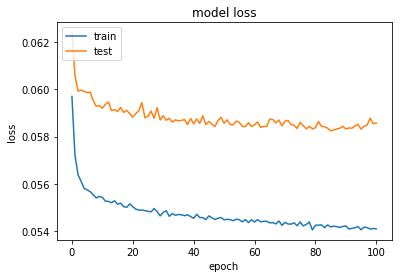

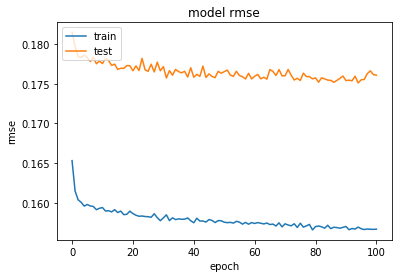

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

In [13]:
test_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_test,
                                         file_names_test,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay
                                        )


test_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_test,
                                         file_names_test,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

(6057, 25, 3) (6057, 10, 3)


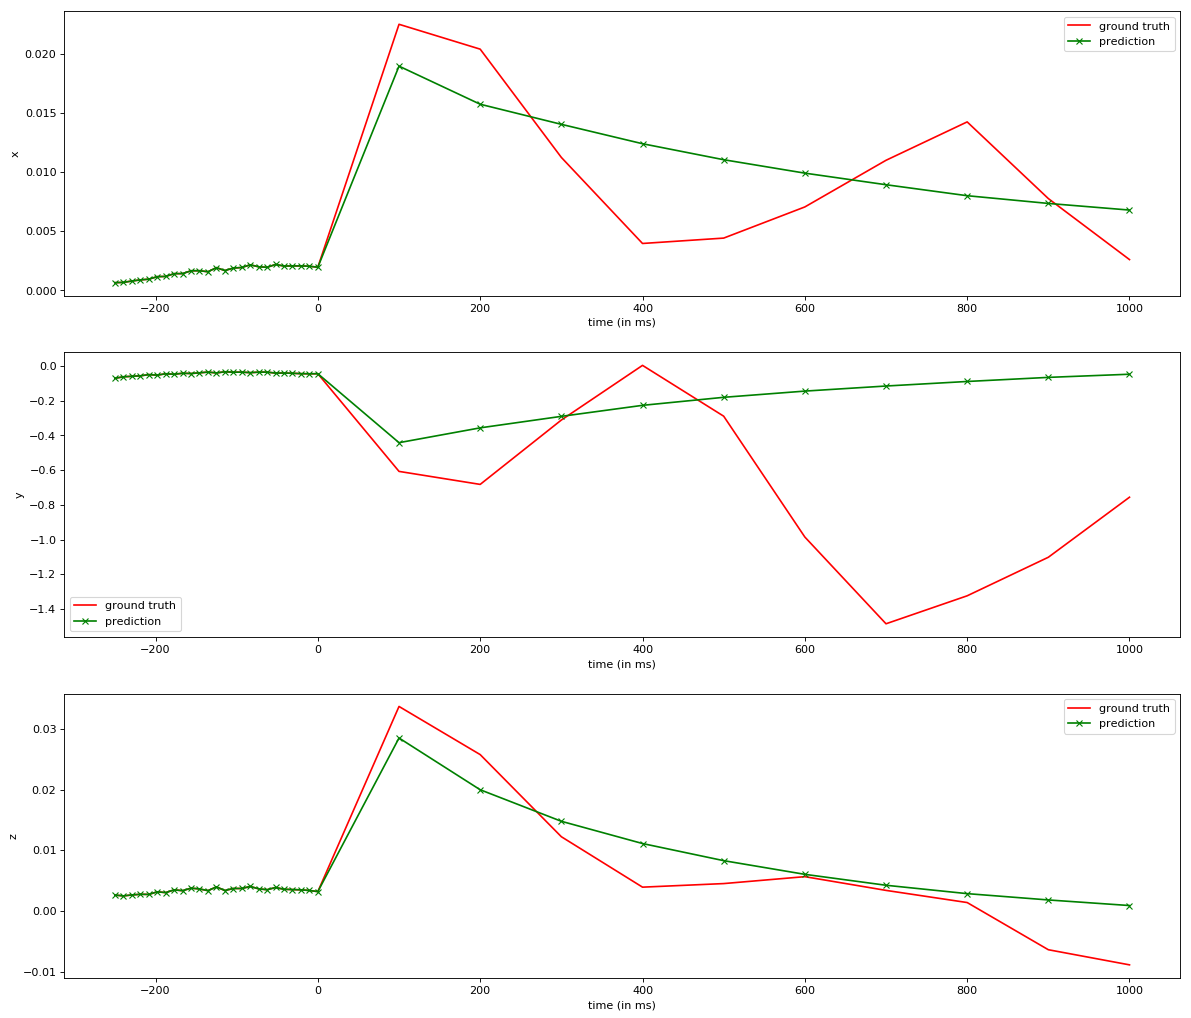

In [14]:
[encoder_input, decoder_input], Y_test = next(test_gen)
print(encoder_input.shape, Y_test.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_test[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_test[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_test[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [15]:
predictions_mae_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_rmse_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_smape_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_mfe_test = np.zeros((len(file_names_test), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Etestuating on testidation data...")
count = 0
for [encoder_input, decoder_input], Y_test_abs in test_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute testues
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_test_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_test_abs = Y_test_abs[:, 1:]
        
    predictions_mae_test[count, 0] = get_mae(Y_pred, Y_test_abs)
    predictions_rmse_test[count, 0] = get_rmse(Y_pred, Y_test_abs)
    predictions_smape_test[count, 0] = get_smape(Y_pred, Y_test_abs)
    predictions_mfe_test[count, 0] = get_mfe(Y_pred, Y_test_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_test = Y_test_abs[:,ind_delay]
        
        predictions_mae_test[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_test)
        predictions_rmse_test[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_test)
        predictions_smape_test[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_test)
        predictions_mfe_test[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_test)
    
    count += 1
    if count == len(file_names_test):
        break

results_mae_test = np.mean(predictions_mae_test, axis=0)
results_rmse_test = np.mean(predictions_rmse_test, axis=0)
results_smape_test = np.mean(predictions_smape_test, axis=0)
results_mfe_test = np.mean(predictions_mfe_test, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Etestuating on testidation data...


Evaluation Time :  58.09510064125061 s =  0.9682516892751057 min =  0.01613752822081248 h


### Metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_test[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_test[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_test[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_test[i+1])

MAE
Average mae: 0.05302007412993514
Delay 100 ms: 0.0035997508580362706
Delay 200 ms: 0.011431777779441146
Delay 300 ms: 0.021804476048776972
Delay 400 ms: 0.03340045574375875
Delay 500 ms: 0.045580911967410216
Delay 600 ms: 0.05802693446156163
Delay 700 ms: 0.07055453686561224
Delay 800 ms: 0.08303919188979128
Delay 900 ms: 0.0953540886357226
Delay 1000 ms: 0.10740861704924021

RMSE
Average rmse: 0.11529962663356272
Delay 100 ms: 0.009393927654916855
Delay 200 ms: 0.02429700071506489
Delay 300 ms: 0.04401323041386646
Delay 400 ms: 0.06567350147426088
Delay 500 ms: 0.08777417453518545
Delay 600 ms: 0.10962158769922019
Delay 700 ms: 0.13093475740613328
Delay 800 ms: 0.15159868262641074
Delay 900 ms: 0.17151991606894268
Delay 1000 ms: 0.19062142788174088

SMAPE
Average smape: 13.342668789991796
Delay 100 ms: 2.0377524226208488
Delay 200 ms: 5.010413500910055
Delay 300 ms: 7.912799977669888
Delay 400 ms: 10.547825539223311
Delay 500 ms: 12.958894996153058
Delay 600 ms: 15.167141618124901